##### Fluid Dynamics-Inspired Emotional Analysis & Sentiment Flow for Argumentation Mining (AM)
- Stance basesd Argument Mining Modeling Using NRC and SneticNet Emotion Analysis


The idea is to use "Emotional Analysis" (NRC,SenticNet, SOCAL) to improve

- Stance Claissfication
    - https://aclanthology.org/W15-0509.pdf
    - https://aclanthology.org/E17-1024.pdf 
         (read and undestood for microtext we need to have Reltation toward each traget id, it might sense to follow thier conclusion format with coverage )
         a code : https://github.com/Bhuvanesh-Verma/Stance-Classification?tab=readme-ov-file
    - https://d-nb.info/1233273159/34  (paper form Iruna Gurevych)   
         - add some  data from this:
                    ibmcs The IBM Debater®—Claim Stance Dataset [3]
            contains topic-claim pairs. The topics are gathered from
            a debating database, the claims were manually collected
            from Wikipedia articles. We take the pre-defined train and
            test split and split an additional 10% off the train set for
            development   
        https://github.com/UKPLab/mdl-stance-robustness
- Fine-Grained Classifcation 

    - https://aclanthology.org/J11-2001.pdf    (SO-CAL)
    - https://github.com/sfu-discourse-lab/SO-CAL
- Original of SC 
    - https://www.cs.cornell.edu/home/llee/papers/sentiment.pdf

Stance Classfication: how to use emotion in stacne

In [1]:
import shutil
import pandas as pd
from SentimentFlow import SpeechProcessor
from SentimentFlow import SentimentFlowCalculator
#https://github.com.mcas.ms/dpicca/SentimentFlow
pd.set_option("display.max_colwidth", None)
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
import ipywidgets as widgets
import os
import spacy
from nrclex import NRCLex

import pandas as pd
import spacy
from nrclex import NRCLex
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from SentimentFlow import SpeechProcessor
from SentimentFlow import SentimentFlowCalculator

from textblob import TextBlob


import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
from ExpandNRC.emotion_frequences import EmotionFrequencyCalculator
from collections import defaultdict




# Argumentative Microtext Part 1

we've done a extensive pre-processing on microtext to extract all layers of annotations. The focus is stance classifcation 

In [2]:
df = pd.read_json("../data/dfMT-PC_SA_CP_topicID_AduType.json") 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112 entries, 0 to 111
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   EDU        112 non-null    object
 1   adu_type   112 non-null    object
 2   topic_id   89 non-null     object
 3   Relations  112 non-null    object
 4   Label      112 non-null    object
 5   STANCE     89 non-null     object
dtypes: object(6)
memory usage: 6.1+ KB


In [4]:
df.head()

EDU  \
0                                                                                                                          [Yes, it's annoying and cumbersome to separate your rubbish properly all the time., Three different bin bags stink away in the kitchen and have to be sorted into different wheelie bins., But still Germany produces way too much rubbish, and too many resources are lost when what actually should be separated and recycled is burnt., We Berliners should take the chance and become pioneers in waste separation!]   
1  [One can hardly move in Friedrichshain or Neukölln these days without permanently scanning the ground for dog dirt., And when bad luck does strike and you step into one of the many 'land mines' you have to painstakingly scrape the remains off your soles., Higher fines are therefore the right measure against negligent, lazy or simply thoughtless dog owners., Of course, first they'd actually need to be caught in the act by public order officers,, but once they have to dig into their pockets, their laziness will sure vanish!]   
2                                                                                                                   [Health insurance companies should not cover treatment in complementary medicine, unless the promised effect and its medical benefit have been concretely proven., Yet this very proof is lacking in most cases., Patients do often report relief of their complaints after such treatments., But as long as it is unclear as to how this works, the funds should rather be spent on therapies where one knows with certainty.]   
3                                          [Of course there are a number of programmes in public broadcasting that are not worth the licencing fee,, and others, such as “Musikantenstadl” and soap operas, are only interesting to certain audiences., Nevertheless, everybody should contribute to the funding of the public broadcasters in equal measure,, for we need general and independent media., After all we want to get our view of the world neither through the lens of the government nor through that of rich media entrepreneurs.]   
4                                                                                                                                   [Intelligence services must urgently be regulated more tightly by parliament;, this should be clear to everyone after the disclosures of Edward Snowden., Granted, those concern primarily the British and American intelligence services,, but the German services evidently do collaborate with them closely., Their tools, data and expertise have been used to keep us under surveillance for a long time.]   

                    adu_type                                       topic_id  \
0  [opp, opp, pro, pro, pro]                               waste_separation   
1  [pro, pro, pro, opp, pro]                           higher_dog_poo_fines   
2  [pro, opp, pro, opp, pro]  health_insurance_cover_complementary_medicine   
3  [opp, opp, pro, pro, pro]             public_broadcasting_fees_on_demand   
4  [pro, pro, opp, pro, pro]   stricter_regulation_of_intelligence_services   

                                                      Relations  \
0  [[a1, a5, reb], [a2, a1, sup], [a3, c1, und], [a4, c3, add]]   
1  [[a1, a3, sup], [a2, a3, sup], [a4, a3, reb], [a5, c4, und]]   
2  [[a2, a1, reb], [a3, a2, reb], [a4, a1, reb], [a5, c4, und]]   
3  [[a1, a3, reb], [a2, a3, reb], [a4, a3, sup], [a5, a4, sup]]   
4  [[a2, a1, sup], [a3, c2, und], [a4, c3, und], [a5, a4, sup]]   

             Label STANCE  
0  [0, 0, 0, 0, 1]    pro  
1  [0, 0, 1, 0, 0]    pro  
2  [1, 0, 0, 0, 0]    con  
3  [0, 0, 1, 0, 0]    con  
4  [1, 0, 0, 0, 0]    pro

### A-NRC for emotion analysis  (original and extended)

In [5]:
def calculate_nrc(text):
    """Calculate NRC emotion frequencies for a given text."""
    nrc_sentiment = NRCLex(text)
    affect_dict = nrc_sentiment.affect_frequencies

    base_emotions = ['fear', 'anger', 'trust', 'surprise', 
                     'positive', 'negative', 'sadness', 'disgust', 'joy', "anticipation"]
    
    for emotion in base_emotions:
        if emotion not in affect_dict:
            affect_dict[emotion] = 0.0

    return {emotion: affect_dict[emotion] for emotion in base_emotions}

In [6]:
print(df.EDU[0],"\n", df.adu_type[0])

["Yes, it's annoying and cumbersome to separate your rubbish properly all the time.", 'Three different bin bags stink away in the kitchen and have to be sorted into different wheelie bins.', 'But still Germany produces way too much rubbish', 'and too many resources are lost when what actually should be separated and recycled is burnt.', 'We Berliners should take the chance and become pioneers in waste separation!'] 
 ['opp', 'opp', 'pro', 'pro', 'pro']


In [ ]:
calculate_nrc(df.EDU[0][4])#which feaure are usefull for stance classfication= 

{'fear': 0.0,
 'anger': 0.0,
 'trust': 0.0,
 'surprise': 0.3333333333333333,
 'positive': 0.0,
 'negative': 0.3333333333333333,
 'sadness': 0.0,
 'disgust': 0.3333333333333333,
 'joy': 0.0,
 'anticipation': 0.0}

In [ ]:
import csv
import json

def csv_to_json(csv_file_path, json_file_path, indent=4):
    """
    Converts a CSV file to a JSON file.
    
    Args:
        csv_file_path (str): Path to the input CSV file.
        json_file_path (str): Path to save the output JSON file.
        indent (int): Indentation level for the JSON output. Default is 4.
    """
    try:
        with open(csv_file_path, newline='', encoding='utf-8') as csvfile:
            reader = csv.DictReader(csvfile)
            data = list(reader)

        with open(json_file_path, 'w', encoding='utf-8') as jsonfile:
            json.dump(data, jsonfile, indent=indent)

        print(f" Successfully converted {csv_file_path} to {json_file_path}")

    except Exception as e:
        print(f" Error: {e}")


In [37]:
csv_to_json('../../data/nrcv3.csv', '../../data/nrc_v3.json')

✅ Successfully converted ../../data/nrcv3.csv to ../../data/nrc_v3.json


In [18]:
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
from ExpandNRC.emotion_frequences import EmotionFrequencyCalculator


def calculate_EXPnrc(text): # replace with nrc_v3
    feelings_nrc = NRCLex("../../data/nrc_v3.json")   
    emotion_lexicon = feelings_nrc.lexicon
    freq_calc = EmotionFrequencyCalculator(emotion_lexicon, input=text)
    return(freq_calc.affect_frequencies)

In [19]:
calculate_EXPnrc(df.EDU[0][4])

Loaded cached embeddings for 6468 words from C:\Users\moha\.cache\ExpandNRC\lexicon_embeddings_cache.pkl


{'fear': 0.1,
 'anger': 0.1,
 'anticipation': 0.2,
 'trust': 0.15,
 'surprise': 0.1,
 'positive': 0.0,
 'negative': 0.0,
 'sadness': 0.1,
 'disgust': 0.15,
 'joy': 0.1}

In [7]:
feelings_nrc = NRCLex("../../data/nrc_v3.json")   
emotion_lexicon = feelings_nrc.lexicon
freq_calc = EmotionFrequencyCalculator(emotion_lexicon, input=df.EDU[0][4], device = "cpu")
print(freq_calc.affect_frequencies)
print(freq_calc.top_emotions)

Loaded cached embeddings for 6468 words from C:\Users\moha\.cache\ExpandNRC\lexicon_embeddings_cache.pkl
{'fear': 0.1, 'anger': 0.1, 'anticipation': 0.2, 'trust': 0.15, 'surprise': 0.1, 'positive': 0.0, 'negative': 0.0, 'sadness': 0.1, 'disgust': 0.15, 'joy': 0.1}
[('anticipation', 0.2)]


In [12]:
calculate_EXPnrc(df.EDU[0][4])

Loaded cached embeddings for 6468 words from C:\Users\moha\.cache\ExpandNRC\lexicon_embeddings_cache.pkl


{'fear': 0.1,
 'anger': 0.1,
 'anticipation': 0.2,
 'trust': 0.15,
 'surprise': 0.1,
 'positive': 0.0,
 'negative': 0.0,
 'sadness': 0.1,
 'disgust': 0.15,
 'joy': 0.1}

In [64]:


def plot_nrc_and_stance_counts(df):
    total_pro = defaultdict(int)
    total_opp = defaultdict(int)
    count_pro = 0
    count_opp = 0
    total_words_pro = 0
    total_words_opp = 0

    for _, row in df.iterrows():
        edus = row['EDU']
        stances = row['adu_type']
        
        for text, stance in zip(edus, stances):
            word_count = len(text.split())  # Count words in each EDU
            
            if stance == 'pro':
                count_pro += 1
                total_words_pro += word_count
                emo = NRCLex(text)
                for emotion, count in emo.raw_emotion_scores.items():
                    total_pro[emotion] += count
            elif stance == 'opp':
                count_opp += 1
                total_words_opp += word_count
                emo = NRCLex(text)
                for emotion, count in emo.raw_emotion_scores.items():
                    total_opp[emotion] += count

    # Normalize the NRC counts by the total words for pro/opp
    normalized_pro_values = {emotion: total_pro[emotion] / total_words_pro for emotion in total_pro}
    normalized_opp_values = {emotion: total_opp[emotion] / total_words_opp for emotion in total_opp}

    # Combine the two sets of emotions (to include all emotions in the final plot)
    all_emotions = sorted(set(normalized_pro_values.keys()).union(set(normalized_opp_values.keys())))

    # Get the normalized NRC values for each emotion
    pro_values = [normalized_pro_values.get(e, 0) for e in all_emotions]
    opp_values = [normalized_opp_values.get(e, 0) for e in all_emotions]
    x_emotions = range(len(all_emotions))

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Normalized NRC Emotion Word Counts (by word count)
    axs[0].bar(x_emotions, pro_values, width=0.4, label='Pro', color='green', align='center')
    axs[0].bar([i + 0.4 for i in x_emotions], opp_values, width=0.4, label='Opp', color='red', align='center')
    axs[0].set_xticks([i + 0.2 for i in x_emotions])
    axs[0].set_xticklabels(all_emotions, rotation=45)
    axs[0].set_title("Normalized NRC Emotion Word Counts by Stance")
    axs[0].set_ylabel("Normalized Word Count")
    axs[0].legend()

    # Plot 2: Normalized Count of Pro and Opp Segments
    axs[1].bar(['Pro', 'Opp'], [count_pro, count_opp], color=['green', 'red'])
    axs[1].set_title("Normalized Number of Pro and Opp Segments")
    axs[1].set_ylabel("Segment Count")

    plt.tight_layout()
    plt.show()


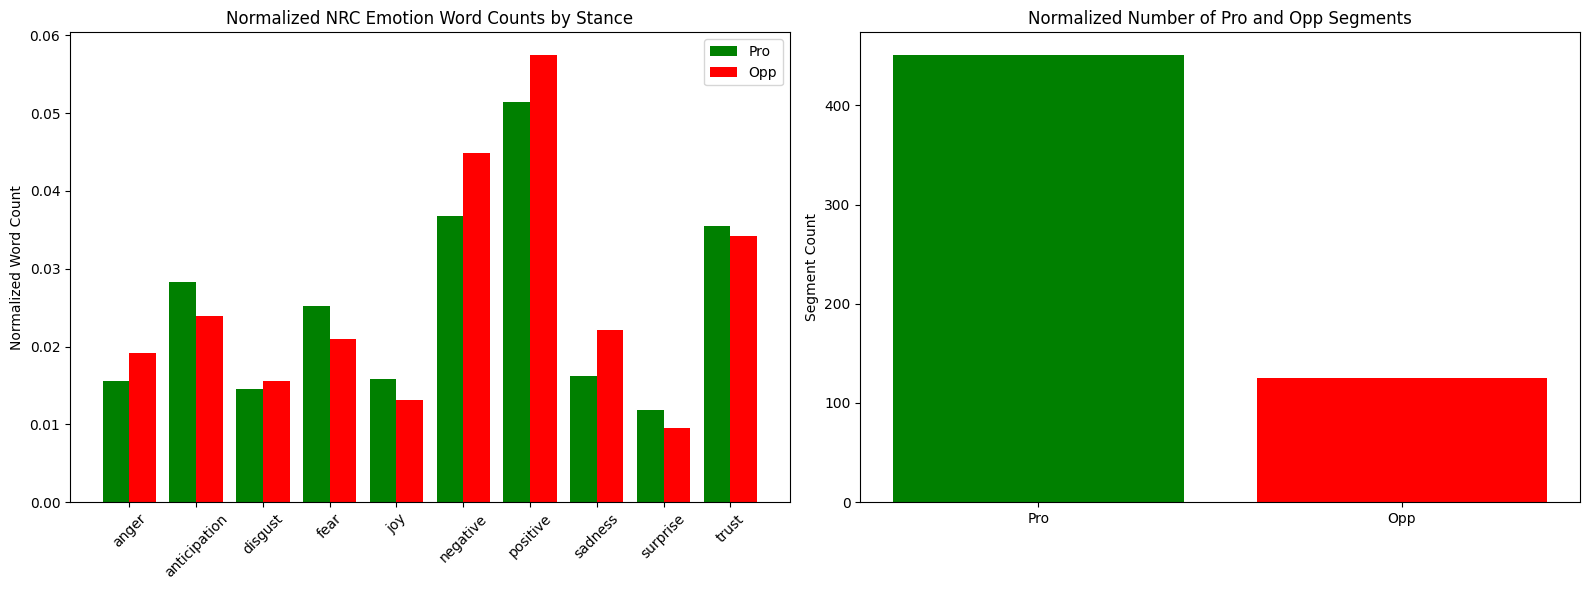

In [65]:
plot_nrc_and_stance_counts(df)


In [20]:


# Adjusted plot function to use the new `calculate_EXPnrc` function
def plot_EXPnrc_and_stance_counts(df):
    total_pro = defaultdict(int)
    total_opp = defaultdict(int)
    count_pro = 0
    count_opp = 0
    total_words_pro = 0
    total_words_opp = 0

    # Loop over the rows of the dataframe
    for _, row in df.iterrows():
        edus = row['EDU']
        stances = row['adu_type']
        
        for text, stance in zip(edus, stances):
            word_count = len(text.split())  # Count words in each EDU
            
            if stance == 'pro':
                count_pro += 1
                total_words_pro += word_count
                # Get the emotion frequencies using the new function
                emo_frequencies = calculate_EXPnrc(text)
                for emotion, count in emo_frequencies.items():
                    total_pro[emotion] += count
            elif stance == 'opp':
                count_opp += 1
                total_words_opp += word_count
                # Get the emotion frequencies using the new function
                emo_frequencies = calculate_EXPnrc(text)
                for emotion, count in emo_frequencies.items():
                    total_opp[emotion] += count

    # Normalize the NRC counts by the total words for pro/opp
    normalized_pro_values = {emotion: total_pro[emotion] / total_words_pro for emotion in total_pro}
    normalized_opp_values = {emotion: total_opp[emotion] / total_words_opp for emotion in total_opp}

    # Combine the two sets of emotions (to include all emotions in the final plot)
    all_emotions = sorted(set(normalized_pro_values.keys()).union(set(normalized_opp_values.keys())))

    # Get the normalized NRC values for each emotion
    pro_values = [normalized_pro_values.get(e, 0) for e in all_emotions]
    opp_values = [normalized_opp_values.get(e, 0) for e in all_emotions]
    x_emotions = range(len(all_emotions))

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Normalized NRC Emotion Word Counts (by word count)
    axs[0].bar(x_emotions, pro_values, width=0.4, label='Pro', color='green', align='center')
    axs[0].bar([i + 0.4 for i in x_emotions], opp_values, width=0.4, label='Opp', color='red', align='center')
    axs[0].set_xticks([i + 0.2 for i in x_emotions])
    axs[0].set_xticklabels(all_emotions, rotation=45)
    axs[0].set_title("Normalized NRC Emotion Word Counts by Stance")
    axs[0].set_ylabel("Normalized Word Count")
    axs[0].legend()

    # Plot 2: Normalized Count of Pro and Opp Segments
    axs[1].bar(['Pro', 'Opp'], [count_pro, count_opp], color=['green', 'red'])
    axs[1].set_title("Normalized Number of Pro and Opp Segments")
    axs[1].set_ylabel("Segment Count")

    plt.tight_layout()
    plt.show()

# Your new function to calculate emotion frequencies using NRC v3


In [ ]:
plot_EXPnrc_and_stance_counts(df)

Loaded cached embeddings for 6468 words from C:\Users\moha\.cache\ExpandNRC\lexicon_embeddings_cache.pkl
Loaded cached embeddings for 6468 words from C:\Users\moha\.cache\ExpandNRC\lexicon_embeddings_cache.pkl
Loaded cached embeddings for 6468 words from C:\Users\moha\.cache\ExpandNRC\lexicon_embeddings_cache.pkl
Loaded cached embeddings for 6468 words from C:\Users\moha\.cache\ExpandNRC\lexicon_embeddings_cache.pkl
Loaded cached embeddings for 6468 words from C:\Users\moha\.cache\ExpandNRC\lexicon_embeddings_cache.pkl
Loaded cached embeddings for 6468 words from C:\Users\moha\.cache\ExpandNRC\lexicon_embeddings_cache.pkl
Loaded cached embeddings for 6468 words from C:\Users\moha\.cache\ExpandNRC\lexicon_embeddings_cache.pkl
Loaded cached embeddings for 6468 words from C:\Users\moha\.cache\ExpandNRC\lexicon_embeddings_cache.pkl
Loaded cached embeddings for 6468 words from C:\Users\moha\.cache\ExpandNRC\lexicon_embeddings_cache.pkl


In [67]:

def process_data(df):
    """Process DataFrame by applying NRC analysis and filtering emotions."""
    df_exp = df.explode(['EDU', 'adu_type'])
    
    nrc_features = df_exp['EDU'].apply(lambda x: pd.Series(calculate_nrc(x)))
    
    return pd.concat([df_exp[['adu_type']], nrc_features], axis=1)

def visualize_correlation(processed_df):
    """Generate a heatmap visualization of NRC emotions by ADU type."""
    grouped = processed_df.groupby('adu_type').mean().reset_index()
    
    melted = grouped.melt(id_vars='adu_type', 
                          var_name='Emotion', 
                          value_name='Intensity')

    fig = px.imshow(
        grouped.set_index('adu_type').T,
        labels=dict(x="ADU Type", y="NRC Dimension", color="Intensity"),
        color_continuous_scale='RdBu',
        title="NRC Emotion Intensity by ADU Type",
        aspect="auto"
    )
    
    fig.update_layout(
        xaxis_title="ADU Type",
        yaxis_title="NRC Emotion Dimension",
        coloraxis_colorbar=dict(title="Intensity")
    )
    
    return fig

processed_df = process_data(df)
fig = visualize_correlation(processed_df)
fig.write_html("../../Results/results_nrc_MT1.html")
fig.show()


# Argumentative Microtext Part 2

In [8]:
df2 = pd.read_json("../data/dfMT2-PC_SA_CP_topicID_AduType.json") 

In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 171 entries, 0 to 170
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   EDU        171 non-null    object
 1   adu_type   171 non-null    object
 2   topic_id   171 non-null    object
 3   Relations  171 non-null    object
 4   Label      171 non-null    object
 5   STANCE     171 non-null    object
dtypes: object(6)
memory usage: 9.4+ KB


In [69]:
processed_df2 = process_data(df)

fig2 = visualize_correlation(processed_df2)
fig2.write_html("../../Results/results_nrc_MT2.html")
fig2.show()

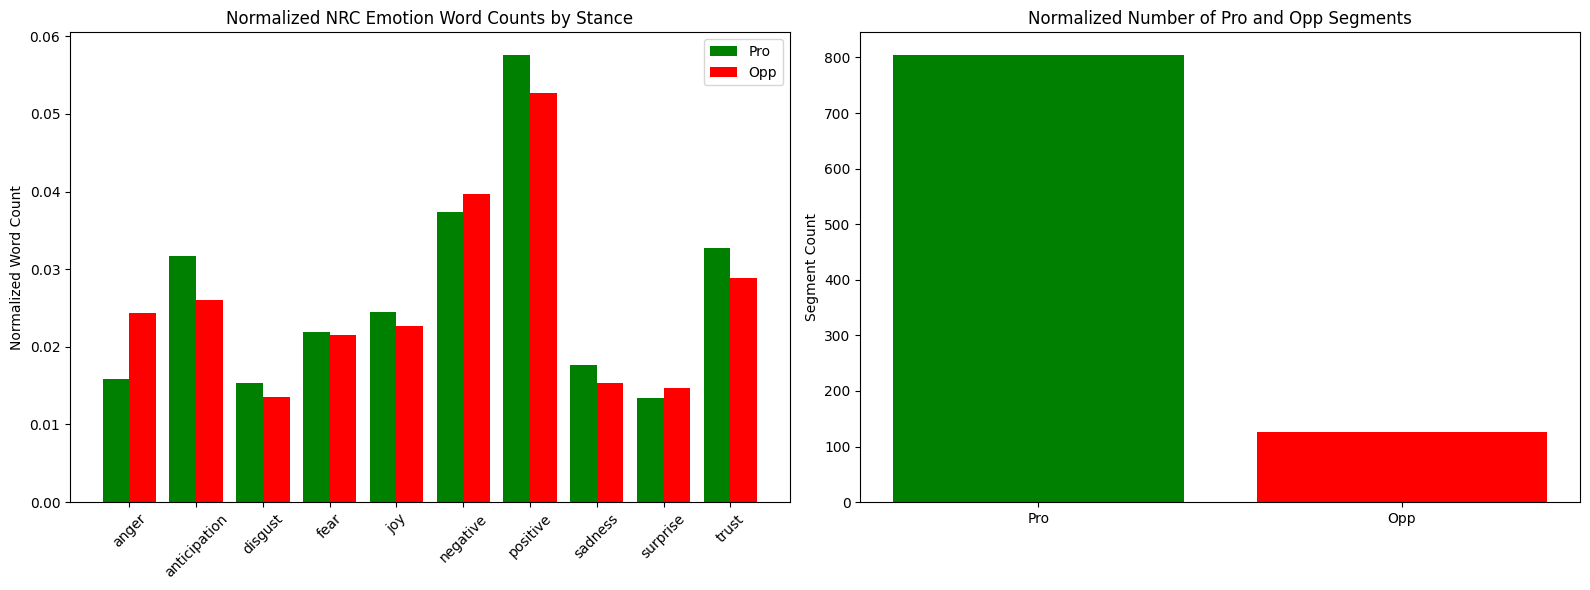

In [70]:
plot_nrc_and_stance_counts(df2)


In [10]:
df3 = pd.read_json("../data/df_IBM.json")   #work wore on extraction 

In [11]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55 entries, 0 to 54
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   topic_id         55 non-null     object
 1   EDU              55 non-null     object
 2   adu_type         55 non-null     object
 3   targetsRelation  55 non-null     object
 4   Compatible       55 non-null     object
dtypes: object(5)
memory usage: 2.6+ KB


In [12]:
df3.head(1)

topic_id  \
0  the sale of violent video games to minors   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [13]:

def convert_list(lst):
    return ['pro' if item == 'PRO' else 'opp' for item in lst]

df3['adu_type'] = df3['adu_type'].apply(convert_list)

In [14]:
df3.head(1)

topic_id  \
0  the sale of violent video games to minors   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

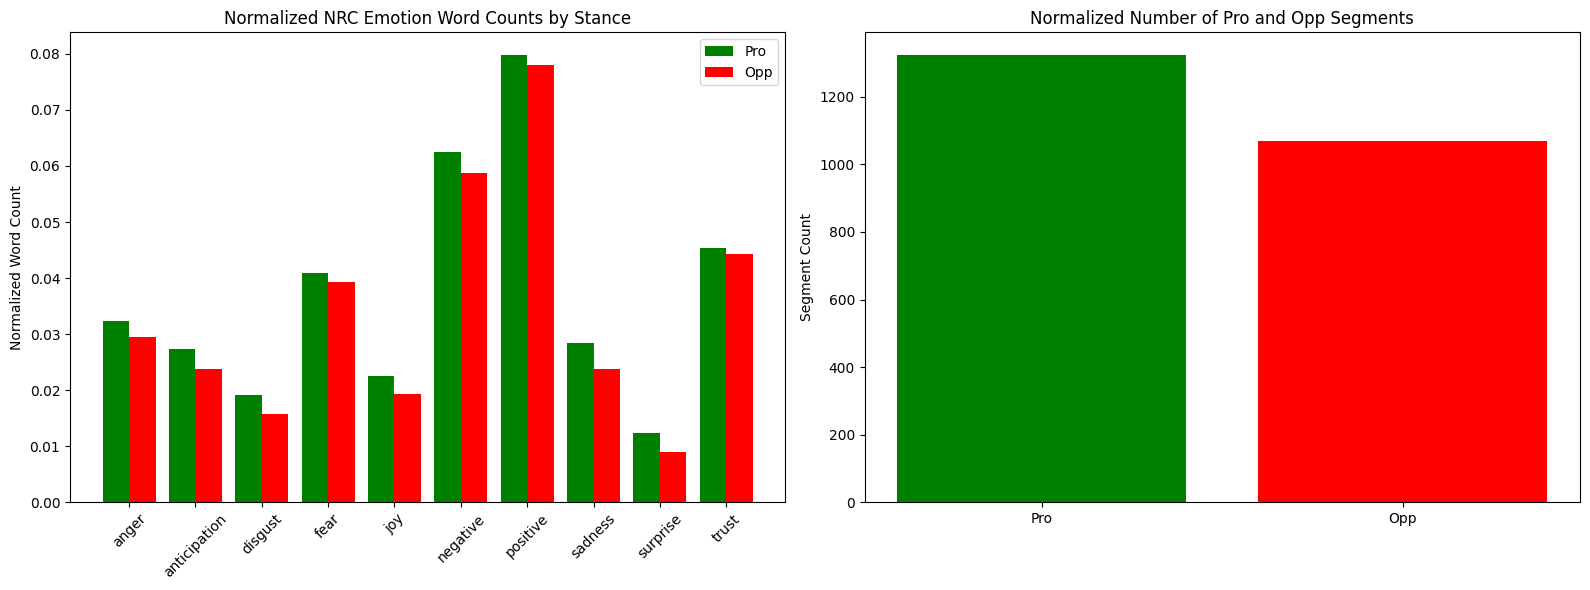

In [71]:
plot_nrc_and_stance_counts(df3)


In [49]:
processed_df3 = process_data(df3)
fig3 = visualize_correlation(processed_df3)
fig3.write_html("../../Results/results_nrc_MT3.html")
fig3.show()


# Random Forest

In [27]:
def classify_pro_opp_RF(df):
    df_exp = df.explode(['EDU', 'adu_type'])

    X = df_exp['EDU']
    y = df_exp['adu_type']

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y) 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    print(X_test)
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    clf.fit(X_train_tfidf, y_train)
    
    y_pred_rf = clf.predict(X_test_tfidf)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    class_report_rf = classification_report(y_test, y_pred_rf)
    confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)

    print(f"\nRandom Forest Accuracy: {accuracy_rf}")
    print(f"Random Forest Classification Report:\n{class_report_rf}")
    print(f"Random Forest Confusion Matrix:\n{confusion_matrix_rf}")


    majority_classifier = DummyClassifier(strategy='most_frequent')
    majority_classifier.fit(X_train_tfidf, y_train)
    
    y_pred_majority = majority_classifier.predict(X_test_tfidf)
    accuracy_majority = accuracy_score(y_test, y_pred_majority)
    class_report_majority = classification_report(y_test, y_pred_majority)
    confusion_matrix_majority = confusion_matrix(y_test, y_pred_majority)

    print(f"\nMajority Classifier Accuracy: {accuracy_majority}")
    print(f"Majority Classifier Classification Report:\n{class_report_majority}")
    print(f"Random Forest Confusion Matrix:\n{confusion_matrix_majority}")

    return accuracy_rf, class_report_rf, accuracy_majority, class_report_majority




In [28]:
accuracy_rf, class_report_rf, accuracy_majority, class_report_majority = classify_pro_opp_RF(df)


46                                                                       Therefore universities should not charge tuition fees in Germany.
24                                                                                              and it has not generally been ineffective.
68                                                                                The current tour of Tokio Hotel is breaking all records.
97                                                                   Intelligence services should be more closely regulated by parliament,
79                                                                           We urgently need a midfield replacement for the coming match.
                                                                      ...                                                                 
15                                                  It would therefore be wise to adjust the required effort for final theses accordingly.
69                         

h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
def handle_mismatched_rows(df):
    mismatched_rows = df[df.apply(lambda row: len(row['EDU']) != len(row['adu_type']), axis=1)]
    
    #if not mismatched_rows.empty:
    #    print(f"Found {len(mismatched_rows)} rows with mismatched list lengths.")
    #    print(mismatched_rows)
    
    df = df[df.apply(lambda row: len(row['EDU']) == len(row['adu_type']), axis=1)]
    
    return df

In [16]:
df2_new = handle_mismatched_rows(df2)

In [17]:
df2_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 0 to 170
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   EDU        144 non-null    object
 1   adu_type   144 non-null    object
 2   topic_id   144 non-null    object
 3   Relations  144 non-null    object
 4   Label      144 non-null    object
 5   STANCE     144 non-null    object
dtypes: object(6)
memory usage: 7.9+ KB


In [48]:
processed_df2_new = process_data(df2_new)
fig2= visualize_correlation(processed_df2_new)
fig2.write_html("../../Results/results_nrc_MT2.html")
fig2.show()


In [32]:
accuracy_rf_2, class_report_rf_2, accuracy_majority_2, class_report_majority_2 = classify_pro_opp_RF(df2_new)


149                                                                     It encourages the family to undertake a healthier lifestyle.
140                                                                                   Helicopter parents are bad for their children.
11                                                                                                Don't they need them for survival?
114                                                           and with proper government regulation, the spread of it can be faster.
12                                                                              removing the horns of wild rhinos is not the answer.
                                                                   ...                                                              
127                                                                                     as on average they are not college educated.
170                                                                  

h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [37]:
accuracy_rf_3, class_report_rf_3, accuracy_majority_3, class_report_majority_3 = classify_pro_opp_RF(df3)


7                                                  Winners sometimes feel anomie from the dramatic change of lifestyles
4                                                         Affirmative action is intended to promote \nequal opportunity
37                                                                       War has never brought any solution to problems
49                     free trade encourages economic interdependence between countries, reducing the likelihood of war
50                                                                   advertising frequently uses psychological pressure
                                                            ...                                                        
7                                                                   money goes directly towards stimulating the economy
22                                                    for every three multitrack schools, one less school must be built
1     Parents have a basic human right t

h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# test SVM model

In [50]:


def classify_pro_opp_SVM(df):
    #df = handle_mismatched_rows(df)
    
    df_exp = df.explode(['EDU', 'adu_type'])

    X = df_exp['EDU']
    y = df_exp['adu_type']

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y) 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    print(X_test)
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    clf = SVC(kernel='linear', class_weight='balanced', random_state=42)
    clf.fit(X_train_tfidf, y_train)
    
    y_pred_svm = clf.predict(X_test_tfidf)
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    class_report_svm = classification_report(y_test, y_pred_svm)
    confusion_matrix_svm = confusion_matrix(y_test, y_pred_svm)

    print(f"\nSVM Accuracy: {accuracy_svm}")
    print(f"SVM Classification Report:\n{class_report_svm}")
    print(f"SVM Confusion Matrix:\n{confusion_matrix_svm}")

    majority_classifier = DummyClassifier(strategy='most_frequent')
    majority_classifier.fit(X_train_tfidf, y_train)
    
    y_pred_majority = majority_classifier.predict(X_test_tfidf)
    accuracy_majority = accuracy_score(y_test, y_pred_majority)
    class_report_majority = classification_report(y_test, y_pred_majority)
    confusion_matrix_majority = confusion_matrix(y_test, y_pred_majority)

    print(f"\nMajority Classifier Accuracy: {accuracy_majority}")
    print(f"Majority Classifier Classification Report:\n{class_report_majority}")
    print(f"Majority Classifier Confusion Matrix:\n{confusion_matrix_majority}")

    return accuracy_svm, class_report_svm, accuracy_majority, class_report_majority


In [30]:
accuracy_svm, class_report_svm, accuracy_majority, class_report_majority = classify_pro_opp_SVM(df)

46                                                                       Therefore universities should not charge tuition fees in Germany.
24                                                                                              and it has not generally been ineffective.
68                                                                                The current tour of Tokio Hotel is breaking all records.
97                                                                   Intelligence services should be more closely regulated by parliament,
79                                                                           We urgently need a midfield replacement for the coming match.
                                                                      ...                                                                 
15                                                  It would therefore be wise to adjust the required effort for final theses accordingly.
69                         

h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [53]:
accuracy_svm_2, class_report_svm_2, accuracy_majority_2, class_report_majority_2 = classify_pro_opp_SVM(df2_new)

149                                                                     It encourages the family to undertake a healthier lifestyle.
140                                                                                   Helicopter parents are bad for their children.
11                                                                                                Don't they need them for survival?
114                                                           and with proper government regulation, the spread of it can be faster.
12                                                                              removing the horns of wild rhinos is not the answer.
                                                                   ...                                                              
127                                                                                     as on average they are not college educated.
170                                                                  

h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [33]:
accuracy_svm_3, class_report_svm_3, accuracy_majority_3, class_report_majority_3 = classify_pro_opp_SVM(df3)

7                                                  Winners sometimes feel anomie from the dramatic change of lifestyles
4                                                         Affirmative action is intended to promote \nequal opportunity
37                                                                       War has never brought any solution to problems
49                     free trade encourages economic interdependence between countries, reducing the likelihood of war
50                                                                   advertising frequently uses psychological pressure
                                                            ...                                                        
7                                                                   money goes directly towards stimulating the economy
22                                                    for every three multitrack schools, one less school must be built
1     Parents have a basic human right t

h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# ADD NRC values as features

In [51]:
def classify_pro_opp_SVM_NRC(df):
    #df = handle_mismatched_rows(df)
    
    df_exp = df.explode(['EDU', 'adu_type'])

    X = df_exp['EDU']
    y = df_exp['adu_type']

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)  
    
    nrc_features = X.apply(lambda text: calculate_nrc(text))
    nrc_df = pd.DataFrame(nrc_features.tolist())  
    
    vectorizer = TfidfVectorizer(max_features=5000)
    X_tfidf = vectorizer.fit_transform(X)
    
    X_combined = np.hstack((X_tfidf.toarray(), nrc_df.to_numpy()))
    
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y_encoded, test_size=0.2, random_state=42)

    clf = SVC(kernel='linear', class_weight='balanced', random_state=42)
    clf.fit(X_train, y_train)
    
    y_pred_svm = clf.predict(X_test)
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    class_report_svm = classification_report(y_test, y_pred_svm)
    confusion_matrix_svm = confusion_matrix(y_test, y_pred_svm)

    print(f"\nSVM Accuracy: {accuracy_svm}")
    print(f"SVM Classification Report:\n{class_report_svm}")
    print(f"SVM Confusion Matrix:\n{confusion_matrix_svm}")

    majority_classifier = DummyClassifier(strategy='most_frequent')
    majority_classifier.fit(X_train, y_train)
    
    y_pred_majority = majority_classifier.predict(X_test)
    accuracy_majority = accuracy_score(y_test, y_pred_majority)
    class_report_majority = classification_report(y_test, y_pred_majority)
    confusion_matrix_majority = confusion_matrix(y_test, y_pred_majority)

    print(f"\nMajority Classifier Accuracy: {accuracy_majority}")
    print(f"Majority Classifier Classification Report:\n{class_report_majority}")
    print(f"Majority Classifier Confusion Matrix:\n{confusion_matrix_majority}")

    return accuracy_svm, class_report_svm, accuracy_majority, class_report_majority

In [26]:
accuracy_svm_nrc, class_report_svm_nrc, accuracy_majority_nrc, class_report_majority_nrc = classify_pro_opp_SVM_NRC(df)


SVM Accuracy: 0.8103448275862069
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.32      0.39        22
           1       0.85      0.93      0.89        94

    accuracy                           0.81       116
   macro avg       0.68      0.62      0.64       116
weighted avg       0.79      0.81      0.79       116

SVM Confusion Matrix:
[[ 7 15]
 [ 7 87]]

Majority Classifier Accuracy: 0.8103448275862069
Majority Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.81      1.00      0.90        94

    accuracy                           0.81       116
   macro avg       0.41      0.50      0.45       116
weighted avg       0.66      0.81      0.73       116

Majority Classifier Confusion Matrix:
[[ 0 22]
 [ 0 94]]


h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [52]:
accuracy_svm_nrc2, class_report_svm_nrc2, accuracy_majority_nrc2, class_report_majority_nrc2 = classify_pro_opp_SVM_NRC(df2_new)


SVM Accuracy: 0.81875
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.26      0.29        23
           1       0.88      0.91      0.90       137

    accuracy                           0.82       160
   macro avg       0.61      0.59      0.59       160
weighted avg       0.80      0.82      0.81       160

SVM Confusion Matrix:
[[  6  17]
 [ 12 125]]

Majority Classifier Accuracy: 0.85625
Majority Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.86      1.00      0.92       137

    accuracy                           0.86       160
   macro avg       0.43      0.50      0.46       160
weighted avg       0.73      0.86      0.79       160

Majority Classifier Confusion Matrix:
[[  0  23]
 [  0 137]]


h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [42]:
accuracy_svm_nrc3, class_report_svm_nrc3, accuracy_majority_nrc3, class_report_majority_nrc3 = classify_pro_opp_SVM_NRC(df3)


SVM Accuracy: 0.6304801670146137
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.62      0.58       193
           1       0.71      0.64      0.67       286

    accuracy                           0.63       479
   macro avg       0.62      0.63      0.62       479
weighted avg       0.64      0.63      0.63       479

SVM Confusion Matrix:
[[120  73]
 [104 182]]

Majority Classifier Accuracy: 0.5970772442588727
Majority Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       193
           1       0.60      1.00      0.75       286

    accuracy                           0.60       479
   macro avg       0.30      0.50      0.37       479
weighted avg       0.36      0.60      0.45       479

Majority Classifier Confusion Matrix:
[[  0 193]
 [  0 286]]


h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# expandNRC

In [1]:
"""
Example usage of the lexicon_expansion package.
"""

from nrclex import NRCLex

from ExpandNRC.emotion_distance_calculator import EmotionDistanceCalculator

# # Use local lexicon json for updated version of NRC
feelings_nrc = NRCLex(
    "/Users/Panos/Library/CloudStorage/Dropbox/PI_Squared/PycharmProjects/Research"
    "/NRCLex/nrc_v3.json")
#
emotion_lexicon = feelings_nrc.__lexicon__

# Initialize the calculator (using CPU for simplicity)
calculator = EmotionDistanceCalculator(emotion_lexicon, device="cpu")

# Get emotions for a single word
result_single = calculator.get_emotions("happy")
print("Emotions for 'happy':", result_single)

# Get emotions for a batch of words
result_batch = calculator.get_emotions(["happy", "sad", "morning"])
print("Emotions for batch:", result_batch)

nrc_emotions = calculator.nrc_emotions(["happy", "sad", "morning"])
print("NRC emotions:", nrc_emotions)
nrc_emotions_2 = calculator.nrc_emotions(["happy", "sad", "morning"],
                                         threshold=0.7)
print("NRC emotions after filtering:", nrc_emotions_2)


from ExpandNRC.emotion_frequences import EmotionFrequencyCalculator


# --- INPUT TEXT
text = "I feel hopeful and excited, but also a bit anxious and worried."

# --- OUR VERSION
our_calc = EmotionFrequencyCalculator(emotion_lexicon, text, threshold=0.6)
our_freq = our_calc.affect_frequencies
our_top = our_calc.top_emotions

# --- NRCLEX VERSION
feelings_nrc.load_raw_text(text)
nrc_freq = feelings_nrc.affect_frequencies
nrc_top = feelings_nrc.top_emotions
print(our_freq)

# --- PRINT COMPARISON
print("🔍 Emotion Frequency Comparison:\n")
print(f"{'Emotion':<15} {'Ours':>10} {'NRCLex':>10}")
print("-" * 37)

all_keys = sorted(set(our_freq.keys()) | set(nrc_freq.keys()))
for emotion in all_keys:
    print(
        f"{emotion:<15} {our_freq.get(emotion, 0):>10.2f} "
        f"{nrc_freq.get(emotion, 0):>10.2f}")

print("\n🏆 Top Emotions")
print("Ours:   ", our_top)
print("NRCLex: ", nrc_top)

ModuleNotFoundError: No module named 'ExpandNRC'

# ### B-Senticnet for emotion analysis (Davida Package)

In [62]:
def calculate_senticnet(text):
    processor = SpeechProcessor('../../data/senticnet/senticnet2.tsv')
    df_sc_sentiment = processor.process_texts(pd.Series(text)) 
    print(df_sc_sentiment)
    df_sc_sentiment.columns = df_sc_sentiment.columns.str.replace('#', '_')
    
    # Define expected keys
    expected_keys = ["INTROSPECTION_ecstasy", "TEMPER", "SENSITIVITY", "ATTITUDE", "TEMPER_calmness", "POLARITY"]
    
    # Create dictionary with values, setting missing ones to 0
    dict_sc_sentiment = {key: df_sc_sentiment[key].values[0] if key in df_sc_sentiment else 0 for key in expected_keys}

    return dict_sc_sentiment


In [39]:
processor = SpeechProcessor('../../data/senticnet/senticnet2.tsv')
df_sc_sentiment = calculate_senticnet(df.EDU[0])


01-Apr-25 14:31:10 - Starting to process


Processing texts:   0%|          | 0/5 [00:00<?, ?it/s]

01-Apr-25 14:31:14 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0                      Yes, it's annoying and cumbersome to separate your rubbish properly all the time.   
1  Three different bin bags stink away in the kitchen and have to be sorted into different wheelie bins.   
2                                                        But still Germany produces way too much rubbish   
3          and too many resources are lost when what actually should be separated and recycled is burnt.   
4                           We Berliners should take the chance and become pioneers in waste separation!   

   INTROSPECTION#ecstasy  TEMPER  SENSITIVITY  ATTITUDE  TEMPER#calmness  \
0                 0.8560   -0.33       -0.275    -0.596            0.552   
1                 0.9610    0.00        0.000    -0.393            0.000   
2                 0.8250    0.00        0.000    -0.596            0.000   
3                 0.0000    0.00        0.000  

In [40]:
def classify_pro_opp_SVM_SENTICNET(df):  #very time consuming, need find a way to loop over the whole df not rows
    df = handle_mismatched_rows(df)
    
    df_exp = df.explode(['EDU', 'adu_type'])

    X = df_exp['EDU']
    y = df_exp['adu_type']
    print(X,y)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)  
    
    nrc_features = X.apply(lambda text: calculate_senticnet(text))
    nrc_df = pd.DataFrame(nrc_features.tolist())  
    
    vectorizer = TfidfVectorizer(max_features=5000)
    X_tfidf = vectorizer.fit_transform(X)
    
    X_combined = np.hstack((X_tfidf.toarray(), nrc_df.to_numpy()))
    
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y_encoded, test_size=0.2, random_state=42)

    clf = SVC(kernel='linear', class_weight='balanced', random_state=42)
    clf.fit(X_train, y_train)
    
    y_pred_svm = clf.predict(X_test)
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    class_report_svm = classification_report(y_test, y_pred_svm)

    print(f"\nSVM Accuracy: {accuracy_svm}")
    print(f"SVM Classification Report:\n{class_report_svm}")

    majority_classifier = DummyClassifier(strategy='most_frequent')
    majority_classifier.fit(X_train, y_train)
    
    y_pred_majority = majority_classifier.predict(X_test)
    accuracy_majority = accuracy_score(y_test, y_pred_majority)
    class_report_majority = classification_report(y_test, y_pred_majority)

    print(f"\nMajority Classifier Accuracy: {accuracy_majority}")
    print(f"Majority Classifier Classification Report:\n{class_report_majority}")

    return accuracy_svm, class_report_svm, accuracy_majority, class_report_majority

In [107]:
accuracy_svm_sn, class_report_svm_sn, accuracy_majority_sn, class_report_majority_sn = classify_pro_opp_SVM_SENTICNET(df)

26-Mar-25 14:51:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:51:51 - Saving results to results/processed_texts.csv
26-Mar-25 14:51:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:51:52 - Saving results to results/processed_texts.csv
26-Mar-25 14:51:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:51:53 - Saving results to results/processed_texts.csv
26-Mar-25 14:51:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:51:53 - Saving results to results/processed_texts.csv
26-Mar-25 14:51:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:51:54 - Saving results to results/processed_texts.csv
26-Mar-25 14:51:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:51:55 - Saving results to results/processed_texts.csv
26-Mar-25 14:51:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:51:56 - Saving results to results/processed_texts.csv
26-Mar-25 14:51:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:51:57 - Saving results to results/processed_texts.csv
26-Mar-25 14:51:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:51:58 - Saving results to results/processed_texts.csv
26-Mar-25 14:51:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:51:59 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:00 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:01 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:01 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:02 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:03 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:04 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:05 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:06 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:07 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:08 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:09 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:10 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:10 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:11 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:12 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:13 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:14 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:15 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:16 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:17 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:18 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:19 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:20 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:21 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:22 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:23 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:24 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:25 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:26 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:27 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:28 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:29 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:30 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:31 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:32 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:33 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:34 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:35 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:36 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:37 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:38 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:39 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:40 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:41 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:43 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:44 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:45 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:46 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:47 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:48 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:49 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:50 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:51 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:52 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:54 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:55 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:56 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:57 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:58 - Saving results to results/processed_texts.csv
26-Mar-25 14:52:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:52:59 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:00 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:02 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:03 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:04 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:05 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:06 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:07 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:08 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:09 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:10 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:11 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:12 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:13 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:14 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:15 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:16 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:18 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:19 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:20 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:21 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:22 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:23 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:24 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:25 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:26 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:27 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:27 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:28 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:29 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:30 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:31 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:31 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:32 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:33 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:34 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:35 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:35 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:37 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:38 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:38 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:40 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:40 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:41 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:42 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:43 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:44 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:45 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:46 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:47 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:48 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:49 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:50 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:51 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:52 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:53 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:54 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:55 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:56 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:57 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:58 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:53:59 - Saving results to results/processed_texts.csv
26-Mar-25 14:53:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:00 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:01 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:02 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:03 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:03 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:04 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:05 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:06 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:09 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:11 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:14 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:16 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:19 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:21 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:24 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:26 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:29 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:31 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:34 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:36 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:38 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:40 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:42 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:45 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:47 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:50 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:52 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:54 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:56 - Saving results to results/processed_texts.csv
26-Mar-25 14:54:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:54:58 - Saving results to results/processed_texts.csv
26-Mar-25 14:55:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:55:01 - Saving results to results/processed_texts.csv
26-Mar-25 14:55:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:55:03 - Saving results to results/processed_texts.csv
26-Mar-25 14:55:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:55:05 - Saving results to results/processed_texts.csv
26-Mar-25 14:55:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:55:07 - Saving results to results/processed_texts.csv
26-Mar-25 14:55:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:55:10 - Saving results to results/processed_texts.csv
26-Mar-25 14:55:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:55:12 - Saving results to results/processed_texts.csv
26-Mar-25 14:55:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:55:15 - Saving results to results/processed_texts.csv
26-Mar-25 14:55:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:55:18 - Saving results to results/processed_texts.csv
26-Mar-25 14:55:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:55:20 - Saving results to results/processed_texts.csv
26-Mar-25 14:55:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:55:23 - Saving results to results/processed_texts.csv
26-Mar-25 14:55:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:55:25 - Saving results to results/processed_texts.csv
26-Mar-25 14:55:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:55:27 - Saving results to results/processed_texts.csv
26-Mar-25 14:55:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:55:29 - Saving results to results/processed_texts.csv
26-Mar-25 14:55:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:55:32 - Saving results to results/processed_texts.csv
26-Mar-25 14:55:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:55:34 - Saving results to results/processed_texts.csv
26-Mar-25 14:55:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:55:37 - Saving results to results/processed_texts.csv
26-Mar-25 14:55:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:55:39 - Saving results to results/processed_texts.csv
26-Mar-25 14:55:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:55:42 - Saving results to results/processed_texts.csv
26-Mar-25 14:55:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:55:44 - Saving results to results/processed_texts.csv
26-Mar-25 14:55:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:55:46 - Saving results to results/processed_texts.csv
26-Mar-25 14:55:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:55:49 - Saving results to results/processed_texts.csv
26-Mar-25 14:55:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:55:51 - Saving results to results/processed_texts.csv
26-Mar-25 14:55:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:55:54 - Saving results to results/processed_texts.csv
26-Mar-25 14:55:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:55:56 - Saving results to results/processed_texts.csv
26-Mar-25 14:55:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:55:59 - Saving results to results/processed_texts.csv
26-Mar-25 14:56:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:56:01 - Saving results to results/processed_texts.csv
26-Mar-25 14:56:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:56:04 - Saving results to results/processed_texts.csv
26-Mar-25 14:56:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:56:06 - Saving results to results/processed_texts.csv
26-Mar-25 14:56:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:56:09 - Saving results to results/processed_texts.csv
26-Mar-25 14:56:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:56:11 - Saving results to results/processed_texts.csv
26-Mar-25 14:56:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:56:14 - Saving results to results/processed_texts.csv
26-Mar-25 14:56:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:56:17 - Saving results to results/processed_texts.csv
26-Mar-25 14:56:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:56:19 - Saving results to results/processed_texts.csv
26-Mar-25 14:56:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:56:22 - Saving results to results/processed_texts.csv
26-Mar-25 14:56:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:56:25 - Saving results to results/processed_texts.csv
26-Mar-25 14:56:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:56:27 - Saving results to results/processed_texts.csv
26-Mar-25 14:56:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:56:30 - Saving results to results/processed_texts.csv
26-Mar-25 14:56:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:56:32 - Saving results to results/processed_texts.csv
26-Mar-25 14:56:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:56:35 - Saving results to results/processed_texts.csv
26-Mar-25 14:56:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:56:38 - Saving results to results/processed_texts.csv
26-Mar-25 14:56:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:56:40 - Saving results to results/processed_texts.csv
26-Mar-25 14:56:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:56:42 - Saving results to results/processed_texts.csv
26-Mar-25 14:56:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:56:44 - Saving results to results/processed_texts.csv
26-Mar-25 14:56:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:56:47 - Saving results to results/processed_texts.csv
26-Mar-25 14:56:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:56:49 - Saving results to results/processed_texts.csv
26-Mar-25 14:56:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:56:52 - Saving results to results/processed_texts.csv
26-Mar-25 14:56:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:56:54 - Saving results to results/processed_texts.csv
26-Mar-25 14:56:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:56:57 - Saving results to results/processed_texts.csv
26-Mar-25 14:56:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:00 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:03 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:05 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:07 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:09 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:11 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:14 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:16 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:19 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:21 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:23 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:25 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:27 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:29 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:32 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:34 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:37 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:39 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:41 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:44 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:46 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:49 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:50 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:53 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:55 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:56 - Saving results to results/processed_texts.csv
26-Mar-25 14:57:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:57:59 - Saving results to results/processed_texts.csv
26-Mar-25 14:58:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:58:00 - Saving results to results/processed_texts.csv
26-Mar-25 14:58:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:58:02 - Saving results to results/processed_texts.csv
26-Mar-25 14:58:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:58:04 - Saving results to results/processed_texts.csv
26-Mar-25 14:58:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:58:06 - Saving results to results/processed_texts.csv
26-Mar-25 14:58:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:58:08 - Saving results to results/processed_texts.csv
26-Mar-25 14:58:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:58:10 - Saving results to results/processed_texts.csv
26-Mar-25 14:58:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:58:13 - Saving results to results/processed_texts.csv
26-Mar-25 14:58:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:58:16 - Saving results to results/processed_texts.csv
26-Mar-25 14:58:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:58:20 - Saving results to results/processed_texts.csv
26-Mar-25 14:58:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:58:23 - Saving results to results/processed_texts.csv
26-Mar-25 14:58:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:58:27 - Saving results to results/processed_texts.csv
26-Mar-25 14:58:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:58:31 - Saving results to results/processed_texts.csv
26-Mar-25 14:58:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:58:35 - Saving results to results/processed_texts.csv
26-Mar-25 14:58:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:58:38 - Saving results to results/processed_texts.csv
26-Mar-25 14:58:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:58:42 - Saving results to results/processed_texts.csv
26-Mar-25 14:58:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:58:45 - Saving results to results/processed_texts.csv
26-Mar-25 14:58:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:58:48 - Saving results to results/processed_texts.csv
26-Mar-25 14:58:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:58:51 - Saving results to results/processed_texts.csv
26-Mar-25 14:58:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:58:54 - Saving results to results/processed_texts.csv
26-Mar-25 14:58:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:58:56 - Saving results to results/processed_texts.csv
26-Mar-25 14:58:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:58:59 - Saving results to results/processed_texts.csv
26-Mar-25 14:59:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:59:01 - Saving results to results/processed_texts.csv
26-Mar-25 14:59:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:59:03 - Saving results to results/processed_texts.csv
26-Mar-25 14:59:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:59:05 - Saving results to results/processed_texts.csv
26-Mar-25 14:59:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:59:09 - Saving results to results/processed_texts.csv
26-Mar-25 14:59:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:59:13 - Saving results to results/processed_texts.csv
26-Mar-25 14:59:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:59:16 - Saving results to results/processed_texts.csv
26-Mar-25 14:59:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:59:20 - Saving results to results/processed_texts.csv
26-Mar-25 14:59:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:59:23 - Saving results to results/processed_texts.csv
26-Mar-25 14:59:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:59:27 - Saving results to results/processed_texts.csv
26-Mar-25 14:59:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:59:31 - Saving results to results/processed_texts.csv
26-Mar-25 14:59:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:59:35 - Saving results to results/processed_texts.csv
26-Mar-25 14:59:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:59:38 - Saving results to results/processed_texts.csv
26-Mar-25 14:59:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:59:42 - Saving results to results/processed_texts.csv
26-Mar-25 14:59:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:59:46 - Saving results to results/processed_texts.csv
26-Mar-25 14:59:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:59:50 - Saving results to results/processed_texts.csv
26-Mar-25 14:59:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:59:54 - Saving results to results/processed_texts.csv
26-Mar-25 14:59:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 14:59:58 - Saving results to results/processed_texts.csv
26-Mar-25 15:00:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:00:02 - Saving results to results/processed_texts.csv
26-Mar-25 15:00:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:00:06 - Saving results to results/processed_texts.csv
26-Mar-25 15:00:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:00:10 - Saving results to results/processed_texts.csv
26-Mar-25 15:00:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:00:14 - Saving results to results/processed_texts.csv
26-Mar-25 15:00:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:00:17 - Saving results to results/processed_texts.csv
26-Mar-25 15:00:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:00:20 - Saving results to results/processed_texts.csv
26-Mar-25 15:00:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:00:24 - Saving results to results/processed_texts.csv
26-Mar-25 15:00:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:00:29 - Saving results to results/processed_texts.csv
26-Mar-25 15:00:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:00:34 - Saving results to results/processed_texts.csv
26-Mar-25 15:00:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:00:38 - Saving results to results/processed_texts.csv
26-Mar-25 15:00:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:00:42 - Saving results to results/processed_texts.csv
26-Mar-25 15:00:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:00:45 - Saving results to results/processed_texts.csv
26-Mar-25 15:00:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:00:48 - Saving results to results/processed_texts.csv
26-Mar-25 15:00:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:00:54 - Saving results to results/processed_texts.csv
26-Mar-25 15:00:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:00:57 - Saving results to results/processed_texts.csv
26-Mar-25 15:00:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:00:59 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:02 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:05 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:07 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:09 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:10 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:11 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:13 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:14 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:14 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:15 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:16 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:17 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:18 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:19 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:20 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:21 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:22 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:23 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:24 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:25 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:26 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:27 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:28 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:29 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:30 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:31 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:32 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:33 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:34 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:34 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:35 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:36 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:37 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:38 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:39 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:40 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:41 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:42 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:43 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:44 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:45 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:46 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:47 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:48 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:48 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:50 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:50 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:51 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:52 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:53 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:54 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:55 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:56 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:57 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:58 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:01:59 - Saving results to results/processed_texts.csv
26-Mar-25 15:01:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:00 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:01 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:01 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:02 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:03 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:04 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:05 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:06 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:07 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:08 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:09 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:10 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:10 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:11 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:12 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:13 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:14 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:15 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:16 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:17 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:18 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:19 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:20 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:20 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:21 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:22 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:23 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:24 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:25 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:25 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:27 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:28 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:29 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:29 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:30 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:31 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:32 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:33 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:34 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:35 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:36 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:37 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:38 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:39 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:40 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:41 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:42 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:43 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:43 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:44 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:45 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:46 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:47 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:48 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:49 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:49 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:50 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:51 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:52 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:53 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:54 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:55 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:56 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:57 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:58 - Saving results to results/processed_texts.csv
26-Mar-25 15:02:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:02:59 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:01 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:01 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:02 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:03 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:04 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:05 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:06 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:07 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:08 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:09 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:10 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:11 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:12 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:12 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:13 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:14 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:15 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:16 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:17 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:18 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:19 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:20 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:21 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:22 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:23 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:24 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:25 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:26 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:27 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:28 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:29 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:30 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:31 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:32 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:33 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:34 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:35 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:36 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:37 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:38 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:39 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:41 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:42 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:42 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:43 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:44 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:45 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:46 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:47 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:48 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:49 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:50 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:51 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:52 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:53 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:54 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:55 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:56 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:57 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:03:58 - Saving results to results/processed_texts.csv
26-Mar-25 15:03:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:00 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:01 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:02 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:02 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:04 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:05 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:06 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:07 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:08 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:09 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:10 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:11 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:11 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:12 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:13 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:14 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:15 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:16 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:18 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:19 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:20 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:21 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:22 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:23 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:25 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:26 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:27 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:28 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:29 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:30 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:31 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:32 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:33 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:34 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:35 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:36 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:37 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:38 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:39 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:40 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:41 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:42 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:42 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:43 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:44 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:45 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:46 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:47 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:48 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:49 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:50 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:51 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:52 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:53 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:54 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:55 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:56 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:57 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:58 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:04:59 - Saving results to results/processed_texts.csv
26-Mar-25 15:04:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:00 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:01 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:02 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:03 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:04 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:05 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:06 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:07 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:08 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:08 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:09 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:11 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:12 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:13 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:13 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:14 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:16 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:17 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:18 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:19 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:20 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:21 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:22 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:23 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:24 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:24 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:25 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:26 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:28 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:28 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:30 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:31 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:32 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:33 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:34 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:35 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:36 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:38 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:39 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:39 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:40 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:41 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:42 - Saving results to results/processed_texts.csv
26-Mar-25 15:05:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

26-Mar-25 15:05:43 - Saving results to results/processed_texts.csv



SVM Accuracy: 0.7758620689655172
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.27      0.32        22
           1       0.84      0.89      0.87        94

    accuracy                           0.78       116
   macro avg       0.61      0.58      0.59       116
weighted avg       0.75      0.78      0.76       116


Majority Classifier Accuracy: 0.8103448275862069
Majority Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.81      1.00      0.90        94

    accuracy                           0.81       116
   macro avg       0.41      0.50      0.45       116
weighted avg       0.66      0.81      0.73       116



h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [109]:
print(accuracy_svm_sn, class_report_svm_sn, accuracy_majority_sn, class_report_majority_sn)

0.7758620689655172               precision    recall  f1-score   support

           0       0.38      0.27      0.32        22
           1       0.84      0.89      0.87        94

    accuracy                           0.78       116
   macro avg       0.61      0.58      0.59       116
weighted avg       0.75      0.78      0.76       116
 0.8103448275862069               precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.81      1.00      0.90        94

    accuracy                           0.81       116
   macro avg       0.41      0.50      0.45       116
weighted avg       0.66      0.81      0.73       116



In [54]:
accuracy_svm_sn_2, class_report_svm_sn_2, accuracy_majority_sn_2, class_report_majority_sn_2 = classify_pro_opp_SVM_SENTICNET(df2)

0                                                                                  Hunting is good for the environment
0                                                                    because overpopulated species can be thinned out.
0                              Getting rid of an overpopulation enables the smaller animals in the food chain to grow.
0      It also allows for nature to take back the woods and grasslands, which will also enable other wildlife to grow.
0                                       Some people may object to hunting on the basis of humane treatment of animals.
                                                            ...                                                       
170                                                            Large families are not necessarily better for children.
170                Having a larger family causes each member to feel like they have to excel or act out for attention.
170                         One could argue that

28-Mar-25 16:19:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:43 - Saving results to results/processed_texts.csv


                                  text  SENSITIVITY  ATTITUDE#pleasantness  \
0  Hunting is good for the environment       -0.503                  0.659   

   POLARITY  
0     0.078  


28-Mar-25 16:19:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:44 - Saving results to results/processed_texts.csv


                                                text  ATTITUDE#annoyance  \
0  because overpopulated species can be thinned out.              -0.207   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  POLARITY  
0                   0.88                -0.995    -0.067  


28-Mar-25 16:19:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:46 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  Getting rid of an overpopulation enables the smaller animals in the food chain to grow.   

   INTROSPECTION#loathing  ATTITUDE#annoyance  ATTITUDE#joy  ATTITUDE  \
0                  -0.963              -0.207           0.8    -0.189   

   INTROSPECTION#ecstasy  TEMPER#bliss  POLARITY  
0                  0.966         0.915     0.222  


28-Mar-25 16:19:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:47 - Saving results to results/processed_texts.csv


                                                                                                              text  \
0  It also allows for nature to take back the woods and grasslands, which will also enable other wildlife to grow.   

   INTROSPECTION#ecstasy  TEMPER#bliss  INTROSPECTION#loathing  ATTITUDE#joy  \
0                   0.87         0.876                  -0.839           0.8   

   POLARITY  
0     0.538  


28-Mar-25 16:19:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:48 - Saving results to results/processed_texts.csv


                                                                             text  \
0  Some people may object to hunting on the basis of humane treatment of animals.   

   SENSITIVITY  INTROSPECTION#ecstasy  POLARITY  
0       -0.503                  0.955     0.438  


28-Mar-25 16:19:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:49 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION#fear  \
0  Animals do not necessarily feel pain as we do,              -0.525   

   POLARITY  
0     -0.49  


28-Mar-25 16:19:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:51 - Saving results to results/processed_texts.csv


                                                                                                                               text  \
0  and if there are not enough resources to sustain an overpopulation, then a quick bullet or arrow is better than slow starvation.   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  ATTITUDE#annoyance  \
0                   0.918                  0.923              -0.207   

   SENSITIVITY#eagerness  ATTITUDE#anger  ATTITUDE#delight  ATTITUDE  POLARITY  
0                  0.548          -0.971             0.872    -0.539  0.324125  


28-Mar-25 16:19:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:52 - Saving results to results/processed_texts.csv


                                                            text  SENSITIVITY  \
0  In some cases, hunting can remove threats to the environment.       -0.536   

   SENSITIVITY#loathing  POLARITY  
0                -0.903 -0.635667  


28-Mar-25 16:19:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:54 - Saving results to results/processed_texts.csv


                                                                                                                          text  \
0  Texas, in particular, has an overabundance of wild/feral boars that destroy farmers' fields, and root up other ground, too.   

   INTROSPECTION#ecstasy  INTROSPECTION#dislike  ATTITUDE#annoyance  \
0                  0.961                  -0.09              -0.207   

   SENSITIVITY#enthusiasm  SENSITIVITY  TEMPER#serenity  \
0                   0.885       -0.867            0.215   

   INTROSPECTION#contentment  POLARITY  
0                      0.222  0.209375  


28-Mar-25 16:19:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:55 - Saving results to results/processed_texts.csv


                                                                                                                    text  \
0  Furthermore, hunting your own meat saves up the natural resources that would otherwise be used in a processing plant.   

   TEMPER  INTROSPECTION#fear  SENSITIVITY  ATTITUDE#delight  TEMPER#bliss  \
0  -0.999             -0.2715       -0.503             0.948         0.837   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.918    0.0725  


28-Mar-25 16:19:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:56 - Saving results to results/processed_texts.csv


                                   text  SENSITIVITY  ATTITUDE#pleasantness  \
0  Hunting is good for the environment.       -0.503                  0.659   

   POLARITY  
0     0.078  


28-Mar-25 16:19:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:57 - Saving results to results/processed_texts.csv


                                                                                                                                              text  \
0  In the absence of wolves and other large predators, humans become the deer population control to keep to deer from over-grazing regional flora.   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  SENSITIVITY#loathing  \
0           -0.592333                 0.9185                -0.974   

   ATTITUDE#acceptance  INTROSPECTION  POLARITY  
0               0.2765      -0.106667 -0.055889  


28-Mar-25 16:19:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:58 - Saving results to results/processed_texts.csv


                                         text  SENSITIVITY#enthusiasm  TEMPER  \
0  The ecosystem needs this delicate balance,                  0.9165  -0.212   

   TEMPER#serenity  POLARITY  
0             0.26     0.425  


28-Mar-25 16:19:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:59 - Saving results to results/processed_texts.csv


                                        text  INTROSPECTION#ecstasy  \
0  so it is also important not to over-hunt.                  0.911   

   SENSITIVITY  POLARITY  
0       -0.503     0.176  


28-Mar-25 16:20:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:01 - Saving results to results/processed_texts.csv


                                                                                             text  \
0  As long as restraint and practicality are applied to hunting, the environment will not suffer.   

   INTROSPECTION#ecstasy  INTROSPECTION#rage  INTROSPECTION#fear  SENSITIVITY  \
0                   0.91               -0.93             -0.3295       -0.503   

   POLARITY  
0   -0.0508  


28-Mar-25 16:20:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:01 - Saving results to results/processed_texts.csv


               text  SENSITIVITY  ATTITUDE#pleasantness  POLARITY
0  Hunting is good.       -0.503                  0.659     0.078


28-Mar-25 16:20:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:03 - Saving results to results/processed_texts.csv


                                                   text  ATTITUDE#delight  \
0  Older people do not necessarily make better parents.             0.872   

   INTROSPECTION#dislike  POLARITY  
0                 -0.268     0.341  


28-Mar-25 16:20:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:04 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0  While it might be tempting to think that older parents will exercise better judgment in childrearing,   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  INTROSPECTION#dislike  \
0                 0.9155                -0.995                 -0.268   

   SENSITIVITY#enthusiasm  ATTITUDE#delight  INTROSPECTION#anxiety  POLARITY  
0                   0.921             0.872                 -0.197     0.312  


28-Mar-25 16:20:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:05 - Saving results to results/processed_texts.csv


                                                                text  \
0  it is simply not the case that growing older means growing wiser.   

   INTROSPECTION#ecstasy  TEMPER#bliss  POLARITY  
0                  0.895         0.915     0.892  


28-Mar-25 16:20:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:06 - Saving results to results/processed_texts.csv


                                                                                                               text  \
0  Younger parents will likely have levels of physical energy and stamina more closely aligned to their children's.   

   INTROSPECTION#dislike  INTROSPECTION  SENSITIVITY#eagerness  \
0                 -0.268         -0.062                  0.558   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  POLARITY  
0                   0.999                 0.9255    0.5865  


28-Mar-25 16:20:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:07 - Saving results to results/processed_texts.csv


                                                      text  \
0  Young mothers are more likely to bear healthy children,   

   INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  TEMPER#serenity  \
0               0.946333                       0.253            0.312   

   POLARITY  
0    0.6324  


28-Mar-25 16:20:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:08 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION#dislike  \
0  which is no small part of being a good parent.                 -0.134   

   ATTITUDE  SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  POLARITY  
0    -0.189                    0.94                  0.659     0.305  


28-Mar-25 16:20:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:10 - Saving results to results/processed_texts.csv


                                                                                                                                                                       text  \
0  Finally, older parents will reach the age at which they need support from their children when their children are relatively young and not yet in the peak earning years.   

   SENSITIVITY#enthusiasm  INTROSPECTION#dislike  INTROSPECTION#ecstasy  \
0                   0.963                 -0.268                 0.9515   

   TEMPER  TEMPER#serenity  POLARITY  
0  -0.212            0.254  0.552818  


28-Mar-25 16:20:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:11 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  Do older people make better parents? In this day and age the answer can only be yes.   

   ATTITUDE#delight  INTROSPECTION#dislike  TEMPER#serenity  \
0             0.872                 -0.268            0.318   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.856    0.4175  


28-Mar-25 16:20:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:13 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  Older people are far more mature than this new generation of slackers and hipsters.   

   INTROSPECTION#ecstasy  ATTITUDE#anger  INTROSPECTION#loathing  POLARITY  
0                 0.9175          -0.538                  -0.879   0.09325  


28-Mar-25 16:20:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:14 - Saving results to results/processed_texts.csv


                                                               text  \
0  Older people make far more money than younger people on average,   

   TEMPER#serenity  ATTITUDE  POLARITY  
0            0.204    -0.182    -0.017  


28-Mar-25 16:20:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:15 - Saving results to results/processed_texts.csv


                                                                 text  \
0  allowing them to take care of the needs and education of children.   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  TEMPER  POLARITY  
0               0.904333                  0.659  -0.212    0.5984  


28-Mar-25 16:20:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:16 - Saving results to results/processed_texts.csv


                                                         text  \
0  Older people have far more experience than younger people.   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.849     0.849  


28-Mar-25 16:20:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:17 - Saving results to results/processed_texts.csv


                                                                                                                       text  \
0  Some might say that older people are not physically fit enough to take care of children the way younger people would be,   

   INTROSPECTION#ecstasy  SENSITIVITY#eagerness  SENSITIVITY#enthusiasm  \
0                  0.943                  0.558                    0.87   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659    0.7558  


28-Mar-25 16:20:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:19 - Saving results to results/processed_texts.csv


                                                   text  \
0  but health is on decline for younger people as well,   

   INTROSPECTION#ecstasy  INTROSPECTION  POLARITY  
0                  0.994         -0.838     0.078  


28-Mar-25 16:20:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:20 - Saving results to results/processed_texts.csv


                                                     text  \
0  so that really does not make much of a difference now.   

   ATTITUDE#pleasantness  INTROSPECTION#loathing  POLARITY  
0                  0.823                  -0.828    0.0145  


28-Mar-25 16:20:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:21 - Saving results to results/processed_texts.csv


                                                           text  \
0  I think it's possible for older people to be better parents.   

   SENSITIVITY#loathing  TEMPER#serenity  ATTITUDE#delight  \
0                -0.995            0.291             0.872   

   INTROSPECTION#dislike  POLARITY  
0                 -0.268   0.01925  


28-Mar-25 16:20:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:22 - Saving results to results/processed_texts.csv


                                                            text  \
0  They have had time to mature more and learn about themselves.   

   INTROSPECTION#ecstasy  TEMPER#calmness  POLARITY  
0                  0.995            0.604    0.7455  


28-Mar-25 16:20:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:24 - Saving results to results/processed_texts.csv


                                               text  SENSITIVITY#enthusiasm  \
0  They're more likely to have steady careers going                   0.873   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659     0.766  


28-Mar-25 16:20:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:25 - Saving results to results/processed_texts.csv


                               text  INTROSPECTION#ecstasy  POLARITY
0  so they can provide for a child.                  0.905     0.832


28-Mar-25 16:20:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:26 - Saving results to results/processed_texts.csv


                                                           text  \
0  Some might say being too old risks the child being disabled,   

   INTROSPECTION#ecstasy  ATTITUDE  SENSITIVITY#loathing  \
0                 0.8585    -0.534                -0.867   

   INTROSPECTION#loathing  POLARITY  
0                   -0.97   -0.1224  


28-Mar-25 16:20:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:26 - Saving results to results/processed_texts.csv


                                                              text  TEMPER  \
0  but insisting all babies be perfect is demanding the impossible  -0.354   

   INTROSPECTION#ecstasy  TEMPER#bliss  POLARITY  
0                  0.878         0.867      0.12  


28-Mar-25 16:20:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:27 - Saving results to results/processed_texts.csv


                                                              text  \
0  as well as demeaning to people already living who are disabled.   

   INTROSPECTION#loathing  POLARITY  
0                  -0.959   -0.8575  


28-Mar-25 16:20:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:28 - Saving results to results/processed_texts.csv


                                     text  INTROSPECTION#dislike  \
0  Older parents may make better parents.                 -0.268   

   ATTITUDE#delight  POLARITY  
0             0.872     0.164  


28-Mar-25 16:20:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:29 - Saving results to results/processed_texts.csv


                                   text  ATTITUDE#pleasantness  \
0  They may be more financially secure.                  0.637   

   ATTITUDE#acceptance  POLARITY  
0                0.329     0.483  


28-Mar-25 16:20:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:30 - Saving results to results/processed_texts.csv


                          text  TEMPER#serenity  POLARITY
0  They may have more patience            0.329     0.329


28-Mar-25 16:20:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:31 - Saving results to results/processed_texts.csv


                                    text  ATTITUDE#acceptance  POLARITY
0  and be in a more secure relationship.                0.329     0.329


28-Mar-25 16:20:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:32 - Saving results to results/processed_texts.csv


                                                                                                                  text  \
0  One problem is they may not be as able to keep up with their kids or not be able to do as much fun stuff with them.   

   TEMPER#fear  SENSITIVITY#eagerness  INTROSPECTION#joy  ATTITUDE#loathing  \
0       -0.567                  0.582              0.659             -0.778   

   POLARITY  
0    0.1006  


28-Mar-25 16:20:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:33 - Saving results to results/processed_texts.csv


                                       text  INTROSPECTION#ecstasy  \
0  But they can provide a more stable home.                  0.983   

   SENSITIVITY#responsiveness  TEMPER#calmness  POLARITY  
0                       0.265             0.61     0.584  


28-Mar-25 16:20:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:34 - Saving results to results/processed_texts.csv


                                                                        text  \
0  They will be more able to make sure their kids have everything they need.   

   SENSITIVITY#eagerness  ATTITUDE#acceptance  TEMPER  POLARITY  
0                  0.582                0.329  -0.212  0.210667  


28-Mar-25 16:20:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:35 - Saving results to results/processed_texts.csv


                                                                                                                                                                                                                                                                     text  \
0  Poaching is a criminal act that has ebbed and flowed over the course of time as consumer demand has fluctuated. Many of these criminal acts come out of countries where governments consist of officials easily corrupted through monetary payments or status changes.   

   INTROSPECTION#loathing  SENSITIVITY#responsiveness  INTROSPECTION  \
0                 -0.7185                       0.329        -0.3694   

   INTROSPECTION#joy  TEMPER  INTROSPECTION#ecstasy  TEMPER#serenity  \
0              0.528 -0.1015                  0.889            0.269   

   ATTITUDE  INTROSPECTION#disgust  SENSITIVITY#enthusiasm  POLARITY  
0    -0.999                 -0.855                   0.999    -0.086  


28-Mar-25 16:20:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:37 - Saving results to results/processed_texts.csv


                                                                                                                                                                  text  \
0  Without strong policing efforts, the likelihood of a successful deterrent to the mass killings of wild rhinos and other animals valued for their parts is unlikely.   

   ATTITUDE  ATTITUDE#delight  INTROSPECTION  SENSITIVITY  \
0   -0.2575             0.933        -0.1682       -0.189   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  SENSITIVITY#anger  \
0                  0.531                  0.934              -0.54   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.885    0.2124  


28-Mar-25 16:20:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:38 - Saving results to results/processed_texts.csv


                                                                                                           text  \
0  The costs involved with the solution of removing the horns to prevent future poaching is throwing money away   

   INTROSPECTION#annoyance  SENSITIVITY#enthusiasm  INTROSPECTION#contentment  \
0                   -0.236                   0.909                      0.177   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  INTROSPECTION#disgust  \
0                  0.856                  -0.881                   -0.6   

   TEMPER#serenity  POLARITY  
0            0.204     -0.04  


28-Mar-25 16:20:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:39 - Saving results to results/processed_texts.csv


                                                                                                                    text  \
0  to sidestep the real issues which are lax to nonexistent policing, non-consistent prosecution and lenient sentencing.   

   INTROSPECTION#contentment  ATTITUDE#delight  INTROSPECTION  TEMPER#anger  \
0                      0.214             0.894      -0.280333        -0.424   

   ATTITUDE#anger  INTROSPECTION#loathing  SENSITIVITY#enthusiasm  \
0          -0.511                  -0.919                   0.842   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.986 -0.044889  


28-Mar-25 16:20:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:41 - Saving results to results/processed_texts.csv


                                                                                                              text  \
0  It's the criminals who commit these violent acts against wildlife who need to be 'removed' from society itself.   

   INTROSPECTION#loathing  SENSITIVITY#enthusiasm  SENSITIVITY  \
0                  -0.916                   0.939       -0.892   

   INTROSPECTION#ecstasy  TEMPER  SENSITIVITY#loathing  POLARITY  
0                  0.879  -0.212                -0.903 -0.277286  


28-Mar-25 16:20:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:42 - Saving results to results/processed_texts.csv


                                                                             text  \
0  No,the rhino's horns should not be removed to protect them from being poached.   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  TEMPER#serenity  \
0                  0.856               -0.8795            0.176   

   INTROSPECTION#loathing  POLARITY  
0                  -0.898   -0.3056  


28-Mar-25 16:20:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:43 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  The horns of wild rhinos should not be removed to prevent them from being poached.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  SENSITIVITY#loathing  \
0                  0.856                    0.83               -0.8795   

   INTROSPECTION#loathing  POLARITY  
0                  -0.881 -0.276667  


28-Mar-25 16:20:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:44 - Saving results to results/processed_texts.csv


                                                                                    text  \
0  Removing the rhino horns is the crime, not just removing the rhino's horns for money.   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  TEMPER#serenity  POLARITY  
0                  0.856                  -0.988            0.204   0.22875  


28-Mar-25 16:20:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:45 - Saving results to results/processed_texts.csv


                                                text  INTROSPECTION  \
0  When you mutilate an animal, you are the problem.         -0.608   

   TEMPER#fear  POLARITY  
0       -0.567   -0.5675  


28-Mar-25 16:20:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:46 - Saving results to results/processed_texts.csv


                                                                                             text  \
0  Saying that you are mutilating the animal to protect people from mutilation poaching is absurd   

   INTROSPECTION  TEMPER#serenity  INTROSPECTION#loathing  TEMPER#loathing  \
0         -0.608            0.176                   -0.87           -0.909   

   POLARITY  
0   -0.5862  


28-Mar-25 16:20:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:47 - Saving results to results/processed_texts.csv


                                         text  INTROSPECTION  POLARITY
0  because either way the rhino is mutilated.         -0.608    -0.608


28-Mar-25 16:20:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:48 - Saving results to results/processed_texts.csv


                            text  TEMPER#disgust  POLARITY
0  It's an attack on the animal.          -0.575    -0.494


28-Mar-25 16:20:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:49 - Saving results to results/processed_texts.csv


                            text  ATTITUDE#pleasantness  \
0  It doesn't help conservation,                  0.659   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.855     0.657  


28-Mar-25 16:20:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:50 - Saving results to results/processed_texts.csv


                                                                 text  \
0  it just tries to take out the monetary component of the slaughter.   

   TEMPER#serenity  SENSITIVITY#loathing  POLARITY  
0            0.209                -0.896    -0.342  


28-Mar-25 16:20:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:51 - Saving results to results/processed_texts.csv


             text  ATTITUDE  POLARITY
0  Bad way to go.    -0.659    -0.659


28-Mar-25 16:20:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:52 - Saving results to results/processed_texts.csv


                                                                    text  \
0  On one hand, yes I think removing rhinos' horns would be a good idea.   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  ATTITUDE#pleasantness  \
0               0.900333                -0.995                  0.659   

   TEMPER#calmness  POLARITY  
0            0.534  0.446833  


28-Mar-25 16:20:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:53 - Saving results to results/processed_texts.csv


                                                                                                              text  \
0  If a rhino doesn't have it's horn, then there is no benefit for someone killing it other than to just be cruel.   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  SENSITIVITY#anger  \
0                  0.856                  0.564              -0.54   

   TEMPER#disgust  POLARITY  
0          -0.659   0.05625  


28-Mar-25 16:20:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:55 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  But at the same time, I think just going ahead and removing it's horns is kind of cruel.   

   SENSITIVITY#enthusiasm  SENSITIVITY#loathing  ATTITUDE#acceptance  \
0                   0.948                -0.995                 0.23   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  TEMPER#disgust  POLARITY  
0                  0.856                  0.659          -0.659    0.1835  


28-Mar-25 16:20:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:56 - Saving results to results/processed_texts.csv


                                 text  TEMPER  INTROSPECTION#ecstasy  POLARITY
0  Don't they need them for survival?  -0.212                  0.976    0.3315


28-Mar-25 16:20:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:57 - Saving results to results/processed_texts.csv


                                                                                    text  \
0  No, the horn of wild rhinos should not be removed to prevent them from being poached.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  SENSITIVITY#loathing  \
0                  0.856                    0.83               -0.8795   

   INTROSPECTION#loathing  POLARITY  
0                  -0.881 -0.276667  


28-Mar-25 16:20:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:58 - Saving results to results/processed_texts.csv


                                                               text  \
0  While cutting down on the poaching incidents would be wonderful,   

   SENSITIVITY#loathing  INTROSPECTION#loathing  ATTITUDE#delight  POLARITY  
0                -0.838                  -0.898             0.999 -0.210667  


28-Mar-25 16:20:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:20:59 - Saving results to results/processed_texts.csv


                                                   text  \
0  removing the horns of wild rhinos is not the answer.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  TEMPER#serenity  POLARITY  
0                  0.856                    0.83            0.318  0.655667  


28-Mar-25 16:21:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:00 - Saving results to results/processed_texts.csv


                                                  text  INTROSPECTION#ecstasy  \
0  Horns are the rhinos' natural protection mechanism,                  0.856   

   TEMPER#bliss  TEMPER#serenity  POLARITY  
0         0.837            0.203    0.5015  


28-Mar-25 16:21:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:01 - Saving results to results/processed_texts.csv


                                                           text  \
0  so if they were gone they would be very susceptible to death   

   INTROSPECTION#disgust  SENSITIVITY  POLARITY  
0                 -0.961       -0.908   -0.8105  


28-Mar-25 16:21:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:03 - Saving results to results/processed_texts.csv


                                                                            text  \
0  as they would not be able to protect themselves from their natural predators.   

   SENSITIVITY#eagerness  TEMPER#serenity  TEMPER#bliss  SENSITIVITY#loathing  \
0                  0.582            0.176         0.837                -0.974   

   POLARITY  
0     0.158  


28-Mar-25 16:21:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:04 - Saving results to results/processed_texts.csv


                                                         text  \
0  Removing the horns of wild rhinos leaves them defenseless.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#loathing  \
0                  0.856                    0.83                  -0.905   

   POLARITY  
0  0.269667  


28-Mar-25 16:21:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:05 - Saving results to results/processed_texts.csv


                                  text  INTROSPECTION#ecstasy  TEMPER#bliss  \
0  It takes years for horns to regrow.                  0.856         0.915   

   POLARITY  
0     0.867  


28-Mar-25 16:21:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:06 - Saving results to results/processed_texts.csv


                                                                  text  \
0  Some say removing the horns will keep poachers from killing rhinos.   

   INTROSPECTION#ecstasy  SENSITIVITY#anger  POLARITY  
0                  0.856              -0.54      0.16  


28-Mar-25 16:21:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:07 - Saving results to results/processed_texts.csv


                                                       text  TEMPER  POLARITY
0  Unfortunately, there is little to back up this position.  -0.329    -0.329


28-Mar-25 16:21:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:08 - Saving results to results/processed_texts.csv


                                                                       text  \
0  Poachers have been known to kill rhinos out of anger or simple meanness.   

   SENSITIVITY#anger  TEMPER  INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0              -0.54   -0.66                  0.895    -0.659    -0.243  


28-Mar-25 16:21:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:09 - Saving results to results/processed_texts.csv


                                                                               text  \
0  No, the horn of rhinos should not be removed to prevent them from being poached.   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  INTROSPECTION#loathing  \
0                  0.856               -0.8795                  -0.881   

   POLARITY  
0    -0.498  


28-Mar-25 16:21:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:10 - Saving results to results/processed_texts.csv


                                                     text  \
0  Removing rhinos' horns humanely will save their lives.   

   INTROSPECTION#ecstasy  ATTITUDE#delight  POLARITY  
0                  0.915             0.948  0.804667  


28-Mar-25 16:21:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:11 - Saving results to results/processed_texts.csv


                           text  SENSITIVITY#dislike  POLARITY
0  Rhinos are becoming extinct.               -0.174    -0.145


28-Mar-25 16:21:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:12 - Saving results to results/processed_texts.csv


                                       text  SENSITIVITY#anger  \
0  Poachers kill the rhinos with no regard.              -0.54   

   ATTITUDE#delight  POLARITY  
0             0.844    0.1725  


28-Mar-25 16:21:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:13 - Saving results to results/processed_texts.csv


                                                         text  ATTITUDE  \
0  They can live without their horns if it is done correctly.    -0.211   

   INTROSPECTION#ecstasy  POLARITY  
0                 0.9205     0.531  


28-Mar-25 16:21:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:14 - Saving results to results/processed_texts.csv


                               text  SENSITIVITY#enthusiasm  POLARITY
0  We live in the age of technology                   0.861     0.809


28-Mar-25 16:21:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:15 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  but the constant use of cell phones is definitely not bringing families closer together.   

   INTROSPECTION#ecstasy  TEMPER#serenity  SENSITIVITY#enthusiasm  ATTITUDE  \
0                  0.936            0.258                   0.864    -0.838   

   POLARITY  
0    0.2302  


28-Mar-25 16:21:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:16 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  Family time used to be about spending quality time and actually talking to each other.   

   SENSITIVITY#enthusiasm  INTROSPECTION#fear  INTROSPECTION#ecstasy  \
0                   0.864              -0.543                  0.997   

   INTROSPECTION#loathing  POLARITY  
0                  -0.993   0.08925  


28-Mar-25 16:21:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:17 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  Now, it's time that is largely spent staring at screens while occupying the same space.   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  SENSITIVITY#loathing  \
0                  0.863                  -0.926                -0.912   

   SENSITIVITY#enthusiasm  ATTITUDE  POLARITY  
0                   0.948    -0.208   -0.0284  


28-Mar-25 16:21:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:18 - Saving results to results/processed_texts.csv


                                       text  INTROSPECTION#ecstasy  \
0  This is driving a wedge between families                  0.844   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.864     0.823  


28-Mar-25 16:21:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:19 - Saving results to results/processed_texts.csv


                            text  TEMPER  INTROSPECTION#ecstasy  POLARITY
0  and it needs to be rectified.  -0.212                  0.997    0.3335


28-Mar-25 16:21:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:21 - Saving results to results/processed_texts.csv


                                                                                                                           text  \
0  Family time needs to be a time where cell phones are put away and interaction with each other has everyone's full attention.   

   SENSITIVITY#enthusiasm  TEMPER  SENSITIVITY#eagerness  POLARITY  
0                   0.925  -0.212                  0.659   0.53975  


28-Mar-25 16:21:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:22 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  If this doesn't change we could find that families become even more dysfunctional as a unit.   

   SENSITIVITY#enthusiasm  INTROSPECTION#loathing  INTROSPECTION#rage  \
0                  0.9315                  -0.975              -0.876   

   POLARITY  
0   0.03375  


28-Mar-25 16:21:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:23 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  Though, there has been no scientific research to date that can confirm this outcome.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0                  0.954                   0.995  0.894333  


28-Mar-25 16:21:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:25 - Saving results to results/processed_texts.csv


                                                                                                                                          text  \
0  Have cell phones and social media made families closer? We would like to think that these modern inventions have accomplished the opposite,   

   TEMPER#bliss  SENSITIVITY#enthusiasm  ATTITUDE  SENSITIVITY#loathing  \
0         0.911                   0.864    -0.838                -0.995   

   INTROSPECTION#ecstasy  TEMPER#disgust  POLARITY  
0                  0.931           -0.56  0.159714  


28-Mar-25 16:21:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:26 - Saving results to results/processed_texts.csv


                                                        text  \
0  however, it seems as though families are closer nowadays.   

   SENSITIVITY#enthusiasm  ATTITUDE  TEMPER  POLARITY  
0                   0.864    -0.838  -0.904 -0.301667  


28-Mar-25 16:21:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:27 - Saving results to results/processed_texts.csv


                                                    text  \
0  They stay in touch with each other throughout the day   

   SENSITIVITY#loathing  INTROSPECTION#disgust  POLARITY  
0                -0.937                 -0.855    -0.753  


28-Mar-25 16:21:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:28 - Saving results to results/processed_texts.csv


                                                                                                                                                                    text  \
0  and for those that live far apart, social media and unlimited cell phone plans have made it possible to have daily contact rather than waiting for special occasions.   

   INTROSPECTION  TEMPER#bliss  INTROSPECTION#ecstasy  INTROSPECTION#joy  \
0      -0.291667         0.911                 0.9235              0.659   

   TEMPER#serenity  ATTITUDE#delight  POLARITY  
0            0.291             0.916  0.516143  


28-Mar-25 16:21:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:29 - Saving results to results/processed_texts.csv


                                                                    text  \
0  Long distance rates no longer apply like they did when I was a child.   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  INTROSPECTION  POLARITY  
0                  0.859                  -0.966         -0.329    0.1015  


28-Mar-25 16:21:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:30 - Saving results to results/processed_texts.csv


                                        text  INTROSPECTION#loathing  POLARITY
0  I can talk to my cousins whenever I like.                  -0.993      -0.9


28-Mar-25 16:21:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:32 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0  I have to admit though, that having the ability to communicate so freely does not mean that we do it.   

   SENSITIVITY#eagerness  INTROSPECTION#ecstasy  INTROSPECTION#joy  POLARITY  
0                  0.526                  0.985               0.56   0.55375  


28-Mar-25 16:21:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:33 - Saving results to results/processed_texts.csv


                                                          text  TEMPER#bliss  \
0  Cell phones and social media are really useful for society.         0.911   

   ATTITUDE#pleasantness  ATTITUDE#acceptance  POLARITY  
0                  0.823                0.329     0.663  


28-Mar-25 16:21:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:34 - Saving results to results/processed_texts.csv


                                                             text  \
0  Because it consumes very less time as a communication channel.   

   SENSITIVITY#loathing  ATTITUDE  INTROSPECTION#ecstasy  \
0                 -0.85    -0.246                  0.985   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.999   0.20475  


28-Mar-25 16:21:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:35 - Saving results to results/processed_texts.csv


                                         text  INTROSPECTION#ecstasy  \
0  We can share all of our thought instantly.                  0.928   

   INTROSPECTION#loathing  POLARITY  
0                  -0.856     0.019  


28-Mar-25 16:21:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:36 - Saving results to results/processed_texts.csv


                                        text  INTROSPECTION#ecstasy  POLARITY
0  We can improve our day to day life a lot.                   0.89     0.818


28-Mar-25 16:21:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:37 - Saving results to results/processed_texts.csv


                                                           text  \
0  Yes, cell phones and social media have made families closer.   

   INTROSPECTION#ecstasy  TEMPER#bliss  SENSITIVITY#enthusiasm  ATTITUDE  \
0                  0.856         0.911                   0.864    -0.838   

   POLARITY  
0    0.3765  


28-Mar-25 16:21:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:38 - Saving results to results/processed_texts.csv


                                                   text  INTROSPECTION  \
0  Eco-tourism can help protect wild areas and animals.         -0.494   

   ATTITUDE#pleasantness  TEMPER#serenity  SENSITIVITY#enthusiasm  POLARITY  
0                  0.659            0.176                    0.83     0.165  


28-Mar-25 16:21:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:39 - Saving results to results/processed_texts.csv


                               text  ATTITUDE#pleasantness  POLARITY
0  Because it helps raise awareness                 0.6135    0.6135


28-Mar-25 16:21:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:40 - Saving results to results/processed_texts.csv


                                                          text  \
0  and also helps fund the groups trying to protect the areas.   

   ATTITUDE#pleasantness  SENSITIVITY#enthusiasm  TEMPER#serenity  POLARITY  
0                  0.659                   0.848            0.176  0.542667  


28-Mar-25 16:21:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:41 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  People should date long enough to know each other. This will vary from couple to couple.   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  SENSITIVITY  POLARITY  
0                -0.856                  0.891       -0.628  -0.31325  


28-Mar-25 16:21:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:42 - Saving results to results/processed_texts.csv


                                                                                                                text  \
0  Once two people can trust each other and are best friends as well as lovers they should feel free to get engaged.   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  INTROSPECTION#joy  \
0                  0.659                  0.913              0.659   

   SENSITIVITY#loathing  SENSITIVITY#enthusiasm  POLARITY  
0                -0.856                   0.842  0.526143  


28-Mar-25 16:21:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:43 - Saving results to results/processed_texts.csv


                                text  ATTITUDE#serenity  INTROSPECTION#rage  \
0  Otherwise, the marriage may fail.               0.48              -0.868   

   POLARITY  
0    -0.216  


28-Mar-25 16:21:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:44 - Saving results to results/processed_texts.csv


                                                           text  \
0  People should date at least one year before getting engaged.   

   SENSITIVITY#loathing  SENSITIVITY#enthusiasm  POLARITY  
0               -0.8985                   0.842 -0.292333  


28-Mar-25 16:21:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:45 - Saving results to results/processed_texts.csv


                                                                                                              text  \
0  Taking the time to get to know someone, especially someone you plan to spend your whole life with, is critical.   

   INTROSPECTION#joy  INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0              0.659                 0.9465    -0.879     0.375  


28-Mar-25 16:21:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:46 - Saving results to results/processed_texts.csv


                                                         text  TEMPER#bliss  \
0  Though some people may believe shorter time would be okay,         0.914   

   TEMPER#serenity  POLARITY  
0            0.198     0.556  


28-Mar-25 16:21:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:47 - Saving results to results/processed_texts.csv


                                   text  TEMPER#serenity  \
0  looking at the high rate of divorce,            0.272   

   INTROSPECTION#ecstasy  INTROSPECTION  POLARITY  
0                  0.898         -0.963  0.028667  


28-Mar-25 16:21:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:49 - Saving results to results/processed_texts.csv


                                                                             text  \
0  I believe some of that is due to people rushing in to get married too quickly.   

   TEMPER#bliss  INTROSPECTION#rage  INTROSPECTION#ecstasy  \
0         0.914              -0.847                  0.886   

   SENSITIVITY#eagerness  POLARITY  
0                  0.548   0.36975  


28-Mar-25 16:21:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:50 - Saving results to results/processed_texts.csv


                                                                 text  \
0  People should date for at least 1 year before they become engaged.   

   SENSITIVITY#loathing  SENSITIVITY#enthusiasm  POLARITY  
0               -0.8985                   0.842 -0.292333  


28-Mar-25 16:21:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:51 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  It takes at least this long to get to know each other on a level deeper than attraction.   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  INTROSPECTION  \
0                -0.941                  0.889         -0.093   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659    0.2554  


28-Mar-25 16:21:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:52 - Saving results to results/processed_texts.csv


                                                                       text  \
0  They should use this time to learn of each others character and beliefs.   

   SENSITIVITY#loathing  TEMPER#calmness  INTROSPECTION#ecstasy  \
0                -0.856            0.604                  0.949   

   ATTITUDE#acceptance  POLARITY  
0                0.329     0.241  


28-Mar-25 16:21:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:53 - Saving results to results/processed_texts.csv


                                                    text  \
0  Families should get to know them as a couple as well.   

   SENSITIVITY#enthusiasm  SENSITIVITY#loathing  SENSITIVITY  POLARITY  
0                   0.864                -0.856       -0.628    -0.207  


28-Mar-25 16:21:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:54 - Saving results to results/processed_texts.csv


                                                                                                                                                    text  \
0  Christians who believe in waiting till marriage for sex could argue that it is better to marry sooner than to have premarital sex.  This may be true,   

   INTROSPECTION#fear  TEMPER#bliss  ATTITUDE#serenity  ATTITUDE#delight  \
0              -0.652         0.914               0.48          0.859333   

   TEMPER  INTROSPECTION#ecstasy  POLARITY  
0  -0.606                 0.8765  0.488111  


28-Mar-25 16:21:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:56 - Saving results to results/processed_texts.csv


                                                                                                  text  \
0  but it also takes a much larger chance that the couple will actually be compatible in the long run.   

   INTROSPECTION#ecstasy  SENSITIVITY  ATTITUDE#delight  POLARITY  
0                   0.87       -0.628             0.974    0.5618  


28-Mar-25 16:21:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:57 - Saving results to results/processed_texts.csv


                                                                    text  \
0  People should get to know each other well before they become engaged.   

   SENSITIVITY#loathing  SENSITIVITY#enthusiasm  POLARITY  
0                -0.856                   0.842    0.0015  


28-Mar-25 16:21:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:58 - Saving results to results/processed_texts.csv


                              text
0  To do so will take time though.


28-Mar-25 16:21:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:21:59 - Saving results to results/processed_texts.csv


                                         text  TEMPER  SENSITIVITY#loathing  \
0  I say they need to date at least one year.  -0.212                -0.941   

   POLARITY  
0    -0.546  


28-Mar-25 16:21:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:00 - Saving results to results/processed_texts.csv


                                                    text  \
0  That will give them time to see the good and the bad.   

   ATTITUDE#pleasantness  ATTITUDE  
0                  0.659    -0.659  


28-Mar-25 16:22:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:01 - Saving results to results/processed_texts.csv


                                  text  ATTITUDE#acceptance  POLARITY
0  Fracking is unnecessary and unsafe.                0.259     0.259


28-Mar-25 16:22:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:02 - Saving results to results/processed_texts.csv


                                                                          text  \
0  Fracking causing environmental problems such as polluting the water supply.   

   INTROSPECTION#ecstasy  TEMPER#fear  INTROSPECTION#loathing  POLARITY  
0                  0.917       -0.567                  -0.973    0.0855  


28-Mar-25 16:22:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:03 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  Also, fracking has been shown to destabilize the ground and cause earthquakes in the Midwest.   

   SENSITIVITY#loathing  SENSITIVITY  INTROSPECTION#fear  POLARITY  
0                -0.854       -0.214              -0.618 -0.518667  


28-Mar-25 16:22:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:04 - Saving results to results/processed_texts.csv


                                                                    text  \
0  There are other sources of energy that are safer than using fracking.   

   ATTITUDE  SENSITIVITY#enthusiasm  TEMPER#serenity  POLARITY  
0    -0.186                   0.999            0.208  0.330333  


28-Mar-25 16:22:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:05 - Saving results to results/processed_texts.csv


                                                                       text  \
0  The chemicals used to get the gas out of the ground are not proven safe.   

   INTROSPECTION#fear  ATTITUDE#delight  ATTITUDE#pleasantness  \
0              -0.543             0.846                   0.61   

   TEMPER#serenity  POLARITY  
0            0.208    0.2885  


28-Mar-25 16:22:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:06 - Saving results to results/processed_texts.csv


                                   text  TEMPER  POLARITY
0  Some may say that fracking is needed  -0.212    -0.212


28-Mar-25 16:22:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:07 - Saving results to results/processed_texts.csv


                           text  TEMPER  SENSITIVITY#enthusiasm  POLARITY
0  because we need more energy,  -0.212                   0.999    0.3935


28-Mar-25 16:22:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:08 - Saving results to results/processed_texts.csv


                                                   text  SENSITIVITY  \
0  but this argument ignored alternative energy sources       -0.635   

   ATTITUDE  SENSITIVITY#enthusiasm  POLARITY  
0    -0.248                   0.999    -0.033  


28-Mar-25 16:22:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:09 - Saving results to results/processed_texts.csv


                                       text  ATTITUDE  TEMPER#serenity  \
0  and the questionable safety of fracking.    -0.323            0.208   

   POLARITY  
0   -0.0725  


28-Mar-25 16:22:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:10 - Saving results to results/processed_texts.csv


                                        text  INTROSPECTION#ecstasy  \
0  Fracking has uncovered cheap natural gas.                 0.9375   

   TEMPER#bliss  ATTITUDE#delight  POLARITY  
0         0.837             0.846     0.858  


28-Mar-25 16:22:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:11 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  The aggregate savings to the American household are then passed on to the economy in the way of spending.   

   TEMPER#serenity  ATTITUDE#delight  INTROSPECTION#contentment  \
0            0.267             0.948                      0.222   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.997   0.50875  


28-Mar-25 16:22:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:12 - Saving results to results/processed_texts.csv


                                                                                                   text  \
0  Also, the coal industry has imploded as a consequence which is more of a pollutant than natural gas.   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  INTROSPECTION#loathing  \
0                  0.962                -0.911                  -0.973   

   TEMPER#bliss  ATTITUDE#delight  POLARITY  
0         0.837             0.846    0.3025  


28-Mar-25 16:22:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:14 - Saving results to results/processed_texts.csv


                                                                                                                                          text  \
0  The potential contamination damage caused by the fracking process is outweighed by the reduction of energy costs to the American household.   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  TEMPER#calmness  \
0                  0.994                  -0.918            0.601   

   INTROSPECTION#anxiety  SENSITIVITY#enthusiasm  INTROSPECTION#annoyance  \
0                 -0.175                   0.999                   -0.236   

   POLARITY  
0 -0.049875  


28-Mar-25 16:22:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:15 - Saving results to results/processed_texts.csv


                                       text  INTROSPECTION#ecstasy  TEMPER  \
0  Yes, we need fracking despite its risks.                  0.856  -0.212   

   TEMPER#serenity  SENSITIVITY#loathing  POLARITY  
0            0.329                -0.867  -0.01225  


28-Mar-25 16:22:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:16 - Saving results to results/processed_texts.csv


                                                        text  TEMPER#bliss  \
0  I do not believe movies have any effect on relationships.         0.914   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.947    0.8885  


28-Mar-25 16:22:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:17 - Saving results to results/processed_texts.csv


                                                                                                             text  \
0  If one blamed a movie for their relationship problems, they are in denial about issues that are already there.   

   ATTITUDE  TEMPER#fear  INTROSPECTION#dislike  TEMPER#anger  POLARITY  
0    -0.659       -0.567                 -0.103        -0.424  -0.41125  


28-Mar-25 16:22:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:18 - Saving results to results/processed_texts.csv


                   text  ATTITUDE#acceptance  POLARITY
0  Movies are an escape                0.251     0.251


28-Mar-25 16:22:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:19 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  and most people know things are sugar coated and not like real life in most cases.   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  SENSITIVITY#eagerness  \
0                -0.995                   0.92                  0.538   

   ATTITUDE#delight  POLARITY  
0             0.894      0.44  


28-Mar-25 16:22:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:20 - Saving results to results/processed_texts.csv


                                                                                              text  \
0  When you spend your time watching unrealistic romantic movies, you start thinking it's reality.   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  ATTITUDE  \
0                  0.919                  -0.463    -0.894   

   SENSITIVITY#loathing  ATTITUDE#delight  POLARITY  
0                -0.995             0.894   -0.0095  


28-Mar-25 16:22:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:22 - Saving results to results/processed_texts.csv


                                                                                                                   text  \
0  You begin to resent your partner for not behaving the way they do in the movies. Women are especially prone to this.   

   INTROSPECTION#anger  ATTITUDE#pleasantness  INTROSPECTION#ecstasy  POLARITY  
0               -0.659                  0.564                  0.842  0.243667  


28-Mar-25 16:22:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:23 - Saving results to results/processed_texts.csv


                                                                                text  \
0  One could argue that it's just a movie and you shouldn't let it affect your life.   

   TEMPER  SENSITIVITY#loathing  INTROSPECTION#joy  INTROSPECTION#ecstasy  \
0  -0.606                -0.856              0.659                  0.896   

   POLARITY  
0   0.01075  


28-Mar-25 16:22:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:24 - Saving results to results/processed_texts.csv


                                                        text  \
0  However, people can't always distinguish between the two.   

   SENSITIVITY#enthusiasm  POLARITY  
0                    0.99      0.99  


28-Mar-25 16:22:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:25 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  Yes, the expectations raised by romantic movies are damaging to real relationships.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  \
0                 0.8485                   0.909                  0.568   

   SENSITIVITY#loathing  ATTITUDE#delight  POLARITY  
0                -0.944             0.894  0.457333  


28-Mar-25 16:22:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:26 - Saving results to results/processed_texts.csv


                                                                                                                                              text  \
0  I think that, to some extent, romantic movies can leave an impression on viewers about what they think their real life relationships should be.   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  ATTITUDE#pleasantness  \
0             -0.948667                 0.8685                  0.659   

   ATTITUDE#delight  POLARITY  
0             0.894  0.078143  


28-Mar-25 16:22:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:28 - Saving results to results/processed_texts.csv


                                                              text  \
0  Most people can tell the difference between reality and movies,   

   INTROSPECTION#loathing  ATTITUDE#delight  POLARITY  
0                  -0.828             0.894      0.05  


28-Mar-25 16:22:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:29 - Saving results to results/processed_texts.csv


                                                                             text  \
0  but seeing perfect fictional relationships can give people false expectations.   

   TEMPER#bliss  SENSITIVITY#enthusiasm  POLARITY  
0         0.867                  0.9345  0.790333  


28-Mar-25 16:22:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:30 - Saving results to results/processed_texts.csv


                                                                                                               text  \
0  They may wish they had that in their real lives even though it was obviously written for entertainment purposes.   

   INTROSPECTION#ecstasy  ATTITUDE#delight  ATTITUDE#rage  \
0                  0.886             0.894         -0.834   

   SENSITIVITY#enthusiasm  POLARITY  
0                  0.9525    0.5432  


28-Mar-25 16:22:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:31 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  Yes, the expectations raised by romantic movies are damaging to real relationships.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  \
0                 0.8485                   0.909                  0.568   

   SENSITIVITY#loathing  ATTITUDE#delight  POLARITY  
0                -0.944             0.894  0.457333  


28-Mar-25 16:22:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:32 - Saving results to results/processed_texts.csv


                                                                                                text  \
0  The expectations of real relationships based on what people see in movies is way over dramatized.   

   SENSITIVITY#enthusiasm  ATTITUDE#delight  INTROSPECTION#ecstasy  POLARITY  
0                   0.909             0.894                  0.882     0.792  


28-Mar-25 16:22:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:34 - Saving results to results/processed_texts.csv


                                                                                                                             text  \
0  If people think that their life should turn out like a movie and then find out it is way different they should not be shocked.   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  INTROSPECTION#loathing  \
0             -0.902333                  0.896                 -0.9015   

   TEMPER  POLARITY  
0  -0.659 -0.582286  


28-Mar-25 16:22:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:35 - Saving results to results/processed_texts.csv


                                                              text  \
0  We have everyday responsibilities that you don't see in movies.   

   SENSITIVITY#responsiveness  POLARITY  
0                        0.33      0.33  


28-Mar-25 16:22:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:36 - Saving results to results/processed_texts.csv


                                                   text  SENSITIVITY  \
0  We have mundane and boring moments and lots of them.       -0.239   

   ATTITUDE  POLARITY  
0    -0.329    -0.284  


28-Mar-25 16:22:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:37 - Saving results to results/processed_texts.csv


                                                                                                                                                          text  \
0  I have a hard time believing too that in real life people that we would tend to be attracted to would even be closely comparable to a character in a movie.   

   TEMPER  TEMPER#bliss  ATTITUDE#delight  INTROSPECTION#ecstasy  \
0  -0.291         0.914             0.894               0.913333   

   ATTITUDE#pleasantness  TEMPER#calmness  POLARITY  
0                  0.659            0.617   0.63425  


28-Mar-25 16:22:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:38 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  Yes, the expectations raised by romantic movies are damaging to real relationships.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  \
0                 0.8485                   0.909                  0.568   

   SENSITIVITY#loathing  ATTITUDE#delight  POLARITY  
0                -0.944             0.894  0.457333  


28-Mar-25 16:22:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:39 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  Yes, expectations raised by romantic movies can be damaging to real relationships.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  \
0                 0.8485                   0.909                  0.568   

   SENSITIVITY#loathing  ATTITUDE#delight  POLARITY  
0                -0.944             0.894  0.457333  


28-Mar-25 16:22:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:40 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  Romantic movies set high expectations for relationships, sometimes even unrealistic.   

   INTROSPECTION#ecstasy  TEMPER#serenity  SENSITIVITY#enthusiasm  ATTITUDE  \
0                  0.841            0.272                   0.909    -0.894   

   POLARITY  
0      0.19  


28-Mar-25 16:22:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:42 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  In romantic movies, they do not show the truth behind a real romantic relationship.   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  ATTITUDE#pleasantness  \
0                  0.841                -0.854                  0.659   

   ATTITUDE#delight  POLARITY  
0             0.894    0.4684  


28-Mar-25 16:22:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:43 - Saving results to results/processed_texts.csv


                                                                                                                        text  \
0  It only shows the good, positive side of the relationship, not the genuine, real difficult times the couple goes through.   

   SENSITIVITY#loathing  ATTITUDE#pleasantness  INTROSPECTION#joy  \
0                -0.854                  0.659              0.659   

   ATTITUDE#delight  TEMPER#loathing  SENSITIVITY  INTROSPECTION#disgust  \
0             0.894           -0.966       -0.628                 -0.855   

   POLARITY  
0  -0.00775  


28-Mar-25 16:22:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:44 - Saving results to results/processed_texts.csv


                                                                       text  \
0  It is undeniable that the space and resources of this planet are scarce.   

   INTROSPECTION#contentment  ATTITUDE  SENSITIVITY#enthusiasm  \
0                      0.206    -0.208                   0.918   

   INTROSPECTION#joy  INTROSPECTION  POLARITY  
0              0.659         -0.874     0.119  


28-Mar-25 16:22:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:45 - Saving results to results/processed_texts.csv


                                            text  TEMPER#terror  \
0  One way to cut down on waste is by recycling.          -0.95   

   SENSITIVITY#loathing  ATTITUDE  INTROSPECTION#loathing  POLARITY  
0                -0.838    -0.521                  -0.954  -0.76525  


28-Mar-25 16:22:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:46 - Saving results to results/processed_texts.csv


                                                                          text  \
0  Recycling will help save land that would have to be turned into a landfill.   

   INTROSPECTION#loathing  ATTITUDE#pleasantness  ATTITUDE#delight  \
0                  -0.954                  0.659             0.948   

   TEMPER#serenity  INTROSPECTION  POLARITY  
0            0.265          -0.96   -0.0534  


28-Mar-25 16:22:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:47 - Saving results to results/processed_texts.csv


                                        text  INTROSPECTION#ecstasy  \
0  Yes, recycling really makes a difference.                  0.856   

   INTROSPECTION#loathing  ATTITUDE#pleasantness  POLARITY  
0                  -0.891                  0.823   -0.0465  


28-Mar-25 16:22:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:48 - Saving results to results/processed_texts.csv


                                      text  INTROSPECTION#loathing  \
0  Recycling really does make a difference                  -0.891   

   ATTITUDE#pleasantness  POLARITY  
0                  0.823 -0.285333  


28-Mar-25 16:22:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:49 - Saving results to results/processed_texts.csv


                                                                            text  \
0  because without it, there would be an abundance of paper, glass, and plastic.   

   ATTITUDE  TEMPER#serenity  INTROSPECTION#ecstasy  SENSITIVITY  POLARITY  
0    -0.382            0.194                  0.978       -0.232    0.0122  


28-Mar-25 16:22:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:50 - Saving results to results/processed_texts.csv


                                                                                         text  \
0  If we did not recycle, before long there would be nowhere to put all of the extra garbage.   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                  -0.931                 0.9215    -0.657   -0.1182  


28-Mar-25 16:22:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:51 - Saving results to results/processed_texts.csv


                              text  INTROSPECTION#loathing  \
0  Recycling helps the environment                  -0.954   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659    -0.113  


28-Mar-25 16:22:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:52 - Saving results to results/processed_texts.csv


                                       text  TEMPER#bliss  \
0  by keeping non-natural things out of it.         0.837   

   SENSITIVITY#loathing  POLARITY  
0                -0.995   -0.0295  


28-Mar-25 16:22:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:53 - Saving results to results/processed_texts.csv


                                                                text  \
0  This way, animals do not accidentally eat it and get sick or die.   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  INTROSPECTION#terror  POLARITY  
0             -0.5705                  0.981                -0.928  -0.21875  


28-Mar-25 16:22:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:55 - Saving results to results/processed_texts.csv


                                                                                                                          text  \
0  It also helps keep plastics, which are not biodegradable, out of the environment, and from getting into our water supplies.   

   ATTITUDE#pleasantness  INTROSPECTION#joy  TEMPER#serenity  TEMPER#bliss  \
0                  0.659              0.659            0.194          0.99   

   POLARITY  
0   0.59525  


28-Mar-25 16:22:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:56 - Saving results to results/processed_texts.csv


                                                      text  \
0  Car drivers should be prohibited from using cell phones   

   SENSITIVITY#loathing  POLARITY  
0                -0.893   -0.8395  


28-Mar-25 16:22:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:57 - Saving results to results/processed_texts.csv


                                      text  SENSITIVITY  POLARITY
0  because they tend to cause distraction.       -0.329    -0.329


28-Mar-25 16:22:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:58 - Saving results to results/processed_texts.csv


                                                                                                                      text  \
0  Holding the cell phone in the hand while driving and talking causes attention to be diverted off the roads and traffic.   

   TEMPER#serenity  INTROSPECTION  INTROSPECTION#ecstasy  \
0            0.187         -0.314                  0.989   

   INTROSPECTION#loathing  SENSITIVITY#eagerness  TEMPER  POLARITY  
0                  -0.993                  0.659  -0.579 -0.113333  


28-Mar-25 16:22:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:22:59 - Saving results to results/processed_texts.csv


                                            text  TEMPER  \
0  This causes further hindrance to safe driving  -0.999   

   INTROSPECTION#loathing  TEMPER#serenity  POLARITY  
0                  -0.957            0.208 -0.566667  


28-Mar-25 16:23:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:00 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  as the driver ends up using just one hand instead of both hands on the steering wheel.   

   INTROSPECTION#ecstasy  SENSITIVITY  POLARITY  
0               0.972667       -0.873    0.4405  


28-Mar-25 16:23:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:01 - Saving results to results/processed_texts.csv


                                                   text  \
0  Cell phone usage could be limited to blue tooth only   

   INTROSPECTION#loathing  INTROSPECTION#rage  POLARITY  
0                  -0.932              -0.923     -0.85  


28-Mar-25 16:23:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:03 - Saving results to results/processed_texts.csv


                                                                                                                            text  \
0  as it can help drivers attend to urgent calls while keeping hands free from the phone and on the steering wheel at all times.   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  INTROSPECTION#fear  POLARITY  
0                  0.659                  0.944              -0.956    0.5038  


28-Mar-25 16:23:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:04 - Saving results to results/processed_texts.csv


                                                                                         text  \
0  Distraction due to cell phones is probably one of the leading causes in vehicle accidents.   

   SENSITIVITY  INTROSPECTION#ecstasy  INTROSPECTION#fear  POLARITY  
0       -0.329                 0.9385              -0.527   0.22525  


28-Mar-25 16:23:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:05 - Saving results to results/processed_texts.csv


                                            text  SENSITIVITY#loathing  \
0  Driving while using cell phones is dangerous.                -0.843   

   POLARITY  
0    -0.826  


28-Mar-25 16:23:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:06 - Saving results to results/processed_texts.csv


                                                                                         text  \
0  Using a cell phone while driving distracts drivers from road hazards and the task at hand,   

   SENSITIVITY  INTROSPECTION#loathing  INTROSPECTION#ecstasy  POLARITY  
0      -0.3255                  -0.916                  0.989  -0.15075  


28-Mar-25 16:23:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:07 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  potentially putting the driver and others on the road at risk of a serious accident.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  SENSITIVITY#loathing  \
0                  0.994                   0.873                -0.867   

   ATTITUDE#acceptance  INTROSPECTION#fear  POLARITY  
0                0.329              -0.527    0.1504  


28-Mar-25 16:23:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:08 - Saving results to results/processed_texts.csv


                                                            text  \
0  While the use of a mobile GPS can be necessary in many cases,   

   INTROSPECTION#joy  POLARITY  
0              0.646     0.646  


28-Mar-25 16:23:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:09 - Saving results to results/processed_texts.csv


                                                                    text  \
0  ultimately, the cons of using cells when driving outweigh this value.   

   ATTITUDE#contentment  INTROSPECTION#loathing  TEMPER#serenity  POLARITY  
0                 0.478                  -0.971            0.277    -0.104  


28-Mar-25 16:23:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:10 - Saving results to results/processed_texts.csv


                                                                    text  \
0  Car drivers should be prohibited from using cell phones while driving   

   SENSITIVITY#loathing  POLARITY  
0                -0.893   -0.8395  


28-Mar-25 16:23:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:11 - Saving results to results/processed_texts.csv


                                                                            text  \
0  because their full attention should be on the road and any potential hazards.   

   SENSITIVITY#enthusiasm  SENSITIVITY#eagerness  SENSITIVITY#loathing  \
0                   0.986                  0.659                -0.856   

   INTROSPECTION#ecstasy  SENSITIVITY  POLARITY  
0                  0.994       -0.322    0.2548  


28-Mar-25 16:23:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:12 - Saving results to results/processed_texts.csv


                                                                                                          text  \
0  If people talk are holding onto a phone while steering, this limits their ability to control their vehicle.   

   INTROSPECTION#loathing  TEMPER#serenity  INTROSPECTION#rage  \
0                  -0.993            0.187              -0.923   

   SENSITIVITY#eagerness  ATTITUDE#acceptance  POLARITY  
0                  0.535                0.329   -0.1494  


28-Mar-25 16:23:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:14 - Saving results to results/processed_texts.csv


                                                   text  SENSITIVITY  \
0  A vehicle can be a lethal weapon if used carelessly.       -0.919   

   SENSITIVITY#loathing  INTROSPECTION#fear  ATTITUDE#fear  POLARITY  
0                -0.844              -0.543         -0.659  -0.71975  


28-Mar-25 16:23:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:15 - Saving results to results/processed_texts.csv


                                                                                                         text  \
0  Some may say that just talking in a car while driving is a distraction, even without holding a cell phone;   

   INTROSPECTION#loathing  SENSITIVITY  ATTITUDE  TEMPER#serenity  POLARITY  
0                  -0.993       -0.329    -0.211            0.187  -0.31325  


28-Mar-25 16:23:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:16 - Saving results to results/processed_texts.csv


                                                                                text  \
0  however, anything that helps keep a driver's attention on driving, is a positive.   

   ATTITUDE#pleasantness  SENSITIVITY#eagerness  INTROSPECTION#joy  POLARITY  
0                  0.659                  0.659              0.659     0.659  


28-Mar-25 16:23:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:17 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  Not allowing driver to talk on their cell phones will prevent many accidents and tragedies.   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  INTROSPECTION#fear  \
0                  0.861                 -0.9285              -0.527   

   SENSITIVITY  POLARITY  
0       -0.826   -0.4324  


28-Mar-25 16:23:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:18 - Saving results to results/processed_texts.csv


                                                                                                                    text  \
0  Driving cars while talking on the telephone has been proven again and again to lead to increased numbers of accident.   

   INTROSPECTION#loathing  ATTITUDE#pleasantness  SENSITIVITY#enthusiasm  \
0                  -0.993                   0.61                   0.965   

   INTROSPECTION#ecstasy  SENSITIVITY#sadness  INTROSPECTION#fear  POLARITY  
0                 0.9175                -0.52              -0.527  0.299875  


28-Mar-25 16:23:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:20 - Saving results to results/processed_texts.csv


                                                                        text  \
0  You cannot focus properly on the road if you are distracted by the phone.   

   TEMPER#calmness  SENSITIVITY  POLARITY  
0           0.6055       -0.329  0.222667  


28-Mar-25 16:23:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:21 - Saving results to results/processed_texts.csv


                                                                     text  \
0  Yes, car drivers should be strictly prohibited from using cell phones.   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  TEMPER  POLARITY  
0                  0.856                -0.893  -0.314  -0.33075  


28-Mar-25 16:23:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:22 - Saving results to results/processed_texts.csv


                                                       text  \
0  Using a cell phone while driving is extremely dangerous.   

   SENSITIVITY#loathing  POLARITY  
0                -0.843    -0.826  


28-Mar-25 16:23:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:23 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  Any time a driver is focused on a handheld device, they are not paying attention to the road.   

   TEMPER#calmness  SENSITIVITY#eagerness  POLARITY  
0            0.659                  0.659     0.659  


28-Mar-25 16:23:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:24 - Saving results to results/processed_texts.csv


                                                                         text  \
0  This can lead to accidents, which can cause serious injury and even death.   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  ATTITUDE#acceptance  \
0                  0.999              -0.527                0.329   

   INTROSPECTION  SENSITIVITY  POLARITY  
0        -0.4965       -0.908   -0.2322  


28-Mar-25 16:23:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:26 - Saving results to results/processed_texts.csv


                                                                            text  \
0  Some people might argue that they could miss an important call while driving,   

   INTROSPECTION#ecstasy  TEMPER  INTROSPECTION#loathing  POLARITY  
0                 0.9005  -0.606                  -0.974   0.05475  


28-Mar-25 16:23:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:27 - Saving results to results/processed_texts.csv


                                                                                                  text  \
0  but it is far better to pull to the side of the road and take the call rather than to keep driving.   

   ATTITUDE#delight  INTROSPECTION#loathing  
0             0.872                  -0.981  


28-Mar-25 16:23:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:28 - Saving results to results/processed_texts.csv


                                                                                                                text  \
0  Prohibiting car drivers from using their cell phones while driving would go a long way to making our roads safer.   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0                 -0.93                  0.891            0.208     0.054  


28-Mar-25 16:23:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:29 - Saving results to results/processed_texts.csv


                                                                       text  \
0  Recycling lessens the likelihood of wildlife death related to littering.   

   INTROSPECTION#loathing  INTROSPECTION#dislike  ATTITUDE#pleasantness  \
0                  -0.929                 -0.324                  0.531   

   INTROSPECTION#ecstasy  SENSITIVITY  POLARITY  
0                 0.9265       -0.908 -0.089143  


28-Mar-25 16:23:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:30 - Saving results to results/processed_texts.csv


                                                                     text  \
0  People are more likely to recycle if there is monetary value involved.   

   INTROSPECTION#loathing  TEMPER#serenity  SENSITIVITY#enthusiasm  POLARITY  
0                  -0.954            0.243                   0.909     0.102  


28-Mar-25 16:23:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:32 - Saving results to results/processed_texts.csv


                                                                                                                                                 text  \
0  Also, if one state adopts a deposit on soft drink bottles and cans in order to promote recycling then all of the states should adopt this deposit.   

   INTROSPECTION#contentment  SENSITIVITY  INTROSPECTION#ecstasy  \
0                      0.171       -0.624               0.905333   

   SENSITIVITY#acceptance  INTROSPECTION#loathing  SENSITIVITY#loathing  \
0                    0.45                  -0.954                -0.856   

   POLARITY  
0     0.022  


28-Mar-25 16:23:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:33 - Saving results to results/processed_texts.csv


                                                                                                  text  \
0  However, one would question if people will drive around wasting gas to get to the recycling center.   

   TEMPER#bliss  INTROSPECTION#ecstasy  ATTITUDE#delight  \
0         0.992                  0.972             0.846   

   INTROSPECTION#loathing  POLARITY  
0                  -0.954     0.457  


28-Mar-25 16:23:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:35 - Saving results to results/processed_texts.csv


                                                                                                                                                                 text  \
0  The idea of saving wildlife and gaining money from the recycling products would be expected to outweigh the negative aspect of having to use gas actually recycle.   

   TEMPER#calmness  INTROSPECTION  ATTITUDE#delight  INTROSPECTION#ecstasy  \
0            0.534      -0.219667             0.897               0.899333   

   TEMPER#serenity  INTROSPECTION#loathing  INTROSPECTION#terror  POLARITY  
0            0.204               -0.959667                -0.917  0.048333  


28-Mar-25 16:23:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:36 - Saving results to results/processed_texts.csv


                                                                                              text  \
0  All states should adopt a deposit on soft dring bottles and cans in order to promote recycling.   

   SENSITIVITY#loathing  INTROSPECTION#contentment  SENSITIVITY  \
0                -0.856                      0.171       -0.624   

   INTROSPECTION#ecstasy  SENSITIVITY#acceptance  INTROSPECTION#loathing  \
0               0.905333                    0.45                  -0.954   

   POLARITY  
0    0.0895  


28-Mar-25 16:23:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:37 - Saving results to results/processed_texts.csv


                                                               text  \
0  All states should adopt a deposit on soft drink bottles and cans   

   SENSITIVITY#loathing  INTROSPECTION#contentment  SENSITIVITY  \
0                -0.856                      0.171       -0.624   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.923    0.0746  


28-Mar-25 16:23:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:38 - Saving results to results/processed_texts.csv


                                       text  ATTITUDE#delight  \
0  because it greatly incentives recycling.             0.999   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0                  0.919                  -0.954  0.319333  


28-Mar-25 16:23:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:40 - Saving results to results/processed_texts.csv


                                                                                                text  \
0  The five or ten cent deposit is noticeable and serves as a reminder of recycling during checkout.   

   TEMPER#serenity  SENSITIVITY  INTROSPECTION#ecstasy  \
0            0.222       -0.624                  0.916   

   INTROSPECTION#loathing  POLARITY  
0                  -0.954    0.0812  


28-Mar-25 16:23:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:42 - Saving results to results/processed_texts.csv


                                                                                                                                                                          text  \
0  Once you have collected a bag or two full of cans and bottles, returning those cans and bottles is worth $5-$15, a meaningful amount of money for many people and families.   

   TEMPER#serenity  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  POLARITY  
0           0.2665                   0.925                0.95825     0.723  


28-Mar-25 16:23:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:43 - Saving results to results/processed_texts.csv


                 text  INTROSPECTION#loathing  SENSITIVITY#enthusiasm  \
0  Recycling is vital                  -0.954                   0.947   

   POLARITY  
0    -0.015  


28-Mar-25 16:23:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:43 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION#ecstasy  \
0  and incentivizing it in this simple way works.                  0.895   

   POLARITY  
0     0.846  


28-Mar-25 16:23:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:44 - Saving results to results/processed_texts.csv


                                                                 text  \
0  Protecting our environment is crucial to combating climate change,   

   TEMPER#serenity  SENSITIVITY#enthusiasm  ATTITUDE  INTROSPECTION  POLARITY  
0            0.176                  0.9385    -0.905         -0.416    0.0496  


28-Mar-25 16:23:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:46 - Saving results to results/processed_texts.csv


                                                                           text  \
0  one small change is to promote the recycling of soft drink bottles and cans.   

   ATTITUDE  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  \
0    -0.189                   0.999               0.905333   

   INTROSPECTION#loathing  POLARITY  
0                  -0.954  0.410667  


28-Mar-25 16:23:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:47 - Saving results to results/processed_texts.csv


                                                                                                          text  \
0  This is a simple way to reuse plastic and other materials, to decrease the amount of gas that it harvested.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE  TEMPER#serenity  \
0                  0.895                   0.845    -0.553            0.304   

   INTROSPECTION#dislike  ATTITUDE#delight  POLARITY  
0                 -0.311             0.846  0.302857  


28-Mar-25 16:23:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:48 - Saving results to results/processed_texts.csv


                                          text  SENSITIVITY#enthusiasm  \
0  By developing a small deposit on these cans                   0.947   

   ATTITUDE  SENSITIVITY  POLARITY  
0    -0.189       -0.624      0.02  


28-Mar-25 16:23:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:49 - Saving results to results/processed_texts.csv


                                                        text  \
0  you encourage people to pick these cans up along the road   

   ATTITUDE#pleasantness  TEMPER#serenity  INTROSPECTION  POLARITY  
0                  0.659            0.274         -0.237     0.211  


28-Mar-25 16:23:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:50 - Saving results to results/processed_texts.csv


                                   text  INTROSPECTION#ecstasy  POLARITY
0  thus creating a cleaner environment.                  0.883     0.821


28-Mar-25 16:23:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:52 - Saving results to results/processed_texts.csv


                                                                      text  \
0  It is also a benefit as it encourages people to go to stores to recycle   

   ATTITUDE#pleasantness  INTROSPECTION#loathing  POLARITY  
0                 0.6115                  -0.954  0.112667  


28-Mar-25 16:23:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:53 - Saving results to results/processed_texts.csv


                                                                             text  \
0  and then spend that money at the shop increasing the amount spent at the store   

   INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0                 0.9165            0.204     0.624  


28-Mar-25 16:23:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:54 - Saving results to results/processed_texts.csv


                               text  ATTITUDE#pleasantness  \
0  and encouraging economic growth.                  0.659   

   INTROSPECTION#ecstasy  TEMPER#bliss  POLARITY  
0                  0.852         0.915  0.808667  


28-Mar-25 16:23:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:55 - Saving results to results/processed_texts.csv


                                                     text  SENSITIVITY  \
0  A deposit on soft drink bottles is a really good idea,       -0.624   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  TEMPER#calmness  POLARITY  
0                  0.923                  0.741            0.534  0.515167  


28-Mar-25 16:23:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:56 - Saving results to results/processed_texts.csv


                            text  ATTITUDE#pleasantness  POLARITY
0  it would help the environment                  0.659     0.659


28-Mar-25 16:23:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:57 - Saving results to results/processed_texts.csv


                      text  ATTITUDE#delight  POLARITY
0  and clean up the roads.             0.893     0.893


28-Mar-25 16:23:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:23:59 - Saving results to results/processed_texts.csv


                                               text  TEMPER#serenity  \
0  The areas of green space are littered with cans.            0.309   

   ATTITUDE  INTROSPECTION#loathing  POLARITY  
0    -0.208                  -0.904    -0.282  


28-Mar-25 16:23:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:00 - Saving results to results/processed_texts.csv


                                                                 text  \
0  The items you can make from recycling are good for the environment   

   INTROSPECTION#loathing  ATTITUDE#pleasantness  POLARITY  
0                  -0.954                  0.659    -0.113  


28-Mar-25 16:24:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:01 - Saving results to results/processed_texts.csv


                                                text  TEMPER#bliss  \
0  Social media has improved the lives of teenagers,         0.911   

   INTROSPECTION#ecstasy  POLARITY  
0                 0.9245  0.843333  


28-Mar-25 16:24:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:02 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#ecstasy  \
0  because they have the world at their fingertips.                   0.92   

   POLARITY  
0     0.857  


28-Mar-25 16:24:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:03 - Saving results to results/processed_texts.csv


                                                                                                                     text  \
0  They can use social media to gather important information from friends and families to enhance the academic abilities.   

   TEMPER#bliss  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0         0.911                  -0.893               0.940667   

   ATTITUDE#pleasantness  SENSITIVITY#enthusiasm  SENSITIVITY#eagerness  \
0                  0.659                   0.911                  0.535   

   POLARITY  
0  0.609111  


28-Mar-25 16:24:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:05 - Saving results to results/processed_texts.csv


                                                                                                                                 text  \
0  Teenagers have the opportunity to engage with teachers, professors and leaders to gain great knowledge for their academic studies.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#delight  POLARITY  
0                  0.979                 0.89675             0.999   0.87625  


28-Mar-25 16:24:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:06 - Saving results to results/processed_texts.csv


                                                     text  TEMPER#bliss  \
0  Social media has been largely detrimental to teenagers         0.911   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.914      0.84  


28-Mar-25 16:24:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:07 - Saving results to results/processed_texts.csv


                                                                   text  \
0  specifically because they are not yet developed enough to handle it.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0                 0.9015                   0.947      0.75  


28-Mar-25 16:24:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:09 - Saving results to results/processed_texts.csv


                                                                                                               text  \
0  Social media has eliminated many barriers and limited privacy in such a way that has made teens very vulnerable.   

   TEMPER#bliss  ATTITUDE  INTROSPECTION#loathing  INTROSPECTION#rage  \
0        0.8695    -0.191                  -0.975              -0.923   

   SENSITIVITY#loathing  SENSITIVITY  POLARITY  
0                -0.866       -0.329 -0.199857  


28-Mar-25 16:24:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:10 - Saving results to results/processed_texts.csv


                                  text  TEMPER#bliss  ATTITUDE#anger  \
0  Social bullying is a rampant issue,         0.911          -0.971   

   SENSITIVITY#enthusiasm  TEMPER#anger  POLARITY  
0                   0.851        -0.424   0.16275  


28-Mar-25 16:24:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:11 - Saving results to results/processed_texts.csv


                                                                                text  \
0  and teens are often unable to place reasonable limits on their social media time.   

   SENSITIVITY#loathing  INTROSPECTION  TEMPER#serenity  INTROSPECTION#rage  \
0                -0.866         -0.891            0.174              -0.923   

   TEMPER#bliss  POLARITY  
0         0.911   -0.3144  


28-Mar-25 16:24:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:12 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  It is true that social media is very beneficial for staying in contact with people far away,   

   TEMPER#bliss  TEMPER#joy  POLARITY  
0         0.911       0.791     0.748  


28-Mar-25 16:24:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:14 - Saving results to results/processed_texts.csv


                                                                                                                   text  \
0  but because there are no limits teens often wind up spending more time in that virtual world than in the real world.   

   INTROSPECTION#rage  SENSITIVITY#loathing  SENSITIVITY  \
0              -0.923                -0.866        -0.25   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  ATTITUDE#delight  POLARITY  
0                  0.997                0.201             0.894  0.011333  


28-Mar-25 16:24:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:15 - Saving results to results/processed_texts.csv


                                                text  TEMPER#bliss  \
0  Social media has improved the lives of teenagers.         0.911   

   INTROSPECTION#ecstasy  POLARITY  
0                 0.9245  0.843333  


28-Mar-25 16:24:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:16 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#ecstasy  \
0  As an umbrella term, its impact can be nebulous,                  0.946   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.844     0.895  


28-Mar-25 16:24:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:18 - Saving results to results/processed_texts.csv


                                                                                                                                                   text  \
0  but the simple fact remains that young people today can find it easier to find like-minded others and new friends who share even uncommon interests.   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  TEMPER#serenity  \
0               0.890667                  -0.975           0.2485   

   ATTITUDE#pleasantness  SENSITIVITY#enthusiasm  POLARITY  
0                  0.659                   0.905    0.3329  


28-Mar-25 16:24:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:20 - Saving results to results/processed_texts.csv


                                                                                                                                                  text  \
0  They can reach out for support or camaraderie at pretty much any time rather than being limited to time spent physically with others their own age.   

   INTROSPECTION#ecstasy  ATTITUDE#loathing  INTROSPECTION#rage  \
0               0.928333             -0.791              -0.923   

   SENSITIVITY#eagerness  POLARITY  
0                  0.558  0.273667  


28-Mar-25 16:24:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:21 - Saving results to results/processed_texts.csv


                                                                                                                 text  \
0  They can share what matters to them and feel validation that adolescents in the past may have been unable to find.   

   INTROSPECTION#ecstasy  INTROSPECTION#anxiety  ATTITUDE  \
0                  0.928                 -0.207    -0.202   

   SENSITIVITY#loathing  INTROSPECTION  INTROSPECTION#loathing  POLARITY  
0                -0.924         -0.891                  -0.975 -0.361167  


28-Mar-25 16:24:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:23 - Saving results to results/processed_texts.csv


                                                                            text  \
0  Though many point out the dangers of online bullying or even adult predators,   

   TEMPER#bliss  SENSITIVITY#loathing  SENSITIVITY#responsiveness  \
0         0.923               -0.9085                       0.291   

   ATTITUDE#anger  INTROSPECTION#ecstasy  POLARITY  
0          -0.971                  0.836   -0.0705  


28-Mar-25 16:24:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:24 - Saving results to results/processed_texts.csv


                                                                                                                                   text  \
0  the overarching truth is that social media afford teenagers the opportunity for meaningful interaction impossible before its advent.   

   ATTITUDE#annoyance  ATTITUDE#pleasantness  TEMPER#bliss  TEMPER#serenity  \
0              -0.207                  0.659         0.911             0.32   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  TEMPER  POLARITY  
0                  0.935                   0.841 -0.1455  0.526222  


28-Mar-25 16:24:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:25 - Saving results to results/processed_texts.csv


                                      text  INTROSPECTION#ecstasy  \
0  Teenagers are by nature social animals,                  0.965   

   TEMPER#bliss  POLARITY  
0         0.874  0.850333  


28-Mar-25 16:24:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:26 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  thus tools that allow for greater flexibility offer new avenues for self-expression.   

   INTROSPECTION#ecstasy  ATTITUDE#delight  SENSITIVITY  TEMPER#calmness  \
0                 0.8515             0.999       -0.535            0.659   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.881     0.607  


28-Mar-25 16:24:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:28 - Saving results to results/processed_texts.csv


                                                                                                             text  \
0  Social media offers young people a way to connect with one another in ways never before seen in human history.   

   TEMPER#bliss  INTROSPECTION#ecstasy  ATTITUDE#pleasantness  POLARITY  
0         0.911               0.888333                  0.563    0.7826  


28-Mar-25 16:24:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:29 - Saving results to results/processed_texts.csv


                                                    text  TEMPER#bliss  \
0  Social media has not improved the lives of teenagers.         0.911   

   INTROSPECTION#ecstasy  POLARITY  
0                 0.9245  0.843333  


28-Mar-25 16:24:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:30 - Saving results to results/processed_texts.csv


                                           text  INTROSPECTION  TEMPER#bliss  \
0  There is so much negativity on social media.         -0.659         0.911   

   POLARITY  
0     0.089  


28-Mar-25 16:24:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:31 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  Too many people believe that they can say whatever they want without any consequences.   

   TEMPER#bliss  INTROSPECTION#loathing  ATTITUDE  INTROSPECTION#ecstasy  \
0         0.914                  -0.945    -0.211                  0.971   

   POLARITY  
0   0.18375  


28-Mar-25 16:24:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:33 - Saving results to results/processed_texts.csv


                                                                   text  \
0  People say things on social media that they would not say in person.   

   SENSITIVITY#loathing  TEMPER#bliss  POLARITY  
0                -0.995         0.911   -0.0295  


28-Mar-25 16:24:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:34 - Saving results to results/processed_texts.csv


                                                            text  \
0  Social media has hurt the lives of teenagers in several ways.   

   TEMPER#bliss  INTROSPECTION  INTROSPECTION#ecstasy  SENSITIVITY#dislike  \
0         0.911         -0.999                  0.965               -0.623   

   POLARITY  
0   0.08675  


28-Mar-25 16:24:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:36 - Saving results to results/processed_texts.csv


                                                                                                                                       text  \
0  First it has seemingly kept children from many real life interactions and confined them to the front of a computer screen or cell phone.   

   INTROSPECTION#ecstasy  ATTITUDE#delight  SENSITIVITY  POLARITY  
0                  0.946             0.894       -0.306   0.57525  


28-Mar-25 16:24:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:37 - Saving results to results/processed_texts.csv


                                                               text  \
0  Also it has redefined the term 'friend' and therefor friendship.   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659     0.659  


28-Mar-25 16:24:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:39 - Saving results to results/processed_texts.csv


                                                                                                                                                               text  \
0  More and more people are concerned with how many 'likes' they receive while pulling away from making true and lasting friendships and building life experiences.   

   ATTITUDE  ATTITUDE#pleasantness  ATTITUDE#acceptance  \
0    -0.313                   0.58                0.224   

   INTROSPECTION#loathing  ATTITUDE#delight  INTROSPECTION#ecstasy  POLARITY  
0                  -0.981             0.846                 0.8725   0.33925  


28-Mar-25 16:24:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:40 - Saving results to results/processed_texts.csv


                                                                                                     text  \
0  It is important that we try to save our planet from plastics and other things that we can not recycle.   

   INTROSPECTION#ecstasy  ATTITUDE#delight  INTROSPECTION#joy  \
0                  0.911             0.948              0.659   

   SENSITIVITY#loathing  INTROSPECTION#loathing  POLARITY  
0                -0.995                  -0.954  0.184333  


28-Mar-25 16:24:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:41 - Saving results to results/processed_texts.csv


                                                                text  \
0  I think that with that in mind we should charge for plastic bags.   

   SENSITIVITY#loathing  TEMPER#serenity  INTROSPECTION#ecstasy  ATTITUDE  \
0               -0.9255            0.168                  0.875    -0.553   

   POLARITY  
0   -0.2628  


28-Mar-25 16:24:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:42 - Saving results to results/processed_texts.csv


                                                          text  TEMPER#fear  \
0  The problem with plastic bags is they are not biodegradable       -0.567   

   ATTITUDE  TEMPER#serenity  POLARITY  
0    -0.553            0.194 -0.302667  


28-Mar-25 16:24:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:44 - Saving results to results/processed_texts.csv


                                text  INTROSPECTION#loathing  POLARITY
0  and they pollute the environment.                  -0.973    -0.857


28-Mar-25 16:24:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:45 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  In order to encourage the use for reusable bags it would be ideal to charge for the plastic bags   

   SENSITIVITY#acceptance  ATTITUDE#pleasantness  INTROSPECTION#ecstasy  \
0                    0.45                  0.659                 0.8595   

   ATTITUDE  POLARITY  
0    -0.553    0.4298  


28-Mar-25 16:24:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:46 - Saving results to results/processed_texts.csv


                                      text  INTROSPECTION#ecstasy  POLARITY
0  to provide an incentive for using them.                  0.951    0.8605


28-Mar-25 16:24:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:47 - Saving results to results/processed_texts.csv


                                                                       text  \
0  There are those who would say that not everyone can afford reusable bags   

   TEMPER#serenity  POLARITY  
0             0.32     0.213  


28-Mar-25 16:24:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:48 - Saving results to results/processed_texts.csv


                               text  ATTITUDE#delight  SENSITIVITY  POLARITY
0  but that is not a valid argument             0.978       -0.635    0.1715


28-Mar-25 16:24:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:50 - Saving results to results/processed_texts.csv


                                                                       text  \
0  because the plastic bags will still be available for only a few pennies.   

   ATTITUDE  INTROSPECTION#ecstasy  POLARITY  
0    -0.553                  0.825     0.127  


28-Mar-25 16:24:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:51 - Saving results to results/processed_texts.csv


                                                                       text  \
0  I think that supermarkets should charge a small amount for plastic bags.   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0               -0.9255                  0.929    -0.371 -0.127667  


28-Mar-25 16:24:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:52 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  This charge could help people remember and consider the idea of using 'free' reusable bags.   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  TEMPER#calmness  POLARITY  
0               0.886333                  0.659            0.548  0.675667  


28-Mar-25 16:24:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:54 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  But also, the fee for the plastic bags could go towards the cost of recycling the bags.   

   TEMPER#sadness  ATTITUDE  INTROSPECTION#annoyance  INTROSPECTION#loathing  \
0          -0.598    -0.553                   -0.236                  -0.954   

   POLARITY  
0    -0.542  


28-Mar-25 16:24:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:55 - Saving results to results/processed_texts.csv


                                                       text  \
0  They could add a program for collecting clean used bags.   

   INTROSPECTION#ecstasy  INTROSPECTION  TEMPER#serenity  ATTITUDE#delight  \
0                  0.849      -0.106667            0.329             0.893   

   INTROSPECTION#fear  POLARITY  
0              -0.543     0.247  


28-Mar-25 16:24:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:57 - Saving results to results/processed_texts.csv


                                                                                                                                            text  \
0  But if the fee was small, it wouldn't be too bad for those who forgot their reusable bags, or have their reasons for using plastic each time.   

   TEMPER#sadness  ATTITUDE  INTROSPECTION#loathing  TEMPER#serenity  POLARITY  
0          -0.598    -0.467                  -0.841            0.174    -0.428  


28-Mar-25 16:24:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:58 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#ecstasy  \
0  Supermarkets should not charge for plastic bags.                  0.929   

   SENSITIVITY#loathing  ATTITUDE  POLARITY  
0                -0.856    -0.553   0.07975  


28-Mar-25 16:24:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:24:59 - Saving results to results/processed_texts.csv


                              text  ATTITUDE  INTROSPECTION#ecstasy  POLARITY
0  Plastic bags are cheap to make.    -0.553                  0.905    0.1545


28-Mar-25 16:25:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:00 - Saving results to results/processed_texts.csv


                                                                   text  \
0  Many people reuse the plastic bags after they return from the store.   

   SENSITIVITY#enthusiasm  ATTITUDE  POLARITY  
0                   0.845    -0.553     0.122  


28-Mar-25 16:25:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:01 - Saving results to results/processed_texts.csv


                                               text  ATTITUDE#pleasantness  \
0  Using reusable bags is good for the environment,                  0.659   

   POLARITY  
0     0.659  


28-Mar-25 16:25:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:02 - Saving results to results/processed_texts.csv


                                                      text  TEMPER#serenity  \
0  but shoppers should not be punished for not using them.            0.171   

   SENSITIVITY#loathing  TEMPER#disgust  POLARITY  
0                -0.856          -0.599 -0.401667  


28-Mar-25 16:25:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:03 - Saving results to results/processed_texts.csv


                                          text  INTROSPECTION#ecstasy  \
0  Supermarkets should charge for plastic bags                  0.929   

   SENSITIVITY#loathing  ATTITUDE  POLARITY  
0                -0.856    -0.553   0.07975  


28-Mar-25 16:25:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:05 - Saving results to results/processed_texts.csv


                                              text  SENSITIVITY#acceptance  \
0  in order to encourage the use of reusable bags.                    0.45   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659    0.5235  


28-Mar-25 16:25:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:06 - Saving results to results/processed_texts.csv


                                                                                                                  text  \
0  The approximately one trillion plastic bags used annually across the world pose a serious threat to various animals   

   TEMPER  ATTITUDE  INTROSPECTION#fear  INTROSPECTION#loathing  \
0  -0.285    -0.553             -0.2715                  -0.948   

   ATTITUDE#acceptance  SENSITIVITY  POLARITY  
0                0.329       -0.569 -0.470429  


28-Mar-25 16:25:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:07 - Saving results to results/processed_texts.csv


                                    text  INTROSPECTION#ecstasy  SENSITIVITY  \
0  and a long term environmental menace.                  0.881       -0.899   

   POLARITY  
0  0.268333  


28-Mar-25 16:25:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:08 - Saving results to results/processed_texts.csv


                                                                                                                        text  \
0  Although alternatives like paper and cotton reusable bags potentially create a negative impact greater than plastic bags,   

   INTROSPECTION#ecstasy  INTROSPECTION#dislike  INTROSPECTION  \
0                0.95025                 -0.236        -0.3295   

   ATTITUDE#delight  ATTITUDE  POLARITY  
0             0.999    -0.553   0.39425  


28-Mar-25 16:25:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:10 - Saving results to results/processed_texts.csv


                                                                                                text  \
0  a well-informed and properly motivated population can significantly reduce environmental hazards.   

   TEMPER#calmness  SENSITIVITY#eagerness  ATTITUDE#acceptance  \
0            0.547                  0.659                0.224   

   INTROSPECTION#dislike  INTROSPECTION#ecstasy  SENSITIVITY  POLARITY  
0                 -0.225                  0.871       -0.322  0.270143  


28-Mar-25 16:25:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:11 - Saving results to results/processed_texts.csv


                                                                   text  \
0  Existing disposable plastic bags aren't going anywhere any time soon   

   ATTITUDE  POLARITY  
0    -0.553    -0.553  


28-Mar-25 16:25:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:12 - Saving results to results/processed_texts.csv


                                                      text  \
0  since it takes up to a 1000 years for one to breakdown.   

   INTROSPECTION#fear  POLARITY  
0              -0.505    -0.476  


28-Mar-25 16:25:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:14 - Saving results to results/processed_texts.csv


                                                                                                      text  \
0  If a charge for plastic bags leads to even a small reduction in usage, the world will be better for it.   

   INTROSPECTION#ecstasy  ATTITUDE  INTROSPECTION#anxiety  \
0                  0.937    -0.371                 -0.175   

   INTROSPECTION#loathing  ATTITUDE#delight  POLARITY  
0                  -0.932             0.872  0.123286  


28-Mar-25 16:25:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:15 - Saving results to results/processed_texts.csv


                                                                                                                                                 text  \
0  One could argue that a supermarket charging for plastic bags would cause them to lose customers who might shop somewhere else that doesn't charge.   

   TEMPER  INTROSPECTION#ecstasy  ATTITUDE  INTROSPECTION#fear  POLARITY  
0  -0.606                0.91825    -0.553              -0.518  0.251857  


28-Mar-25 16:25:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:16 - Saving results to results/processed_texts.csv


                                                                              text  \
0  There is also the environmental concern that plastic bags harm the environment.   

   INTROSPECTION#ecstasy  ATTITUDE  SENSITIVITY  POLARITY  
0                  0.871    -0.433       -0.972  -0.24175  


28-Mar-25 16:25:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:18 - Saving results to results/processed_texts.csv


                                                                                                                        text  \
0  I believe that proper disposal of plastic bags solves the problem without creating a financial hardship for the retailer.   

   TEMPER#bliss  TEMPER#calmness  ATTITUDE  INTROSPECTION#ecstasy  \
0         0.914            0.552    -0.382                 0.8915   

   TEMPER#fear  ATTITUDE#pleasantness  ATTITUDE#delight  POLARITY  
0       -0.567                  0.637             0.868  0.347778  


28-Mar-25 16:25:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:19 - Saving results to results/processed_texts.csv


                                                                                                                        text  \
0  A simple internet search reveals that there are ways to recycle plastic bags if your curbside program doesn't allow them.   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  ATTITUDE  INTROSPECTION  \
0                0.88675                  -0.954    -0.372          -0.32   

   POLARITY  
0  0.177375  


28-Mar-25 16:25:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:20 - Saving results to results/processed_texts.csv


                                                      text  \
0  Public awareness of these programs should be the focus.   

   SENSITIVITY#loathing  INTROSPECTION  TEMPER#calmness  POLARITY  
0               -0.8465          -0.32            0.659  -0.32125  


28-Mar-25 16:25:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:21 - Saving results to results/processed_texts.csv


                                                     text  INTROSPECTION  \
0  Lets put the burden on the consumer, not the retailer.         -0.987   

   POLARITY  
0    -0.987  


28-Mar-25 16:25:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:22 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#ecstasy  \
0  Supermarkets should not charge for plastic bags.                  0.929   

   SENSITIVITY#loathing  ATTITUDE  POLARITY  
0                -0.856    -0.553   0.07975  


28-Mar-25 16:25:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:23 - Saving results to results/processed_texts.csv


                                                                              text  \
0  Violent video games do increase violent behavior, especially in young children.   

   SENSITIVITY  INTROSPECTION  INTROSPECTION#ecstasy  INTROSPECTION#loathing  \
0       -0.892         -0.854               0.893667                  -0.888   

   POLARITY  
0 -0.136143  


28-Mar-25 16:25:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:24 - Saving results to results/processed_texts.csv


                                                                    text  \
0  Young children play violent games and assume this behavior is normal,   

   INTROSPECTION#ecstasy  INTROSPECTION#joy  SENSITIVITY  INTROSPECTION  \
0                 0.9225              0.659       -0.892         -0.427   

   INTROSPECTION#loathing  TEMPER#calmness  POLARITY  
0                  -0.888            0.612  0.055143  


28-Mar-25 16:25:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:25 - Saving results to results/processed_texts.csv


                                    text  TEMPER#serenity  ATTITUDE#delight  \
0  and carry it out into the real world.            0.186             0.894   

   POLARITY  
0     0.522  


28-Mar-25 16:25:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:26 - Saving results to results/processed_texts.csv


                                          text  TEMPER#serenity  \
0  The proof is the increase in violent crimes            0.244   

   INTROSPECTION#ecstasy  SENSITIVITY  INTROSPECTION#loathing  POLARITY  
0                  0.836       -0.892                  -0.988   -0.1885  


28-Mar-25 16:25:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:27 - Saving results to results/processed_texts.csv


                                text  INTROSPECTION#ecstasy  \
0  and increase in school shootings.                  0.836   

   INTROSPECTION#loathing  POLARITY  
0                  -0.876   -0.0125  


28-Mar-25 16:25:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:28 - Saving results to results/processed_texts.csv


                                                            text  SENSITIVITY  \
0  Violent video games do not cause people to act out violently.       -0.892   

   INTROSPECTION  SENSITIVITY#responsiveness  POLARITY  
0         -0.427                       0.329 -0.472333  


28-Mar-25 16:25:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:30 - Saving results to results/processed_texts.csv


                                                                                                                                                  text  \
0  There are those that say that violence in video games exposes children to hurting people which could cause them to act those things out in reality.   

   INTROSPECTION  ATTITUDE  INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  \
0       -0.46325    -0.265                  0.996                       0.329   

   SENSITIVITY#loathing  ATTITUDE#delight  POLARITY  
0                -0.995             0.894 -0.128286  


28-Mar-25 16:25:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:31 - Saving results to results/processed_texts.csv


          text  SENSITIVITY  POLARITY
0  I disagree.       -0.329    -0.329


28-Mar-25 16:25:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:32 - Saving results to results/processed_texts.csv


                                                                   text  \
0  In fact, I believe the evidence shows that the opposite is the case.   

   TEMPER#bliss  INTROSPECTION#loathing  SENSITIVITY#loathing  TEMPER#disgust  \
0         0.914                  -0.938                -0.854           -0.56   

   POLARITY  
0    -0.315  


28-Mar-25 16:25:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:33 - Saving results to results/processed_texts.csv


                                                                                                                                                                                                text  \
0  Children, especially young boys who have an outlet for the expression that involves simulated events and not real ones helps them to learn about and work through important themes like violence.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#delight  \
0                0.89525                   0.895             0.894   

   ATTITUDE#pleasantness  TEMPER#calmness  INTROSPECTION#disgust  POLARITY  
0                  0.659            0.604                 -0.855    0.6615  


28-Mar-25 16:25:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:35 - Saving results to results/processed_texts.csv


                                                                                                                    text  \
0  If there was not a medium for children to act out these situations in harmless ways they might experiment in reality.   

   INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  SENSITIVITY#enthusiasm  \
0                0.93125                       0.329                   0.845   

   ATTITUDE#delight  POLARITY  
0             0.894  0.790714  


28-Mar-25 16:25:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:36 - Saving results to results/processed_texts.csv


                                                                         text  \
0  This would have even more disastrous consequences than a few hours gaming.   

   SENSITIVITY  INTROSPECTION#ecstasy  POLARITY  
0       -0.923                 0.9295  0.263667  


28-Mar-25 16:25:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:37 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  Video games do cause people, especially impressionable teens, to act more violent.   

   INTROSPECTION  ATTITUDE  SENSITIVITY#loathing  SENSITIVITY#responsiveness  \
0         -0.427    -0.283                -0.866                       0.329   

   SENSITIVITY  POLARITY  
0       -0.892   -0.5032  


28-Mar-25 16:25:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:39 - Saving results to results/processed_texts.csv


                                                                                                                                                             text  \
0  The gore, violence, and horror that they see in these games tends to reflect on their daily lives and makes them crave the excitement they get from the games.   

   SENSITIVITY#loathing  SENSITIVITY  INTROSPECTION  INTROSPECTION#ecstasy  \
0                -0.987       -0.999      -0.569333                  0.866   

   SENSITIVITY#enthusiasm  INTROSPECTION#joy  POLARITY  
0                   0.946              0.659 -0.162714  


28-Mar-25 16:25:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:40 - Saving results to results/processed_texts.csv


                                                           text  \
0  Now, the games don't necessarily make them kill more people,   

   INTROSPECTION  SENSITIVITY#anger  POLARITY  
0         -0.854              -0.54   -0.6765  


28-Mar-25 16:25:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:41 - Saving results to results/processed_texts.csv


                                 text  SENSITIVITY  ATTITUDE#annoyance  \
0  but they are more violent overall.       -0.892              -0.207   

   POLARITY  
0    -0.521  


28-Mar-25 16:25:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:42 - Saving results to results/processed_texts.csv


                                                                                                                                                                      text  \
0  When they compare the games and the excitement of the violence and gore to their real lives, it makes them crave that same level of intensity which makes them act out.   

   TEMPER#calmness  INTROSPECTION  INTROSPECTION#joy  SENSITIVITY#loathing  \
0            0.617      -0.173333              0.659                -0.987   

   ATTITUDE#delight  SENSITIVITY#enthusiasm  SENSITIVITY#responsiveness  \
0             0.894                   0.947                       0.329   

   POLARITY  
0  0.247222  


28-Mar-25 16:25:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:43 - Saving results to results/processed_texts.csv


                                                                                text  \
0  violent video games cause people to watch and participate in imaginary scenarios.   

   SENSITIVITY  INTROSPECTION  INTROSPECTION#ecstasy  \
0       -0.892         -0.854                  0.993   

   INTROSPECTION#contentment  POLARITY  
0                      0.253    -0.167  


28-Mar-25 16:25:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:44 - Saving results to results/processed_texts.csv


                                                                   text  \
0  imaginary scenarios are no more dangerous than television or movies.   

   INTROSPECTION#contentment  SENSITIVITY#loathing  POLARITY  
0                      0.253                -0.843   -0.3205  


28-Mar-25 16:25:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:46 - Saving results to results/processed_texts.csv


                                                                            text  \
0  some may argue that television and movies also cause people to act violently.   

   TEMPER  SENSITIVITY#responsiveness  POLARITY  
0  -0.606                       0.329   -0.1385  


28-Mar-25 16:25:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:47 - Saving results to results/processed_texts.csv


                                                                   text  \
0  but these are the acts of people who are violent in the first place.   

   SENSITIVITY  POLARITY  
0       -0.892    -0.892  


28-Mar-25 16:25:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:48 - Saving results to results/processed_texts.csv


                                                   text  INTROSPECTION  \
0  Video games don't cause people to act out violently.         -0.427   

   SENSITIVITY#responsiveness  POLARITY  
0                       0.329   -0.2625  


28-Mar-25 16:25:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:49 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  Violent video games, in and of themselves, do not cause people to act out violently.   

   SENSITIVITY  INTROSPECTION  SENSITIVITY#responsiveness  POLARITY  
0       -0.892         -0.427                       0.329 -0.472333  


28-Mar-25 16:25:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:50 - Saving results to results/processed_texts.csv


                          text  SENSITIVITY#loathing  POLARITY
0  No studies have shown that.                -0.854    -0.803


28-Mar-25 16:25:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:51 - Saving results to results/processed_texts.csv


                                                 text  SENSITIVITY  \
0  Perhaps violent people are drawn to violent games,       -0.892   

   INTROSPECTION#joy  INTROSPECTION  POLARITY  
0              0.572         -0.854   -0.5165  


28-Mar-25 16:25:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:52 - Saving results to results/processed_texts.csv


                              text
0  but that is only a correlation.


28-Mar-25 16:25:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:53 - Saving results to results/processed_texts.csv


                                              text  INTROSPECTION#ecstasy  \
0  Most people understand video games are fantasy.                  0.928   

   INTROSPECTION  POLARITY  
0         -0.854  0.273667  


28-Mar-25 16:25:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:54 - Saving results to results/processed_texts.csv


                                                          text  SENSITIVITY  \
0  Violent games cause people to react in an uncertain manner.      -0.6105   

   INTROSPECTION  INTROSPECTION#loathing  POLARITY  
0         -0.854                  -0.829     -0.72  


28-Mar-25 16:25:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:55 - Saving results to results/processed_texts.csv


                                                                   text  \
0  It causes a type of stimulation that can trigger a violent reaction.   

   SENSITIVITY  POLARITY  
0       -0.892    -0.892  


28-Mar-25 16:25:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:56 - Saving results to results/processed_texts.csv


                                                                                                  text  \
0  For example, there is a certain area in the brain that can malfunction and cause adverse reactions.   

   ATTITUDE#delight  INTROSPECTION#rage  INTROSPECTION#fear  POLARITY  
0             0.933              -0.876               -0.55    -0.123  


28-Mar-25 16:25:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:58 - Saving results to results/processed_texts.csv


                                                                                                text  \
0  Thus, if an individual constantly plays violent video game this may trigger an improper reaction.   

   INTROSPECTION#contentment  INTROSPECTION#joy  SENSITIVITY  TEMPER#dislike  \
0                      0.245              0.659       -0.892          -0.552   

   POLARITY  
0   -0.1015  


28-Mar-25 16:25:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:25:59 - Saving results to results/processed_texts.csv


                                                                                                                           text  \
0  Additionally, some people may not fully grasp the impact that the violent games are doing to their psychological well-being.   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  SENSITIVITY  INTROSPECTION  \
0                   0.986                 0.9325       -0.892         -0.854   

   INTROSPECTION#loathing  POLARITY  
0                  -0.826  0.031333  


28-Mar-25 16:26:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:00 - Saving results to results/processed_texts.csv


                                                                       text  \
0  Violent video games do not themselves cause people to act out violently.   

   SENSITIVITY  INTROSPECTION  SENSITIVITY#responsiveness  POLARITY  
0       -0.892         -0.427                       0.329 -0.472333  


28-Mar-25 16:26:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:02 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  Video games may contribute to the overall mindset of a violent person who acts out violently,   

   INTROSPECTION  INTROSPECTION#ecstasy  ATTITUDE#annoyance  \
0         -0.854                   0.85              -0.207   

   INTROSPECTION#contentment  SENSITIVITY  POLARITY  
0                       0.32       -0.892    -0.169  


28-Mar-25 16:26:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:03 - Saving results to results/processed_texts.csv


                                              text
0  but cannot in and of themselves cause violence.


28-Mar-25 16:26:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:04 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  A violent person will seek out justification and violence in whatever forms exist.   

   SENSITIVITY  INTROSPECTION#loathing  INTROSPECTION#ecstasy  POLARITY  
0       -0.892                 -0.9695                   0.93    -0.445  


28-Mar-25 16:26:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:05 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  Violent video games can also contribute to the normalization and desensitization of violence,   

   SENSITIVITY  INTROSPECTION  INTROSPECTION#ecstasy  TEMPER#calmness  \
0       -0.892         -0.427                   0.85            0.612   

   INTROSPECTION#loathing  POLARITY  
0                  -0.927   -0.2322  


28-Mar-25 16:26:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:07 - Saving results to results/processed_texts.csv


                                                                                                                          text  \
0  but is only one factor among a whole host of factors leading to violence, the most important of which is individual choice.   

   INTROSPECTION#ecstasy  INTROSPECTION#contentment  TEMPER#serenity  POLARITY  
0               0.940333                      0.245            0.254    0.5906  


28-Mar-25 16:26:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:08 - Saving results to results/processed_texts.csv


                                                                       text  \
0  The world is fast changing and it is important for schools to keep pace.   

   ATTITUDE#delight  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  POLARITY  
0             0.978                   0.999                  0.893   0.92675  


28-Mar-25 16:26:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:10 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  The average student is exposed to video games from a young age and appealing to this may help them learn.   

   ATTITUDE  INTROSPECTION  INTROSPECTION#ecstasy  SENSITIVITY#sadness  \
0   -0.2235         -0.427                  0.849               -0.514   

   ATTITUDE#pleasantness  TEMPER#calmness  POLARITY  
0                  0.659            0.604  0.038143  


28-Mar-25 16:26:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:11 - Saving results to results/processed_texts.csv


                                                                                                                           text  \
0  It could be cause for concern that they have too much exposure to "screens," and video games have no place in the classroom.   

   ATTITUDE  INTROSPECTION#loathing  INTROSPECTION  INTROSPECTION#ecstasy  \
0    -0.313                  -0.984         -0.854                  0.869   

   POLARITY  
0  -0.30225  


28-Mar-25 16:26:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:13 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  Despite this, learning should evolve in creative ways, such as using video games as a tool.   

   TEMPER#serenity  INTROSPECTION  SENSITIVITY#loathing  \
0            0.329         -0.427                -0.856   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.883   -0.1335  


28-Mar-25 16:26:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:14 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  Excessive use of video games damages children's ability to interact in real life situations.   

   INTROSPECTION#loathing  INTROSPECTION  INTROSPECTION#ecstasy  \
0                 -0.8545         -0.427                  0.946   

   SENSITIVITY#eagerness  ATTITUDE#delight  POLARITY  
0                  0.535             0.894  0.087429  


28-Mar-25 16:26:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:15 - Saving results to results/processed_texts.csv


                                                           text  \
0  Not only do kids lose the ability to socialize face to face,   

   INTROSPECTION#fear  SENSITIVITY#eagerness  TEMPER#bliss  POLARITY  
0              -0.518                  0.535         0.911     0.286  


28-Mar-25 16:26:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:16 - Saving results to results/processed_texts.csv


                                                                       text  \
0  but they also have the tendency to become addicted to these video games.   

   INTROSPECTION#loathing  INTROSPECTION#fear  INTROSPECTION  POLARITY  
0                  -0.925              -0.499         -0.854 -0.737333  


28-Mar-25 16:26:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:18 - Saving results to results/processed_texts.csv


                                                                                                                                    text  \
0  Such addiction to video games can open the door to other, more damaging addictions, such as drugs, alcohol, tobacco, and pornography.   

   INTROSPECTION#fear  INTROSPECTION  ATTITUDE#pleasantness  \
0              -0.525         -0.614                  0.659   

   SENSITIVITY#loathing  INTROSPECTION#loathing  POLARITY  
0                -0.944                  -0.844    -0.541  


28-Mar-25 16:26:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:19 - Saving results to results/processed_texts.csv


                                                                                         text  \
0  Although they can be an interesting and captivating teaching tool when used in moderation,   

   ATTITUDE#pleasantness  ATTITUDE#delight  INTROSPECTION#ecstasy  \
0                  0.659             0.943                 0.9515   

   INTROSPECTION#fear  POLARITY  
0              -0.543     0.605  


28-Mar-25 16:26:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:21 - Saving results to results/processed_texts.csv


                                                                                                       text  \
0  if video games are too heavily relied on in the classroom, it can ultimately be damaging to our society.   

   INTROSPECTION  SENSITIVITY#responsiveness  INTROSPECTION#loathing  \
0         -0.427                       0.277                  -0.984   

   INTROSPECTION#ecstasy  ATTITUDE#contentment  SENSITIVITY#loathing  POLARITY  
0                  0.869                 0.478                -0.944 -0.189333  


28-Mar-25 16:26:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:22 - Saving results to results/processed_texts.csv


                                                     text  \
0  Schools should not use video games as a teaching tool.   

   SENSITIVITY#loathing  INTROSPECTION  INTROSPECTION#ecstasy  POLARITY  
0                -0.856         -0.854                  0.958    -0.242  


28-Mar-25 16:26:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:23 - Saving results to results/processed_texts.csv


                                   text  INTROSPECTION  INTROSPECTION#ecstasy  \
0  Videogames hurt the eyes of children         -0.999                  0.996   

   POLARITY  
0    -0.053  


28-Mar-25 16:26:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:24 - Saving results to results/processed_texts.csv


                  text  SENSITIVITY  POLARITY
0  and can be violent.       -0.892    -0.892


28-Mar-25 16:26:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:25 - Saving results to results/processed_texts.csv


                                                              text  \
0  They will view school time as entertainment and not as serious.   

   SENSITIVITY#enthusiasm  ATTITUDE#acceptance  POLARITY  
0                   0.974                0.329     0.605  


28-Mar-25 16:26:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:26 - Saving results to results/processed_texts.csv


                          text  TEMPER#calmness  POLARITY
0  They will not learn as much            0.604     0.604


28-Mar-25 16:26:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:27 - Saving results to results/processed_texts.csv


                                                 text  INTROSPECTION#ecstasy  \
0  and will not succeed because of these video games.                  0.919   

   INTROSPECTION  POLARITY  
0         -0.854    0.0325  


28-Mar-25 16:26:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:28 - Saving results to results/processed_texts.csv


                                                                        text  \
0  Some might say that video games will get the attention of these students,   

   INTROSPECTION#ecstasy  INTROSPECTION  SENSITIVITY#eagerness  POLARITY  
0                   0.89         -0.427                  0.659     0.211  


28-Mar-25 16:26:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:29 - Saving results to results/processed_texts.csv


                                                                text  \
0  but I think that this opinion is a myth and is not based in fact.   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  POLARITY  
0                -0.995                  0.993    0.0025  


28-Mar-25 16:26:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:30 - Saving results to results/processed_texts.csv


                                                              text  \
0  Video games are much more than just having fun and goofing off.   

   INTROSPECTION  INTROSPECTION#joy  INTROSPECTION#loathing  POLARITY  
0         -0.854              0.659                  -0.847     -0.34  


28-Mar-25 16:26:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:32 - Saving results to results/processed_texts.csv


                                                                                                                                            text  \
0  Many games can teach people several skills without even realizing it, such as planning ahead, patience and persistence, efficiency, and more.   

   INTROSPECTION  INTROSPECTION#ecstasy  SENSITIVITY#dislike  \
0        -0.1708                  0.958               -0.623   

   SENSITIVITY#enthusiasm  ATTITUDE  ATTITUDE#delight  INTROSPECTION#joy  \
0                   0.828    -0.211             0.894              0.659   

   ATTITUDE#acceptance  TEMPER#serenity  TEMPER#calmness  POLARITY  
0                0.262            0.329            0.659  0.308727  


28-Mar-25 16:26:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:34 - Saving results to results/processed_texts.csv


                                                                                                                                                                                                     text  \
0  If games were actually tailored to the learning aspect, they could still be seriously fun (and have super cool graphics), but require a skill - like math or grammar - to be learned, to win the game.   

   INTROSPECTION  ATTITUDE#joy  INTROSPECTION#terror  INTROSPECTION#ecstasy  \
0         -0.427         0.786                -0.917                 0.8895   

   TEMPER  INTROSPECTION#joy  TEMPER#calmness  INTROSPECTION#loathing  \
0  -0.196              0.659            0.659                   -0.99   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.828    0.2775  


28-Mar-25 16:26:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:36 - Saving results to results/processed_texts.csv


                                                                                                       text  \
0  This ensures something good is being gained from video games in school, and technology is well-utilized.   

   INTROSPECTION  ATTITUDE#pleasantness  INTROSPECTION#ecstasy  \
0      -0.450667                  0.659                  0.973   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.861    0.1962  


28-Mar-25 16:26:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:37 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  Video games can definitely be used as a positive tool in schools to help teachers teach.   

   INTROSPECTION  TEMPER#serenity  INTROSPECTION#fear  INTROSPECTION#joy  \
0         -0.427            0.289              -0.543              0.659   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  POLARITY  
0                  0.659                  0.958  0.205167  


28-Mar-25 16:26:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:38 - Saving results to results/processed_texts.csv


                                                                          text  \
0  It gives students something they enjoy mixed with something they can learn.   

   TEMPER#calmness  POLARITY  
0            0.604     0.604  


28-Mar-25 16:26:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:39 - Saving results to results/processed_texts.csv


                              text  ATTITUDE  SENSITIVITY#enthusiasm  \
0  Old fashioned learning is great    -0.534                   0.903   

   ATTITUDE#delight  POLARITY  
0             0.999  0.441333  


28-Mar-25 16:26:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:40 - Saving results to results/processed_texts.csv


                                                                                        text  \
0  but kids sometimes tire of that quickly, and they need something to hold their attention.   

   TEMPER  SENSITIVITY#eagerness  INTROSPECTION#loathing  POLARITY  
0 -0.2705                 0.6035                  -0.885   -0.0306  


28-Mar-25 16:26:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:42 - Saving results to results/processed_texts.csv


                                                                                                                                                text  \
0  People are always trying to think of innovative ways to improve schools, adding video games is now one of them. This makes little sense, however.   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  INTROSPECTION  POLARITY  
0                -0.995                 0.8745         -0.854    -0.025  


28-Mar-25 16:26:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:43 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  Adding technology of any kind, even computers, hasn't improved national test scores.   

   SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  INTROSPECTION#ecstasy  \
0                   0.861                  0.659                  0.881   

   TEMPER  POLARITY  
0  -0.621    0.5024  


28-Mar-25 16:26:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:44 - Saving results to results/processed_texts.csv


                                                                                        text  \
0  Some would argue that schools need more money to spend on this kind of creative approach.   

   TEMPER  TEMPER#serenity  INTROSPECTION#ecstasy  ATTITUDE#pleasantness  \
0  -0.409            0.204                   0.94                  0.659   

   SENSITIVITY#responsiveness  POLARITY  
0                       0.329  0.291286  


28-Mar-25 16:26:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:46 - Saving results to results/processed_texts.csv


                                                                text  \
0  Spending more money, hasn't improved national test scores though.   

   INTROSPECTION#ecstasy  TEMPER#serenity  TEMPER  POLARITY  
0               0.919667            0.204  -0.621    0.4184  


28-Mar-25 16:26:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:47 - Saving results to results/processed_texts.csv


                                                                                                                                                             text  \
0  In the long run, improved test scores and student performance comes from the basics: reading, writing, arithmetic, and especially discipline in the classroom.   

   INTROSPECTION#ecstasy  TEMPER  ATTITUDE#delight  TEMPER#calmness  \
0                 0.8805  -0.621             0.918            0.638   

   INTROSPECTION#contentment  POLARITY  
0                      0.321    0.5525  


28-Mar-25 16:26:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:48 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  Learning comes from hard work; there's no way to sugar-coat it with fun video games.   

   TEMPER  INTROSPECTION#ecstasy  INTROSPECTION#joy  INTROSPECTION  POLARITY  
0  -0.291                 0.8845              0.659         -0.854    0.2292  


28-Mar-25 16:26:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:50 - Saving results to results/processed_texts.csv


                                                                  text  \
0  Qualified teachers, actually teaching students is what's necessary.   

   SENSITIVITY#eagerness  INTROSPECTION#ecstasy  INTROSPECTION#joy  POLARITY  
0                  0.638                  0.958              0.646  0.747333  


28-Mar-25 16:26:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:51 - Saving results to results/processed_texts.csv


                                           text  ATTITUDE#pleasantness  \
0  There are many benefits to using LED lights.                  0.564   

   INTROSPECTION#joy  POLARITY  
0              0.659    0.6115  


28-Mar-25 16:26:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:52 - Saving results to results/processed_texts.csv


                                                                                                                       text  \
0  The major one being that they have a longer life than traditional light bulbs, thus making an impact on the environment.   

   INTROSPECTION#ecstasy  INTROSPECTION  INTROSPECTION#joy  \
0                0.94025        -0.1645              0.659   

   SENSITIVITY#responsiveness  POLARITY  
0                       0.321  0.594429  


28-Mar-25 16:26:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:53 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  They also use less energy to run, conserving energy and cutting costs to consumers.   

   ATTITUDE  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  \
0    -0.246                   0.999                  0.855   

   INTROSPECTION#annoyance  POLARITY  
0                   -0.236    0.4424  


28-Mar-25 16:26:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:55 - Saving results to results/processed_texts.csv


                                                       text  \
0  The only drawback is that buying them is more expensive.   

   INTROSPECTION#fear  ATTITUDE#sadness  POLARITY  
0              -0.632            -0.505   -0.5125  


28-Mar-25 16:26:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:56 - Saving results to results/processed_texts.csv


                                                                  text  \
0  This initial investment, though, far outweighs the negative effects   

   INTROSPECTION#loathing  INTROSPECTION  POLARITY  
0                  -0.971         -0.659    -0.763  


28-Mar-25 16:26:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:57 - Saving results to results/processed_texts.csv


                                                                            text  \
0  when you think about the savings you will incur in the future in energy bills   

   SENSITIVITY#loathing  ATTITUDE#delight  INTROSPECTION#ecstasy  \
0                -0.995             0.948                  0.982   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.999    0.4235  


28-Mar-25 16:26:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:58 - Saving results to results/processed_texts.csv


                                                text  INTROSPECTION#rage  \
0  and not having replace light bulbs as frequently.              -0.824   

   INTROSPECTION#joy  SENSITIVITY#responsiveness  TEMPER#serenity  POLARITY  
0              0.659                       0.321            0.253    0.0965  


28-Mar-25 16:26:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:26:59 - Saving results to results/processed_texts.csv


                                                                 text  \
0  Using LED lights can make a positive impact on energy consumption.   

   INTROSPECTION#joy  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0              0.659                  0.946                  0.9825    0.8302  


28-Mar-25 16:27:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:00 - Saving results to results/processed_texts.csv


                                 text  SENSITIVITY#eagerness  POLARITY
0  This has been widely acknowledged.                  0.568     0.352


28-Mar-25 16:27:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:02 - Saving results to results/processed_texts.csv


                                                                                                                     text  \
0  Every light we use makes a tiny difference so full scale conversion to LED lights can have a vast impact in aggregate.   

   INTROSPECTION#joy  ATTITUDE  INTROSPECTION#loathing  \
0              0.659    -0.213                  -0.828   

   SENSITIVITY#enthusiasm  INTROSPECTION#fear  INTROSPECTION  \
0                  0.9145              -0.551         -0.516   

   INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0                  0.946            0.267    0.2108  


28-Mar-25 16:27:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:03 - Saving results to results/processed_texts.csv


                              text  TEMPER  SENSITIVITY#enthusiasm  POLARITY
0  But we all need to do our part.  -0.212                    0.94     0.364


28-Mar-25 16:27:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:04 - Saving results to results/processed_texts.csv


                                            text  ATTITUDE  \
0  Some feel it is too small an impact to matter    -0.189   

   INTROSPECTION#ecstasy  INTROSPECTION#anxiety  POLARITY  
0                  0.946                 -0.207  0.196333  


28-Mar-25 16:27:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:05 - Saving results to results/processed_texts.csv


                                                                                        text  \
0  but you have to look beyond your personal contribution and view the savings in aggregate.   

   INTROSPECTION#ecstasy  ATTITUDE#delight  TEMPER#serenity  POLARITY  
0                   0.85             0.948            0.267     0.582  


28-Mar-25 16:27:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:06 - Saving results to results/processed_texts.csv


                                                                                                  text  \
0  Most studies show that LED lights tend to consume less energy for the same amount of light emitted.   

   SENSITIVITY#loathing  INTROSPECTION#joy  ATTITUDE  SENSITIVITY#enthusiasm  \
0                -0.852              0.659    -0.246                  0.9735   

   INTROSPECTION#ecstasy  POLARITY  
0                   0.92    0.2905  


28-Mar-25 16:27:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:08 - Saving results to results/processed_texts.csv


                                                                                                 text  \
0  They are generally considered to be much more efficient than incandescent light bulbs for example.   

   INTROSPECTION#loathing  TEMPER#calmness  ATTITUDE#acceptance  \
0                  -0.834            0.562                0.294   

   INTROSPECTION#ecstasy  INTROSPECTION#joy  SENSITIVITY#responsiveness  \
0                  0.909              0.659                       0.321   

   POLARITY  
0  0.271167  


28-Mar-25 16:27:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:09 - Saving results to results/processed_texts.csv


                                                                                                                                text  \
0  So it seems logical to think that LED lights would indeed make a difference, that is they would decrease, our energy consumption.   

   ATTITUDE#delight  SENSITIVITY#loathing  INTROSPECTION#joy  \
0             0.832                -0.995              0.659   

   INTROSPECTION#loathing  INTROSPECTION#dislike  SENSITIVITY#enthusiasm  \
0                 -0.8945                 -0.311                  0.9825   

   POLARITY  
0  0.068625  


28-Mar-25 16:27:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:11 - Saving results to results/processed_texts.csv


                                                                                                                                      text  \
0  It might be argued that some people could end up using LED lights more heavily because knowing that they are less expensive to operate,   

   INTROSPECTION#ecstasy  INTROSPECTION#joy  SENSITIVITY#responsiveness  \
0                   0.89              0.621                       0.277   

   ATTITUDE  ATTITUDE#sadness  POLARITY  
0    -0.246            -0.505  0.269167  


28-Mar-25 16:27:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:12 - Saving results to results/processed_texts.csv


                                                                                                                                           text  \
0  but it's generally understood that people don't necessarily increase their lighting uses easily, it's something that tends to remain stable.   

   INTROSPECTION#loathing  INTROSPECTION#anxiety  INTROSPECTION#ecstasy  \
0                  -0.843                 -0.299                  0.836   

   INTROSPECTION#joy  TEMPER#serenity  SENSITIVITY#responsiveness  POLARITY  
0              0.659            0.329                       0.265  0.034714  


28-Mar-25 16:27:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:13 - Saving results to results/processed_texts.csv


                                                           text  \
0  LED lights do cost more than traditional incandescent bulbs.   

   INTROSPECTION#joy  INTROSPECTION#annoyance  INTROSPECTION#ecstasy  \
0              0.659                   -0.236                 0.9515   

   SENSITIVITY#responsiveness  POLARITY  
0                       0.321    0.5068  


28-Mar-25 16:27:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:14 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#ecstasy  \
0  But in the long run, they will help save energy.                  0.891   

   ATTITUDE#pleasantness  ATTITUDE#delight  SENSITIVITY#enthusiasm  POLARITY  
0                  0.659             0.948                   0.999   0.80125  


28-Mar-25 16:27:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:16 - Saving results to results/processed_texts.csv


                                    text  TEMPER#serenity  ATTITUDE  \
0  They use 25 to 80 percent less power.            0.244    -0.246   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659     0.194  


28-Mar-25 16:27:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:17 - Saving results to results/processed_texts.csv


                                                                                text  \
0  They also can last for years, meaning they will not need to be replaced as often.   

   INTROSPECTION#ecstasy  TEMPER  INTROSPECTION#rage  POLARITY  
0                  0.948  -0.212              -0.824    -0.051  


28-Mar-25 16:27:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:18 - Saving results to results/processed_texts.csv


                                                                                                                                text  \
0  By swapping out all light bulbs in your home or business with LED lights, you should see a noticeable drop in energy consumption.   

   INTROSPECTION#loathing  INTROSPECTION#joy  SENSITIVITY#responsiveness  \
0                  -0.968              0.659                       0.321   

   TEMPER#calmness  SENSITIVITY#loathing  INTROSPECTION#ecstasy  SENSITIVITY  \
0             0.61                -0.856                  0.872       -0.499   

   SENSITIVITY#enthusiasm  POLARITY  
0                  0.9825    0.2796  


28-Mar-25 16:27:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:20 - Saving results to results/processed_texts.csv


                                                                                                                                text  \
0  Some believe that with the coming of computers and digital books paper and traditionally printed books will soon become obsolete.   

   TEMPER#bliss  INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0         0.914               0.989333                  -0.983    0.5426  


28-Mar-25 16:27:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:21 - Saving results to results/processed_texts.csv


                              text  ATTITUDE  INTROSPECTION#joy  POLARITY
0  This is very unlikely to happen    -0.304              0.659    0.1775


28-Mar-25 16:27:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:22 - Saving results to results/processed_texts.csv


                                                                             text  \
0  as physical media offers many benefits not shared by it's digital counterpart.   

   SENSITIVITY#eagerness  INTROSPECTION#ecstasy  ATTITUDE#pleasantness  \
0                  0.558                  0.885                  0.564   

   INTROSPECTION#contentment  POLARITY  
0                       0.18    0.5948  


28-Mar-25 16:27:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:23 - Saving results to results/processed_texts.csv


                                                                       text  \
0  Things printed on paper can be viewed without any access to electricity.   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  ATTITUDE  \
0                -0.995               0.916667    -0.211   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.833     0.377  


28-Mar-25 16:27:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:24 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  Many people also experience discomfort when reading from a computer display for long periods.   

   INTROSPECTION#ecstasy  TEMPER  TEMPER#calmness  SENSITIVITY#enthusiasm  \
0                   0.87 -0.1645            0.638                     0.9   

   POLARITY  
0    0.5782  


28-Mar-25 16:27:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:26 - Saving results to results/processed_texts.csv


                                                                  text  \
0  Some say that digital storage is more secure than physical storage,   

   TEMPER#serenity  ATTITUDE#acceptance  SENSITIVITY#eagerness  POLARITY  
0            0.312                0.329                  0.558   0.32675  


28-Mar-25 16:27:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:27 - Saving results to results/processed_texts.csv


                                                                                                       text  \
0  but there are many security issues with files stored on computers that are not shared by physical files,   

   ATTITUDE#acceptance  TEMPER#anger  INTROSPECTION#ecstasy  \
0                0.329        -0.424                  0.928   

   SENSITIVITY#eagerness  POLARITY  
0                  0.558   0.35575  


28-Mar-25 16:27:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:28 - Saving results to results/processed_texts.csv


                             text  SENSITIVITY  INTROSPECTION#rage  POLARITY
0  such as the threat of hacking.       -0.569               -0.95     -0.71


28-Mar-25 16:27:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:29 - Saving results to results/processed_texts.csv


                                                              text  \
0  Although there has been a rapid increase in digital publishing,   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0                   0.902                  0.836            0.219  0.615333  


28-Mar-25 16:27:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:30 - Saving results to results/processed_texts.csv


                                                                  text  \
0  it is unlikely that paper books will become obsolete in the future.   

   ATTITUDE  INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0    -0.304                  0.978                  -0.983    -0.095  


28-Mar-25 16:27:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:31 - Saving results to results/processed_texts.csv


                                                  text  INTROSPECTION#ecstasy  \
0  Tactility is a large part of the reading experience                  0.856   

   SENSITIVITY#enthusiasm  TEMPER#calmness  POLARITY  
0                    0.94            0.638   0.80825  


28-Mar-25 16:27:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:32 - Saving results to results/processed_texts.csv


                        text
0  -- the turn of the pages,


28-Mar-25 16:27:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:33 - Saving results to results/processed_texts.csv


                    text  ATTITUDE  POLARITY
0  the heft of the book,    -0.222    -0.222


28-Mar-25 16:27:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:34 - Saving results to results/processed_texts.csv


                         text  INTROSPECTION#contentment  POLARITY
0  even the smell of the ink.                      0.251     0.205


28-Mar-25 16:27:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:36 - Saving results to results/processed_texts.csv


                                                                                                            text  \
0  Readers, especially avid ones, are often drawn to the physical presence of literature as much as its content.   

   SENSITIVITY#enthusiasm  INTROSPECTION#joy    TEMPER  SENSITIVITY#eagerness  \
0                0.916667              0.572 -0.297667                  0.558   

   INTROSPECTION#contentment  POLARITY  
0                       0.33  0.464286  


28-Mar-25 16:27:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:37 - Saving results to results/processed_texts.csv


                                                                              text  \
0  Paper books are a joy to read. Electronic books can never replace this feeling.   

   INTROSPECTION#ecstasy  INTROSPECTION#joy  SENSITIVITY#enthusiasm  \
0                  0.978               0.66                  0.8495   

   INTROSPECTION#rage  POLARITY  
0              -0.824    0.4878  


28-Mar-25 16:27:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:38 - Saving results to results/processed_texts.csv


                                        text  SENSITIVITY#loathing  \
0  Many voracious readers love to hold books                -0.913   

   SENSITIVITY#enthusiasm  INTROSPECTION#joy  INTROSPECTION#loathing  POLARITY  
0                   0.871              0.659                  -0.885    -0.044  


28-Mar-25 16:27:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:39 - Saving results to results/processed_texts.csv


                           text  INTROSPECTION#contentment  \
0  and smell the ink and paper.                      0.251   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.978     0.545  


28-Mar-25 16:27:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:40 - Saving results to results/processed_texts.csv


                                                                     text  \
0  It could be argued that e-books are more convenient, and that is true.   

   INTROSPECTION#joy  POLARITY  
0              0.635     0.635  


28-Mar-25 16:27:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:42 - Saving results to results/processed_texts.csv


                                                                                              text  \
0  However, the experience of reading a book is far more than just the information we get from it.   

   INTROSPECTION#ecstasy  TEMPER#calmness  POLARITY  
0                   0.92            0.638     0.788  


28-Mar-25 16:27:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:43 - Saving results to results/processed_texts.csv


                                                   text  \
0  Paper and books, at some point will become obsolete.   

   INTROSPECTION#ecstasy  TEMPER#bliss  INTROSPECTION#loathing  POLARITY  
0                  0.978         0.923                  -0.983     0.314  


28-Mar-25 16:27:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:45 - Saving results to results/processed_texts.csv


                                                                                                                         text  \
0  It is far more convenient and takes up a lot less space to store data on hard drives and disks than to use paper products.   

   INTROSPECTION#joy  TEMPER  ATTITUDE  INTROSPECTION#ecstasy  POLARITY  
0              0.635 -0.1455    -0.227                  0.978     0.155  


28-Mar-25 16:27:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:46 - Saving results to results/processed_texts.csv


                                          text  INTROSPECTION#ecstasy  \
0  Paper can deteriorate if improperly stored,                  0.978   

   SENSITIVITY  TEMPER#dislike  POLARITY  
0       -0.236          -0.552  0.103667  


28-Mar-25 16:27:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:47 - Saving results to results/processed_texts.csv


                                         text  INTROSPECTION  POLARITY
0  making it inconvenient in many situations.         -0.635    -0.635


28-Mar-25 16:27:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:48 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#ecstasy  \
0  Paper products also cannot be accessed remotely,                 0.9435   

   INTROSPECTION#loathing  POLARITY  
0                   -0.98  0.286333  


28-Mar-25 16:27:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:49 - Saving results to results/processed_texts.csv


                                                                       text  \
0  giving it a huge disadvantage compared to storing information digitally.   

   TEMPER#serenity  INTROSPECTION#terror  TEMPER#calmness  \
0            0.267                -0.844            0.617   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.991   0.16175  


28-Mar-25 16:27:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:50 - Saving results to results/processed_texts.csv


                                                              text  \
0  I don't believe that paper and books will ever become obsolete.   

   TEMPER#bliss  INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0         0.914                  0.978                  -0.983     0.311  


28-Mar-25 16:27:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:51 - Saving results to results/processed_texts.csv


                                                              text  \
0  People enjoy having something tangible to read and/or write on.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  TEMPER#serenity  POLARITY  
0                  0.934                   0.866            0.215  0.659333  


28-Mar-25 16:27:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:52 - Saving results to results/processed_texts.csv


                                                                 text  \
0  Even though people may say that reading ebooks will be the future,   

   TEMPER#calmness  POLARITY  
0            0.638     0.638  


28-Mar-25 16:27:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:53 - Saving results to results/processed_texts.csv


                                                                               text  \
0  there have been studies that show reading on computer screens causes eye strain.   

   SENSITIVITY#loathing  TEMPER#calmness  INTROSPECTION#ecstasy  \
0                -0.854            0.638                    0.9   

   INTROSPECTION#rage  POLARITY  
0               -0.93    -0.046  


28-Mar-25 16:27:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:55 - Saving results to results/processed_texts.csv


                                                                                                                                                    text  \
0  There is also the security of knowing that paper and books can not be accidentally or purposefully erased by something such as user error or a virus.   

   ATTITUDE#acceptance  INTROSPECTION#ecstasy  INTROSPECTION#fear  \
0                0.329                  0.978              -0.527   

   SENSITIVITY#enthusiasm  INTROSPECTION#loathing  INTROSPECTION#disgust  \
0                   0.931                  -0.977                 -0.884   

   SENSITIVITY  POLARITY  
0       -0.292    -0.025  


28-Mar-25 16:27:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:56 - Saving results to results/processed_texts.csv


                                                  text  ATTITUDE  \
0  Food waste is taking up too much space as landfill.   -0.3645   

   INTROSPECTION  POLARITY  
0          -0.96    -0.563  


28-Mar-25 16:27:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:57 - Saving results to results/processed_texts.csv


                                         text  INTROSPECTION  ATTITUDE  \
0  Landfill waste is bad for the environment.          -0.96     -0.59   

   POLARITY  
0 -0.713333  


28-Mar-25 16:27:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:58 - Saving results to results/processed_texts.csv


                                              text  ATTITUDE  POLARITY
0  It takes up so much space and makes it useless.   -0.2685   -0.2685


28-Mar-25 16:27:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:27:59 - Saving results to results/processed_texts.csv


                                      text  SENSITIVITY#loathing  \
0  People think it's difficult to compost.                -0.995   

   TEMPER#loathing  SENSITIVITY#responsiveness  POLARITY  
0           -0.966                       0.292    -0.489  


28-Mar-25 16:28:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:01 - Saving results to results/processed_texts.csv


                                                              text  \
0  But, it's not when you have a separate bin just for composting.   

   SENSITIVITY  ATTITUDE  TEMPER#bliss  POLARITY  
0       -0.281    -0.265         0.959  0.137667  


28-Mar-25 16:28:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:02 - Saving results to results/processed_texts.csv


                                        text  TEMPER#bliss  \
0  Composting can help save the environment.         0.959   

   ATTITUDE#pleasantness  ATTITUDE#delight  POLARITY  
0                  0.659             0.948  0.777333  


28-Mar-25 16:28:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:03 - Saving results to results/processed_texts.csv


                                  text  TEMPER#bliss  ATTITUDE#pleasantness  \
0  Composting can help the environment         0.959                  0.659   

   POLARITY  
0     0.809  


28-Mar-25 16:28:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:04 - Saving results to results/processed_texts.csv


                                           text  TEMPER#bliss  \
0  because composting reduces greenhouse gases.         0.959   

   INTROSPECTION#dislike  INTROSPECTION#ecstasy  POLARITY  
0                 -0.225                  0.871     0.524  


28-Mar-25 16:28:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:05 - Saving results to results/processed_texts.csv


                                                                                                             text  \
0  Composting also helps to replenish soil with critical minerals and nutrients that lead to better soil quality.   

   TEMPER#bliss  ATTITUDE#pleasantness  TEMPER#serenity  ATTITUDE  \
0         0.959                  0.659            0.289    -0.879   

   INTROSPECTION#ecstasy  INTROSPECTION#contentment  ATTITUDE#delight  \
0                  0.991                      0.225             0.872   

   POLARITY  
0  0.477375  


28-Mar-25 16:28:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:06 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  Another benefit of composting is that it helps to keep food scraps out of landfills.   

   ATTITUDE#pleasantness  INTROSPECTION  TEMPER#bliss  SENSITIVITY#loathing  \
0                 0.6115          -0.32         0.959                -0.847   

   POLARITY  
0     0.083  


28-Mar-25 16:28:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:08 - Saving results to results/processed_texts.csv


                                                    text  \
0  There can be a downside with composting due to runoff   

   INTROSPECTION#loathing  TEMPER#bliss  POLARITY  
0                  -0.988         0.959     0.044  


28-Mar-25 16:28:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:08 - Saving results to results/processed_texts.csv


                                                text  TEMPER#bliss  \
0  as some composting materials contain heavy metals         0.959   

   TEMPER#serenity  ATTITUDE  POLARITY  
0            0.316    -0.243     0.308  


28-Mar-25 16:28:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:10 - Saving results to results/processed_texts.csv


                                                                      text  \
0  but enhanced filtration systems are minimizing the risk of this impact.   

   INTROSPECTION#ecstasy    TEMPER  SENSITIVITY#loathing  POLARITY  
0                  0.932 -0.321667                -0.867     0.181  


28-Mar-25 16:28:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:11 - Saving results to results/processed_texts.csv


                                                                                                              text  \
0  Overall, composting has multiple benefits that will all contribute in aggregate toward helping our environment.   

   ATTITUDE#annoyance  TEMPER#bliss  TEMPER#serenity  ATTITUDE#pleasantness  \
0              -0.207         0.959           0.2425                 0.6115   

   INTROSPECTION#ecstasy  POLARITY  
0                   0.85  0.464571  


28-Mar-25 16:28:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:12 - Saving results to results/processed_texts.csv


                                                     text  TEMPER#bliss  \
0  Composting can be very beneficial for our environment.         0.959   

   TEMPER#joy  POLARITY  
0       0.791     0.809  


28-Mar-25 16:28:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:14 - Saving results to results/processed_texts.csv


                                                                                                                                                                               text  \
0  It is a well known fact that we toss out huge amounts of food waste, whether as scraps from meal preparation, or that head of lettuce we forgot in the back of the refrigerator.   

   TEMPER#dislike  TEMPER#serenity  ATTITUDE  SENSITIVITY#loathing  \
0          -0.281            0.281   -0.3755                -0.847   

   SENSITIVITY#responsiveness  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0                       0.211                  -0.841                  0.941   

   POLARITY  
0 -0.114111  


28-Mar-25 16:28:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:15 - Saving results to results/processed_texts.csv


                                              text  TEMPER#bliss  \
0  Composting is the best way to mitigate the loss         0.959   

   INTROSPECTION  INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0      -0.210333                  0.871            0.322    0.3715  


28-Mar-25 16:28:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:16 - Saving results to results/processed_texts.csv


                                               text  TEMPER#serenity  \
0  and turn it into a highly beneficial fertilizer.            0.272   

   TEMPER#joy  ATTITUDE#delight  POLARITY  
0       0.791             0.852  0.569333  


28-Mar-25 16:28:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:17 - Saving results to results/processed_texts.csv


                                                                           text  \
0  There is some consideration required to consider the logistics of composting   

   TEMPER#calmness  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0            0.562                   -0.99                   0.95   

   TEMPER#bliss  POLARITY  
0         0.959    0.3252  


28-Mar-25 16:28:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:18 - Saving results to results/processed_texts.csv


                                 text  ATTITUDE#pleasantness  ATTITUDE  \
0  since it takes a good amount space                  0.659    -0.208   

   POLARITY  
0    0.2255  


28-Mar-25 16:28:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:19 - Saving results to results/processed_texts.csv


                                        text
0  and can, but not always, produce an odor.


28-Mar-25 16:28:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:20 - Saving results to results/processed_texts.csv


                                                                                              text  \
0  However, any space required is more than offset by the reduction of material sent to landfills.   

   ATTITUDE  INTROSPECTION#loathing  INTROSPECTION#anxiety  TEMPER#serenity  \
0    -0.208                   -0.99                 -0.175            0.316   

   INTROSPECTION  POLARITY  
0          -0.96   -0.3946  


28-Mar-25 16:28:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:21 - Saving results to results/processed_texts.csv


                                                                              text  \
0  Composted fertilizers are some of the most environmentally friendly fertilizers   

   TEMPER#bliss  ATTITUDE#delight  INTROSPECTION#ecstasy  \
0         0.959             0.852                  0.871   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659    0.8386  


28-Mar-25 16:28:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:22 - Saving results to results/processed_texts.csv


                                                                                text  \
0  and are highly effective in growing healthy plants to start the cycle over again.   

   TEMPER#serenity  INTROSPECTION#ecstasy  TEMPER#bliss  \
0            0.272                 0.9935         0.915   

   INTROSPECTION#loathing  SENSITIVITY#enthusiasm  POLARITY  
0                  -0.926                   0.965    0.5195  


28-Mar-25 16:28:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:23 - Saving results to results/processed_texts.csv


                                                       text  TEMPER#bliss  \
0  I do not believe smart watches will replace cell phones,         0.914   

   INTROSPECTION#ecstasy  INTROSPECTION#rage  POLARITY  
0                  0.944              -0.824     0.328  


28-Mar-25 16:28:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:24 - Saving results to results/processed_texts.csv


                                        text  INTROSPECTION#ecstasy  POLARITY
0  there is so much smart watches cannot do.                  0.944     0.869


28-Mar-25 16:28:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:25 - Saving results to results/processed_texts.csv


                                                                             text  \
0  The limits can have an effect on the devises compatibility with other objects.   

   INTROSPECTION#rage  INTROSPECTION#ecstasy  POLARITY  
0              -0.923                  0.947     0.001  


28-Mar-25 16:28:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:27 - Saving results to results/processed_texts.csv


                                                                                    text  \
0  I do not think people will give up their phones for an object that fits on their arm.   

   SENSITIVITY#loathing  POLARITY  
0                -0.995    -0.896  


28-Mar-25 16:28:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:28 - Saving results to results/processed_texts.csv


                                text  INTROSPECTION#ecstasy  \
0  Smart watches have many benefits,                  0.944   

   ATTITUDE#pleasantness  POLARITY  
0                  0.564    0.7165  


28-Mar-25 16:28:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:29 - Saving results to results/processed_texts.csv


                                                                 text  \
0  but they will never be able to do everything a smart phone can do.   

   SENSITIVITY#eagerness  INTROSPECTION#ecstasy  POLARITY  
0                  0.582                  0.944     0.692  


28-Mar-25 16:28:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:30 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#ecstasy  \
0  Specifically read and watch videos on the watch.                  0.875   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.866    0.7715  


28-Mar-25 16:28:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:31 - Saving results to results/processed_texts.csv


                                                                                                         text  \
0  I use my phone to read library books and watch shows because the screen is much bigger than a smart watch.   

   SENSITIVITY#enthusiasm  SENSITIVITY#loathing  INTROSPECTION#ecstasy  \
0                   0.895                -0.854                  0.944   

   POLARITY  
0   0.44475  


28-Mar-25 16:28:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:32 - Saving results to results/processed_texts.csv


                                                                           text  \
0  It is difficult to misplace a smart watch because its usually on your wrist,   

   TEMPER#loathing  INTROSPECTION#dislike  INTROSPECTION#ecstasy  POLARITY  
0           -0.966                 -0.234                  0.944 -0.058333  


28-Mar-25 16:28:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:33 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION#dislike  \
0  whereas, a cell phone is constantly misplaced.                 -0.234   

   POLARITY  
0    -0.181  


28-Mar-25 16:28:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:35 - Saving results to results/processed_texts.csv


                                                        text  \
0  The screen on a smart watch is smaller than a cell phone,   

   INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                  0.944    -0.189      0.34  


28-Mar-25 16:28:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:36 - Saving results to results/processed_texts.csv


                                                 text  INTROSPECTION#ecstasy  \
0  but you can still game on it and watch television.                  0.825   

   POLARITY  
0     0.807  


28-Mar-25 16:28:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:37 - Saving results to results/processed_texts.csv


                                              text  INTROSPECTION#ecstasy  \
0  Smart watches are going to replace cell phones.                  0.944   

   INTROSPECTION#rage  POLARITY  
0              -0.824     0.035  


28-Mar-25 16:28:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:38 - Saving results to results/processed_texts.csv


                                       text  INTROSPECTION#ecstasy  \
0  Smart watches won't replace cell phones.                  0.944   

   INTROSPECTION#rage  POLARITY  
0              -0.824     0.035  


28-Mar-25 16:28:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:39 - Saving results to results/processed_texts.csv


                                                             text  \
0  I think they are a great component to pair with a smart phone.   

   SENSITIVITY#loathing  ATTITUDE#delight  TEMPER#serenity  \
0                -0.995             0.999            0.201   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.944   0.28775  


28-Mar-25 16:28:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:40 - Saving results to results/processed_texts.csv


                                                                              text  \
0  But for someone like me who has really bad eye, you can't see the smaller text.   

   ATTITUDE#pleasantness  ATTITUDE  INTROSPECTION#ecstasy  POLARITY  
0                  0.823    -0.424                    0.9    0.2025  


28-Mar-25 16:28:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:41 - Saving results to results/processed_texts.csv


                                                                                                           text  \
0  Or, for someone who is clumsy like myself and is always bumping into things, the watch is destined to break.   

   ATTITUDE  SENSITIVITY#loathing  INTROSPECTION#ecstasy  TEMPER#fear  \
0    -0.329                -0.995                  0.838       -0.599   

   POLARITY  
0    -0.233  


28-Mar-25 16:28:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:43 - Saving results to results/processed_texts.csv


                                                           text  ATTITUDE  \
0  Regardless of a good job offer, I would not live in Beijing.    -0.844   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  POLARITY  
0                  0.659                 0.8355   0.35825  


28-Mar-25 16:28:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:44 - Saving results to results/processed_texts.csv


                                                                                                         text  \
0  The pollution will have enough of an impact on my health that will negate any benefits from working there.   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0                  -0.973                   0.97                    0.97   

   ATTITUDE#pleasantness  POLARITY  
0                  0.564    0.5234  


28-Mar-25 16:28:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:45 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#ecstasy  \
0  Add to that the social and political limitations                  0.849   

   TEMPER#bliss  INTROSPECTION#rage  POLARITY  
0         0.911              -0.923     0.263  


28-Mar-25 16:28:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:46 - Saving results to results/processed_texts.csv


                                    text  INTROSPECTION#ecstasy  POLARITY
0  and it won't be much of a life there.                  0.896      0.82


28-Mar-25 16:28:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:47 - Saving results to results/processed_texts.csv


                                                                     text  \
0  I would consider living in a city like Beijing if offered a job there.   

   TEMPER#calmness  INTROSPECTION#ecstasy  POLARITY  
0            0.562                 0.8355  0.651333  


28-Mar-25 16:28:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:49 - Saving results to results/processed_texts.csv


                                                                                                                                           text  \
0  After doing some research on the matter I would be concerned with the high levels of pollution that the residents are breathing in everyday.   

   INTROSPECTION#loathing  SENSITIVITY#enthusiasm  INTROSPECTION#anxiety  \
0                 -0.8995                   0.995                 -0.207   

   ATTITUDE  TEMPER#serenity  INTROSPECTION  POLARITY  
0    -0.313            0.272         -0.186    -0.179  


28-Mar-25 16:28:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:50 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  In order to combat this I purchased a mask in order to remain healthier in these situations.   

   SENSITIVITY#acceptance  INTROSPECTION#loathing  ATTITUDE  \
0                    0.45                  -0.426    -0.905   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0                   0.93                   0.891  0.252571  


28-Mar-25 16:28:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:51 - Saving results to results/processed_texts.csv


                                           text  TEMPER#serenity  \
0  No I would not live in a high-pollution city            0.272   

   INTROSPECTION#loathing  POLARITY  
0                  -0.973     -0.33  


28-Mar-25 16:28:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:52 - Saving results to results/processed_texts.csv


                                      text  INTROSPECTION#ecstasy  POLARITY
0  because of the effects on one's health.                  0.994     0.994


28-Mar-25 16:28:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:53 - Saving results to results/processed_texts.csv


                                                                    text  \
0  Pollution can cause respiratory disease such as emphysema and asthma.   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  TEMPER  SENSITIVITY#dislike  \
0                 -0.9805                  0.859  -0.128               -0.188   

   POLARITY  
0   -0.2656  


28-Mar-25 16:28:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:54 - Saving results to results/processed_texts.csv


                                                              text  \
0  In addition, lung damage can be done by inhaling all that dirt.   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  TEMPER#bliss  ATTITUDE  \
0                  0.936                  -0.857         0.959    -0.574   

   POLARITY  
0   0.10375  


28-Mar-25 16:28:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:55 - Saving results to results/processed_texts.csv


                                                      text
0  There are many more cons versus pros in this situation.


28-Mar-25 16:28:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:56 - Saving results to results/processed_texts.csv


                                                         text  SENSITIVITY  \
0  I would be too worried about my health to move to Beijing.       -0.329   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.994    0.3325  


28-Mar-25 16:28:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:58 - Saving results to results/processed_texts.csv


                                                                                                                                                          text  \
0  I do not think a high paying job would be worth it if it either messed me up for life or caused my life to end early because of the high rate of pollution.   

   SENSITIVITY#loathing  TEMPER#serenity  INTROSPECTION#ecstasy  ATTITUDE  \
0                -0.995            0.272                 0.9036    -0.321   

   INTROSPECTION#loathing  POLARITY  
0                  -0.973      0.26  


28-Mar-25 16:28:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:28:59 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  I have not seen or even heard of China working to lower or rid the city of its problem.   

   INTROSPECTION#loathing  TEMPER#fear  POLARITY  
0                  -0.963       -0.567    -0.696  


28-Mar-25 16:29:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:01 - Saving results to results/processed_texts.csv


                                                                           text  \
0  I might want to move there to be closer to Japan and have a high paying job,   

   INTROSPECTION#ecstasy  ATTITUDE  TEMPER#serenity  POLARITY  
0                 0.8595    -0.838            0.272     0.244  


28-Mar-25 16:29:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:02 - Saving results to results/processed_texts.csv


                                      text  INTROSPECTION#ecstasy  POLARITY
0  but in the end it wouldn't be worth it.                  0.999     0.999


28-Mar-25 16:29:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:03 - Saving results to results/processed_texts.csv


                                                                           text  \
0  Living in a city where pollution is an excessive problem is not a good idea.   

   INTROSPECTION#loathing  TEMPER#fear  ATTITUDE#pleasantness  \
0                 -0.9125       -0.567                  0.659   

   TEMPER#calmness  POLARITY  
0            0.534   -0.2012  


28-Mar-25 16:29:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:04 - Saving results to results/processed_texts.csv


                                   text  ATTITUDE#pleasantness  \
0  Even if good employment was secured,                  0.659   

   ATTITUDE#acceptance  POLARITY  
0                0.329     0.494  


28-Mar-25 16:29:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:05 - Saving results to results/processed_texts.csv


                                                                                    text  \
0  I would only be contributing to the pollution problem by adding myself and my family.   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  TEMPER#fear  \
0                   0.85                  -0.973       -0.567   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.864    0.0715  


28-Mar-25 16:29:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:06 - Saving results to results/processed_texts.csv


                                                                                                       text  \
0  One could argue that having a job that pays well would outweigh any negative impacts to the environment,   

   TEMPER  INTROSPECTION#ecstasy  INTROSPECTION#loathing  INTROSPECTION  \
0  -0.303                 0.8875                  -0.971         -0.659   

   POLARITY  
0   -0.0794  


28-Mar-25 16:29:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:08 - Saving results to results/processed_texts.csv


                                                                                              text  \
0  and that supporting oneself and one's family is more important than protecting the environment.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  TEMPER#serenity  POLARITY  
0                  0.909                   0.864            0.176   0.67475  


28-Mar-25 16:29:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:09 - Saving results to results/processed_texts.csv


                                                                                                                           text  \
0  However, I believe it is everyone's responsibility to act in a way that protects our environment for our future generations.   

   TEMPER#bliss  SENSITIVITY#responsiveness  TEMPER#serenity  \
0         0.914                      0.3295            0.176   

   INTROSPECTION#ecstasy  POLARITY  
0                   0.84    0.5114  


28-Mar-25 16:29:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:10 - Saving results to results/processed_texts.csv


                                         text  SENSITIVITY#loathing  ATTITUDE  \
0  I don't think that nuclear energy is safe.                -0.995    -0.279   

   SENSITIVITY#enthusiasm  TEMPER#serenity  POLARITY  
0                   0.999            0.208    0.0005  


28-Mar-25 16:29:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:11 - Saving results to results/processed_texts.csv


                                                 text  SENSITIVITY#loathing  \
0  Just look at Fukushima, do you think that is safe?                -0.995   

   TEMPER#serenity  POLARITY  
0            0.208    -0.359  


28-Mar-25 16:29:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:12 - Saving results to results/processed_texts.csv


                                                                                                   text  \
0  Humans are incapable because of greed to operate a reactor without cutting corners and incompetence.   

   INTROSPECTION#ecstasy  SENSITIVITY#disgust  ATTITUDE  INTROSPECTION#joy  \
0                 0.9015               -0.931    -0.435              0.583   

   INTROSPECTION#loathing  POLARITY  
0                   -0.89 -0.018857  


28-Mar-25 16:29:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:13 - Saving results to results/processed_texts.csv


                                            text  INTROSPECTION#loathing  \
0  The pollution is long lasting, as in forever,                  -0.973   

   INTROSPECTION#ecstasy  ATTITUDE#delight  TEMPER#serenity  POLARITY  
0                  0.891             0.846            0.231   0.25125  


28-Mar-25 16:29:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:14 - Saving results to results/processed_texts.csv


                              text  SENSITIVITY#loathing  POLARITY
0  and harmful to anything living.                -0.845    -0.818


28-Mar-25 16:29:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:15 - Saving results to results/processed_texts.csv


                                                      text  TEMPER#serenity  \
0  It is only safe if you listen to government propaganda.            0.208   

   INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                  0.857     -0.92  0.038333  


28-Mar-25 16:29:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:17 - Saving results to results/processed_texts.csv


                                                                                        text  \
0  Is nuclear energy really safe? We all remember three mile island and Fukushima tragedies.   

   ATTITUDE  SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  TEMPER#serenity  \
0    -0.279                   0.999                  0.823            0.208   

   INTROSPECTION#ecstasy  SENSITIVITY  POLARITY  
0                  0.829       -0.826  0.287333  


28-Mar-25 16:29:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:18 - Saving results to results/processed_texts.csv


                                                                text  \
0  However major issues with nuclear power plants is extremely rare.   

   INTROSPECTION#ecstasy  TEMPER#anger  ATTITUDE  ATTITUDE#pleasantness  \
0                 0.9375        -0.424    -0.279                  0.659   

   POLARITY  
0    0.3568  


28-Mar-25 16:29:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:19 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  In contrast, the known issues to the environment and health from coal burning power plants is well known.   

   TEMPER  TEMPER#anger  INTROSPECTION#ecstasy  INTROSPECTION#loathing  \
0 -0.2815        -0.424                  0.994                   -0.88   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659     -0.01  


28-Mar-25 16:29:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:20 - Saving results to results/processed_texts.csv


                                                                                text  \
0  All things considered, nuclear energy is a safer and more beneficial alternative.   

   SENSITIVITY#loathing  TEMPER#calmness  ATTITUDE  SENSITIVITY#enthusiasm  \
0                -0.995            0.562    -0.279                   0.999   

   TEMPER#serenity  TEMPER#joy  POLARITY  
0            0.208       0.791  0.166167  


28-Mar-25 16:29:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:21 - Saving results to results/processed_texts.csv


                                                             text  ATTITUDE  \
0  Nuclear energy has been proven time and time again to be safe.    -0.279   

   SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  TEMPER#serenity  POLARITY  
0                   0.982                   0.61            0.208    0.4946  


28-Mar-25 16:29:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:23 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  It has been proven, over six decades, to have a minimal impact on the environment,   

   ATTITUDE#pleasantness  INTROSPECTION#fear  ATTITUDE  INTROSPECTION#ecstasy  \
0                   0.61              -0.537    -0.259                  0.946   

   POLARITY  
0    0.2015  


28-Mar-25 16:29:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:24 - Saving results to results/processed_texts.csv


                                       text  INTROSPECTION#ecstasy  POLARITY
0  as they emit almost no greenhouse gases.                 0.8955    0.8635


28-Mar-25 16:29:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:25 - Saving results to results/processed_texts.csv


                                                                              text  \
0  The chances of anything untoward happening to a nuclear facility are also slim.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#joy  ATTITUDE  \
0                  0.856                   0.913              0.659    -0.279   

   ATTITUDE#delight  POLARITY  
0             0.835    0.5904  


28-Mar-25 16:29:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:26 - Saving results to results/processed_texts.csv


                                                    text  ATTITUDE  POLARITY
0  There have been a few nuclear events since Chernobyl,    -0.279    -0.279


28-Mar-25 16:29:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:27 - Saving results to results/processed_texts.csv


                                                                text  \
0  but there have been relatively few fatalities associated with it.   

   INTROSPECTION#ecstasy  SENSITIVITY  POLARITY  
0                 0.9345       -0.912  0.271667  


28-Mar-25 16:29:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:28 - Saving results to results/processed_texts.csv


                                                                 text  \
0  Nuclear energy has been used for years with very few major issues.   

   ATTITUDE  SENSITIVITY#enthusiasm  INTROSPECTION#fear  \
0    -0.279                   0.999              -0.543   

   INTROSPECTION#ecstasy  TEMPER#anger  POLARITY  
0                  0.925        -0.424    0.1548  


28-Mar-25 16:29:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:29 - Saving results to results/processed_texts.csv


                     text  INTROSPECTION#ecstasy  POLARITY
0  It is cheap to produce                  0.905     0.862


28-Mar-25 16:29:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:30 - Saving results to results/processed_texts.csv


                                            text  INTROSPECTION#ecstasy  \
0  and our society uses large amounts of energy.                  0.863   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.999    0.9025  


28-Mar-25 16:29:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:31 - Saving results to results/processed_texts.csv


                                                text  SENSITIVITY  \
0  However, it is dirty and damages the environment.       -0.527   

   INTROSPECTION#loathing  POLARITY  
0                  -0.857   -0.6755  


28-Mar-25 16:29:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:33 - Saving results to results/processed_texts.csv


                                                                                                                   text  \
0  But as humans we've become so dependent on electricity that we can overlook some of the downfalls of nuclear energy.   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  SENSITIVITY#enthusiasm  \
0                  0.974                  -0.867                   0.916   

   ATTITUDE#annoyance  INTROSPECTION  ATTITUDE  POLARITY  
0              -0.207        -0.2595    -0.279  0.132857  


28-Mar-25 16:29:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:34 - Saving results to results/processed_texts.csv


                            text  SENSITIVITY#loathing  ATTITUDE  \
0  We should use nuclear energy.                -0.856    -0.279   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.999 -0.036667  


28-Mar-25 16:29:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:35 - Saving results to results/processed_texts.csv


                                                   text  \
0  There is no way to handle nuclear waste responsibly.   

   INTROSPECTION#ecstasy  ATTITUDE  SENSITIVITY#responsiveness  POLARITY  
0                  0.928      -0.4                        0.33    0.0575  


28-Mar-25 16:29:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:36 - Saving results to results/processed_texts.csv


          text
0  It is toxic


28-Mar-25 16:29:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:37 - Saving results to results/processed_texts.csv


                                                 text  INTROSPECTION#anxiety  \
0  and no matter what care is taken, there is a risk.                 -0.207   

   ATTITUDE#pleasantness  SENSITIVITY#loathing  POLARITY  
0                  0.659                -0.867    -0.115  


28-Mar-25 16:29:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:38 - Saving results to results/processed_texts.csv


                                                                                                   text  \
0  No matter where the waste ends up it will still effect the earth and its resources for years to come   

   INTROSPECTION#anxiety  ATTITUDE  INTROSPECTION#ecstasy  \
0                 -0.207    -0.521               0.908667   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.918    0.4495  


28-Mar-25 16:29:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:39 - Saving results to results/processed_texts.csv


                                                               text  \
0  No, there isn't a chance to handle nuclear waste responsibility!   

   INTROSPECTION#ecstasy  ATTITUDE  SENSITIVITY#responsiveness  POLARITY  
0                  0.892      -0.4                        0.33    0.2108  


28-Mar-25 16:29:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:40 - Saving results to results/processed_texts.csv


                     text  SENSITIVITY#loathing  POLARITY
0  It is very radioactive                -0.906    -0.858


28-Mar-25 16:29:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:41 - Saving results to results/processed_texts.csv


                                                            text  \
0  and how is it possible to handle something  that is very hot.   

   TEMPER#serenity  INTROSPECTION#ecstasy  POLARITY  
0            0.291                 0.9135  0.612333  


28-Mar-25 16:29:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:42 - Saving results to results/processed_texts.csv


                          text  INTROSPECTION#fear  ATTITUDE  POLARITY
0  It also decays very slowly,              -0.537    -0.539    -0.515


28-Mar-25 16:29:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:43 - Saving results to results/processed_texts.csv


                                   text  TEMPER  INTROSPECTION#ecstasy  \
0  hence hard to handle it responsibly.  -0.291                  0.928   

   SENSITIVITY#responsiveness  POLARITY  
0                        0.33  0.246333  


28-Mar-25 16:29:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:44 - Saving results to results/processed_texts.csv


                                  text  TEMPER#calmness  TEMPER#serenity  \
0  It's considered a high level waste.            0.562            0.272   

   INTROSPECTION  ATTITUDE  POLARITY  
0         -0.186    -0.521   -0.0435  


28-Mar-25 16:29:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:45 - Saving results to results/processed_texts.csv


                                                         text  \
0  Yes there is a chance to handle nuclear waste responsibly.   

   INTROSPECTION#ecstasy  ATTITUDE  SENSITIVITY#responsiveness  POLARITY  
0                   0.88      -0.4                        0.33  0.287333  


28-Mar-25 16:29:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:46 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  By storing the waste in carefully isolated facilities the danger can be minimized.   

   ATTITUDE  ATTITUDE#pleasantness  INTROSPECTION  SENSITIVITY#loathing  \
0    -0.521                  0.659         -0.329               -0.8455   

   TEMPER  POLARITY  
0  -0.965 -0.467333  


28-Mar-25 16:29:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:47 - Saving results to results/processed_texts.csv


                                                                     text  \
0  Investing in reactors that can run on nuclear waste is also an option.   

   SENSITIVITY#enthusiasm  ATTITUDE  POLARITY  
0                     0.9      -0.4      0.25  


28-Mar-25 16:29:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:48 - Saving results to results/processed_texts.csv


                               text  TEMPER#rage  TEMPER  POLARITY
0  The trash needs to go somewhere.       -0.773  -0.212   -0.4355


28-Mar-25 16:29:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:49 - Saving results to results/processed_texts.csv


                                        text  ATTITUDE  TEMPER  \
0  The garbage needs to be dumped somewhere.    -0.657  -0.212   

   ATTITUDE#disgust  POLARITY  
0            -0.439    -0.436  


28-Mar-25 16:29:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:50 - Saving results to results/processed_texts.csv


                                                              text  ATTITUDE  \
0  There are places in the world without landfills, and they suck.    -0.392   

   INTROSPECTION  POLARITY  
0          -0.96 -0.581333  


28-Mar-25 16:29:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:52 - Saving results to results/processed_texts.csv


                                                      text  INTROSPECTION  \
0  Landfills are nasty and toxic, this is reasonably true.          -0.96   

   TEMPER#fear  TEMPER#serenity  POLARITY  
0       -0.659            0.174 -0.486667  


28-Mar-25 16:29:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:53 - Saving results to results/processed_texts.csv


                                                   text  SENSITIVITY#loathing  \
0  Where then should the trash get put? Out the window?                -0.856   

   TEMPER#rage  SENSITIVITY  POLARITY  
0       -0.773        -0.25 -0.579667  


28-Mar-25 16:29:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:54 - Saving results to results/processed_texts.csv


                       text  INTROSPECTION  INTROSPECTION#joy  POLARITY
0  Landfills are necessary.          -0.96              0.646    -0.157


28-Mar-25 16:29:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:54 - Saving results to results/processed_texts.csv


                                       text  INTROSPECTION  ATTITUDE  \
0  Landfills are bad for handling our trash          -0.96    -0.659   

   TEMPER#rage  POLARITY  
0       -0.773 -0.759333  


28-Mar-25 16:29:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:56 - Saving results to results/processed_texts.csv


                                                 text  INTROSPECTION#loathing  \
0  because they cause a lot of pollution and run off.                  -0.973   

   POLARITY  
0    -0.857  


28-Mar-25 16:29:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:57 - Saving results to results/processed_texts.csv


                                   text  INTROSPECTION  POLARITY
0  Landfills also produce a lot of odor          -0.96     -0.96


28-Mar-25 16:29:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:58 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION#fear  \
0  and people have gotten sick from them as well.              -0.614   

   POLARITY  
0    -0.541  


28-Mar-25 16:29:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:29:59 - Saving results to results/processed_texts.csv


                                           text  INTROSPECTION#ecstasy  \
0  It also takes up a ton of space and acreage.                  0.889   

   ATTITUDE  POLARITY  
0    -0.208    0.3155  


28-Mar-25 16:29:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:00 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  However, apparently the thought that we are running out of landfill space is not true.   

   SENSITIVITY#responsiveness  INTROSPECTION  TEMPER#serenity  ATTITUDE  \
0                       0.298          -0.48            0.316    -0.208   

   POLARITY  
0    -0.165  


28-Mar-25 16:30:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:01 - Saving results to results/processed_texts.csv


                                                                      text  \
0  That being said, they still are not the best way of handling our trash.   

   INTROSPECTION#ecstasy  TEMPER#rage  POLARITY  
0                  0.848       -0.773     0.328  


28-Mar-25 16:30:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:02 - Saving results to results/processed_texts.csv


                                                          text  \
0  Government regulation is a powerful and influential entity.   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  POLARITY  
0               0.934333                  0.659    0.8445  


28-Mar-25 16:30:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:03 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  By either enforcing or encouraging solar energy use government may be a driving force.   

   TEMPER  ATTITUDE#pleasantness  SENSITIVITY#enthusiasm  \
0  -0.249                  0.659                   0.999   

   INTROSPECTION#ecstasy  POLARITY  
0                 0.9035     0.573  


28-Mar-25 16:30:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:04 - Saving results to results/processed_texts.csv


                                                                 text  \
0  Though force creates resistance from individuals and corporations.   

   INTROSPECTION#ecstasy  ATTITUDE#delight  INTROSPECTION#contentment  \
0                 0.9165             0.939                      0.245   

   POLARITY  
0     0.673  


28-Mar-25 16:30:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:05 - Saving results to results/processed_texts.csv


                                                               text  \
0  Solar energy is an untapped resource in many areas of the world.   

   SENSITIVITY#enthusiasm  POLARITY  
0                  0.9585    0.9325  


28-Mar-25 16:30:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:07 - Saving results to results/processed_texts.csv


                                                                     text  \
0  If regulated, solar energy has the potential to solve energy problems.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  TEMPER#fear  POLARITY  
0               0.962333                   0.999       -0.567  0.699833  


28-Mar-25 16:30:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:08 - Saving results to results/processed_texts.csv


                                                                              text  \
0  Wind energy is a significant part of meeting the needs of society in the future   

   SENSITIVITY  SENSITIVITY#enthusiasm  TEMPER#calmness  \
0        -0.25                  0.9695            0.542   

   SENSITIVITY#eagerness  TEMPER  POLARITY  
0                  0.605  -0.212    0.3995  


28-Mar-25 16:30:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:09 - Saving results to results/processed_texts.csv


                                                                     text  \
0  and with proper government regulation, the spread of it can be faster.   

   TEMPER#calmness  INTROSPECTION#ecstasy  ATTITUDE#delight  POLARITY  
0            0.552                  0.927             0.978    0.7698  


28-Mar-25 16:30:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:10 - Saving results to results/processed_texts.csv


                                                                                                                                       text  \
0  By passing laws and offering the proper incentives private companies can be motivated to pursue more development and use of wind energy.   

   INTROSPECTION#ecstasy  TEMPER#calmness  ATTITUDE#loathing  \
0                 0.8805            0.552             -0.756   

   SENSITIVITY#eagerness  SENSITIVITY#enthusiasm  SENSITIVITY  POLARITY  
0                  0.659                0.951333        -0.25  0.498889  


28-Mar-25 16:30:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:13 - Saving results to results/processed_texts.csv


                                                                                                                                                                                                                                                                                                                                                                                                                                   text  \
0  The government has to make the case that wind energy is clean, safe and a way to provide for the future without much intrusion on the environment. Local governments, as well as the federal government, must also coordinate promotion and implementation of wind energy, and finally, the government should force itself by the passing of laws to make government buildings and facilities use wind energy, thereby promoting it.   

   INTROSPECTION#ecstasy  SENSITIVITY  SENSITIVITY#enthusiasm  \
0                 0.8832        -0.25                0.950167   

   ATTITUDE#de

28-Mar-25 16:30:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:14 - Saving results to results/processed_texts.csv


                                                                                             text  \
0  Government can pass regulations to make wind energy more inviting to investors and businesses,   

   INTROSPECTION#ecstasy  SENSITIVITY  SENSITIVITY#enthusiasm  \
0                  0.925        -0.25                  0.9735   

   INTROSPECTION#contentment  INTROSPECTION#loathing  POLARITY  
0                      0.261                  -0.922  0.417571  


28-Mar-25 16:30:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:15 - Saving results to results/processed_texts.csv


                                                                               text  \
0  but only that private investment will really speed up the spread of wind energy.   

   ATTITUDE#loathing  ATTITUDE#pleasantness  SENSITIVITY#enthusiasm  \
0             -0.756                  0.823                   0.957   

   INTROSPECTION#ecstasy  SENSITIVITY  POLARITY  
0                  0.931        -0.25      0.42  


28-Mar-25 16:30:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:17 - Saving results to results/processed_texts.csv


                                                                                                              text  \
0  Energy companies in the U.S. are privately owned and make their choices based on what is economically feasible.   

   SENSITIVITY#enthusiasm  ATTITUDE#loathing  SENSITIVITY#eagerness  \
0                   0.999             -0.756                  0.653   

   TEMPER#serenity  POLARITY  
0           0.2765    0.3018  


28-Mar-25 16:30:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:18 - Saving results to results/processed_texts.csv


                                                                              text  \
0  Wind energy is only viable in places with the necessary wind on a steady basis.   

   SENSITIVITY  SENSITIVITY#enthusiasm  TEMPER#serenity  INTROSPECTION#joy  \
0        -0.25                   0.936            0.306              0.646   

   POLARITY  
0  0.387333  


28-Mar-25 16:30:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:19 - Saving results to results/processed_texts.csv


                                                                             text  \
0  Favorable tax and investment policies by government may enhance opportunities,   

   ATTITUDE#acceptance  INTROSPECTION  TEMPER  INTROSPECTION#ecstasy  POLARITY  
0               0.2825      -0.280333  -0.093                 0.8885  0.203667  


28-Mar-25 16:30:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:20 - Saving results to results/processed_texts.csv


                                                                                                                           text  \
0  but the government cannot force investment and cannot bring wind to places that lack it in the air speed and quality needed.   

   INTROSPECTION#ecstasy  TEMPER  TEMPER#serenity  SENSITIVITY  \
0                 0.9035  -0.106            0.227        -0.25   

   SENSITIVITY#loathing  SENSITIVITY#enthusiasm  POLARITY  
0                -0.943                   0.915  0.212714  


28-Mar-25 16:30:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:21 - Saving results to results/processed_texts.csv


                                                                              text  \
0  Government regulations will not necessarily speed up the spread of wind energy.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  SENSITIVITY  POLARITY  
0                  0.927                   0.957        -0.25    0.6995  


28-Mar-25 16:30:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:23 - Saving results to results/processed_texts.csv


                                                                                                                                                                                  text  \
0  The government can regulate electric companies so that they have to incorporate more wind energy into their plans. By forcing them to use wind energy this will indeed speed it up.   

   INTROSPECTION#ecstasy  TEMPER  SENSITIVITY#enthusiasm  SENSITIVITY  \
0                  0.928 -0.2255                  0.9365        -0.25   

   INTROSPECTION#joy  INTROSPECTION#loathing  POLARITY  
0              0.659                  -0.961  0.403167  


28-Mar-25 16:30:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:24 - Saving results to results/processed_texts.csv


                                                                                                                                                      text  \
0  Also as more and more customers are offered it in their utility plans and thus, there will be an increase in demand for it which will speed it up also.   

   INTROSPECTION#ecstasy  TEMPER#serenity  INTROSPECTION#joy  TEMPER  \
0               0.867667            0.235              0.659 -0.1015   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.915  0.582429  


28-Mar-25 16:30:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:26 - Saving results to results/processed_texts.csv


                                                                                                                     text  \
0  There are those that say that government regulation always comes with too much red tape and inevitably slows progress.   

   INTROSPECTION#ecstasy  ATTITUDE  SENSITIVITY#enthusiasm  POLARITY  
0               0.910333    -0.539                   0.981    0.6038  


28-Mar-25 16:30:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:27 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  In the case of wind energy, even with red tape regulation can only speed up the spread.   

   SENSITIVITY  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  POLARITY  
0        -0.25                   0.957                  0.962     0.668  


28-Mar-25 16:30:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:28 - Saving results to results/processed_texts.csv


                                            text  ATTITUDE  \
0  Without regulation companies will not use it.    -0.211   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.993     0.391  


28-Mar-25 16:30:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:29 - Saving results to results/processed_texts.csv


                                                                                              text  \
0  Wind energy is a viable form of alternative energy production that should be encouraged in use.   

   SENSITIVITY  SENSITIVITY#enthusiasm  TEMPER#serenity  \
0        -0.25                   0.999            0.306   

   INTROSPECTION#ecstasy  TEMPER  SENSITIVITY#loathing  ATTITUDE#pleasantness  \
0                   0.93  -0.959                -0.856                  0.659   

   POLARITY  
0  0.222625  


28-Mar-25 16:30:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:30 - Saving results to results/processed_texts.csv


                                           text  INTROSPECTION#ecstasy  \
0  Government regulation is important for this,               0.920333   

   POLARITY  
0  0.901667  


28-Mar-25 16:30:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:31 - Saving results to results/processed_texts.csv


                                              text  INTROSPECTION#ecstasy  \
0  as it provides incentives for using wind energy                  0.951   

   SENSITIVITY  SENSITIVITY#enthusiasm  POLARITY  
0        -0.25                   0.999    0.6175  


28-Mar-25 16:30:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:32 - Saving results to results/processed_texts.csv


                                                                  text  \
0  and penalties for relying on other, more polluting forms of energy.   

   INTROSPECTION#loathing  TEMPER#bliss  INTROSPECTION#ecstasy  \
0                  -0.963         0.931                   0.93   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.999    0.2092  


28-Mar-25 16:30:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:33 - Saving results to results/processed_texts.csv


                                                                             text  \
0  The world must reduce its reliance on fossil fuels as a main source of energy,   

   INTROSPECTION#dislike  ATTITUDE  TEMPER#bliss  ATTITUDE#delight  \
0                 -0.075     -0.21         0.931             0.942   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.999  0.376333  


28-Mar-25 16:30:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:34 - Saving results to results/processed_texts.csv


                       text  ATTITUDE#delight  ATTITUDE#pleasantness  POLARITY
0  as fossil fuel is finite             0.942                  0.637    0.7895


28-Mar-25 16:30:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:35 - Saving results to results/processed_texts.csv


                                                        text  \
0  and it's use causes widespread damage to the environment.   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0                  0.937                  -0.857    0.0185  


28-Mar-25 16:30:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:37 - Saving results to results/processed_texts.csv


                                                                                                                                               text  \
0  Another option of alternate energy, nuclear power, has its own environmental and safety risks that make it non-viable as a main source of power.   

   SENSITIVITY#enthusiasm  ATTITUDE  ATTITUDE#pleasantness  \
0                  0.9255   -0.2325                  0.659   

   INTROSPECTION#ecstasy  TEMPER#serenity  SENSITIVITY#loathing  POLARITY  
0                  0.871            0.257                -0.867    0.3223  


28-Mar-25 16:30:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:39 - Saving results to results/processed_texts.csv


                                                                                                                                                              text  \
0  Wind energy, along with other types of energy such as solar power, is self-renewing, clean, and relatively safe for both people and the surrounding ecosystems.   

   SENSITIVITY  SENSITIVITY#enthusiasm  INTROSPECTION  INTROSPECTION#loathing  \
0      -0.2575                0.985667       -0.05925                  -0.991   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  ATTITUDE#delight  \
0                  0.659               0.938333             0.893   

   TEMPER#serenity  POLARITY  
0            0.208  0.424923  


28-Mar-25 16:30:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:40 - Saving results to results/processed_texts.csv


                                                                                                     text  \
0  For the most part, I think long distance relationships work for a short time, but in the long run, no.   

   SENSITIVITY#enthusiasm  SENSITIVITY#loathing  INTROSPECTION#ecstasy  \
0                    0.94                -0.995                  0.869   

   INTROSPECTION#loathing  INTROSPECTION#dislike  POLARITY  
0                  -0.966                 -0.228  0.204857  


28-Mar-25 16:30:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:41 - Saving results to results/processed_texts.csv


                                                  text  INTROSPECTION#fear  \
0  It can be exciting to see someone after an absence.              -0.499   

   POLARITY  
0    -0.474  


28-Mar-25 16:30:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:42 - Saving results to results/processed_texts.csv


                                                                                                         text  \
0  However, not having your partner with you all of the time can cause strain in even the best relationships.   

   ATTITUDE#pleasantness  INTROSPECTION#rage  INTROSPECTION#ecstasy  POLARITY  
0                  0.564               -0.93                  0.871     0.182  


28-Mar-25 16:30:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:43 - Saving results to results/processed_texts.csv


                                                  text  INTROSPECTION#ecstasy  \
0  Long distance relationships on average do not work.                  0.858   

   INTROSPECTION#loathing  ATTITUDE  POLARITY  
0                  -0.966    -0.182    0.1385  


28-Mar-25 16:30:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:45 - Saving results to results/processed_texts.csv


                                                                                                                                                            text  \
0  There are many opportunities for people in long distance relationships to engage in risky behavior with people who are not their partner due to the distance.   

   ATTITUDE#acceptance  INTROSPECTION#ecstasy  INTROSPECTION#loathing  \
0                0.236                  0.891                   -0.94   

   SENSITIVITY#enthusiasm  SENSITIVITY#loathing  ATTITUDE#pleasantness  \
0                   0.842                -0.867                  0.564   

   POLARITY  
0 -0.121875  


28-Mar-25 16:30:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:46 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  Many people say that long distance relationships work as well as regular relationships   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0               0.882667                  -0.966   0.40275  


28-Mar-25 16:30:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:47 - Saving results to results/processed_texts.csv


                             text  ATTITUDE#pleasantness  POLARITY
0  but that has yet to be proven.                   0.61      0.61


28-Mar-25 16:30:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:48 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION  \
0  Divorce is something that kids can recover from.         -0.963   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.831    -0.076  


28-Mar-25 16:30:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:49 - Saving results to results/processed_texts.csv


                                                                                             text  \
0  There are many adults who live fully functional lives even though their parents were divorced.   

   INTROSPECTION  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  \
0        -0.9035                   0.986                  0.876   

   INTROSPECTION#dislike  POLARITY  
0                 -0.268   -0.0616  


28-Mar-25 16:30:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:51 - Saving results to results/processed_texts.csv


                                                                                                                                     text  \
0  It is better for children to be in a loving environment than in one where parents are constantly arguing and fighting with each other.   

   ATTITUDE#delight  INTROSPECTION#ecstasy  INTROSPECTION#joy  \
0             0.872                  0.996              0.659   

   INTROSPECTION#dislike  INTROSPECTION#rage  POLARITY  
0                 -0.268              -0.933     0.277  


28-Mar-25 16:30:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:52 - Saving results to results/processed_texts.csv


                                                            text  \
0  Of course everyone wants to stay together for their children,   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.996     0.893  


28-Mar-25 16:30:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:53 - Saving results to results/processed_texts.csv


                                                                           text  \
0  but many people are better off just co-parenting instead of staying married.   

   ATTITUDE#delight  INTROSPECTION#dislike  SENSITIVITY  \
0             0.872                 -0.268       -0.873   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.886    0.1615  


28-Mar-25 16:30:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:54 - Saving results to results/processed_texts.csv


                                 text  INTROSPECTION#ecstasy  INTROSPECTION  \
0  Kids can't recover from a divorce,                  0.831         -0.963   

   POLARITY  
0    -0.076  


28-Mar-25 16:30:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:55 - Saving results to results/processed_texts.csv


                                      text  TEMPER  POLARITY
0  because it is very disturbing for them.  -0.329    -0.329


28-Mar-25 16:30:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:56 - Saving results to results/processed_texts.csv


                                                 text  INTROSPECTION#joy  \
0  It can affect their whole life and it is very sad.              0.659   

   INTROSPECTION#ecstasy  INTROSPECTION  POLARITY  
0                  0.896          -0.66     0.273  


28-Mar-25 16:30:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:57 - Saving results to results/processed_texts.csv


                                                         text  INTROSPECTION  \
0  It makes them feel loss of relationship, trust, love, etc.        -0.3155   

   ATTITUDE#pleasantness  INTROSPECTION#joy  POLARITY  
0                  0.659              0.659     0.229  


28-Mar-25 16:30:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:30:59 - Saving results to results/processed_texts.csv


                                                                                                       text  \
0  Divorce is an unfortunate turn of events in any marriage and kids are the one who are hit hardest by it.   

   INTROSPECTION  TEMPER  ATTITUDE#serenity  ATTITUDE#loathing  \
0        -0.4815  -0.329               0.48             -0.747   

   ATTITUDE#delight  POLARITY  
0             0.868   -0.1438  


28-Mar-25 16:30:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:00 - Saving results to results/processed_texts.csv


                                                                   text  \
0  However, with some counselling and support they can recover from it.   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  POLARITY  
0                   0.991                  0.869  0.883333  


28-Mar-25 16:31:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:01 - Saving results to results/processed_texts.csv


                               text  INTROSPECTION#ecstasy  INTROSPECTION  \
0  Kids can recover from a divorce.                  0.831         -0.963   

   POLARITY  
0    -0.076  


28-Mar-25 16:31:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:02 - Saving results to results/processed_texts.csv


                                            text  INTROSPECTION  TEMPER#joy  \
0  A divorce can be beneficial for the children.         -0.963       0.791   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.996  0.196333  


28-Mar-25 16:31:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:03 - Saving results to results/processed_texts.csv


                                        text  SENSITIVITY#loathing  POLARITY
0  It removes them from a toxic environment.                -0.903    -0.835


28-Mar-25 16:31:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:05 - Saving results to results/processed_texts.csv


                                                                                         text  \
0  It also allows the parents to focus on the children instead of fighting with their spouse.   

   INTROSPECTION#ecstasy  INTROSPECTION#dislike  TEMPER#calmness  SENSITIVITY  \
0                  0.937                 -0.268            0.659       -0.873   

   POLARITY  
0    0.3695  


28-Mar-25 16:31:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:06 - Saving results to results/processed_texts.csv


                                                    text  INTROSPECTION  \
0  Divorce can be devastating to children in the family,         -0.981   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0                  0.996                   0.864    -0.058  


28-Mar-25 16:31:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:07 - Saving results to results/processed_texts.csv


                                        text  INTROSPECTION#ecstasy  POLARITY
0  but it is an event they can recover from.                  0.831     0.811


28-Mar-25 16:31:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:08 - Saving results to results/processed_texts.csv


                                                                                                          text  \
0  Children are resilient and can often bounce back from traumatic events quicker and more easily than adults.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  SENSITIVITY#grief  \
0                  0.996                  0.8875             -0.998   

   SENSITIVITY#eagerness  INTROSPECTION  TEMPER#serenity  POLARITY  
0                  0.548      -0.281333            0.329  0.242857  


28-Mar-25 16:31:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:09 - Saving results to results/processed_texts.csv


                                                                text  \
0  It is often more beneficial to have two parents in the household,   

   TEMPER#joy  INTROSPECTION#dislike  POLARITY  
0       0.791                 -0.268    0.2345  


28-Mar-25 16:31:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:11 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  however, if the marriage is unhappy, divorce would be better for all members of the family.   

   ATTITUDE#serenity  INTROSPECTION  ATTITUDE#delight  TEMPER  \
0               0.48      -0.540667             0.872  -0.202   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.864    0.0475  


28-Mar-25 16:31:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:12 - Saving results to results/processed_texts.csv


                                                                                                                                          text  \
0  As long as the kids are provided with a stable home life, divorce does not have to be an enormous trauma from which there is no recovering.   

   INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  INTROSPECTION  \
0                 0.9156                       0.265         -0.321   

   TEMPER#calmness  SENSITIVITY#grief  POLARITY  
0             0.61             -0.998  0.362556  


28-Mar-25 16:31:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:13 - Saving results to results/processed_texts.csv


                                      text  INTROSPECTION#ecstasy  \
0  Teenage marriage often ends in divorce.                  0.965   

   ATTITUDE#serenity  INTROSPECTION  POLARITY  
0               0.48         -0.963  0.104667  


28-Mar-25 16:31:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:14 - Saving results to results/processed_texts.csv


                                                                      text  \
0  Among other things it also causes stress for the children of the couple   

   SENSITIVITY#loathing  INTROSPECTION#rage  INTROSPECTION#ecstasy  \
0                -0.995              -0.999                  0.996   

   SENSITIVITY  POLARITY  
0       -0.628   -0.4075  


28-Mar-25 16:31:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:16 - Saving results to results/processed_texts.csv


                                                                               text  \
0  as there is often conflict due to not taking proper time to ensure compatibility   

   SENSITIVITY#dislike  TEMPER#calmness  INTROSPECTION  POLARITY  
0               -0.171            0.552         -0.498 -0.103333  


28-Mar-25 16:31:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:17 - Saving results to results/processed_texts.csv


                                         text  INTROSPECTION#ecstasy  POLARITY
0  and it creates a lower economic living too                 0.8675    0.8365


28-Mar-25 16:31:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:18 - Saving results to results/processed_texts.csv


                                           text  ATTITUDE  \
0  as on average they are not college educated.    -0.182   

   SENSITIVITY#responsiveness  INTROSPECTION#ecstasy  POLARITY  
0                       0.298                  0.856     0.309  


28-Mar-25 16:31:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:19 - Saving results to results/processed_texts.csv


                                   text  INTROSPECTION#dislike  \
0  So in short no it is not a good idea                 -0.228   

   ATTITUDE#pleasantness  TEMPER#calmness  POLARITY  
0                  0.659            0.534     0.338  


28-Mar-25 16:31:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:20 - Saving results to results/processed_texts.csv


                                                                            text  \
0  Teenage marriages could be a good idea if both people truly love one another.   

   INTROSPECTION#ecstasy  ATTITUDE#serenity  ATTITUDE#pleasantness  \
0                 0.9525               0.48                  0.659   

   TEMPER#calmness  TEMPER#serenity  INTROSPECTION#joy  POLARITY  
0            0.534            0.211              0.659  0.594143  


28-Mar-25 16:31:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:21 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  People should have the right to marry whomever they choose to, whenever they choose to.   

   SENSITIVITY#loathing  INTROSPECTION#fear  INTROSPECTION#ecstasy  \
0                -0.856              -0.503                  0.886   

   TEMPER#serenity  POLARITY  
0            0.315   -0.0074  


28-Mar-25 16:31:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:23 - Saving results to results/processed_texts.csv


                                                                                                   text  \
0  However, this is a very young age, and a teenager's decision making is not up to par with an adults.   

   INTROSPECTION#ecstasy  INTROSPECTION#contentment  INTROSPECTION  POLARITY  
0                  0.907                      0.296         -0.844    0.2615  


28-Mar-25 16:31:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:24 - Saving results to results/processed_texts.csv


                                                                                text  \
0  Teenage marriage would most likely make a already high divorce rate, even higher.   

   INTROSPECTION#ecstasy  ATTITUDE#serenity  TEMPER#serenity  INTROSPECTION  \
0                 0.9315               0.48            0.272         -0.963   

   POLARITY  
0      0.26  


28-Mar-25 16:31:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:25 - Saving results to results/processed_texts.csv


                                                                                                                                        text  \
0  If teenagers were allowed to marry one another, you would probably see many more kids getting married before even graduating high school!   

   INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0                 0.8952            0.272  0.660286  


28-Mar-25 16:31:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:27 - Saving results to results/processed_texts.csv


                                                                           text  \
0  Teenage marriage would most certainty cause a shake up in our society today.   

   INTROSPECTION#ecstasy  ATTITUDE#serenity  SENSITIVITY#enthusiasm  TEMPER  \
0                  0.965               0.48                   0.992  -0.307   

   POLARITY  
0    0.4905  


28-Mar-25 16:31:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:28 - Saving results to results/processed_texts.csv


                                    text  INTROSPECTION#ecstasy  \
0  Teenage marriages is not a good idea.                  0.965   

   ATTITUDE#serenity  ATTITUDE#pleasantness  TEMPER#calmness  POLARITY  
0               0.48                  0.659            0.534    0.6175  


28-Mar-25 16:31:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:29 - Saving results to results/processed_texts.csv


                                                  text  TEMPER#bliss  \
0  I do not believe teenage marriages are a good idea.         0.914   

   INTROSPECTION#ecstasy  ATTITUDE#serenity  ATTITUDE#pleasantness  \
0                  0.965               0.48                  0.659   

   TEMPER#calmness  POLARITY  
0            0.534    0.6768  


28-Mar-25 16:31:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:30 - Saving results to results/processed_texts.csv


                         text  ATTITUDE#serenity  INTROSPECTION#loathing  \
0  Marriage requires maturity               0.48                   -0.99   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.995  0.138667  


28-Mar-25 16:31:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:31 - Saving results to results/processed_texts.csv


                                                                            text  \
0  and as a teenager you do not have the level required to make a marriage work.   

   INTROSPECTION#ecstasy  INTROSPECTION  INTROSPECTION#loathing  \
0                  0.895         -0.186                   -0.99   

   ATTITUDE#serenity  POLARITY  
0               0.48    0.2016  


28-Mar-25 16:31:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:32 - Saving results to results/processed_texts.csv


                                                   text  \
0  People change as they get older and find themselves.   

   SENSITIVITY#enthusiasm  INTROSPECTION#loathing  POLARITY  
0                   0.999                  -0.975     0.056  


28-Mar-25 16:31:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:33 - Saving results to results/processed_texts.csv


                                                              text  \
0  Confidence is a big part of being successful in a relationship.   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0                  0.522                 0.9275                    0.94   

   POLARITY  
0   0.81575  


28-Mar-25 16:31:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:34 - Saving results to results/processed_texts.csv


                                     text  INTROSPECTION#ecstasy  \
0  Teenage marriages are not a good idea.                  0.965   

   ATTITUDE#serenity  ATTITUDE#pleasantness  TEMPER#calmness  POLARITY  
0               0.48                  0.659            0.534    0.6175  


28-Mar-25 16:31:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:35 - Saving results to results/processed_texts.csv


                                                text  INTROSPECTION#ecstasy  \
0  Teenage years are critical for brain development.                  0.965   

   ATTITUDE  ATTITUDE#delight  SENSITIVITY#enthusiasm  POLARITY  
0    -0.879             0.933                   0.947     0.451  


28-Mar-25 16:31:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:36 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  It is proven that brains are not fully developed into well into the early twenties.   

   ATTITUDE#pleasantness  ATTITUDE#delight  SENSITIVITY#enthusiasm  \
0                   0.61             0.978                  0.9665   

   INTROSPECTION#joy  POLARITY  
0              0.517     0.748  


28-Mar-25 16:31:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:37 - Saving results to results/processed_texts.csv


                           text  SENSITIVITY#loathing  INTROSPECTION#ecstasy  \
0  Teens are still children and                -0.866                 0.9105   

   POLARITY  
0  0.294667  


28-Mar-25 16:31:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:38 - Saving results to results/processed_texts.csv


                                                     text  \
0  are not ready for responsibility that marriages bring.   

   SENSITIVITY#enthusiasm  SENSITIVITY#responsiveness  ATTITUDE#serenity  \
0                   0.866                        0.33               0.48   

   TEMPER#serenity  POLARITY  
0            0.227    0.4435  


28-Mar-25 16:31:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:39 - Saving results to results/processed_texts.csv


                                       text  SENSITIVITY  POLARITY
0  There is no harm in waiting a few years.       -0.972    -0.972


28-Mar-25 16:31:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:40 - Saving results to results/processed_texts.csv


                                     text  INTROSPECTION#ecstasy  \
0  Teenage marriages are not a good idea.                  0.965   

   ATTITUDE#serenity  ATTITUDE#pleasantness  TEMPER#calmness  POLARITY  
0               0.48                  0.659            0.534    0.6175  


28-Mar-25 16:31:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:42 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  People in their teens are still developing and figuring out what they want in life.   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0                -0.866                 0.8605                   0.947   

   INTROSPECTION#loathing  POLARITY  
0                  -0.841    0.1784  


28-Mar-25 16:31:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:43 - Saving results to results/processed_texts.csv


                                                                         text  \
0  The influence of another can make things seem like that is what they want,   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  POLARITY  
0                  0.953                -0.995   -0.0135  


28-Mar-25 16:31:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:44 - Saving results to results/processed_texts.csv


                                                                     text  \
0  but they might be putting off personal desires because of that person.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  \
0                   0.89                   0.873                  0.659   

   POLARITY  
0     0.776  


28-Mar-25 16:31:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:45 - Saving results to results/processed_texts.csv


                                                                                                                     text  \
0  Also, it takes time to work and save enough money to live independently, so getting married may pave the way for kids,   

   INTROSPECTION#ecstasy  ATTITUDE#delight  TEMPER#serenity  POLARITY  
0                 0.8815             0.948            0.204  0.694333  


28-Mar-25 16:31:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:46 - Saving results to results/processed_texts.csv


                                                                 text  \
0  but it can be a lot harder to support children when you are young.   

   ATTITUDE#delight  INTROSPECTION#ecstasy  POLARITY  
0             0.868               0.917333     0.853  


28-Mar-25 16:31:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:47 - Saving results to results/processed_texts.csv


                                         text  INTROSPECTION#ecstasy  \
0  No, teenage marriages are not a good idea.                  0.965   

   ATTITUDE#serenity  ATTITUDE#pleasantness  TEMPER#calmness  POLARITY  
0               0.48                  0.659            0.534    0.6175  


28-Mar-25 16:31:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:48 - Saving results to results/processed_texts.csv


                                                                                        text  \
0  People change personality-wise, goal-wise, and in many other ways after their teen years.   

   SENSITIVITY#enthusiasm  ATTITUDE#delight  SENSITIVITY#loathing  POLARITY  
0                   0.999             0.947               -0.8935    0.2388  


28-Mar-25 16:31:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:49 - Saving results to results/processed_texts.csv


                                                                           text  \
0  Teens are not yet ready for all the responsibility that comes with marriage.   

   SENSITIVITY#loathing  SENSITIVITY#enthusiasm  SENSITIVITY#responsiveness  \
0                -0.866                   0.866                        0.33   

   ATTITUDE#serenity  POLARITY  
0               0.48     0.195  


28-Mar-25 16:31:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:50 - Saving results to results/processed_texts.csv


                                                                                                                      text  \
0  They need to focus on their personal goals and getting their lives in order before sharing their life with anyone else.   

   TEMPER  TEMPER#calmness  SENSITIVITY#acceptance  INTROSPECTION#ecstasy  \
0  -0.212            0.659                    0.45                  0.912   

   POLARITY  
0    0.4996  


28-Mar-25 16:31:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:51 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  I think that, in most circumstances, teenagers that get pregnant should keep their children.   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  INTROSPECTION#loathing  \
0               -0.9255               0.942333                  -0.901   

   POLARITY  
0  0.008833  


28-Mar-25 16:31:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:52 - Saving results to results/processed_texts.csv


                                            text  INTROSPECTION#loathing  \
0  It will generally be better for both parties.                  -0.834   

   ATTITUDE#delight  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0             0.872                   0.94                    0.94     0.457  


28-Mar-25 16:31:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:53 - Saving results to results/processed_texts.csv


                                                         text  \
0  Having a child will cause the teenager to have to grow up.   

   INTROSPECTION#ecstasy  TEMPER#bliss  POLARITY  
0                  0.896         0.915  0.859667  


28-Mar-25 16:31:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:54 - Saving results to results/processed_texts.csv


                                                                text  \
0  The child will be better off staying with its biological parents.   

   INTROSPECTION#ecstasy  ATTITUDE#delight  TEMPER#bliss  \
0                  0.827             0.872         0.854   

   INTROSPECTION#dislike  POLARITY  
0                 -0.268    0.5745  


28-Mar-25 16:31:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:55 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  If the child and parent become separated, the entire bloodline and family becomes fractured.   

   INTROSPECTION#ecstasy  INTROSPECTION#dislike  SENSITIVITY#eagerness  \
0                 0.8465                 -0.268                  0.497   

   TEMPER  SENSITIVITY#enthusiasm  INTROSPECTION#loathing  POLARITY  
0  -0.329                   0.864                  -0.922  0.223571  


28-Mar-25 16:31:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:56 - Saving results to results/processed_texts.csv


                                                  text  TEMPER#bliss  \
0  It is not natural or beneficial for this to happen.         0.837   

   TEMPER#joy  INTROSPECTION#joy  POLARITY  
0       0.791              0.659  0.718333  


28-Mar-25 16:31:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:57 - Saving results to results/processed_texts.csv


                                       text  TEMPER#serenity  TEMPER#bliss  \
0  I firmly believe in the right to choose,            0.268         0.914   

   INTROSPECTION#fear  POLARITY  
0              -0.503    0.2175  


28-Mar-25 16:31:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:58 - Saving results to results/processed_texts.csv


                                                             text  \
0  but differ in the areas that we have the right to take a life.   

   INTROSPECTION#loathing  INTROSPECTION#fear  INTROSPECTION#ecstasy  POLARITY  
0                  -0.828              -0.503                  0.896 -0.153333  


28-Mar-25 16:31:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:31:59 - Saving results to results/processed_texts.csv


                                                                                                                                                                          text  \
0  I feel that anyone, no matter the age, even a teenager should seek other outlets such as adoption, or raising the child, depending on how they got pregnant (such as rape).   

   INTROSPECTION#anxiety  INTROSPECTION#ecstasy  SENSITIVITY#loathing  \
0                 -0.207                  0.896                -0.856   

   INTROSPECTION#contentment  ATTITUDE#pleasantness  INTROSPECTION#loathing  \
0                      0.171                  0.568                 -0.4505   

   ATTITUDE  POLARITY  
0    -0.835  -0.04125  


28-Mar-25 16:32:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:00 - Saving results to results/processed_texts.csv


                                                       text  \
0  No child deserves to become pregnant against their will,   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0                   0.85                 -0.8725    -0.015  


28-Mar-25 16:32:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:01 - Saving results to results/processed_texts.csv


                                                                      text  \
0  but one should indeed take responsibility if it is of their own accord.   

   SENSITIVITY#loathing  INTROSPECTION#loathing  SENSITIVITY#responsiveness  \
0                -0.856                  -0.961                        0.33   

   ATTITUDE#acceptance  POLARITY  
0                0.255   -0.2815  


28-Mar-25 16:32:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:02 - Saving results to results/processed_texts.csv


                                                      text  \
0  Teenagers that get pregnant should keep their children.   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  SENSITIVITY#loathing  \
0                 0.9805                  -0.901                -0.856   

   POLARITY  
0   0.02075  


28-Mar-25 16:32:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:03 - Saving results to results/processed_texts.csv


                                text  SENSITIVITY#loathing  \
0  Teens are inexperienced with life                -0.866   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.896     0.002  


28-Mar-25 16:32:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:04 - Saving results to results/processed_texts.csv


                                    text  INTROSPECTION#fear  \
0  and may have trouble raising a child.              -0.659   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  POLARITY  
0                  0.568                  0.827     0.232  


28-Mar-25 16:32:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:05 - Saving results to results/processed_texts.csv


                                                                               text  \
0  However, it is a basic human right that people can have children and raise them.   

   ATTITUDE  INTROSPECTION#ecstasy  INTROSPECTION#fear  ATTITUDE#pleasantness  \
0    -0.291                  0.985              -0.503                  0.568   

   POLARITY  
0     0.313  


28-Mar-25 16:32:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:06 - Saving results to results/processed_texts.csv


                                                                     text  \
0  Only severely unsuitable parents should be made to give up their kids.   

   SENSITIVITY#dislike  INTROSPECTION#dislike  ATTITUDE  SENSITIVITY#loathing  \
0               -0.623                 -0.134    -0.171                -0.856   

   POLARITY  
0  -0.38975  


28-Mar-25 16:32:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:07 - Saving results to results/processed_texts.csv


                                                                                text  \
0  It is a responsibility of government to help children in difficult circumstances.   

   SENSITIVITY#responsiveness  INTROSPECTION#ecstasy  ATTITUDE#pleasantness  \
0                        0.33               0.906333                  0.659   

   TEMPER#loathing  POLARITY  
0           -0.966     0.457  


28-Mar-25 16:32:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:08 - Saving results to results/processed_texts.csv


                                                      text  \
0  Teenagers that get pregnant should keep their children.   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  SENSITIVITY#loathing  \
0                 0.9805                  -0.901                -0.856   

   POLARITY  
0   0.02075  


28-Mar-25 16:32:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:09 - Saving results to results/processed_texts.csv


                                                                text  \
0  Teenagers have the same parental rights as any biological parent.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#loathing  \
0                  0.965                   0.948                  -0.912   

   INTROSPECTION#fear  TEMPER#bliss  INTROSPECTION#dislike  POLARITY  
0              -0.503         0.854                 -0.268  0.187333  


28-Mar-25 16:32:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:11 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  There should not be an assumption that a teenager is automatically an unfit parent.   

   SENSITIVITY#loathing  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0                -0.856                  -0.908                  0.921   

   INTROSPECTION#dislike  POLARITY  
0                 -0.268   -0.0266  


28-Mar-25 16:32:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:12 - Saving results to results/processed_texts.csv


                                                                                                      text  \
0  Unless the state can prove that a teenager is unfit, abusive, or neglectful to the unborn or born child   

   ATTITUDE#acceptance  ATTITUDE#pleasantness  INTROSPECTION#ecstasy  \
0                0.246                   0.61                  0.919   

   INTROSPECTION#loathing  ATTITUDE  POLARITY  
0               -0.589667    -0.991     0.104  


28-Mar-25 16:32:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:13 - Saving results to results/processed_texts.csv


                                                                             text  \
0  then teenagers have the right to keep their children just as any parent would.   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  INTROSPECTION#dislike  POLARITY  
0                 0.9805              -0.503                 -0.268    0.2735  


28-Mar-25 16:32:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:14 - Saving results to results/processed_texts.csv


                                                                         text  \
0  Teenagers that get pregnant are not ready to enter into such a commitment.   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  SENSITIVITY#enthusiasm  \
0                 0.9595                   -0.87                   0.866   

   POLARITY  
0    0.1894  


28-Mar-25 16:32:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:16 - Saving results to results/processed_texts.csv


                                                                                         text  \
0  They got to where they are now by being in the moment and not thinking about their future.   

   SENSITIVITY#loathing  POLARITY  
0                -0.995    -0.896  


28-Mar-25 16:32:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:17 - Saving results to results/processed_texts.csv


                                              text  SENSITIVITY#eagerness  \
0  Their ability to raise a child is questionable,                  0.535   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                  0.568                  0.827    -0.323    0.3825  


28-Mar-25 16:32:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:18 - Saving results to results/processed_texts.csv


                                                                         text  \
0  and we cannot forget that they themselves are in many ways still children.   

   INTROSPECTION  INTROSPECTION#ecstasy  POLARITY  
0         -0.497                 0.9105     0.401  


28-Mar-25 16:32:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:19 - Saving results to results/processed_texts.csv


                                             text  ATTITUDE#pleasantness  \
0  While they can seek help from family for this,                  0.659   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.864     0.748  


28-Mar-25 16:32:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:20 - Saving results to results/processed_texts.csv


                                                text  SENSITIVITY#enthusiasm  \
0  not everyone will have the same level of support.                   0.948   

   INTROSPECTION  INTROSPECTION#ecstasy  POLARITY  
0         -0.093                  0.907  0.536667  


28-Mar-25 16:32:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:22 - Saving results to results/processed_texts.csv


                                                                                                                                                      text  \
0  The teenager will have a much more difficult time getting ahead in life, and this will disproportionately affect the lower classes more than the upper.   

   INTROSPECTION#ecstasy  TEMPER#loathing  ATTITUDE#acceptance  \
0                   0.91           -0.966                 0.23   

   SENSITIVITY#loathing  INTROSPECTION#joy  TEMPER#serenity  POLARITY  
0                -0.858              0.659            0.317    0.2465  


28-Mar-25 16:32:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:23 - Saving results to results/processed_texts.csv


                                      text  ATTITUDE  SENSITIVITY#loathing  \
0  It is an unfair thing to do to someone.    -0.929                -0.995   

   POLARITY  
0   -0.9125  


28-Mar-25 16:32:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:24 - Saving results to results/processed_texts.csv


                                                          text  \
0  Teenagers that get pregnant should not keep their children.   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  SENSITIVITY#loathing  \
0                 0.9805                  -0.901                -0.856   

   POLARITY  
0   0.02075  


28-Mar-25 16:32:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:25 - Saving results to results/processed_texts.csv


                                                                                                             text  \
0  Helicopter parents, in spite of their good intentions, often suffocate their children with too much attention.   

   INTROSPECTION#dislike  TEMPER  ATTITUDE#pleasantness  INTROSPECTION  \
0                 -0.268  -0.329                  0.659      -0.287667   

   TEMPER#serenity  INTROSPECTION#ecstasy  SENSITIVITY#eagerness  POLARITY  
0            0.177                  0.996                  0.659     0.137  


28-Mar-25 16:32:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:26 - Saving results to results/processed_texts.csv


                                                                        text  \
0  Kids need to have some freedom to have some of their time for themselves.   

   TEMPER  INTROSPECTION#ecstasy  POLARITY  
0  -0.212                  0.955    0.3275  


28-Mar-25 16:32:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:28 - Saving results to results/processed_texts.csv


                                                                                                                                                                                                 text  \
0  If they aren't allowed the freedom to make some of their own decision, and mistakes, they have an unreasonable expectation that everything will always be laid out in a straight, structured line.   

   INTROSPECTION#ecstasy  INTROSPECTION#contentment  ATTITUDE  TEMPER#dislike  \
0                0.88975                      0.296    -0.942          -0.174   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.909     0.389  


28-Mar-25 16:32:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:30 - Saving results to results/processed_texts.csv


                                                                                                                               text  \
0  However, the helicopter children do perform better in school and have an opportunity to do much more extracurricular activities.   

   INTROSPECTION#ecstasy  ATTITUDE#delight  SENSITIVITY#enthusiasm  \
0                  0.996             0.895                   0.841   

   SENSITIVITY#loathing  POLARITY  
0                -0.853    0.5224  


28-Mar-25 16:32:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:31 - Saving results to results/processed_texts.csv


                                           text  TEMPER#serenity  TEMPER  \
0  In summary, kids need to be able to be kids.            0.327  -0.212   

   SENSITIVITY#eagerness  POLARITY  
0                  0.582      0.21  


28-Mar-25 16:32:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:32 - Saving results to results/processed_texts.csv


                                       text  INTROSPECTION#dislike  ATTITUDE  \
0  Helicopter parents are bad for children.                 -0.268    -0.659   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.996  0.014667  


28-Mar-25 16:32:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:33 - Saving results to results/processed_texts.csv


                                                 text  INTROSPECTION#dislike  \
0  Helicopter parents are not good for their children                 -0.268   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  POLARITY  
0                  0.659                  0.996     0.454  


28-Mar-25 16:32:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:34 - Saving results to results/processed_texts.csv


                                                                    text  \
0  because they do not allow their children to learn by making mistakes.   

   INTROSPECTION#ecstasy  TEMPER#calmness  ATTITUDE  POLARITY  
0                 0.9285            0.604    -0.942     0.349  


28-Mar-25 16:32:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:35 - Saving results to results/processed_texts.csv


                                                                                                                        text  \
0  When children are unable to make decisions for themselves and learn independence, they cannot function as well as adults.   

   INTROSPECTION#ecstasy  INTROSPECTION  INTROSPECTION#contentment  \
0                  0.913      -0.578333                      0.296   

   TEMPER#calmness  POLARITY  
0            0.604  0.230714  


28-Mar-25 16:32:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:37 - Saving results to results/processed_texts.csv


                                                                                                           text  \
0  Children need to learn to think on their own and sometimes even get hurt or make mistakes to grow as people.   

   INTROSPECTION#ecstasy  TEMPER  TEMPER#calmness  INTROSPECTION  \
0                  0.996  -0.212            0.604         -0.333   

   SENSITIVITY#loathing  ATTITUDE  TEMPER#bliss  POLARITY  
0                -0.995    -0.942         0.915    -0.091  


28-Mar-25 16:32:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:38 - Saving results to results/processed_texts.csv


                             text  INTROSPECTION#loathing  POLARITY
0  The world is a tough place and                  -0.874    -0.841


28-Mar-25 16:32:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:39 - Saving results to results/processed_texts.csv


                                                                             text  \
0  children need to learn how to live in this tough world to make it as an adult.   

   INTROSPECTION#ecstasy  TEMPER  TEMPER#calmness  INTROSPECTION#loathing  \
0                  0.916  -0.212            0.604                  -0.874   

   POLARITY  
0    0.2484  


28-Mar-25 16:32:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:40 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  The primary job of a parent is to prepare the child to live independently on their own.   

   INTROSPECTION#ecstasy  INTROSPECTION#dislike  TEMPER#serenity  POLARITY  
0                 0.8725                 -0.268            0.295  0.554333  


28-Mar-25 16:32:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:42 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  A helicopter parent does not allow the child to develop life skills needed to do that.   

   INTROSPECTION#dislike  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0                 -0.268               0.861333                  0.8875   

   TEMPER  POLARITY  
0  -0.212  0.532143  


28-Mar-25 16:32:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:43 - Saving results to results/processed_texts.csv


                                                      text  \
0  A child eventually grows up and parents eventually die.   

   INTROSPECTION#ecstasy  TEMPER#bliss  INTROSPECTION#dislike  \
0                  0.827         0.915                 -0.268   

   INTROSPECTION#terror  POLARITY  
0                -0.928   0.16775  


28-Mar-25 16:32:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:44 - Saving results to results/processed_texts.csv


                                                                                                                                                   text  \
0  When a child grows up to adulthood from helicopter parents they face challenges that can make surviving the harsh realities of adulthood impossible.   

   INTROSPECTION#ecstasy  TEMPER#bliss  INTROSPECTION#dislike  \
0                 0.9015         0.915                 -0.268   

   INTROSPECTION#loathing  ATTITUDE#delight  TEMPER  POLARITY  
0                  -0.917             0.894  -0.291    0.1605  


28-Mar-25 16:32:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:45 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION#dislike  \
0  Helicopter parents are bad for their children.                 -0.268   

   ATTITUDE  INTROSPECTION#ecstasy  POLARITY  
0    -0.659                  0.996  0.014667  


28-Mar-25 16:32:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:46 - Saving results to results/processed_texts.csv


                                                                            text  \
0  Helicopter parenting has proven to be detrimental to the success of children.   

   INTROSPECTION#dislike  ATTITUDE#pleasantness  INTROSPECTION#ecstasy  \
0                 -0.268                   0.61                  0.965   

   POLARITY  
0   0.56175  


28-Mar-25 16:32:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:48 - Saving results to results/processed_texts.csv


                                                                                                                                                        text  \
0  Over involvement in the work, production, and affairs of children impact the child's ability to face consequences and experiences good and bad decisions.   

   INTROSPECTION#ecstasy    TEMPER  TEMPER#disgust  SENSITIVITY#eagerness  \
0               0.902333 -0.319667          -0.657                  0.535   

   ATTITUDE#pleasantness  ATTITUDE  INTROSPECTION#contentment  POLARITY  
0                  0.659    -0.659                      0.296   0.36425  


28-Mar-25 16:32:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:49 - Saving results to results/processed_texts.csv


                                                                                                                            text  \
0  While one can argue that this type of parenting style benefits a child due to the active involvement and guidance by a parent   

   TEMPER  INTROSPECTION#dislike  SENSITIVITY#enthusiasm  \
0  -0.606                 -0.268                   0.988   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  POLARITY  
0                  0.564                  0.828  0.297571  


28-Mar-25 16:32:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:50 - Saving results to results/processed_texts.csv


                                  text  TEMPER  INTROSPECTION#ecstasy  \
0  there are few arguments to support.  -0.606                  0.907   

   POLARITY  
0     0.121  


28-Mar-25 16:32:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:52 - Saving results to results/processed_texts.csv


                                                                                                                                text  \
0  Children need to learn, make their own choices, and live with the consequences of their actions in order to grow and development.   

   INTROSPECTION#ecstasy  TEMPER  TEMPER#calmness  TEMPER#serenity  \
0                 0.9835  -0.212            0.604            0.254   

   SENSITIVITY#acceptance  TEMPER#bliss  SENSITIVITY#enthusiasm  POLARITY  
0                    0.45         0.915                   0.947  0.570375  


28-Mar-25 16:32:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:53 - Saving results to results/processed_texts.csv


                                                      text  \
0  Helicopter parents, because they are overly protective,   

   INTROSPECTION#dislike  ATTITUDE#annoyance  TEMPER#serenity  POLARITY  
0                 -0.134              -0.207            0.176 -0.060333  


28-Mar-25 16:32:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:54 - Saving results to results/processed_texts.csv


                                                                                                       text  \
0  tend not to allow their children to develop the ability to effectively cope with adversity on their own.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  SENSITIVITY#eagerness  \
0                   0.96                   0.947                  0.535   

   INTROSPECTION#fear  POLARITY  
0               -0.55  0.630857  


28-Mar-25 16:32:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:55 - Saving results to results/processed_texts.csv


                                                                                                                                                                     text  \
0  Further, such parents' constant hovering prevents their children from really experiencing independence or fully appreciating the benefits (and perils) of risk taking.   

   TEMPER  INTROSPECTION#dislike  INTROSPECTION#ecstasy  \
0 -0.4995                 -0.268                  0.912   

   SENSITIVITY#enthusiasm  INTROSPECTION#loathing  ATTITUDE#pleasantness  \
0                   0.956                  -0.864                  0.682   

   SENSITIVITY  SENSITIVITY#loathing  POLARITY  
0       -0.903                -0.867  0.240857  


28-Mar-25 16:32:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:57 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  There are, of course, real safety concerns from which children need to be protected.   

   ATTITUDE#delight  TEMPER#serenity  ATTITUDE  INTROSPECTION#ecstasy  TEMPER  \
0             0.894            0.192    -0.313                  0.996  -0.212   

   POLARITY  
0    0.2665  


28-Mar-25 16:32:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:58 - Saving results to results/processed_texts.csv


                                                                                                                                                                           text  \
0  However, excessive parental caution is likely to result in children who grow into adults less capable than otherwise in dealing with a complex, sometimes unfriendly, world.   

   INTROSPECTION#loathing  SENSITIVITY#eagerness  INTROSPECTION  \
0                  -0.881                  0.659      -0.281333   

   INTROSPECTION#ecstasy  TEMPER#bliss  ATTITUDE  SENSITIVITY#enthusiasm  \
0                 0.9575         0.915   -0.4525                   0.931   

   INTROSPECTION#terror  POLARITY  
0                 -0.86 -0.088917  


28-Mar-25 16:32:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:32:59 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION#dislike  \
0  Helicopter parents are bad for their children.                 -0.268   

   ATTITUDE  INTROSPECTION#ecstasy  POLARITY  
0    -0.659                  0.996  0.014667  


28-Mar-25 16:33:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:01 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0  If you do not have any siblings, you have all the attention of your parents and do not have to share.   

   SENSITIVITY#eagerness  INTROSPECTION#dislike  INTROSPECTION#ecstasy  \
0                  0.659                 -0.268                  0.928   

   POLARITY  
0  0.437333  


28-Mar-25 16:33:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:02 - Saving results to results/processed_texts.csv


                                               text  TEMPER  POLARITY
0  Furthermore, you don't have any sibling rivalry.  -0.999    -0.999


28-Mar-25 16:33:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:03 - Saving results to results/processed_texts.csv


                                                    text  TEMPER  \
0  You don't have to argue about which TV show to watch.  -0.606   

   SENSITIVITY#loathing  POLARITY  
0                -0.854   -0.7045  


28-Mar-25 16:33:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:04 - Saving results to results/processed_texts.csv


                                                    text  INTROSPECTION#rage  \
0  There is no pressure to do better than some one else.              -0.964   

   ATTITUDE#delight  POLARITY  
0             0.872   -0.0065  


28-Mar-25 16:33:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:05 - Saving results to results/processed_texts.csv


                                                       text  TEMPER  \
0  Furthermore you do not have to be a role model for them.  -0.999   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.953    -0.074  


28-Mar-25 16:33:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:06 - Saving results to results/processed_texts.csv


                               text  ATTITUDE#pleasantness  \
0  It is good to be the only child.                  0.659   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.827     0.723  


28-Mar-25 16:33:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:07 - Saving results to results/processed_texts.csv


                                       text  INTROSPECTION#ecstasy  \
0  Being an only child is not a good thing.                  0.827   

   ATTITUDE#pleasantness  SENSITIVITY#loathing  POLARITY  
0                  0.659                -0.995  0.183333  


28-Mar-25 16:33:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:08 - Saving results to results/processed_texts.csv


                                text  INTROSPECTION#contentment  \
0  Often single children are spoiled                      0.218   

   INTROSPECTION#ecstasy  ATTITUDE#anger  POLARITY  
0                  0.996          -0.515  0.198333  


28-Mar-25 16:33:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:10 - Saving results to results/processed_texts.csv


                                                                                                       text  \
0  and because of this, they think they are entitled to more and better things than others as they grow up.   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  ATTITUDE#delight  \
0                -0.995                  0.941             0.872   

   TEMPER#bliss  POLARITY  
0         0.915    0.1872  


28-Mar-25 16:33:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:11 - Saving results to results/processed_texts.csv


                                                                                                                       text  \
0  Being an only child can also cause feelings of loneliness and isolation, which are not good for a child's mental health.   

   INTROSPECTION#ecstasy  INTROSPECTION  ATTITUDE#pleasantness  \
0               0.882667      -0.219333                  0.659   

   TEMPER#serenity  POLARITY  
0            0.251  0.392143  


28-Mar-25 16:33:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:13 - Saving results to results/processed_texts.csv


                                                                                                                                              text  \
0  Being an only child can be boring for a child, so it is also more of a strain on the parents to keep the child busy and to socialize the child.   

   INTROSPECTION#ecstasy  INTROSPECTION#dislike  ATTITUDE  INTROSPECTION#rage  \
0                  0.827                 -0.134    -0.329               -0.93   

   INTROSPECTION#loathing  TEMPER#bliss  POLARITY  
0                  -0.922         0.911  0.197333  


28-Mar-25 16:33:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:14 - Saving results to results/processed_texts.csv


                                                                                                                    text  \
0  Our society is mostly self-serving. The majority of only children are too spoiled and would only magnify the problem.   

   ATTITUDE#rage  INTROSPECTION#ecstasy  ATTITUDE#anger  TEMPER#fear  POLARITY  
0         -0.858               0.986667          -0.515       -0.567  0.141667  


28-Mar-25 16:33:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:15 - Saving results to results/processed_texts.csv


                                          text  INTROSPECTION#ecstasy  \
0  Only children lack necessary social skills.                  0.996   

   SENSITIVITY#loathing  INTROSPECTION#joy  TEMPER#bliss  \
0                -0.943              0.646         0.911   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.828     0.467  


28-Mar-25 16:33:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:16 - Saving results to results/processed_texts.csv


                                                          text  \
0  But China has survived as a country with the one child rule   

   INTROSPECTION#ecstasy  ATTITUDE#delight  POLARITY  
0                 0.9015             0.965  0.875667  


28-Mar-25 16:33:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:17 - Saving results to results/processed_texts.csv


                                text  ATTITUDE  POLARITY
0  but it has also seen many abuses.    -0.991    -0.991


28-Mar-25 16:33:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:18 - Saving results to results/processed_texts.csv


                                  text  ATTITUDE#pleasantness  \
0  It is not good to be an only child.                  0.659   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.827     0.723  


28-Mar-25 16:33:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:20 - Saving results to results/processed_texts.csv


                                                              text  \
0  Playing sports together allows the family to connect as a unit.   

   INTROSPECTION#joy  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0              0.659                  0.861                   0.864   

   ATTITUDE#pleasantness  POLARITY  
0                  0.563     0.725  


28-Mar-25 16:33:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:21 - Saving results to results/processed_texts.csv


                                                           text  \
0  It encourages the family to undertake a healthier lifestyle.   

   ATTITUDE#pleasantness  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  \
0                  0.659                   0.864                  0.987   

   SENSITIVITY#responsiveness  POLARITY  
0                       0.234    0.7184  


28-Mar-25 16:33:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:22 - Saving results to results/processed_texts.csv


                                                                        text  \
0  It also allows them to focus on one another instead of independent items.   

   INTROSPECTION#ecstasy  TEMPER#calmness  SENSITIVITY  POLARITY  
0                  0.864            0.659       -0.873     0.364  


28-Mar-25 16:33:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:23 - Saving results to results/processed_texts.csv


                                                                      text  \
0  It fosters camaraderie with the family via shared interests and events.   

   INTROSPECTION#ecstasy  ATTITUDE#loathing  SENSITIVITY#enthusiasm  \
0                 0.9275             -0.791                   0.864   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659    0.5242  


28-Mar-25 16:33:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:24 - Saving results to results/processed_texts.csv


                                                        text  \
0  It can also demonstrate the benefits of working together.   

   INTROSPECTION#contentment  ATTITUDE#pleasantness  POLARITY  
0                       0.28                  0.564     0.388  


28-Mar-25 16:33:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:26 - Saving results to results/processed_texts.csv


                                                  text  \
0  Doing sports together is a good thing for families.   

   INTROSPECTION#loathing  ATTITUDE#pleasantness  SENSITIVITY#loathing  \
0                  -0.826                  0.659                -0.995   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.864   -0.0515  


28-Mar-25 16:33:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:27 - Saving results to results/processed_texts.csv


                                                                             text  \
0  Spending time together as a family engaged in sports together is a good thing.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  \
0                  0.997                   0.853                  0.659   

   SENSITIVITY#loathing  POLARITY  
0                -0.995    0.4666  


28-Mar-25 16:33:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:28 - Saving results to results/processed_texts.csv


                                           text  INTROSPECTION#ecstasy  \
0  It increases a sense of family togetherness,                  0.836   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.867     0.824  


28-Mar-25 16:33:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:29 - Saving results to results/processed_texts.csv


                                                       text  \
0  gets people outside and into the fresh air and sunshine,   

   INTROSPECTION#ecstasy  TEMPER#bliss  POLARITY  
0                   0.83         0.913     0.868  


28-Mar-25 16:33:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:30 - Saving results to results/processed_texts.csv


                             text  INTROSPECTION#ecstasy  POLARITY
0  and gets the heart rate going.                 0.9335    0.8705


28-Mar-25 16:33:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:31 - Saving results to results/processed_texts.csv


                                                                             text  \
0  This in turn helps to keep weight at a healthy level, and increases longevity.   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  INTROSPECTION  \
0                  0.659                  0.915         -0.186   

   INTROSPECTION#loathing  POLARITY  
0                   -0.95    0.2832  


28-Mar-25 16:33:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:33 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  One might argue that it's dangerous for some people to engage in strenuous activity.   

   INTROSPECTION#ecstasy  TEMPER  SENSITIVITY#loathing  \
0                   0.89  -0.606                -0.843   

   SENSITIVITY#enthusiasm  SENSITIVITY  POLARITY  
0                   0.842        -0.65   -0.0842  


28-Mar-25 16:33:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:34 - Saving results to results/processed_texts.csv


                                                                                         text  \
0  However, many sports can be ""toned down"" for novices or those who are just starting out,   

   INTROSPECTION#contentment  SENSITIVITY#loathing  INTROSPECTION#loathing  \
0                      0.178                -0.838                  -0.898   

   POLARITY  
0   -0.5755  


28-Mar-25 16:33:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:35 - Saving results to results/processed_texts.csv


                                                                      text  \
0  and with the permission of your doctor, sports are always a good thing.   

   ATTITUDE#pleasantness  SENSITIVITY#loathing  POLARITY  
0                  0.659                -0.995   -0.1185  


28-Mar-25 16:33:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:37 - Saving results to results/processed_texts.csv


                                                                text  \
0  Families participating in sports teams can be a good way to bond.   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  ATTITUDE#pleasantness  \
0                   0.902                  0.993                  0.659   

   POLARITY  
0   0.83225  


28-Mar-25 16:33:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:38 - Saving results to results/processed_texts.csv


                                                                                                                        text  \
0  When families are competing together and working together as a team they feel more connected and engaged with each other.   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  POLARITY  
0                   0.853                  0.919     0.863  


28-Mar-25 16:33:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:39 - Saving results to results/processed_texts.csv


                                                                text  \
0  It is also an excellent way to improve the family's total health.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  TEMPER#serenity  POLARITY  
0               0.902333                   0.864            0.196    0.7168  


28-Mar-25 16:33:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:40 - Saving results to results/processed_texts.csv


                                              text  ATTITUDE#pleasantness  \
0  Sports also helps to teach families discipline.                  0.659   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#contentment  \
0                  0.958                   0.864                      0.321   

   POLARITY  
0    0.6695  


28-Mar-25 16:33:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:42 - Saving results to results/processed_texts.csv


                                                                                text  \
0  The risk of injury is a possible side effect from families doing sports together,   

   SENSITIVITY#loathing  INTROSPECTION  TEMPER#serenity  \
0                -0.867        -0.4965            0.291   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#loathing  \
0                  0.947                   0.864                  -0.826   

   POLARITY  
0 -0.107333  


28-Mar-25 16:33:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:43 - Saving results to results/processed_texts.csv


                                                text  INTROSPECTION#joy  \
0  but the positive benefits far outweigh any risks.              0.659   

   ATTITUDE#pleasantness  INTROSPECTION#loathing  SENSITIVITY#loathing  \
0                  0.564                  -0.971                -0.867   

   POLARITY  
0     -0.12  


28-Mar-25 16:33:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:44 - Saving results to results/processed_texts.csv


                                                  text  \
0  Doing sports together is a good thing for families.   

   INTROSPECTION#loathing  ATTITUDE#pleasantness  SENSITIVITY#loathing  \
0                  -0.826                  0.659                -0.995   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.864   -0.0515  


28-Mar-25 16:33:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:45 - Saving results to results/processed_texts.csv


                                                        text  INTROSPECTION  \
0  Video games do not have a negative impact on family life.        -0.7565   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0                  0.921                   0.864     0.218  


28-Mar-25 16:33:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:46 - Saving results to results/processed_texts.csv


                                                                        text  \
0  This is a classic example of treating a symptom and ignoring the disease.   

   TEMPER#serenity  INTROSPECTION#ecstasy  TEMPER  ATTITUDE  \
0            0.312                  0.936 -0.1175     -0.31   

   SENSITIVITY#dislike  POLARITY  
0               -0.188    0.0892  


28-Mar-25 16:33:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:48 - Saving results to results/processed_texts.csv


                                                                                         text  \
0  Would you say does tending a garden negatively affect family life? Of course you wouldn't.   

   INTROSPECTION  INTROSPECTION#joy  SENSITIVITY#enthusiasm  \
0         -0.659              0.659                   0.864   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.896   0.41425  


28-Mar-25 16:33:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:49 - Saving results to results/processed_texts.csv


                                              text  INTROSPECTION#ecstasy  \
0  Both are activities designed to relax a person.                   0.94   

   TEMPER#bliss  INTROSPECTION#joy  POLARITY  
0         0.826              0.659  0.776667  


28-Mar-25 16:33:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:50 - Saving results to results/processed_texts.csv


                                        text  ATTITUDE  POLARITY
0  Such activities cannot be inherently bad.    -0.659    -0.659


28-Mar-25 16:33:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:51 - Saving results to results/processed_texts.csv


                                                              text  ATTITUDE  \
0  It's what the person does with that activity that makes it bad.    -0.659   

   POLARITY  
0    -0.659  


28-Mar-25 16:33:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:53 - Saving results to results/processed_texts.csv


                                          text  INTROSPECTION  ATTITUDE  \
0  Video games do have an a bad impact on life         -0.854    -0.659   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.921   0.06325  


28-Mar-25 16:33:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:54 - Saving results to results/processed_texts.csv


                                                                                        text  \
0  because it takes away from the time you should be spending with family and going outside.   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0                -0.856                  0.997                   0.864   

   POLARITY  
0  0.302333  


28-Mar-25 16:33:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:55 - Saving results to results/processed_texts.csv


                                                                                                text  \
0  Ultimately, in the end however if used responsibly video games can be fun for a recreation event.   

   ATTITUDE#contentment  INTROSPECTION#fear  SENSITIVITY#responsiveness  \
0                 0.478              -0.543                        0.33   

   INTROSPECTION  INTROSPECTION#joy  INTROSPECTION#ecstasy  POLARITY  
0         -0.427              0.659                  0.883  0.136833  


28-Mar-25 16:33:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:57 - Saving results to results/processed_texts.csv


                                                                                                                                                                         text  \
0  Video games do not necessarily have a bad impact on family life as long as they are played within a reasonable time limit and if all members can enjoy the games together.   

   INTROSPECTION  ATTITUDE  INTROSPECTION#ecstasy    TEMPER  \
0         -0.854    -0.659                  0.911 -0.067333   

   SENSITIVITY#enthusiasm  INTROSPECTION#joy  TEMPER#serenity  \
0                   0.864              0.659            0.174   

   INTROSPECTION#rage  POLARITY  
0              -0.923  0.074909  


28-Mar-25 16:33:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:33:59 - Saving results to results/processed_texts.csv


                                                                                                                                                                                           text  \
0  If video games consume a good part of the day and are not enjoyed by all then yes, they could have an impact in that there will be no actual social interaction of those in the family unit.   

   INTROSPECTION  SENSITIVITY#loathing  ATTITUDE#pleasantness  \
0      -0.284667                 -0.85                  0.659   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  TEMPER#bliss  POLARITY  
0                   0.902                  0.901         0.911  0.402875  


28-Mar-25 16:34:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:00 - Saving results to results/processed_texts.csv


                                                                                                                                     text  \
0  If the entire family participates in the game then they are all enjoying themselves together and bonding. Thus there is no bad impact.   

   TEMPER  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0 -0.1645                   0.864                 0.9695    -0.659    0.3376  


28-Mar-25 16:34:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:01 - Saving results to results/processed_texts.csv


                                          text  INTROSPECTION#joy  \
0  It is just like people playing board games.              0.659   

   INTROSPECTION#dislike  INTROSPECTION  POLARITY  
0                  -0.18         -0.854 -0.114667  


28-Mar-25 16:34:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:03 - Saving results to results/processed_texts.csv


                                                                                                               text  \
0  Monopoly can take many hours to play and there is no bad impact on family life because all are playing together.   

    TEMPER  INTROSPECTION#joy  ATTITUDE  INTROSPECTION#ecstasy  \
0 -0.21375              0.659    -0.659                  0.921   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.864  0.343857  


28-Mar-25 16:34:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:04 - Saving results to results/processed_texts.csv


                                                text  INTROSPECTION  ATTITUDE  \
0  Video games are the enemy of quality family time.         -0.854    -0.942   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.864 -0.319667  


28-Mar-25 16:34:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:05 - Saving results to results/processed_texts.csv


                                                                                                                           text  \
0  There are few times in the average family were they can interact with each other on a close level without any interruptions.   

   ATTITUDE  SENSITIVITY#enthusiasm  INTROSPECTION  TEMPER  POLARITY  
0 -0.410333                   0.864         -0.186  -0.499 -0.179833  


28-Mar-25 16:34:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:06 - Saving results to results/processed_texts.csv


                                                   text  INTROSPECTION  \
0  Video games can become addictive and time consuming.         -0.854   

   INTROSPECTION#fear  SENSITIVITY#loathing  POLARITY  
0              -0.499                 -0.85 -0.720667  


28-Mar-25 16:34:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:07 - Saving results to results/processed_texts.csv


                                                                     text  \
0  On the other hand, they can also teach meaningful skills to the users.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0                  0.965                   0.828   0.87925  


28-Mar-25 16:34:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:08 - Saving results to results/processed_texts.csv


                                                                       text  \
0  The time playing video games should be limited by parents or caregivers.   

   INTROSPECTION#joy  INTROSPECTION  SENSITIVITY#loathing  INTROSPECTION#rage  \
0              0.659         -0.854                -0.856              -0.923   

   INTROSPECTION#dislike  POLARITY  
0                 -0.268   -0.4152  


28-Mar-25 16:34:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:10 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  Video games do impact family life, but that impact does not always have to be negative.   

   INTROSPECTION  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0        -0.7565               0.929333                   0.864  0.339333  


28-Mar-25 16:34:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:11 - Saving results to results/processed_texts.csv


                                                                                                                          text  \
0  There are many games available that are suitable for all ages, and playing those as a family can bring the family together.   

   INTROSPECTION  ATTITUDE#acceptance  INTROSPECTION#joy  \
0         -0.427                0.171              0.659   

   SENSITIVITY#enthusiasm  TEMPER#serenity  POLARITY  
0                   0.864            0.227  0.304667  


28-Mar-25 16:34:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:13 - Saving results to results/processed_texts.csv


                                                                                                                                                              text  \
0  Family video games would be the modern day equivalent to gathering as a family to play a board game, and there has never been controversy around that activity.   

   SENSITIVITY#enthusiasm  INTROSPECTION  INTROSPECTION#ecstasy  \
0                   0.864        -0.8555               0.985333   

   INTROSPECTION#loathing  INTROSPECTION#joy  INTROSPECTION#dislike  POLARITY  
0                  -0.893              0.659                  -0.18    0.2244  


28-Mar-25 16:34:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:14 - Saving results to results/processed_texts.csv


                                                             text  \
0  The problem that exists is potentially in violent video games,   

   TEMPER#fear  INTROSPECTION#ecstasy  SENSITIVITY  INTROSPECTION  POLARITY  
0       -0.567                  0.994       -0.892         -0.854  -0.34525  


28-Mar-25 16:34:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:15 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  but with good parenting, those can be avoided in favor of more wholesome, family-friendly games.   

   ATTITUDE#pleasantness  INTROSPECTION  INTROSPECTION#dislike  ATTITUDE  \
0                  0.659        -0.1708                 -0.134    -0.255   

   ATTITUDE#acceptance  ATTITUDE#delight  SENSITIVITY#enthusiasm  POLARITY  
0                0.329             0.993                   0.864   0.27225  


28-Mar-25 16:34:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:16 - Saving results to results/processed_texts.csv


                                            text  SENSITIVITY#loathing  \
0  People who own dogs should show them respect,                -0.855   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659 -0.324667  


28-Mar-25 16:34:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:17 - Saving results to results/processed_texts.csv


                                                   text  SENSITIVITY#loathing  \
0  but they should not treat them like a family member.                -0.856   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  \
0                  0.936                   0.864                  0.588   

   POLARITY  
0   0.38275  


28-Mar-25 16:34:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:19 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  To treat a dog the same as a family member is disrespectful to the rest of the family.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  \
0                  0.936                   0.892                  0.588   

   ATTITUDE  TEMPER#calmness  POLARITY  
0    -0.659            0.659  0.592286  


28-Mar-25 16:34:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:21 - Saving results to results/processed_texts.csv


                                                                                                                                                                                                                                text  \
0  A dog has no idea what a birthday is or feels the need to wear clothes. While you can have a party for your pet and dress it up in a party outfit, that doesn't make it human, only looks silly, and makes the dog uncomfortable.   

   TEMPER#calmness  INTROSPECTION  INTROSPECTION#ecstasy  TEMPER  \
0            0.534         -0.355               0.969333 -0.2705   

   SENSITIVITY#enthusiasm  INTROSPECTION#contentment  ATTITUDE  POLARITY  
0                    0.94                       0.21    -0.329  0.214167  


28-Mar-25 16:34:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:22 - Saving results to results/processed_texts.csv


                                                text  INTROSPECTION#ecstasy  \
0  It is OK to treat dogs on par with family members                  0.943   

   TEMPER  SENSITIVITY#enthusiasm  POLARITY  
0  -0.101                   0.864   0.56825  


28-Mar-25 16:34:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:24 - Saving results to results/processed_texts.csv


                                    text  SENSITIVITY#enthusiasm  POLARITY
0  because they're a part of the family.                   0.902    0.8885


28-Mar-25 16:34:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:25 - Saving results to results/processed_texts.csv


                                          text  SENSITIVITY#enthusiasm  \
0  We look after them as we do our own family.                   0.864   

   POLARITY  
0     0.837  


28-Mar-25 16:34:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:26 - Saving results to results/processed_texts.csv


                                                        text  \
0  We feed them, bath them, take them to their appointments.   

   INTROSPECTION#ecstasy  POLARITY  
0               0.930333  0.878333  


28-Mar-25 16:34:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:27 - Saving results to results/processed_texts.csv


                                                      text  \
0  We want to make sure they're ok, like the ones we love.   

   ATTITUDE#acceptance  INTROSPECTION#ecstasy  INTROSPECTION#joy  POLARITY  
0                0.329                   0.95              0.659  0.563333  


28-Mar-25 16:34:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:29 - Saving results to results/processed_texts.csv


                                                                                text  \
0  They also give us comfort and warm feelings and help promote a happier lifestyle.   

   TEMPER#serenity  INTROSPECTION#ecstasy  ATTITUDE#pleasantness  \
0            0.329                 0.8875                  0.659   

   INTROSPECTION#joy  SENSITIVITY#responsiveness  POLARITY  
0              0.659                       0.234     0.595  


28-Mar-25 16:34:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:30 - Saving results to results/processed_texts.csv


                                    text  SENSITIVITY#enthusiasm  \
0  They're fulling and fun to be around.                   0.986   

   INTROSPECTION#joy  INTROSPECTION#ecstasy  POLARITY  
0              0.659                  0.972     0.803  


28-Mar-25 16:34:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:31 - Saving results to results/processed_texts.csv


                                                                                                                         text  \
0  For the purposes of treatment and care it is absolutely okay to treat the family pet dog on par with other family members.   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy    TEMPER  \
0                0.886333                  0.936 -0.067333   

   ATTITUDE#pleasantness  TEMPER#serenity  POLARITY  
0                  0.659           0.2155  0.596111  


28-Mar-25 16:34:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:32 - Saving results to results/processed_texts.csv


                                                             text  TEMPER  \
0  Dogs need water, food, and medical treatment just like humans.  -0.106   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.955     0.535  


28-Mar-25 16:34:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:34 - Saving results to results/processed_texts.csv


                                                       text  TEMPER  \
0  They also need attention and affection just like humans.  -0.212   

   SENSITIVITY#eagerness  INTROSPECTION#joy  INTROSPECTION#ecstasy  POLARITY  
0                  0.659              0.659                  0.974   0.49675  


28-Mar-25 16:34:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:35 - Saving results to results/processed_texts.csv


                                                                                                                                              text  \
0  That doesn't mean, of course, that family members should feel free to eat out of the dogs bowl without expecting a subsequent illness to occur.   

   SENSITIVITY#enthusiasm  TEMPER  SENSITIVITY#loathing  \
0                   0.864  -0.101                -0.856   

   INTROSPECTION#ecstasy  ATTITUDE  INTROSPECTION#loathing  POLARITY  
0                  0.968    -0.211                  -0.969  0.082429  


28-Mar-25 16:34:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:37 - Saving results to results/processed_texts.csv


                                                                                                                                 text  \
0  Common sense dictates that dogs are a different species and some reasonable precautions need to be taken to in certain situations.   

   ATTITUDE  TEMPER#serenity  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0    -0.278            0.247                  -0.828                   0.88   

   INTROSPECTION#anxiety  TEMPER  POLARITY  
0                 -0.182  -0.212 -0.030429  


28-Mar-25 16:34:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:38 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  It is said that dogs are man's best friend. If that is true then they should be treated as such.   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  SENSITIVITY#loathing  \
0                 0.9035                  0.659                -0.856   

   POLARITY  
0   0.40025  


28-Mar-25 16:34:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:39 - Saving results to results/processed_texts.csv


                                                             text  \
0  Dogs will show unconditional love whether treated good or bad.   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  INTROSPECTION#joy  \
0                -0.854                 0.9615              0.659   

   ATTITUDE#pleasantness  ATTITUDE  POLARITY  
0                  0.659    -0.659     0.279  


28-Mar-25 16:34:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:40 - Saving results to results/processed_texts.csv


                                            text  SENSITIVITY#loathing  \
0  They should be treated as part of the family.                -0.856   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0                  0.936                   0.902   0.47075  


28-Mar-25 16:34:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:41 - Saving results to results/processed_texts.csv


                            text  SENSITIVITY#enthusiasm  ATTITUDE#acceptance  \
0  They are loyal and forgiving.                   0.839                0.329   

   POLARITY  
0     0.579  


28-Mar-25 16:34:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:42 - Saving results to results/processed_texts.csv


                                                        text  \
0  Just like children, they require guidance and discipline.   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  INTROSPECTION#contentment  \
0                 0.9125                   -0.99                      0.321   

   POLARITY  
0   0.26675  


28-Mar-25 16:34:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:43 - Saving results to results/processed_texts.csv


                                            text  SENSITIVITY#loathing  \
0  Dogs are pets and should not be left outside.                -0.856   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.917    0.0435  


28-Mar-25 16:34:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:44 - Saving results to results/processed_texts.csv


                                                                     text  \
0  It is not normal behavior to treat you dog as an equal to your family.   

   TEMPER#calmness  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0            0.612                  -0.888                  0.936   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.881    0.4774  


28-Mar-25 16:34:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:46 - Saving results to results/processed_texts.csv


                                                                       text  \
0  In some ways it is good for the heart to have a fur friend in your home.   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  TEMPER#calmness  POLARITY  
0                  0.659                  0.969             0.61   0.70425  


28-Mar-25 16:34:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:46 - Saving results to results/processed_texts.csv


                                               text  TEMPER#bliss  \
0  The supplies for dogs can be somewhat expensive.          0.99   

   ATTITUDE#sadness  POLARITY  
0            -0.505    0.2025  


28-Mar-25 16:34:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:48 - Saving results to results/processed_texts.csv


                                                                                                 text  \
0  If a person loses their source of income then their dogs may suffer and not receive adequate care.   

   INTROSPECTION#fear  ATTITUDE  INTROSPECTION#ecstasy  ATTITUDE#acceptance  \
0             -0.5885    -0.186                  0.959                0.224   

   TEMPER#calmness  ATTITUDE#pleasantness  POLARITY  
0            0.497                  0.659  0.109571  


28-Mar-25 16:34:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:49 - Saving results to results/processed_texts.csv


                                                                text  \
0  Treating a dog on par with family members is a very unwise choice   

   INTROSPECTION#ecstasy  TEMPER  SENSITIVITY#enthusiasm  TEMPER#serenity  \
0                  0.936  -0.101                   0.864            0.254   

   POLARITY  
0   0.44475  


28-Mar-25 16:34:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:50 - Saving results to results/processed_texts.csv


                                                    text  INTROSPECTION#joy  \
0  because we never know what will happen in the future.              0.659   

   POLARITY  
0     0.659  


28-Mar-25 16:34:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:51 - Saving results to results/processed_texts.csv


                                                           text  \
0  A larger family will create a better atmosphere for a child.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#delight  POLARITY  
0               0.857667                   0.864             0.872    0.8246  


28-Mar-25 16:34:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:52 - Saving results to results/processed_texts.csv


                                        text  INTROSPECTION#joy  POLARITY
0  They will be more outgoing, more playful,              0.504     0.504


28-Mar-25 16:34:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:53 - Saving results to results/processed_texts.csv


                                                    text  \
0  because of not being around just adults all the time.   

   INTROSPECTION#ecstasy  INTROSPECTION  POLARITY  
0                  0.972         -0.844    0.0155  


28-Mar-25 16:34:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:54 - Saving results to results/processed_texts.csv


                                                          text  \
0  In my experience, being an only child you are more serious.   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  POLARITY  
0                  0.838                0.329     0.655  


28-Mar-25 16:34:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:55 - Saving results to results/processed_texts.csv


                                                       text  INTROSPECTION  \
0  On the negative, a larger family costs a whole lot more.         -0.659   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#annoyance  \
0                  0.863                   0.864                   -0.236   

   POLARITY  
0   0.19725  


28-Mar-25 16:34:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:56 - Saving results to results/processed_texts.csv


                                                           text  \
0  In the long run, yes a larger family is better for children,   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#delight  POLARITY  
0                 0.9015                   0.864             0.872    0.8185  


28-Mar-25 16:34:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:57 - Saving results to results/processed_texts.csv


                                    text  TEMPER#calmness  POLARITY
0  because they will learn so much more.            0.604     0.604


28-Mar-25 16:34:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:58 - Saving results to results/processed_texts.csv


                                              text  INTROSPECTION#ecstasy  \
0  Large families are not better for the children.                 0.9295   

   SENSITIVITY#enthusiasm  ATTITUDE#delight  POLARITY  
0                   0.864             0.872     0.852  


28-Mar-25 16:34:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:34:59 - Saving results to results/processed_texts.csv


                                                                                                                                            text  \
0  Statistics show there is a larger ratio of teen pregnancies, school dropouts, and criminal convictions in families with more than 3 children.   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  INTROSPECTION#fear  \
0                -0.908               0.903333             -0.7065   

   INTROSPECTION#loathing  TEMPER#disgust  SENSITIVITY#enthusiasm  POLARITY  
0                  -0.988          -0.529                   0.864   -0.0865  


28-Mar-25 16:35:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:35:00 - Saving results to results/processed_texts.csv


                                                                          text  \
0  The main problem is the loss of parental focus and guidance for each child.   

   TEMPER#fear  INTROSPECTION  INTROSPECTION#loathing  TEMPER#calmness  \
0       -0.567         -0.631                  -0.912            0.659   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.828    0.0425  


28-Mar-25 16:35:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:35:01 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0  One possible counter argument is that there is more long term bonding and support among the siblings.   

   TEMPER#serenity  INTROSPECTION#ecstasy  SENSITIVITY  POLARITY  
0            0.291               0.917667       -0.635    0.4448  


28-Mar-25 16:35:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:35:03 - Saving results to results/processed_texts.csv


                                                                                                                                                   text  \
0  I would suggest that this is needed because of the proportionate lack of parental contact and guidance that occurs during childhood in big families.   

   ATTITUDE#serenity  TEMPER  SENSITIVITY#enthusiasm  SENSITIVITY#loathing  \
0              0.478  -0.212                   0.861                -0.943   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  POLARITY  
0                  -0.912                  0.859     0.291  


28-Mar-25 16:35:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:35:04 - Saving results to results/processed_texts.csv


                                        text  INTROSPECTION#ecstasy  \
0  Yes, large families are good for children                  0.905   

   SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  POLARITY  
0                   0.864                  0.659     0.773  


28-Mar-25 16:35:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:35:05 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#ecstasy  \
0  because it teaches them about sticking together.                  0.958   

   INTROSPECTION#loathing  POLARITY  
0                  -0.902     0.053  


28-Mar-25 16:35:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:35:06 - Saving results to results/processed_texts.csv


                                                            text  \
0  Children learn how to share items and time with their family.   

   INTROSPECTION#ecstasy  TEMPER#calmness  SENSITIVITY#enthusiasm  POLARITY  
0                  0.962            0.604                   0.864   0.79425  


28-Mar-25 16:35:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:35:07 - Saving results to results/processed_texts.csv


                                                               text  \
0  Large families will help children feel more secure in the world.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  \
0                 0.9295                   0.864                  0.659   

   ATTITUDE#acceptance  POLARITY  
0                0.329    0.7048  


28-Mar-25 16:35:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:35:09 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  I personally lean towards large families being worse for children than small families.   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  SENSITIVITY  ATTITUDE  \
0                0.878667                 0.9295       -0.638    -0.189   

   POLARITY  
0  0.493429  


28-Mar-25 16:35:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:35:10 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  In a larger family resources per child would be more scarce both financially, e.g. college, and parental.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION  \
0               0.876667                   0.891      -0.291333   

   ATTITUDE#pleasantness  SENSITIVITY#responsiveness  INTROSPECTION#loathing  \
0                  0.637                       0.298                  -0.912   

   POLARITY  
0     0.372  


28-Mar-25 16:35:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:35:12 - Saving results to results/processed_texts.csv


                                                                                                                                                                                                                              text  \
0  Of course this argument is based on the assumption that the topic is about families in developed countries, in developing countries larger families can be a necessity to make sure that any of the children live to adulthood.   

   SENSITIVITY  INTROSPECTION#loathing  SENSITIVITY#enthusiasm  \
0       -0.635                  -0.908                  0.9055   

   INTROSPECTION#ecstasy  TEMPER#calmness  ATTITUDE#acceptance  POLARITY  
0                0.94225            0.547                0.329   0.52125  


28-Mar-25 16:35:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:35:13 - Saving results to results/processed_texts.csv


                                                                                                                                                                  text  \
0  In a developed country a child needing interaction with other children would have to interact with their non-family peers, thereby learning valuable social skills.   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  TEMPER  TEMPER#bliss  \
0                0.879667                 0.9115  -0.212         0.911   

   POLARITY  
0  0.688714  


28-Mar-25 16:35:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:35:14 - Saving results to results/processed_texts.csv


                                                    text  \
0  Large families provide a wonderful life for children,   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#delight  POLARITY  
0                 0.9345                   0.864             0.999     0.872  


28-Mar-25 16:35:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:35:15 - Saving results to results/processed_texts.csv


                                                                            text  \
0  because it usually means they have lots of brothers and sisters to play with.   

   INTROSPECTION#ecstasy  INTROSPECTION#joy  POLARITY  
0                  0.966              0.659     0.765  


28-Mar-25 16:35:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:35:16 - Saving results to results/processed_texts.csv


                                                                                                                              text  \
0  Parents don't live forever, and it can be very comforting to know you will have siblings that can still form a family with you.   

   INTROSPECTION#dislike  TEMPER#serenity  INTROSPECTION#ecstasy  \
0                 -0.268             0.28                 0.8775   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.864    0.4705  


28-Mar-25 16:35:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:35:18 - Saving results to results/processed_texts.csv


                                                                                                                                                    text  \
0  IF you don't get along as well with one or more siblings, you don't feel isolated because there are undoubtedly other siblings you can interact with.   

   INTROSPECTION  SENSITIVITY#responsiveness  POLARITY  
0      -0.188667                       0.329    -0.079  


28-Mar-25 16:35:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:35:19 - Saving results to results/processed_texts.csv


                                                                                                             text  \
0  You could argue that children in large families don't receive as much one-on-one attention from their parents.   

   TEMPER  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#acceptance  \
0  -0.606                 0.9295                   0.864                0.224   

   SENSITIVITY#eagerness  INTROSPECTION#dislike  POLARITY  
0                  0.659                 -0.268  0.374714  


28-Mar-25 16:35:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:35:21 - Saving results to results/processed_texts.csv


                                                                                                                 text  \
0  However, many children who go to day care all day or just don't have very active parents have similar experiences,   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  INTROSPECTION#dislike  \
0                 0.9225                  0.659                 -0.268   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.916    0.6254  


28-Mar-25 16:35:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:35:22 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  and with a larger family love could come from other sources than just the parents.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#joy  \
0                  0.863                   0.864              0.659   

   INTROSPECTION#dislike  ATTITUDE  POLARITY  
0                 -0.134    -0.186    0.3852  


28-Mar-25 16:35:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:35:23 - Saving results to results/processed_texts.csv


                                                      text  \
0  Large families are not necessarily better for children.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#delight  POLARITY  
0                 0.9295                   0.864             0.872     0.852  


28-Mar-25 16:35:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:35:24 - Saving results to results/processed_texts.csv


                                                                                                  text  \
0  Having a larger family causes each member to feel like they have to excel or act out for attention.   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  \
0                  0.846                   0.864                  0.588   

   SENSITIVITY#responsiveness  SENSITIVITY#eagerness  POLARITY  
0                       0.329                  0.659     0.669  


28-Mar-25 16:35:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:35:26 - Saving results to results/processed_texts.csv


                                                                                         text  \
0  One could argue that with a larger family, the children would have more people to rely on.   

   TEMPER  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  TEMPER#bliss  \
0  -0.606                 0.9295                   0.864         0.931   

   POLARITY  
0    0.5722  


28-Mar-25 16:35:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:35:27 - Saving results to results/processed_texts.csv


                                                        text  \
0  However, this could also cause disturbances and jealousy.   

   SENSITIVITY#sadness  INTROSPECTION#responsiveness  POLARITY  
0                0.159                        -0.659     -0.25  


28-Mar-25 16:35:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:35:28 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  Smaller families have the potential to be tighter and more close knit due to their size.   

   ATTITUDE  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  \
0   -0.5135                   0.864                  0.994   

   INTROSPECTION#rage  INTROSPECTION#loathing  POLARITY  
0              -0.844                 -0.4635 -0.156667  

SVM Accuracy: 0.81875
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.22      0.26        23
           1       0.88      0.92      0.90       137

    accuracy                           0.82       160
   macro avg       0.59      0.57      0.58       160
weighted avg       0.79      0.82      0.80       160


Majority Classifier Accuracy: 0.85625
Majority Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23


h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [53]:
accuracy_svm_sn_3, class_report_svm_sn_3, accuracy_majority_sn_3, class_report_majority_sn_3 = classify_pro_opp_SVM_SENTICNET(df3)

0     exposure to violent video games causes at least a temporary increase in aggression and that this exposure correlates with aggression in the real world
0                                                                             video game violence is not related to serious aggressive behavior in real life
0                                                                             some violent video games may actually have a prosocial effect in some contexts
0                    exposure to violent video games causes both short term and long term aggression in players and decreases empathy and prosocial behavior
0                                                                                                           they increase the violent tendencies among youth
                                                                               ...                                                                          
54                                                        

28-Mar-25 15:32:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:32:46 - Saving results to results/processed_texts.csv


                                                                                                                                                     text  \
0  exposure to violent video games causes at least a temporary increase in aggression and that this exposure correlates with aggression in the real world   

   INTROSPECTION#loathing  SENSITIVITY  INTROSPECTION  SENSITIVITY#loathing  \
0                  -0.989       -0.892      -0.284667                -0.941   

   INTROSPECTION#ecstasy  TEMPER  SENSITIVITY#enthusiasm  ATTITUDE#delight  \
0                  0.836  -0.659                   0.862             0.894   

   POLARITY  
0 -0.364455  


28-Mar-25 15:32:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:32:48 - Saving results to results/processed_texts.csv


                                                                             text  \
0  video game violence is not related to serious aggressive behavior in real life   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  TEMPER  INTROSPECTION#loathing  \
0                  0.935                0.329  -0.659                  -0.888   

   ATTITUDE#delight  POLARITY  
0             0.894  0.240333  


28-Mar-25 15:32:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:32:50 - Saving results to results/processed_texts.csv


                                                                             text  \
0  some violent video games may actually have a prosocial effect in some contexts   

   SENSITIVITY  INTROSPECTION  INTROSPECTION#anxiety  INTROSPECTION#ecstasy  \
0       -0.892         -0.854                 -0.274                  0.947   

   POLARITY  
0   -0.2735  


28-Mar-25 15:32:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:32:52 - Saving results to results/processed_texts.csv


                                                                                                                                      text  \
0  exposure to violent video games causes both short term and long term aggression in players and decreases empathy and prosocial behavior   

   INTROSPECTION#loathing  SENSITIVITY  INTROSPECTION  INTROSPECTION#ecstasy  \
0                  -0.936       -0.892         -0.854                 0.9155   

   INTROSPECTION#dislike  TEMPER  INTROSPECTION#joy  TEMPER#calmness  \
0                -0.2695 -0.3295              0.659            0.659   

   INTROSPECTION#anxiety  POLARITY  
0                 -0.274 -0.145667  


28-Mar-25 15:32:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:32:53 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#ecstasy  \
0  they increase the violent tendencies among youth                  0.887   

   SENSITIVITY  INTROSPECTION#loathing  POLARITY  
0       -0.892                  -0.925  -0.01675  


28-Mar-25 15:32:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:32:54 - Saving results to results/processed_texts.csv


                                                                          text  \
0  have shown no conclusive link between video game usage and violent activity   

   SENSITIVITY#loathing  SENSITIVITY#responsiveness  INTROSPECTION#ecstasy  \
0                -0.854                       0.222                   0.99   

   INTROSPECTION#loathing  SENSITIVITY  POLARITY  
0                  -0.932       -0.892   -0.2862  


28-Mar-25 15:32:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:32:57 - Saving results to results/processed_texts.csv


                                                                                                                                                                                       text  \
0  violent video games are significantly associated with: increased aggressive behavior, thoughts, and affect; increased physiological arousal; and decreased pro-social (helping) behavior   

   SENSITIVITY  INTROSPECTION  TEMPER#calmness  INTROSPECTION#ecstasy  TEMPER  \
0       -0.892         -0.427            0.542               0.855667  -0.807   

   INTROSPECTION#loathing  INTROSPECTION#joy  TEMPER#bliss  \
0                  -0.888              0.659         0.916   

   INTROSPECTION#dislike  ATTITUDE#delight  ATTITUDE#pleasantness  POLARITY  
0                 -0.311             0.874                  0.659  0.088062  


28-Mar-25 15:32:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:32:59 - Saving results to results/processed_texts.csv


                                                                                                                                         text  \
0  video game publishers unethically train children in the use of weapons and, more importantly, harden them emotionally to the act of murder   

   INTROSPECTION#rage  INTROSPECTION#ecstasy  ATTITUDE#delight  INTROSPECTION  \
0              -0.953               0.951667             0.868         -0.323   

   SENSITIVITY#responsiveness  POLARITY  
0                       0.329  0.283429  


28-Mar-25 15:33:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:01 - Saving results to results/processed_texts.csv


                                                                                              text  \
0  violent video games may increase mild forms of aggressive behavior in children and young adults   

   SENSITIVITY  INTROSPECTION  INTROSPECTION#ecstasy  TEMPER#serenity  TEMPER  \
0       -0.892         -0.566                0.90275            0.201  -0.659   

   INTROSPECTION#loathing  POLARITY  
0                  -0.888   -0.0506  


28-Mar-25 15:33:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:03 - Saving results to results/processed_texts.csv


                                                                                                                                                           text  \
0  exposure to violent video games results in increased physiological arousal, aggression-related thoughts and feelings as well as decreased prosocial behavior   

   INTROSPECTION#loathing  SENSITIVITY  INTROSPECTION  INTROSPECTION#ecstasy  \
0                  -0.936       -0.892         -0.854               0.909667   

   TEMPER#bliss  TEMPER  INTROSPECTION#dislike  INTROSPECTION#anxiety  \
0         0.921  -0.807                 -0.311                 -0.274   

   POLARITY  
0   -0.1765  


28-Mar-25 15:33:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:05 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  no long-term relationship between playing violent video game and youth violence or bullying   

   INTROSPECTION#ecstasy  INTROSPECTION#joy  SENSITIVITY  ATTITUDE#anger  \
0                 0.9145              0.659       -0.892          -0.971   

   POLARITY  
0    0.1466  


28-Mar-25 15:33:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:08 - Saving results to results/processed_texts.csv


                                                                           text  \
0  aggressive children tend to select more violent video games, not the inverse   

   TEMPER  INTROSPECTION#ecstasy  TEMPER#serenity  SENSITIVITY  INTROSPECTION  \
0  -0.659                  0.996            0.325       -0.892         -0.854   

   INTROSPECTION#fear  POLARITY  
0              -0.526 -0.300333  


28-Mar-25 15:33:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:09 - Saving results to results/processed_texts.csv


                                                              text  \
0  no evidence violent games are psychologically harmful to minors   

   INTROSPECTION#loathing  SENSITIVITY  INTROSPECTION  SENSITIVITY#loathing  \
0                  -0.938       -0.892         -0.854                -0.845   

   ATTITUDE  POLARITY  
0    -0.248   -0.7334  


28-Mar-25 15:33:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:12 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  adolescents that don't play video games at all are most at-risk for violent behavior   

   ATTITUDE  INTROSPECTION#joy  INTROSPECTION  SENSITIVITY#loathing  \
0    -0.202              0.659         -0.854                -0.867   

   SENSITIVITY  INTROSPECTION#loathing  POLARITY  
0       -0.892                  -0.888 -0.493333  


28-Mar-25 15:33:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:13 - Saving results to results/processed_texts.csv


                                                                   text  \
0  video game play is part of an adolescent boy's normal social setting   

   INTROSPECTION#joy  SENSITIVITY#enthusiasm  ATTITUDE  TEMPER#calmness  \
0              0.659                    0.94    -0.202            0.612   

   TEMPER#bliss  POLARITY  
0         0.911    0.5692  


28-Mar-25 15:33:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:16 - Saving results to results/processed_texts.csv


                                                                                                                 text  \
0  Other biological theories of aggression and violence have specifically excluded video game and other media effects   

   TEMPER#bliss  TEMPER  INTROSPECTION#ecstasy  INTROSPECTION#fear  POLARITY  
0         0.854  -0.659                  0.875              -0.597   0.08175  


28-Mar-25 15:33:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:18 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  Reinforcement of sexist stereotypes has also been claimed as an effect of violent video games   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  INTROSPECTION#disgust  \
0                  0.939                  -0.965                 -0.852   

   INTROSPECTION  SENSITIVITY  POLARITY  
0        -0.9145       -0.892 -0.362286  


28-Mar-25 15:33:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:20 - Saving results to results/processed_texts.csv


                                                                                             text  \
0  a correlation between children playing violent video games and suffering psychological effects   

   INTROSPECTION#ecstasy  INTROSPECTION#joy  SENSITIVITY  INTROSPECTION  \
0                  0.996              0.659       -0.892         -0.854   

   INTROSPECTION#fear  POLARITY  
0              -0.659   -0.1706  


28-Mar-25 15:33:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:22 - Saving results to results/processed_texts.csv


                                                     text  SENSITIVITY  \
0  violent video games can increase children's aggression       -0.892   

   INTROSPECTION  INTROSPECTION#ecstasy  TEMPER  POLARITY  
0         -0.854                  0.916  -0.659   -0.1376  


28-Mar-25 15:33:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:23 - Saving results to results/processed_texts.csv


                                                               text  \
0  media influences are too weak and distant to have much influence   

   INTROSPECTION#ecstasy  SENSITIVITY  INTROSPECTION#loathing  POLARITY  
0                  0.953       -0.329                  -0.966     0.131  


28-Mar-25 15:33:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:26 - Saving results to results/processed_texts.csv


                                                                                                               text  \
0  violent video games promote violent behavior, attitudes and beliefs by desensitizing an individual to aggression   

   SENSITIVITY  INTROSPECTION  INTROSPECTION#ecstasy  INTROSPECTION#loathing  \
0       -0.892         -0.427                   0.87                 -0.9075   

   ATTITUDE#acceptance  INTROSPECTION#contentment  TEMPER  POLARITY  
0                0.329                      0.245  -0.659 -0.406444  


28-Mar-25 15:33:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:29 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  Excessive exposure to violent video games and other violent media has been linked to aggressive behaviour   

   INTROSPECTION#loathing  SENSITIVITY  INTROSPECTION  INTROSPECTION#ecstasy  \
0                  -0.918       -0.892         -0.854                  0.916   

   TEMPER  POLARITY  
0  -0.659  -0.41125  


28-Mar-25 15:33:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:30 - Saving results to results/processed_texts.csv


                                                                                                       text  \
0  neurological link between playing violent video games and aggressive behaviour in children and teenagers   

   INTROSPECTION#ecstasy  INTROSPECTION#joy  TEMPER  SENSITIVITY  \
0                0.94825              0.659 -0.3295       -0.892   

   INTROSPECTION  POLARITY  
0         -0.854  0.216375  


28-Mar-25 15:33:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:31 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  there was no direct link between violent video games and their influence on children   

   INTROSPECTION#ecstasy  SENSITIVITY  INTROSPECTION  POLARITY  
0                0.97625       -0.892         -0.854    0.3105  


28-Mar-25 15:33:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:32 - Saving results to results/processed_texts.csv


                                                     text  INTROSPECTION  \
0  Video games also develop the individual's intelligence         -0.427   

   SENSITIVITY#enthusiasm  INTROSPECTION#contentment  ATTITUDE#delight  \
0                   0.947                      0.245             0.847   

   POLARITY  
0   0.25775  


28-Mar-25 15:33:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:32 - Saving results to results/processed_texts.csv


                                                          text  SENSITIVITY  \
0  violent games help students deal with stress and aggression       -0.892   

   INTROSPECTION  ATTITUDE#pleasantness  SENSITIVITY#responsiveness  \
0         -0.854                  0.659                       0.204   

   INTROSPECTION#rage  TEMPER  POLARITY  
0              -0.999  -0.659    -0.433  


28-Mar-25 15:33:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:33 - Saving results to results/processed_texts.csv


                                                          text  SENSITIVITY  \
0  violent games affect students positively and not negatively       -0.892   

   INTROSPECTION  INTROSPECTION#joy  POLARITY  
0        -0.7565              0.659   -0.2174  


28-Mar-25 15:33:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:34 - Saving results to results/processed_texts.csv


                                                                                                 text  \
0  many skills can be learned from the gaming experience, it builds practical and intellectual skills   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  ATTITUDE#delight  POLARITY  
0                   0.828               0.888667             0.991  0.866833  


28-Mar-25 15:33:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:35 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  media cannot cause violence because humans have the ability to recognize what is wrong, and what is right   

   INTROSPECTION#ecstasy  SENSITIVITY#eagerness  ATTITUDE  INTROSPECTION#fear  \
0                  0.974                 0.5565    -0.827              -0.503   

   POLARITY  
0    0.0794  


28-Mar-25 15:33:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:36 - Saving results to results/processed_texts.csv


                                                 text  INTROSPECTION  \
0  video games have many healthy and positive aspects         -0.854   

   INTROSPECTION#ecstasy  INTROSPECTION#joy  INTROSPECTION#terror  POLARITY  
0                  0.994              0.659                -0.917   -0.0145  


28-Mar-25 15:33:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:37 - Saving results to results/processed_texts.csv


                                                       text  TEMPER#serenity  \
0  they can be a safe outlet for aggression and frustration            0.208   

   TEMPER  POLARITY  
0  -0.494     -0.27  


28-Mar-25 15:33:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:38 - Saving results to results/processed_texts.csv


                                                                       text  \
0  violent video games are influencing their children's view about violence   

   SENSITIVITY  INTROSPECTION  INTROSPECTION#ecstasy  POLARITY  
0       -0.892         -0.854                 0.9745     0.004  


28-Mar-25 15:33:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:38 - Saving results to results/processed_texts.csv


                                                                             text  \
0  Various games have been accused of causing addiction and even violent behavior   

   INTROSPECTION  TEMPER  INTROSPECTION#fear  SENSITIVITY  \
0         -0.854  -0.651              -0.499       -0.892   

   INTROSPECTION#loathing  POLARITY  
0                  -0.888   -0.7456  


28-Mar-25 15:33:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:39 - Saving results to results/processed_texts.csv


                                                                                             text  \
0  exposure to graphic violence leads to desensitization to committing acts of violence in person   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  POLARITY  
0               -0.916667                  0.999    -0.417  


28-Mar-25 15:33:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:40 - Saving results to results/processed_texts.csv


                                                   text  INTROSPECTION  \
0  violence in games hardens children to unethical acts         -0.427   

   ATTITUDE#delight  INTROSPECTION#ecstasy  INTROSPECTION#rage  POLARITY  
0             0.868                  0.996              -0.953    0.0135  


28-Mar-25 15:33:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:41 - Saving results to results/processed_texts.csv


                                                           text  \
0  children may imitate aggressive behaviors witnessed in media   

   INTROSPECTION#ecstasy  ATTITUDE#annoyance  TEMPER  POLARITY  
0                  0.919              -0.197  -0.659   0.22375  


28-Mar-25 15:33:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:42 - Saving results to results/processed_texts.csv


                                                                                             text  \
0  children don't automatically imitate aggression, but rather consider the context of aggression   

   INTROSPECTION#ecstasy  ATTITUDE#annoyance  TEMPER  TEMPER#calmness  \
0                 0.9365              -0.197  -0.659            0.562   

   POLARITY  
0  0.097833  


28-Mar-25 15:33:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:43 - Saving results to results/processed_texts.csv


                                                                         text  \
0  societal media consumption and violent crime rates are not well associated   

   ATTITUDE  SENSITIVITY#enthusiasm  SENSITIVITY  INTROSPECTION#loathing  \
0    -0.587                   0.966       -0.892                  -0.988   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.895   -0.1256  


28-Mar-25 15:33:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:43 - Saving results to results/processed_texts.csv


                                     text  INTROSPECTION#ecstasy  TEMPER  \
0  media violence may increase aggression                  0.836  -0.659   

   POLARITY  
0    0.0825  


28-Mar-25 15:33:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:44 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION#loathing  \
0  evidence for harmful effects were inconclusive                  -0.938   

   SENSITIVITY#loathing  ATTITUDE#loathing  POLARITY  
0                -0.845             -0.764    -0.776  


28-Mar-25 15:33:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:45 - Saving results to results/processed_texts.csv


                                                                                                           text  \
0  violent video games—especially first-person shooter games—encouraged real-life acts of violence in teenagers   

   SENSITIVITY  INTROSPECTION  TEMPER  ATTITUDE#pleasantness  \
0       -0.892      -0.569333  -0.243                  0.659   

   ATTITUDE#delight  INTROSPECTION#ecstasy  POLARITY  
0             0.894                 0.9305  0.050875  


28-Mar-25 15:33:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:46 - Saving results to results/processed_texts.csv


                                           text  INTROSPECTION  \
0  video games allow children to act out crimes         -0.427   

   INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  INTROSPECTION#loathing  \
0                 0.9285                       0.329                  -0.988   

   POLARITY  
0    0.0676  


28-Mar-25 15:33:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:47 - Saving results to results/processed_texts.csv


                                                                        text  \
0  violence in video games is not causally linked with aggressive tendencies   

   INTROSPECTION  INTROSPECTION#ecstasy  TEMPER  INTROSPECTION#loathing  \
0         -0.854                   0.99  -0.659                  -0.925   

   POLARITY  
0   -0.3735  


28-Mar-25 15:33:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:47 - Saving results to results/processed_texts.csv


                                                                       text  \
0  correlations between violent gameplay and some common childhood problems   

   SENSITIVITY#enthusiasm  SENSITIVITY  ATTITUDE  INTROSPECTION#ecstasy  \
0                   0.862       -0.892    -0.278                  0.827   

   TEMPER#fear  POLARITY  
0       -0.567   -0.0096  


28-Mar-25 15:33:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:48 - Saving results to results/processed_texts.csv


                                                        text  \
0  most children who play violent games do not have problems   

   INTROSPECTION#ecstasy  INTROSPECTION#joy  SENSITIVITY  INTROSPECTION  \
0                  0.996              0.659       -0.892         -0.854   

   TEMPER#fear  POLARITY  
0       -0.567   -0.1442  


28-Mar-25 15:33:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:49 - Saving results to results/processed_texts.csv


                                                                                                text  \
0  many creative, social and emotional benefits from video game play—even games with violent content   

   INTROSPECTION#ecstasy  TEMPER#bliss  ATTITUDE#pleasantness  INTROSPECTION  \
0                 0.9155         0.911                  0.564         -0.427   

   INTROSPECTION#joy  SENSITIVITY  INTROSPECTION#contentment  POLARITY  
0              0.659       -0.892                       0.33   0.29075  


28-Mar-25 15:33:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:50 - Saving results to results/processed_texts.csv


                                                     text  ATTITUDE  POLARITY
0  not all depictions of violence are even bad to witness    -0.659    -0.659


28-Mar-25 15:33:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:51 - Saving results to results/processed_texts.csv


                                                                      text  \
0  no connection between exposure to media violence and real life violence   

   INTROSPECTION#loathing  ATTITUDE#delight  INTROSPECTION#ecstasy  POLARITY  
0                  -0.984             0.894                  0.896  0.276333  


28-Mar-25 15:33:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:52 - Saving results to results/processed_texts.csv


                                                                    text  \
0  heavy exposure to media violence can lead to more aggressive behavior   

   ATTITUDE  INTROSPECTION#loathing  INTROSPECTION#ecstasy  TEMPER  POLARITY  
0    -0.243                  -0.936                  0.999  -0.659   -0.3474  


28-Mar-25 15:33:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:53 - Saving results to results/processed_texts.csv


                                                     text  \
0  exposure alone does not cause a child to commit crimes   

   INTROSPECTION#loathing  INTROSPECTION  INTROSPECTION#ecstasy  \
0                  -0.986         -0.237                  0.827   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.939   -0.0678  


28-Mar-25 15:33:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:54 - Saving results to results/processed_texts.csv


                                                                                                                   text  \
0  there is no convincing evidence that prove that media violence cause violent crime or any type of real life violence   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  ATTITUDE#pleasantness  \
0                 0.9045                  -0.963                   0.61   

   SENSITIVITY  ATTITUDE#delight  POLARITY  
0       -0.892             0.894  0.081857  


28-Mar-25 15:33:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:54 - Saving results to results/processed_texts.csv


                                                                          text  \
0  violent video games[REF] is related to increased aggressiveness in children   

   SENSITIVITY  INTROSPECTION#ecstasy  TEMPER  POLARITY  
0       -0.892               0.935333  -0.659    0.2118  


28-Mar-25 15:33:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:55 - Saving results to results/processed_texts.csv


                                                                           text  \
0  numerous researchers have proposed potential positive effects of video games   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  INTROSPECTION#joy  \
0                   0.989                  0.994              0.659   

   INTROSPECTION  POLARITY  
0         -0.854   0.40075  


28-Mar-25 15:33:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:56 - Saving results to results/processed_texts.csv


                            text  INTROSPECTION  POLARITY
0  computer games cause violence         -0.854    -0.854


28-Mar-25 15:33:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:57 - Saving results to results/processed_texts.csv


                                                                                                                     text  \
0  a correlation between violent content conveyed through media (including videogames) and violent or aggressive behavior   

   SENSITIVITY  INTROSPECTION#contentment  TEMPER  INTROSPECTION#disgust  \
0       -0.892                       0.33 -0.3295                 -0.855   

   TEMPER#serenity  INTROSPECTION#loathing  POLARITY  
0            0.255                  -0.888 -0.485429  


28-Mar-25 15:33:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:58 - Saving results to results/processed_texts.csv


                                                                                                     text  \
0  Some serious psychological problems have been attributed to desensitization to violence in video games   

   ATTITUDE#acceptance  INTROSPECTION  TEMPER#fear  INTROSPECTION#loathing  \
0                0.329         -0.427       -0.567                  -0.927   

   POLARITY  
0    -0.478  


28-Mar-25 15:33:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:58 - Saving results to results/processed_texts.csv


                                                          text  INTROSPECTION  \
0  video games were protected speech under the First Amendment         -0.854   

   TEMPER#serenity  INTROSPECTION#ecstasy  POLARITY  
0            0.176                  0.876  0.038667  


28-Mar-25 15:33:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:33:59 - Saving results to results/processed_texts.csv


                                                      text  INTROSPECTION  \
0  there was a connection between video games and violence         -0.854   

   POLARITY  
0    -0.854  


28-Mar-25 15:34:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:00 - Saving results to results/processed_texts.csv


                                                  text  \
0  content-based regulations are presumptively invalid   

   INTROSPECTION#contentment  INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                       0.33                  0.993    -0.329  0.331333  


28-Mar-25 15:34:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:01 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#loathing  \
0  no evidence linked video games to youth violence                  -0.938   

   INTROSPECTION#ecstasy  INTROSPECTION  POLARITY  
0                  0.964         -0.854   0.00875  


28-Mar-25 15:34:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:02 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  there was no "compelling" link between violent video games and its effects on children   

   SENSITIVITY#enthusiasm  INTROSPECTION  INTROSPECTION#ecstasy  SENSITIVITY  \
0                   0.985         -0.427                  0.993       -0.892   

   POLARITY  
0    0.2026  


28-Mar-25 15:34:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:02 - Saving results to results/processed_texts.csv


                                                       text  \
0  content-based restrictions on games are unconstitutional   

   INTROSPECTION#contentment  INTROSPECTION#anger  INTROSPECTION  \
0                       0.33               -0.584         -0.854   

   TEMPER#dislike  POLARITY  
0          -0.258    -0.316  


28-Mar-25 15:34:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:03 - Saving results to results/processed_texts.csv


                                                                                                   text  \
0  parents, not government bureaucrats, have the right to decide what is appropriate for their children   

   INTROSPECTION#dislike  INTROSPECTION#ecstasy  TEMPER  INTROSPECTION#fear  \
0                 -0.268                 0.9265   -0.09              -0.503   

   TEMPER#serenity  ATTITUDE#acceptance  POLARITY  
0            0.229                0.308  0.198143  


28-Mar-25 15:34:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:05 - Saving results to results/processed_texts.csv


                                                                                                              text  \
0  states should have the “right to regulate the sale of video games [that are violent] in order to protect minors   

   SENSITIVITY#loathing  INTROSPECTION#fear  INTROSPECTION#ecstasy  \
0                -0.856              -0.503                  0.909   

   INTROSPECTION  SENSITIVITY  SENSITIVITY#acceptance  TEMPER#serenity  \
0         -0.854       -0.892                    0.45            0.176   

   ATTITUDE  POLARITY  
0    -0.248 -0.106778  


28-Mar-25 15:34:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:06 - Saving results to results/processed_texts.csv


                                                                                                                           text  \
0  parents should make the decision” about what video games they purchase for their children, and what constitutes “too violent   

   INTROSPECTION#dislike  SENSITIVITY#loathing  INTROSPECTION#contentment  \
0                 -0.268                -0.856                      0.296   

   INTROSPECTION  INTROSPECTION#ecstasy  SENSITIVITY  POLARITY  
0         -0.854               0.912667       -0.892  0.005125  


28-Mar-25 15:34:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:07 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  states do not have the right to decide that some video games are too violent for [minors   

   INTROSPECTION#fear  TEMPER#serenity  INTROSPECTION  SENSITIVITY  ATTITUDE  \
0              -0.503            0.229         -0.854       -0.892    -0.248   

   POLARITY  
0    -0.459  


28-Mar-25 15:34:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:07 - Saving results to results/processed_texts.csv


                                 text  SENSITIVITY  INTROSPECTION  \
0  violent games cause youth violence       -0.892         -0.854   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.938 -0.294333  


28-Mar-25 15:34:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:08 - Saving results to results/processed_texts.csv


                                                                     text  \
0  a high degree of relationship between violent games and youth violence   

   TEMPER#serenity  SENSITIVITY#enthusiasm  SENSITIVITY  INTROSPECTION  \
0            0.272                   0.844       -0.892         -0.854   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.938    0.0286  


28-Mar-25 15:34:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:09 - Saving results to results/processed_texts.csv


                                          text  INTROSPECTION#ecstasy  \
0  video game violence leads to youth violence                 0.9685   

   POLARITY  
0     0.874  


28-Mar-25 15:34:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:10 - Saving results to results/processed_texts.csv


                                                     text  \
0  video game content was a form of freedom of expression   

   INTROSPECTION#contentment  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0                       0.33                 0.9425                   0.881   

   POLARITY  
0   0.72575  


28-Mar-25 15:34:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:11 - Saving results to results/processed_texts.csv


                                                                                                          text  \
0  there is social utility in expressive and imaginative forms of entertainment, even if they contain violence   

   TEMPER#bliss  TEMPER#serenity  SENSITIVITY#enthusiasm  INTROSPECTION  \
0         0.911            0.235                  0.9275         -0.965   

   INTROSPECTION#ecstasy  POLARITY  
0                   0.93    0.4405  


28-Mar-25 15:34:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:12 - Saving results to results/processed_texts.csv


                                                      text  \
0  there are tangible benefits to violence in action games   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  INTROSPECTION  POLARITY  
0                  0.934                  0.564         -0.427  0.214667  


28-Mar-25 15:34:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:13 - Saving results to results/processed_texts.csv


                                                                                                                                                                                   text  \
0  The policy is controversial both within and outside China because of the manner in which the policy has been implemented, and because of concerns about negative social consequences   

   INTROSPECTION  INTROSPECTION#ecstasy  INTROSPECTION#loathing  ATTITUDE  \
0        -0.7995                  0.943                  -0.829    -0.313   

   TEMPER#bliss  POLARITY  
0         0.911   -0.0877  


28-Mar-25 15:34:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:13 - Saving results to results/processed_texts.csv


                                             text  TEMPER#serenity  \
0  possible cause behind China's gender imbalance            0.291   

   INTROSPECTION#loathing  POLARITY  
0                  -0.834    -0.269  


28-Mar-25 15:34:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:14 - Saving results to results/processed_texts.csv


                                  text  ATTITUDE#pleasantness  \
0  it had proved "remarkably effective                   0.61   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.993    0.7565  


28-Mar-25 15:34:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:15 - Saving results to results/processed_texts.csv


                                                                    text  \
0  great success in helping to implement China's current economic growth   

   ATTITUDE#delight  INTROSPECTION#ecstasy  ATTITUDE#pleasantness  \
0             0.999               0.901333                  0.659   

   TEMPER#bliss  POLARITY  
0         0.915  0.870333  


28-Mar-25 15:34:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:16 - Saving results to results/processed_texts.csv


                                                                                                                                text  \
0  The reduction in the fertility rate and thus population growth has reduced the severity of problems that come with overpopulation   

   INTROSPECTION#anxiety  ATTITUDE#delight  INTROSPECTION  \
0                 -0.175             0.852        -0.2395   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  TEMPER#bliss  \
0                  0.898                0.224         0.915   

   INTROSPECTION#dislike  TEMPER#fear  ATTITUDE#annoyance  POLARITY  
0                -0.1125       -0.567              -0.207  0.096889  


28-Mar-25 15:34:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:17 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  the focus of China on population control helps provide a better health service for women   

   TEMPER#calmness  ATTITUDE#acceptance  ATTITUDE#pleasantness  \
0            0.659               0.2765                  0.659   

   INTROSPECTION#ecstasy  ATTITUDE#delight  POLARITY  
0                 0.9885             0.872  0.659143  


28-Mar-25 15:34:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:18 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  The individual savings rate has increased since the one-child policy was introduced   

   INTROSPECTION#contentment  ATTITUDE#delight  INTROSPECTION#ecstasy  \
0                      0.245             0.948               0.853667   

   INTROSPECTION  POLARITY  
0         -0.841  0.416833  


28-Mar-25 15:34:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:19 - Saving results to results/processed_texts.csv


                                                                                                                                                        text  \
0  less intrusive options, including those that emphasized delay and spacing of births, could have achieved the same results over an extended period of time   

   ATTITUDE  INTROSPECTION#loathing  TEMPER#serenity  INTROSPECTION#ecstasy  \
0    -0.227                  -0.909            0.255                  0.872   

   TEMPER#dislike  SENSITIVITY#enthusiasm  POLARITY  
0          -0.328                   0.924  0.389083  


28-Mar-25 15:34:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:20 - Saving results to results/processed_texts.csv


                                                                                                      text  \
0  T]he policy itself is probably only partially responsible for the reduction in the total fertility rate   

   INTROSPECTION  INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  \
0      -0.280333                  0.888                        0.33   

   INTROSPECTION#anxiety  TEMPER#serenity  ATTITUDE#delight  POLARITY  
0                 -0.175            0.196             0.852  0.287429  


28-Mar-25 15:34:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:21 - Saving results to results/processed_texts.csv


                                                                                                                                                 text  \
0  China could have expected a continued reduction in its fertility rate just from continued economic development, had it kept to the previous policy   

   INTROSPECTION#ecstasy  TEMPER#serenity  INTROSPECTION#anxiety  \
0               0.865333            0.308                 -0.175   

   ATTITUDE#delight  INTROSPECTION  SENSITIVITY#enthusiasm  \
0             0.852        -0.4205                   0.947   

   INTROSPECTION#fear  POLARITY  
0              -0.546    0.3213  


28-Mar-25 15:34:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:23 - Saving results to results/processed_texts.csv


                                                                                                                                    text  \
0  The one-child policy is challenged in principle and in practice for violating a human right to determine the size of one's own family   

   INTROSPECTION#ecstasy  INTROSPECTION  INTROSPECTION#loathing  \
0                   0.91         -0.841                  -0.944   

   INTROSPECTION#contentment  INTROSPECTION#fear  TEMPER#calmness  \
0                      0.242              -0.503            0.659   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.864  0.229111  


28-Mar-25 15:34:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:24 - Saving results to results/processed_texts.csv


                                                                                                                           text  \
0  leaves the older generations with increased chances of dependency on retirement funds or charity in order to receive support   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  ATTITUDE  \
0                 0.8844                  -0.867     -0.24   

   ATTITUDE#pleasantness  SENSITIVITY#acceptance  ATTITUDE#acceptance  \
0                  0.659                    0.45                0.224   

   POLARITY  
0    0.4396  


28-Mar-25 15:34:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:25 - Saving results to results/processed_texts.csv


                                                                                                                                                            text  \
0  If, for any reason, the single child is unable to care for their older adult relatives, the oldest generations would face a lack of resources and necessities   

   TEMPER#serenity  INTROSPECTION#contentment  INTROSPECTION#ecstasy  \
0            0.174                      0.218                0.86925   

   INTROSPECTION  ATTITUDE#pleasantness  SENSITIVITY#loathing  \
0         -0.891                  0.659                -0.943   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.918    0.3427  


28-Mar-25 15:34:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:26 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION#dislike  \
0  Some parents may over-indulge their only child                 -0.268   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  POLARITY  
0                  0.659                  0.827  0.418667  


28-Mar-25 15:34:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:27 - Saving results to results/processed_texts.csv


                                                        text  TEMPER#bliss  \
0  social problems and personality disorders in young people         0.911   

   TEMPER#fear  SENSITIVITY#fear  INTROSPECTION#ecstasy  POLARITY  
0       -0.567             -0.45                  0.849   0.18125  


28-Mar-25 15:34:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:28 - Saving results to results/processed_texts.csv


                                                           text  \
0  The one-child limit is too extreme. It violates nature’s law   

   INTROSPECTION#ecstasy  INTROSPECTION#rage  SENSITIVITY#enthusiasm  \
0                  0.827              -0.923                   0.948   

   TEMPER#bliss  POLARITY  
0         0.837   0.42775  


28-Mar-25 15:34:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:29 - Saving results to results/processed_texts.csv


                                                                                                                      text  \
0  The social pressure exerted by the one-child policy has affected the rate at which parents abandon undesirable children   

   TEMPER#bliss  INTROSPECTION#rage  SENSITIVITY#eagerness  INTROSPECTION  \
0         0.911              -0.964                  0.573       -0.44225   

   INTROSPECTION#ecstasy  INTROSPECTION#dislike  ATTITUDE  POLARITY  
0                  0.907                 -0.268    -0.659  0.039909  


28-Mar-25 15:34:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:30 - Saving results to results/processed_texts.csv


                                                         text  \
0  China's family planning programs contribute to infanticide   

   SENSITIVITY#enthusiasm  INTROSPECTION#joy  INTROSPECTION  \
0                   0.864              0.659          -0.32   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0                   0.85                   -0.87    0.2352  


28-Mar-25 15:34:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:31 - Saving results to results/processed_texts.csv


                                                                                                           text  \
0  a single child would be left with having to provide support for his or her two parents and four grandparents   

   INTROSPECTION#contentment  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0                      0.218                  0.894                   0.917   

   INTROSPECTION#dislike  POLARITY  
0                 -0.268     0.604  


28-Mar-25 15:34:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:31 - Saving results to results/processed_texts.csv


                                                                           text  \
0  Coercive sterilization to enforce the one child policy has occurred in China   

   TEMPER#fear  INTROSPECTION#ecstasy  TEMPER  INTROSPECTION  POLARITY  
0       -0.659                  0.869  -0.498         -0.841   -0.0746  


28-Mar-25 15:34:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:33 - Saving results to results/processed_texts.csv


                                                                                                               text  \
0  As a result of the policy, China successfully achieved its goal of a more stable and much-reduced fertility rate   

   INTROSPECTION#ecstasy  INTROSPECTION  SENSITIVITY#loathing  \
0                0.89725      -0.280333                -0.825   

   SENSITIVITY#responsiveness  INTROSPECTION#dislike  ATTITUDE#delight  \
0                       0.265                 -0.225             0.852   

   POLARITY  
0  0.299667  


28-Mar-25 15:34:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:33 - Saving results to results/processed_texts.csv


                                                    text  \
0  rapid population growth as an obstacle to development   

   SENSITIVITY#enthusiasm  ATTITUDE#acceptance  TEMPER#bliss  \
0                  0.9245                0.224         0.915   

   INTROSPECTION#loathing  POLARITY  
0                  -0.916     0.404  


28-Mar-25 15:34:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:34 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  population control was necessary for economic growth and improved living standards   

   ATTITUDE#acceptance  INTROSPECTION#joy  INTROSPECTION#ecstasy  \
0               0.2765              0.646                  0.868   

   TEMPER#bliss  TEMPER#serenity  POLARITY  
0         0.915            0.241  0.564857  


28-Mar-25 15:34:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:35 - Saving results to results/processed_texts.csv


                                                                            text  \
0  coercive measures used to achieve the desired results of the one-child policy   

   TEMPER#fear  INTROSPECTION#ecstasy  INTROSPECTION#fear  \
0       -0.659                  0.879              -0.543   

   ATTITUDE#pleasantness  INTROSPECTION  POLARITY  
0                  0.659        -0.4205  0.247875  


28-Mar-25 15:34:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:36 - Saving results to results/processed_texts.csv


                                                                                              text  \
0  Rapid fertility reduction associated with the one-child policy has potentially negative results   

   SENSITIVITY#enthusiasm  ATTITUDE#delight  INTROSPECTION  \
0                   0.902             0.852           -0.5   

   INTROSPECTION#anxiety  INTROSPECTION#ecstasy  POLARITY  
0                 -0.175                0.90875  0.380333  


28-Mar-25 15:34:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:37 - Saving results to results/processed_texts.csv


                                                                                                text  \
0  a decrease in the human population would prevent a significant amount of man-made human suffering   

   INTROSPECTION#dislike  INTROSPECTION#ecstasy  ATTITUDE#acceptance  \
0                 -0.311                  0.974                0.224   

   INTROSPECTION#loathing  TEMPER#calmness  INTROSPECTION#fear  POLARITY  
0                  -0.864            0.542              -0.659  0.087143  


28-Mar-25 15:34:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:38 - Saving results to results/processed_texts.csv


                                                                                                               text  \
0  a continuation of the rapid population growth that had been occurring would hinder their development as a nation   

   TEMPER#serenity  SENSITIVITY#enthusiasm  ATTITUDE#acceptance  TEMPER#bliss  \
0            0.308                  0.9245                0.224         0.915   

   SENSITIVITY  POLARITY  
0       -0.228    0.4785  


28-Mar-25 15:34:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:39 - Saving results to results/processed_texts.csv


                                              text  INTROSPECTION  \
0  the policy has created abuse for women in China         -0.841   

   INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                  0.883    -0.991    -0.337  


28-Mar-25 15:34:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:40 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  implementation of the policy has involved forced abortions and forced sterilization   

   SENSITIVITY#enthusiasm  INTROSPECTION  TEMPER  INTROSPECTION#loathing  \
0                   0.894        -0.4205   -0.84                  -0.837   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.911 -0.110429  


28-Mar-25 15:34:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:41 - Saving results to results/processed_texts.csv


                                                                    text  \
0  China's gender imbalance is further increased by the One Child Policy   

   INTROSPECTION#loathing  TEMPER  INTROSPECTION#ecstasy  INTROSPECTION  \
0                  -0.834  -0.999                 0.8315         -0.841   

   POLARITY  
0   -0.2116  


28-Mar-25 15:34:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:41 - Saving results to results/processed_texts.csv


                                 text  INTROSPECTION#ecstasy  TEMPER  \
0  it contributes to forced abortions                   0.85   -0.84   

   INTROSPECTION#loathing  POLARITY  
0                  -0.837    -0.272  


28-Mar-25 15:34:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:42 - Saving results to results/processed_texts.csv


                                                                                                text  \
0  This is thought to have been a significant contribution to the gender imbalance in mainland China   

   TEMPER#calmness  INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0            0.542                   0.85                  -0.834  0.106333  


28-Mar-25 15:34:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:43 - Saving results to results/processed_texts.csv


                                                                text  \
0  the one-child policy is not effective enough to justify its costs   

   INTROSPECTION#ecstasy  INTROSPECTION  INTROSPECTION#loathing  \
0                   0.91         -0.841                  -0.994   

   INTROSPECTION#annoyance  POLARITY  
0                   -0.236   -0.0458  


28-Mar-25 15:34:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:44 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  the dramatic decrease in Chinese fertility started before the program began in 1979 for unrelated factors   

   INTROSPECTION#ecstasy  INTROSPECTION#dislike  ATTITUDE#delight  \
0                  0.854                -0.2395             0.852   

   INTROSPECTION  INTROSPECTION#loathing  POLARITY  
0          -0.16                   -0.94 -0.104286  


28-Mar-25 15:34:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:45 - Saving results to results/processed_texts.csv


                                                                  text  \
0  population control can involve measures that improve people's lives   

   ATTITUDE#acceptance  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  \
0               0.2765                   0.909                  0.908   

   POLARITY  
0     0.629  


28-Mar-25 15:34:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:46 - Saving results to results/processed_texts.csv


                                                                            text  \
0  a large increase in population would bring, "certain poverty on the citizenry   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  TEMPER#serenity  \
0                 0.8495                0.224            0.227   

   INTROSPECTION#fear  POLARITY  
0               -0.92     0.267  


28-Mar-25 15:34:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:47 - Saving results to results/processed_texts.csv


                                            text  INTROSPECTION#loathing  \
0  excessive growth may reduce output per worker                  -0.852   

   TEMPER#bliss  INTROSPECTION#dislike  INTROSPECTION#ecstasy  POLARITY  
0         0.915                 -0.225                  0.968   0.19225  


28-Mar-25 15:34:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:47 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION#ecstasy  \
0  a larger population would mean more production                  0.863   

   ATTITUDE#acceptance  TEMPER  POLARITY  
0                0.224  -0.959  0.023667  


28-Mar-25 15:34:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:48 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  overpopulation has been blamed for a variety of issues, including increasing poverty   

   ATTITUDE#annoyance  ATTITUDE  INTROSPECTION#ecstasy  TEMPER#anger  \
0              -0.207    -0.659                  0.832        -0.424   

   TEMPER#serenity  INTROSPECTION#fear  POLARITY  
0            0.255               -0.92     0.004  


28-Mar-25 15:34:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:49 - Saving results to results/processed_texts.csv


                                                      text  \
0  reduction of the population is a key to economic growth   

   INTROSPECTION#anxiety  ATTITUDE#acceptance  INTROSPECTION#ecstasy  \
0                 -0.175                0.224                 0.8675   

   TEMPER#bliss  POLARITY  
0         0.915    0.5464  


28-Mar-25 15:34:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:50 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  economists doubt that a correlation between population reduction and economic growth exists   

   INTROSPECTION#anxiety  SENSITIVITY  ATTITUDE#acceptance  \
0                -0.0875       -0.329                0.224   

   INTROSPECTION#ecstasy  TEMPER#bliss  POLARITY  
0                  0.852         0.915     0.304  


28-Mar-25 15:34:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:51 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  poverty and famine are caused by bad government and bad economic policies, not by overpopulation   

   INTROSPECTION#fear  INTROSPECTION  ATTITUDE  INTROSPECTION#ecstasy  \
0               -0.92        -0.8855    -0.659                 0.8545   

   ATTITUDE#annoyance  POLARITY  
0              -0.207 -0.278375  


28-Mar-25 15:34:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:52 - Saving results to results/processed_texts.csv


                                                                                                                                      text  \
0  higher population density leads to more specialization and technological innovation, which in turn leads to a higher standard of living   

   TEMPER#serenity  ATTITUDE#acceptance  INTROSPECTION#contentment  \
0         0.261667                0.224                      0.235   

   INTROSPECTION#ecstasy  ATTITUDE#delight  POLARITY  
0               0.954333             0.916     0.501  


28-Mar-25 15:34:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:53 - Saving results to results/processed_texts.csv


                                     text  INTROSPECTION#ecstasy  \
0  human beings are the ultimate resource                  0.974   

   ATTITUDE#contentment  SENSITIVITY#enthusiasm  POLARITY  
0                 0.478                   0.918  0.697333  


28-Mar-25 15:34:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:54 - Saving results to results/processed_texts.csv


                                                                            text  \
0  there is no correlation between population density and poverty and starvation   

   ATTITUDE#acceptance  INTROSPECTION#contentment  INTROSPECTION#fear  \
0                0.224                      0.235               -0.92   

   POLARITY  
0 -0.091333  


28-Mar-25 15:34:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:54 - Saving results to results/processed_texts.csv


                                                text  TEMPER#fear  \
0  number of problems associated with overpopulation      -0.2835   

   SENSITIVITY#sadness  INTROSPECTION#ecstasy  ATTITUDE#annoyance  POLARITY  
0                -0.52                  0.895              -0.207  -0.07975  


28-Mar-25 15:34:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:56 - Saving results to results/processed_texts.csv


                                                                                                                               text  \
0  The success of the policy has been questioned, and reduction in fertility has also been attributed to the modernization of China   

   INTROSPECTION#ecstasy  INTROSPECTION  ATTITUDE  INTROSPECTION#anxiety  \
0                  0.964        -0.4205    -0.295                 -0.175   

   ATTITUDE#delight  POLARITY  
0             0.852    0.2305  


28-Mar-25 15:34:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:56 - Saving results to results/processed_texts.csv


                                                           text  \
0  The policy is controversial both within and outside of China   

   INTROSPECTION  INTROSPECTION#ecstasy  POLARITY  
0         -0.849                   0.94 -0.284333  


28-Mar-25 15:34:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:57 - Saving results to results/processed_texts.csv


                                                                                                                text  \
0  Parents have a basic human right to determine freely and responsibly the number and the spacing of their children   

   INTROSPECTION#dislike  ATTITUDE  INTROSPECTION#ecstasy  INTROSPECTION#fear  \
0              -0.089333   -0.2495                  0.985              -0.503   

   TEMPER#calmness  INTROSPECTION#joy  SENSITIVITY#responsiveness  \
0            0.659               0.56                        0.33   

   SENSITIVITY#sadness  POLARITY  
0                -0.52    0.1621  


28-Mar-25 15:34:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:34:59 - Saving results to results/processed_texts.csv


                                                                                                      text  \
0  Parents have a basic right to decide freely and responsibly on the number and spacing of their children   

   INTROSPECTION#dislike  ATTITUDE  INTROSPECTION#fear  TEMPER#serenity  \
0              -0.089333   -0.2495              -0.503            0.229   

   INTROSPECTION#joy  SENSITIVITY#responsiveness  SENSITIVITY#sadness  \
0               0.56                        0.33                -0.52   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.996  0.029556  


28-Mar-25 15:34:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:00 - Saving results to results/processed_texts.csv


                                                                                                            text  \
0  Parents have the exclusive right to determine freely and responsibly the number and spacing of their children   

   INTROSPECTION#dislike  INTROSPECTION#ecstasy  INTROSPECTION#fear  \
0                 -0.134                  0.956              -0.503   

   TEMPER#calmness  INTROSPECTION#joy  SENSITIVITY#responsiveness  \
0            0.659               0.56                        0.33   

   SENSITIVITY#sadness  ATTITUDE  POLARITY  
0                -0.52    -0.208      0.21  


28-Mar-25 15:35:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:00 - Saving results to results/processed_texts.csv


                                                                        text  \
0  governments have a responsibility to meet individuals' reproductive needs   

   INTROSPECTION#ecstasy  TEMPER  SENSITIVITY#responsiveness  \
0                  0.857  -0.106                        0.33   

   SENSITIVITY#eagerness  INTROSPECTION#contentment  POLARITY  
0                  0.605                      0.245     0.349  


28-Mar-25 15:35:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:02 - Saving results to results/processed_texts.csv


                                                                                                                                         text  \
0  The human rights of women include their right to have control over and decide freely and responsibly on matters related to their sexuality   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  TEMPER#serenity  \
0                  0.974              -0.503            0.242   

   ATTITUDE#acceptance  INTROSPECTION#joy  SENSITIVITY#responsiveness  \
0                0.329               0.56                        0.33   

   INTROSPECTION#anxiety  SENSITIVITY#enthusiasm  POLARITY  
0                 -0.207                   0.929  0.282273  


28-Mar-25 15:35:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:02 - Saving results to results/processed_texts.csv


                                                                        text  \
0  Control over reproduction is a basic need and a basic right for all women   

   ATTITUDE#acceptance  ATTITUDE  TEMPER  INTROSPECTION#fear  POLARITY  
0                0.329    -0.291  -0.212              -0.503   -0.1902  


28-Mar-25 15:35:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:03 - Saving results to results/processed_texts.csv


                                                                                    text  \
0  Programs that do not take the interests of women into account are unlikely to succeed   

   INTROSPECTION  ATTITUDE#pleasantness  ATTITUDE  INTROSPECTION#ecstasy  \
0          -0.16                  0.659    -0.304                  0.919   

   POLARITY  
0    0.2385  


28-Mar-25 15:35:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:04 - Saving results to results/processed_texts.csv


                                                                       text  \
0  the policies' narrow focus led to coercion and decreased quality of care   

   INTROSPECTION  ATTITUDE  TEMPER#calmness  TEMPER#fear  \
0         -0.841    -0.617            0.659       -0.659   

   INTROSPECTION#dislike  ATTITUDE#pleasantness  POLARITY  
0                 -0.311                  0.659 -0.171333  


28-Mar-25 15:35:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:05 - Saving results to results/processed_texts.csv


                                                                                                         text  \
0  this four-two-one reconfiguration of the familial structure has distinct ramifications for Chinese society   

   TEMPER#serenity  SENSITIVITY#enthusiasm  ATTITUDE#delight  \
0            0.242                  0.8555             0.864   

   INTROSPECTION#dislike  POLARITY  
0                 -0.168    0.5278  


28-Mar-25 15:35:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:06 - Saving results to results/processed_texts.csv


                        text  INTROSPECTION#ecstasy  ATTITUDE#anger  POLARITY
0  only children are spoiled                  0.996          -0.515    0.2085


28-Mar-25 15:35:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:07 - Saving results to results/processed_texts.csv


                                        text  INTROSPECTION#ecstasy  \
0  only children have aversive social skills                  0.996   

   TEMPER#bliss  SENSITIVITY#enthusiasm  POLARITY  
0         0.911                   0.828  0.845333  


28-Mar-25 15:35:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:08 - Saving results to results/processed_texts.csv


                                                               text  \
0  the lack of siblings has been blamed for a number of social ills   

   SENSITIVITY#loathing  ATTITUDE  SENSITIVITY#sadness  TEMPER#bliss  POLARITY  
0                -0.943    -0.659                -0.52         0.911  -0.28625  


28-Mar-25 15:35:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:09 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  The one child policy has also been speculated to be the underlying cause of forced abortions   

   INTROSPECTION#ecstasy  INTROSPECTION  INTROSPECTION#anxiety  SENSITIVITY  \
0                  0.827         -0.841                -0.1495       -0.281   

   TEMPER  INTROSPECTION#loathing  POLARITY  
0   -0.84                  -0.837 -0.364667  


28-Mar-25 15:35:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:10 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  it is more difficult for only children to cooperate in a conventional family environment   

   TEMPER#loathing  INTROSPECTION#ecstasy  TEMPER#serenity  \
0           -0.966                 0.9875            0.206   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.864    0.3942  


28-Mar-25 15:35:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:10 - Saving results to results/processed_texts.csv


                                                 text  INTROSPECTION#ecstasy  \
0  only children are higher in achievement motivation                  0.917   

   TEMPER#serenity  SENSITIVITY#eagerness  POLARITY  
0            0.272                  0.659     0.639  


28-Mar-25 15:35:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:11 - Saving results to results/processed_texts.csv


                                                  text  INTROSPECTION#ecstasy  \
0  children with many siblings receive fewer resources                  0.996   

   ATTITUDE#acceptance  SENSITIVITY#enthusiasm  POLARITY  
0                0.224                   0.918     0.661  


28-Mar-25 15:35:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:12 - Saving results to results/processed_texts.csv


                                                         text  \
0  Only children are also more likely to make outside friends   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  POLARITY  
0                  0.996                  0.659     0.776  


28-Mar-25 15:35:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:13 - Saving results to results/processed_texts.csv


                                                                                    text  \
0  rapid population growth damages the Earth's resources and diminishes human well-being   

   SENSITIVITY#enthusiasm  ATTITUDE#acceptance  INTROSPECTION  TEMPER#bliss  \
0                    0.91                0.224      -0.320667         0.915   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  POLARITY  
0                  -0.857                  0.964  0.350875  


28-Mar-25 15:35:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:14 - Saving results to results/processed_texts.csv


                                                              text  \
0  overpopulation as a serious threat to the quality of human life   

   ATTITUDE#annoyance  ATTITUDE#acceptance  SENSITIVITY  \
0              -0.207                0.329       -0.569   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.935    0.2622  


28-Mar-25 15:35:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:15 - Saving results to results/processed_texts.csv


                                                                                                         text  \
0  The use of drugs to enhance performance is considered unethical by most international sports organizations   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  ATTITUDE#delight  \
0              -0.577                 0.9225             0.918   

   TEMPER#calmness  INTROSPECTION#rage  ATTITUDE#acceptance  POLARITY  
0            0.562              -0.953                0.218     0.258  


28-Mar-25 15:35:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:16 - Saving results to results/processed_texts.csv


                                                                                                                                                                                                 text  \
0  it is little different from the use of new materials in the construction of suits and sporting equipment, which similarly aid performance and can give competitors an unfair advantage over others   

   INTROSPECTION#loathing  TEMPER#serenity  ATTITUDE#acceptance  \
0                  -0.414            0.316                0.171   

   INTROSPECTION  INTROSPECTION#ecstasy  INTROSPECTION#contentment  \
0        -0.4195               0.863667                      0.172   

   ATTITUDE#delight  ATTITUDE  POLARITY  
0             0.918    -0.929    0.1279  


28-Mar-25 15:35:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:17 - Saving results to results/processed_texts.csv


                                                                      text  \
0  The use of anabolic steroids is now banned by all major sporting bodies   

   INTROSPECTION  SENSITIVITY  INTROSPECTION#ecstasy  TEMPER  POLARITY  
0         -0.907       -0.826                  0.885  -0.853   -0.1844  


28-Mar-25 15:35:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:18 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  drug testing can be wildly inconsistent and, in some instances, has gone unenforced   

   INTROSPECTION#fear  TEMPER  SENSITIVITY#enthusiasm  SENSITIVITY  \
0              -0.577 -0.3105                    0.83       -0.842   

   INTROSPECTION#ecstasy  TEMPER#calmness  POLARITY  
0                  0.953            0.498    0.0535  


28-Mar-25 15:35:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:19 - Saving results to results/processed_texts.csv


                                                                                                                  text  \
0  there is little danger from anabolica, as they call it, when the athletes are kept on strictly monitored programmes   

   SENSITIVITY#loathing  SENSITIVITY#enthusiasm  TEMPER  \
0                -0.892                   0.915  -0.314   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.883   -0.0664  


28-Mar-25 15:35:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:20 - Saving results to results/processed_texts.csv


                                                text  SENSITIVITY#loathing  \
0  the extremely dangerous side-effects are admitted                -0.843   

   SENSITIVITY#eagerness  POLARITY  
0                  0.517    -0.248  


28-Mar-25 15:35:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:21 - Saving results to results/processed_texts.csv


                                                                                                             text  \
0  Often, doping was carried out without the knowledge of the athletes, some of them as young as ten years of age   

   SENSITIVITY#enthusiasm  TEMPER#serenity  ATTITUDE  INTROSPECTION#ecstasy  \
0                0.918667            0.186    -0.211                  0.849   

   POLARITY  
0     0.559  


28-Mar-25 15:35:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:22 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  around 10,000 former athletes bear the physical and mental scars of years of drug abuse   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  TEMPER#serenity  \
0                  0.951                   0.915           0.2815   

   SENSITIVITY#eagerness  INTROSPECTION#fear  SENSITIVITY  ATTITUDE  POLARITY  
0                  0.558             -0.2885       -0.659    -0.991  0.155111  


28-Mar-25 15:35:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:23 - Saving results to results/processed_texts.csv


                                                                     text  \
0  the pursuit of doping athletes has turned into a modern day witch-hunt   

   TEMPER#bliss  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  SENSITIVITY  \
0         0.952                   0.905                  0.994      -0.7245   

   POLARITY  
0  0.355167  


28-Mar-25 15:35:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:24 - Saving results to results/processed_texts.csv


                                                                                                                                                            text  \
0  Many sports organizations have banned the use of performance enhancing drugs and have very strict rules and consequences for people who are caught using them   

   ATTITUDE#acceptance  SENSITIVITY  ATTITUDE#delight  INTROSPECTION#ecstasy  \
0                0.218       -0.826            0.9415                 0.9455   

   TEMPER  INTROSPECTION#fear  POLARITY  
0  -0.157              -0.577   0.27475  


28-Mar-25 15:35:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:25 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  as outright prevention of doping is an impossibility, all doping should be legalised   

   INTROSPECTION#joy  INTROSPECTION#loathing  SENSITIVITY#enthusiasm  \
0              0.503                  -0.864                   0.895   

   TEMPER#anger  SENSITIVITY#loathing  INTROSPECTION#ecstasy  POLARITY  
0        -0.419                -0.856                    0.9  0.143429  


28-Mar-25 15:35:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:26 - Saving results to results/processed_texts.csv


                                              text  SENSITIVITY#loathing  \
0  harmful long-term effects of many doping agents                -0.845   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0                  0.896                   0.895     0.402  


28-Mar-25 15:35:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:27 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  with no medical data to support these claimed health problems, it is, at best, questionable   

   INTROSPECTION#ecstasy  INTROSPECTION  TEMPER#fear  ATTITUDE  POLARITY  
0                  0.924         -0.975       -0.567    -0.323  0.142167  


28-Mar-25 15:35:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:28 - Saving results to results/processed_texts.csv


                                                                                                                                                                     text  \
0  with doping legal, all competitive athletes would be compelled to use drugs, and the net effect would be a level playing field but with widespread health consequences   

   SENSITIVITY#enthusiasm  INTROSPECTION  INTROSPECTION#ecstasy  \
0                0.931667         -0.062               0.944667   

   INTROSPECTION#fear  INTROSPECTION#joy  POLARITY  
0              -0.577              0.659  0.660167  


28-Mar-25 15:35:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:29 - Saving results to results/processed_texts.csv


                                                                                                                                                    text  \
0  doping could be legalized to some extent using a drug whitelist and medical counseling, such that medical safety is ensured, with all usage published   

   SENSITIVITY#enthusiasm  INTROSPECTION  INTROSPECTION#ecstasy  \
0                   0.943         -0.166                    0.9   

   INTROSPECTION#fear  TEMPER#serenity  INTROSPECTION#loathing  POLARITY  
0              -0.577            0.208                  -0.932  0.129571  


28-Mar-25 15:35:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:31 - Saving results to results/processed_texts.csv


                                                                                                                                                                                                                                                  text  \
0  some athletes point to the already dangerous environment in sports like football and martial arts and wonder if there is a double standard where health concerns brought by the aggressive nature of these sports is viewed acceptable but not PEDs   

   SENSITIVITY#enthusiasm  TEMPER#bliss  SENSITIVITY#loathing  \
0                   0.915          0.88                -0.843   

   INTROSPECTION#ecstasy  ATTITUDE#delight  TEMPER#serenity  TEMPER  ATTITUDE  \
0                 0.8955             0.999            0.241 -0.3295    -0.313   

   ATTITUDE#acceptance  POLARITY  
0                 0.33  0.445154  


28-Mar-25 15:35:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:32 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  anybody should be free to put any substance they choose into their own bodies for any reason   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0                -0.856                  0.955                   0.842   

   TEMPER#serenity  TEMPER  POLARITY  
0           0.2445  -0.853  0.067667  


28-Mar-25 15:35:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:33 - Saving results to results/processed_texts.csv


                                                                                        text  \
0  Substance abuse can be harmful to your health and may even be deadly in certain scenarios   

   SENSITIVITY#enthusiasm  ATTITUDE  SENSITIVITY#loathing  \
0                   0.842    -0.991                -0.845   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  POLARITY  
0                  0.994              -0.565   -0.0978  


28-Mar-25 15:35:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:34 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  The use of performance-enhancing substances by players is illegal and ethically "wrong   

   ATTITUDE#delight  INTROSPECTION#ecstasy  INTROSPECTION#joy  \
0             0.918                  0.942              0.659   

   INTROSPECTION#disgust  ATTITUDE  POLARITY  
0                   -0.9    -0.827  0.388429  


28-Mar-25 15:35:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:34 - Saving results to results/processed_texts.csv


                                                 text  \
0  There is a wide range of health concerns for users   

   INTROSPECTION#contentment  INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                      0.251                  0.933    -0.313    0.4235  


28-Mar-25 15:35:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:35 - Saving results to results/processed_texts.csv


                                                                              text  \
0  Many former athletes suffer from health problems related to steroid consumption   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#fear  \
0                  0.966                  0.9405              -0.659   

   TEMPER#fear  INTROSPECTION  POLARITY  
0       -0.567         -0.907  0.299625  


28-Mar-25 15:35:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:36 - Saving results to results/processed_texts.csv


                                                text  SENSITIVITY#loathing  \
0  the extremely dangerous side-effects are admitted                -0.843   

   SENSITIVITY#eagerness  POLARITY  
0                  0.517    -0.248  


28-Mar-25 15:35:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:37 - Saving results to results/processed_texts.csv


                                                                        text  \
0  former athletes bear the physical and mental scars of years of drug abuse   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  TEMPER#serenity  \
0                   0.93                   0.915           0.2815   

   SENSITIVITY#eagerness  INTROSPECTION#fear  SENSITIVITY  ATTITUDE  POLARITY  
0                  0.558             -0.2885       -0.659    -0.991  0.065125  


28-Mar-25 15:35:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:38 - Saving results to results/processed_texts.csv


                                                                                    text  \
0  Health risks can be produced by long-term use or excessive doses of anabolic steroids   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  INTROSPECTION#loathing  \
0                 0.9425                -0.867                  -0.843   

   INTROSPECTION  POLARITY  
0         -0.907    -0.258  


28-Mar-25 15:35:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:39 - Saving results to results/processed_texts.csv


                                                              text  \
0  Frequent and regular physical exercise boosts the immune system   

   TEMPER#serenity  INTROSPECTION#ecstasy  SENSITIVITY#eagerness  \
0            0.253                  0.932                  0.558   

   SENSITIVITY#enthusiasm  ATTITUDE#delight  POLARITY  
0                  0.9015             0.945    0.7225  


28-Mar-25 15:35:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:39 - Saving results to results/processed_texts.csv


                                       text  ATTITUDE#pleasantness  \
0  helps prevent the "diseases of affluence                  0.659   

   INTROSPECTION#loathing  SENSITIVITY#dislike  SENSITIVITY#enthusiasm  \
0                  -0.864               -0.188                   0.972   

   POLARITY  
0     0.143  


28-Mar-25 15:35:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:40 - Saving results to results/processed_texts.csv


                             text  INTROSPECTION#ecstasy  TEMPER#serenity  \
0  It also improves mental health                  0.939            0.251   

   POLARITY  
0     0.662  


28-Mar-25 15:35:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:41 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  physical exercise may help decrease some of the effects of childhood and adult obesity   

   SENSITIVITY#eagerness  SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  \
0                  0.558                   0.921                  0.659   

   INTROSPECTION#dislike  INTROSPECTION#ecstasy  SENSITIVITY#loathing  \
0                 -0.311                 0.8315                -0.886   

   POLARITY  
0  0.375571  


28-Mar-25 15:35:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:42 - Saving results to results/processed_texts.csv


                                                              text  \
0  Physical exercise is important for maintaining physical fitness   

   SENSITIVITY#eagerness  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  \
0                  0.558                   0.921                 0.9435   

   INTROSPECTION#contentment  POLARITY  
0                      0.301  0.686333  


28-Mar-25 15:35:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:43 - Saving results to results/processed_texts.csv


                                                        text  \
0  can contribute positively to maintaining a healthy weight   

   INTROSPECTION#ecstasy  INTROSPECTION#joy  POLARITY  
0                   0.94              0.659    0.8655  


28-Mar-25 15:35:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:43 - Saving results to results/processed_texts.csv


                              text  SENSITIVITY#enthusiasm  ATTITUDE#delight  \
0  strengthening the immune system                   0.917             0.945   

   POLARITY  
0    0.8925  


28-Mar-25 15:35:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:45 - Saving results to results/processed_texts.csv


                                                                                                                            text  \
0  Frequent and regular aerobic exercise has been shown to help prevent or treat serious and life-threatening chronic conditions   

   TEMPER#serenity  INTROSPECTION#ecstasy  TEMPER#bliss  \
0            0.253               0.921333         0.916   

   SENSITIVITY#enthusiasm  SENSITIVITY#loathing  ATTITUDE#pleasantness  \
0                   0.921                -0.854                  0.659   

   INTROSPECTION#loathing  ATTITUDE#acceptance  SENSITIVITY  \
0                 -0.9255                0.329       -0.569   

   SENSITIVITY#anger  POLARITY  
0             -0.567  0.157385  


28-Mar-25 15:35:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:45 - Saving results to results/processed_texts.csv


                                          text  ATTITUDE#pleasantness  \
0  Not everyone benefits equally from exercise                  0.564   

   SENSITIVITY#enthusiasm  POLARITY  
0                  0.9095     0.757  


28-Mar-25 15:35:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:46 - Saving results to results/processed_texts.csv


                                                                   text  \
0  moderate exercise has a beneficial effect on the human immune system   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  TEMPER#joy  \
0               0.955333                   0.921       0.791   

   ATTITUDE#delight  POLARITY  
0             0.945    0.8605  


28-Mar-25 15:35:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:47 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  Exercise alone is a potential prevention method and/or treatment for mild forms of depression   

   SENSITIVITY#enthusiasm  INTROSPECTION  INTROSPECTION#ecstasy  \
0                   0.921         -0.079               0.953333   

   INTROSPECTION#loathing  TEMPER#calmness  TEMPER#serenity  \
0                  -0.864            0.601            0.201   

   INTROSPECTION#terror  POLARITY  
0                -0.999  0.257556  


28-Mar-25 15:35:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:48 - Saving results to results/processed_texts.csv


                               text  SENSITIVITY#enthusiasm  \
0  Too much exercise can be harmful                   0.921   

   SENSITIVITY#loathing  POLARITY  
0                -0.845     0.026  


28-Mar-25 15:35:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:49 - Saving results to results/processed_texts.csv


                                                text  ATTITUDE  \
0  Inappropriate exercise can do more harm than good    -0.308   

   SENSITIVITY#enthusiasm  SENSITIVITY  ATTITUDE#pleasantness  POLARITY  
0                   0.921       -0.972                  0.659   0.06225  


28-Mar-25 15:35:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:50 - Saving results to results/processed_texts.csv


                                                                                                                                                                             text  \
0  Introducing students to activities like bowling, walking/hiking, or Frisbee at an early age can help students develop good activity habits that will carry over into adulthood   

   INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  ATTITUDE#pleasantness  \
0               0.945667                        0.25                  0.659   

   SENSITIVITY#enthusiasm  TEMPER#serenity  POLARITY  
0                   0.888            0.186  0.670667  


28-Mar-25 15:35:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:51 - Saving results to results/processed_texts.csv


                                                                                                                                                                                  text  \
0  Teaching non-traditional sports to students may also provide the necessary motivation for students to increase their activity, and can help students learn about different cultures   

   INTROSPECTION#ecstasy  INTROSPECTION#joy  SENSITIVITY#eagerness  \
0                0.94275              0.646                  0.659   

   ATTITUDE#pleasantness  TEMPER#calmness  INTROSPECTION#loathing  \
0                  0.659            0.604                  -0.828   

   ATTITUDE#acceptance  POLARITY  
0                0.304     0.564  


28-Mar-25 15:35:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:52 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  children who fail to engage in regular physical activity are at greater risk of obesity   

   INTROSPECTION#ecstasy  INTROSPECTION#rage  SENSITIVITY#enthusiasm  \
0                  0.964              -0.868                   0.842   

   SENSITIVITY#eagerness  ATTITUDE#delight  SENSITIVITY#loathing  POLARITY  
0                  0.558             0.999               -0.8765    0.2095  


28-Mar-25 15:35:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:53 - Saving results to results/processed_texts.csv


                                           text  INTROSPECTION#ecstasy  \
0  people can improve their health via exercise                  0.939   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.921  0.893333  


28-Mar-25 15:35:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:54 - Saving results to results/processed_texts.csv


                                 text  INTROSPECTION#ecstasy  TEMPER  POLARITY
0  P.E. actually increase test scores                  0.857  -0.621  0.350667


28-Mar-25 15:35:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:55 - Saving results to results/processed_texts.csv


                                                                                                                 text  \
0  youth do not get the physical outlet needed not only for their cognitive development but for their physical health   

   INTROSPECTION#ecstasy  SENSITIVITY#eagerness  TEMPER  \
0                  0.966                  0.558  -0.106   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.947  0.605667  


28-Mar-25 15:35:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:55 - Saving results to results/processed_texts.csv


                                                      text  \
0  Excess weight has reached epidemic proportions globally   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  SENSITIVITY  \
0                  -0.852                  0.987       -0.636   

   SENSITIVITY#enthusiasm  INTROSPECTION  POLARITY  
0                   0.858         -0.867   -0.1198  


28-Mar-25 15:35:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:56 - Saving results to results/processed_texts.csv


                                                                        text  \
0  Physical fitness can also prevent or treat many chronic health conditions   

   SENSITIVITY#eagerness  INTROSPECTION#contentment  INTROSPECTION#loathing  \
0                  0.558                      0.301                 -0.9255   

   INTROSPECTION#ecstasy  SENSITIVITY#anger  POLARITY  
0                  0.965             -0.567  0.085286  


28-Mar-25 15:35:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:57 - Saving results to results/processed_texts.csv


                                                             text  \
0  To stay healthy it is important to engage in physical activity   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  SENSITIVITY#eagerness  \
0                 0.9525                   0.842                  0.558   

   POLARITY  
0      0.81  


28-Mar-25 15:35:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:58 - Saving results to results/processed_texts.csv


                                                                      text  \
0  a lack of physical activity is thought to explain most cases of obesity   

   SENSITIVITY#loathing  SENSITIVITY#eagerness  TEMPER#serenity  POLARITY  
0               -0.9145                  0.558            0.321   -0.2235  


28-Mar-25 15:35:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:35:59 - Saving results to results/processed_texts.csv


                                                             text  \
0  A sedentary lifestyle plays a significant role in obesity [REF   

   INTROSPECTION#fear  SENSITIVITY#responsiveness  INTROSPECTION#joy  \
0              -0.576                       0.234              0.659   

   TEMPER#calmness  SENSITIVITY#loathing  SENSITIVITY#enthusiasm  POLARITY  
0            0.542                -0.886                   0.874    0.1135  


28-Mar-25 15:36:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:00 - Saving results to results/processed_texts.csv


                                                                                                          text  \
0  the model of ideal education is that which occurs when people go on their own initiative to discover things   

   INTROSPECTION#ecstasy  TEMPER#bliss  SENSITIVITY#loathing  POLARITY  
0                0.88625         0.882                -0.995  0.551667  


28-Mar-25 15:36:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:01 - Saving results to results/processed_texts.csv


                                                                            text  \
0  Physical inactivity is increasing or high among many groups in the population   

   SENSITIVITY#eagerness  INTROSPECTION#ecstasy  TEMPER#serenity  \
0                  0.558                  0.836            0.272   

   ATTITUDE#acceptance  POLARITY  
0                0.224   0.45075  


28-Mar-25 15:36:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:02 - Saving results to results/processed_texts.csv


                                            text  INTROSPECTION#terror  \
0  people die as a result of physical inactivity                -0.928   

   INTROSPECTION#ecstasy  SENSITIVITY#eagerness  POLARITY  
0                  0.919                  0.558  0.186667  


28-Mar-25 15:36:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:03 - Saving results to results/processed_texts.csv


                                                                  text  \
0  inactivity one of the leading preventable causes of death worldwide   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  SENSITIVITY  POLARITY  
0                 0.9495                  -0.864       -0.908     0.005  


28-Mar-25 15:36:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:04 - Saving results to results/processed_texts.csv


                                                                       text  \
0  school should be made to fit the child, rather than the other way around   

   SENSITIVITY#loathing  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  \
0                -0.856                    0.87                 0.8995   

   POLARITY  
0   0.41825  


28-Mar-25 15:36:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:05 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION#ecstasy  \
0  children learn best with freedom from coercion               0.940667   

   TEMPER#calmness  TEMPER#fear  POLARITY  
0            0.604       -0.659    0.5082  


28-Mar-25 15:36:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:06 - Saving results to results/processed_texts.csv


                                                  text  INTROSPECTION#ecstasy  \
0  many children lead a relatively sedentary lifestyle               0.989667   

   INTROSPECTION#fear  SENSITIVITY#responsiveness  POLARITY  
0              -0.576                       0.234     0.474  


28-Mar-25 15:36:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:07 - Saving results to results/processed_texts.csv


                                                                text  \
0  There are many health related benefits to being physically active   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  SENSITIVITY#eagerness  \
0                  0.984                  0.564                  0.558   

   POLARITY  
0   0.75225  


28-Mar-25 15:36:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:07 - Saving results to results/processed_texts.csv


                                                    text  \
0  countering the effects of a history of discrimination   

   INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                  0.955    -0.833     0.027  


28-Mar-25 15:36:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:08 - Saving results to results/processed_texts.csv


                                                            text  \
0  Affirmative action is intended to promote \nequal opportunity   

   TEMPER#serenity  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0            0.235                   0.87                  0.8695     0.678  


28-Mar-25 15:36:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:09 - Saving results to results/processed_texts.csv


                                                                           text  \
0  to ensure that minority groups within a society are included in all programs   

   INTROSPECTION  INTROSPECTION#loathing  TEMPER#serenity  POLARITY  
0         -0.409                  -0.861            0.255    -0.359  


28-Mar-25 15:36:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:10 - Saving results to results/processed_texts.csv


                                                                                                           text  \
0  it helps to compensate for past discrimination, persecution or exploitation by the ruling class of a culture   

   ATTITUDE#pleasantness  TEMPER#bliss  SENSITIVITY#loathing  \
0                  0.659         0.841                -0.924   

   INTROSPECTION#loathing  ATTITUDE  ATTITUDE#delight  INTROSPECTION#ecstasy  \
0               -0.602667    -0.833             0.965                  0.869   

   ATTITUDE#acceptance  POLARITY  
0                0.304  0.027889  


28-Mar-25 15:36:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:11 - Saving results to results/processed_texts.csv


                                                                                                                                                                                                              text  \
0  the principle of equality sometimes requires States parties to take affirmative action in order to diminish or eliminate conditions which cause or help to perpetuate discrimination prohibited by the Covenant   

   INTROSPECTION#contentment  SENSITIVITY#enthusiasm  INTROSPECTION#loathing  \
0                      0.242                   0.919                  -0.659   

   INTROSPECTION  SENSITIVITY#acceptance  ATTITUDE  ATTITUDE#pleasantness  \
0         -0.481                    0.45    -0.512                  0.659   

   TEMPER  SENSITIVITY#loathing  ATTITUDE#serenity  POLARITY  
0  -0.829                 -0.93              0.428 -0.162846  


28-Mar-25 15:36:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:12 - Saving results to results/processed_texts.csv


                                                                                                                                       text  \
0  In some countries which have laws on racial equality, affirmative action is rendered illegal because it does not treat all races equally   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  SENSITIVITY#loathing  \
0               0.933333                0.889333                -0.917   

   INTROSPECTION#disgust  POLARITY  
0                   -0.9   0.45125  


28-Mar-25 15:36:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:13 - Saving results to results/processed_texts.csv


                                                                                                          text  \
0  These laws cause disproportionally high costs for small companies and reduce economic growth and employment   

   SENSITIVITY#loathing  TEMPER#serenity  INTROSPECTION#annoyance  \
0                -0.858            0.272                   -0.236   

   INTROSPECTION#dislike  ATTITUDE  INTROSPECTION#ecstasy  TEMPER#bliss  \
0                -0.1125    -0.189                  0.852         0.915   

   POLARITY  
0  0.080286  


28-Mar-25 15:36:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:14 - Saving results to results/processed_texts.csv


                                                                       text  \
0  it is impossible to favor somebody without discriminating against others   

   TEMPER  ATTITUDE#acceptance  ATTITUDE  INTROSPECTION#loathing  POLARITY  
0  -0.291                0.329    -0.522                  -0.422    -0.363  


28-Mar-25 15:36:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:15 - Saving results to results/processed_texts.csv


                                                                                                                                                       text  \
0  affirmative action devalues the accomplishments of people who are chosen based on the social group to which they belong rather than their qualifications   

   ATTITUDE#delight  INTROSPECTION#ecstasy  TEMPER#bliss  INTROSPECTION#fear  \
0             0.834                  0.973         0.911              -0.641   

   SENSITIVITY#eagerness  POLARITY  
0                  0.638    0.5198  


28-Mar-25 15:36:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:16 - Saving results to results/processed_texts.csv


                                                                                                                                                              text  \
0  affirmative action devalues the accomplishments of all those who belong to groups it is intended to help, therefore making affirmative action counterproductive   

   ATTITUDE#delight  INTROSPECTION#fear  TEMPER#serenity  \
0             0.834              -0.641            0.235   

   ATTITUDE#pleasantness  INTROSPECTION#loathing  POLARITY  
0                  0.659                  -0.885    0.0532  


28-Mar-25 15:36:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:17 - Saving results to results/processed_texts.csv


                                            text  TEMPER#joy  ATTITUDE  \
0  affirmative action is "reverse discrimination       0.744    -0.833   

   POLARITY  
0   -0.0865  


28-Mar-25 15:36:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:18 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  affirmative action has undesirable side-effects in addition to failing to achieve its goals   

   ATTITUDE  INTROSPECTION#ecstasy  INTROSPECTION#rage  POLARITY  
0    -0.659                  0.887              -0.868    0.0425  


28-Mar-25 15:36:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:19 - Saving results to results/processed_texts.csv


                                                                                                                                                        text  \
0  It may increase racial tension and benefit the more privileged people within minority groups at the expense of the least fortunate within majority groups   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  SENSITIVITY  \
0                  0.885                   0.872       -0.329   

   ATTITUDE#pleasantness  INTROSPECTION#loathing  ATTITUDE#sadness  \
0                  0.564                  -0.861            -0.505   

   SENSITIVITY#loathing  TEMPER#serenity  POLARITY  
0                -0.941            0.329    0.1741  


28-Mar-25 15:36:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:20 - Saving results to results/processed_texts.csv


                                                                                                                text  \
0  affirmative action policies encourage non-preferred groups to designate themselves as members of preferred groups   

   INTROSPECTION  ATTITUDE#pleasantness  INTROSPECTION#ecstasy  \
0        -0.4205                  0.659                  0.982   

   TEMPER#calmness  TEMPER  POLARITY  
0            0.619  -0.202  0.328167  


28-Mar-25 15:36:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:21 - Saving results to results/processed_texts.csv


                                                                          text  \
0  they tend to benefit primarily the most fortunate among the preferred group   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0                  0.564                 0.9035            0.329   0.64025  


28-Mar-25 15:36:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:22 - Saving results to results/processed_texts.csv


                                              text  INTROSPECTION#ecstasy  \
0  they increase animosity toward preferred groups                  0.909   

   TEMPER  POLARITY  
0  -0.999  0.230667  


28-Mar-25 15:36:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:23 - Saving results to results/processed_texts.csv


                                                  text  INTROSPECTION  \
0  affirmative action hurts its intended beneficiaries         -0.999   

   TEMPER#serenity  TEMPER#joy  POLARITY  
0            0.235       0.791 -0.048667  


28-Mar-25 15:36:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:23 - Saving results to results/processed_texts.csv


                                                                text  \
0  merit" itself should be a primary consideration during evaluation   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  TEMPER#calmness  \
0                 0.9285                -0.856            0.562   

   TEMPER#serenity  POLARITY  
0            0.209    0.2816  


28-Mar-25 15:36:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:24 - Saving results to results/processed_texts.csv


                           text  INTROSPECTION#ecstasy  ATTITUDE#delight  \
0  You can't legislate morality                  0.828             0.999   

   POLARITY  
0     0.898  


28-Mar-25 15:36:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:25 - Saving results to results/processed_texts.csv


                                                                            text  \
0  attempts at antidiscrimination have been criticized as reverse discrimination   

   ATTITUDE#delight  ATTITUDE  TEMPER#joy  POLARITY  
0             0.833    -0.856       0.744  -0.05475  


28-Mar-25 15:36:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:26 - Saving results to results/processed_texts.csv


                                                                               text  \
0  affirmative action) discriminate against members of a dominant or majority group   

   INTROSPECTION#loathing  ATTITUDE  TEMPER  ATTITUDE#pleasantness  \
0                  -0.422    -0.833  -0.202                  0.576   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.983    -0.074  


28-Mar-25 15:36:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:27 - Saving results to results/processed_texts.csv


                                                                                                          text  \
0  each individual's civil rights include the right to be free from government sponsored social discrimination   

   INTROSPECTION#contentment  INTROSPECTION#ecstasy  INTROSPECTION#fear  \
0                      0.245                  0.917              -0.503   

   TEMPER#serenity  TEMPER#bliss  ATTITUDE  POLARITY  
0            0.255         0.911    -0.833    0.2935  


28-Mar-25 15:36:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:28 - Saving results to results/processed_texts.csv


                                                        text  ATTITUDE  \
0  States must take measures to seek to eliminate prejudices -0.251333   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.932   0.02825  


28-Mar-25 15:36:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:29 - Saving results to results/processed_texts.csv


                                                                       text  \
0  Historical racism continues to be reflected in socio-economic inequality   

   SENSITIVITY#enthusiasm  ATTITUDE  TEMPER#serenity  INTROSPECTION#ecstasy  \
0                   0.874    -0.999            0.308                  0.859   

   POLARITY  
0    0.3502  


28-Mar-25 15:36:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:29 - Saving results to results/processed_texts.csv


                                       text  SENSITIVITY#enthusiasm  \
0  Racial stratification continues to occur                  0.9135   

   TEMPER#serenity  POLARITY  
0            0.308  0.665667  


28-Mar-25 15:36:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:30 - Saving results to results/processed_texts.csv


                                                        text  ATTITUDE  \
0  have been criticized as a form of "reverse discrimination    -0.856   

   INTROSPECTION#ecstasy  TEMPER#joy  POLARITY  
0                   0.93       0.744  -0.04875  


28-Mar-25 15:36:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:31 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  Motivation for affirmative action policies is to redress the effects of past discrimination   

   SENSITIVITY#eagerness  INTROSPECTION  SENSITIVITY#loathing  ATTITUDE  \
0                  0.659      -0.603667                -0.924    -0.833   

   POLARITY  
0   -0.5694  


28-Mar-25 15:36:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:32 - Saving results to results/processed_texts.csv


                                                                                                                                                                       text  \
0  these policies demonstrate an overt preference for applicants from particular backgrounds over better-qualified (or equally-qualified) candidates from other backgrounds   

   INTROSPECTION  INTROSPECTION#contentment  INTROSPECTION#ecstasy  \
0        -0.1682                      0.282                 0.9125   

   ATTITUDE#pleasantness  ATTITUDE#delight  SENSITIVITY#eagerness  \
0                  0.621             0.872                  0.638   

   SENSITIVITY#enthusiasm  SENSITIVITY#dislike  POLARITY  
0                   0.898               -0.524  0.407091  


28-Mar-25 15:36:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:33 - Saving results to results/processed_texts.csv


                                                                    text  \
0  the only consideration in choosing between applicants should be merit   

   TEMPER#calmness  TEMPER#serenity  INTROSPECTION#contentment  \
0            0.562            0.315                      0.284   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  POLARITY  
0                -0.856                   0.89      0.17  


28-Mar-25 15:36:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:34 - Saving results to results/processed_texts.csv


                             text  TEMPER  SENSITIVITY#enthusiasm  \
0  it perpetuates racial division  -0.829                   0.872   

   INTROSPECTION#fear  POLARITY  
0              -0.609 -0.180333  


28-Mar-25 15:36:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:35 - Saving results to results/processed_texts.csv


                                            text  TEMPER#serenity  TEMPER  \
0  is intended to ameliorate past discrimination            0.235  -0.888   

   SENSITIVITY#loathing  ATTITUDE  POLARITY  
0                -0.924    -0.833  -0.59725  


28-Mar-25 15:36:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:36 - Saving results to results/processed_texts.csv


                                                                                                                      text  \
0  recognition and rights accorded to specific groups may interfere with the state's need to establish a cohesive identity   

   ATTITUDE#acceptance  INTROSPECTION#fear  INTROSPECTION#ecstasy  \
0                0.271              -0.503                 0.8785   

   TEMPER#anger  TEMPER  ATTITUDE#pleasantness  INTROSPECTION#contentment  \
0        -0.452  -0.212                   0.61                      0.201   

   POLARITY  
0  0.199444  


28-Mar-25 15:36:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:37 - Saving results to results/processed_texts.csv


                                                                                                                   text  \
0  members of minorities require specific provisions and rights to ensure that they are not marginalised within society   

   TEMPER  INTROSPECTION#loathing  INTROSPECTION#ecstasy  INTROSPECTION#fear  \
0  -0.202                 -0.9255                 0.9275              -0.503   

   INTROSPECTION  POLARITY  
0         -0.498 -0.188571  


28-Mar-25 15:36:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:38 - Saving results to results/processed_texts.csv


                                                                                                 text  \
0  These may be considered necessary because the minority group in question is socially disadvantaged   

   TEMPER#calmness  INTROSPECTION#joy  INTROSPECTION#loathing  TEMPER#bliss  \
0            0.562              0.646                  -0.861         0.911   

   INTROSPECTION#terror  POLARITY  
0                -0.844    0.0424  


28-Mar-25 15:36:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:39 - Saving results to results/processed_texts.csv


                                                   text  \
0  Racial prejudice and discrimination no longer exists   

   SENSITIVITY#enthusiasm  ATTITUDE  INTROSPECTION  POLARITY  
0                   0.872    -0.581         -0.329  -0.16975  


28-Mar-25 15:36:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:39 - Saving results to results/processed_texts.csv


                                                               text  \
0  affirmative action is racial division, not racial reconciliation   

   SENSITIVITY#enthusiasm  INTROSPECTION#fear  INTROSPECTION#ecstasy  POLARITY  
0                   0.872              -0.609                  0.984   0.49725  


28-Mar-25 15:36:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:40 - Saving results to results/processed_texts.csv


                                      text  INTROSPECTION  \
0  redress imbalances and promote equality          -0.97   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0                   0.87                   0.898  0.235667  


28-Mar-25 15:36:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:41 - Saving results to results/processed_texts.csv


                                                                                                                                         text  \
0  affirmative action policies for specific racial groups to guarantee "the full and equal enjoyment of human rights and fundamental freedoms   

   INTROSPECTION  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0      -0.280333               0.934667                 0.93725   

   ATTITUDE#acceptance  INTROSPECTION#fear  POLARITY  
0                0.171              -0.503    0.4786  


28-Mar-25 15:36:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:42 - Saving results to results/processed_texts.csv


                                                     text  ATTITUDE  \
0  discrimination inherent in affirmative action programs    -0.833   

   SENSITIVITY#loathing  INTROSPECTION  POLARITY  
0                -0.933          -0.32 -0.671667  


28-Mar-25 15:36:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:43 - Saving results to results/processed_texts.csv


                                                                                    text  \
0  identical treatment may sometimes act to preserve inequality rather than eliminate it   

   TEMPER#bliss  INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  \
0          0.88                  0.936                       0.329   

   SENSITIVITY#eagerness  ATTITUDE  POLARITY  
0                  0.547    -0.191    0.4902  


28-Mar-25 15:36:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:43 - Saving results to results/processed_texts.csv


                                     text  SENSITIVITY#loathing  \
0  all people should be treated similarly                -0.856   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.936     0.053  


28-Mar-25 15:36:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:44 - Saving results to results/processed_texts.csv


                                      text  SENSITIVITY#loathing  \
0  jobs should go to those “most qualified                -0.856   

   SENSITIVITY#eagerness  POLARITY  
0                  0.638    -0.096  


28-Mar-25 15:36:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:45 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  The selection process should not be based on some arbitrary or irrelevant criterion   

   TEMPER#calmness  SENSITIVITY#loathing  INTROSPECTION#loathing  \
0            0.601                -0.856                   -0.86   

   TEMPER#serenity  POLARITY  
0            0.293  -0.21125  


28-Mar-25 15:36:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:46 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#ecstasy  \
0  race and sex shouldn't matter when getting a job                  0.869   

   ATTITUDE#delight  SENSITIVITY#loathing  INTROSPECTION#anxiety  POLARITY  
0             0.853                -0.856                 -0.207    0.2968  


28-Mar-25 15:36:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:47 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  final selection for posts must be made according to the principle the best person for the job   

   SENSITIVITY#enthusiasm  INTROSPECTION#loathing  ATTITUDE  \
0                   0.963                  -0.934    -0.234   

   ATTITUDE#acceptance  INTROSPECTION#contentment  INTROSPECTION#ecstasy  \
0                0.255                      0.242                   0.85   

   POLARITY  
0  0.259143  


28-Mar-25 15:36:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:48 - Saving results to results/processed_texts.csv


                                                                                    text  \
0  the overall idea is to give children from less fortunate backgrounds more of a chance   

   ATTITUDE#annoyance  TEMPER#calmness  INTROSPECTION#ecstasy  ATTITUDE  \
0              -0.207            0.534                  0.926    -0.246   

   TEMPER#serenity  POLARITY  
0            0.329     0.364  


28-Mar-25 15:36:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:49 - Saving results to results/processed_texts.csv


                                                                                                                    text  \
0  The idea is to help disadvantaged groups get back to a normal starting position after a long period of discrimination   

   TEMPER#calmness  ATTITUDE#pleasantness  INTROSPECTION#terror  \
0            0.573                  0.659                -0.844   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0                  -0.463                  0.891                     0.9   

   ATTITUDE  POLARITY  
0    -0.833     0.131  


28-Mar-25 15:36:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:50 - Saving results to results/processed_texts.csv


                                                      text  \
0  any equalities achieved will entail future inequalities   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  POLARITY  
0                   0.898                  0.905     0.872  


28-Mar-25 15:36:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:51 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  it is an ideal that cannot and should not be realized through the actions of the government   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  ATTITUDE#delight  \
0                 0.8505                -0.856             0.894   

   INTROSPECTION#disgust  POLARITY  
0                 -0.855    0.2216  


28-Mar-25 15:36:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:52 - Saving results to results/processed_texts.csv


                                                                                                                                              text  \
0  The impetus towards affirmative action is to redress the disadvantages[REF][REF][REF][REF][REF] associated with overt historical discrimination   

   INTROSPECTION#loathing  INTROSPECTION  INTROSPECTION#ecstasy  \
0                  -0.434          -0.97                 0.8795   

   SENSITIVITY#enthusiasm  ATTITUDE  POLARITY  
0                   0.874    -0.833 -0.023167  


28-Mar-25 15:36:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:53 - Saving results to results/processed_texts.csv


                                                       text  ATTITUDE  \
0  have been criticised as a form of reverse discrimination    -0.856   

   INTROSPECTION#ecstasy  TEMPER#joy  POLARITY  
0                   0.93       0.744  -0.04875  


28-Mar-25 15:36:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:54 - Saving results to results/processed_texts.csv


                                                              text  \
0  aims "to correct the effects of past and present discrimination   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  ATTITUDE  POLARITY  
0                 0.9885                -0.924    -0.833   0.04325  


28-Mar-25 15:36:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:55 - Saving results to results/processed_texts.csv


                                                                                                                           text  \
0  no one has a legal right to have any demographic characteristic they possess be considered a favorable point on their behalf   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  TEMPER#calmness  \
0                 0.9485              -0.503            0.562   

   ATTITUDE#acceptance  TEMPER#bliss  SENSITIVITY#enthusiasm  POLARITY  
0                0.329         0.923                   0.858  0.497857  


28-Mar-25 15:36:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:56 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  Race-conscious affirmative action remains necessary to address race-based obstacles   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  INTROSPECTION#joy  \
0                  0.909                0.329              0.646   

   INTROSPECTION#loathing  POLARITY  
0                  -0.916    0.3612  


28-Mar-25 15:36:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:56 - Saving results to results/processed_texts.csv


                                              text  TEMPER  TEMPER#serenity  \
0  it is often contested on constitutional grounds  -0.533            0.258   

   POLARITY  
0    -0.164  


28-Mar-25 15:36:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:57 - Saving results to results/processed_texts.csv


                                                                             text  \
0  affirmative action requires the very discrimination it is seeking to eliminate   

   INTROSPECTION#loathing  ATTITUDE  POLARITY  
0                  -0.495    -0.512 -0.631667  


28-Mar-25 15:36:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:58 - Saving results to results/processed_texts.csv


                                    text  INTROSPECTION#ecstasy  POLARITY
0  affirmative action counter-productive                   0.92    0.8655


28-Mar-25 15:36:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:59 - Saving results to results/processed_texts.csv


                                text
0  affirmative action lowers the bar


28-Mar-25 15:36:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:36:59 - Saving results to results/processed_texts.csv


                                              text  ATTITUDE  POLARITY
0  affirmative action has undesirable side-effects    -0.659    -0.659


28-Mar-25 15:37:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:00 - Saving results to results/processed_texts.csv


                            text  INTROSPECTION#rage  INTROSPECTION#ecstasy  \
0  it fails to achieve its goals              -0.868                  0.838   

   POLARITY  
0   -0.0125  


28-Mar-25 15:37:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:01 - Saving results to results/processed_texts.csv


                        text  SENSITIVITY  INTROSPECTION#ecstasy  POLARITY
0  it hinders reconciliation       -0.228                  0.984    0.3305


28-Mar-25 15:37:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:02 - Saving results to results/processed_texts.csv


                                  text  INTROSPECTION#rage  ATTITUDE  POLARITY
0  replaces old wrongs with new wrongs              -0.824 -0.729333  -0.74675


28-Mar-25 15:37:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:02 - Saving results to results/processed_texts.csv


                                        text  INTROSPECTION#anxiety  \
0  undermines the achievements of minorities                 -0.299   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0                  0.838                  -0.861    -0.068  


28-Mar-25 15:37:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:03 - Saving results to results/processed_texts.csv


                                                                              text  \
0  encourages groups to identify themselves as disadvantaged, even if they are not   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  INTROSPECTION#terror  \
0                  0.659                  0.935                -0.844   

   POLARITY  
0     0.238  


28-Mar-25 15:37:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:04 - Saving results to results/processed_texts.csv


                             text  INTROSPECTION#ecstasy  \
0  It may increase racial tension                  0.836   

   SENSITIVITY#enthusiasm  SENSITIVITY  POLARITY  
0                   0.872       -0.329  0.435667  


28-Mar-25 15:37:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:05 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0  affirmative action devalues the accomplishments of people who belong to a group it's supposed to help   

   ATTITUDE#delight  INTROSPECTION#fear  INTROSPECTION#disgust  \
0             0.834              -0.641                 -0.884   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659   0.05975  


28-Mar-25 15:37:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:06 - Saving results to results/processed_texts.csv


                                  text  INTROSPECTION#ecstasy  \
0  it creates "a cult of victimization                  0.883   

   SENSITIVITY#disgust  POLARITY  
0               -0.583    0.1415  


28-Mar-25 15:37:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:07 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  reduce the incentives of both the preferred and non-preferred to perform at their best   

   INTROSPECTION#dislike  INTROSPECTION#ecstasy  ATTITUDE#delight  POLARITY  
0                 -0.225                 0.9388             0.918  0.700429  


28-Mar-25 15:37:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:07 - Saving results to results/processed_texts.csv


                                              text  INTROSPECTION#ecstasy  \
0  they engender animosity toward preferred groups                  0.963   

   TEMPER  POLARITY  
0  -0.999     0.239  


28-Mar-25 15:37:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:08 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  it violates the principle of equal treatment just as much as negative discrimination   

   INTROSPECTION#contentment  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  \
0                      0.242                   0.898                  0.936   

   INTROSPECTION  ATTITUDE  POLARITY  
0         -0.659    -0.833    0.0912  


28-Mar-25 15:37:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:09 - Saving results to results/processed_texts.csv


                                                                         text  \
0  one group is favored at the expense of another whenever a quota is invoked   

   ATTITUDE#acceptance  ATTITUDE#sadness  TEMPER#serenity  POLARITY  
0                0.329            -0.505            0.203    -0.004  


28-Mar-25 15:37:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:10 - Saving results to results/processed_texts.csv


                                                                                                       text  \
0  using quotas displaces individuals that would normally be favored based on their individual achievements   

   TEMPER#serenity  INTROSPECTION#disgust  INTROSPECTION#contentment  \
0            0.203                 -0.916                      0.245   

   TEMPER#calmness  ATTITUDE#acceptance  INTROSPECTION#ecstasy  POLARITY  
0            0.612                0.329                  0.838  0.219571  


28-Mar-25 15:37:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:11 - Saving results to results/processed_texts.csv


                                                   text  \
0  qualifications should be the only determining factor   

   SENSITIVITY#eagerness  SENSITIVITY#loathing  TEMPER#calmness  POLARITY  
0                  0.638                -0.856            0.659  0.155667  


28-Mar-25 15:37:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:12 - Saving results to results/processed_texts.csv


                                                                                                     text  \
0  those that give preference to individuals solely based on their race or gender should not be permitted   

   ATTITUDE#pleasantness  INTROSPECTION#contentment  INTROSPECTION#ecstasy  \
0                  0.621                      0.245                  0.909   

   INTROSPECTION#loathing  SENSITIVITY#loathing  POLARITY  
0                  -0.834                -0.856   -0.0066  


28-Mar-25 15:37:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:13 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0  social inequality today is due to "cultural deficits" of individual people or racial or ethnic groups   

   TEMPER#bliss  ATTITUDE#acceptance  INTROSPECTION#dislike  \
0         0.911                0.304                 -0.279   

   INTROSPECTION#contentment  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  \
0                      0.245                   0.872                  0.857   

   POLARITY  
0  0.457667  


28-Mar-25 15:37:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:14 - Saving results to results/processed_texts.csv


                                                                       text  \
0  there is no need to pay "systematic attention" to any current inequities   

   TEMPER  INTROSPECTION#ecstasy  SENSITIVITY#eagerness  ATTITUDE  POLARITY  
0  -0.212                  0.911                  0.659     -0.95     0.082  


28-Mar-25 15:37:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:15 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  programs have at best a negligible impact on the groups they are intended to assist   

   INTROSPECTION  INTROSPECTION#ecstasy  TEMPER#serenity  ATTITUDE#delight  \
0      -0.431667                 0.9085            0.235             0.967   

   POLARITY  
0  0.274667  


28-Mar-25 15:37:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:16 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  They reduce the incentives of both the preferred and non-preferred to perform at their best   

   INTROSPECTION#dislike  INTROSPECTION#ecstasy  ATTITUDE#delight  POLARITY  
0                 -0.225                 0.9388             0.918  0.700429  


28-Mar-25 15:37:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:17 - Saving results to results/processed_texts.csv


                                                                                                                 text  \
0  direct intervention in the distribution of assets and opportunities was needed to resolve the economic disparities   

   INTROSPECTION#ecstasy    TEMPER  ATTITUDE  ATTITUDE#delight  \
0                  0.906 -0.070667    -0.294             0.956   

   ATTITUDE#acceptance  POLARITY  
0                0.236  0.478143  


28-Mar-25 15:37:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:18 - Saving results to results/processed_texts.csv


                                                                                                            text  \
0  affirmative action designed to improve the well being of perceived backward and under represented communities   

   TEMPER#bliss  INTROSPECTION#ecstasy  ATTITUDE  ATTITUDE#pleasantness  \
0         0.826               0.865333    -0.295                  0.567   

   POLARITY  
0     0.596  


28-Mar-25 15:37:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:19 - Saving results to results/processed_texts.csv


                                                                 text  \
0  the identification of oppressed classes was difficult to carry out   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  TEMPER#loathing  \
0                  0.902                 -0.83           -0.966   

   TEMPER#serenity  POLARITY  
0            0.186     0.037  


28-Mar-25 15:37:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:20 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  boxing commissions and other sanctioning bodies were established to regulate the sport   

   INTROSPECTION#loathing  TEMPER  ATTITUDE#pleasantness  \
0               -0.884667 -0.4265                   0.61   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.993     -0.29  


28-Mar-25 15:37:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:21 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  fighters wear protective headgear, reducing the number of injuries, knockdowns, and knockouts   

   INTROSPECTION#ecstasy  INTROSPECTION  TEMPER#serenity  \
0                  0.902         -0.813            0.222   

   INTROSPECTION#dislike  SENSITIVITY#sadness  SENSITIVITY  POLARITY  
0                 -0.225                -0.52       -0.548    -0.273  


28-Mar-25 15:37:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:22 - Saving results to results/processed_texts.csv


                                                                           text  \
0  A referee monitors the fight to ensure that competitors use only legal blows   

   SENSITIVITY#enthusiasm  SENSITIVITY#loathing  ATTITUDE  INTROSPECTION  \
0                   0.836                -0.941    -0.206         -0.763   

   INTROSPECTION#ecstasy  POLARITY  
0                    0.9 -0.269143  


28-Mar-25 15:37:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:23 - Saving results to results/processed_texts.csv


                                                                                                                                  text  \
0  Headgear is not permitted in professional bouts, and boxers are generally allowed to take much more damage before a fight is halted   

   INTROSPECTION  ATTITUDE#delight  INTROSPECTION#anxiety  \
0        -0.2895             0.997                   -0.2   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  ATTITUDE  TEMPER  POLARITY  
0                 -0.8455                  0.861    -0.206  -0.959  -0.21725  


28-Mar-25 15:37:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:24 - Saving results to results/processed_texts.csv


                                                                                                       text  \
0  the referee may stop the contest if he believes that one participant cannot defend himself due to injury   

   SENSITIVITY#enthusiasm  INTROSPECTION#rage  TEMPER  TEMPER#bliss  \
0                   0.836               -0.95  -0.533         0.914   

   INTROSPECTION  INTROSPECTION#ecstasy  ATTITUDE#delight  \
0       -0.24825                  0.931             0.901   

   ATTITUDE#pleasantness  POLARITY  
0                  0.553  0.204625  


28-Mar-25 15:37:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:25 - Saving results to results/processed_texts.csv


                                                                                        text  \
0  Knocking a person unconscious or even causing concussion may cause permanent brain damage   

   ATTITUDE  INTROSPECTION#loathing  INTROSPECTION#ecstasy  ATTITUDE#delight  \
0    -0.329                  -0.896                  0.831             0.933   

   POLARITY  
0    -0.054  


28-Mar-25 15:37:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:27 - Saving results to results/processed_texts.csv


                                                                                                                text  \
0  There is no clear division between the force required to knock a person out and the force likely to kill a person   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  INTROSPECTION#loathing  \
0               0.914667             -0.3045                   -0.99   

   TEMPER#serenity  SENSITIVITY#anger  POLARITY  
0            0.268              -0.54  0.116429  


28-Mar-25 15:37:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:28 - Saving results to results/processed_texts.csv


                                                                                                             text  \
0  amateur boxers, professional boxers and Toughman fighters have died as the result of ring or training injuries   

   ATTITUDE  INTROSPECTION#anxiety  ATTITUDE#delight  INTROSPECTION  \
0     -0.25                   -0.2             0.997        -0.4965   

   INTROSPECTION#ecstasy  INTROSPECTION#terror  INTROSPECTION#contentment  \
0                  0.898                -0.984                      0.299   

   POLARITY  
0    0.1299  


28-Mar-25 15:37:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:29 - Saving results to results/processed_texts.csv


                                                                            text  \
0  boxing an "obscenity" that "should not be sanctioned by any civilized society   

   INTROSPECTION#loathing  INTROSPECTION  SENSITIVITY#loathing  \
0                  -0.852         -0.973                -0.856   

   INTROSPECTION#ecstasy  POLARITY  
0                   0.99   -0.4035  


28-Mar-25 15:37:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:30 - Saving results to results/processed_texts.csv


                                                       text  \
0  Medical Associations also have called for bans on boxing   

   INTROSPECTION#ecstasy  SENSITIVITY  INTROSPECTION#loathing  POLARITY  
0                  0.895       -0.826                  -0.852 -0.264333  


28-Mar-25 15:37:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:31 - Saving results to results/processed_texts.csv


                                                                   text  \
0  boxing is the only sport where hurting the other athlete is the goal   

   INTROSPECTION#loathing  INTROSPECTION  SENSITIVITY#enthusiasm  \
0                  -0.852         -0.999                   0.915   

   SENSITIVITY#loathing  POLARITY  
0                -0.825  -0.44075  


28-Mar-25 15:37:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:32 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  It is the only sport where the intention is to inflict serious injury on your opponent   

   TEMPER#serenity  INTROSPECTION#anxiety  ATTITUDE#acceptance  INTROSPECTION  \
0            0.177                  -0.19                0.329        -0.4965   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.984    0.0378  


28-Mar-25 15:37:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:33 - Saving results to results/processed_texts.csv


                                               text  TEMPER#serenity  \
0  protective headgear did not prevent brain damage            0.176   

   INTROSPECTION  INTROSPECTION#loathing  ATTITUDE#delight  POLARITY  
0        -0.2895                 -0.8605             0.933   -0.2228  


28-Mar-25 15:37:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:34 - Saving results to results/processed_texts.csv


                                               text  ATTITUDE  \
0  amateur boxers faced a high risk of brain damage     -0.25   

   INTROSPECTION#anxiety  TEMPER#serenity  SENSITIVITY#loathing  \
0                   -0.2            0.272                -0.867   

   ATTITUDE#delight  INTROSPECTION#loathing  POLARITY  
0             0.933                  -0.857 -0.159833  


28-Mar-25 15:37:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:35 - Saving results to results/processed_texts.csv


                                                          text  \
0  Referees will stop the bout if a boxer is seriously injured   

   SENSITIVITY#enthusiasm  INTROSPECTION#rage  INTROSPECTION#anxiety  TEMPER  \
0                   0.836               -0.95                   -0.2  -0.196   

   INTROSPECTION  POLARITY  
0         -0.993    -0.286  


28-Mar-25 15:37:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:36 - Saving results to results/processed_texts.csv


                                                                     text  \
0  The referee intervenes to avoid unnecessary damage or potential injury   

   SENSITIVITY#enthusiasm  ATTITUDE  INTROSPECTION#loathing  \
0                   0.836   -0.2745                  -0.857   

   INTROSPECTION#ecstasy  INTROSPECTION  POLARITY  
0                  0.994         -0.993 -0.110833  


28-Mar-25 15:37:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:37 - Saving results to results/processed_texts.csv


                                                                       text  \
0  the typical knock out which results in a sustained loss of consciousness   

   TEMPER#serenity  INTROSPECTION#ecstasy  ATTITUDE#loathing  INTROSPECTION  \
0            0.268                  0.919             -0.765        -0.3155   

   ATTITUDE#acceptance  POLARITY  
0                0.329    0.0132  


28-Mar-25 15:37:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:38 - Saving results to results/processed_texts.csv


                                                                             text  \
0  Repeated blows to the head are known to gradually cause permanent brain damage   

   INTROSPECTION  ATTITUDE  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0         -0.476     -0.23                 -0.9105                  0.831   

   ATTITUDE#delight  POLARITY  
0             0.933   -0.1935  


28-Mar-25 15:37:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:39 - Saving results to results/processed_texts.csv


                                             text  SENSITIVITY#dislike  \
0  In severe cases may cause strokes or paralysis               -0.623   

   INTROSPECTION#ecstasy  INTROSPECTION#dislike  POLARITY  
0                  0.873                 -0.268  0.038667  


28-Mar-25 15:37:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:39 - Saving results to results/processed_texts.csv


                                                        text  ATTITUDE#joy  \
0  many physicians advise against sports involving knockouts         0.776   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  SENSITIVITY#enthusiasm  \
0                  0.895                  -0.844                   0.909   

   SENSITIVITY  POLARITY  
0       -0.548    0.2056  


28-Mar-25 15:37:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:40 - Saving results to results/processed_texts.csv


                                         text  SENSITIVITY  \
0  fatalities are rare in heavyweight matches       -0.912   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  TEMPER#serenity  POLARITY  
0                   0.95                  -0.863            0.316  -0.16675  


28-Mar-25 15:37:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:41 - Saving results to results/processed_texts.csv


                                                              text  \
0  rule changes have made certain kinds of boxing deaths far rarer   

   ATTITUDE#delight  SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  \
0             0.965                   0.999                  0.659   

   INTROSPECTION#loathing  SENSITIVITY  INTROSPECTION#ecstasy  POLARITY  
0                  -0.852       -0.908                   0.95  0.297333  


28-Mar-25 15:37:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:42 - Saving results to results/processed_texts.csv


                                       text  INTROSPECTION#loathing  \
0  boxing remains the 8th most deadly sport                  -0.852   

   INTROSPECTION#fear  POLARITY  
0              -0.565   -0.6585  


28-Mar-25 15:37:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:44 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  Sports related to combat skills have been a part of human culture for thousands of years   

   INTROSPECTION#ecstasy  ATTITUDE  SENSITIVITY#enthusiasm  \
0                  0.974    -0.905                   0.884   

   ATTITUDE#acceptance  POLARITY  
0                0.304    0.4865  


28-Mar-25 15:37:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:45 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  Contact sports have a higher risk of transmission of blood-borne disease between players   

   TEMPER#serenity  SENSITIVITY#loathing  SENSITIVITY  ATTITUDE  \
0            0.272                -0.867       -0.853    -0.329   

   SENSITIVITY#dislike  INTROSPECTION#joy  POLARITY  
0               -0.188              0.659    -0.223  


28-Mar-25 15:37:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:46 - Saving results to results/processed_texts.csv


                               text  SENSITIVITY#enthusiasm  TEMPER  POLARITY
0  full-contact sports are barbaric                   0.986  -0.999    -0.062


28-Mar-25 15:37:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:46 - Saving results to results/processed_texts.csv


                     text  INTROSPECTION  POLARITY
0  tend to cause injuries         -0.993    -0.993


28-Mar-25 15:37:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:47 - Saving results to results/processed_texts.csv


                  text  INTROSPECTION#loathing  POLARITY
0  boxing may cause DP                  -0.852    -0.801


28-Mar-25 15:37:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:48 - Saving results to results/processed_texts.csv


                     text  INTROSPECTION#loathing  TEMPER  POLARITY
0  boxing was very brutal                  -0.852  -0.999      -0.9


28-Mar-25 15:37:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:50 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION#loathing  \
0  a powerpunch can do a lot of damage to a boxer                  -0.857   

   INTROSPECTION#anxiety  POLARITY  
0                   -0.2   -0.5015  


28-Mar-25 15:37:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:51 - Saving results to results/processed_texts.csv


                                                text  SENSITIVITY  POLARITY
0  medical groups have called for a ban on the sport       -0.243    -0.243


28-Mar-25 15:37:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:52 - Saving results to results/processed_texts.csv


                                     text  ATTITUDE  INTROSPECTION#ecstasy  \
0  Diversity must be prevalent and valued    -0.234                  0.982   

   POLARITY  
0    0.3195  


28-Mar-25 15:37:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:53 - Saving results to results/processed_texts.csv


                                                                             text  \
0  differences are recognized as a uniting component rather than a separating one   

   INTROSPECTION#loathing  SENSITIVITY#eagerness  INTROSPECTION#ecstasy  \
0                  -0.828                  0.578                  0.852   

   SENSITIVITY  POLARITY  
0       -0.281   0.02125  


28-Mar-25 15:37:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:53 - Saving results to results/processed_texts.csv


                                            text  SENSITIVITY#enthusiasm  \
0  a multicultural society could never be strong                   0.955   

   ATTITUDE#delight  POLARITY  
0             0.933    0.8955  


28-Mar-25 15:37:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:54 - Saving results to results/processed_texts.csv


                                       text  SENSITIVITY#enthusiasm  \
0  many multicultural societies have failed                   0.955   

   INTROSPECTION#rage  POLARITY  
0              -0.868     0.013  


28-Mar-25 15:37:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:56 - Saving results to results/processed_texts.csv


                                                text  INTROSPECTION#ecstasy  \
0  it is a perilous concept on which to found policy                  0.954   

   INTROSPECTION  POLARITY  
0         -0.841     0.013  


28-Mar-25 15:37:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:56 - Saving results to results/processed_texts.csv


                                                    text  \
0  multiculturalism has resulted in political corruption   

   INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                  0.919    -0.999    -0.078  


28-Mar-25 15:37:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:57 - Saving results to results/processed_texts.csv


                                 text  INTROSPECTION#ecstasy  \
0  it creates friction within society                  0.883   

   INTROSPECTION#loathing  POLARITY  
0                  -0.877   -0.0115  


28-Mar-25 15:37:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:37:59 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  the diversity of cultural expressions is a "rich asset for individuals and societies   

   ATTITUDE#acceptance  SENSITIVITY#enthusiasm  ATTITUDE#delight  \
0                0.304                   0.876             0.956   

   INTROSPECTION#contentment  POLARITY  
0                      0.245      0.62  


28-Mar-25 15:37:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:00 - Saving results to results/processed_texts.csv


                                                                                                       text  \
0  promotion and maintenance of cultural diversity are an essential requirement for sustainable development   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  TEMPER#calmness  \
0                  0.949                0.304            0.657   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.947    0.6882  


28-Mar-25 15:38:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:01 - Saving results to results/processed_texts.csv


                                            text  TEMPER#serenity  \
0  diversity brings progress and social cohesion            0.227   

   SENSITIVITY#enthusiasm  TEMPER#bliss  POLARITY  
0                   0.981         0.911     0.634  


28-Mar-25 15:38:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:02 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  cultural diversity is as necessary for humankind as biodiversity is for the nature   

   ATTITUDE#acceptance  INTROSPECTION#joy  INTROSPECTION#ecstasy  \
0                0.304              0.646                  0.974   

   TEMPER#bliss  POLARITY  
0         0.837    0.6615  


28-Mar-25 15:38:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:03 - Saving results to results/processed_texts.csv


                                    text  ATTITUDE  INTROSPECTION#ecstasy  \
0  it is the common heritage of humanity    -0.278                  0.926   

   POLARITY  
0  0.493667  


28-Mar-25 15:38:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:04 - Saving results to results/processed_texts.csv


                                                                     text  \
0  cultural diversity may be vital for the long-term survival of humanity   

   ATTITUDE#acceptance  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  \
0                0.304                   0.947                  0.947   

   POLARITY  
0    0.7496  


28-Mar-25 15:38:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:05 - Saving results to results/processed_texts.csv


                                                                             text  \
0  cultural diversity is as necessary for humankind as biodiversity is for nature   

   ATTITUDE#acceptance  INTROSPECTION#joy  INTROSPECTION#ecstasy  \
0                0.304              0.646                  0.974   

   TEMPER#bliss  POLARITY  
0         0.837    0.6615  


28-Mar-25 15:38:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:06 - Saving results to results/processed_texts.csv


                                                                  text  \
0  it is unethical deliberately to conserve "less developed" societies   

   INTROSPECTION#rage  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  \
0              -0.953                   0.943                  0.855   

   ATTITUDE  POLARITY  
0    -0.246    0.2736  


28-Mar-25 15:38:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:07 - Saving results to results/processed_texts.csv


                                                                                                                           text  \
0  it is in the best interests of individuals and of humanity as a whole that all people adhere to a specific model for society   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  INTROSPECTION#contentment  \
0                0.91825                  0.659                      0.244   

   POLARITY  
0  0.607571  


28-Mar-25 15:38:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:09 - Saving results to results/processed_texts.csv


                                                                                                               text  \
0  Multiculturalism can become a polite and euphemistic way of affirming and persisting unequal power relationships   

   ATTITUDE#acceptance  SENSITIVITY#enthusiasm  SENSITIVITY#loathing  \
0                0.329                   0.969                -0.898   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659   0.25625  


28-Mar-25 15:38:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:10 - Saving results to results/processed_texts.csv


                                                                                                 text  \
0  Multiculturalism tends to emphasize the rights of ethnic minorities at the expense of the majority   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  INTROSPECTION#loathing  \
0                  0.929              -0.503                  -0.861   

   ATTITUDE#sadness  POLARITY  
0            -0.505  0.139667  


28-Mar-25 15:38:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:11 - Saving results to results/processed_texts.csv


                                     text  INTROSPECTION#ecstasy  \
0  had reached the end of its useful life                 0.9415   

   ATTITUDE#acceptance  POLARITY  
0                0.329  0.681333  


28-Mar-25 15:38:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:12 - Saving results to results/processed_texts.csv


                                                                                    text  \
0  Multiculturalism could not be allowed to create a society where all values were equal   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0                  0.872                   0.898     0.833  


28-Mar-25 15:38:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:13 - Saving results to results/processed_texts.csv


                                                                       text  \
0  cultural differences within society are valuable and should be preserved   

   ATTITUDE#acceptance  INTROSPECTION#loathing  SENSITIVITY#loathing  \
0                0.304                  -0.828                -0.856   

   SENSITIVITY#eagerness  POLARITY  
0                  0.547  -0.19325  


28-Mar-25 15:38:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:15 - Saving results to results/processed_texts.csv


                                                                                                           text  \
0  each ethnic and national group has the right to maintain and preserve its cultural distinction and integrity   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  SENSITIVITY#eagerness  \
0               0.920667              -0.503                  0.547   

   ATTITUDE#acceptance  ATTITUDE#delight  POLARITY  
0                0.304             0.864  0.557857  


28-Mar-25 15:38:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:16 - Saving results to results/processed_texts.csv


                                                                             text  \
0  one does not need to assimilate or abandon one's heritage in order to blend in   

   TEMPER  SENSITIVITY#enthusiasm  INTROSPECTION  INTROSPECTION#ecstasy  \
0  -0.106                   0.944         -0.329                  0.878   

   SENSITIVITY#acceptance  POLARITY  
0                    0.45    0.3208  


28-Mar-25 15:38:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:17 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  assimilation can hurt minority cultures by stripping away their distinctive features   

   INTROSPECTION  INTROSPECTION#loathing  ATTITUDE#acceptance  \
0         -0.333                  -0.861                0.304   

   ATTITUDE#loathing  ATTITUDE#delight  POLARITY  
0              -0.78             0.864   -0.2554  


28-Mar-25 15:38:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:18 - Saving results to results/processed_texts.csv


                                                                                                                                              text  \
0  separating citizens by ethnicity or race and providing immigrant groups "special privileges" can harm the very groups they are intended to help   

   SENSITIVITY  INTROSPECTION#ecstasy  TEMPER  ATTITUDE#delight  \
0      -0.6265                 0.9135  -0.286             0.916   

   TEMPER#serenity  ATTITUDE#pleasantness  POLARITY  
0            0.235                  0.659    0.3632  


28-Mar-25 15:38:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:20 - Saving results to results/processed_texts.csv


                                                                                                                                                    text  \
0  the multiculturalist policy of freer immigration is unworkable in an era in which the supply of immigrants from third world countries seems limitless   

   INTROSPECTION  INTROSPECTION#ecstasy  TEMPER  POLARITY  
0         -0.841                 0.9362  -0.286  0.453714  


28-Mar-25 15:38:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:21 - Saving results to results/processed_texts.csv


                                                               text  \
0  there is no rational ground for curtailing the cultural freedoms   

   TEMPER#serenity  TEMPER  ATTITUDE#acceptance  INTROSPECTION#ecstasy  \
0            0.209  -0.955                0.304                  0.955   

   POLARITY  
0   0.09725  


28-Mar-25 15:38:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:22 - Saving results to results/processed_texts.csv


                                                                                                                                    text  \
0  multinationality in a single state should necessarily comprise the right to express and exercise national identity even by minorities   

   INTROSPECTION#contentment  SENSITIVITY#loathing  INTROSPECTION#ecstasy  \
0                      0.218                -0.856                   0.92   

   INTROSPECTION#fear  SENSITIVITY#enthusiasm  INTROSPECTION#loathing  \
0              -0.503                   0.901                  -0.861   

   POLARITY  
0  0.185125  


28-Mar-25 15:38:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:24 - Saving results to results/processed_texts.csv


                                                                               text  \
0  Indigenous peoples have the right to the dignity and diversity of their cultures   

   SENSITIVITY#loathing  INTROSPECTION#fear  ATTITUDE#delight  \
0                -0.952              -0.503             0.935   

   ATTITUDE#acceptance  POLARITY  
0                0.304  -0.02875  


28-Mar-25 15:38:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:25 - Saving results to results/processed_texts.csv


                                                                                                          text  \
0  the distinctiveness of people's identity and their rights to preserve their heritage should be acknowledged   

   ATTITUDE#delight  INTROSPECTION#ecstasy  INTROSPECTION#fear  \
0             0.864                   0.88              -0.503   

   SENSITIVITY#eagerness  SENSITIVITY#loathing  POLARITY  
0                 0.5575                -0.856  0.310143  


28-Mar-25 15:38:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:26 - Saving results to results/processed_texts.csv


                                                                     text  \
0  Multicultural classrooms promote decision-making and critical thinking   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  INTROSPECTION#contentment  \
0                   0.955                 0.8695                      0.296   

   ATTITUDE  SENSITIVITY#loathing  POLARITY  
0    -0.879                -0.995  0.162667  


28-Mar-25 15:38:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:27 - Saving results to results/processed_texts.csv


                                                                                                                   text  \
0  multiculturalism is a tool for instilling students with pride and confidence in their unique and special backgrounds   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  ATTITUDE#delight  POLARITY  
0                  0.877                  0.523             0.916    0.7244  


28-Mar-25 15:38:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:29 - Saving results to results/processed_texts.csv


                                                                                                   text  \
0  Multicultural education provides a relatively fairer learning environment for international students   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  ATTITUDE#delight  POLARITY  
0                   0.955                 0.9345             0.929  0.868667  


28-Mar-25 15:38:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:30 - Saving results to results/processed_texts.csv


                                                                 text  \
0  multicultural education may cause abandonment of original cultural   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  INTROSPECTION  \
0                   0.955                  0.856        -0.1645   

   ATTITUDE#acceptance  POLARITY  
0                0.304     0.411  


28-Mar-25 15:38:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:31 - Saving results to results/processed_texts.csv


                                                          text  \
0  Diversity is intrinsically valuable to the dominant culture   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  ATTITUDE#acceptance  POLARITY  
0                  0.935                  0.576                0.304  0.580667  


28-Mar-25 15:38:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:32 - Saving results to results/processed_texts.csv


                                                                                                                                  text  \
0  A homogeneous community grounded on consensus may be unable to criticize the injustice and exclusionary practices that undermine it   

   SENSITIVITY#enthusiasm  INTROSPECTION  ATTITUDE#pleasantness  ATTITUDE  \
0                   0.889         -0.297                  0.567   -0.9285   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  INTROSPECTION#anxiety  POLARITY  
0               -0.51                  0.929                 -0.299 -0.018667  


28-Mar-25 15:38:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:33 - Saving results to results/processed_texts.csv


                                                                          text  \
0  Reform of cultural pathology often comes from the recognition of difference   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  INTROSPECTION#loathing  \
0                  0.986               0.2955                 -0.8655   

   POLARITY  
0   -0.0314  


28-Mar-25 15:38:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:35 - Saving results to results/processed_texts.csv


                                                                                                                             text  \
0  Multiculturalism is a developmental journey through which an individual enhances knowledge and skills about different cultures   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  INTROSPECTION#disgust  \
0                   0.907                  0.944                 -0.855   

   INTROSPECTION#contentment  INTROSPECTION#loathing  ATTITUDE#acceptance  \
0                      0.245                  -0.828                0.304   

   POLARITY  
0  0.374778  


28-Mar-25 15:38:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:36 - Saving results to results/processed_texts.csv


                                                                              text  \
0  Multicultural education in public schools would promote acceptance of diversity   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  SENSITIVITY#loathing  \
0                   0.955                  0.863                -0.837   

   ATTITUDE#acceptance  POLARITY  
0                 0.33     0.409  


28-Mar-25 15:38:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:37 - Saving results to results/processed_texts.csv


                                                                                                            text  \
0  Citizens in a diverse democratic society should be able to maintain attachments to their cultural communities   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  SENSITIVITY#loathing  \
0                   0.884                   0.92                -0.856   

   SENSITIVITY#eagerness  ATTITUDE#acceptance  ATTITUDE#pleasantness  POLARITY  
0                  0.582                0.304                  0.567     0.503  


28-Mar-25 15:38:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:38 - Saving results to results/processed_texts.csv


                                                     text  \
0  Unity without diversity results in cultural repression   

   INTROSPECTION#ecstasy  ATTITUDE  ATTITUDE#acceptance  \
0                 0.8855    -0.211                0.304   

   INTROSPECTION#loathing  POLARITY  
0                  -0.862    0.1914  


28-Mar-25 15:38:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:39 - Saving results to results/processed_texts.csv


                                                                            text  \
0  the strongest nations are those that are made up of different racial elements   

   ATTITUDE#delight  INTROSPECTION#loathing  SENSITIVITY#enthusiasm  POLARITY  
0             0.933                  -0.828                   0.872     0.317  


28-Mar-25 15:38:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:41 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  multiculturalism helps in bringing together immigrants and minorities in the country   

   ATTITUDE#pleasantness  TEMPER#serenity  TEMPER  INTROSPECTION#loathing  \
0                  0.659            0.227  -0.286                  -0.861   

   POLARITY  
0    -0.064  


28-Mar-25 15:38:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:42 - Saving results to results/processed_texts.csv


                                                               text  \
0  official multiculturalism limits the freedom of minority members   

   SENSITIVITY#enthusiasm  INTROSPECTION#rage  INTROSPECTION#ecstasy  \
0                   0.904              -0.923                  0.955   

   INTROSPECTION#loathing  TEMPER  POLARITY  
0                  -0.861  -0.202   -0.0338  


28-Mar-25 15:38:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:43 - Saving results to results/processed_texts.csv


                                                       text  ATTITUDE#delight  \
0  multiculturalism works better in theory than in practice             0.872   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.929    0.9005  


28-Mar-25 15:38:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:44 - Saving results to results/processed_texts.csv


                                                 text  TEMPER  \
0  it perpetuates conflicts between and within groups  -0.829   

   SENSITIVITY#dislike  POLARITY  
0               -0.171   -0.4895  


28-Mar-25 15:38:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:45 - Saving results to results/processed_texts.csv


                                        text  SENSITIVITY  ATTITUDE#delight  \
0  it hinders equity and equality in society       -0.228              0.95   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.898  0.519667  


28-Mar-25 15:38:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:46 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  diversity is valuable in itself, to preserve human historical heritage and knowledge   

   SENSITIVITY#eagerness  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0                  0.547                  0.926                    0.91   

   POLARITY  
0    0.7986  


28-Mar-25 15:38:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:48 - Saving results to results/processed_texts.csv


                                                                              text  \
0  it makes available more ways of solving problems and responding to catastrophes   

   INTROSPECTION#ecstasy  TEMPER#fear  TEMPER#serenity  TEMPER  POLARITY  
0                    0.9       -0.567             0.27  -0.857  -0.08325  


28-Mar-25 15:38:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:49 - Saving results to results/processed_texts.csv


                                                                                                                   text  \
0  The greater public good warrants eliminating those cultural characteristics that promote conflict or prevent harmony   

   ATTITUDE#delight  SENSITIVITY#loathing  ATTITUDE#pleasantness  ATTITUDE  \
0             0.999                -0.837                  0.659    -0.191   

   ATTITUDE#acceptance  INTROSPECTION#ecstasy  SENSITIVITY#dislike  \
0                0.304                   0.87               -0.171   

   INTROSPECTION#loathing  TEMPER#bliss  POLARITY  
0                  -0.864         0.928  0.199111  


28-Mar-25 15:38:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:50 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0  A community of separate cultures fosters a rights mentality, rather than a responsibilities mentality   

   ATTITUDE#pleasantness  SENSITIVITY  ATTITUDE#acceptance  \
0                  0.567       -0.281                0.304   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  SENSITIVITY#responsiveness  \
0                  0.927              -0.503                        0.33   

   POLARITY  
0  0.226833  


28-Mar-25 15:38:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:51 - Saving results to results/processed_texts.csv


             text  INTROSPECTION#fear  POLARITY
0  It is divisive              -0.609    -0.524


28-Mar-25 15:38:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:52 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#loathing  \
0  It works against quick and effective integration                  -0.844   

   SENSITIVITY#eagerness  INTROSPECTION#ecstasy  POLARITY  
0                  0.548                  0.973   0.37925  


28-Mar-25 15:38:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:53 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  multiculturalism obscures the social costs associated with large scale immigration   

   ATTITUDE  TEMPER#bliss  INTROSPECTION#annoyance  INTROSPECTION#ecstasy  \
0    -0.258         0.911                   -0.236                  0.881   

   INTROSPECTION#fear  POLARITY  
0              -0.551  0.333714  


28-Mar-25 15:38:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:54 - Saving results to results/processed_texts.csv


             text  INTROSPECTION#fear  POLARITY
0  It is divisive              -0.609    -0.524


28-Mar-25 15:38:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:55 - Saving results to results/processed_texts.csv


                           text  SENSITIVITY  TEMPER#bliss  POLARITY
0  It threatens social cohesion       -0.569         0.911     0.134


28-Mar-25 15:38:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:56 - Saving results to results/processed_texts.csv


                                         text  INTROSPECTION#anxiety  \
0  multiculturalism undermined national unity                 -0.299   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.852    0.3125  


28-Mar-25 15:38:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:57 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#ecstasy  \
0  some forms of multiculturalism can divide people                   0.93   

   INTROSPECTION#dislike  POLARITY  
0                 -0.245     0.346  


28-Mar-25 15:38:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:58 - Saving results to results/processed_texts.csv


                                           text  SENSITIVITY#loathing  \
0  multiculturalism to be dangerous to the West                -0.843   

   POLARITY  
0    -0.826  


28-Mar-25 15:38:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:59 - Saving results to results/processed_texts.csv


                                                text  ATTITUDE#acceptance  \
0  all cultures and civilizations are of equal value                0.304   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  TEMPER#serenity  POLARITY  
0                   0.99                   0.898            0.277   0.58525  


28-Mar-25 15:38:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:38:59 - Saving results to results/processed_texts.csv


                                     text  SENSITIVITY#loathing  \
0  should be treated and promoted equally                -0.856   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0                  0.903                   0.898   0.44575  


28-Mar-25 15:39:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:01 - Saving results to results/processed_texts.csv


                                                                       text  \
0  people have the right to maintain an affiliation with one's ethnic group   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  POLARITY  
0              -0.503                 0.9165  0.441667  


28-Mar-25 15:39:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:01 - Saving results to results/processed_texts.csv


                                              text  ATTITUDE#pleasantness  \
0  the community is enriched as difference accrues                  0.567   

   SENSITIVITY#enthusiasm  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0                   0.871                  -0.828                  0.828   

   POLARITY  
0     0.349  


28-Mar-25 15:39:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:03 - Saving results to results/processed_texts.csv


                                                                                                                                      text  \
0  multiculturalism has shifted from tolerating multiple cultures to tolerating multiple value systems, which can be hostile to liberalism   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  TEMPER#serenity  ATTITUDE  \
0                 0.8665             0.229333         0.237667    -0.329   

   POLARITY  
0  0.284778  


28-Mar-25 15:39:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:04 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION#ecstasy  \
0  would lead to acceptance of barbaric practices                  0.964   

   ATTITUDE#acceptance  TEMPER  POLARITY  
0                 0.33 -0.4995   0.28625  


28-Mar-25 15:39:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:04 - Saving results to results/processed_texts.csv


                                                      text  \
0  homogeneity and integration are necessary for a society   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  INTROSPECTION#joy  POLARITY  
0                   0.876                  0.953              0.646     0.799  


28-Mar-25 15:39:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:05 - Saving results to results/processed_texts.csv


                                                          text  \
0  multiculturalism and immigration led to adaptation problems   

   INTROSPECTION#ecstasy  TEMPER#serenity  TEMPER#fear  POLARITY  
0                  0.885            0.214       -0.567     0.156  


28-Mar-25 15:39:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:07 - Saving results to results/processed_texts.csv


                                                                               text  \
0  immigrants must always lose their own culture - that is the price of immigration   

   TEMPER  ATTITUDE  INTROSPECTION#fear  ATTITUDE#acceptance  \
0  -0.286    -0.234              -0.518                0.304   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.885     0.028  


28-Mar-25 15:39:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:08 - Saving results to results/processed_texts.csv


                                     text  SENSITIVITY#loathing  \
0  lack of integration threatened society                -0.943   

   INTROSPECTION#ecstasy  SENSITIVITY  POLARITY  
0                  0.953       -0.569 -0.180333  


28-Mar-25 15:39:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:09 - Saving results to results/processed_texts.csv


                                          text  INTROSPECTION#ecstasy  \
0  A liberal democracy cannot be multicultural                  0.842   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.955     0.828  


28-Mar-25 15:39:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:10 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  Democracy and the rule of law could only be restored by abolishing multiculturalism   

   ATTITUDE#delight  SENSITIVITY#enthusiasm  ATTITUDE  POLARITY  
0             0.965                   0.891    -0.313  0.514333  


28-Mar-25 15:39:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:11 - Saving results to results/processed_texts.csv


                                                                                                            text  \
0  the emphasis on group identity and group rights diminished individual liberty for those within the minorities   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  INTROSPECTION  \
0                  0.882              -0.503         -0.962   

   INTROSPECTION#contentment  TEMPER#bliss  INTROSPECTION#loathing  POLARITY  
0                      0.245         0.959                  -0.861   -0.0605  


28-Mar-25 15:39:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:12 - Saving results to results/processed_texts.csv


                                       text  INTROSPECTION#ecstasy  \
0  Human beings are equal; cultures are not                  0.974   

   SENSITIVITY#enthusiasm  ATTITUDE#acceptance  POLARITY  
0                   0.898                0.304     0.674  


28-Mar-25 15:39:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:13 - Saving results to results/processed_texts.csv


                                text  INTROSPECTION#rage  POLARITY
0  state multiculturalism has failed              -0.868    -0.832


28-Mar-25 15:39:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:14 - Saving results to results/processed_texts.csv


                                                                 text  \
0  is seen as an essential feature of the nation and the nation-state   

   TEMPER#calmness  POLARITY  
0            0.657     0.538  


28-Mar-25 15:39:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:15 - Saving results to results/processed_texts.csv


                                                           text  \
0  allows people to truly express who they are within a society   

   INTROSPECTION#ecstasy  TEMPER#serenity  SENSITIVITY#enthusiasm  POLARITY  
0                  0.861            0.211                   0.881     0.625  


28-Mar-25 15:39:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:17 - Saving results to results/processed_texts.csv


                                                                        text  \
0  promotes respect for the dignity of the lives and voices of the forgotten   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  ATTITUDE#delight  \
0                   0.87                  0.659             0.935   

   INTROSPECTION#loathing  POLARITY  
0                  -0.841   0.41075  


28-Mar-25 15:39:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:18 - Saving results to results/processed_texts.csv


                                                                                                               text  \
0  multiculturalism tries to restore a sense of wholeness in a postmodern era that fragments human life and thought   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  INTROSPECTION#loathing  \
0                   0.891               0.930333                   -0.94   

   POLARITY  
0    0.5156  


28-Mar-25 15:39:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:19 - Saving results to results/processed_texts.csv


                                                   text  ATTITUDE#contentment  \
0  ultimately erodes the host nations' distinct culture                 0.478   

   INTROSPECTION#dislike  INTROSPECTION#ecstasy  ATTITUDE#delight  \
0                 -0.228                  0.911             0.864   

   ATTITUDE#acceptance  POLARITY  
0                0.304    0.4332  


28-Mar-25 15:39:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:20 - Saving results to results/processed_texts.csv


                                                                      text  \
0  the more racially diverse a community is, the greater the loss of trust   

   SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  INTROSPECTION  \
0                   0.878                  0.613       -0.15775   

   ATTITUDE#delight  POLARITY  
0             0.999     0.539  


28-Mar-25 15:39:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:21 - Saving results to results/processed_texts.csv


                                                                                                                      text  \
0  recognition and rights accorded to specific groups may interfere with the state's need to establish a cohesive identity   

   ATTITUDE#acceptance  INTROSPECTION#fear  INTROSPECTION#ecstasy  \
0                0.271              -0.503                 0.8785   

   TEMPER#anger  TEMPER  ATTITUDE#pleasantness  INTROSPECTION#contentment  \
0        -0.452  -0.212                   0.61                      0.201   

   POLARITY  
0  0.199444  


28-Mar-25 15:39:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:23 - Saving results to results/processed_texts.csv


                                                                                                                                                                                                   text  \
0  where members of minorities see that their specific needs and ambitions have been acknowledged and catered for, they will commit themselves more willingly to accepting the legitimacy of the nation   

   TEMPER  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0  -0.207                  -0.859                  0.875   

   SENSITIVITY#enthusiasm  SENSITIVITY#eagerness  ATTITUDE#acceptance  \
0                   0.969                 0.6135                 0.33   

   ATTITUDE#pleasantness  POLARITY  
0                  0.606  0.222273  


28-Mar-25 15:39:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:24 - Saving results to results/processed_texts.csv


                                                                                                text  \
0  the political function of rights is precisely to protect minorities from oppression by majorities   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  ATTITUDE#delight  \
0                 0.9295              -0.503             0.989   

   TEMPER#serenity  INTROSPECTION#loathing  SENSITIVITY#loathing  POLARITY  
0            0.176                  -0.861                 -0.83  0.109571  


28-Mar-25 15:39:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:25 - Saving results to results/processed_texts.csv


                                                                                                                       text  \
0  cultural appreciation of ethnic and religious diversity promotes a greater willingness to tolerate political differences   

   ATTITUDE#acceptance  ATTITUDE#pleasantness  INTROSPECTION#ecstasy  \
0                0.248                  0.659               0.888333   

   ATTITUDE#delight  SENSITIVITY#eagerness  INTROSPECTION#loathing  POLARITY  
0             0.999                  0.659                  -0.828  0.505444  


28-Mar-25 15:39:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:26 - Saving results to results/processed_texts.csv


                                                         text  INTROSPECTION  \
0  Gambling is also a major international commercial activity         -0.932   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0                  0.925                   0.863     0.393  


28-Mar-25 15:39:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:27 - Saving results to results/processed_texts.csv


                                                                   text  \
0  Catholic and Jewish traditions have even set aside days for gambling   

   SENSITIVITY#enthusiasm  INTROSPECTION  INTROSPECTION#ecstasy  POLARITY  
0                    0.92         -0.466                  0.994     0.297  


28-Mar-25 15:39:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:28 - Saving results to results/processed_texts.csv


                                                     text  \
0  religious authorities generally disapprove of gambling   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  ATTITUDE  INTROSPECTION  \
0                  0.962                  -0.834    -0.329         -0.932   

   POLARITY  
0   -0.0668  


28-Mar-25 15:39:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:29 - Saving results to results/processed_texts.csv


                                       text  ATTITUDE#delight  INTROSPECTION  \
0  there is no moral impediment to gambling             0.999         -0.466   

   ATTITUDE#loathing  POLARITY  
0             -0.789 -0.209667  


28-Mar-25 15:39:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:30 - Saving results to results/processed_texts.csv


                                      text  INTROSPECTION#ecstasy  \
0  most legal jurisdictions limit gambling                    0.9   

   INTROSPECTION#rage  INTROSPECTION  POLARITY  
0              -0.923         -0.932    -0.372  


28-Mar-25 15:39:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:32 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0  Many jurisdictions, local as well as national, either ban gambling or heavily control it by licensing   

   SENSITIVITY  INTROSPECTION  SENSITIVITY#responsiveness  \
0       -0.243      -0.310667                       0.277   

   ATTITUDE#acceptance  ATTITUDE#annoyance  POLARITY  
0                0.329              -0.585   -0.1858  


28-Mar-25 15:39:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:33 - Saving results to results/processed_texts.csv


                                                                  text  \
0  regulation generally leads to gambling tourism and illegal gambling   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  INTROSPECTION  \
0                  0.996                  -0.834      -0.950667   

   INTROSPECTION#disgust  POLARITY  
0                   -0.9 -0.354286  


28-Mar-25 15:39:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:34 - Saving results to results/processed_texts.csv


                                                     text  \
0  legal gambling provides significant government revenue   

   INTROSPECTION#ecstasy  INTROSPECTION  TEMPER#calmness  TEMPER#serenity  \
0               0.913333         -0.932            0.542            0.185   

   POLARITY  
0     0.328  


28-Mar-25 15:39:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:35 - Saving results to results/processed_texts.csv


                                                                              text  \
0  high-payoffs have very low probability, a house bias can quite easily be missed   

   TEMPER#serenity  INTROSPECTION#ecstasy  INTROSPECTION  \
0           0.3005                 0.8835        -0.3005   

   INTROSPECTION#loathing  ATTITUDE  INTROSPECTION#fear  POLARITY  
0                  -0.487    -0.836              -0.577 -0.079625  


28-Mar-25 15:39:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:36 - Saving results to results/processed_texts.csv


                                                                                text  \
0  Betting on team sports has become an important service industry in many countries   

   INTROSPECTION#ecstasy  POLARITY  
0               0.939667  0.898333  


28-Mar-25 15:39:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:37 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  many people participate in gambling as a form of recreation or even as a means to gain an income   

   INTROSPECTION#ecstasy  INTROSPECTION  POLARITY  
0                 0.9476         -0.932    0.5655  


28-Mar-25 15:39:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:39 - Saving results to results/processed_texts.csv


                                                                                                                                   text  \
0  gambling, like any behavior which involves variation in brain chemistry, can become a psychologically addictive and harmful behavior   

   INTROSPECTION  INTROSPECTION#loathing  SENSITIVITY#enthusiasm  \
0      -0.310667                  -0.888                   0.909   

   ATTITUDE#delight  INTROSPECTION#ecstasy  INTROSPECTION#fear  \
0             0.933                  0.847              -0.499   

   SENSITIVITY#loathing  POLARITY  
0                -0.845  -0.15875  


28-Mar-25 15:39:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:40 - Saving results to results/processed_texts.csv


                                                      text  INTROSPECTION  \
0  gamblers persist in gambling even after repeated losses         -0.932   

   TEMPER#calmness  INTROSPECTION#fear  POLARITY  
0            0.659              -0.518   -0.4205  


28-Mar-25 15:39:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:41 - Saving results to results/processed_texts.csv


                                                                                                         text  \
0  the social and economic consequences of casino gambling outweigh the initial revenue that may be generated   

   TEMPER#bliss  INTROSPECTION#ecstasy  INTROSPECTION  INTROSPECTION#loathing  \
0         0.911                0.90675         -0.932                  -0.971   

   TEMPER#serenity  POLARITY  
0            0.185  0.331625  


28-Mar-25 15:39:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:42 - Saving results to results/processed_texts.csv


                                                                                text  \
0  gambling in some form or another has been seen in almost every society in history   

   INTROSPECTION  INTROSPECTION#ecstasy  POLARITY  
0         -0.932                   0.93   -0.0375  


28-Mar-25 15:39:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:43 - Saving results to results/processed_texts.csv


                                                                                                                         text  \
0  Most games played have mathematically-determined odds that ensure the house has at all times an advantage over the players   

   INTROSPECTION  INTROSPECTION#joy  TEMPER#calmness  INTROSPECTION#ecstasy  \
0         -0.676              0.659            0.659                  0.844   

   POLARITY  
0    0.2375  


28-Mar-25 15:39:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:44 - Saving results to results/processed_texts.csv


                                       text  INTROSPECTION#ecstasy  \
0  the modern day slot machine is addictive                  0.994   

   INTROSPECTION#fear  POLARITY  
0              -0.499    0.1895  


28-Mar-25 15:39:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:46 - Saving results to results/processed_texts.csv


                                                                                                                    text  \
0  Given the large amounts of currency handled within a casino, both patrons and staff may be tempted to cheat and steal   

   INTROSPECTION#ecstasy  INTROSPECTION#contentment  SENSITIVITY#eagerness  \
0                 0.9384                      0.245                  0.567   

   ATTITUDE#anger  ATTITUDE  POLARITY  
0          -0.533    -0.946  0.399333  


28-Mar-25 15:39:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:47 - Saving results to results/processed_texts.csv


                                                                               text  \
0  One area of controversy surrounding casinos is their relationship to crime rates   

   INTROSPECTION  SENSITIVITY  INTROSPECTION#ecstasy  INTROSPECTION#loathing  \
0         -0.857       -0.265                  0.964                  -0.988   

   POLARITY  
0  -0.28075  


28-Mar-25 15:39:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:48 - Saving results to results/processed_texts.csv


                                                text  INTROSPECTION#joy  \
0  a positive relationship between casinos and crime              0.659   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0                  0.964                  -0.988  0.219333  


28-Mar-25 15:39:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:49 - Saving results to results/processed_texts.csv


                                                                                                                text  \
0  profits from the venture go to the charity or group of charities, rather than to a municipality or private casino   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  ATTITUDE#loathing  POLARITY  
0                  0.975                  0.659             -0.756  0.514333  


28-Mar-25 15:39:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:50 - Saving results to results/processed_texts.csv


                                                              text  \
0  problem gambling has been shown to cause dysfunctional families   

   TEMPER#fear  INTROSPECTION  SENSITIVITY#loathing  INTROSPECTION#rage  \
0       -0.567         -0.932                -0.854              -0.876   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.864   -0.4478  


28-Mar-25 15:39:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:52 - Saving results to results/processed_texts.csv


                                                                        text  \
0  As a result of gambling, some are driven to extreme lengths to cover debt   

   INTROSPECTION#ecstasy  INTROSPECTION  TEMPER#bliss  SENSITIVITY#enthusiasm  \
0                  0.919         -0.442         0.945                   0.948   

   SENSITIVITY  INTROSPECTION#contentment  POLARITY  
0       -0.174                       0.18  0.134429  


28-Mar-25 15:39:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:53 - Saving results to results/processed_texts.csv


                                                                     text  \
0  addicted gamblers spend most of their energy following their addiction   

   INTROSPECTION#fear  INTROSPECTION  INTROSPECTION#ecstasy  \
0              -0.499         -0.466                  0.997   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.999    -0.005  


28-Mar-25 15:39:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:53 - Saving results to results/processed_texts.csv


                                                  text  \
0  They cost companies loss of productivity and profit   

   INTROSPECTION#annoyance  INTROSPECTION  INTROSPECTION#ecstasy  POLARITY  
0                   -0.236         -0.631                 0.9355   0.22675  


28-Mar-25 15:39:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:54 - Saving results to results/processed_texts.csv


                                                            text  \
0  Gamblers themselves may suffer from depression and bankruptcy   

   INTROSPECTION  INTROSPECTION#fear  INTROSPECTION#terror  \
0         -0.932              -0.659                -0.999   

   INTROSPECTION#loathing  POLARITY  
0                  -0.909  -0.86025  


28-Mar-25 15:39:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:55 - Saving results to results/processed_texts.csv


                                     text  TEMPER#bliss  \
0  The social costs to society are varied         0.911   

   INTROSPECTION#annoyance  SENSITIVITY#enthusiasm  POLARITY  
0                   -0.236                   0.926  0.522667  


28-Mar-25 15:39:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:56 - Saving results to results/processed_texts.csv


                     text  INTROSPECTION  INTROSPECTION#ecstasy  POLARITY
0  Gambling provides jobs         -0.932                  0.983   -0.0275


28-Mar-25 15:39:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:57 - Saving results to results/processed_texts.csv


                                                                        text  \
0  gambling increases aggregate demand for goods and services in the economy   

   INTROSPECTION  INTROSPECTION#ecstasy  TEMPER#serenity  TEMPER  POLARITY  
0         -0.932                  0.836            0.267  -0.203    -0.028  


28-Mar-25 15:39:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:58 - Saving results to results/processed_texts.csv


                                                  text  TEMPER#serenity  \
0  money goes directly towards stimulating the economy            0.204   

   INTROSPECTION#ecstasy  INTROSPECTION#joy  POLARITY  
0                  0.966              0.601      0.55  


28-Mar-25 15:39:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:39:59 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  it is economically beneficial for a state to allow and support gambling institutions   

   TEMPER#joy  INTROSPECTION#ecstasy  INTROSPECTION  ATTITUDE#pleasantness  \
0       0.791                  0.884         -0.466                   0.59   

   POLARITY  
0    0.4012  


28-Mar-25 15:40:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:00 - Saving results to results/processed_texts.csv


                                                                              text  \
0  Pathological gambling is a common disorder that is associated with social costs   

   INTROSPECTION#loathing  INTROSPECTION  ATTITUDE  INTROSPECTION#fear  \
0                  -0.903         -0.932    -0.278              -0.581   

   INTROSPECTION#ecstasy  TEMPER#bliss  INTROSPECTION#annoyance  POLARITY  
0                  0.895         0.911                   -0.236 -0.154286  


28-Mar-25 15:40:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:01 - Saving results to results/processed_texts.csv


                                                                          text  \
0  leads to adverse consequences for the gambler, others, or for the community   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  ATTITUDE#pleasantness  POLARITY  
0                  0.985               -0.55                  0.567    0.4645  


28-Mar-25 15:40:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:02 - Saving results to results/processed_texts.csv


                                                                  text  \
0  pathological gambling is an addiction similar to chemical addiction   

   INTROSPECTION#loathing  INTROSPECTION  INTROSPECTION#fear  \
0                  -0.903         -0.466              -0.499   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.916    -0.367  


28-Mar-25 15:40:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:03 - Saving results to results/processed_texts.csv


                                                                                             text  \
0  Problem gamblers have the erroneous belief that if they keep playing, they will eventually win   

   TEMPER#fear  INTROSPECTION  INTROSPECTION#disgust  ATTITUDE#acceptance  \
0       -0.567         -0.466                 -0.889                0.329   

   INTROSPECTION#joy  INTROSPECTION#ecstasy  POLARITY  
0              0.659                   0.86 -0.052833  


28-Mar-25 15:40:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:04 - Saving results to results/processed_texts.csv


                                                                       text  \
0  Pathological gambling is similar to many other impulse control disorders   

   INTROSPECTION#loathing  INTROSPECTION  SENSITIVITY#enthusiasm  \
0                  -0.903      -0.310667                   0.916   

   ATTITUDE#fear  ATTITUDE#acceptance  SENSITIVITY#fear  POLARITY  
0         -0.579                0.329             -0.45 -0.236667  


28-Mar-25 15:40:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:06 - Saving results to results/processed_texts.csv


                                                                    text  \
0  As debts build up people turn to other sources of money such as theft   

   INTROSPECTION  ATTITUDE  TEMPER#serenity  SENSITIVITY#enthusiasm  POLARITY  
0         -0.418    -0.186            0.204                   0.875   0.00025  


28-Mar-25 15:40:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:07 - Saving results to results/processed_texts.csv


                                                                      text  \
0  Compulsive gambling is often very detrimental to personal relationships   

   INTROSPECTION  POLARITY  
0         -0.932    -0.932  


28-Mar-25 15:40:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:08 - Saving results to results/processed_texts.csv


                                                                   text  \
0  Abuse is also common in homes where pathological gambling is present   

   INTROSPECTION#loathing  ATTITUDE  TEMPER#calmness  INTROSPECTION  \
0                 -0.4515   -0.6345             0.61         -0.466   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.992 -0.255833  


28-Mar-25 15:40:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:08 - Saving results to results/processed_texts.csv


                                                                    text  \
0  Problem gambling is often associated with increased suicidal ideation   

   TEMPER#fear  INTROSPECTION  INTROSPECTION#ecstasy  INTROSPECTION#terror  \
0       -0.567        -0.7705                 0.8655                -0.905   

   POLARITY  
0 -0.206833  


28-Mar-25 15:40:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:09 - Saving results to results/processed_texts.csv


                                                      text  TEMPER#fear  \
0  problem gambling increases the lifetime risk of suicide       -0.567   

   INTROSPECTION  INTROSPECTION#ecstasy  INTROSPECTION#contentment  \
0         -0.932                  0.836                      0.206   

   INTROSPECTION#terror  SENSITIVITY#loathing  POLARITY  
0               -0.4525                -0.867 -0.354833  


28-Mar-25 15:40:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:10 - Saving results to results/processed_texts.csv


                                                                         text  \
0  Internet gambling is a growing problem for banks and credit card companies   

   INTROSPECTION  TEMPER#bliss  TEMPER#fear  SENSITIVITY  \
0         -0.466         0.915       -0.567       -0.826   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  POLARITY  
0                  0.943                  0.659  0.022333  


28-Mar-25 15:40:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:11 - Saving results to results/processed_texts.csv


                                                    text  \
0  regulation of online gambling is a better alternative   

   INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  INTROSPECTION  \
0                  0.993                       0.291      -0.310667   

   ATTITUDE#delight  POLARITY  
0             0.872     0.306  


28-Mar-25 15:40:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:12 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  internet gambling as a legitimate activity that citizens have the right to engage in   

   INTROSPECTION  SENSITIVITY#enthusiasm  INTROSPECTION#fear  POLARITY  
0         -0.932                  0.8725              -0.503    0.0695  


28-Mar-25 15:40:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:13 - Saving results to results/processed_texts.csv


                                                                                                  text  \
0  Internet gambling has become one of the most popular and lucrative business present on the Internet   

   INTROSPECTION  ATTITUDE#delight  SENSITIVITY#enthusiasm  \
0      -0.310667             0.902                   0.865   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.992    0.4295  


28-Mar-25 15:40:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:14 - Saving results to results/processed_texts.csv


                                                         text  INTROSPECTION  \
0  Gambling is now a diverse, vibrant and innovative industry         -0.932   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  POLARITY  
0                   0.884                  0.923     0.508  


28-Mar-25 15:40:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:16 - Saving results to results/processed_texts.csv


                                                                     text  \
0  a popular leisure activity enjoyed in many forms by millions of people   

   ATTITUDE#delight  INTROSPECTION#ecstasy  POLARITY  
0             0.902               0.890667   0.85775  


28-Mar-25 15:40:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:17 - Saving results to results/processed_texts.csv


                                                                         text  \
0  Various forms of online gambling are legal and regulated in many countries   

   INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  INTROSPECTION  POLARITY  
0                 0.9445                       0.291         -0.466  0.462167  


28-Mar-25 15:40:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:18 - Saving results to results/processed_texts.csv


                                                                                                                                               text  \
0  the high-speed instant gratification of Internet games and the high level of privacy they offer may exacerbate problem and pathological gambling   

   TEMPER#serenity  SENSITIVITY#enthusiasm  INTROSPECTION  TEMPER  \
0            0.272                   0.889      -0.328667  -0.139   

   INTROSPECTION#contentment  TEMPER#bliss  INTROSPECTION#ecstasy  \
0                      0.329         0.828                  0.842   

   TEMPER#fear  INTROSPECTION#loathing  POLARITY  
0       -0.567                  -0.903  0.042615  


28-Mar-25 15:40:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:19 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  electronic funds transfers inherent in online gambling are being exploited by criminal interests   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  SENSITIVITY#loathing  \
0                   0.833                  0.983                -0.933   

   SENSITIVITY#responsiveness  INTROSPECTION  INTROSPECTION#loathing  \
0                       0.291      -0.310667                 -0.9645   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659 -0.107625  


28-Mar-25 15:40:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:20 - Saving results to results/processed_texts.csv


                                                                               text  \
0  The lotteries proved very popular and were hailed as a painless form of taxation   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  ATTITUDE#delight  \
0                  0.889                   0.61             0.902   

   INTROSPECTION#joy  POLARITY  
0              0.525  0.756833  


28-Mar-25 15:40:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:21 - Saving results to results/processed_texts.csv


                                                                   text  \
0  There can be some problems associated with winning a lottery jackpot   

   TEMPER#fear  INTROSPECTION#ecstasy  POLARITY  
0       -0.567               0.895667   0.50675  


28-Mar-25 15:40:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:23 - Saving results to results/processed_texts.csv


                                                                   text  \
0  Winners sometimes feel anomie from the dramatic change of lifestyles   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  SENSITIVITY#responsiveness  \
0                  0.854                   0.999                       0.234   

   POLARITY  
0  0.683333  


28-Mar-25 15:40:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:24 - Saving results to results/processed_texts.csv


                                                                            text  \
0  lotteries facilitate a higher degree of inequality than a society should have   

   INTROSPECTION#ecstasy  TEMPER#serenity  SENSITIVITY#enthusiasm  \
0                  0.887            0.272                   0.844   

   SENSITIVITY#loathing  POLARITY  
0                -0.856     0.394  


28-Mar-25 15:40:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:25 - Saving results to results/processed_texts.csv


                                                                                text  \
0  any social system that allocates resources based on chance is one that is corrupt   

   TEMPER#bliss  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE  \
0         0.911                 0.8745                   0.918    -0.999   

   POLARITY  
0    0.4734  


28-Mar-25 15:40:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:26 - Saving results to results/processed_texts.csv


                                            text  INTROSPECTION#ecstasy  \
0  any form of gambling, is susceptible to fraud                   0.93   

   INTROSPECTION  INTROSPECTION#disgust  TEMPER#anxiety  POLARITY  
0         -0.932                 -0.961          -0.644   -0.2935  


28-Mar-25 15:40:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:27 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  it leads to increased political corruption, compulsive gambling and higher crime rates   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  ATTITUDE  INTROSPECTION  \
0                 0.9175                  -0.494    -0.999         -0.932   

   TEMPER#serenity  POLARITY  
0            0.272 -0.149333  


28-Mar-25 15:40:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:28 - Saving results to results/processed_texts.csv


                                                      text  INTROSPECTION  \
0  gambling is a type of regressive tax on the individuals         -0.932   

   TEMPER  INTROSPECTION#contentment  POLARITY  
0  -0.279                      0.245 -0.348667  


28-Mar-25 15:40:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:29 - Saving results to results/processed_texts.csv


                                                           text  \
0  nearly all the western states' governments outlawed gambling   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  INTROSPECTION  POLARITY  
0                  0.857                  -0.925         -0.932 -0.303333  


28-Mar-25 15:40:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:30 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  the majority of the states run some type of lottery to raise funds for state operations   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  INTROSPECTION#joy  POLARITY  
0               0.943667                  0.568              0.583    0.7574  


28-Mar-25 15:40:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:31 - Saving results to results/processed_texts.csv


                                        text  TEMPER  TEMPER#serenity  \
0  immigrants have high rates of criminality  -0.286            0.272   

   INTROSPECTION#loathing  POLARITY  
0                  -0.988     -0.32  


28-Mar-25 15:40:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:32 - Saving results to results/processed_texts.csv


                                                                              text  \
0  immigrants are thought to compete with employees who are already in the country   

   TEMPER  INTROSPECTION#ecstasy  INTROSPECTION  POLARITY  
0  -0.143                  0.919         -0.987    -0.118  


28-Mar-25 15:40:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:33 - Saving results to results/processed_texts.csv


                                      text  INTROSPECTION#ecstasy  \
0  immigration threatens national identity                 0.8835   

   SENSITIVITY  POLARITY  
0       -0.569      0.37  


28-Mar-25 15:40:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:34 - Saving results to results/processed_texts.csv


                                                       text  \
0  freedom of movement is often recognized as a civil right   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  SENSITIVITY#eagerness  \
0                 0.9725                  -0.898                  0.578   

   INTROSPECTION#fear  POLARITY  
0              -0.503    0.1722  


28-Mar-25 15:40:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:36 - Saving results to results/processed_texts.csv


                                                                                text  \
0  everyone has the right to leave or enter a country, along with movement within it   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  INTROSPECTION  \
0              -0.503                  0.954         -0.237   

   INTROSPECTION#loathing  POLARITY  
0                  -0.898  -0.17375  


28-Mar-25 15:40:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:37 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  everyone has the right to leave any country, including his own, and to return to his country   

   INTROSPECTION#fear  TEMPER#serenity  POLARITY  
0              -0.503            0.255   -0.1485  


28-Mar-25 15:40:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:38 - Saving results to results/processed_texts.csv


                                                                               text  \
0  the freedom of movement both within and between countries is a basic human right   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  ATTITUDE  \
0                  0.956                  -0.898    -0.291   

   INTROSPECTION#fear  POLARITY  
0              -0.503     0.266  


28-Mar-25 15:40:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:39 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  everyone has the right to seek and to enjoy in other countries asylum from persecution   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0              -0.503                  0.955                 -0.9325  -0.33225  


28-Mar-25 15:40:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:41 - Saving results to results/processed_texts.csv


                                                 text  INTROSPECTION#ecstasy  \
0  political refugees, may be fleeing for their lives                  0.968   

   SENSITIVITY  POLARITY  
0       -0.535    0.1665  


28-Mar-25 15:40:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:42 - Saving results to results/processed_texts.csv


                                                                        text  \
0  The plight of the boat people became an international humanitarian crisis   

   INTROSPECTION#ecstasy  INTROSPECTION  POLARITY  
0                 0.9495         -0.834     0.297  


28-Mar-25 15:40:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:43 - Saving results to results/processed_texts.csv


                                                                    text  \
0  prohibition of forcible return is part of customary international law   

   SENSITIVITY#loathing  TEMPER  SENSITIVITY#enthusiasm  \
0                 -0.93  -0.857                    0.94   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.925    0.0195  


28-Mar-25 15:40:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:44 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  Only a fraction of all the illegal immigrants is actually eligible for this status   

   TEMPER#calmness  INTROSPECTION#disgust  TEMPER  INTROSPECTION#ecstasy  \
0            0.534                   -0.9  -0.286                  0.904   

   INTROSPECTION  POLARITY  
0         -0.924   -0.1768  


28-Mar-25 15:40:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:45 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  In some of the illegal immigrants' countries of origin humanitarian hardship exists   

   INTROSPECTION#disgust  TEMPER  INTROSPECTION#ecstasy  ATTITUDE#delight  \
0                   -0.9  -0.286               0.925667             0.868   

   POLARITY  
0    0.4115  


28-Mar-25 15:40:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:46 - Saving results to results/processed_texts.csv


                                                                                         text  \
0  they may serve as informants or as operatives of hostile states or terrorist organizations   

   INTROSPECTION#ecstasy  INTROSPECTION  INTROSPECTION#joy  ATTITUDE  \
0                   0.96         -0.485              0.583    -0.329   

   SENSITIVITY  ATTITUDE#acceptance  POLARITY  
0         -1.0                0.218 -0.102167  


28-Mar-25 15:40:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:47 - Saving results to results/processed_texts.csv


                                                                             text  \
0  they are contributing to the congestion in the cities and to the rise in crime   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0                 0.9035                 -0.9735    -0.013  


28-Mar-25 15:40:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:49 - Saving results to results/processed_texts.csv


                                                                                                                                       text  \
0  failing to stop the illegal immigration waves at an early stage will only lead to much larger waves of illegal immigration in the future   

   INTROSPECTION#rage  INTROSPECTION#disgust  INTROSPECTION#ecstasy  \
0              -0.909                   -0.9                  0.908   

   INTROSPECTION#loathing  POLARITY  
0                   -0.99 -0.063222  


28-Mar-25 15:40:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:50 - Saving results to results/processed_texts.csv


                                                                                                                                                                          text  \
0  refugees (legally defined to be people who are persecuted in their original country and then enter another country seeking safety) should be exempted from immigration laws   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  TEMPER#serenity  \
0                 0.9378                  -0.867            0.208   

   SENSITIVITY#loathing  POLARITY  
0                -0.856   0.33225  


28-Mar-25 15:40:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:51 - Saving results to results/processed_texts.csv


                                                                                                      text  \
0  repression and intolerance against immigrants will not solve the problems caused by the economic crisis   

   INTROSPECTION#loathing  ATTITUDE  TEMPER  INTROSPECTION#ecstasy  \
0                  -0.853    -0.192  -0.143                  0.876   

   TEMPER#fear  INTROSPECTION  POLARITY  
0       -0.567         -0.834 -0.220125  


28-Mar-25 15:40:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:53 - Saving results to results/processed_texts.csv


                                                                           text  \
0  countries must be prepared to allow Open borders for people fleeing conflict   

   INTROSPECTION#ecstasy  ATTITUDE  TEMPER#serenity  ATTITUDE#pleasantness  \
0                  0.908   -0.2815            0.295                  0.659   

   SENSITIVITY  SENSITIVITY#dislike  POLARITY  
0       -0.535               -0.171  0.170125  


28-Mar-25 15:40:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:54 - Saving results to results/processed_texts.csv


                                                                                                     text  \
0  refugees have much to bring to the countries in which they are resettled in terms of culture and labor   

   INTROSPECTION#ecstasy  TEMPER#serenity  SENSITIVITY#responsiveness  \
0                 0.9615            0.227                       0.329   

   ATTITUDE#acceptance  POLARITY  
0                0.304    0.5132  


28-Mar-25 15:40:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:55 - Saving results to results/processed_texts.csv


                                                                                                                          text  \
0  Frequently, these countries of asylum are some of the world’s poorest nations and cannot handle the large influx of persons   

   TEMPER#serenity  INTROSPECTION#ecstasy  INTROSPECTION#loathing  \
0            0.253               0.915333                  -0.998   

   INTROSPECTION#fear  INTROSPECTION#disgust  POLARITY  
0              -0.551                 -0.964  0.066143  


28-Mar-25 15:40:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:56 - Saving results to results/processed_texts.csv


                                                                                              text  \
0  Refugee populations consist of people who are terrified and are away from familiar surroundings   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  SENSITIVITY  \
0                 0.9115                0.224      -0.5475   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659    0.2485  


28-Mar-25 15:40:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:57 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  application for asylum could be denied regardless of the legitimacy of their claim   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  INTROSPECTION#dislike  \
0                 0.8605                  -0.499                 -0.206   

   ATTITUDE  ATTITUDE#pleasantness  POLARITY  
0    -0.844                  0.606  0.070167  


28-Mar-25 15:40:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:40:59 - Saving results to results/processed_texts.csv


                                                               text  \
0  social and political issues surrounding the issue of immigration   

   TEMPER#bliss  TEMPER#anger  SENSITIVITY  INTROSPECTION#ecstasy  POLARITY  
0         0.911        -0.424       -0.265                  0.885    0.1582  


28-Mar-25 15:41:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:00 - Saving results to results/processed_texts.csv


                                                            text  \
0  asylum seekers were motivated by the availability of benefits   

   INTROSPECTION#loathing  SENSITIVITY#eagerness  ATTITUDE#pleasantness  \
0                  -0.998                  0.659                  0.564   

   POLARITY  
0  0.104333  


28-Mar-25 15:41:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:01 - Saving results to results/processed_texts.csv


                                                     text  \
0  migration provided a positive resource for the economy   

   INTROSPECTION#ecstasy  INTROSPECTION#joy  SENSITIVITY#enthusiasm  POLARITY  
0                  0.919              0.659                   0.918   0.80525  


28-Mar-25 15:41:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:02 - Saving results to results/processed_texts.csv


                                                                          text  \
0  the opposition to high levels of immigration by refugees is based on racism   

   TEMPER#disgust  TEMPER#serenity  INTROSPECTION  INTROSPECTION#ecstasy  \
0           -0.56            0.272         -0.186                 0.9265   

   ATTITUDE  POLARITY  
0    -0.999  0.032833  


28-Mar-25 15:41:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:03 - Saving results to results/processed_texts.csv


                                                                text  \
0  the groups are considered hostile or alien to the natural culture   

   TEMPER#calmness  ATTITUDE  INTROSPECTION  TEMPER#bliss  \
0            0.562    -0.329      -0.109667         0.837   

   ATTITUDE#acceptance  POLARITY  
0                0.304    0.1638  


28-Mar-25 15:41:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:04 - Saving results to results/processed_texts.csv


                                                            text  TEMPER  \
0  the immigrants will distort or spoil existing cultural values  -0.286   

   TEMPER#fear  ATTITUDE#anger  ATTITUDE#acceptance  POLARITY  
0       -0.506          -0.515                0.304  -0.23375  


28-Mar-25 15:41:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:05 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  Acquire jobs which would have otherwise been available to native citizens, suppressing wages   

   INTROSPECTION#contentment  ATTITUDE#acceptance  INTROSPECTION#loathing  \
0                      0.484                0.287                  -0.966   

   POLARITY  
0 -0.033333  


28-Mar-25 15:41:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:06 - Saving results to results/processed_texts.csv


                                          text  INTROSPECTION#loathing  \
0  Damage a sense of community and nationality                  -0.857   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  POLARITY  
0                  0.567                  0.974  0.207667  


28-Mar-25 15:41:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:07 - Saving results to results/processed_texts.csv


                         text  ATTITUDE#annoyance  INTROSPECTION#ecstasy  \
0  May overpopulate countries              -0.207                  0.955   

   POLARITY  
0    0.3685  


28-Mar-25 15:41:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:08 - Saving results to results/processed_texts.csv


                                                                   text  \
0  Can swamp a native population and replace its culture with their own   

   SENSITIVITY#dislike  ATTITUDE#acceptance  INTROSPECTION#rage  POLARITY  
0                -0.21             0.271667              -0.824   -0.0296  


28-Mar-25 15:41:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:09 - Saving results to results/processed_texts.csv


                                        text  TEMPER  SENSITIVITY#dislike  \
0  immigrants can "swamp" a local population  -0.286                -0.21   

   ATTITUDE#acceptance  POLARITY  
0                0.224 -0.075333  


28-Mar-25 15:41:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:11 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  everyone can exercise the right to seek asylum and find safe refuge in another state   

   SENSITIVITY#enthusiasm  INTROSPECTION#fear  INTROSPECTION#loathing  \
0                   0.921              -0.503                 -0.9865   

   TEMPER#serenity  INTROSPECTION#ecstasy  POLARITY  
0            0.208                  0.968 -0.061167  


28-Mar-25 15:41:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:12 - Saving results to results/processed_texts.csv


                                                                            text  \
0  The system of monarchy since antiquity has contrasted with forms of democracy   

   TEMPER#serenity  INTROSPECTION#contentment  TEMPER  INTROSPECTION#ecstasy  \
0            0.245                      0.303 -0.2815                   0.93   

   POLARITY  
0     0.198  


28-Mar-25 15:41:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:13 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  The monarch serves as a ceremonial figurehead symbol of national unity and state continuity   

   TEMPER#serenity  INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0           0.2765                  0.891                   -0.83  0.362667  


28-Mar-25 15:41:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:14 - Saving results to results/processed_texts.csv


                                                                             text  \
0  a morally-based, balanced monarchy is stressed as the ideal form of government   

   ATTITUDE#delight  SENSITIVITY#enthusiasm  TEMPER#serenity  \
0             0.999                   0.874            0.245   

   INTROSPECTION#rage  INTROSPECTION#ecstasy  POLARITY  
0              -0.999                  0.877  0.506714  


28-Mar-25 15:41:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:15 - Saving results to results/processed_texts.csv


                                                                                                               text  \
0  The hereditary nature of the monarchy is said to conflict with egalitarianism and dislike of inherited privilege   

   INTROSPECTION#anxiety  TEMPER#bliss  TEMPER#serenity  SENSITIVITY#dislike  \
0                 -0.129         0.837            0.245               -0.171   

   INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0               0.887333     -0.33  0.358125  


28-Mar-25 15:41:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:16 - Saving results to results/processed_texts.csv


                                                   text  \
0  The laws of succession are held by some to be sexist   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0                  0.934                  -0.965    0.0245  


28-Mar-25 15:41:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:17 - Saving results to results/processed_texts.csv


                                          text  TEMPER#serenity  TEMPER  \
0  monarch may have strictly ceremonial duties            0.245  -0.314   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  POLARITY  
0                  0.861                 0.27    0.2465  


28-Mar-25 15:41:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:18 - Saving results to results/processed_texts.csv


                                                                   text  \
0  serves the traditional role of embodying and representing the nation   

   INTROSPECTION#ecstasy  TEMPER  POLARITY  
0               0.928333  -0.853   0.43875  


28-Mar-25 15:41:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:20 - Saving results to results/processed_texts.csv


                                                                                                                                               text  \
0  a source of checks and balances against elected politicians who might seek powers in excess of those conferred by their respective constitutions   

   ATTITUDE  SENSITIVITY#enthusiasm  INTROSPECTION#loathing  \
0    -0.186                  0.8535                  -0.848   

   ATTITUDE#acceptance  INTROSPECTION#ecstasy  ATTITUDE#pleasantness  \
0                0.329                  0.927                  0.659   

   TEMPER#serenity  POLARITY  
0            0.258  0.305818  


28-Mar-25 15:41:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:21 - Saving results to results/processed_texts.csv


                                                     text  \
0  a check against possible illegal action by politicians   

   INTROSPECTION#loathing  TEMPER#serenity  INTROSPECTION#disgust  \
0                  -0.844            0.291                   -0.9   

   ATTITUDE#acceptance  POLARITY  
0                0.329   -0.2165  


28-Mar-25 15:41:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:22 - Saving results to results/processed_texts.csv


                                                     text  TEMPER#serenity  \
0  the monarch cannot be prosecuted for criminal offences            0.245   

   TEMPER#grief  INTROSPECTION#loathing  POLARITY  
0     -0.282333                 -0.9225    -0.579  


28-Mar-25 15:41:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:23 - Saving results to results/processed_texts.csv


                                                                   text  \
0  social traditions or hierarchies that are essential for social order   

   TEMPER#bliss  INTROSPECTION#ecstasy  TEMPER#calmness  \
0         0.911                  0.954            0.657   

   SENSITIVITY#acceptance  POLARITY  
0                    0.45  0.722333  


28-Mar-25 15:41:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:24 - Saving results to results/processed_texts.csv


                                                                      text  \
0  monarchs ruled with the intent of improving the lives of their subjects   

   TEMPER#serenity  ATTITUDE#delight  INTROSPECTION#ecstasy  POLARITY  
0            0.211             0.965                  0.884    0.5265  


28-Mar-25 15:41:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:25 - Saving results to results/processed_texts.csv


                                                                           text  \
0  the sovereign knew the interests of his subjects better than they themselves   

   TEMPER#serenity  ATTITUDE#pleasantness  ATTITUDE#delight  POLARITY  
0            0.241                  0.659             0.872  0.576667  


28-Mar-25 15:41:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:26 - Saving results to results/processed_texts.csv


                           text  TEMPER#serenity  POLARITY
0  the monarchy had worked well            0.245     0.195


28-Mar-25 15:41:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:27 - Saving results to results/processed_texts.csv


                                                     text  TEMPER#serenity  \
0  the monarchy is an outdated and regressive institution            0.245   

   ATTITUDE  ATTITUDE#pleasantness  POLARITY  
0    -0.181                   0.59  0.201333  


28-Mar-25 15:41:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:28 - Saving results to results/processed_texts.csv


                                                                 text  \
0  royals were simply celebrities who should not have any formal role   

   ATTITUDE#delight  INTROSPECTION#ecstasy  SENSITIVITY#loathing  \
0            0.9255                  0.895                -0.856   

   ATTITUDE#acceptance  POLARITY  
0                0.248     0.423  


28-Mar-25 15:41:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:29 - Saving results to results/processed_texts.csv


                                   text  TEMPER#serenity  ATTITUDE  POLARITY
0  constitutional monarchy was outdated           0.2515    -0.181     0.073


28-Mar-25 15:41:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:30 - Saving results to results/processed_texts.csv


                                                                            text  \
0  republicanism is the next logical step toward a fully democratic constitution   

   INTROSPECTION  ATTITUDE#delight  SENSITIVITY#enthusiasm  \
0         -0.843             0.832                   0.986   

   INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0                   0.94            0.258    0.3784  


28-Mar-25 15:41:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:31 - Saving results to results/processed_texts.csv


                             text  TEMPER#serenity  ATTITUDE  POLARITY
0  monarchy is unfair and elitist            0.245    -0.929    -0.367


28-Mar-25 15:41:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:32 - Saving results to results/processed_texts.csv


                                                                                                           text  \
0  in a modern and democratic society no one should be expected to defer to another simply because of his birth   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  TEMPER#dislike  POLARITY  
0                 0.9014                -0.856           -0.29  0.455429  


28-Mar-25 15:41:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:34 - Saving results to results/processed_texts.csv


                                                                           text  \
0  it encourages attitudes which are more suited to a bygone age of imperialism   

   ATTITUDE#pleasantness  ATTITUDE#acceptance  INTROSPECTION#loathing  TEMPER  \
0                  0.659                0.171                  -0.917  -0.598   

   POLARITY  
0    -0.158  


28-Mar-25 15:41:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:35 - Saving results to results/processed_texts.csv


                                                         text  \
0  maintaining a privileged royal family diminishes a society   

   INTROSPECTION#ecstasy  ATTITUDE#delight  INTROSPECTION  \
0                  0.906             0.935         -0.481   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.864    0.5204  


28-Mar-25 15:41:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:36 - Saving results to results/processed_texts.csv


                                                                                                                           text  \
0  encourages a feeling of dependency in many people who should instead have confidence in themselves and their fellow citizens   

   ATTITUDE#pleasantness  INTROSPECTION#loathing  SENSITIVITY#loathing  \
0                 0.5905                  -0.867                -0.856   

   SENSITIVITY  INTROSPECTION#ecstasy  POLARITY  
0       -0.873                  0.916 -0.085667  


28-Mar-25 15:41:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:37 - Saving results to results/processed_texts.csv


                                                              text  TEMPER  \
0  the people', not the members of one family, should be sovereign  -0.202   

   SENSITIVITY#enthusiasm  SENSITIVITY#loathing  TEMPER#serenity  POLARITY  
0                   0.864                -0.856            0.241     0.001  


28-Mar-25 15:41:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:38 - Saving results to results/processed_texts.csv


                             text  TEMPER#serenity  TEMPER#dislike  POLARITY
0  Monarchy contradicts democracy            0.245          -0.601   -0.0755


28-Mar-25 15:41:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:39 - Saving results to results/processed_texts.csv


                                                                                                                                                 text  \
0  it should be a fundamental right of the people of any nation to elect their head of state and for every citizen to be eligible to hold that office   

   SENSITIVITY#loathing  SENSITIVITY#enthusiasm  INTROSPECTION#fear  ATTITUDE  \
0                -0.856                   0.913              -0.503     -0.23   

   TEMPER#serenity  INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0            0.302                  0.904                  -0.885  0.040875  


28-Mar-25 15:41:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:41 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  Monarchical prerogative powers can be used to circumvent normal democratic process with no accountability   

   TEMPER#serenity  ATTITUDE#pleasantness  INTROSPECTION#fear  \
0            0.234                 0.5835              -0.543   

   TEMPER#calmness  INTROSPECTION#ecstasy  POLARITY  
0           0.6065                   0.94   0.39025  


28-Mar-25 15:41:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:42 - Saving results to results/processed_texts.csv


                                text  TEMPER#serenity  INTROSPECTION#ecstasy  \
0  Monarchy is ethnic-discrimination            0.245                  0.857   

   ATTITUDE  POLARITY  
0    -0.833  0.065667  


28-Mar-25 15:41:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:42 - Saving results to results/processed_texts.csv


                                text  TEMPER#serenity  INTROSPECTION#loathing  \
0  Monarchy is gender-discriminative            0.245                  -0.417   

   ATTITUDE  POLARITY  
0    -0.833    -0.489  


28-Mar-25 15:41:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:43 - Saving results to results/processed_texts.csv


                           text  TEMPER#serenity  TEMPER  POLARITY
0  A monarchy demands deference            0.245  -0.203    -0.004


28-Mar-25 15:41:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:44 - Saving results to results/processed_texts.csv


                                      text  ATTITUDE  INTROSPECTION#ecstasy  \
0  It is the enemy of merit and aspiration    -0.942                   0.89   

   INTROSPECTION#joy  POLARITY  
0              0.659  0.185333  


28-Mar-25 15:41:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:45 - Saving results to results/processed_texts.csv


                                    text  ATTITUDE#delight  \
0  It devalues intellect and achievement             0.991   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.838     0.899  


28-Mar-25 15:41:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:46 - Saving results to results/processed_texts.csv


                               text  SENSITIVITY#loathing  TEMPER#serenity  \
0  It harms the monarchs themselves                -0.845            0.245   

   POLARITY  
0   -0.3115  


28-Mar-25 15:41:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:48 - Saving results to results/processed_texts.csv


                                                                            text  \
0  a hereditary system condemns each heir to the throne to an abnormal childhood   

   INTROSPECTION#anxiety  ATTITUDE  TEMPER#serenity  INTROSPECTION#ecstasy  \
0                 -0.222    -0.602            0.321                  0.827   

   POLARITY  
0   -0.0965  


28-Mar-25 15:41:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:48 - Saving results to results/processed_texts.csv


                  text  SENSITIVITY#loathing  POLARITY
0  lack accountability                -0.943    -0.847


28-Mar-25 15:41:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:49 - Saving results to results/processed_texts.csv


                         text  TEMPER#serenity  POLARITY
0  monarchs are not impartial            0.245     0.195


28-Mar-25 15:41:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:50 - Saving results to results/processed_texts.csv


                           text  TEMPER#serenity  INTROSPECTION#joy  POLARITY
0  monarchs are not accountable            0.245              0.619     0.407


28-Mar-25 15:41:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:51 - Saving results to results/processed_texts.csv


                    text  TEMPER#serenity  ATTITUDE#sadness  POLARITY
0  monarchy is expensive            0.245            -0.505   -0.1455


28-Mar-25 15:41:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:52 - Saving results to results/processed_texts.csv


            text  INTROSPECTION#ecstasy  POLARITY
0  it is archaic                  0.886     0.671


28-Mar-25 15:41:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:53 - Saving results to results/processed_texts.csv


                                                  text  INTROSPECTION#ecstasy  \
0  Provides a safeguard against government instability               0.939667   

   INTROSPECTION#loathing  SENSITIVITY#enthusiasm  POLARITY  
0                  -0.844                   0.885    0.5296  


28-Mar-25 15:41:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:54 - Saving results to results/processed_texts.csv


                                                     text  \
0  Safeguards the constitutional rights of the individual   

   INTROSPECTION#ecstasy  TEMPER#serenity  INTROSPECTION#fear  \
0                  0.979            0.258              -0.503   

   INTROSPECTION#contentment  POLARITY  
0                      0.245   0.19075  


28-Mar-25 15:41:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:55 - Saving results to results/processed_texts.csv


                            text  INTROSPECTION#ecstasy  \
0  Provides an impartial arbiter                  0.983   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.838     0.835  


28-Mar-25 15:41:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:57 - Saving results to results/processed_texts.csv


                                                                                              text  \
0  can act as an effective intermediary between various levels of government and political parties   

   SENSITIVITY#responsiveness  INTROSPECTION  INTROSPECTION#ecstasy  \
0                       0.329         -0.062                  0.925   

   SENSITIVITY#enthusiasm  POLARITY  
0                    0.94    0.5686  


28-Mar-25 15:41:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:58 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  the Crown is a guarantor against the misuse of constitutional power by politicians   

   SENSITIVITY#enthusiasm  ATTITUDE#acceptance  INTROSPECTION#loathing  \
0                   0.858                0.327                  -0.422   

   ATTITUDE  TEMPER#serenity  ATTITUDE#pleasantness  POLARITY  
0    -0.858            0.258                  0.659  0.101286  


28-Mar-25 15:41:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:41:59 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION#ecstasy  \
0  Provides a focal point for unity and tradition                 0.9475   

   TEMPER#bliss  POLARITY  
0         0.923    0.8792  


28-Mar-25 15:41:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:00 - Saving results to results/processed_texts.csv


                                     text  INTROSPECTION#ecstasy  \
0  can provide a focus for national unity                 0.9175   

   TEMPER#calmness  POLARITY  
0            0.659  0.788333  


28-Mar-25 15:42:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:01 - Saving results to results/processed_texts.csv


                                text  INTROSPECTION#ecstasy  TEMPER#serenity  \
0  Provides continuity and stability                  0.983            0.308   

   SENSITIVITY#loathing  POLARITY  
0                -0.885  0.087667  


28-Mar-25 15:42:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:02 - Saving results to results/processed_texts.csv


                                                                                                 text  \
0  having a long serving monarch would increase the sense of duty and continued stability of a nation   

   INTROSPECTION#ecstasy  ATTITUDE#rage  TEMPER#serenity  ATTITUDE#acceptance  \
0                 0.8635         -0.858           0.2765                 0.27   

   SENSITIVITY#loathing  POLARITY  
0                -0.885  0.098571  


28-Mar-25 15:42:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:03 - Saving results to results/processed_texts.csv


                                                                            text  \
0  monarchy is an impetus for significantly greater national income from tourism   

   TEMPER#serenity  INTROSPECTION#loathing  TEMPER#calmness  ATTITUDE#delight  \
0            0.245                  -0.868            0.542             0.999   

   INTROSPECTION  INTROSPECTION#ecstasy  POLARITY  
0         -0.494                  0.959  0.096167  


28-Mar-25 15:42:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:04 - Saving results to results/processed_texts.csv


                                                                         text  \
0  the monarchy is inherently contrary to egalitarianism and multiculturalism   

   TEMPER#serenity  ATTITUDE  INTROSPECTION#ecstasy  POLARITY  
0            0.245    -0.329                  0.921      0.24  


28-Mar-25 15:42:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:05 - Saving results to results/processed_texts.csv


                                           text  ATTITUDE#pleasantness  \
0  national pride is diminished by the monarchy                  0.524   

   INTROSPECTION  TEMPER#serenity  POLARITY  
0         -0.481            0.245    -0.081  


28-Mar-25 15:42:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:06 - Saving results to results/processed_texts.csv


                           text  TEMPER#serenity  ATTITUDE  POLARITY
0  monarchies are unfashionable            0.245    -0.292   -0.0485


28-Mar-25 15:42:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:07 - Saving results to results/processed_texts.csv


                                                                 text  \
0  people are given greater dignity from choosing their head of state   

   ATTITUDE#delight  TEMPER#serenity  ATTITUDE  POLARITY  
0             0.967            0.315     -0.23   0.48125  


28-Mar-25 15:42:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:08 - Saving results to results/processed_texts.csv


                                 text  INTROSPECTION#anxiety  \
0  hereditary succession was outdated                 -0.258   

   INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                  0.934    -0.181  0.184333  


28-Mar-25 15:42:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:09 - Saving results to results/processed_texts.csv


                                            text  ATTITUDE  \
0  the country's head of state should be elected     -0.23   

   SENSITIVITY#loathing  SENSITIVITY#enthusiasm  POLARITY  
0                -0.856                   0.833 -0.077667  


28-Mar-25 15:42:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:10 - Saving results to results/processed_texts.csv


                                   text  TEMPER#serenity  ATTITUDE  POLARITY
0  monarchy as "outdated and irrelevant            0.245    -0.181     0.007


28-Mar-25 15:42:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:11 - Saving results to results/processed_texts.csv


                                                           text  \
0  The monarchy remains a symbol of imperialism and colonialism   

   TEMPER#serenity  TEMPER  INTROSPECTION#ecstasy  POLARITY  
0            0.245  -0.299                  0.971  0.189333  


28-Mar-25 15:42:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:12 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  The principal advantage of hereditary monarchy is the immediate continuity of leadership   

   ATTITUDE#delight  INTROSPECTION#ecstasy  INTROSPECTION#anxiety  \
0             0.834                 0.9215                 -0.258   

   TEMPER#serenity  TEMPER  POLARITY  
0           0.2765  -0.947  0.256714  


28-Mar-25 15:42:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:13 - Saving results to results/processed_texts.csv


                             text  SENSITIVITY#enthusiasm  ATTITUDE#delight  \
0  it strengthens popular liberty                   0.917             0.902   

   TEMPER#bliss  POLARITY  
0         0.959  0.874333  


28-Mar-25 15:42:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:14 - Saving results to results/processed_texts.csv


                                              text  TEMPER#serenity  \
0  The monarch is immune from criminal prosecution            0.245   

   ATTITUDE#delight  INTROSPECTION#loathing  POLARITY  
0             0.945                  -0.935  -0.14275  


28-Mar-25 15:42:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:15 - Saving results to results/processed_texts.csv


                        text  SENSITIVITY#loathing  POLARITY
0  a republic is "inevitable                -0.961    -0.877


28-Mar-25 15:42:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:16 - Saving results to results/processed_texts.csv


                                                                                                                text  \
0  A single election in which the party nominee is selected by nonparty members could be enough to destroy the party   

   INTROSPECTION#contentment  SENSITIVITY#enthusiasm  TEMPER#serenity  \
0                      0.218                0.904333           0.2545   

   SENSITIVITY  TEMPER  POLARITY  
0      -0.9035  -0.202  0.136778  


28-Mar-25 15:42:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:18 - Saving results to results/processed_texts.csv


                                                   text  \
0  a party's "basic function" to choose its own leaders   

   SENSITIVITY#enthusiasm  ATTITUDE  INTROSPECTION#ecstasy  TEMPER#serenity  \
0                    0.94    -0.291                 0.9375            0.315   

   POLARITY  
0    0.5138  


28-Mar-25 15:42:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:19 - Saving results to results/processed_texts.csv


                                                             text  \
0  The open primary could be seen as good for voter participation   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  POLARITY  
0                  0.659                   0.98     0.775  


28-Mar-25 15:42:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:20 - Saving results to results/processed_texts.csv


                                                                                                 text  \
0  the open primary allows nonpartisan or independent voters to participate in the nominating process   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  TEMPER#bliss  \
0                  0.659                  0.922         0.997   

   TEMPER#calmness  POLARITY  
0            0.601  0.815571  


28-Mar-25 15:42:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:21 - Saving results to results/processed_texts.csv


                                                                                                                   text  \
0  If these voters are allowed to help select the nominees then they may be more likely to vote in the general election   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  TEMPER#serenity  \
0                  0.861                  0.659           0.2545   

   INTROSPECTION#loathing  SENSITIVITY#enthusiasm  POLARITY  
0                  -0.834                   0.833  0.308833  


28-Mar-25 15:42:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:23 - Saving results to results/processed_texts.csv


                                                                                                                 text  \
0  voter participation in the United States was higher when people could only vote in the primary for their own party   

   INTROSPECTION#ecstasy  TEMPER#serenity  SENSITIVITY#enthusiasm  POLARITY  
0                  0.935            0.272                    0.94    0.7452  


28-Mar-25 15:42:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:24 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  more voters become independent and are less likely to participate in the nominating or election processes   

   INTROSPECTION#ecstasy  ATTITUDE  SENSITIVITY#enthusiasm  POLARITY  
0                   0.93    -0.246                   0.833   0.57575  


28-Mar-25 15:42:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:25 - Saving results to results/processed_texts.csv


                                                                                    text  \
0  the open primary leaves the party nominations vulnerable to manipulation and dilution   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0                  0.659                  0.967                   0.909   

   SENSITIVITY  INTROSPECTION#fear  INTROSPECTION#dislike  POLARITY  
0       -0.329              -0.626                 -0.227  0.322286  


28-Mar-25 15:42:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:27 - Saving results to results/processed_texts.csv


                                                                                                                       text  \
0  may dilute the vote of a particular party and lead to a nominee who does not represent the views of his particular party   

   INTROSPECTION#dislike  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0                  -0.21                  0.938                    0.94   

   TEMPER#serenity  POLARITY  
0            0.184  0.618625  


28-Mar-25 15:42:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:28 - Saving results to results/processed_texts.csv


                                   text  ATTITUDE#pleasantness  \
0  the open primary is unconstitutional                  0.659   

   INTROSPECTION#ecstasy  TEMPER#dislike  POLARITY  
0                  0.967          -0.258  0.447667  


28-Mar-25 15:42:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:29 - Saving results to results/processed_texts.csv


                                        text  ATTITUDE#pleasantness  \
0  open primary statute was unconstitutional                  0.659   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  TEMPER#dislike  POLARITY  
0                  0.967                -0.976          -0.258     0.113  


28-Mar-25 15:42:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:30 - Saving results to results/processed_texts.csv


                                                  text  ATTITUDE#pleasantness  \
0  an open primary law was in general unconstitutional                  0.659   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  TEMPER#dislike  POLARITY  
0                  0.967                  -0.834          -0.258    0.1285  


28-Mar-25 15:42:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:31 - Saving results to results/processed_texts.csv


                                                                                                                                  text  \
0  voters of one party sometimes vote in the other party's primary to nominate a candidate who will be easy for their favorite to beat   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  SENSITIVITY#dislike  \
0                    0.94                 0.8985               -0.524   

   TEMPER#serenity  ATTITUDE#pleasantness  POLARITY  
0            0.329                  0.522  0.589714  


28-Mar-25 15:42:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:33 - Saving results to results/processed_texts.csv


                                                                                    text  \
0  The male condom provides excellent protection against sexually transmitted infections   

   INTROSPECTION#ecstasy  TEMPER#serenity  INTROSPECTION#loathing  \
0               0.930667            0.176                  -0.844   

   SENSITIVITY#enthusiasm  SENSITIVITY#dislike  POLARITY  
0                   0.929               -0.306  0.374429  


28-Mar-25 15:42:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:34 - Saving results to results/processed_texts.csv


                                                                      text  \
0  Barrier contraceptives may increase the risk of pregnancy complications   

   INTROSPECTION#loathing  SENSITIVITY#loathing  INTROSPECTION#ecstasy  \
0                  -0.975                -0.908                  0.836   

   INTROSPECTION#fear  POLARITY  
0              -0.546   -0.4492  


28-Mar-25 15:42:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:35 - Saving results to results/processed_texts.csv


                                                                 text  \
0  abstinence was the only way to avoid sexually transmitted diseases   

   INTROSPECTION#fear  ATTITUDE  SENSITIVITY#enthusiasm  SENSITIVITY#dislike  \
0              -0.514    -0.255                   0.929               -0.188   

   POLARITY  
0    0.0005  


28-Mar-25 15:42:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:36 - Saving results to results/processed_texts.csv


                                                               text  \
0  the use of condoms was encouraged to prevent transmission of HIV   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  INTROSPECTION#loathing  \
0                   0.98                  0.659                 -0.8465   

   POLARITY  
0   -0.0195  


28-Mar-25 15:42:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:37 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  Condoms are widely recommended for the prevention of sexually transmitted diseases   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  INTROSPECTION#loathing  \
0                   0.98                  0.656                  -0.864   

   SENSITIVITY#enthusiasm  SENSITIVITY#dislike  POLARITY  
0                   0.929               -0.188    0.2954  


28-Mar-25 15:42:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:38 - Saving results to results/processed_texts.csv


                                                                          text  \
0  the Catholic Church should actively support condoms used to prevent disease   

   SENSITIVITY#enthusiasm  INTROSPECTION  SENSITIVITY#loathing  \
0                    0.92        -0.4795                -0.856   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  INTROSPECTION#loathing  \
0                 0.9435              -0.543                  -0.864   

   SENSITIVITY#dislike  POLARITY  
0               -0.188 -0.076125  


28-Mar-25 15:42:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:39 - Saving results to results/processed_texts.csv


                                              text  INTROSPECTION#ecstasy  \
0  condom-promotion programs encourage promiscuity                  0.945   

   INTROSPECTION  ATTITUDE#pleasantness  INTROSPECTION#loathing  POLARITY  
0          -0.32                  0.659                  -0.994    0.2318  


28-Mar-25 15:42:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:41 - Saving results to results/processed_texts.csv


                                                           text  \
0  Condoms may interfere with the process of paternal tolerance   

   INTROSPECTION#ecstasy  TEMPER#anger  TEMPER#calmness  ATTITUDE#acceptance  \
0                 0.9515        -0.452            0.601                0.192   

   POLARITY  
0    0.4382  


28-Mar-25 15:42:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:42 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0  condoms have the additional feature of helping to prevent the spread of sexually transmitted diseases   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  INTROSPECTION#loathing  \
0                 0.9555                  0.659                  -0.864   

   SENSITIVITY#enthusiasm  SENSITIVITY#dislike  POLARITY  
0                   0.929               -0.188    0.3605  


28-Mar-25 15:42:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:43 - Saving results to results/processed_texts.csv


                                                        text  \
0  Condoms (male or female) are used to protect against STIs   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  TEMPER#serenity  \
0                   0.98              -0.543            0.176   

   INTROSPECTION#loathing  POLARITY  
0                  -0.844  -0.06475  


28-Mar-25 15:42:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:45 - Saving results to results/processed_texts.csv


                                                                                                                       text  \
0  The best way to prevent being infected or infecting someone with an STI is by using protection during sexual intercourse   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  SENSITIVITY#dislike  \
0                  0.889                  -0.864               -0.306   

   TEMPER#serenity  SENSITIVITY#enthusiasm  POLARITY  
0            0.176                   0.929  0.226286  


28-Mar-25 15:42:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:46 - Saving results to results/processed_texts.csv


                                             text  TEMPER#calmness  \
0  Proper use of condoms reduces contact and risk            0.552   

   INTROSPECTION#ecstasy  INTROSPECTION#dislike  SENSITIVITY#loathing  \
0                   0.98                 -0.225                -0.867   

   POLARITY  
0   0.04475  


28-Mar-25 15:42:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:47 - Saving results to results/processed_texts.csv


                                                                                                text  \
0  The majority of HIV infections are acquired through unprotected sexual relations between partners   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  SENSITIVITY#dislike  \
0                  0.983                  -0.829               -0.306   

   INTROSPECTION#contentment  INTROSPECTION#disgust  TEMPER#dislike  \
0                      0.484                 -0.855          -0.176   

   SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  POLARITY  
0                   0.929                  0.564  0.133875  


28-Mar-25 15:42:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:48 - Saving results to results/processed_texts.csv


                                                                 text  \
0  Catholicism, which considers all forms of birth control to be sins   

   TEMPER#calmness  INTROSPECTION#ecstasy  ATTITUDE#acceptance  POLARITY  
0            0.562                  0.881                0.329    0.5885  


28-Mar-25 15:42:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:49 - Saving results to results/processed_texts.csv


                        text  ATTITUDE#delight  ATTITUDE  POLARITY
0  contraception was immoral              0.84    -0.999   -0.0795


28-Mar-25 15:42:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:50 - Saving results to results/processed_texts.csv


                         text  INTROSPECTION#ecstasy  ATTITUDE#delight  \
0  condoms can save your life                  0.938             0.948   

   POLARITY  
0  0.801667  


28-Mar-25 15:42:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:51 - Saving results to results/processed_texts.csv


                                                    text  \
0  condoms protect against sexually transmitted diseases   

   INTROSPECTION#ecstasy  TEMPER#serenity  INTROSPECTION#loathing  \
0                   0.98            0.176                  -0.844   

   SENSITIVITY#enthusiasm  SENSITIVITY#dislike  POLARITY  
0                   0.929               -0.188    0.1948  


28-Mar-25 15:42:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:52 - Saving results to results/processed_texts.csv


                                                 text  INTROSPECTION#ecstasy  \
0  condoms to prevent sexually transmitted infections                   0.98   

   INTROSPECTION#loathing  SENSITIVITY#enthusiasm  SENSITIVITY#dislike  \
0                  -0.864                   0.929               -0.306   

   POLARITY  
0     0.199  


28-Mar-25 15:42:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:53 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  the sexual act must "retain its intrinsic relationship to the procreation of human life   

   SENSITIVITY#enthusiasm  SENSITIVITY#responsiveness  ATTITUDE  \
0                   0.929                       0.329    -0.234   

   TEMPER#serenity  INTROSPECTION#ecstasy  POLARITY  
0            0.211                  0.922  0.569875  


28-Mar-25 15:42:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:54 - Saving results to results/processed_texts.csv


                                                             text  \
0  contraception "contradicts the will of the Author of life [God   

   ATTITUDE#delight  TEMPER#dislike  INTROSPECTION#ecstasy  POLARITY  
0              0.84          -0.601                 0.9115    0.5465  


28-Mar-25 15:42:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:56 - Saving results to results/processed_texts.csv


                                                                                                   text  \
0  intercourse must at once be both the renewal of the consummation of marriage and open to procreation   

   INTROSPECTION#ecstasy  ATTITUDE  ATTITUDE#serenity  ATTITUDE#pleasantness  \
0                 0.8994    -0.234               0.48                  0.659   

   POLARITY  
0    0.6265  


28-Mar-25 15:42:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:58 - Saving results to results/processed_texts.csv


                                                                                                                                                                                             text  \
0  since artificial contraception expressly prevents the creation of a new life (and, the Church would argue, removes the sovereignty of God over all of Creation), contraception is unacceptable   

   INTROSPECTION#loathing  ATTITUDE#delight  INTROSPECTION  \
0                 -0.8665              0.84      -0.319667   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  TEMPER  \
0                   0.881                 0.9082  -0.606   

   SENSITIVITY#loathing  ATTITUDE  POLARITY  
0                -0.903     -0.33    0.1685  


28-Mar-25 15:42:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:42:59 - Saving results to results/processed_texts.csv


                                                               text  \
0  using condoms during sex is morally contraceptive and thus a sin   

   INTROSPECTION#ecstasy  ATTITUDE#delight  SENSITIVITY#loathing  ATTITUDE  \
0                   0.98             0.926                -0.949    -0.999   

   POLARITY  
0     0.173  


28-Mar-25 15:43:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:00 - Saving results to results/processed_texts.csv


                                                                                                                     text  \
0  impede the procreative aspect of the sexual act which is understood by the Church to have a deeply theological meaning   

   INTROSPECTION#anxiety  INTROSPECTION#ecstasy  INTROSPECTION#terror  \
0                -0.4245                  0.906                -0.917   

   SENSITIVITY#enthusiasm  INTROSPECTION  SENSITIVITY#responsiveness  POLARITY  
0                  0.9015      -0.319667                       0.329    0.2265  


28-Mar-25 15:43:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:02 - Saving results to results/processed_texts.csv


                                                                                                     text  \
0  permitting condom use as a method of preventing disease could be interpreted as permitting fornication   

   INTROSPECTION#ecstasy  TEMPER#calmness  INTROSPECTION#loathing  \
0                  0.918            0.601                  -0.865   

   SENSITIVITY#dislike  SENSITIVITY#responsiveness  POLARITY  
0               -0.188                       0.217  0.190375  


28-Mar-25 15:43:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:03 - Saving results to results/processed_texts.csv


                                                                        text  \
0  promotion of condom use will lead to irresponsible, risky sexual behavior   

   INTROSPECTION#ecstasy  SENSITIVITY  SENSITIVITY#loathing  \
0                  0.963        -0.33                -0.867   

   SENSITIVITY#enthusiasm  INTROSPECTION#loathing  POLARITY  
0                   0.929                  -0.888  0.217429  


28-Mar-25 15:43:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:04 - Saving results to results/processed_texts.csv


                                      text  INTROSPECTION#ecstasy  ATTITUDE  \
0  condoms were a sin in any circumstances                  0.923    -0.999   

   POLARITY  
0     0.246  


28-Mar-25 15:43:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:05 - Saving results to results/processed_texts.csv


                                                                text  \
0  The church..has to respect responsible decision-making by couples   

   INTROSPECTION  ATTITUDE#pleasantness  SENSITIVITY#responsiveness  \
0      -0.319667                  0.659                        0.33   

   INTROSPECTION#contentment  SENSITIVITY  POLARITY  
0                      0.296       -0.628   -0.0776  


28-Mar-25 15:43:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:06 - Saving results to results/processed_texts.csv


                                                   text  \
0  condoms are acceptable as a means of preventing AIDS   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  INTROSPECTION  \
0                   0.98                 0.33        -0.4565   

   INTROSPECTION#loathing  POLARITY  
0                  -0.864  -0.12875  


28-Mar-25 15:43:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:07 - Saving results to results/processed_texts.csv


                                                  text  INTROSPECTION#ecstasy  \
0  condoms should be used to prevent the spread of HIV                 0.9555   

   SENSITIVITY#loathing  INTROSPECTION#fear  INTROSPECTION#loathing  POLARITY  
0                -0.856              -0.543                 -0.8465 -0.227333  


28-Mar-25 15:43:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:09 - Saving results to results/processed_texts.csv


                                                                              text  \
0  condom use could even encourage the spread of HIV by promoting extramarital sex   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  INTROSPECTION#loathing  \
0                  0.927                  0.659                  -0.829   

   ATTITUDE#anger  ATTITUDE#delight  POLARITY  
0           -0.56             0.853     0.371  


28-Mar-25 15:43:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:10 - Saving results to results/processed_texts.csv


                                         text  INTROSPECTION#ecstasy  \
0  condom use will prevent the spread of AIDS                 0.9555   

   INTROSPECTION#loathing  INTROSPECTION  POLARITY  
0                  -0.864         -0.913   -0.0405  


28-Mar-25 15:43:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:11 - Saving results to results/processed_texts.csv


                                                            text  \
0  the Church's ban on condoms has "caused the death of millions   

   INTROSPECTION  SENSITIVITY  INTROSPECTION#ecstasy  POLARITY  
0         -0.959      -0.5755                  0.936   -0.0768  


28-Mar-25 15:43:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:12 - Saving results to results/processed_texts.csv


                                                                text  \
0  God created sexual intercourse to be both unitive and procreative   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  TEMPER#joy  POLARITY  
0                  0.908                   0.929       0.806  0.830714  


28-Mar-25 15:43:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:13 - Saving results to results/processed_texts.csv


                                                                                                                                     text  \
0  an act which deliberately attempts to divorce the unitive and procreative meaning of the marital act is opposed to God's plan for life   

   SENSITIVITY#responsiveness  INTROSPECTION  SENSITIVITY#enthusiasm  \
0                       0.329       -0.24075                   0.939   

   TEMPER#joy  INTROSPECTION#ecstasy  TEMPER#disgust  INTROSPECTION#joy  \
0       0.806                 0.9042           -0.56              0.659   

   POLARITY  
0  0.470917  


28-Mar-25 15:43:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:15 - Saving results to results/processed_texts.csv


                                                                                                                                text  \
0  the Catholic Church should support condoms used to prevent serious diseases such as AIDS, because non-use is tantamount to murder   

   SENSITIVITY#enthusiasm  INTROSPECTION  SENSITIVITY#loathing  \
0                    0.92        -0.5682                -0.856   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  INTROSPECTION#loathing  \
0                 0.9435              -0.543                  -0.864   

   ATTITUDE#acceptance  SENSITIVITY#dislike  POLARITY  
0                0.329               -0.188 -0.196545  


28-Mar-25 15:43:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:16 - Saving results to results/processed_texts.csv


                                                                                                             text  \
0  There is no reason to conclude that natural family planning is appropriate but that 'artificial' means are not   

   TEMPER#serenity  INTROSPECTION  TEMPER#bliss  SENSITIVITY#enthusiasm  \
0            0.174      -0.063667         0.837                   0.864   

   INTROSPECTION#joy  ATTITUDE#acceptance  INTROSPECTION#loathing  POLARITY  
0              0.659                0.308                  -0.869  0.253429  


28-Mar-25 15:43:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:17 - Saving results to results/processed_texts.csv


                                             text  ATTITUDE#pleasantness  \
0  could open wide the way for marital infidelity                  0.659   

   INTROSPECTION#contentment  INTROSPECTION#ecstasy  POLARITY  
0                      0.251                  0.867  0.566667  


28-Mar-25 15:43:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:18 - Saving results to results/processed_texts.csv


                                                                                                     text  \
0  a man who grows accustomed to the use of contraceptive methods may forget the reverence due to a woman   

   TEMPER#bliss  INTROSPECTION  ATTITUDE#acceptance  SENSITIVITY#loathing  \
0         0.915       -0.12425                 0.25                -0.949   

   TEMPER#calmness  ATTITUDE#pleasantness  SENSITIVITY#anxiety  POLARITY  
0            0.601                  0.659               -0.159      0.11  


28-Mar-25 15:43:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:19 - Saving results to results/processed_texts.csv


                                      text  ATTITUDE#delight  TEMPER  \
0  contraception was always seriously evil              0.84  -0.196   

   ATTITUDE#loathing  POLARITY  
0             -0.999 -0.118333  


28-Mar-25 15:43:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:20 - Saving results to results/processed_texts.csv


                                                   text  ATTITUDE#delight  \
0  Contraception is gravely opposed to marital chastity              0.84   

   INTROSPECTION  TEMPER#disgust  INTROSPECTION#ecstasy  POLARITY  
0         -0.317           -0.56                  0.867   0.13275  


28-Mar-25 15:43:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:21 - Saving results to results/processed_texts.csv


                                                     text  ATTITUDE  \
0  it is contrary to the good of the transmission of life    -0.329   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  POLARITY  
0                  0.659                  0.896  0.383333  


28-Mar-25 15:43:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:23 - Saving results to results/processed_texts.csv


                                                                 text  \
0  denies the sovereign role of God in the transmission of human life   

   INTROSPECTION#dislike  TEMPER#serenity  INTROSPECTION#ecstasy  POLARITY  
0                 -0.206            0.241               0.932333     0.524  


28-Mar-25 15:43:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:24 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  the Catholic Church should support condoms used to prevent serious diseases such as AIDS   

   SENSITIVITY#enthusiasm  INTROSPECTION  SENSITIVITY#loathing  \
0                    0.92         -0.468                -0.856   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  INTROSPECTION#loathing  \
0                 0.9435              -0.543                  -0.864   

   ATTITUDE#acceptance  SENSITIVITY#dislike  POLARITY  
0                0.329               -0.188   -0.1193  


28-Mar-25 15:43:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:25 - Saving results to results/processed_texts.csv


                                  text  INTROSPECTION#ecstasy  \
0  birth control, in all forms, is sin                  0.881   

   ATTITUDE#acceptance  ATTITUDE  POLARITY  
0                0.329    -0.999   0.25475  


28-Mar-25 15:43:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:26 - Saving results to results/processed_texts.csv


                                                text  SENSITIVITY#enthusiasm  \
0  all licit sexual acts must be open to procreation                   0.931   

   ATTITUDE  ATTITUDE#pleasantness  INTROSPECTION#ecstasy  POLARITY  
0    -0.234                  0.659                  0.883    0.6086  


28-Mar-25 15:43:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:27 - Saving results to results/processed_texts.csv


                                                                         text  \
0  all licit sexual acts must be both unitive (express love), and procreative   

   SENSITIVITY#enthusiasm  ATTITUDE  INTROSPECTION#ecstasy  TEMPER#joy  \
0                0.914333    -0.234                 0.9115       0.806   

   INTROSPECTION#joy  POLARITY  
0              0.659  0.674875  


28-Mar-25 15:43:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:28 - Saving results to results/processed_texts.csv


                                                                    text  \
0  the Church should not and could not change its long-standing teaching   

   INTROSPECTION  SENSITIVITY#loathing  SENSITIVITY#enthusiasm  \
0        -0.4795                -0.856                   0.999   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.931     0.311  


28-Mar-25 15:43:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:30 - Saving results to results/processed_texts.csv


                                                                  text  \
0  persons may use condoms to protect against the spread of infections   

   INTROSPECTION#ecstasy  TEMPER#serenity  INTROSPECTION#loathing  \
0                 0.9555            0.176                  -0.844   

   SENSITIVITY#dislike  POLARITY  
0               -0.306    0.1406  


28-Mar-25 15:43:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:31 - Saving results to results/processed_texts.csv


                                                                                                     text  \
0  the problem cannot be overcome by the distribution of prophylactics: on the contrary, they increase it   

   TEMPER#fear  INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0       -0.567               0.856667    -0.329    0.3272  


28-Mar-25 15:43:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:32 - Saving results to results/processed_texts.csv


                                                               text  ATTITUDE  \
0  will tackle the problem of young people leaving school unskilled    -0.931   

   TEMPER#fear  INTROSPECTION#ecstasy  SENSITIVITY#loathing  POLARITY  
0       -0.567                  0.849                -0.828  -0.36525  


28-Mar-25 15:43:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:34 - Saving results to results/processed_texts.csv


                                                                                                                                                             text  \
0  the history of the drive for compulsory schooling is not guided by altruism, but by a desire to coerce the population into a mold desired by the Establishment   

   TEMPER#bliss  INTROSPECTION#ecstasy  ATTITUDE#pleasantness  TEMPER#fear  \
0         0.992                 0.8985               0.642667       -0.659   

   ATTITUDE#acceptance  ATTITUDE  POLARITY  
0                0.224    -0.655  0.391778  


28-Mar-25 15:43:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:35 - Saving results to results/processed_texts.csv


                                                                    text  \
0  youths should have the right to control and direct their own learning   

   SENSITIVITY#loathing  INTROSPECTION#fear  ATTITUDE#acceptance  \
0                -0.856              -0.503                0.329   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.966  -0.00525  


28-Mar-25 15:43:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:36 - Saving results to results/processed_texts.csv


                                                                                                                              text  \
0  the current compulsory schooling system violates a basic fundamental right of humans: the right to decide what enters our minds   

   ATTITUDE  SENSITIVITY#enthusiasm  INTROSPECTION#fear  \
0    -0.291                   0.993              -0.503   

   INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0                  0.964            0.229  0.237857  


28-Mar-25 15:43:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:37 - Saving results to results/processed_texts.csv


                                                text  INTROSPECTION#ecstasy  \
0  freedom of learning is part of freedom of thought                  0.955   

   SENSITIVITY#enthusiasm  POLARITY  
0                    0.94  0.891333  


28-Mar-25 15:43:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:39 - Saving results to results/processed_texts.csv


                                                                                                                                                                                                       text  \
0  forced schooling, regardless of whether the student is learning anything whatsoever, or if the student could more effectively learn elsewhere in different ways, is a gross violation of civil liberties   

     TEMPER  INTROSPECTION#loathing  ATTITUDE  INTROSPECTION#ecstasy  \
0 -0.563667               -0.583333    -0.844                 0.9915   

   TEMPER#calmness  TEMPER#bliss  POLARITY  
0            0.604         0.959 -0.089889  


28-Mar-25 15:43:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:40 - Saving results to results/processed_texts.csv


                                                        text  \
0  Schools inhibit a person’s will and ability to self-learn   

   INTROSPECTION#loathing  SENSITIVITY#eagerness  TEMPER#calmness  POLARITY  
0                  -0.978                  0.535            0.604  0.080333  


28-Mar-25 15:43:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:41 - Saving results to results/processed_texts.csv


                                                                           text  \
0  forced schooling perverts the victims’ natural inclination to grow and learn   

   TEMPER  ATTITUDE#terror  TEMPER#bliss  TEMPER#calmness  POLARITY  
0   -0.84           -0.969         0.876            0.604    0.1318  


28-Mar-25 15:43:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:42 - Saving results to results/processed_texts.csv


                                                                                                       text  \
0  high rates of education are essential for countries to be able to achieve high levels of economic growth   

   TEMPER#serenity  INTROSPECTION#ecstasy  TEMPER#calmness  \
0            0.272                0.87525            0.657   

   SENSITIVITY#eagerness  INTROSPECTION  TEMPER#bliss  POLARITY  
0                  0.582         -0.093         0.915    0.5533  


28-Mar-25 15:43:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:44 - Saving results to results/processed_texts.csv


                                                                                                   text  \
0  release of tactical information usually presents a greater risk of casualties among one's own forces   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#delight  \
0                0.95975                   0.934             0.999   

   INTROSPECTION  SENSITIVITY#loathing  POLARITY  
0        -0.4465                -0.867   0.44875  


28-Mar-25 15:43:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:45 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION#fear  \
0  the right to freedom of speech is not absolute              -0.503   

   INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0                  0.955            0.233  0.204667  


28-Mar-25 15:43:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:46 - Saving results to results/processed_texts.csv


                                                                     text  \
0  there must be no constraints on the free flow of information and ideas   

   ATTITUDE  SENSITIVITY  INTROSPECTION#ecstasy  INTROSPECTION#joy  POLARITY  
0    -0.234       -0.281                   0.97              0.528  0.446333  


28-Mar-25 15:43:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:47 - Saving results to results/processed_texts.csv


                                                                                                                                   text  \
0  democracy will not be true to its essential ideal if those in power are able to manipulate the electorate by withholding information   

   TEMPER#calmness  INTROSPECTION#ecstasy  ATTITUDE#pleasantness  \
0            0.657                  0.914                  0.659   

   SENSITIVITY#eagerness  INTROSPECTION#fear  POLARITY  
0                  0.582              -0.626  0.535429  


28-Mar-25 15:43:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:49 - Saving results to results/processed_texts.csv


                                                                                                                     text  \
0  Access to information was increasingly recognised as a prerequisite for transparency and accountability of governments   

   INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0                 0.8882            0.234  0.736167  


28-Mar-25 15:43:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:50 - Saving results to results/processed_texts.csv


                                           text  INTROSPECTION#ecstasy  \
0  access to information is a basic human right                  0.958   

   ATTITUDE  INTROSPECTION#fear  POLARITY  
0    -0.291              -0.503     0.367  


28-Mar-25 15:43:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:51 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  the right of governments to forbid the publication of properly categorized state secrets   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  SENSITIVITY  TEMPER#calmness  \
0              -0.503                  0.857       -0.261            0.552   

   TEMPER#serenity  INTROSPECTION#loathing  POLARITY  
0            0.223                  -0.908 -0.030833  


28-Mar-25 15:43:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:52 - Saving results to results/processed_texts.csv


                                                               text  \
0  the more freely information flows, the stronger societies become   

   INTROSPECTION#joy  INTROSPECTION#ecstasy  ATTITUDE#delight  POLARITY  
0              0.544                  0.991             0.933     0.701  


28-Mar-25 15:43:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:53 - Saving results to results/processed_texts.csv


                                                                                                   text  \
0  any government may distinguish which materials are public or protected from disclosure to the public   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  TEMPER#serenity  \
0                  0.857                    0.99            0.246   

   SENSITIVITY#loathing  INTROSPECTION#loathing  POLARITY  
0                -0.837                  -0.856    -0.029  


28-Mar-25 15:43:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:54 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  The individual freedom of expression is therefore essential to the well-being of society   

   INTROSPECTION#contentment  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0                      0.245                  0.955                   0.881   

   TEMPER#calmness  POLARITY  
0            0.657   0.60475  


28-Mar-25 15:43:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:56 - Saving results to results/processed_texts.csv


                                                                                                              text  \
0  The purpose of classification is to protect information from being used to damage or endanger national security   

   SENSITIVITY#enthusiasm  TEMPER#serenity  INTROSPECTION#ecstasy  \
0                   0.878            0.176                  0.991   

   INTROSPECTION#fear  INTROSPECTION#loathing  SENSITIVITY#loathing  \
0              -0.543                  -0.857                -0.843   

   ATTITUDE#acceptance  POLARITY  
0                0.329  0.123875  


28-Mar-25 15:43:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:57 - Saving results to results/processed_texts.csv


                                                                                                      text  \
0  national security" may simply serve as a pretext for suppressing unfavorable political and social views   

   ATTITUDE#acceptance  INTROSPECTION#ecstasy  INTROSPECTION#loathing  \
0                0.329                 0.9275                 -0.9215   

   ATTITUDE  TEMPER#bliss  POLARITY  
0    -0.329         0.911  0.121429  


28-Mar-25 15:43:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:58 - Saving results to results/processed_texts.csv


                                                          text  \
0  Everyone has the right to freedom of opinion and expression   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0              -0.503                  0.955                   0.881      0.41  


28-Mar-25 15:43:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:43:59 - Saving results to results/processed_texts.csv


                         text  INTROSPECTION#ecstasy  SENSITIVITY#loathing  \
0  Information should be free                  0.973                -0.856   

   POLARITY  
0  0.304667  


28-Mar-25 15:44:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:00 - Saving results to results/processed_texts.csv


                                                                    text  \
0  leaks .. may have a very negative security impact for people involved   

   TEMPER  INTROSPECTION  ATTITUDE#acceptance  INTROSPECTION#ecstasy  \
0  -0.266      -0.219667                0.329                  0.946   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.909    0.1986  


28-Mar-25 15:44:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:01 - Saving results to results/processed_texts.csv


                                                                       text  \
0  The decision to leak classified information is something that is illegal   

   INTROSPECTION#contentment  TEMPER  SENSITIVITY#enthusiasm  \
0                      0.296  -0.532                   0.825   

   INTROSPECTION#ecstasy  INTROSPECTION#disgust  POLARITY  
0                  0.991                   -0.9    0.1406  


28-Mar-25 15:44:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:02 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  individuals are making judgments about threats and information they are not qualified to make   

   INTROSPECTION#contentment  INTROSPECTION#loathing  SENSITIVITY  \
0                      0.245                  -0.967       -0.569   

   INTROSPECTION#ecstasy  SENSITIVITY#eagerness  POLARITY  
0                  0.991                  0.638    0.0492  


28-Mar-25 15:44:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:04 - Saving results to results/processed_texts.csv


                                                                            text  \
0  However illegally these documents came to light, they raise serious questions   

   INTROSPECTION#disgust  INTROSPECTION#joy  ATTITUDE#pleasantness  \
0                   -0.9              0.659                  0.568   

   ATTITUDE#acceptance  POLARITY  
0                0.329   0.21975  


28-Mar-25 15:44:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:05 - Saving results to results/processed_texts.csv


                                                         text  \
0  free speech is what regulates government and regulates law   

   INTROSPECTION#ecstasy  POLARITY  
0                 0.9495    0.9275  


28-Mar-25 15:44:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:06 - Saving results to results/processed_texts.csv


                                                                                                                                  text  \
0  The purpose of the censorship is to prevent the publication of security information which could benefit the enemy or harm the State   

   SENSITIVITY#enthusiasm  SENSITIVITY  INTROSPECTION#loathing  \
0                   0.931       -0.636                  -0.432   

   ATTITUDE#acceptance  INTROSPECTION#ecstasy  ATTITUDE#pleasantness  \
0                0.329                  0.991                  0.564   

   ATTITUDE  POLARITY  
0    -0.942   -0.0395  


28-Mar-25 15:44:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:08 - Saving results to results/processed_texts.csv


                                                                                                                                                                                   text  \
0  Precisely because the repercussions that decisions of a security nature have on the life of nation, it is suitable to open the door to openly exchanging of views on security issues   

   ATTITUDE#delight  SENSITIVITY  INTROSPECTION#contentment  \
0             0.989       -0.172                      0.296   

   ATTITUDE#acceptance  TEMPER#bliss  INTROSPECTION#ecstasy  \
0             0.276333         0.837                  0.896   

   ATTITUDE#pleasantness  TEMPER#anger  POLARITY  
0                  0.659        -0.424  0.411273  


28-Mar-25 15:44:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:09 - Saving results to results/processed_texts.csv


                                                                                              text  \
0  Authority to exercise censorship over the press .. is absolutely necessary to the public safety   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  SENSITIVITY  \
0                  0.986                   0.921         -0.3   

   INTROSPECTION#fear  TEMPER#serenity  INTROSPECTION#joy  \
0              -0.546           0.2205              0.646   

   SENSITIVITY#loathing  POLARITY  
0                -0.837   0.15325  


28-Mar-25 15:44:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:10 - Saving results to results/processed_texts.csv


                                                       text  \
0  government information should be available to the public   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  POLARITY  
0                  0.924               -0.8465    0.0275  


28-Mar-25 15:44:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:12 - Saving results to results/processed_texts.csv


                                                                                                         text  \
0  valuable farmland go to waste for the use of a recreational drug instead of being used to plant food crops   

   TEMPER#serenity  ATTITUDE  INTROSPECTION#ecstasy  INTROSPECTION#fear  \
0           0.3175    -0.521                  0.883               -0.56   

   SENSITIVITY  POLARITY  
0       -0.873 -0.157286  


28-Mar-25 15:44:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:12 - Saving results to results/processed_texts.csv


                                      text  INTROSPECTION#loathing  \
0  smoking was considered an immoral habit                  -0.425   

   TEMPER#calmness  ATTITUDE  SENSITIVITY#enthusiasm  POLARITY  
0            0.562    -0.999                   0.829   -0.1585  


28-Mar-25 15:44:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:14 - Saving results to results/processed_texts.csv


                                                                 text  \
0  Subsidies may distort markets, and can impose large economic costs   

   INTROSPECTION#ecstasy  TEMPER#fear  TEMPER#anger  INTROSPECTION#annoyance  \
0                0.85325       -0.506        -0.419                   -0.236   

   POLARITY  
0  0.330714  


28-Mar-25 15:44:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:15 - Saving results to results/processed_texts.csv


                                                          text  \
0  subsidies may distort the market and produce inefficiencies   

   INTROSPECTION#ecstasy  TEMPER#fear  ATTITUDE  POLARITY  
0                  0.849       -0.506    -0.294    0.2185  


28-Mar-25 15:44:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:16 - Saving results to results/processed_texts.csv


                                                                                                text  \
0  tobacco use as "the single most important preventable risk to human health in developed countries   

   INTROSPECTION#loathing  INTROSPECTION#contentment  INTROSPECTION#ecstasy  \
0                  -0.854                      0.218                 0.9585   

   SENSITIVITY#loathing  SENSITIVITY#enthusiasm  POLARITY  
0                -0.867                   0.947  0.246444  


28-Mar-25 15:44:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:17 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  The cultivation of tobacco can be economically detrimental to developing countries   

   ATTITUDE#acceptance  INTROSPECTION#loathing  SENSITIVITY#enthusiasm  \
0                0.272                  -0.844                   0.947   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.955   0.30525  


28-Mar-25 15:44:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:18 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  When resources are put into tobacco production they are taken away from food production   

   SENSITIVITY#enthusiasm  INTROSPECTION#loathing  TEMPER  POLARITY  
0                   0.918                  -0.844  -0.959  -0.46575  


28-Mar-25 15:44:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:19 - Saving results to results/processed_texts.csv


                                                                                                                     text  \
0  A large percent of the profits from tobacco production go to large tobacco companies rather than local tobacco farmers   

   INTROSPECTION#ecstasy  TEMPER#serenity  INTROSPECTION#loathing  TEMPER  \
0                  0.904           0.2295                  -0.844  -0.959   

   POLARITY  
0 -0.062667  


28-Mar-25 15:44:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:21 - Saving results to results/processed_texts.csv


                                                                        text  \
0  government subsides for tobacco farming, which do not make economic sense   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  TEMPER#serenity  POLARITY  
0               0.846667                  -0.844            0.215     0.372  


28-Mar-25 15:44:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:22 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  The cultivation of tobacco is economically detrimental to the countries that produce it   

   ATTITUDE#acceptance  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0                0.272                  -0.844                  0.955   

   POLARITY  
0     0.116  


28-Mar-25 15:44:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:23 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  When resources are put into tobacco production, they are taken away from food production   

   SENSITIVITY#enthusiasm  INTROSPECTION#loathing  TEMPER  POLARITY  
0                   0.918                  -0.844  -0.959  -0.46575  


28-Mar-25 15:44:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:24 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  the market system was not adequately rewarding farm people for their agricultural commodities   

   INTROSPECTION#ecstasy  TEMPER#calmness  POLARITY  
0               0.860667            0.497   0.70275  


28-Mar-25 15:44:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:25 - Saving results to results/processed_texts.csv


                                                           text  \
0  smoking tobacco is among the leading causes of many diseases   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  SENSITIVITY#dislike  \
0                  -0.847                  0.999               -0.188   

   POLARITY  
0   -0.2255  


28-Mar-25 15:44:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:26 - Saving results to results/processed_texts.csv


                                                                          text  \
0  Tobacco-related diseases are some of the biggest killers in the world today   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  SENSITIVITY#dislike  \
0                  -0.844                  0.974               -0.188   

   SENSITIVITY#anger  POLARITY  
0             -0.618   -0.1555  


28-Mar-25 15:44:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:27 - Saving results to results/processed_texts.csv


                                                                text  \
0  toxic compounds in tobacco that constitute serious health hazards   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  ATTITUDE#acceptance  \
0                  -0.844                  0.935                0.329   

   SENSITIVITY  POLARITY  
0       -0.322    0.2056  


28-Mar-25 15:44:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:28 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#ecstasy  \
0  provide little benefit to the farmers themselves                  0.983   

   ATTITUDE#pleasantness  TEMPER#serenity  POLARITY  
0                  0.564            0.215     0.533  


28-Mar-25 15:44:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:30 - Saving results to results/processed_texts.csv


                                                                 text  \
0  Tobacco is the single greatest cause of preventable death globally   

   INTROSPECTION#loathing  INTROSPECTION#contentment  ATTITUDE#delight  \
0                  -0.854                      0.218             0.999   

   INTROSPECTION  SENSITIVITY  POLARITY  
0        -0.4335       -0.908 -0.368667  


28-Mar-25 15:44:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:31 - Saving results to results/processed_texts.csv


                                                                         text  \
0  tobacco use as "the single most important preventable risk to human health   

   INTROSPECTION#loathing  INTROSPECTION#contentment  INTROSPECTION#ecstasy  \
0                  -0.854                      0.218               0.959667   

   SENSITIVITY#loathing  POLARITY  
0                -0.867  0.065429  


28-Mar-25 15:44:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:32 - Saving results to results/processed_texts.csv


                                                   text  \
0  tobacco being considered a usurper of good farm land   

   INTROSPECTION#loathing  TEMPER#calmness  INTROSPECTION  \
0                  -0.844            0.562        -0.4285   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0                  0.659                  0.844            0.265    0.0585  


28-Mar-25 15:44:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:33 - Saving results to results/processed_texts.csv


                                                            text  \
0  produces substantial health-related economic costs to society   

   INTROSPECTION#ecstasy  INTROSPECTION#annoyance  POLARITY  
0                0.94175                   -0.236    0.6794  


28-Mar-25 15:44:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:34 - Saving results to results/processed_texts.csv


                                                                    text  \
0  Tobacco plays an important role in the economy of the producing areas   

   INTROSPECTION#loathing  INTROSPECTION#joy  INTROSPECTION#ecstasy  POLARITY  
0                  -0.844              0.659                  0.911  0.234333  


28-Mar-25 15:44:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:35 - Saving results to results/processed_texts.csv


                    text  INTROSPECTION#loathing  SENSITIVITY  POLARITY
0  tobacco causes cancer                  -0.844       -0.859    -0.835


28-Mar-25 15:44:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:36 - Saving results to results/processed_texts.csv


                                                                              text  \
0  commercial tobacco production is a vital part of the American and world economy   

   SENSITIVITY#enthusiasm  INTROSPECTION#loathing  TEMPER  POLARITY  
0                0.916667                  -0.844  -0.959    0.1688  


28-Mar-25 15:44:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:37 - Saving results to results/processed_texts.csv


                                                                     text  \
0  smoking-related health problems contribute to rising health care costs   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  TEMPER#fear  \
0                   -0.85                 0.9538       -0.567   

   ATTITUDE#pleasantness  INTROSPECTION#annoyance  POLARITY  
0                  0.659                   -0.236  0.412556  


28-Mar-25 15:44:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:39 - Saving results to results/processed_texts.csv


                                                                                                                        text  \
0  subsidised agriculture in the developed world is one of the greatest obstacles to economic growth in the developing world   

   SENSITIVITY#enthusiasm  ATTITUDE#delight  INTROSPECTION#loathing  \
0                   0.947             0.999                  -0.916   

   INTROSPECTION#ecstasy  TEMPER#bliss  POLARITY  
0                  0.852         0.915    0.6105  


28-Mar-25 15:44:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:40 - Saving results to results/processed_texts.csv


                                                                                         text  \
0  artificially low prices resulting from subsidies create unhealthy incentives for consumers   

   INTROSPECTION#loathing  INTROSPECTION  INTROSPECTION#ecstasy  POLARITY  
0                  -0.869        -0.7975                  0.888     0.126  


28-Mar-25 15:44:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:41 - Saving results to results/processed_texts.csv


                                                        text  \
0  Subsidies are also an inefficient use of taxpayer’s money   

   INTROSPECTION#ecstasy  ATTITUDE  TEMPER#serenity  POLARITY  
0                  0.831    -0.294            0.204  0.219333  


28-Mar-25 15:44:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:42 - Saving results to results/processed_texts.csv


                                          text  SENSITIVITY#loathing  \
0  there is no such thing as unlimited freedom                -0.995   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.939  0.277333  


28-Mar-25 15:44:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:43 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  The free communication of thoughts and of opinions is one of the most precious rights of man   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  SENSITIVITY#enthusiasm  \
0                   0.97                  -0.901                   0.943   

   INTROSPECTION#fear  POLARITY  
0              -0.503    0.2508  


28-Mar-25 15:44:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:44 - Saving results to results/processed_texts.csv


                                                                                text  \
0  freedom of expression is not absolute and can be limited under certain situations   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  TEMPER#serenity  \
0                  0.955                   0.881            0.233   

   INTROSPECTION#rage  POLARITY  
0              -0.923     0.272  


28-Mar-25 15:44:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:46 - Saving results to results/processed_texts.csv


                                                                                                                      text  \
0  a limitation on freedom of speech prescribed in law can be permitted if it can be justified as being a reasonable limit   

   INTROSPECTION#rage  INTROSPECTION#ecstasy  SENSITIVITY#loathing  \
0              -0.923                  0.955                 -0.85   

   INTROSPECTION#loathing  TEMPER#serenity  POLARITY  
0                  -0.994            0.174 -0.399833  


28-Mar-25 15:44:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:47 - Saving results to results/processed_texts.csv


                                                     text  \
0  freedom of expression, subject to certain restrictions   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#anger  \
0                  0.955                   0.881               -0.584   

   POLARITY  
0  0.393667  


28-Mar-25 15:44:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:48 - Saving results to results/processed_texts.csv


                                                                                    text  \
0  Censorship is occasionally carried out to aid authorities or to protect an individual   

   SENSITIVITY  INTROSPECTION#fear  TEMPER#serenity  INTROSPECTION#ecstasy  \
0         -0.3              -0.515            0.181                  0.944   

   INTROSPECTION#contentment  POLARITY  
0                      0.245  0.206143  


28-Mar-25 15:44:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:49 - Saving results to results/processed_texts.csv


                                                                         text  \
0  it may be restricted by law to protect rights and respectability of others   

   INTROSPECTION#anger  TEMPER#serenity  INTROSPECTION#fear  \
0               -0.584            0.176              -0.503   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659  -0.05075  


28-Mar-25 15:44:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:50 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  human rights can be limited or even pushed aside during times of national emergency   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  INTROSPECTION#rage  \
0                  0.974              -0.503              -0.923   

   INTROSPECTION#loathing  SENSITIVITY  POLARITY  
0                  -0.838       -0.986   -0.4514  


28-Mar-25 15:44:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:51 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  Government-enforced right of access inescapably dampens the vigor and limits the variety of public debate   

   INTROSPECTION#ecstasy  TEMPER  INTROSPECTION#fear  TEMPER#bliss  \
0                 0.8866  -0.166              -0.503         0.999   

   INTROSPECTION#rage  SENSITIVITY#loathing  POLARITY  
0              -0.923                -0.837    0.2603  


28-Mar-25 15:44:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:52 - Saving results to results/processed_texts.csv


                                                          text  \
0  Everyone has the right to freedom of opinion and expression   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0              -0.503                  0.955                   0.881      0.41  


28-Mar-25 15:44:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:54 - Saving results to results/processed_texts.csv


                                                                                                   text  \
0  an effort to limit the use of words of language is actually a form of restricting freedom of thought   

   SENSITIVITY  INTROSPECTION#rage  INTROSPECTION#ecstasy  \
0       -0.189              -0.923                 0.9425   

   INTROSPECTION#anger  POLARITY  
0               -0.584    0.0278  


28-Mar-25 15:44:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:55 - Saving results to results/processed_texts.csv


                                                                        text  \
0  limitations on free speech balance rights to free speech and other rights   

   INTROSPECTION#rage  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0              -0.923                  0.955                   0.874   

   INTROSPECTION#fear  POLARITY  
0              -0.503  0.118833  


28-Mar-25 15:44:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:56 - Saving results to results/processed_texts.csv


                                                          text  \
0  the government may censor speech when the speech is its own   

   INTROSPECTION#ecstasy  SENSITIVITY  POLARITY  
0                  0.857         -0.3    0.2785  


28-Mar-25 15:44:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:57 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  freedom of speech, in order to exist and function, necessarily extends to even the unpopular   

   INTROSPECTION#ecstasy  SENSITIVITY#acceptance  ATTITUDE  POLARITY  
0                  0.885                    0.45    -0.902    0.3952  


28-Mar-25 15:44:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:44:59 - Saving results to results/processed_texts.csv


                                                                                                     text  \
0  the individual must have unlimited access to the ideas of his fellow men in “a free and open encounter   

   INTROSPECTION#contentment  ATTITUDE  INTROSPECTION#ecstasy  \
0                      0.245    -0.234               0.930667   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659     0.649  


28-Mar-25 15:45:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:00 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  The individual freedom of expression is therefore essential to the well-being of society   

   INTROSPECTION#contentment  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0                      0.245                  0.955                   0.881   

   TEMPER#calmness  POLARITY  
0            0.657   0.60475  


28-Mar-25 15:45:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:01 - Saving results to results/processed_texts.csv


                                                                  text  \
0  freedom can be restricted for reasons of "sovereignty and integrity   

   INTROSPECTION#ecstasy  INTROSPECTION#anger  TEMPER#serenity  POLARITY  
0               0.945333               -0.584            0.174     0.444  


28-Mar-25 15:45:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:03 - Saving results to results/processed_texts.csv


                                                                                                             text  \
0  The people shall not be deprived or abridged of their right to speak, to write, or to publish their sentiments   

   INTROSPECTION  TEMPER  INTROSPECTION#fear  TEMPER#serenity  POLARITY  
0         -0.599  -0.951              -0.503            0.217   -0.3386  


28-Mar-25 15:45:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:04 - Saving results to results/processed_texts.csv


                                                                                                                                                                        text  \
0  when a nation is at war, many things that might be said in time of peace are such a hindrance to its effort that their utterance will not be endured so long as men fight   

   TEMPER#terror  SENSITIVITY#loathing  INTROSPECTION#ecstasy  TEMPER#bliss  \
0         -0.986                -0.995                 0.8905         0.999   

   INTROSPECTION#loathing  SENSITIVITY  TEMPER#calmness  ATTITUDE  POLARITY  
0                 -0.8915       -0.189            0.659    -0.206   -0.0552  


28-Mar-25 15:45:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:06 - Saving results to results/processed_texts.csv


                                                                                                               text  \
0  the circumstances of wartime permit greater restrictions on free speech than would be allowable during peacetime   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  ATTITUDE#delight  \
0                0.89225                  -0.833             0.999   

   INTROSPECTION#anger  TEMPER#bliss  POLARITY  
0               -0.584         0.999  0.504125  


28-Mar-25 15:45:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:07 - Saving results to results/processed_texts.csv


                                                         text  \
0  the right to free speech conflicts with these other rights   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  SENSITIVITY#dislike  POLARITY  
0              -0.503                  0.955               -0.171  -0.06375  


28-Mar-25 15:45:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:08 - Saving results to results/processed_texts.csv


                                                                     text  \
0  the freely expressed word can be a direct threat to other human rights   

   INTROSPECTION#joy  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  \
0               0.56                   0.881                   0.97   

   INTROSPECTION#fear  SENSITIVITY  POLARITY  
0             -0.2515       -0.569  0.358333  


28-Mar-25 15:45:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:09 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  The free communication of ideas and opinions is one of the most precious of the rights of man   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  SENSITIVITY#enthusiasm  \
0                  0.968                  -0.901                   0.943   

   INTROSPECTION#fear  POLARITY  
0              -0.503  0.369667  


28-Mar-25 15:45:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:11 - Saving results to results/processed_texts.csv


                                                text  INTROSPECTION#rage  \
0  may be limited when conflicting with other rights              -0.923   

   SENSITIVITY#dislike  INTROSPECTION#fear  POLARITY  
0               -0.171              -0.503    -0.499  


28-Mar-25 15:45:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:12 - Saving results to results/processed_texts.csv


                                                                text  \
0  the expression of dissent or subversive views should be tolerated   

   SENSITIVITY#enthusiasm  SENSITIVITY  INTROSPECTION  SENSITIVITY#loathing  \
0                   0.881       -0.329        -0.4745                -0.856   

   ATTITUDE#acceptance  POLARITY  
0                0.192   -0.2134  


28-Mar-25 15:45:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:13 - Saving results to results/processed_texts.csv


                                                                             text  \
0  free discussion is necessary to prevent the "deep slumber of a decided opinion   

   INTROSPECTION#ecstasy  INTROSPECTION#joy  INTROSPECTION#loathing  \
0               0.897667              0.646                  -0.911   

   TEMPER#serenity  POLARITY  
0            0.229  0.244857  


28-Mar-25 15:45:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:14 - Saving results to results/processed_texts.csv


                                                                                              text  \
0  speech can be justifiably suppressed is in order to prevent harm from a clear and direct threat   

   INTROSPECTION#loathing  SENSITIVITY#acceptance  SENSITIVITY  \
0               -0.941333                    0.45      -0.7705   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.905 -0.238875  


28-Mar-25 15:45:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:15 - Saving results to results/processed_texts.csv


                                                                     text  \
0  there must be no constraints on the free flow of information and ideas   

   ATTITUDE  SENSITIVITY  INTROSPECTION#ecstasy  INTROSPECTION#joy  POLARITY  
0    -0.234       -0.281                   0.97              0.528  0.446333  


28-Mar-25 15:45:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:17 - Saving results to results/processed_texts.csv


                                                                                                                                                          text  \
0  democracy will not be true to its essential ideal if those in power are able to manipulate the electorate by withholding information and stifling criticism   

   TEMPER#calmness  INTROSPECTION#ecstasy  ATTITUDE#pleasantness  \
0            0.657                  0.914                  0.659   

   SENSITIVITY#eagerness  INTROSPECTION#fear  INTROSPECTION  ATTITUDE  \
0                  0.582              -0.626         -0.951    -0.879   

   POLARITY  
0  0.213111  


28-Mar-25 15:45:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:18 - Saving results to results/processed_texts.csv


                                                                        text  \
0  freedom of speech helps to provide a balance between stability and change   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  SENSITIVITY#enthusiasm  \
0                  0.969                  0.659                  0.9365   

   SENSITIVITY#loathing  POLARITY  
0                -0.885  0.561667  


28-Mar-25 15:45:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:20 - Saving results to results/processed_texts.csv


                                                                                                                                                           text  \
0  there ought to exist the fullest liberty of professing and discussing, as a matter of ethical conviction, any doctrine, however immoral it may be considered   

   INTROSPECTION#loathing  SENSITIVITY#enthusiasm  TEMPER#bliss  \
0                 -0.4595                   0.986         0.959   

   SENSITIVITY#eagerness  INTROSPECTION#ecstasy  INTROSPECTION#anxiety  \
0                  0.579                   0.92                 -0.207   

   INTROSPECTION#fear  ATTITUDE  TEMPER#calmness  POLARITY  
0               -0.61    -0.999            0.562  0.218818  


28-Mar-25 15:45:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:21 - Saving results to results/processed_texts.csv


                                                                                             text  \
0  some forms of expression can be legitimately prohibited by law because they are very offensive   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  SENSITIVITY#loathing  \
0                   0.93                   0.881                 -0.93   

   TEMPER#grief  POLARITY  
0        -0.833    0.0085  


28-Mar-25 15:45:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:22 - Saving results to results/processed_texts.csv


                                           text  INTROSPECTION#ecstasy  \
0  freedom of speech, a fundamental human right                 0.9645   

   SENSITIVITY#enthusiasm  INTROSPECTION#fear  POLARITY  
0                   0.993              -0.503   0.56375  


28-Mar-25 15:45:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:23 - Saving results to results/processed_texts.csv


                                                                                                               text  \
0  it is necessary to prevent the use of information resources and technologies for criminal and terrorist purposes   

   INTROSPECTION#joy  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0              0.646                  -0.926                  0.991   

   SENSITIVITY#enthusiasm  SENSITIVITY  POLARITY  
0                0.903333         -1.0  0.181875  


28-Mar-25 15:45:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:24 - Saving results to results/processed_texts.csv


                                                               text  \
0  the more freely information flows, the stronger societies become   

   INTROSPECTION#joy  INTROSPECTION#ecstasy  ATTITUDE#delight  POLARITY  
0              0.544                  0.991             0.933     0.701  


28-Mar-25 15:45:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:26 - Saving results to results/processed_texts.csv


                                                      text  \
0  No human right is more basic than freedom of expression   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  ATTITUDE  \
0                 0.9645              -0.503    -0.291   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.881     0.364  


28-Mar-25 15:45:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:27 - Saving results to results/processed_texts.csv


                                                                               text  \
0  clear and present danger posed by discriminatory speech and the growth of e-hate   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  INTROSPECTION#loathing  \
0                  0.918                -0.843                  -0.467   

   ATTITUDE  TEMPER#bliss  INTROSPECTION#disgust  POLARITY  
0    -0.833         0.915                 -0.659 -0.079857  


28-Mar-25 15:45:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:28 - Saving results to results/processed_texts.csv


                                                                  text  \
0  Freedom of expression is the lifeblood of any free and open society   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  \
0                  0.951                   0.881                  0.659   

   POLARITY  
0     0.822  


28-Mar-25 15:45:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:29 - Saving results to results/processed_texts.csv


                                     text  TEMPER#bliss  \
0  liberty of expression 'is not absolute         0.959   

   SENSITIVITY#enthusiasm  TEMPER#serenity  POLARITY  
0                   0.881            0.233  0.654333  


28-Mar-25 15:45:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:30 - Saving results to results/processed_texts.csv


                                                                                                                    text  \
0  government may not prohibit the expression of an idea simply because society finds the idea offensive or disagreeable   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  SENSITIVITY#enthusiasm  \
0                  0.876                 -0.93                   0.881   

   TEMPER#calmness  TEMPER#grief  INTROSPECTION#loathing  SENSITIVITY  \
0            0.534       -0.4165                  -0.975       -0.329   

   POLARITY  
0  0.081333  


28-Mar-25 15:45:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:32 - Saving results to results/processed_texts.csv


                                                                                                           text  \
0  punishment of "dangerous or offensive writings..[was] necessary for the preservation of peace and good order   

   TEMPER#disgust  SENSITIVITY#loathing  TEMPER#grief  INTROSPECTION#joy  \
0          -0.599                -0.843        -0.833              0.646   

   SENSITIVITY#eagerness  TEMPER#bliss  ATTITUDE#pleasantness  \
0                  0.547         0.999                  0.659   

   SENSITIVITY#acceptance  POLARITY  
0                    0.45  0.134125  


28-Mar-25 15:45:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:33 - Saving results to results/processed_texts.csv


                                                               text  \
0  reasonable" restrictions upon free speech to serve "public order   

   TEMPER#serenity  INTROSPECTION#anger  INTROSPECTION#ecstasy  \
0            0.174               -0.584                 0.9575   

   SENSITIVITY#loathing  SENSITIVITY#acceptance  POLARITY  
0                -0.837                    0.45  0.161667  


28-Mar-25 15:45:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:34 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  Freedom of speech and of the press lay at the foundation of all democratic organisations   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  POLARITY  
0                 0.9475              -0.546  0.403667  


28-Mar-25 15:45:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:35 - Saving results to results/processed_texts.csv


                                                                                                             text  \
0  The freedom of speech and of the press does not confer an absolute right to express without any responsibility   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  TEMPER#serenity  \
0                 0.9595             -0.5245            0.233   

   SENSITIVITY#enthusiasm  ATTITUDE  SENSITIVITY#responsiveness  POLARITY  
0                   0.881    -0.211                        0.33  0.241125  


28-Mar-25 15:45:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:37 - Saving results to results/processed_texts.csv


                                                                                                                           text  \
0  Reasonable restrictions can be imposed on the freedom of speech and expression, in the interest of the security of the State   

   TEMPER#serenity  INTROSPECTION#anger  TEMPER#anger  INTROSPECTION#ecstasy  \
0            0.174               -0.584        -0.419                  0.955   

   SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  ATTITUDE#acceptance  \
0                   0.881                  0.659                0.329   

   POLARITY  
0  0.287429  


28-Mar-25 15:45:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:38 - Saving results to results/processed_texts.csv


                                                             text  \
0  may be restrained in the interest of the security of the State   

   INTROSPECTION#rage  ATTITUDE#pleasantness  ATTITUDE#acceptance  POLARITY  
0               -0.93                  0.659                0.329  0.044667  


28-Mar-25 15:45:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:39 - Saving results to results/processed_texts.csv


                                                                text  \
0  freedom of speech would not allow a person to contempt the courts   

   INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                  0.908    -0.999  0.236333  


28-Mar-25 15:45:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:40 - Saving results to results/processed_texts.csv


                                                                                                     text  \
0  Freedom of speech and expression can not be an excuse for distribution of indecent and immoral content   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#loathing  \
0                  0.955                   0.881                  -0.428   

   ATTITUDE  INTROSPECTION#contentment  POLARITY  
0    -0.999                       0.33    0.0446  


28-Mar-25 15:45:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:41 - Saving results to results/processed_texts.csv


                                                                     text  \
0  Reasonable restrictions can be imposed in the interest of public order   

   TEMPER#serenity  INTROSPECTION#anger  TEMPER#anger  ATTITUDE#pleasantness  \
0            0.174               -0.584        -0.419                  0.659   

   SENSITIVITY#loathing  SENSITIVITY#acceptance  POLARITY  
0                -0.837                    0.45 -0.073167  


28-Mar-25 15:45:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:42 - Saving results to results/processed_texts.csv


                                              text  SENSITIVITY  \
0  censorship violates multiple Basic Human Rights         -0.3   

   TEMPER#serenity  ATTITUDE  INTROSPECTION#ecstasy  INTROSPECTION#fear  \
0            0.218    -0.291                  0.974              -0.503   

   POLARITY  
0   -0.0016  


28-Mar-25 15:45:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:44 - Saving results to results/processed_texts.csv


                                                text  ATTITUDE#acceptance  \
0  one can not tolerate free speech concerning drugs                0.192   

   INTROSPECTION#ecstasy  ATTITUDE  INTROSPECTION#fear  POLARITY  
0                  0.955    -0.313              -0.577   0.06225  


28-Mar-25 15:45:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:45 - Saving results to results/processed_texts.csv


                                          text  INTROSPECTION#ecstasy  \
0  Freedom of speech is the heart of democracy                  0.962   

   POLARITY  
0     0.878  


28-Mar-25 15:45:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:46 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  the right to freedom of speech can be subjected to limitations such as hate speech   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  INTROSPECTION#rage  \
0              -0.503                  0.955              -0.923   

   INTROSPECTION#disgust  POLARITY  
0                 -0.659  -0.28475  


28-Mar-25 15:45:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:47 - Saving results to results/processed_texts.csv


                                                                           text  \
0  Without restrictions, total freedom of speech would allow freedom to slander   

   ATTITUDE  INTROSPECTION#anger  TEMPER#serenity  INTROSPECTION#ecstasy  \
0    -0.211               -0.584            0.196               0.923667   

   ATTITUDE#terror  POLARITY  
0           -0.912  0.160286  


28-Mar-25 15:45:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:48 - Saving results to results/processed_texts.csv


                                       text  INTROSPECTION#fear  \
0  Press freedom is the right of the people             -0.5245   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.955 -0.042333  


28-Mar-25 15:45:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:50 - Saving results to results/processed_texts.csv


                                                                                                                                text  \
0  unemployment increases the more the government intervenes into the economy to try to improve the conditions of those without jobs   

   INTROSPECTION#ecstasy  ATTITUDE  INTROSPECTION#loathing  POLARITY  
0                  0.859   -0.2525                  -0.987     0.185  


28-Mar-25 15:45:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:51 - Saving results to results/processed_texts.csv


                                                                                                     text  \
0  the American Jobs Act, which would give businesses incentives to hire unemployed and disabled veterans   

   SENSITIVITY#responsiveness  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0                       0.329                  -0.946                  0.919   

   POLARITY  
0     -0.13  


28-Mar-25 15:45:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:52 - Saving results to results/processed_texts.csv


                                                                      text  \
0  it gives more tax breaks, thus contributing more to the federal deficit   

   TEMPER  TEMPER#fear  INTROSPECTION#ecstasy  TEMPER#serenity  \
0  -0.279       -0.599                   0.85            0.309   

   INTROSPECTION#dislike  POLARITY  
0                 -0.279     0.008  


28-Mar-25 15:45:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:53 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  to improve the economy, policymakers should focus on reforms that remove impediments to work   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  TEMPER#calmness  \
0               0.898333               -0.8795            0.659   

   ATTITUDE#loathing  POLARITY  
0             -0.789  0.110714  


28-Mar-25 15:45:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:55 - Saving results to results/processed_texts.csv


                                                                                                                                                                         text  \
0  vouchers and other forms of publicly funded private school choice are necessary to give families an opportunity to enroll their children in more effective private schools   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#loathing  \
0                 0.9555                   0.851             -0.756   

   TEMPER#serenity  INTROSPECTION#joy  POLARITY  
0            0.254              0.646  0.502091  


28-Mar-25 15:45:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:56 - Saving results to results/processed_texts.csv


                                                                                                                                       text  \
0  a voucher system for public education would make public schools compete with one another thus making them more accountable and efficient   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  INTROSPECTION#joy  \
0                -0.837                 0.8875              0.619   

   ATTITUDE#acceptance  POLARITY  
0                0.294  0.175833  


28-Mar-25 15:45:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:58 - Saving results to results/processed_texts.csv


                                                                                                                                                                                                                   text  \
0  by distributing vouchers to the families of students equal to the tuition that he/she would receive at his/her local public school, a student’s family could then choose from options where best to send their child   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#acceptance  \
0               0.875333                0.875333                0.224   

   SENSITIVITY#loathing  TEMPER#serenity  POLARITY  
0                -0.837            0.315  0.497556  


28-Mar-25 15:45:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:45:59 - Saving results to results/processed_texts.csv


                                                      text  \
0  public education would be destroyed by tuition vouchers   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  SENSITIVITY  POLARITY  
0                -0.837                  0.856       -0.867 -0.283333  


28-Mar-25 15:45:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:00 - Saving results to results/processed_texts.csv


                                                            text  \
0  the tuition voucher proposal would undermine public education   

   TEMPER#calmness  INTROSPECTION#anxiety  SENSITIVITY#loathing  \
0            0.595                 -0.299                -0.837   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.856     0.102  


28-Mar-25 15:46:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:01 - Saving results to results/processed_texts.csv


                                                                                                       text  \
0  competition among schools will increase both the quality and the economic efficiency of public education   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  SENSITIVITY#loathing  POLARITY  
0                 0.8806                0.294                -0.837  0.535857  


28-Mar-25 15:46:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:02 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  vouchers have functioned to increase racial and economic discrimination in schools   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE  POLARITY  
0               0.854667                   0.872    -0.833    0.4938  


28-Mar-25 15:46:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:03 - Saving results to results/processed_texts.csv


                                                                                                                          text  \
0  since approximately four out of five US private schools are religious, voucher and charter systems violate the Constitution   

   ATTITUDE#loathing  INTROSPECTION#ecstasy  TEMPER  TEMPER#serenity  POLARITY  
0             -0.756                  0.938  -0.937            0.258  -0.13175  


28-Mar-25 15:46:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:04 - Saving results to results/processed_texts.csv


                                                                         text  \
0  a "competitive education market" would lead to "innovation and improvement   

   INTROSPECTION#ecstasy  POLARITY  
0                 0.9012     0.858  


28-Mar-25 15:46:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:05 - Saving results to results/processed_texts.csv


                                                                                                     text  \
0  allowing families the option of both public and private schools undermines the public education system   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  SENSITIVITY#loathing  \
0               0.885667                   0.858                -0.837   

   ATTITUDE#loathing  INTROSPECTION#anxiety  POLARITY  
0             -0.756                 -0.299  0.193778  


28-Mar-25 15:46:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:06 - Saving results to results/processed_texts.csv


                                                    text  \
0  competition would improve schools and cost efficiency   

   INTROSPECTION#ecstasy  INTROSPECTION#annoyance  ATTITUDE#acceptance  \
0                 0.9015                   -0.236                0.294   

   POLARITY  
0    0.4585  


28-Mar-25 15:46:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:08 - Saving results to results/processed_texts.csv


                                                                         text  \
0  they incentivize schools to increase accountability and school performance   

   INTROSPECTION#ecstasy  ATTITUDE#delight  POLARITY  
0                  0.836             0.918     0.831  


28-Mar-25 15:46:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:09 - Saving results to results/processed_texts.csv


                                                                                                                                            text  \
0  the competition spurred by vouchers and education tax credits increases the quality of both eligible private schools and local public schools   

   INTROSPECTION#ecstasy  TEMPER  INTROSPECTION#fear  ATTITUDE#loathing  \
0               0.899667 -0.1395              -0.655             -0.756   

   SENSITIVITY#loathing  POLARITY  
0                -0.837    0.2628  


28-Mar-25 15:46:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:10 - Saving results to results/processed_texts.csv


                                                                   text  \
0  both private and public schools improved through the use of vouchers   

   INTROSPECTION#ecstasy  ATTITUDE#loathing  SENSITIVITY#loathing  \
0                  0.912             -0.756                -0.837   

   INTROSPECTION#disgust  POLARITY  
0                 -0.855   -0.0844  


28-Mar-25 15:46:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:11 - Saving results to results/processed_texts.csv


                                                   text  \
0  vouchers improve academic outcomes at public schools   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  SENSITIVITY#loathing  \
0                  0.884                   0.958                -0.837   

   POLARITY  
0     0.291  


28-Mar-25 15:46:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:12 - Saving results to results/processed_texts.csv


                        text  INTROSPECTION#dislike  SENSITIVITY#enthusiasm  \
0  reduce racial segregation                 -0.225                   0.872   

   INTROSPECTION  POLARITY  
0         -0.885    -0.089  


28-Mar-25 15:46:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:13 - Saving results to results/processed_texts.csv


                                                    text  \
0  deliver better services to special education students   

   INTROSPECTION#ecstasy  ATTITUDE#delight  POLARITY  
0                 0.9225             0.894     0.897  


28-Mar-25 15:46:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:14 - Saving results to results/processed_texts.csv


                                                      text  \
0  it would erode educational standards and reduce funding   

   INTROSPECTION#dislike  INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0                -0.2265                  0.856            0.241    0.1505  


28-Mar-25 15:46:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:15 - Saving results to results/processed_texts.csv


                                           text  SENSITIVITY  \
0  a voucher system would weaken public schools       -0.329   

   SENSITIVITY#loathing  POLARITY  
0                -0.837   -0.5615  


28-Mar-25 15:46:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:16 - Saving results to results/processed_texts.csv


                                                                                                                                                                text  \
0  granting government money, even indirectly, to private and religious schools will inevitably lead to increased governmental control over non-government education   

   INTROSPECTION#ecstasy  TEMPER#serenity  INTROSPECTION  ATTITUDE#loathing  \
0               0.885125            0.204         -0.483             -0.756   

   ATTITUDE#acceptance  POLARITY  
0                0.329     0.469  


28-Mar-25 15:46:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:18 - Saving results to results/processed_texts.csv


                                                                                                                                   text  \
0  competition for students (and the education dollars that come with them) create a catalyst for schools to create innovative programs   

   INTROSPECTION#ecstasy  TEMPER#bliss  INTROSPECTION  INTROSPECTION#loathing  \
0                 0.8812         0.919          -0.16                  -0.964   

   POLARITY  
0  0.493125  


28-Mar-25 15:46:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:19 - Saving results to results/processed_texts.csv


                                                                                                         text  \
0  school choice programs would allow these students to opt out of bad schools and acquire a better education   

   TEMPER#serenity  INTROSPECTION  INTROSPECTION#ecstasy  ATTITUDE  \
0            0.254          -0.16                 0.8585    -0.659   

   INTROSPECTION#contentment  ATTITUDE#delight  POLARITY  
0                      0.484             0.872  0.319571  


28-Mar-25 15:46:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:20 - Saving results to results/processed_texts.csv


                                                                                                                                                 text  \
0  freedom of education notably implies the freedom for parents to choose a school for their children without discrimination on the basis of finances   

   INTROSPECTION#ecstasy  INTROSPECTION#dislike  TEMPER#serenity  ATTITUDE  \
0                 0.9224                 -0.134            0.315    -0.522   

   POLARITY  
0  0.361667  


28-Mar-25 15:46:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:22 - Saving results to results/processed_texts.csv


                                                                                                                                                 text  \
0  vouchers could result in nothing more than a cash-handout for many middle-class and wealthy families already sending their kids to private schools   

   INTROSPECTION#ecstasy  ATTITUDE  INTROSPECTION#loathing  \
0               0.870667    -0.311                  -0.963   

   SENSITIVITY#enthusiasm  ATTITUDE#loathing  POLARITY  
0                   0.864             -0.756  0.215571  


28-Mar-25 15:46:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:23 - Saving results to results/processed_texts.csv


                                                                                                                                          text  \
0  Through free competition between vendors for the provision of products and services, prices tend to decrease, and quality tends to increase   

   INTROSPECTION#disgust  INTROSPECTION#ecstasy  TEMPER  \
0                 -0.855                 0.9225 -0.3295   

   INTROSPECTION#dislike  POLARITY  
0                 -0.311  0.278571  


28-Mar-25 15:46:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:24 - Saving results to results/processed_texts.csv


                                                                       text  \
0  no family should be forced to send kids to a school they know is failing   

   SENSITIVITY#enthusiasm  SENSITIVITY#loathing  INTROSPECTION#rage  TEMPER  \
0                   0.864                -0.856              -0.434   -0.84   

   POLARITY  
0  -0.41625  


28-Mar-25 15:46:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:25 - Saving results to results/processed_texts.csv


                                                                                                                          text  \
0  with federal school vouchers inevitably come further central government regulation and loss of local control over education   

   TEMPER#serenity  INTROSPECTION#ecstasy  TEMPER  INTROSPECTION  \
0            0.309                0.89675  -0.333        -0.3155   

   ATTITUDE#acceptance  POLARITY  
0                0.329     0.298  


28-Mar-25 15:46:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:26 - Saving results to results/processed_texts.csv


                                  text  INTROSPECTION#anxiety  \
0  they would undermine public schools                 -0.299   

   SENSITIVITY#loathing  POLARITY  
0                -0.837    -0.499  


28-Mar-25 15:46:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:28 - Saving results to results/processed_texts.csv


                                                                         text  \
0  access to resources play a hugely important role in educational inequality   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#joy  \
0                  0.892                   0.918              0.659   

   TEMPER#serenity  POLARITY  
0            0.267  0.708167  


28-Mar-25 15:46:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:29 - Saving results to results/processed_texts.csv


                                                                                                            text  \
0  the educational system forces low-income families to place their children into less-than-ideal school systems   

   INTROSPECTION#ecstasy  INTROSPECTION  SENSITIVITY#enthusiasm  ATTITUDE  \
0                  0.921         -0.601                   0.864    -0.246   

   POLARITY  
0  0.532125  


28-Mar-25 15:46:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:30 - Saving results to results/processed_texts.csv


                                                                               text  \
0  Politicians are often accused of misusing their allocations for selfish purposes   

   ATTITUDE#acceptance  TEMPER  ATTITUDE  SENSITIVITY#enthusiasm  POLARITY  
0                0.329  -0.651   -0.5935                   0.931   -0.1156  


28-Mar-25 15:46:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:31 - Saving results to results/processed_texts.csv


                                       text  INTROSPECTION#ecstasy  \
0  Earmarks are Good for American Democracy                  0.962   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659     0.758  


28-Mar-25 15:46:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:32 - Saving results to results/processed_texts.csv


                                                    text  \
0  Reducing earmarks does not reduce government spending   

   INTROSPECTION#dislike  INTROSPECTION#ecstasy  POLARITY  
0                 -0.225               0.938667    0.4452  


28-Mar-25 15:46:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:33 - Saving results to results/processed_texts.csv


                                                                                                                                               text  \
0  In an already flawed system, earmarks can at least allow residents of Congressional districts to have a greater role in allocating federal funds   

   ATTITUDE  INTROSPECTION#ecstasy  SENSITIVITY#loathing  ATTITUDE#delight  \
0    -0.452                0.92475                -0.941             0.999   

   TEMPER#serenity  POLARITY  
0            0.309  0.314222  


28-Mar-25 15:46:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:34 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  directing money to particular purposes is a core constitutional function of Congress   

   INTROSPECTION#ecstasy  TEMPER#serenity  SENSITIVITY#enthusiasm  POLARITY  
0               0.934333            0.231                   0.912     0.664  


28-Mar-25 15:46:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:35 - Saving results to results/processed_texts.csv


                                                                                                                                           text  \
0  Congressmen tend to distribute specialized benefits at a great cost and ignore the particular costs the legislation bears upon the taxpayers   

   INTROSPECTION#ecstasy  ATTITUDE#delight  ATTITUDE#pleasantness  \
0                 0.9445            0.9575                  0.564   

   INTROSPECTION#annoyance  ATTITUDE  INTROSPECTION#loathing  POLARITY  
0                   -0.236     -0.31                  -0.883  0.260778  


28-Mar-25 15:46:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:37 - Saving results to results/processed_texts.csv


                                                                                                                                                        text  \
0  benefits of a vote only reach a particular portion of the population, while the tax costs that pay for the vote are spread throughout the entire populace   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  ATTITUDE#acceptance  \
0                  0.564               0.959667                0.224   

   INTROSPECTION#annoyance  TEMPER  INTROSPECTION#disgust  POLARITY  
0                -0.078667  -0.304                 -0.855  0.179444  


28-Mar-25 15:46:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:37 - Saving results to results/processed_texts.csv


                                                                             text  \
0  Committee members can thus exploit pork barrel projects for electoral purposes   

   INTROSPECTION#loathing  TEMPER  TEMPER#bliss  SENSITIVITY#enthusiasm  \
0                   -0.89  -0.202         0.836                   0.882   

   POLARITY  
0     0.123  


28-Mar-25 15:46:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:39 - Saving results to results/processed_texts.csv


                                                                             text  \
0  power of the purse is one of Congress's primary checks on the executive branch   

   ATTITUDE#pleasantness  INTROSPECTION#fear  SENSITIVITY#enthusiasm  \
0                  0.659              -0.649                   0.893   

   INTROSPECTION#ecstasy  INTROSPECTION#contentment  POLARITY  
0                 0.9675                      0.234  0.504333  


28-Mar-25 15:46:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:40 - Saving results to results/processed_texts.csv


                                                                                                                                                             text  \
0  the deployment, and implicit menace of use, of strong weapons is essential to threaten the enemy in order to prevent the use by said-enemy of the same weapons   

   INTROSPECTION#ecstasy  SENSITIVITY  ATTITUDE#delight  TEMPER#calmness  \
0                  0.924       -0.734             0.933            0.657   

   INTROSPECTION#loathing  ATTITUDE  SENSITIVITY#acceptance  \
0                  -0.288    -0.942                    0.45   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.948     0.033  


28-Mar-25 15:46:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:41 - Saving results to results/processed_texts.csv


                                                                                                                                               text  \
0  a nuclear nation might be hijacked by a despot or other person or persons who might use nuclear weapons without sane regard for the consequences   

   ATTITUDE  INTROSPECTION#ecstasy  SENSITIVITY  INTROSPECTION#fear  \
0 -0.256333                  0.917       -0.983              -0.825   

   INTROSPECTION#contentment  ATTITUDE#delight  POLARITY  
0                      0.301             0.844    0.1207  


28-Mar-25 15:46:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:42 - Saving results to results/processed_texts.csv


                                                                      text  \
0  Having more nuclear nuclear-weapon states would reduce security for all   

   INTROSPECTION#dislike  ATTITUDE  SENSITIVITY#loathing  ATTITUDE#acceptance  \
0                 -0.075    -0.279                -0.844                0.329   

   POLARITY  
0   -0.2488  


28-Mar-25 15:46:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:43 - Saving results to results/processed_texts.csv


                                                                  text  \
0  nuclear forces continue to play an essential role in war prevention   

   ATTITUDE  INTROSPECTION#ecstasy  TEMPER#serenity  INTROSPECTION#joy  \
0    -0.279                   0.95            0.308              0.659   

   TEMPER#calmness  TEMPER#terror  INTROSPECTION#loathing  POLARITY  
0            0.657         -0.986                  -0.864  0.043143  


28-Mar-25 15:46:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:44 - Saving results to results/processed_texts.csv


                                                                                                       text  \
0  reliance on nuclear weapons for deterrence is becoming increasingly hazardous and decreasingly effective   

   TEMPER#bliss  INTROSPECTION#dislike  ATTITUDE  INTROSPECTION#ecstasy  \
0         0.931                -0.1555    -0.279                 0.9145   

   POLARITY  
0      0.43  


28-Mar-25 15:46:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:46 - Saving results to results/processed_texts.csv


                                                                                                                                                       text  \
0  The world is now in a new and dangerous nuclear era, and the likelihood that non-state terrorists will get their hands on nuclear weaponry is increasing   

   SENSITIVITY#loathing  ATTITUDE  ATTITUDE#pleasantness  SENSITIVITY  \
0                -0.843    -0.279                  0.531         -1.0   

   INTROSPECTION#ecstasy  POLARITY  
0                 0.9125 -0.019143  


28-Mar-25 15:46:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:47 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  nuclear weapon technology would soon reach the point where it could end human life on Earth   

   ATTITUDE  SENSITIVITY#loathing  SENSITIVITY#enthusiasm  \
0    -0.279                -0.844                   0.861   

   INTROSPECTION#ecstasy  TEMPER#bliss  POLARITY  
0                0.95275         0.923   0.50975  


28-Mar-25 15:46:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:48 - Saving results to results/processed_texts.csv


                                                     text  ATTITUDE  \
0  nuclear holocaust could result in an end to human life    -0.279   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  POLARITY  
0                -0.954               0.929667    0.2772  


28-Mar-25 15:46:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:49 - Saving results to results/processed_texts.csv


                                                  text  ATTITUDE  \
0  nuclear weapons had become a source of extreme risk   -0.2325   

   SENSITIVITY#enthusiasm  SENSITIVITY#loathing  POLARITY  
0                   0.948                -0.867  -0.08825  


28-Mar-25 15:46:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:50 - Saving results to results/processed_texts.csv


                                   text  ATTITUDE  INTROSPECTION#ecstasy  \
0  nuclear weapons can induce stability    -0.279                  0.966   

   SENSITIVITY#loathing  POLARITY  
0                -0.885    -0.077  


28-Mar-25 15:46:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:51 - Saving results to results/processed_texts.csv


                                        text  INTROSPECTION#dislike  \
0  decrease the chances of crisis escalation                 -0.311   

   INTROSPECTION#ecstasy  INTROSPECTION  POLARITY  
0                   0.86         -0.834    0.1485  


28-Mar-25 15:46:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:52 - Saving results to results/processed_texts.csv


                                                                        text  \
0  controlled nuclear proliferation may be beneficial for inducing stability   

   ATTITUDE#acceptance  ATTITUDE  INTROSPECTION#ecstasy  TEMPER#joy  \
0                0.329    -0.279                 0.9205       0.791   

   SENSITIVITY#loathing  POLARITY  
0                -0.885    0.2655  


28-Mar-25 15:46:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:53 - Saving results to results/processed_texts.csv


                                                   text  \
0  increases the chance of inter-state nuclear conflict   

   INTROSPECTION#ecstasy  ATTITUDE  SENSITIVITY#dislike  POLARITY  
0                  0.846    -0.279               -0.171   0.30475  


28-Mar-25 15:46:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:54 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  increases the chances of nuclear material falling into the hands of non-state groups   

   INTROSPECTION#ecstasy  ATTITUDE  TEMPER#serenity  INTROSPECTION  POLARITY  
0               0.893667    -0.279            0.316          -0.83  0.273667  


28-Mar-25 15:46:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:56 - Saving results to results/processed_texts.csv


                                                                                                  text  \
0  new nuclear states will use their acquired nuclear capabilities to deter threats and preserve peace   

   ATTITUDE  INTROSPECTION#contentment  INTROSPECTION#ecstasy  \
0    -0.279                      0.484                   0.86   

   INTROSPECTION#loathing  SENSITIVITY  SENSITIVITY#eagerness  TEMPER#bliss  \
0                  -0.928       -0.569                  0.547         0.999   

   POLARITY  
0  0.108875  


28-Mar-25 15:46:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:57 - Saving results to results/processed_texts.csv


                                                                                    text  \
0  new nuclear states often lack adequate organizational controls over their new weapons   

   ATTITUDE  SENSITIVITY#loathing  TEMPER#calmness  ATTITUDE#acceptance  \
0    -0.279                -0.943            0.497               0.2735   

   POLARITY  
0   -0.0524  


28-Mar-25 15:46:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:58 - Saving results to results/processed_texts.csv


                                                                                                                                   text  \
0  Nuclear weapons may also lessen a state's reliance on allies for security, thus preventing allies from dragging each other into wars   

   INTROSPECTION#dislike  ATTITUDE  TEMPER#bliss  ATTITUDE#pleasantness  \
0                 -0.162    -0.279         0.931                  0.823   

   ATTITUDE#acceptance  INTROSPECTION#loathing  INTROSPECTION#joy  POLARITY  
0                0.329                  -0.864              0.572   0.27175  


28-Mar-25 15:46:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:46:59 - Saving results to results/processed_texts.csv


                                              text  ATTITUDE  \
0  nuclear weapons induce stability in all regimes    -0.279   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  INTROSPECTION#loathing  \
0                  0.966                -0.885                  -0.922   

   POLARITY  
0  -0.26925  


28-Mar-25 15:47:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:00 - Saving results to results/processed_texts.csv


                                                           text  ATTITUDE  \
0  nuclear weapons contribute to stability at a strategic level    -0.279   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  TEMPER#calmness  \
0                   0.85                -0.885            0.633   

   INTROSPECTION  POLARITY  
0         -0.093    0.0314  


28-Mar-25 15:47:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:01 - Saving results to results/processed_texts.csv


                                                         text  \
0  public opinion is overwhelmingly opposed to nuclearization   

   SENSITIVITY#loathing  ATTITUDE#annoyance  TEMPER#disgust  POLARITY  
0                -0.837              -0.207           -0.56 -0.486667  


28-Mar-25 15:47:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:03 - Saving results to results/processed_texts.csv


                                                             text  ATTITUDE  \
0  states must act in a way that ensures their security above all    -0.234   

   SENSITIVITY#responsiveness  INTROSPECTION  ATTITUDE#acceptance  POLARITY  
0                       0.329         -0.166                0.329   -0.0185  


28-Mar-25 15:47:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:04 - Saving results to results/processed_texts.csv


                                                                                                             text  \
0  they cannot count on the good will of others to help them, so they must always be ready to fend for themselves   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  ATTITUDE  \
0                 0.9645                  0.659    -0.234   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.866  0.621333  


28-Mar-25 15:47:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:06 - Saving results to results/processed_texts.csv


                                                                                                                            text  \
0  the present situation whereby Nuclear Weapon States monopolise the right to possess nuclear weapons is "highly discriminatory   

   INTROSPECTION#ecstasy  ATTITUDE  SENSITIVITY#loathing  TEMPER  \
0                 0.9945 -0.463667                -0.844  -0.855   

   INTROSPECTION#fear  TEMPER#serenity  POLARITY  
0              -0.503            0.272 -0.176889  


28-Mar-25 15:47:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:07 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  more countries with nuclear weapons may increase the possibility of nuclear warfare   

   INTROSPECTION#ecstasy  ATTITUDE  INTROSPECTION#loathing  TEMPER#disgust  \
0                 0.8955    -0.279                  -0.934          -0.569   

   POLARITY  
0 -0.038667  


28-Mar-25 15:47:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:08 - Saving results to results/processed_texts.csv


                                                                   text  \
0  the spread of nuclear weapons could increase international stability   

   INTROSPECTION#ecstasy  ATTITUDE  SENSITIVITY#loathing  POLARITY  
0               0.897333    -0.279                -0.885    0.2456  


28-Mar-25 15:47:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:09 - Saving results to results/processed_texts.csv


                                     text  INTROSPECTION#dislike  \
0  it will decrease the likelihood of war                 -0.311   

   ATTITUDE#pleasantness  TEMPER#terror  POLARITY  
0                  0.531         -0.986 -0.196333  


28-Mar-25 15:47:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:10 - Saving results to results/processed_texts.csv


                                                                    text  \
0  most states are not in a position to safely guard against nuclear use   

   TEMPER#serenity  TEMPER#calmness  INTROSPECTION#loathing  ATTITUDE  \
0            0.208            0.607                  -0.844    -0.279   

   POLARITY  
0  -0.07575  


28-Mar-25 15:47:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:11 - Saving results to results/processed_texts.csv


                                                                                                             text  \
0  The effective prohibition on nuclear proliferation has been characterised as a form of technological apartheid   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  ATTITUDE  \
0               0.932667                 -0.93    -0.279   

   SENSITIVITY#eagerness  INTROSPECTION#loathing  POLARITY  
0                  0.659                  -0.952  0.177714  


28-Mar-25 15:47:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:13 - Saving results to results/processed_texts.csv


                                                         text  \
0  the significance of nuclear weapons is purely to deter war   

   TEMPER#calmness  ATTITUDE  ATTITUDE#delight  INTROSPECTION#loathing  \
0            0.542    -0.279             0.951                  -0.928   

   TEMPER#terror  POLARITY  
0         -0.986    -0.148  


28-Mar-25 15:47:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:14 - Saving results to results/processed_texts.csv


                                                                                         text  \
0  would generally be contrary to the rules of international law applicable in armed conflict   

   INTROSPECTION#loathing  ATTITUDE  ATTITUDE#delight  INTROSPECTION#ecstasy  \
0                  -0.834    -0.329             0.965                  0.925   

   SENSITIVITY#loathing  SENSITIVITY  SENSITIVITY#dislike  POLARITY  
0                -0.972       -0.504               -0.171 -0.126857  


28-Mar-25 15:47:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:15 - Saving results to results/processed_texts.csv


                                                                                         text  \
0  unlike conventional weapons, nuclear weapons successfully deter all-out war between states   

   INTROSPECTION#ecstasy  ATTITUDE  INTROSPECTION#loathing  TEMPER#terror  \
0                 0.9565    -0.279                  -0.928         -0.986   

   POLARITY  
0   -0.0348  


28-Mar-25 15:47:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:16 - Saving results to results/processed_texts.csv


                            text  INTROSPECTION#anxiety  POLARITY
0  it would undermine deterrence                 -0.299    -0.204


28-Mar-25 15:47:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:17 - Saving results to results/processed_texts.csv


                                         text  INTROSPECTION#ecstasy  \
0  could lead to increased global instability                 0.9175   

   INTROSPECTION  SENSITIVITY#enthusiasm  POLARITY  
0         -0.867                   0.885    0.4215  


28-Mar-25 15:47:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:19 - Saving results to results/processed_texts.csv


                                                                                                           text  \
0  an inferior nuclear force, by virtue of its extreme destructive power, could deter a more powerful adversary   

   ATTITUDE  INTROSPECTION#ecstasy  ATTITUDE#serenity  SENSITIVITY#enthusiasm  \
0 -0.516333                   0.95              0.459                   0.948   

   SENSITIVITY  ATTITUDE#pleasantness  INTROSPECTION#loathing  POLARITY  
0       -0.848                  0.659                  -0.464    0.0212  


28-Mar-25 15:47:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:20 - Saving results to results/processed_texts.csv


                                                  text  ATTITUDE  \
0  nuclear weapons had become a source of extreme risk   -0.2325   

   SENSITIVITY#enthusiasm  SENSITIVITY#loathing  POLARITY  
0                   0.948                -0.867  -0.08825  


28-Mar-25 15:47:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:21 - Saving results to results/processed_texts.csv


                                                                text  \
0  nuclear weapons are intended to deter other states from attacking   

   ATTITUDE  TEMPER#serenity  INTROSPECTION#loathing  TEMPER#disgust  POLARITY  
0    -0.279            0.235                  -0.928          -0.575  -0.35375  


28-Mar-25 15:47:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:22 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  Nuclear weapons give nations the potential to not only destroy their enemies but humanity itself   

   ATTITUDE  INTROSPECTION#ecstasy  SENSITIVITY  POLARITY  
0   -0.6105                  0.984       -0.867    -0.063  


28-Mar-25 15:47:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:24 - Saving results to results/processed_texts.csv


                                                                            text  \
0  extreme danger intrinsic to nuclear war and the possession of nuclear weapons   

   SENSITIVITY#enthusiasm  SENSITIVITY#loathing  INTROSPECTION#ecstasy  \
0                   0.948                -0.843                  0.935   

   ATTITUDE  TEMPER#terror  POLARITY  
0    -0.279         -0.986   -0.0775  


28-Mar-25 15:47:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:25 - Saving results to results/processed_texts.csv


                                                                                                          text  \
0  with nuclear weapons more widely available, deterrence is decreasingly effective and increasingly hazardous   

   INTROSPECTION#dislike  ATTITUDE  INTROSPECTION#ecstasy  POLARITY  
0                -0.1555    -0.279                 0.9145   0.30475  


28-Mar-25 15:47:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:27 - Saving results to results/processed_texts.csv


                                                                                                                                         text  \
0  if we hope to escape self-destruction, then nuclear weapons should have no place in our collective conscience, and no role in our security   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  SENSITIVITY  ATTITUDE  \
0                  0.999                 0.29       -0.848    -0.279   

   SENSITIVITY#loathing  TEMPER#serenity  ATTITUDE#delight  POLARITY  
0                -0.856            0.329             0.933    0.1105  


28-Mar-25 15:47:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:28 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  a full-scale nuclear war could potentially bring about the extinction of the human race   

   SENSITIVITY#enthusiasm  INTROSPECTION#fear  ATTITUDE  TEMPER#terror  \
0                   0.986              -0.551    -0.279         -0.986   

   INTROSPECTION#ecstasy  TEMPER#serenity  TEMPER  POLARITY  
0                  0.959            0.227  -0.511  0.162667  


28-Mar-25 15:47:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:29 - Saving results to results/processed_texts.csv


                                                                           text  \
0  a full-scale nuclear war would result in the extinction of the human species   

   SENSITIVITY#enthusiasm  INTROSPECTION#fear  ATTITUDE  TEMPER#terror  \
0                   0.986              -0.551    -0.279         -0.986   

   INTROSPECTION#ecstasy  TEMPER  POLARITY  
0               0.924333  -0.511   0.15525  


28-Mar-25 15:47:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:30 - Saving results to results/processed_texts.csv


                                                                         text  \
0  the greater the threat of mutual destruction, the safer the world would be   

   ATTITUDE#delight  SENSITIVITY  SENSITIVITY#enthusiasm  TEMPER#serenity  \
0             0.999      -0.7085                    0.87            0.208   

   POLARITY  
0    0.1156  


28-Mar-25 15:47:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:32 - Saving results to results/processed_texts.csv


                                                                                                           text  \
0  when two countries each have nuclear weapons, the probability of a direct war between them greatly decreases   

   INTROSPECTION#ecstasy  INTROSPECTION#dislike  ATTITUDE  TEMPER#terror  \
0                  0.933                -0.1555    -0.279         -0.986   

   ATTITUDE#delight  POLARITY  
0             0.999  0.324571  


28-Mar-25 15:47:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:33 - Saving results to results/processed_texts.csv


                                               text  TEMPER#serenity  \
0  collective bargaining is "in the public interest            0.329   

   ATTITUDE#delight  SENSITIVITY#loathing  ATTITUDE#pleasantness  POLARITY  
0             0.846                -0.837                  0.659      0.26  


28-Mar-25 15:47:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:34 - Saving results to results/processed_texts.csv


                                                          text  \
0  it "contributes to the effective conduct of public business   

   INTROSPECTION#ecstasy  ATTITUDE#serenity  SENSITIVITY#loathing  POLARITY  
0                 0.9215              0.459                -0.837    0.3235  


28-Mar-25 15:47:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:35 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0  facilitates and encourages the amicable settlements of disputes between employees and their employers   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  INTROSPECTION#joy  \
0                  0.909                  0.659              0.539   

   SENSITIVITY#responsiveness  INTROSPECTION  SENSITIVITY#anger  POLARITY  
0                       0.329         -0.658             -0.641 -0.014571  


28-Mar-25 15:47:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:36 - Saving results to results/processed_texts.csv


                                                            text  \
0  frequently produces higher wages at the expense of fewer jobs   

   TEMPER#serenity  ATTITUDE#sadness  POLARITY  
0           0.2625            -0.505    -0.028  


28-Mar-25 15:47:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:37 - Saving results to results/processed_texts.csv


                             text  INTROSPECTION#ecstasy  INTROSPECTION#fear  \
0  unions promote deadweight loss                   0.87              -0.565   

   INTROSPECTION  POLARITY  
0         -0.631 -0.102333  


28-Mar-25 15:47:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:39 - Saving results to results/processed_texts.csv


                                                                              text  \
0  The effect of union activities to influence pricing is potentially very harmful   

   INTROSPECTION#ecstasy  TEMPER#serenity  TEMPER  SENSITIVITY#loathing  \
0               0.964667            0.324  -0.495                -0.845   

   POLARITY  
0  0.257167  


28-Mar-25 15:47:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:40 - Saving results to results/processed_texts.csv


                                                                                                                   text  \
0  unionized workers raise their own wages above their natural rate at the expense of their businesses or other workers   

   INTROSPECTION  ATTITUDE#pleasantness  TEMPER#bliss  INTROSPECTION#ecstasy  \
0      -0.299667                  0.568         0.837                  0.898   

   ATTITUDE#sadness  INTROSPECTION#loathing  POLARITY  
0            -0.505                  -0.922     0.006  


28-Mar-25 15:47:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:41 - Saving results to results/processed_texts.csv


                                                             text  \
0  unions never raise productivity to compensate for higher wages   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  TEMPER#bliss  \
0                  0.568                  0.885         0.841   

   TEMPER#serenity  POLARITY  
0            0.272    0.6125  


28-Mar-25 15:47:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:42 - Saving results to results/processed_texts.csv


                                                                                             text  \
0  unionized workers will spend their higher wages, driving economic growth and creating new jobs   

   INTROSPECTION  INTROSPECTION#ecstasy  TEMPER#serenity  TEMPER#bliss  \
0        -0.4495               0.910667            0.272         0.915   

   POLARITY  
0  0.464333  


28-Mar-25 15:47:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:44 - Saving results to results/processed_texts.csv


                                                                                                            text  \
0  Unions may serve the practical purpose of leveling the playing-field between workers and powerful oligopolies   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION  \
0                 0.9445                   0.931         -0.093   

   INTROSPECTION#joy  ATTITUDE#pleasantness  POLARITY  
0              0.659                  0.659  0.646167  


28-Mar-25 15:47:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:45 - Saving results to results/processed_texts.csv


                                                  text  SENSITIVITY#loathing  \
0  there is an inherent right to collective bargaining                -0.933   

   INTROSPECTION#fear  TEMPER#serenity  ATTITUDE#delight  POLARITY  
0              -0.503            0.329             0.846  -0.04325  


28-Mar-25 15:47:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:46 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  unionisation produces higher wages (for the union members) at the expense of fewer jobs   

   TEMPER#serenity  TEMPER  ATTITUDE#sadness  POLARITY  
0            0.298  -0.202            -0.505  -0.06475  


28-Mar-25 15:47:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:47 - Saving results to results/processed_texts.csv


                                                                text  \
0  an individual cannot stand alone against the power of the company   

   INTROSPECTION#contentment  INTROSPECTION#ecstasy  INTROSPECTION  \
0                      0.245                  0.856         -0.237   

   INTROSPECTION#loathing  ATTITUDE#pleasantness  POLARITY  
0                  -0.844                  0.659    0.1166  


28-Mar-25 15:47:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:48 - Saving results to results/processed_texts.csv


                                                                                             text  \
0  The right to collectively bargain is recognized through international human rights conventions   

   INTROSPECTION#fear  ATTITUDE#delight  SENSITIVITY#eagerness  \
0              -0.503             0.846                  0.578   

   INTROSPECTION#disgust  INTROSPECTION#ecstasy  POLARITY  
0                 -0.855                 0.9495  0.184429  


28-Mar-25 15:47:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:50 - Saving results to results/processed_texts.csv


                                                                                                                                text  \
0  the "freedom of association and the effective recognition of the right to collective bargaining" as an essential right of workers   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  INTROSPECTION#fear  \
0               0.947667                0.287              -0.503   

   TEMPER#serenity  ATTITUDE#delight  TEMPER#calmness  POLARITY  
0            0.329             0.846            0.657  0.403556  


28-Mar-25 15:47:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:51 - Saving results to results/processed_texts.csv


                                     text  TEMPER#serenity  ATTITUDE#delight  \
0  collective bargaining as a human right            0.329             0.846   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  POLARITY  
0                  0.974              -0.503    0.3925  


28-Mar-25 15:47:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:52 - Saving results to results/processed_texts.csv


                                                                            text  \
0  The right to bargain collectively with an employer enhances the human dignity   

   INTROSPECTION#fear  ATTITUDE#delight  INTROSPECTION  INTROSPECTION#ecstasy  \
0              -0.503            0.8905         -0.329                  0.947   

   POLARITY  
0    0.3515  


28-Mar-25 15:47:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:53 - Saving results to results/processed_texts.csv


                                                                text  \
0  it] is intrinsically valuable as an experience in self-government   

   INTROSPECTION#ecstasy  POLARITY  
0               0.880333     0.856  


28-Mar-25 15:47:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:54 - Saving results to results/processed_texts.csv


                                                                             text  \
0  Collective bargaining permits workers to achieve a form of workplace democracy   

   TEMPER#serenity  ATTITUDE#delight  INTROSPECTION#ecstasy  POLARITY  
0            0.329             0.846                0.87125  0.741833  


28-Mar-25 15:47:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:55 - Saving results to results/processed_texts.csv


                                       text  INTROSPECTION  POLARITY
0  abortion has negative effects on society         -0.659    -0.659


28-Mar-25 15:47:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:56 - Saving results to results/processed_texts.csv


                                                 text  ATTITUDE#pleasantness  \
0  the state has an interest in preserving fetal life                  0.659   

   SENSITIVITY#eagerness  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0                  0.547                  -0.884                  0.896   

   POLARITY  
0    0.2965  


28-Mar-25 15:47:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:58 - Saving results to results/processed_texts.csv


                                                                                                 text  \
0  intact dilation and extraction procedure is never needed to protect the health of a pregnant woman   

   INTROSPECTION#ecstasy  TEMPER#calmness  TEMPER  TEMPER#serenity  \
0                  0.919            0.591  -0.106            0.176   

   INTROSPECTION#loathing  POLARITY  
0                  -0.901  0.338571  


28-Mar-25 15:47:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:47:59 - Saving results to results/processed_texts.csv


                                                                               text  \
0  partial-birth abortion .. is .. unnecessary to preserve the health of the mother   

     TEMPER  INTROSPECTION#ecstasy  SENSITIVITY#eagerness  \
0 -0.328333                  0.913                  0.547   

   SENSITIVITY#responsiveness  POLARITY  
0                       0.253    0.3282  


28-Mar-25 15:48:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:00 - Saving results to results/processed_texts.csv


                                                                                                  text  \
0  a partial-birth abortion bore no relevance to any measure needed to advance the health of any woman   

    TEMPER  INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0 -0.29925                  0.908    -0.329  0.286286  


28-Mar-25 15:48:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:01 - Saving results to results/processed_texts.csv


                                     text  TEMPER#serenity  \
0  abortion causes mental health problems            0.251   

   INTROSPECTION#ecstasy  TEMPER#fear  POLARITY  
0                  0.994       -0.567  0.214333  


28-Mar-25 15:48:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:03 - Saving results to results/processed_texts.csv


                                                           text  \
0  the right of personal privacy includes the abortion decision   

   INTROSPECTION#fear  TEMPER#bliss  TEMPER#serenity  \
0              -0.503         0.828            0.255   

   INTROSPECTION#contentment  POLARITY  
0                      0.296   0.18525  


28-Mar-25 15:48:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:04 - Saving results to results/processed_texts.csv


                                                                               text  \
0  there is a fundamental right to privacy encompassing the decision about abortion   

   SENSITIVITY#enthusiasm  INTROSPECTION#fear  TEMPER#bliss  TEMPER#serenity  \
0                   0.993              -0.503         0.828            0.282   

   INTROSPECTION#contentment  POLARITY  
0                      0.296    0.3532  


28-Mar-25 15:48:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:05 - Saving results to results/processed_texts.csv


                                                text  INTROSPECTION#loathing  \
0  abortions should be legal under any circumstances                  -0.837   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  POLARITY  
0                -0.856                  0.883    -0.024  


28-Mar-25 15:48:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:06 - Saving results to results/processed_texts.csv


                                                text  INTROSPECTION#loathing  \
0  unborn children to have an inherent right to life                  -0.881   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  INTROSPECTION#fear  POLARITY  
0                  0.946                -0.933              -0.503   -0.0894  


28-Mar-25 15:48:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:07 - Saving results to results/processed_texts.csv


                                                     text  ATTITUDE  \
0  abortion, and especially late-term abortion, is unjust    -0.224   

   INTROSPECTION#loathing  POLARITY  
0                  -0.992   -0.5605  


28-Mar-25 15:48:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:08 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#loathing  \
0  Critics consider the procedure to be infanticide                  -0.435   

   ATTITUDE  TEMPER#calmness  POLARITY  
0    -0.879           0.5765  -0.19625  


28-Mar-25 15:48:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:09 - Saving results to results/processed_texts.csv


                                            text  SENSITIVITY#loathing  \
0  abortion should be legal in all circumstances                -0.856   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.883  0.237667  


28-Mar-25 15:48:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:10 - Saving results to results/processed_texts.csv


                                                                             text  \
0  The government should not interfere with a woman’s ability to have an abortion   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  TEMPER#anger  \
0                  0.857                -0.856        -0.452   

   SENSITIVITY#eagerness  POLARITY  
0                  0.535     0.048  


28-Mar-25 15:48:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:11 - Saving results to results/processed_texts.csv


                                            text  INTROSPECTION#fear  \
0  is a person and therefore has a right to life              -0.503   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.896     0.167  


28-Mar-25 15:48:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:13 - Saving results to results/processed_texts.csv


                                                                           text  \
0  whether or not to continue with a pregnancy is an inviolable personal choice   

   TEMPER#serenity  INTROSPECTION#fear  SENSITIVITY#enthusiasm  POLARITY  
0            0.281              -0.546                   0.914   0.19225  


28-Mar-25 15:48:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:14 - Saving results to results/processed_texts.csv


                                                                                                                                   text  \
0  legal abortion under medically controlled conditions is preferable to illegal back-alley abortion without proper medical supervision   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  INTROSPECTION#loathing  \
0                  0.877                0.329                  -0.987   

   ATTITUDE#pleasantness  INTROSPECTION#disgust  SENSITIVITY#enthusiasm  \
0                  0.621                   -0.9                    0.94   

   ATTITUDE  TEMPER#calmness  POLARITY  
0    -0.211            0.552  0.215889  


28-Mar-25 15:48:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:15 - Saving results to results/processed_texts.csv


                                                                text  \
0  they could be used to form a slippery slope against all abortions   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  SENSITIVITY#loathing  \
0              -0.543                   0.93                -0.904   

   INTROSPECTION#loathing  POLARITY  
0               -0.870333 -0.490833  


28-Mar-25 15:48:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:16 - Saving results to results/processed_texts.csv


                                                                      text  \
0  women's lives are lost due to unsafe abortions when abortion is illegal   

   INTROSPECTION#loathing  ATTITUDE#acceptance  INTROSPECTION#disgust  \
0                  -0.853                0.259                   -0.9   

   POLARITY  
0   -0.5175  


28-Mar-25 15:48:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:17 - Saving results to results/processed_texts.csv


                        text  INTROSPECTION#ecstasy  TEMPER#bliss  POLARITY
0  life begins at conception                  0.896         0.877    0.8485


28-Mar-25 15:48:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:19 - Saving results to results/processed_texts.csv


                                                                                        text  \
0  abortion, which would then involve the deliberate destruction of life, should be rejected   

   SENSITIVITY#enthusiasm  SENSITIVITY  INTROSPECTION#ecstasy  \
0                   0.924       -0.848                  0.896   

   SENSITIVITY#loathing  ATTITUDE  POLARITY  
0                -0.856    -0.329  0.110167  


28-Mar-25 15:48:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:20 - Saving results to results/processed_texts.csv


                                                                        text  \
0  abortion should be approved or disapproved according to each circumstance   

   SENSITIVITY#loathing  ATTITUDE#acceptance  ATTITUDE  INTROSPECTION#ecstasy  \
0                -0.856                0.292    -0.329                   0.86   

   POLARITY  
0     0.057  


28-Mar-25 15:48:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:21 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  one must abort a fetus if the continuation of pregnancy might imperil the life of the woman   

   ATTITUDE  INTROSPECTION#loathing  INTROSPECTION#joy  TEMPER#serenity  \
0    -0.234                  -0.837              0.535            0.308   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0              -0.546                  0.893                   0.903   0.21325  


28-Mar-25 15:48:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:23 - Saving results to results/processed_texts.csv


                                                                                                                 text  \
0  abortion is justifiable if a continuation of pregnancy might cause the woman severe physical or psychological harm   

   INTROSPECTION#loathing  TEMPER#serenity  INTROSPECTION#fear  \
0                  -0.994            0.308              -0.273   

   INTROSPECTION#ecstasy  SENSITIVITY#dislike  SENSITIVITY#eagerness  \
0                   0.89               -0.623                  0.558   

   SENSITIVITY  POLARITY  
0       -0.972 -0.159286  


28-Mar-25 15:48:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:24 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  In all circumstances, it should be her decision whether or not to terminate a pregnancy   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  INTROSPECTION#contentment  \
0                  0.866                -0.856                      0.296   

   ATTITUDE  INTROSPECTION#fear  POLARITY  
0    -0.232              -0.546   -0.0988  


28-Mar-25 15:48:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:25 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  any decision should be left up to the woman within whose body the fetus is growing   

   INTROSPECTION#contentment  SENSITIVITY#loathing  SENSITIVITY#enthusiasm  \
0                      0.296                -0.856                   0.917   

   TEMPER  INTROSPECTION#joy  TEMPER#bliss  POLARITY  
0  -0.853              0.535         0.915  0.139167  


28-Mar-25 15:48:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:26 - Saving results to results/processed_texts.csv


                           text  SENSITIVITY#enthusiasm  INTROSPECTION#fear  \
0  abortion a fundamental right                   0.993              -0.503   

   POLARITY  
0    0.2535  


28-Mar-25 15:48:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:27 - Saving results to results/processed_texts.csv


                                                                 text  \
0  the decision to abort must be left to the mother and her physician   

   INTROSPECTION#contentment  INTROSPECTION#loathing  ATTITUDE  \
0                      0.296                  -0.837    -0.234   

   SENSITIVITY#enthusiasm  SENSITIVITY#responsiveness  ATTITUDE#joy  POLARITY  
0                   0.917                       0.253         0.776  0.162833  


28-Mar-25 15:48:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:29 - Saving results to results/processed_texts.csv


                                                             text  \
0  a state's ban on "partial birth abortion" was unconstitutional   

   SENSITIVITY  TEMPER  INTROSPECTION#ecstasy  TEMPER#dislike  POLARITY  
0       -0.243 -0.4925                  0.832          -0.258  -0.15025  


28-Mar-25 15:48:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:30 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  moral right to life of human beings (human organisms) begins at or near conception-fertilization   

   ATTITUDE#delight  INTROSPECTION#fear  INTROSPECTION#ecstasy  \
0            0.9255              -0.503                  0.948   

   TEMPER#serenity  TEMPER#bliss  POLARITY  
0            0.187         0.877  0.623875  


28-Mar-25 15:48:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:31 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0  induced abortion is the deliberate and unjust killing of the embryo in violation of its right to life   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#loathing  \
0                 0.9395                   0.939                  -0.962   

   INTROSPECTION#fear  SENSITIVITY#anger  POLARITY  
0             -0.2515              -0.54 -0.015714  


28-Mar-25 15:48:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:33 - Saving results to results/processed_texts.csv


                                                                    text  \
0  women have a right to control what happens in and to their own bodies   

   INTROSPECTION#fear  ATTITUDE#acceptance  INTROSPECTION#joy  TEMPER  \
0              -0.503                0.329              0.659 -0.4265   

   POLARITY  
0  -0.08775  


28-Mar-25 15:48:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:34 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  the law should not criminalize just exercises of the right to control one’s own body   

   SENSITIVITY#loathing  INTROSPECTION#loathing  INTROSPECTION#fear  \
0                -0.856                  -0.988              -0.503   

   ATTITUDE#acceptance  TEMPER  POLARITY  
0                0.329  -0.853   -0.5422  


28-Mar-25 15:48:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:35 - Saving results to results/processed_texts.csv


                                                                                         text  \
0  criminalizing abortion will lead to the deaths of many women through ‘back-alley abortions   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  SENSITIVITY  \
0                 -0.9125                  0.999       -0.908   

   INTROSPECTION#disgust  SENSITIVITY#enthusiasm  POLARITY  
0                 -0.855                    0.94 -0.233667  


28-Mar-25 15:48:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:36 - Saving results to results/processed_texts.csv


                             text  INTROSPECTION#loathing  INTROSPECTION#fear  \
0  the embryo has a right to life                  -0.932              -0.503   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.896 -0.179667  


28-Mar-25 15:48:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:37 - Saving results to results/processed_texts.csv


                                     text  INTROSPECTION#fear  \
0  the right to life begins at conception              -0.503   

   INTROSPECTION#ecstasy  TEMPER#bliss  POLARITY  
0                  0.896         0.877  0.403667  


28-Mar-25 15:48:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:38 - Saving results to results/processed_texts.csv


                                                                    text  \
0  abortion is wrong because it deprives the embryo of a valuable future   

   INTROSPECTION#loathing  ATTITUDE  INTROSPECTION  POLARITY  
0                  -0.466    -0.827         -0.599 -0.766333  


28-Mar-25 15:48:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:40 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  as a standard embryo does have a highly valuable future, killing it is seriously wrong   

   TEMPER#serenity  INTROSPECTION#loathing  SENSITIVITY#anger  TEMPER  \
0           0.2565                  -0.466              -0.54  -0.196   

   ATTITUDE  POLARITY  
0    -0.827 -0.337667  


28-Mar-25 15:48:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:41 - Saving results to results/processed_texts.csv


                                         text  SENSITIVITY#enthusiasm  \
0  deliberate abortions are seriously immoral                   0.939   

   INTROSPECTION#loathing  TEMPER  ATTITUDE  POLARITY  
0                 -0.4185  -0.196    -0.999  -0.26625  


28-Mar-25 15:48:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:42 - Saving results to results/processed_texts.csv


                            text  INTROSPECTION#joy  INTROSPECTION#fear  \
0  the fetus has a right to life              0.535              -0.503   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.896      0.27  


28-Mar-25 15:48:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:43 - Saving results to results/processed_texts.csv


                                                        text  \
0  it should be illegal for governments to regulate abortion   

   SENSITIVITY#loathing  INTROSPECTION#disgust  INTROSPECTION#ecstasy  \
0                -0.856                   -0.9                  0.925   

   POLARITY  
0   0.08575  


28-Mar-25 15:48:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:44 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  the state has an "important and legitimate interest in protecting the potentiality of human life   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  \
0                0.94375                   0.903                  0.659   

   TEMPER#serenity  POLARITY  
0            0.176  0.732714  


28-Mar-25 15:48:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:46 - Saving results to results/processed_texts.csv


                                                                                                                                text  \
0  while the state has an interest in protecting the fetus "at some point", this interest cannot override that of the pregnant woman   

   ATTITUDE#pleasantness  TEMPER#serenity  INTROSPECTION#joy  TEMPER#bliss  \
0                  0.659            0.176              0.535         0.923   

   ATTITUDE#annoyance  INTROSPECTION#loathing  POLARITY  
0              -0.207                  -0.901     0.267  


28-Mar-25 15:48:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:47 - Saving results to results/processed_texts.csv


                        text  ATTITUDE#delight  ATTITUDE  POLARITY
0  abortion is morally wrong             0.999    -0.827     0.086


28-Mar-25 15:48:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:48 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  while the fetus is innocent and biologically human, it is not a person with a right to life   

   INTROSPECTION#joy  ATTITUDE#pleasantness  INTROSPECTION#ecstasy  \
0              0.535                  0.656                  0.935   

   INTROSPECTION#fear  POLARITY  
0              -0.503    0.4694  


28-Mar-25 15:48:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:49 - Saving results to results/processed_texts.csv


                                      text  INTROSPECTION#fear  \
0  a right to life beginning at conception              -0.503   

   INTROSPECTION#ecstasy  TEMPER#bliss  POLARITY  
0                  0.896         0.877  0.403667  


28-Mar-25 15:48:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:50 - Saving results to results/processed_texts.csv


                                                         text  \
0  abortion involves unjust discrimination against the unborn   

   SENSITIVITY#enthusiasm  INTROSPECTION#loathing  ATTITUDE  POLARITY  
0                   0.909                -0.67925    -0.833   -0.4884  


28-Mar-25 15:48:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:51 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0  deliberate abortions are placed in the "same moral category" as killing an innocent adult human being   

   SENSITIVITY#enthusiasm  INTROSPECTION#loathing  INTROSPECTION#joy  \
0                  0.9435                  -0.837              0.659   

   ATTITUDE#delight  SENSITIVITY#anger  ATTITUDE#pleasantness  \
0             0.999              -0.54                  0.656   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.905     0.508  


28-Mar-25 15:48:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:53 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  having an abortion is equivalent to consciously taking the risk of killing another   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  SENSITIVITY#loathing  \
0                   0.99                0.329                -0.867   

   SENSITIVITY#anger  POLARITY  
0              -0.54  -0.03325  


28-Mar-25 15:48:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:54 - Saving results to results/processed_texts.csv


                           text  ATTITUDE#delight  ATTITUDE  POLARITY
0  abortion to be morally wrong             0.999    -0.827     0.086


28-Mar-25 15:48:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:55 - Saving results to results/processed_texts.csv


                                                                 text  \
0  a state law banning certain forms of abortion was unconstitutional   

   SENSITIVITY  INTROSPECTION#ecstasy  TEMPER#dislike  POLARITY  
0       -0.826                   0.93          -0.258    -0.058  


28-Mar-25 15:48:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:56 - Saving results to results/processed_texts.csv


                                                            text  \
0  it would be safer and would involve fewer risks for the women   

   TEMPER#serenity  SENSITIVITY#enthusiasm  SENSITIVITY#loathing  POLARITY  
0            0.208                   0.909                -0.867  0.083667  


28-Mar-25 15:48:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:57 - Saving results to results/processed_texts.csv


                                           text  INTROSPECTION#loathing  \
0  D&X abortions were never medically necessary                  -0.837   

   INTROSPECTION#joy  POLARITY  
0              0.646   -0.0815  


28-Mar-25 15:48:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:58 - Saving results to results/processed_texts.csv


                                                                                                              text  \
0  government had no right to force doctors to perform any procedure other than what they felt would be the safest   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  ATTITUDE#delight  \
0                 0.9035              -0.503             0.918   

   TEMPER#calmness  SENSITIVITY#loathing  TEMPER#serenity  POLARITY  
0            0.591                 -0.98            0.208  0.276429  


28-Mar-25 15:48:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:48:59 - Saving results to results/processed_texts.csv


                                                   text  \
0  working parents wish their children to be supervised   

   INTROSPECTION#dislike  INTROSPECTION#ecstasy  INTROSPECTION#contentment  \
0                 -0.268                  0.941                      0.288   

   POLARITY  
0   0.45675  


28-Mar-25 15:49:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:01 - Saving results to results/processed_texts.csv


                                                                                                           text  \
0  summer vacation is a period when students’ rate of academic development declines relative to the school year   

   TEMPER  INTROSPECTION#joy  SENSITIVITY#enthusiasm  INTROSPECTION  \
0 -0.4785              0.635                   0.935         -0.419   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.936  0.401125  


28-Mar-25 15:49:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:02 - Saving results to results/processed_texts.csv


                                                         text  \
0  All children lose academic skills during the summer months   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  SENSITIVITY#enthusiasm  TEMPER  \
0                  0.996              -0.518                   0.893  -0.957   

   POLARITY  
0    0.2232  


28-Mar-25 15:49:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:03 - Saving results to results/processed_texts.csv


                                                                                                                      text  \
0  children need the 2–3 months off to relax and also to take a break from other childhood stresses associated with school   

   INTROSPECTION#ecstasy  TEMPER  INTROSPECTION#joy  TEMPER#fear  \
0                  0.906  -0.212              0.659       -0.599   

   INTROSPECTION#rage  POLARITY  
0              -0.999  0.207429  


28-Mar-25 15:49:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:04 - Saving results to results/processed_texts.csv


                                                                           text  \
0  Multitrack schedules reportedly bring many benefits to schools that use them   

   TEMPER  INTROSPECTION#loathing  TEMPER#serenity  ATTITUDE#pleasantness  \
0  -0.329                  -0.959            0.227                  0.564   

   POLARITY  
0   -0.1115  


28-Mar-25 15:49:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:06 - Saving results to results/processed_texts.csv


                                                                text  TEMPER  \
0  for every three multitrack schools, one less school must be built  -0.329   

   ATTITUDE  POLARITY  
0     -0.24 -0.269667  


28-Mar-25 15:49:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:07 - Saving results to results/processed_texts.csv


                                                                                                             text  \
0  students’ attitudes towards school did significantly increase as they spent more time on a year-round schedule   

   TEMPER#calmness  INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0            0.542                  0.836                  -0.972     0.088  


28-Mar-25 15:49:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:09 - Saving results to results/processed_texts.csv


                                                                                                                                 text  \
0  Students who attend year-round school say that their calendar is more balanced than their peers who have a typical school calendar   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  SENSITIVITY#enthusiasm  \
0                  0.888                  -0.972                   0.874   

   POLARITY  
0  0.252333  


28-Mar-25 15:49:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:10 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  year-round schools showed a substantial gain in academic achievement for at-risk, low performing students   

   INTROSPECTION#loathing  SENSITIVITY#loathing  INTROSPECTION#ecstasy  \
0                  -0.972               -0.8605               0.919333   

   SENSITIVITY#enthusiasm  INTROSPECTION  ATTITUDE#delight  POLARITY  
0                   0.958         -0.601             0.918  0.122111  


28-Mar-25 15:49:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:11 - Saving results to results/processed_texts.csv


                                                                         text  \
0  More frequent, short breaks provide struggling students more time for help   

   TEMPER#serenity  INTROSPECTION#dislike  TEMPER#fear  INTROSPECTION#ecstasy  \
0            0.253                 -0.228       -0.599                  0.983   

   INTROSPECTION  ATTITUDE#pleasantness  POLARITY  
0         -0.954                  0.659  0.016333  


28-Mar-25 15:49:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:12 - Saving results to results/processed_texts.csv


                                              text  INTROSPECTION#dislike  \
0  parents are in favor of the year-round schedule                 -0.268   

   ATTITUDE#acceptance  INTROSPECTION#loathing  POLARITY  
0                0.329                  -0.972 -0.245333  


28-Mar-25 15:49:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:13 - Saving results to results/processed_texts.csv


                                                                       text  \
0  The year round schedule provides more opportunities for family vacations   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  ATTITUDE#acceptance  \
0                  -0.972                  0.983                0.236   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.864   0.26875  


28-Mar-25 15:49:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:15 - Saving results to results/processed_texts.csv


                                                                              text  \
0  If schools are open for longer the operating and maintenance costs may increase   

   ATTITUDE#pleasantness  INTROSPECTION  INTROSPECTION#joy  \
0                  0.659        -0.1645              0.583   

   INTROSPECTION#annoyance  INTROSPECTION#ecstasy  POLARITY  
0                   -0.236                  0.836    0.3084  


28-Mar-25 15:49:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:16 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0  Year round schooling may create difficulties for teens to be able to maintain part-time or summer job   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  TEMPER#loathing  \
0                  -0.972                  0.896           -0.966   

   SENSITIVITY#loathing  SENSITIVITY#eagerness  TEMPER  \
0                -0.866                  0.582 -0.4785   

   SENSITIVITY#enthusiasm  POLARITY  
0                    0.94  0.058889  


28-Mar-25 15:49:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:17 - Saving results to results/processed_texts.csv


                                                                                                text  \
0  Students with attention learning disabilities may experience difficulties with longer school days   

   SENSITIVITY#eagerness  INTROSPECTION  INTROSPECTION#ecstasy  \
0                  0.659        -0.1645                  0.849   

   TEMPER#loathing  POLARITY  
0           -0.966     0.079  


28-Mar-25 15:49:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:18 - Saving results to results/processed_texts.csv


                                                                    text  \
0  Students that attend year round schooling may miss out on experiences   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0                 0.8685                  -0.973    -0.016  


28-Mar-25 15:49:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:19 - Saving results to results/processed_texts.csv


                           text  ATTITUDE#pleasantness  \
0  welfare empowers individuals                  0.651   

   INTROSPECTION#contentment  POLARITY  
0                      0.245     0.461  


28-Mar-25 15:49:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:20 - Saving results to results/processed_texts.csv


                                  text  INTROSPECTION#loathing  \
0  breeds dependence on government aid                  -0.867   

   INTROSPECTION#ecstasy  POLARITY  
0                 0.8795      0.29  


28-Mar-25 15:49:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:21 - Saving results to results/processed_texts.csv


                                             text  ATTITUDE#pleasantness  \
0  welfare only bred dependence on the government                  0.643   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  POLARITY  
0                  -0.867                  0.857  0.195667  


28-Mar-25 15:49:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:22 - Saving results to results/processed_texts.csv


                                                                             text  \
0  welfare has demonstrated some proven effects for helping impoverished families   

   ATTITUDE#pleasantness  INTROSPECTION#contentment  INTROSPECTION#loathing  \
0               0.637333                       0.28                   -0.96   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.864  0.331167  


28-Mar-25 15:49:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:24 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  foreign aid is seen to be serving the interests of the donor more than the recipient   

   INTROSPECTION#ecstasy  ATTITUDE#rage  ATTITUDE#pleasantness  \
0                  0.902         -0.858                  0.659   

   SENSITIVITY#dislike  SENSITIVITY#enthusiasm  POLARITY  
0               -0.291                   0.895    0.2728  


28-Mar-25 15:49:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:25 - Saving results to results/processed_texts.csv


                            text  INTROSPECTION#ecstasy  TEMPER#fear  POLARITY
0  Subsidies may distort markets                  0.849       -0.506  0.389333


28-Mar-25 15:49:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:26 - Saving results to results/processed_texts.csv


                               text  INTROSPECTION#ecstasy  TEMPER#fear  \
0  subsidies may distort the market                  0.849       -0.506   

   POLARITY  
0  0.389333  


28-Mar-25 15:49:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:27 - Saving results to results/processed_texts.csv


                     text  ATTITUDE  POLARITY
0  produce inefficiencies    -0.294    -0.294


28-Mar-25 15:49:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:28 - Saving results to results/processed_texts.csv


                   text  ATTITUDE  POLARITY
0  they are inefficient    -0.294    -0.294


28-Mar-25 15:49:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:29 - Saving results to results/processed_texts.csv


                          text  ATTITUDE#pleasantness  INTROSPECTION#dislike  \
0  welfare has reduced poverty                  0.643                 -0.225   

   INTROSPECTION#fear  POLARITY  
0               -0.92 -0.110667  


28-Mar-25 15:49:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:30 - Saving results to results/processed_texts.csv


                               text  INTROSPECTION#ecstasy  \
0  sustains or even creates poverty                 0.9355   

   INTROSPECTION#fear  POLARITY  
0               -0.92  0.337333  


28-Mar-25 15:49:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:31 - Saving results to results/processed_texts.csv


                                                       text  \
0  poverty decreases after countries adapt welfare programs   

   INTROSPECTION#fear  INTROSPECTION#dislike  INTROSPECTION#ecstasy  \
0               -0.92                 -0.311                  0.955   

   TEMPER#serenity  ATTITUDE#pleasantness  INTROSPECTION  POLARITY  
0            0.214                  0.643          -0.32  0.060333  


28-Mar-25 15:49:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:32 - Saving results to results/processed_texts.csv


                           text  ATTITUDE#pleasantness  INTROSPECTION#ecstasy  \
0  welfare creates a dependence                  0.643                  0.883   

   INTROSPECTION#loathing  POLARITY  
0                  -0.867  0.183667  


28-Mar-25 15:49:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:33 - Saving results to results/processed_texts.csv


                                  text  INTROSPECTION#ecstasy  \
0  makes an incentive to not find work                  0.872   

   INTROSPECTION#loathing  POLARITY  
0                  -0.975  0.248333  


28-Mar-25 15:49:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:34 - Saving results to results/processed_texts.csv


                                                                   text  \
0  welfare not only increases poverty but also increases other problems   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  INTROSPECTION#fear  \
0                  0.643                  0.836               -0.92   

   TEMPER#fear  POLARITY  
0       -0.567    0.1966  


28-Mar-25 15:49:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:35 - Saving results to results/processed_texts.csv


                                                                                                      text  \
0  Safety nets redistribute income to the poorest and most vulnerable, with an immediate impact on poverty   

   TEMPER#serenity  INTROSPECTION#ecstasy  INTROSPECTION#fear  SENSITIVITY  \
0            0.208                 0.9525             -0.7355       -0.329   

   TEMPER  POLARITY  
0 -0.4735 -0.065857  


28-Mar-25 15:49:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:37 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  Safety nets enable households to make productive investments in their future that they may otherwise miss   

   TEMPER#serenity  ATTITUDE#joy  INTROSPECTION#ecstasy  \
0            0.208           0.8                  0.885   

   INTROSPECTION#loathing  POLARITY  
0                  -0.974   0.20475  


28-Mar-25 15:49:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:38 - Saving results to results/processed_texts.csv


                                                                   text  \
0  CCT Programs have been proved to be very well-targeted and effective   

   INTROSPECTION  ATTITUDE#pleasantness  SENSITIVITY  INTROSPECTION#ecstasy  \
0          -0.16                   0.61       -0.516                  0.993   

   POLARITY  
0   0.16925  


28-Mar-25 15:49:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:39 - Saving results to results/processed_texts.csv


                                                                   text  \
0  CCT Programs are efficient tools for reducing poverty and inequality   

   INTROSPECTION  ATTITUDE#acceptance  INTROSPECTION#dislike  \
0          -0.16                0.294                 -0.225   

   INTROSPECTION#fear  POLARITY  
0               -0.92  -0.22925  


28-Mar-25 15:49:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:40 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  Subsidies guarantee access to essential commodities at prices that consumers can afford   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  TEMPER#calmness  \
0                   0.87                0.171            0.657   

   TEMPER#serenity  POLARITY  
0             0.32     0.516  


28-Mar-25 15:49:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:41 - Saving results to results/processed_texts.csv


                                       text  ATTITUDE#sadness  POLARITY
0  they tend to be expensive and regressive            -0.505    -0.486


28-Mar-25 15:49:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:42 - Saving results to results/processed_texts.csv


                                text  TEMPER#fear  TEMPER  \
0  May distort production incentives       -0.506  -0.959   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.919 -0.197333  


28-Mar-25 15:49:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:44 - Saving results to results/processed_texts.csv


                                                                                                                           text  \
0  Safety nets in low-income countries are increasingly being recognized as effective tools to reach out to the most vulnerable   

   TEMPER#serenity  INTROSPECTION  INTROSPECTION#ecstasy  \
0            0.208         -0.601                  0.946   

   SENSITIVITY#eagerness  SENSITIVITY  POLARITY  
0                  0.578       -0.329  0.441889  


28-Mar-25 15:49:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:45 - Saving results to results/processed_texts.csv


                                                                                                   text  \
0  they protect households facing hard times from falling into deeper poverty and help them manage risk   

   TEMPER#serenity  TEMPER  INTROSPECTION  INTROSPECTION#ecstasy  \
0            0.176  -0.291          -0.83                  0.905   

   INTROSPECTION#fear  ATTITUDE#pleasantness  SENSITIVITY#loathing  POLARITY  
0               -0.92                  0.659                -0.867 -0.018375  


28-Mar-25 15:49:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:46 - Saving results to results/processed_texts.csv


                                                                              text  \
0  they can provide households with a cushion to invest resources more efficiently   

   INTROSPECTION#ecstasy  TEMPER#bliss  SENSITIVITY#enthusiasm  \
0                  0.983         0.967                   0.933   

   ATTITUDE#acceptance  POLARITY  
0                0.294    0.7904  


28-Mar-25 15:49:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:47 - Saving results to results/processed_texts.csv


                                               text  ATTITUDE  \
0  less stratified economies are more socially just    -0.246   

   SENSITIVITY#enthusiasm  TEMPER#bliss  POLARITY  
0                   0.955         0.911  0.515333  


28-Mar-25 15:49:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:49 - Saving results to results/processed_texts.csv


                                                                                                   text  \
0  the rich have an obligation to assist the poor, thus creating a more financially egalitarian society   

   SENSITIVITY#enthusiasm  TEMPER#fear  ATTITUDE#delight  INTROSPECTION#fear  \
0                   0.871       -0.499             0.967              -0.551   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  POLARITY  
0                  0.902                  0.637  0.449429  


28-Mar-25 15:49:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:50 - Saving results to results/processed_texts.csv


                                                                                                         text  \
0  the rich exploit the poor or otherwise gain unfair benefits, and thus should return some of those benefits   

   SENSITIVITY#enthusiasm  INTROSPECTION#loathing  INTROSPECTION#fear  \
0                   0.871                 -0.4705              -0.551   

   INTROSPECTION#ecstasy  ATTITUDE  ATTITUDE#pleasantness  \
0                  0.973    -0.929                  0.564   

   SENSITIVITY#loathing  POLARITY  
0                -0.856 -0.035875  


28-Mar-25 15:49:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:51 - Saving results to results/processed_texts.csv


                                                                                text  \
0  a larger middle class benefits an economy by enabling more people to be consumers   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  ATTITUDE#joy  POLARITY  
0                  0.866                  0.564           0.8     0.717  


28-Mar-25 15:49:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:52 - Saving results to results/processed_texts.csv


                                       text  INTROSPECTION#ecstasy  \
0  economic inequality contributes to crime                  0.851   

   INTROSPECTION#loathing  POLARITY  
0                  -0.988  0.271333  


28-Mar-25 15:49:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:53 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0  a lower rate of redistribution in a given society increases the inequality found among future incomes   

   INTROSPECTION#ecstasy  POLARITY  
0                0.91175     0.858  


28-Mar-25 15:49:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:55 - Saving results to results/processed_texts.csv


                                                          text  \
0  wealth and income inequality are a cause of economic crises   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.922  0.873333  


28-Mar-25 15:49:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:56 - Saving results to results/processed_texts.csv


                                                                              text  \
0  reducing these inequalities is one way to prevent or ameliorate economic crises   

   INTROSPECTION#dislike  INTROSPECTION#loathing  TEMPER  \
0                 -0.225                  -0.864  -0.444   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.852  -0.25825  


28-Mar-25 15:49:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:57 - Saving results to results/processed_texts.csv


                           text  INTROSPECTION#ecstasy  TEMPER#bliss  \
0  it improves social stability                  0.884         0.911   

   SENSITIVITY#loathing  POLARITY  
0                -0.885  0.269667  


28-Mar-25 15:49:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:58 - Saving results to results/processed_texts.csv


                                                                 text  \
0  there is no encouragement of those receiving aid to resume working   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  POLARITY  
0                  0.659                  0.902    0.7505  


28-Mar-25 15:49:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:49:59 - Saving results to results/processed_texts.csv


                                                                   text  \
0  redistribution of legitimately obtained property cannot ever be just   

   INTROSPECTION#contentment  POLARITY  
0                      0.343     0.343  


28-Mar-25 15:50:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:00 - Saving results to results/processed_texts.csv


                                                                                                            text  \
0  redistribution tends to benefit those with political clout to set spending priorities more than those in need   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  TEMPER#joy  TEMPER  POLARITY  
0                  0.564                 0.9895       0.819  -0.212    0.5666  


28-Mar-25 15:50:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:02 - Saving results to results/processed_texts.csv


                                                                                text  \
0  poverty, once started, is likely to continue unless there is outside intervention   

   INTROSPECTION#fear  INTROSPECTION#loathing  TEMPER#serenity  \
0               -0.92                  -0.926            0.308   

   ATTITUDE#acceptance  ATTITUDE  POLARITY  
0                0.246    -0.294   -0.2744  


28-Mar-25 15:50:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:03 - Saving results to results/processed_texts.csv


                                                                                                                       text  \
0  the welfare state has produced a generation of dependents who, instead of working, rely solely upon the state for income   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  INTROSPECTION#loathing  \
0                  0.643                 0.8995                  -0.867   

   SENSITIVITY  TEMPER#bliss  POLARITY  
0       -0.873         0.931  0.250333  


28-Mar-25 15:50:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:04 - Saving results to results/processed_texts.csv


                                 text  INTROSPECTION#ecstasy  \
0  it creates dependence to the state                  0.883   

   INTROSPECTION#loathing  POLARITY  
0                  -0.867    -0.004  


28-Mar-25 15:50:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:06 - Saving results to results/processed_texts.csv


                                                                                                                              text  \
0  Higher levels of economic inequality tend to intensify social hierarchies and generally degrade the quality of social relations   

   TEMPER#serenity  INTROSPECTION  INTROSPECTION#ecstasy  TEMPER#bliss  \
0            0.272         -0.186                  0.889         0.911   

   INTROSPECTION#loathing  INTROSPECTION#fear  POLARITY  
0                  -0.834              -0.652  0.311111  


28-Mar-25 15:50:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:07 - Saving results to results/processed_texts.csv


                                                                              text  \
0  Economic inequality is thought to reduce distributive efficiency within society   

   INTROSPECTION#ecstasy  INTROSPECTION#dislike  ATTITUDE#acceptance  POLARITY  
0                   0.89                 -0.225                0.294   0.41125  


28-Mar-25 15:50:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:08 - Saving results to results/processed_texts.csv


                                                              text  \
0  a society with more equality will have higher aggregate utility   

   SENSITIVITY#enthusiasm  TEMPER#serenity  POLARITY  
0                   0.898            0.258   0.35425  


28-Mar-25 15:50:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:09 - Saving results to results/processed_texts.csv


                                                                                                   text  \
0  in societies where inequality is lower, population-wide satisfaction and happiness tend to be higher   

   ATTITUDE#acceptance  INTROSPECTION#contentment  INTROSPECTION#joy  \
0                0.224                       0.29              0.659   

   TEMPER#serenity  POLARITY  
0            0.272    0.3218  


28-Mar-25 15:50:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:11 - Saving results to results/processed_texts.csv


                                                                                                               text  \
0  an increased gap between rich and poor increases the incentives for competition and innovation within an economy   

   INTROSPECTION#ecstasy  INTROSPECTION#dislike  SENSITIVITY#enthusiasm  \
0                  0.875                 -0.315                   0.871   

   INTROSPECTION#fear  POLARITY  
0              -0.551     0.544  


28-Mar-25 15:50:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:12 - Saving results to results/processed_texts.csv


                                             text  SENSITIVITY#loathing  \
0  inequality is harmful for economic development                -0.845   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0                  0.852                   0.947  0.302333  


28-Mar-25 15:50:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:13 - Saving results to results/processed_texts.csv


                                                                                    text  \
0  redistributive policies that have an adverse effect on investment and economic growth   

   INTROSPECTION  INTROSPECTION#fear  INTROSPECTION#ecstasy  TEMPER#bliss  \
0        -0.4205               -0.55                 0.8995         0.915   

   POLARITY  
0    0.2602  


28-Mar-25 15:50:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:14 - Saving results to results/processed_texts.csv


                                                   text  \
0  economic equality is necessary for political freedom   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#joy  POLARITY  
0                 0.9035                   0.898              0.646    0.8005  


28-Mar-25 15:50:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:15 - Saving results to results/processed_texts.csv


                                                                     text  \
0  when there is economic inequality then political inequality is assured   

   INTROSPECTION#ecstasy  TEMPER#joy  POLARITY  
0                  0.852       0.802    0.7805  


28-Mar-25 15:50:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:16 - Saving results to results/processed_texts.csv


                                                    text  \
0  a certain amount of redistribution would be justified   

   INTROSPECTION#loathing  POLARITY  
0                  -0.994    -0.883  


28-Mar-25 15:50:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:17 - Saving results to results/processed_texts.csv


                                                                                                                text  \
0  without redistribution, one generation's successful individuals would become the next generation's embedded caste   

   ATTITUDE  INTROSPECTION#ecstasy  INTROSPECTION#contentment  INTROSPECTION  \
0    -0.211               0.871333                      0.245         -0.862   

   POLARITY  
0  0.279333  


28-Mar-25 15:50:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:19 - Saving results to results/processed_texts.csv


                                                                                                                             text  \
0  social justice requires redistribution of high incomes and large concentrations of wealth in a way that spreads it more widely   

   TEMPER#bliss  ATTITUDE#delight  INTROSPECTION#loathing  TEMPER#serenity  \
0         0.911             0.952                   -0.99            0.272   

   INTROSPECTION#ecstasy  POLARITY  
0                0.90425  0.564125  


28-Mar-25 15:50:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:20 - Saving results to results/processed_texts.csv


                                                                      text  \
0  economic inequality reduces social cohesion and increases social unrest   

   INTROSPECTION#ecstasy  TEMPER  INTROSPECTION#dislike  TEMPER#bliss  \
0                  0.844 -0.3295                 -0.225         0.911   

   POLARITY  
0  0.416167  


28-Mar-25 15:50:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:21 - Saving results to results/processed_texts.csv


                                                                text  \
0  economic inequality invariably translates to political inequality   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  POLARITY  
0                 0.8505                -0.897  0.285333  


28-Mar-25 15:50:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:22 - Saving results to results/processed_texts.csv


                                                                            text  \
0  the availability of government funds has led to tensions within the community   

   INTROSPECTION#ecstasy  SENSITIVITY  ATTITUDE#pleasantness  POLARITY  
0                   0.92       -0.329                  0.567     0.492  


28-Mar-25 15:50:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:23 - Saving results to results/processed_texts.csv


                                                                                                         text  \
0  Because current science can't figure out exactly how life started, it must be God who caused life to start   

   INTROSPECTION#ecstasy  TEMPER#bliss  INTROSPECTION#loathing  ATTITUDE  \
0                0.90275         0.928                  -0.926    -0.234   

   POLARITY  
0  0.282125  


28-Mar-25 15:50:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:25 - Saving results to results/processed_texts.csv


                                                                                             text  \
0  there are insufficient grounds to assert authoritatively that any supreme being does not exist   

   TEMPER  TEMPER#calmness  INTROSPECTION#ecstasy  POLARITY  
0  -0.517            0.659                 0.9085    0.4205  


28-Mar-25 15:50:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:26 - Saving results to results/processed_texts.csv


                                                                                              text  \
0  acknowledgment of God or the gods is a major factor in motivating people towards moral behavior   

   SENSITIVITY#eagerness  INTROSPECTION#ecstasy  ATTITUDE#delight  \
0                 0.6135                  0.926             0.999   

   INTROSPECTION#loathing  POLARITY  
0                  -0.888  0.481333  


28-Mar-25 15:50:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:27 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#fear  \
0  Atheism has been criticized as a faith in itself              -0.619   

   ATTITUDE  INTROSPECTION#ecstasy  POLARITY  
0    -0.879                  0.905     -0.19  


28-Mar-25 15:50:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:28 - Saving results to results/processed_texts.csv


                                                        text  \
0  atheism systematically influences people to do bad things   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  ATTITUDE  SENSITIVITY#loathing  \
0              -0.619                  0.932    -0.659                -0.995   

   POLARITY  
0   -0.0814  


28-Mar-25 15:50:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:29 - Saving results to results/processed_texts.csv


                                                                  text  \
0  the existences of such a god and of evil are logically incompatible   

   INTROSPECTION#ecstasy  ATTITUDE#loathing  ATTITUDE#delight  ATTITUDE  \
0                 0.9415             -0.999             0.832    -0.974   

   POLARITY  
0    0.1118  


28-Mar-25 15:50:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:31 - Saving results to results/processed_texts.csv


                                                         text  \
0  God cannot exist with, or would want to prevent, all evils   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  ATTITUDE#loathing  POLARITY  
0                  0.927                  -0.864             -0.999     -0.31  


28-Mar-25 15:50:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:32 - Saving results to results/processed_texts.csv


                                      text  INTROSPECTION#ecstasy  \
0  God and evil are logically incompatible                  0.927   

   ATTITUDE#loathing  ATTITUDE#delight  ATTITUDE  POLARITY  
0             -0.999             0.832    -0.974   -0.0745  


28-Mar-25 15:50:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:33 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  An omniscient, wholly good being would prevent the occurrence of any intense suffering   

   TEMPER#serenity  ATTITUDE#pleasantness  INTROSPECTION#loathing  \
0            0.316                  0.659                  -0.864   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  POLARITY  
0                  0.901              -0.659    0.0522  


28-Mar-25 15:50:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:34 - Saving results to results/processed_texts.csv


                                              text  ATTITUDE#acceptance  \
0  belief in a higher being is the product of fear                0.329   

   TEMPER#serenity  SENSITIVITY  POLARITY  
0            0.272        -0.66 -0.044667  


28-Mar-25 15:50:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:35 - Saving results to results/processed_texts.csv


                                   text  TEMPER  INTROSPECTION#ecstasy  \
0  we do not need God to explain things  -0.212                  0.927   

   TEMPER#serenity  SENSITIVITY#loathing  POLARITY  
0            0.321                -0.995  -0.00675  


28-Mar-25 15:50:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:36 - Saving results to results/processed_texts.csv


                                                                text  \
0  the most immoral acts in human history were performed by atheists   

   ATTITUDE  INTROSPECTION#ecstasy  ATTITUDE#delight  POLARITY  
0    -0.612                  0.974             0.918   0.12375  


28-Mar-25 15:50:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:37 - Saving results to results/processed_texts.csv


                                      text  INTROSPECTION#ecstasy  \
0  the human race no longer needs religion                  0.935   

   INTROSPECTION  TEMPER  POLARITY  
0         -0.329  -0.212    0.4098  


28-Mar-25 15:50:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:39 - Saving results to results/processed_texts.csv


                                                                               text  \
0  all attempts to reconcile faith with science and reason are consigned to failure   

   INTROSPECTION#ecstasy  TEMPER#serenity  INTROSPECTION#rage  POLARITY  
0                  0.927            0.174              -0.868    0.3868  


28-Mar-25 15:50:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:40 - Saving results to results/processed_texts.csv


                                                                                                                              text  \
0  human reason is incapable of providing sufficient rational grounds to justify the belief that deities either do or do not exist   

   INTROSPECTION#ecstasy  TEMPER#serenity  SENSITIVITY#disgust  \
0                 0.9785            0.234               -0.931   

   TEMPER#calmness  INTROSPECTION#loathing  ATTITUDE#acceptance  POLARITY  
0            0.517                  -0.994                0.329  0.174889  


28-Mar-25 15:50:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:42 - Saving results to results/processed_texts.csv


                                                                                                                               text  \
0  God, the beginning and end of all, can, by the natural light of human reason, be known with certainty from the works of creation   

   INTROSPECTION#ecstasy  TEMPER#bliss  INTROSPECTION#joy  TEMPER#serenity  \
0                  0.928         0.837              0.659            0.174   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.992  0.745857  


28-Mar-25 15:50:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:43 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  unproven religious propositions deserve as much disbelief as all other unproven propositions   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                   0.988                 0.9055    -0.329  0.703857  


28-Mar-25 15:50:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:44 - Saving results to results/processed_texts.csv


                                                      text  ATTITUDE  \
0  atheists are quick to believe in God in times of crisis    -0.225   

   SENSITIVITY#eagerness  INTROSPECTION  TEMPER#bliss  INTROSPECTION#ecstasy  \
0                  0.548         -0.278         0.914                  0.927   

   POLARITY  
0     0.255  


28-Mar-25 15:50:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:45 - Saving results to results/processed_texts.csv


                                                   text  \
0  God and other religious beliefs are human inventions   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  POLARITY  
0                0.92675                0.329    0.7512  


28-Mar-25 15:50:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:47 - Saving results to results/processed_texts.csv


                                                                                                   text  \
0  belief in God and religion are social functions, used by those in power to oppress the working class   

   ATTITUDE#acceptance  INTROSPECTION#ecstasy  TEMPER#bliss  \
0                0.329                 0.8985         0.911   

   INTROSPECTION#fear  ATTITUDE#pleasantness  SENSITIVITY#loathing  POLARITY  
0              -0.543                  0.659                 -0.83  0.438111  


28-Mar-25 15:50:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:48 - Saving results to results/processed_texts.csv


                                                                 text  \
0  the idea of God implies the abdication of human reason and justice   

   TEMPER#calmness  INTROSPECTION#ecstasy  INTROSPECTION#fear  \
0            0.534                 0.9505              -0.544   

   TEMPER#serenity  ATTITUDE#delight  POLARITY  
0            0.174             0.952      0.48  


28-Mar-25 15:50:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:49 - Saving results to results/processed_texts.csv


                                                text  \
0  it is the most decisive negation of human liberty   

   SENSITIVITY#responsiveness  INTROSPECTION#ecstasy  TEMPER#bliss  POLARITY  
0                       0.329                  0.974         0.959     0.697  


28-Mar-25 15:50:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:50 - Saving results to results/processed_texts.csv


                                             text  ATTITUDE  INTROSPECTION  \
0  necessarily ends in the enslavement of mankind    -0.322         -0.929   

   POLARITY  
0   -0.6255  


28-Mar-25 15:50:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:51 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  denying the existence of a god leads to moral relativism, leaving one with no moral or ethical foundation   

   INTROSPECTION#dislike  INTROSPECTION#ecstasy  ATTITUDE#delight  \
0                 -0.206                0.95875             0.999   

   INTROSPECTION#loathing  POLARITY  
0                   -0.83   0.56075  


28-Mar-25 15:50:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:52 - Saving results to results/processed_texts.csv


                                     text  INTROSPECTION#terror  \
0  renders life meaningless and miserable               -0.4995   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  INTROSPECTION#loathing  \
0                -0.917                  0.896                  -0.948   

   POLARITY  
0  -0.47475  


28-Mar-25 15:50:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:54 - Saving results to results/processed_texts.csv


                                                                               text  \
0  religion as a human invention used to frighten people into following moral order   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  SENSITIVITY  ATTITUDE#delight  \
0               0.921333             -0.2715       -0.659             0.999   

   SENSITIVITY#acceptance  POLARITY  
0                    0.45  0.402429  


28-Mar-25 15:50:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:55 - Saving results to results/processed_texts.csv


                                     text  INTROSPECTION#fear  \
0  atheism is a superior basis for ethics              -0.619   

   ATTITUDE#delight  INTROSPECTION#ecstasy  POLARITY  
0             0.846                  0.953  0.382333  


28-Mar-25 15:50:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:56 - Saving results to results/processed_texts.csv


                                                         text  \
0  religions provide a net benefit to individuals and society   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  INTROSPECTION#contentment  \
0                 0.9525                  0.564                      0.245   

   POLARITY  
0   0.61875  


28-Mar-25 15:50:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:57 - Saving results to results/processed_texts.csv


                       text  INTROSPECTION#ecstasy  SENSITIVITY#loathing  \
0  religions can be harmful                  0.922                -0.845   

   POLARITY  
0    0.0255  


28-Mar-25 15:50:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:58 - Saving results to results/processed_texts.csv


                                                                          text  \
0  reliance on divine authority lends itself to authoritarianism and dogmatism   

   TEMPER#bliss  ATTITUDE#delight  INTROSPECTION#ecstasy  INTROSPECTION#fear  \
0         0.931              0.92                  0.986              -0.968   

   POLARITY  
0    0.5125  


28-Mar-25 15:50:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:50:59 - Saving results to results/processed_texts.csv


                                                text  INTROSPECTION#ecstasy  \
0  God must exist to give force to moral obligations                 0.9385   

   ATTITUDE  ATTITUDE#delight  TEMPER#fear  POLARITY  
0    -0.234             0.999       -0.499    0.4054  


28-Mar-25 15:51:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:01 - Saving results to results/processed_texts.csv


                                                                                                                  text  \
0  objective moral truths and the binding nature of obligations suggests a high power to enforce them, regarded as God   

   TEMPER#calmness  ATTITUDE#delight  ATTITUDE#pleasantness  TEMPER#bliss  \
0            0.545            0.9215                  0.659         0.837   

   TEMPER#fear  ATTITUDE#serenity  TEMPER#serenity  TEMPER  \
0       -0.499              0.478            0.272  -0.498   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.927  0.459273  


28-Mar-25 15:51:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:02 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  only the existence of God as orthodoxly conceived could support the existence of moral order in the world   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  TEMPER#calmness  \
0                 0.9365                -0.948            0.591   

   ATTITUDE#delight  SENSITIVITY#acceptance  POLARITY  
0             0.999                    0.45   0.54175  


28-Mar-25 15:51:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:03 - Saving results to results/processed_texts.csv


                                                                                             text  \
0  A natural moral order requires the existence of God as orthodoxly conceived, so god must exist   

   TEMPER#bliss  ATTITUDE#delight  SENSITIVITY#acceptance  \
0         0.837             0.999                    0.45   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  SENSITIVITY#loathing  \
0                   -0.99               0.936667                -0.948   

   TEMPER#calmness  ATTITUDE  POLARITY  
0            0.591    -0.234    0.3233  


28-Mar-25 15:51:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:05 - Saving results to results/processed_texts.csv


                                                                                text  \
0  there is not good argument for God's existence that arises from pure reason alone   

   ATTITUDE#pleasantness  INTROSPECTION  SENSITIVITY  INTROSPECTION#ecstasy  \
0                  0.659         -0.079       -0.635               0.930667   

   ATTITUDE#delight  TEMPER#serenity  POLARITY  
0             0.951            0.174  0.433375  


28-Mar-25 15:51:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:06 - Saving results to results/processed_texts.csv


                                                        text  \
0  all moral thought requires the assumption that God exists   

   ATTITUDE#delight  INTROSPECTION#loathing  INTROSPECTION#ecstasy  POLARITY  
0             0.999                  -0.949                  0.927   0.04225  


28-Mar-25 15:51:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:07 - Saving results to results/processed_texts.csv


                                                                           text  \
0  theists are able to offer justification for morality, while atheists are not   

   TEMPER#serenity  SENSITIVITY#eagerness  INTROSPECTION#ecstasy  \
0             0.17                  0.582                  0.842   

   INTROSPECTION#loathing  ATTITUDE#delight  ATTITUDE  POLARITY  
0                  -0.994             0.999    -0.225  0.230667  


28-Mar-25 15:51:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:08 - Saving results to results/processed_texts.csv


                             text  TEMPER#bliss  POLARITY
0  the natural is all that exists         0.837     0.837


28-Mar-25 15:51:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:09 - Saving results to results/processed_texts.csv


                                                                      text  \
0  the universe can be explained without any reference to the supernatural   

   TEMPER#serenity  ATTITUDE  TEMPER#joy  INTROSPECTION#ecstasy  POLARITY  
0            0.321    -0.211       0.821                  0.959   0.38625  


28-Mar-25 15:51:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:10 - Saving results to results/processed_texts.csv


                                text  INTROSPECTION#ecstasy  \
0  God exists and this can be proven                  0.927   

   ATTITUDE#pleasantness  POLARITY  
0                   0.61     0.741  


28-Mar-25 15:51:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:12 - Saving results to results/processed_texts.csv


                                                       text  \
0  none of the arguments for God's existence are compelling   

   INTROSPECTION#loathing  TEMPER  INTROSPECTION#ecstasy  \
0                  -0.994  -0.606                 0.9415   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.985    0.2442  


28-Mar-25 15:51:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:13 - Saving results to results/processed_texts.csv


                                            text  INTROSPECTION#ecstasy  \
0  life and the universe were created by a deity                 0.8895   

   TEMPER#serenity  POLARITY  
0            0.319  0.621667  


28-Mar-25 15:51:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:14 - Saving results to results/processed_texts.csv


                                                                               text  \
0  faith − belief that is not based on evidence − is one of the world's great evils   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  INTROSPECTION#loathing  \
0                  0.905                0.329                  -0.938   

   ATTITUDE#delight  ATTITUDE#loathing  POLARITY  
0             0.999             -0.999     0.067  


28-Mar-25 15:51:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:15 - Saving results to results/processed_texts.csv


                                                 text  INTROSPECTION#fear  \
0  atheism is evidence of a healthy, independent mind              -0.619   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0                  -0.938                 0.9305            0.168    0.1104  


28-Mar-25 15:51:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:16 - Saving results to results/processed_texts.csv


                                         text  ATTITUDE  TEMPER#bliss  \
0  nothing exists beyond the natural universe    -0.311         0.837   

   POLARITY  
0     0.263  


28-Mar-25 15:51:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:17 - Saving results to results/processed_texts.csv


                     text  TEMPER#bliss  POLARITY
0  nature is all there is         0.837     0.837


28-Mar-25 15:51:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:18 - Saving results to results/processed_texts.csv


                                                                           text  \
0  everything in the Universe has a purpose, which must have been caused by God   

   SENSITIVITY#enthusiasm  ATTITUDE  INTROSPECTION#ecstasy  POLARITY  
0                   0.931    -0.234                  0.927     0.523  


28-Mar-25 15:51:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:20 - Saving results to results/processed_texts.csv


                                                                           text  \
0  everything in the Universe follows laws, which must have been created by God   

   ATTITUDE  INTROSPECTION#ecstasy  POLARITY  
0    -0.234                  0.905  0.486333  


28-Mar-25 15:51:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:21 - Saving results to results/processed_texts.csv


                                                                     text  \
0  arguments for the existence of God show insufficient reason to believe   

   TEMPER  INTROSPECTION#ecstasy  SENSITIVITY#loathing  TEMPER#serenity  \
0 -0.5615                 0.9415                -0.854            0.174   

   TEMPER#bliss  POLARITY  
0         0.914  0.125143  


28-Mar-25 15:51:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:23 - Saving results to results/processed_texts.csv


                                                                                                                                                    text  \
0  the universe includes "ideas" not perceptible to mankind (or not always perceptible), and that there must therefore exist an omniscient superobserver   

   TEMPER#serenity  INTROSPECTION#ecstasy  INTROSPECTION  ATTITUDE  POLARITY  
0           0.2855                  0.964         -0.929    -0.234    0.0456  


28-Mar-25 15:51:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:24 - Saving results to results/processed_texts.csv


                                                                   text  \
0  there was a "first cause", or "prime mover" who is identified as God   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.943     0.872  


28-Mar-25 15:51:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:25 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  the universe's order and complexity are best explained by reference to a creator God   

   SENSITIVITY#acceptance  INTROSPECTION#ecstasy  TEMPER#serenity  TEMPER#joy  \
0                    0.45               0.893667            0.321       0.821   

   POLARITY  
0  0.630667  


28-Mar-25 15:51:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:27 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  certain features of the universe and of living things are the product of an intelligent cause   

   SENSITIVITY#loathing  ATTITUDE#delight  POLARITY  
0                -0.995             0.847   -0.0245  


28-Mar-25 15:51:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:28 - Saving results to results/processed_texts.csv


                                                                                    text  \
0  basic facts, such as humanity's existence, are best explained by the existence of God   

   ATTITUDE  INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0    -0.291                 0.9368            0.321     0.603  


28-Mar-25 15:51:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:29 - Saving results to results/processed_texts.csv


                                                                        text  \
0  ethics, and other serious matters do not make sense in the absence of God   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  INTROSPECTION#anxiety  \
0                   0.94                0.329                 -0.207   

   INTROSPECTION#fear  POLARITY  
0              -0.499    0.2824  


28-Mar-25 15:51:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:30 - Saving results to results/processed_texts.csv


                                                                                         text  \
0  atheistic arguments must ultimately refute themselves if pressed with rigorous consistency   

   TEMPER  ATTITUDE  ATTITUDE#contentment  INTROSPECTION#fear  \
0  -0.402    -0.258                 0.478              -0.546   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.842 -0.091571  


28-Mar-25 15:51:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:32 - Saving results to results/processed_texts.csv


                                                                                                                                          text  \
0  the theism of people throughout most of recorded history and in many different places provides prima facie demonstration of God's existence   

   INTROSPECTION  INTROSPECTION#disgust  INTROSPECTION#ecstasy  \
0         -0.977                 -0.855                 0.9418   

   INTROSPECTION#loathing  INTROSPECTION#contentment  POLARITY  
0                  -0.828                       0.28  0.236889  


28-Mar-25 15:51:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:33 - Saving results to results/processed_texts.csv


                                                                                                       text  \
0  when a person's understanding ponders over the existence of God it encounters nothing but contradictions   

   INTROSPECTION#anxiety  INTROSPECTION#ecstasy  ATTITUDE  TEMPER#dislike  \
0                 -0.299                  0.925    -0.311          -0.601   

   POLARITY  
0  0.369286  


28-Mar-25 15:51:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:35 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0  natural (non-supernatural) theories adequately explain the development of religion and belief in gods   

   TEMPER#bliss  INTROSPECTION#ecstasy  TEMPER#calmness  TEMPER#serenity  \
0         0.837                 0.9405            0.497            0.321   

   SENSITIVITY#enthusiasm  ATTITUDE#acceptance  POLARITY  
0                   0.947                0.329  0.617571  


28-Mar-25 15:51:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:36 - Saving results to results/processed_texts.csv


                                                              text  \
0  The argument for the existence of god is then a logical fallacy   

   SENSITIVITY  INTROSPECTION#ecstasy  ATTITUDE#delight  ATTITUDE  POLARITY  
0       -0.635                 0.9415             0.832    -0.952     0.189  


28-Mar-25 15:51:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:37 - Saving results to results/processed_texts.csv


                                                             text  \
0  the concept of an omnipotent entity is logically contradictory   

   TEMPER#serenity  ATTITUDE#delight  TEMPER#dislike  POLARITY  
0            0.192             0.832          -0.601     0.204  


28-Mar-25 15:51:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:38 - Saving results to results/processed_texts.csv


                                   text  SENSITIVITY#loathing  ATTITUDE  \
0  things cannot exist without creators                -0.995    -0.211   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.883 -0.095333  


28-Mar-25 15:51:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:40 - Saving results to results/processed_texts.csv


                                                                                                                    text  \
0  an omnipotent and omniscient being would not have any reason to act in any way, specifically by creating the universe   

   TEMPER#serenity  SENSITIVITY#responsiveness  INTROSPECTION#ecstasy  \
0         0.227333                       0.329                  0.879   

   POLARITY  
0    0.3965  


28-Mar-25 15:51:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:41 - Saving results to results/processed_texts.csv


                                                                                                       text  \
0  if, when asked for, there is no visible help from God, there is no reason to believe that there is a God   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  TEMPER#serenity  \
0               0.944667                  0.659            0.174   

   TEMPER#bliss  POLARITY  
0         0.914  0.727333  


28-Mar-25 15:51:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:42 - Saving results to results/processed_texts.csv


                                                               text  \
0  an unchanging God cannot be the source of an ever changing world   

   INTROSPECTION  INTROSPECTION#ecstasy  ATTITUDE  SENSITIVITY#enthusiasm  \
0        -0.4155                  0.927    -0.186                   0.999   

   POLARITY  
0    0.2135  


28-Mar-25 15:51:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:44 - Saving results to results/processed_texts.csv


                                                      text  TEMPER#calmness  \
0  the idea of God is inconceivable and self-contradictory            0.534   

   INTROSPECTION#ecstasy  TEMPER#dislike  POLARITY  
0                  0.927          -0.596     0.173  


28-Mar-25 15:51:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:45 - Saving results to results/processed_texts.csv


                                               text  TEMPER#bliss  \
0  a perfect God can have no need to create a world         0.867   

   INTROSPECTION#ecstasy  TEMPER  POLARITY  
0                  0.905  -0.212     0.581  


28-Mar-25 15:51:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:46 - Saving results to results/processed_texts.csv


                                                                                                  text  \
0  a benevolent deity ought to create only happy creatures, not an imperfect world like the real world   

   ATTITUDE#pleasantness  TEMPER#serenity  INTROSPECTION#loathing  \
0                  0.659            0.319                  -0.919   

   INTROSPECTION#ecstasy  INTROSPECTION#joy  TEMPER  TEMPER#loathing  \
0                  0.883              0.659 -0.4185           -0.867   

   ATTITUDE#delight  POLARITY  
0             0.894    0.0895  


28-Mar-25 15:51:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:47 - Saving results to results/processed_texts.csv


                                                                   text  \
0  the evidence allegedly proving the existence of God was insufficient   

   INTROSPECTION#loathing  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  \
0                  -0.938                    0.94               0.954333   

   TEMPER  POLARITY  
0  -0.517  0.364333  


28-Mar-25 15:51:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:49 - Saving results to results/processed_texts.csv


                                                                                                       text  \
0  God's existence "can be known with certainty from the created world by the natural light of human reason   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  TEMPER#bliss  \
0                  0.935                   0.992         0.837   

   INTROSPECTION#joy  TEMPER#serenity  POLARITY  
0              0.659            0.174   0.75975  


28-Mar-25 15:51:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:50 - Saving results to results/processed_texts.csv


                                  text  INTROSPECTION#ecstasy  \
0  God's existence can be demonstrated                 0.9415   

   INTROSPECTION#contentment  POLARITY  
0                       0.28     0.647  


28-Mar-25 15:51:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:51 - Saving results to results/processed_texts.csv


                                                                                                           text  \
0  all human experience and action (even the condition of unbelief, itself) is a proof for the existence of God   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  ATTITUDE  TEMPER#serenity  \
0                 0.9265                  -0.987    -0.329            0.244   

   POLARITY  
0  0.347571  


28-Mar-25 15:51:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:52 - Saving results to results/processed_texts.csv


                                                          text  TEMPER  \
0  there is insufficient reason to believe that any gods exist  -0.517   

   TEMPER#serenity  TEMPER#bliss  POLARITY  
0            0.174         0.914  0.185333  


28-Mar-25 15:51:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:53 - Saving results to results/processed_texts.csv


                                                        text  \
0  the existence of some or all gods is logically impossible   

   INTROSPECTION#ecstasy  ATTITUDE#delight  TEMPER  POLARITY  
0                  0.956             0.832  -0.291  0.456333  


28-Mar-25 15:51:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:54 - Saving results to results/processed_texts.csv


                          text  ATTITUDE#delight  TEMPER#dislike  POLARITY
0  are logically contradictory             0.832          -0.601    0.2285


28-Mar-25 15:51:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:55 - Saving results to results/processed_texts.csv


                                                                              text  \
0  there are no good reasons and no credible grounds for believing that gods exist   

   ATTITUDE#pleasantness  TEMPER#serenity  TEMPER#bliss  POLARITY  
0                 0.6065            0.174         0.914    0.5715  


28-Mar-25 15:51:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:57 - Saving results to results/processed_texts.csv


                                                             text  \
0  humanity would be better off without religion or belief in God   

   INTROSPECTION#ecstasy  ATTITUDE#delight  ATTITUDE  ATTITUDE#acceptance  \
0                  0.941             0.872    -0.211                0.329   

   POLARITY  
0     0.602  


28-Mar-25 15:51:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:58 - Saving results to results/processed_texts.csv


                        text  INTROSPECTION#fear  SENSITIVITY#loathing  \
0  is divisive and dangerous              -0.609                -0.843   

   POLARITY  
0    -0.675  


28-Mar-25 15:51:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:51:59 - Saving results to results/processed_texts.csv


                                                        text  \
0  atheism is not a recipe for despair but just the opposite   

   INTROSPECTION#fear  INTROSPECTION#contentment  INTROSPECTION  \
0              -0.619                      0.218         -0.659   

   TEMPER#disgust  POLARITY  
0           -0.56    -0.388  


28-Mar-25 15:52:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:00 - Saving results to results/processed_texts.csv


                                                    text  \
0  is life-affirming in a way that religion can never be   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.909    0.8445  


28-Mar-25 15:52:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:01 - Saving results to results/processed_texts.csv


                                text  INTROSPECTION#ecstasy  SENSITIVITY  \
0  religion does more harm than good                  0.922       -0.972   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659  0.185333  


28-Mar-25 15:52:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:02 - Saving results to results/processed_texts.csv


                                                                        text  \
0  all phenomena could be understood as resulting from purely natural causes   

   TEMPER  INTROSPECTION#anxiety  INTROSPECTION#ecstasy  ATTITUDE#delight  \
0  -0.889                 -0.299                  0.919             0.951   

   TEMPER#bliss  POLARITY  
0         0.837    0.3076  


28-Mar-25 15:52:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:03 - Saving results to results/processed_texts.csv


                                      text  INTROSPECTION#ecstasy  \
0  religion was born of fear and ignorance                 0.9435   

   SENSITIVITY  ATTITUDE  POLARITY  
0        -0.66     -0.31     0.216  


28-Mar-25 15:52:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:04 - Saving results to results/processed_texts.csv


                                       text  INTROSPECTION#loathing  \
0  they require beliefs that are irrational                   -0.99   

   ATTITUDE#acceptance  TEMPER#dislike  POLARITY  
0                0.329          -0.209 -0.238333  


28-Mar-25 15:52:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:05 - Saving results to results/processed_texts.csv


                                                                       text  \
0  religious beliefs and traditions lack scientific or rational foundations   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  SENSITIVITY#loathing  \
0               0.947667                0.329                -0.943   

   TEMPER#serenity  POLARITY  
0            0.209  0.387333  


28-Mar-25 15:52:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:06 - Saving results to results/processed_texts.csv


                                                                       text  \
0  Religions often posit facts that are contradicted by scientific evidence   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  TEMPER#dislike  \
0                 0.9165                   0.951          -0.601   

   INTROSPECTION#loathing  POLARITY  
0                  -0.938    0.2866  


28-Mar-25 15:52:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:07 - Saving results to results/processed_texts.csv


                                                                    text  \
0  their teachings are outdated in comparison with modern Western morals   

   INTROSPECTION#ecstasy  ATTITUDE  TEMPER#calmness  ATTITUDE#delight  \
0                  0.976    -0.181            0.617             0.999   

   POLARITY  
0    0.6034  


28-Mar-25 15:52:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:09 - Saving results to results/processed_texts.csv


                                                                           text  \
0  Religions have promoted facts and histories that are contradicted by science   

   INTROSPECTION#ecstasy  TEMPER#dislike  POLARITY  
0               0.894667          -0.601     0.555  


28-Mar-25 15:52:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:10 - Saving results to results/processed_texts.csv


                                                                                                                            text  \
0  theist religions and their holy books are not divinely inspired, but instead are fabrications of non-divine human individuals   

   TEMPER#serenity  INTROSPECTION#ecstasy  ATTITUDE#delight  \
0            0.183                  0.948              0.92   

   SENSITIVITY#eagerness  SENSITIVITY  ATTITUDE#anger  \
0                  0.659       -0.873          -0.618   

   INTROSPECTION#contentment  POLARITY  
0                      0.245    0.3305  


28-Mar-25 15:52:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:11 - Saving results to results/processed_texts.csv


                                                             text  \
0  there are reasonable arguments supporting the existence of God   

   TEMPER#serenity  TEMPER  INTROSPECTION#ecstasy  POLARITY  
0            0.174  -0.606                   0.93     0.426  


28-Mar-25 15:52:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:12 - Saving results to results/processed_texts.csv


                             text  INTROSPECTION#ecstasy  ATTITUDE#acceptance  \
0  religious belief is a delusion                  0.938                0.329   

   SENSITIVITY#loathing  POLARITY  
0                -0.926  0.109667  


28-Mar-25 15:52:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:13 - Saving results to results/processed_texts.csv


                                                                             text  \
0  religion is nothing more than a social construct that primitive humans evolved   

   INTROSPECTION#ecstasy  ATTITUDE  TEMPER#bliss  POLARITY  
0                  0.947    -0.296         0.911  0.476667  


28-Mar-25 15:52:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:15 - Saving results to results/processed_texts.csv


                                                                          text  \
0  the need for explaining life and death can be met by science and philosophy   

   TEMPER  TEMPER#serenity  INTROSPECTION#ecstasy  SENSITIVITY  \
0  -0.212            0.321                  0.894       -0.908   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.895  0.276833  


28-Mar-25 15:52:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:16 - Saving results to results/processed_texts.csv


                                                        text  \
0  atheism was responsible for "some 20th century atrocities   

   INTROSPECTION#fear  SENSITIVITY#responsiveness  POLARITY  
0              -0.619                        0.33    -0.111  


28-Mar-25 15:52:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:17 - Saving results to results/processed_texts.csv


                                                       text  INTROSPECTION  \
0  theistic religions devalue human compassion and morality         -0.455   

   INTROSPECTION#ecstasy  TEMPER#calmness  ATTITUDE#delight  POLARITY  
0                  0.948            0.659             0.999    0.4996  


28-Mar-25 15:52:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:18 - Saving results to results/processed_texts.csv


                                                     text  \
0  religion is a positive civilizing influence on society   

   INTROSPECTION#ecstasy  INTROSPECTION#joy  POLARITY  
0                  0.955              0.659   0.84675  


28-Mar-25 15:52:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:19 - Saving results to results/processed_texts.csv


                                                    text  \
0  the effect of religious belief, is positively harmful   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  INTROSPECTION#joy  \
0                 0.9425                0.329              0.659   

   SENSITIVITY#loathing  POLARITY  
0                -0.845    0.3776  


28-Mar-25 15:52:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:20 - Saving results to results/processed_texts.csv


                                                text  INTROSPECTION#loathing  \
0  there is evidence even for the existence of a God                  -0.938   

   INTROSPECTION#ecstasy  POLARITY  
0                 0.9415  0.291333  


28-Mar-25 15:52:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:21 - Saving results to results/processed_texts.csv


                                                  text  TEMPER#bliss  \
0  evolution can explain the apparent design in nature      0.832333   

   TEMPER#serenity  SENSITIVITY#responsiveness  POLARITY  
0            0.321                       0.298    0.6008  


28-Mar-25 15:52:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:23 - Saving results to results/processed_texts.csv


                                                                                                                                                                    text  \
0  Natural selection and similar scientific theories are superior to a "God hypothesis"—the illusion of intelligent design—in explaining the living world and the cosmos   

   TEMPER#bliss  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  \
0        0.8315                   0.916                  0.919   

   ATTITUDE#delight  INTROSPECTION#loathing  TEMPER#serenity  POLARITY  
0            0.8465                  -0.975            0.321     0.597  


28-Mar-25 15:52:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:24 - Saving results to results/processed_texts.csv


                                                                   text  \
0  evolution by natural selection can explain apparent design in nature   

   TEMPER#bliss  TEMPER#serenity  SENSITIVITY#responsiveness  POLARITY  
0        0.8335            0.321                       0.298  0.640167  


28-Mar-25 15:52:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:25 - Saving results to results/processed_texts.csv


                                                                                         text  \
0  the designer hypothesis immediately raises the larger problem of who designed the designer   

   TEMPER#bliss  INTROSPECTION#anxiety  INTROSPECTION#loathing  \
0         0.826                 -0.299                   -0.96   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  TEMPER#fear  POLARITY  
0                  0.568                  0.863       -0.567   0.28325  


28-Mar-25 15:52:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:27 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  the theory of a universe without a God is preferable to the theory of a universe with a God   

   ATTITUDE  INTROSPECTION#ecstasy  ATTITUDE#pleasantness  POLARITY  
0    -0.211                  0.927                  0.621    0.5385  


28-Mar-25 15:52:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:28 - Saving results to results/processed_texts.csv


                                           text  INTROSPECTION#ecstasy  \
0  religion is needed to make us behave morally                  0.882   

   TEMPER  ATTITUDE#delight  POLARITY  
0  -0.212             0.999    0.6205  


28-Mar-25 15:52:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:29 - Saving results to results/processed_texts.csv


                       text  TEMPER#serenity  TEMPER  INTROSPECTION#dislike  \
0  fills a "much needed gap            0.265  -0.212                 -0.315   

   POLARITY  
0    -0.078  


28-Mar-25 15:52:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:30 - Saving results to results/processed_texts.csv


                             text  INTROSPECTION#ecstasy  TEMPER#bliss  \
0  religion is socially dangerous                  0.922         0.911   

   SENSITIVITY#loathing  POLARITY  
0                -0.843  0.293333  


28-Mar-25 15:52:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:31 - Saving results to results/processed_texts.csv


                                                                                                       text  \
0  the God hypothesis inferior to evolution by natural selection as explanations for the complexity of life   

   INTROSPECTION#ecstasy  INTROSPECTION#anxiety  ATTITUDE  TEMPER#bliss  \
0                 0.9115                 -0.299    -0.329        0.8355   

   TEMPER#serenity  POLARITY  
0             0.19     0.427  


28-Mar-25 15:52:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:32 - Saving results to results/processed_texts.csv


                                                                                text  \
0  where design fails to explain complexity, evolution by natural selection succeeds   

   TEMPER#bliss  INTROSPECTION#rage  TEMPER#serenity  INTROSPECTION#ecstasy  \
0      0.832333              -0.868            0.321                  0.919   

   POLARITY  
0    0.4655  


28-Mar-25 15:52:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:34 - Saving results to results/processed_texts.csv


                                                                                                                            text  \
0  The theory of natural selection is much simpler than the theory of the existence of such a complex being, and thus preferable   

   TEMPER#bliss  INTROSPECTION#ecstasy  INTROSPECTION#loathing  \
0         0.837                 0.9255                  -0.879   

   ATTITUDE#pleasantness  POLARITY  
0                  0.621     0.468  


28-Mar-25 15:52:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:35 - Saving results to results/processed_texts.csv


                text  INTROSPECTION#ecstasy  ATTITUDE  POLARITY
0  God is improbable                  0.927    -0.581    0.1455


28-Mar-25 15:52:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:36 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  a creator of a universe with such complexity would have to be complex and improbable   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  ATTITUDE  POLARITY  
0                  0.883                  -0.879    -0.581 -0.193667  


28-Mar-25 15:52:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:37 - Saving results to results/processed_texts.csv


                                                           text  ATTITUDE  \
0  there must be a first cause, which can be given the name God    -0.234   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.927     0.319  


28-Mar-25 15:52:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:39 - Saving results to results/processed_texts.csv


                                                                       text  \
0  something caused the Universe to exist, and this First Cause must be God   

   ATTITUDE  INTROSPECTION#ecstasy  POLARITY  
0    -0.234                  0.927     0.319  


28-Mar-25 15:52:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:40 - Saving results to results/processed_texts.csv


                                      text  INTROSPECTION#ecstasy  ATTITUDE  \
0  existence must be due to an agent cause                 0.9285    -0.234   

   POLARITY  
0  0.440333  


28-Mar-25 15:52:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:41 - Saving results to results/processed_texts.csv


                                                                                                                                                         text  \
0  the existence of the Universe requires an explanation, and the creation of the Universe by a First Cause, generally assumed to be God, is that explanation   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  TEMPER#serenity  POLARITY  
0                  0.922                  -0.912             0.19  0.166857  


28-Mar-25 15:52:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:42 - Saving results to results/processed_texts.csv


                         text  INTROSPECTION#ecstasy  POLARITY
0  a god created the Universe                  0.905    0.8465


28-Mar-25 15:52:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:44 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  Normal aging is associated with a decline in various memory abilities in many cognitive tasks   

   TEMPER#calmness  INTROSPECTION  INTROSPECTION#ecstasy  \
0            0.612         -0.419                 0.8825   

   SENSITIVITY#eagerness  POLARITY  
0                  0.535    0.3952  


28-Mar-25 15:52:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:45 - Saving results to results/processed_texts.csv


                                                                                text  \
0  separation of older people from active roles in society is normal and appropriate   

   INTROSPECTION#ecstasy  TEMPER#calmness  ATTITUDE#acceptance  POLARITY  
0                   0.87            0.612                0.308     0.588  


28-Mar-25 15:52:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:46 - Saving results to results/processed_texts.csv


                                          text  ATTITUDE#pleasantness  \
0  benefits both society and older individuals                  0.564   

   INTROSPECTION#ecstasy  INTROSPECTION#contentment  POLARITY  
0                   0.94                      0.245  0.524667  


28-Mar-25 15:52:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:48 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  the more active elderly people are, the more likely they are to be satisfied with life   

   SENSITIVITY#eagerness  INTROSPECTION#contentment  INTROSPECTION#ecstasy  \
0                  0.513                      0.329                  0.896   

   POLARITY  
0     0.554  


28-Mar-25 15:52:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:49 - Saving results to results/processed_texts.csv


                                                 text  ATTITUDE#sadness  \
0  older workers are more expensive than younger ones            -0.505   

   POLARITY  
0    -0.486  


28-Mar-25 15:52:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:50 - Saving results to results/processed_texts.csv


                          text  SENSITIVITY#loathing  SENSITIVITY#enthusiasm  \
0  they lack up-to-date skills                -0.943                   0.828   

   POLARITY  
0   -0.0205  


28-Mar-25 15:52:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:51 - Saving results to results/processed_texts.csv


                                                                               text  \
0  older people as a group that acts as more of a cost than an asset to the company   

   INTROSPECTION#annoyance  ATTITUDE#delight  POLARITY  
0                   -0.236             0.956    0.3805  


28-Mar-25 15:52:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:53 - Saving results to results/processed_texts.csv


                                                                                         text  \
0  The older generation workers often require more benefits from the company due to their age   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  ATTITUDE#pleasantness  \
0                   0.84                   -0.99                  0.564   

   POLARITY  
0  0.172667  


28-Mar-25 15:52:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:54 - Saving results to results/processed_texts.csv


                                                                                                                                           text  \
0  the age at which retirement is mandated is often somewhat arbitrary and not based upon an actual physical evaluation of an individual person   

   ATTITUDE  INTROSPECTION  INTROSPECTION#loathing  SENSITIVITY#eagerness  \
0     -0.24        -0.4965                   -0.86                  0.558   

   TEMPER#serenity  INTROSPECTION#contentment  POLARITY  
0            0.209                      0.245 -0.193667  


28-Mar-25 15:52:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:55 - Saving results to results/processed_texts.csv


                                                      text  \
0  the practice as a form of age discrimination, or ageism   

   INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                 0.9295    -0.845     0.024  


28-Mar-25 15:52:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:56 - Saving results to results/processed_texts.csv


                                                                     text  \
0  it is unlawful to discriminate against a person because of his/her age   

   SENSITIVITY#loathing  INTROSPECTION#loathing  ATTITUDE  POLARITY  
0                -0.917                  -0.422    -0.833 -0.834333  


28-Mar-25 15:52:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:58 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  identification requirements, however, may heighten the opportunities for confusion and voter intimidation   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  SENSITIVITY  POLARITY  
0                 0.9075                0.236       -0.488     0.199  


28-Mar-25 15:52:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:52:59 - Saving results to results/processed_texts.csv


                                           text  INTROSPECTION#dislike  \
0  may reduce rather than expand the electorate                 -0.225   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  POLARITY  
0                   0.935                  0.907  0.532667  


28-Mar-25 15:53:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:00 - Saving results to results/processed_texts.csv


                                                                  text  \
0  voter identification laws that could suppress the turnout by voters   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  INTROSPECTION#joy  POLARITY  
0                  0.935                  -0.966              0.646      0.21  


28-Mar-25 15:53:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:01 - Saving results to results/processed_texts.csv


                                                                                                                     text  \
0  presenting them is a minor inconvenience when weighed against the possibility of ineligible voters affecting elections   

   INTROSPECTION#ecstasy  ATTITUDE  INTROSPECTION  INTROSPECTION#loathing  \
0                  0.992    -0.248         -0.635               -0.924333   

   INTROSPECTION#joy  SENSITIVITY#enthusiasm  POLARITY  
0              0.659                   0.833    -0.137  


28-Mar-25 15:53:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:03 - Saving results to results/processed_texts.csv


                                                                          text  \
0  photo ID requirements disproportionately affect minority and elderly voters   

   SENSITIVITY#loathing  INTROSPECTION#joy  INTROSPECTION#loathing  \
0                -0.858              0.659                  -0.861   

   SENSITIVITY#eagerness  POLARITY  
0                  0.513  -0.11475  


28-Mar-25 15:53:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:04 - Saving results to results/processed_texts.csv


                                                                   text  \
0  photo identification was necessary to prevent widespread voter fraud   

   INTROSPECTION#ecstasy  INTROSPECTION#joy  INTROSPECTION#loathing  \
0                  0.936              0.646                  -0.864   

   TEMPER#anxiety  POLARITY  
0          -0.644    0.2346  


28-Mar-25 15:53:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:05 - Saving results to results/processed_texts.csv


                    text  INTROSPECTION#dislike  POLARITY
0  would decrease voting                 -0.311    -0.229


28-Mar-25 15:53:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:06 - Saving results to results/processed_texts.csv


                                                                                text  \
0  The danger of voter fraud threatens the integrity of the entire electoral process   

   SENSITIVITY#loathing  TEMPER#anxiety  SENSITIVITY  INTROSPECTION#ecstasy  \
0                -0.843          -0.644       -0.569                  0.929   

   TEMPER  SENSITIVITY#enthusiasm  TEMPER#calmness  POLARITY  
0  -0.329                   0.833            0.601  0.026143  


28-Mar-25 15:53:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:07 - Saving results to results/processed_texts.csv


                                                                                                       text  \
0  it "has the potential to block millions of eligible American voters, and thus suppress the right to vote   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  INTROSPECTION#fear  POLARITY  
0                   0.93                  -0.914              -0.503  0.040667  


28-Mar-25 15:53:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:09 - Saving results to results/processed_texts.csv


                                                                                                  text  \
0  procedures for acquiring an ID were too burdensome and costly for some low income or elderly voters   

   TEMPER#calmness  INTROSPECTION  INTROSPECTION#contentment  \
0            0.591         -0.397                      0.484   

   INTROSPECTION#annoyance  INTROSPECTION#ecstasy  SENSITIVITY#eagerness  \
0                   -0.236                  0.959                  0.513   

   POLARITY  
0  0.099143  


28-Mar-25 15:53:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:10 - Saving results to results/processed_texts.csv


                                   text  INTROSPECTION#ecstasy  \
0  military service provides job skills                  0.906   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.828     0.824  


28-Mar-25 15:53:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:11 - Saving results to results/processed_texts.csv


                                                                                                             text  \
0  personal and technical skills learned in the military will improve later employment prospects in civilian life   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE  \
0                0.91225                   0.828    -0.224   

   SENSITIVITY#loathing  POLARITY  
0                -0.903  0.463857  


28-Mar-25 15:53:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:12 - Saving results to results/processed_texts.csv


                                                                                                                     text  \
0  leadership skills acquired during military training can absolutely enhance one’s chances for success in corporate life   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#contentment  \
0                  0.913                   0.828                      0.484   

   TEMPER#serenity  POLARITY  
0            0.233  0.753222  


28-Mar-25 15:53:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:14 - Saving results to results/processed_texts.csv


                                                                                                                      text  \
0  in the case of a mandatory draft members of the U.S. Congress would be much less likely to authorize an unnecessary war   

   ATTITUDE  INTROSPECTION  TEMPER  SENSITIVITY#enthusiasm  \
0    -0.266         -0.248  -0.202                   0.893   

   INTROSPECTION#ecstasy  TEMPER#terror  POLARITY  
0                  0.832         -0.986 -0.060714  


28-Mar-25 15:53:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:15 - Saving results to results/processed_texts.csv


                                                        text  TEMPER#serenity  \
0  bringing back the draft would remedy the social disparity            0.227   

   INTROSPECTION  SENSITIVITY#enthusiasm  TEMPER#bliss  POLARITY  
0         -0.248                   0.895         0.911    0.3535  


28-Mar-25 15:53:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:16 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  a draft would make the military more representative of the American public at large   

   INTROSPECTION  INTROSPECTION#ecstasy  SENSITIVITY#loathing  POLARITY  
0         -0.496                  0.847                -0.837     0.084  


28-Mar-25 15:53:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:18 - Saving results to results/processed_texts.csv


                                                                                                          text  \
0  Fairness dictates that the sons and daughters of the white middle and upper classes share the burden of war   

   ATTITUDE#delight  INTROSPECTION  TEMPER#serenity  TEMPER  \
0             0.929        -0.4935           0.3185  -0.948   

   INTROSPECTION#ecstasy  TEMPER#terror  POLARITY  
0                 0.8985         -0.986   0.02825  


28-Mar-25 15:53:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:19 - Saving results to results/processed_texts.csv


                                                                                        text  \
0  some service is better than none at all, bringing citizens in contact with their military   

   ATTITUDE#delight  INTROSPECTION#loathing  TEMPER#serenity  POLARITY  
0             0.872                  -0.994            0.227  0.054333  


28-Mar-25 15:53:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:20 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  the abolition of the draft would lead to recruitment shortages even for higher ranking positions   

   ATTITUDE  INTROSPECTION  INTROSPECTION#ecstasy  INTROSPECTION#loathing  \
0    -0.267         -0.496                  0.966                  -0.861   

   TEMPER#serenity  POLARITY  
0            0.272     0.059  


28-Mar-25 15:53:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:21 - Saving results to results/processed_texts.csv


                                                                 text  \
0  considerable savings in defence spending from abolishing the draft   

   TEMPER#calmness  ATTITUDE#delight  SENSITIVITY#responsiveness  \
0            0.562             0.948                       0.325   

   INTROSPECTION  INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0         -0.248                  0.997    -0.313  0.244333  


28-Mar-25 15:53:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:22 - Saving results to results/processed_texts.csv


                                                                          text  \
0  professional armed forces can be more expensive than a draft-based military   

   ATTITUDE#delight  INTROSPECTION  SENSITIVITY  INTROSPECTION#ecstasy  \
0             0.997         -0.248       -0.504                   0.95   

   ATTITUDE#sadness  POLARITY  
0            -0.505    0.0718  


28-Mar-25 15:53:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:23 - Saving results to results/processed_texts.csv


                                 text  INTROSPECTION  INTROSPECTION#ecstasy  \
0  the draft was simply anachronistic         -0.496                  0.895   

   INTROSPECTION#fear  POLARITY  
0              -0.533 -0.054333  


28-Mar-25 15:53:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:25 - Saving results to results/processed_texts.csv


                                                                                             text  \
0  The draft obliged male citizens to pay society back through their military or civilian service   

   INTROSPECTION  ATTITUDE#pleasantness  INTROSPECTION#disgust  \
0         -0.248                  0.623                 -0.855   

   INTROSPECTION#ecstasy  POLARITY  
0                   0.99    0.1195  


28-Mar-25 15:53:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:26 - Saving results to results/processed_texts.csv


                            text  INTROSPECTION#contentment  \
0  it violates individual rights                      0.245   

   INTROSPECTION#fear  POLARITY  
0              -0.503   -0.1605  


28-Mar-25 15:53:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:27 - Saving results to results/processed_texts.csv


                                           text  INTROSPECTION#ecstasy  \
0  represents slavery and involuntary servitude                  0.831   

   ATTITUDE  POLARITY  
0    -0.288     0.266  


28-Mar-25 15:53:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:28 - Saving results to results/processed_texts.csv


                                                                                                     text  \
0  Of all the statist violations of individual rights in a mixed economy, the military draft is the worst   

   SENSITIVITY#loathing  INTROSPECTION#contentment  INTROSPECTION#fear  \
0                -0.978                      0.245              -0.503   

   INTROSPECTION  INTROSPECTION#loathing  POLARITY  
0         -0.496                  -0.941   -0.5158  


28-Mar-25 15:53:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:29 - Saving results to results/processed_texts.csv


                            text  SENSITIVITY#loathing  INTROSPECTION#fear  \
0  It is an abrogation of rights                -0.841              -0.503   

   POLARITY  
0    -0.649  


28-Mar-25 15:53:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:30 - Saving results to results/processed_texts.csv


                                                   text  \
0  It negates man’s fundamental right—the right to life   

   SENSITIVITY#enthusiasm  INTROSPECTION#fear  INTROSPECTION#ecstasy  POLARITY  
0                   0.993              -0.503                  0.896   0.21025  


28-Mar-25 15:53:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:32 - Saving results to results/processed_texts.csv


                                                                                                                                                               text  \
0  the very conception of a just government in its duty to the citizen includes the reciprocal obligation of the citizen to render military service in case of need   

   TEMPER#bliss  INTROSPECTION#ecstasy  TEMPER  ATTITUDE#acceptance  \
0         0.877                 0.8715  -0.106                 0.27   

   TEMPER#serenity  TEMPER#fear  SENSITIVITY#loathing  POLARITY  
0         0.286333       -0.499                -0.917    0.1883  


28-Mar-25 15:53:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:33 - Saving results to results/processed_texts.csv


                                                                           text  \
0  in a cost-to-benefit ratio, conscription during peace time is not worthwhile   

   INTROSPECTION#annoyance  ATTITUDE#pleasantness  INTROSPECTION#ecstasy  \
0                   -0.236                  0.564                  0.885   

   TEMPER#bliss  POLARITY  
0         0.999  0.662167  


28-Mar-25 15:53:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:35 - Saving results to results/processed_texts.csv


                                                                                                         text  \
0  Months or years of service amongst the most fit and capable subtracts from the productivity of the economy   

   SENSITIVITY#enthusiasm  INTROSPECTION#anxiety  INTROSPECTION#ecstasy  \
0                  0.9005                 -0.203                  0.885   

   POLARITY  
0     0.559  


28-Mar-25 15:53:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:36 - Saving results to results/processed_texts.csv


                                                      text  \
0  The work effort of the conscripts is effectively wasted   

   INTROSPECTION#ecstasy  SENSITIVITY  POLARITY  
0               0.893667       -0.189   0.58525  


28-Mar-25 15:53:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:37 - Saving results to results/processed_texts.csv


                                                                                        text  \
0  professionally-skilled conscripts are also difficult to replace in the civilian workforce   

   ATTITUDE#delight  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  \
0             0.997                   0.828               0.942667   

   INTROSPECTION#rage  TEMPER#loathing  POLARITY  
0              -0.412           -0.966  0.406286  


28-Mar-25 15:53:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:39 - Saving results to results/processed_texts.csv


                                                                                                                                             text  \
0  Every soldier conscripted in the army is taken away from his civilian work, and away from contributing to the economy which funds the military   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  POLARITY  
0                  0.503                  0.904  0.808571  


28-Mar-25 15:53:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:40 - Saving results to results/processed_texts.csv


                                                                                                 text  \
0  it was the right and privilege of every citizen to participate to the defense of the whole society   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0              -0.503               0.911333            0.302    0.4526  


28-Mar-25 15:53:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:41 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  mandatory military and national service as ways of instilling maturity in young adults   

   ATTITUDE  INTROSPECTION#ecstasy  INTROSPECTION  POLARITY  
0    -0.286                  0.905         -0.844    0.2738  


28-Mar-25 15:53:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:43 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  conscription would not provide adequate protection for the rights of conscientious objectors   

   INTROSPECTION#ecstasy  TEMPER#calmness  TEMPER#serenity  \
0                  0.914            0.497            0.176   

   INTROSPECTION#fear  SENSITIVITY#eagerness  INTROSPECTION  POLARITY  
0              -0.503                  0.659         -0.437  0.209714  


28-Mar-25 15:53:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:44 - Saving results to results/processed_texts.csv


                                                                         text  \
0  adequate military strength could be maintained without having conscription   

   TEMPER#calmness  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  ATTITUDE  \
0            0.497                   0.917                 0.9105    -0.211   

   POLARITY  
0    0.5476  


28-Mar-25 15:53:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:45 - Saving results to results/processed_texts.csv


                                text  INTROSPECTION  SENSITIVITY#enthusiasm  \
0  the draft is fundamentally unfair         -0.248                   0.993   

   ATTITUDE  POLARITY  
0    -0.929    -0.144  


28-Mar-25 15:53:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:46 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  The draft has been perceived by some as unfairly targeting the poor and lower middle classes   

   INTROSPECTION  INTROSPECTION#ecstasy  ATTITUDE  INTROSPECTION#fear  \
0         -0.496                  0.875    -0.929             -0.2755   

   SENSITIVITY  POLARITY  
0       -0.516 -0.126167  


28-Mar-25 15:53:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:47 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  it was less likely that a republic with conscription would engage in preemptive wars   

   ATTITUDE  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0    -0.246                  0.845                   0.842   

   INTROSPECTION#loathing  POLARITY  
0                  -0.965    0.1305  


28-Mar-25 15:53:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:48 - Saving results to results/processed_texts.csv


                                                             text  \
0  the draft should be reinstated to make the military more equal   

   INTROSPECTION  SENSITIVITY#loathing  SENSITIVITY#enthusiasm  POLARITY  
0         -0.496                -0.856                  0.8725   0.07775  


28-Mar-25 15:53:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:50 - Saving results to results/processed_texts.csv


                                                                                                      text  \
0  the draft "does bring people from all quarters of our society together in the common purpose of serving   

   INTROSPECTION  TEMPER#serenity  INTROSPECTION#loathing  ATTITUDE  \
0         -0.248            0.227                  -0.494    -0.278   

   SENSITIVITY#enthusiasm  ATTITUDE#rage  POLARITY  
0                   0.931         -0.858 -0.229333  


28-Mar-25 15:53:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:51 - Saving results to results/processed_texts.csv


                                                                text  \
0  care work as central to economic development and human well-being   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0                  0.659               0.883667                   0.947   

   POLARITY  
0    0.8106  


28-Mar-25 15:53:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:52 - Saving results to results/processed_texts.csv


                                                    text  \
0  unpaid domestic work is just as valuable as paid work   

   INTROSPECTION#disgust  TEMPER#serenity  INTROSPECTION#ecstasy  POLARITY  
0                 -0.837            0.188               0.840667    0.3878  


28-Mar-25 15:53:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:53 - Saving results to results/processed_texts.csv


                     text  TEMPER#serenity  INTROSPECTION#ecstasy  POLARITY
0  domestic labor is work            0.188                  0.825     0.488


28-Mar-25 15:53:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:54 - Saving results to results/processed_texts.csv


                                         text  ATTITUDE#pleasantness  \
0  Care work is essential to human well-being                  0.659   

   INTROSPECTION#ecstasy  TEMPER#calmness  POLARITY  
0                 0.8995            0.657    0.7165  


28-Mar-25 15:53:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:56 - Saving results to results/processed_texts.csv


                                                                                                              text  \
0  care work is directly related to the health of a society as well as to the economic development of that society   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0                  0.659                 0.9222                   0.947   

   POLARITY  
0  0.860714  


28-Mar-25 15:53:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:57 - Saving results to results/processed_texts.csv


                                                                 text  \
0  the household sector is a wealth spender, and not a wealth creator   

   INTROSPECTION#anxiety  INTROSPECTION#ecstasy  POLARITY  
0                 -0.297                  0.934    0.6412  


28-Mar-25 15:53:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:58 - Saving results to results/processed_texts.csv


                                                                  text  \
0  the household sector plays a very important role in wealth creation   

   INTROSPECTION#anxiety  INTROSPECTION#joy  INTROSPECTION#ecstasy  POLARITY  
0                 -0.297              0.659               0.916333    0.5988  


28-Mar-25 15:53:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:53:59 - Saving results to results/processed_texts.csv


                                                   text  TEMPER#calmness  \
0  women's jobs in the home were not part of any market             0.61   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  POLARITY  
0                    0.94                  0.867     0.797  


28-Mar-25 15:54:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:00 - Saving results to results/processed_texts.csv


                                 text  INTROSPECTION#ecstasy  POLARITY
0  the household does not form wealth                 0.9425     0.868


28-Mar-25 15:54:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:02 - Saving results to results/processed_texts.csv


                                                                                        text  \
0  the quality of care may decrease in response to the call for profit-making and efficiency   

   ATTITUDE#pleasantness  INTROSPECTION#dislike  SENSITIVITY#responsiveness  \
0                  0.659                 -0.311                        0.33   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  POLARITY  
0                  0.986                0.294    0.3886  


28-Mar-25 15:54:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:03 - Saving results to results/processed_texts.csv


                                                              text  \
0  property rights encourage their holders to develop the property   

   INTROSPECTION#contentment  INTROSPECTION#fear  ATTITUDE#pleasantness  \
0                      0.212              -0.503                  0.659   

   INTROSPECTION#loathing  SENSITIVITY#enthusiasm  POLARITY  
0                  -0.885                   0.947    0.1085  


28-Mar-25 15:54:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:04 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  property rights encourage their holders to develop their property or generate wealth   

   INTROSPECTION#contentment  INTROSPECTION#fear  ATTITUDE#pleasantness  \
0                      0.212              -0.503                  0.659   

   INTROSPECTION#loathing  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  \
0                  -0.885                   0.947                 0.8975   

   POLARITY  
0  0.294375  


28-Mar-25 15:54:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:06 - Saving results to results/processed_texts.csv


                                                                                                                                            text  \
0  interference by the state over the centuries in property ownership has had dire consequences for justice as well as for economic productivity   

   TEMPER#anger  INTROSPECTION#contentment  ATTITUDE#delight  SENSITIVITY  \
0        -0.452                      0.212             0.956       -0.527   

   INTROSPECTION#ecstasy  POLARITY  
0               0.902667   0.48175  


28-Mar-25 15:54:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:07 - Saving results to results/processed_texts.csv


                                                                             text  \
0  Patents provide incentives for economically efficient research and development   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  SENSITIVITY#enthusiasm  \
0               0.941333                0.294                   0.971   

   POLARITY  
0  0.769667  


28-Mar-25 15:54:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:08 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0  patents facilitate and encourage disclosure of innovations into the public domain for the common good   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  INTROSPECTION#loathing  \
0               0.898667                  0.659                  -0.856   

   SENSITIVITY#loathing  INTROSPECTION#contentment  ATTITUDE  POLARITY  
0                -0.837                      0.264    -0.278  0.243889  


28-Mar-25 15:54:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:10 - Saving results to results/processed_texts.csv


                                                                                                                                  text  \
0  If inventors did not have the legal protection of patents, in many cases, they would prefer or tend to keep their inventions secret   

   INTROSPECTION#ecstasy  TEMPER#serenity  ATTITUDE#pleasantness  \
0                 0.8895            0.176                  0.621   

   INTROSPECTION#loathing  POLARITY  
0                  -0.908  0.441286  


28-Mar-25 15:54:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:11 - Saving results to results/processed_texts.csv


                                                                                text  \
0  Awarding patents generally makes the details of new technology publicly available   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  INTROSPECTION#loathing  \
0                   0.896                 0.9005                  -0.834   

   POLARITY  
0    0.5028  


28-Mar-25 15:54:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:12 - Saving results to results/processed_texts.csv


                                                                                                           text  \
0  when a patent's term has expired, the public record ensures that the patentee's idea is not lost to humanity   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  INTROSPECTION  \
0                 0.9235                -0.837         -0.249   

   TEMPER#calmness  INTROSPECTION#loathing  POLARITY  
0            0.534                  -0.869  0.226875  


28-Mar-25 15:54:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:13 - Saving results to results/processed_texts.csv


                                                           text  \
0  patents have been criticized as inconsistent with free trade   

   INTROSPECTION#ecstasy  ATTITUDE  SENSITIVITY  POLARITY  
0               0.939667    -0.879       -0.842     0.168  


28-Mar-25 15:54:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:14 - Saving results to results/processed_texts.csv


                                                                            text  \
0  copyright law protects corporate interests while criminalizing legitimate use   

   INTROSPECTION#ecstasy  TEMPER#serenity  ATTITUDE#pleasantness  \
0                   0.99            0.176                  0.659   

   INTROSPECTION#loathing  SENSITIVITY#enthusiasm  POLARITY  
0                  -0.988                   0.903    0.3412  


28-Mar-25 15:54:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:15 - Saving results to results/processed_texts.csv


                       text  ATTITUDE#acceptance  POLARITY
0  the law is fair and just                0.329     0.329


28-Mar-25 15:54:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:17 - Saving results to results/processed_texts.csv


                                                                                                                                                      text  \
0  patent and copyright laws support in fundamental and thoroughgoing ways the expansion of the range of creative human activities that can be commodified   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0               0.924667                  0.9615    0.8705  


28-Mar-25 15:54:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:18 - Saving results to results/processed_texts.csv


                                                                  text  \
0  intellectual property is desirable because it encourages innovation   

   ATTITUDE#delight  INTROSPECTION#contentment  ATTITUDE#pleasantness  \
0             0.991                      0.212                  0.659   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.865     0.671  


28-Mar-25 15:54:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:20 - Saving results to results/processed_texts.csv


                                                                                                                                          text  \
0  creators will not have sufficient incentive to invent unless they are legally entitled to capture the full social value of their inventions   

   INTROSPECTION#ecstasy  TEMPER#calmness  ATTITUDE#acceptance  TEMPER#joy  \
0                 0.8965            0.517                0.246       0.763   

   SENSITIVITY#enthusiasm  TEMPER#bliss  TEMPER#serenity  POLARITY  
0                   0.986         0.911            0.277     0.691  


28-Mar-25 15:54:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:21 - Saving results to results/processed_texts.csv


                                                                        text  \
0  intellectual property rights are essential to maintaining economic growth   

   ATTITUDE#delight  INTROSPECTION#contentment  INTROSPECTION#fear  \
0             0.991                      0.212              -0.503   

   TEMPER#calmness  INTROSPECTION#ecstasy  TEMPER#bliss  POLARITY  
0            0.657                  0.914         0.915  0.571143  


28-Mar-25 15:54:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:22 - Saving results to results/processed_texts.csv


                                                                                        text  \
0  give statutory expression to the moral and economic rights of creators in their creations   

   SENSITIVITY#loathing  SENSITIVITY#enthusiasm  ATTITUDE#delight  \
0                -0.948                   0.881             0.999   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  POLARITY  
0               0.872667              -0.503  0.426143  


28-Mar-25 15:54:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:23 - Saving results to results/processed_texts.csv


                                                            text  \
0  promote, as a deliberate act of Government policy, creativity   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION  \
0                   0.87                   0.939      -0.280333   

   SENSITIVITY#responsiveness  POLARITY  
0                       0.329  0.490833  


28-Mar-25 15:54:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:24 - Saving results to results/processed_texts.csv


                                                                               text  \
0  encourage fair trading which would contribute to economic and social development   

   ATTITUDE#pleasantness  ATTITUDE#acceptance  INTROSPECTION#ecstasy  \
0                  0.659                0.329               0.881333   

   TEMPER#bliss  SENSITIVITY#enthusiasm  POLARITY  
0         0.911                   0.947  0.746714  


28-Mar-25 15:54:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:26 - Saving results to results/processed_texts.csv


                                                                                              text  \
0  effective enforcement of intellectual property rights is critical to sustaining economic growth   

   INTROSPECTION#ecstasy  TEMPER  ATTITUDE#delight  INTROSPECTION#contentment  \
0               0.944333  -0.166             0.991                      0.212   

   INTROSPECTION#fear  ATTITUDE  TEMPER#bliss  POLARITY  
0              -0.503    -0.879         0.915     0.322  


28-Mar-25 15:54:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:27 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  a positive correlation between the strengthening of the IP system and subsequent economic growth   

   INTROSPECTION#joy  SENSITIVITY#enthusiasm  INTROSPECTION#loathing  \
0              0.659                   0.917                  -0.969   

   INTROSPECTION#ecstasy  TEMPER#bliss  POLARITY  
0                  0.852         0.915    0.4802  


28-Mar-25 15:54:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:28 - Saving results to results/processed_texts.csv


                                     text  INTROSPECTION#ecstasy  POLARITY
0  IP can be a disincentive to innovation                  0.865     0.834


28-Mar-25 15:54:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:29 - Saving results to results/processed_texts.csv


                          text  INTROSPECTION#ecstasy  SENSITIVITY#loathing  \
0  they promote public welfare                   0.87                -0.837   

   ATTITUDE#pleasantness  POLARITY  
0                  0.643  0.201667  


28-Mar-25 15:54:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:30 - Saving results to results/processed_texts.csv


                                                                                                      text  \
0  To violate intellectual property is therefore no different morally than violating other property rights   

     TEMPER  ATTITUDE#delight  INTROSPECTION#contentment  \
0 -0.312333             0.995                      0.212   

   INTROSPECTION#loathing  INTROSPECTION#fear  POLARITY  
0                  -0.828              -0.503  0.028143  


28-Mar-25 15:54:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:31 - Saving results to results/processed_texts.csv


                                                                            text  \
0  allowing property rights in ideas and information creates artificial scarcity   

   INTROSPECTION#ecstasy  INTROSPECTION#contentment  INTROSPECTION#fear  \
0                0.92475                      0.212              -0.503   

   INTROSPECTION#loathing  POLARITY  
0                  -0.869     0.342  


28-Mar-25 15:54:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:33 - Saving results to results/processed_texts.csv


                                              text  INTROSPECTION#fear  \
0  infringes on the right to own tangible property              -0.523   

   INTROSPECTION#ecstasy  INTROSPECTION#contentment  POLARITY  
0                  0.934                      0.212     0.038  


28-Mar-25 15:54:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:34 - Saving results to results/processed_texts.csv


                                                                                                                               text  \
0  Patents and copyrights are the legal implementation of the base of all property rights: a man's right to the product of his mind   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#contentment  \
0               0.937333                   0.879                      0.212   

   INTROSPECTION#fear  TEMPER#serenity  POLARITY  
0              -0.503            0.168  0.326125  


28-Mar-25 15:54:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:35 - Saving results to results/processed_texts.csv


                                                        text  \
0  intellectual property laws can actually hinder innovation   

   ATTITUDE#delight  INTROSPECTION#contentment  SENSITIVITY  \
0             0.991                      0.212       -0.228   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.865   0.45225  


28-Mar-25 15:54:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:37 - Saving results to results/processed_texts.csv


                                                                                text  \
0  they divert resources from research and development to patent filing and lawsuits   

   INTROSPECTION  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  TEMPER  \
0         -0.942                0.953333                  0.922  -0.846   

   POLARITY  
0  0.280167  


28-Mar-25 15:54:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:38 - Saving results to results/processed_texts.csv


                                              text  SENSITIVITY#enthusiasm  \
0  are not a legitimate subject of property rights                   0.903   

   INTROSPECTION#contentment  INTROSPECTION#fear  POLARITY  
0                      0.212              -0.503  0.196333  


28-Mar-25 15:54:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:39 - Saving results to results/processed_texts.csv


                                                                                                                text  \
0  the only way that intellectual property rights can be implemented is by limiting others' physical property rights   

   ATTITUDE#delight  INTROSPECTION#contentment  INTROSPECTION#fear  \
0             0.991                      0.212              -0.503   

   INTROSPECTION#ecstasy  INTROSPECTION#rage  SENSITIVITY#eagerness  POLARITY  
0                  0.918              -0.923                  0.558  0.125375  


28-Mar-25 15:54:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:40 - Saving results to results/processed_texts.csv


                                                                                                                   text  \
0  prohibiting people from using, reproducing, and trading copyrighted material is an infringement of freedom of speech   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0                 -0.93                  0.952            0.316  0.469167  


28-Mar-25 15:54:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:42 - Saving results to results/processed_texts.csv


                                                     text  \
0  one cannot own information without owning other people   

   INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                  0.991    -0.211     0.333  


28-Mar-25 15:54:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:43 - Saving results to results/processed_texts.csv


                                                                                                                                                                                                 text  \
0  the patent monopoly..consists in protecting inventors..against competition for a period long enough to extort from the people a reward enormously in excess of the labor measure of their services   

   INTROSPECTION#ecstasy  TEMPER  TEMPER#serenity  INTROSPECTION#loathing  \
0               0.904375 -0.4275            0.176                  -0.848   

   SENSITIVITY#enthusiasm  SENSITIVITY#disgust  POLARITY  
0                     0.9               -0.644     0.348  


28-Mar-25 15:54:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:45 - Saving results to results/processed_texts.csv


                                                                   text  \
0  have hindered the ability of consumers to buy the products they want   

   SENSITIVITY#eagerness  ATTITUDE#pleasantness  POLARITY  
0                  0.535                  0.646     0.572  


28-Mar-25 15:54:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:46 - Saving results to results/processed_texts.csv


                                                            text  \
0  all information should be freely distributed and unrestricted   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  INTROSPECTION#joy  POLARITY  
0                 0.9595                -0.856              0.572    0.3568  


28-Mar-25 15:54:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:47 - Saving results to results/processed_texts.csv


                                                                                                      text  \
0  granting developers temporary monopolies over their works encourages further development and creativity   

   INTROSPECTION#loathing  TEMPER  ATTITUDE#pleasantness  \
0                  -0.999  -0.927                  0.659   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  POLARITY  
0                   0.947                  0.883 -0.062667  


28-Mar-25 15:54:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:48 - Saving results to results/processed_texts.csv


                                                 text  INTROSPECTION#ecstasy  \
0  copyright has never been of net benefit to society                   0.99   

   ATTITUDE#pleasantness  POLARITY  
0                  0.564      0.73  


28-Mar-25 15:54:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:49 - Saving results to results/processed_texts.csv


                                                  text  INTROSPECTION#ecstasy  \
0  serves to enrich a few at the expense of creativity                 0.9215   

   SENSITIVITY#enthusiasm  ATTITUDE#sadness  POLARITY  
0                   0.871            -0.505    0.5115  


28-Mar-25 15:54:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:51 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  copyright is invalid because, unlike physical property, intellectual property is not scarce   

   INTROSPECTION#ecstasy  SENSITIVITY#eagerness  INTROSPECTION  \
0                   0.99                  0.558      -0.291333   

   INTROSPECTION#contentment  ATTITUDE#delight  POLARITY  
0                      0.212             0.991    0.3325  


28-Mar-25 15:54:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:52 - Saving results to results/processed_texts.csv


          text  INTROSPECTION#loathing  POLARITY
0  is obsolete                  -0.983    -0.866


28-Mar-25 15:54:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:53 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#annoyance  \
0  the cost of trying to enforce it is unreasonable                   -0.118   

   TEMPER  TEMPER#dislike  POLARITY  
0  -0.498          -0.174    -0.284  


28-Mar-25 15:54:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:54 - Saving results to results/processed_texts.csv


                                        text  SENSITIVITY#enthusiasm  \
0  knowledge should be "shared in solidarity                   0.946   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  INTROSPECTION#joy  POLARITY  
0                -0.856                  0.928              0.499   0.33475  


28-Mar-25 15:54:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:55 - Saving results to results/processed_texts.csv


                                                    text  \
0  copyright law as preventing or slowing human progress   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  ATTITUDE  \
0                  0.982                  -0.864    -0.539   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.981    0.2644  


28-Mar-25 15:54:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:56 - Saving results to results/processed_texts.csv


                                                                                                text  \
0  without an intellectual property rights regime, authors would have no incentive to further create   

   ATTITUDE  ATTITUDE#delight  INTROSPECTION#contentment  TEMPER  \
0    -0.211             0.991                      0.212 -0.4995   

   INTROSPECTION#fear  INTROSPECTION#loathing  INTROSPECTION#ecstasy  POLARITY  
0              -0.503                  -0.922                  0.901   0.04075  


28-Mar-25 15:54:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:57 - Saving results to results/processed_texts.csv


                                                             text  ATTITUDE  \
0  artists cannot produce new works without an economic incentive    -0.211   

   INTROSPECTION#ecstasy  POLARITY  
0                 0.8855     0.495  


28-Mar-25 15:54:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:58 - Saving results to results/processed_texts.csv


                                                    text  \
0  copyright drives the economy by compelling creativity   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0                 0.9365                   0.985  0.900667  


28-Mar-25 15:54:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:54:59 - Saving results to results/processed_texts.csv


                                                     text  \
0  is a fundamental right for both creators and consumers   

   SENSITIVITY#enthusiasm  INTROSPECTION#fear  INTROSPECTION#ecstasy  POLARITY  
0                   0.993              -0.503                 0.9115   0.54325  


28-Mar-25 15:55:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:01 - Saving results to results/processed_texts.csv


                                                                                        text  \
0  all proposed alternatives to copyright protection do not allow for viable business models   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0                   0.989               0.934667            0.241  0.659833  


28-Mar-25 15:55:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:02 - Saving results to results/processed_texts.csv


                                                                                                       text  \
0  content creators would not have incentive to produce their products if they cannot be guaranteed payment   

   INTROSPECTION#contentment  INTROSPECTION#ecstasy  ATTITUDE#acceptance  \
0                       0.33                  0.901                0.171   

   POLARITY  
0    0.5415  


28-Mar-25 15:55:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:03 - Saving results to results/processed_texts.csv


                                text  INTROSPECTION#ecstasy  \
0  patents were obstructing research                  0.922   

   INTROSPECTION#loathing  SENSITIVITY#enthusiasm  POLARITY  
0                  -0.883                   0.995     0.294  


28-Mar-25 15:55:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:04 - Saving results to results/processed_texts.csv


                                                               text  \
0  patents as state-granted monopolies inconsistent with free trade   

   INTROSPECTION#ecstasy  TEMPER  SENSITIVITY  POLARITY  
0               0.939667  -0.855       -0.842    0.1728  


28-Mar-25 15:55:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:05 - Saving results to results/processed_texts.csv


                         text  SENSITIVITY  INTROSPECTION#ecstasy  POLARITY
0  they may hinder innovation       -0.228                  0.865     0.303


28-Mar-25 15:55:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:06 - Saving results to results/processed_texts.csv


                            text  INTROSPECTION#ecstasy  TEMPER  POLARITY
0  give rise to "troll" entities                  0.957  -0.962     -0.05


28-Mar-25 15:55:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:07 - Saving results to results/processed_texts.csv


                                                                                                         text  \
0  intellectual property rights may become so fragmented that, effectively, no one can take advantage of them   

   ATTITUDE#delight  INTROSPECTION#contentment  INTROSPECTION#fear  \
0             0.991                      0.212              -0.503   

   INTROSPECTION#ecstasy  POLARITY  
0                 0.9185     0.484  


28-Mar-25 15:55:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:09 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  intellectual property as a necessary way of incentivising the creation of new creative works   

   ATTITUDE#delight  INTROSPECTION#contentment  INTROSPECTION#joy  \
0             0.991                      0.212              0.646   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.883    0.6982  


28-Mar-25 15:55:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:10 - Saving results to results/processed_texts.csv


                                                                                                                                            text  \
0  in the absence of intellectual property protections such as copyright and patents, various types of intangible assets would be under-produced   

   INTROSPECTION#fear  ATTITUDE#delight  INTROSPECTION  \
0              -0.499            0.9735      -0.311333   

   INTROSPECTION#contentment  TEMPER#serenity  INTROSPECTION#ecstasy  \
0                      0.212            0.176                  0.956   

   INTROSPECTION#loathing  POLARITY  
0                  -0.991  0.194444  


28-Mar-25 15:55:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:12 - Saving results to results/processed_texts.csv


                                                                                                                                  text  \
0  copyright remains the fundamental way by which authors, sculptors, artists, musicians and others can fund the creation of new works   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#contentment  \
0                 0.9365                  0.9205                      0.168   

   POLARITY  
0    0.7316  


28-Mar-25 15:55:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:13 - Saving results to results/processed_texts.csv


                                                                                                                             text  \
0  without a significant period of legal protection of their future income, many valuable books and artworks would not be created   

   ATTITUDE  TEMPER#calmness  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  \
0    -0.211            0.542                     0.9                  0.914   

   TEMPER#serenity  INTROSPECTION#contentment  POLARITY  
0            0.176                      0.197  0.464625  


28-Mar-25 15:55:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:14 - Saving results to results/processed_texts.csv


                                                                                                                                   text  \
0  Without a feasible way to recoup investments of creative time through copyright, there would be little economic incentive to produce   

   ATTITUDE  TEMPER#serenity  INTROSPECTION#ecstasy  INTROSPECTION#disgust  \
0    -0.211            0.299                 0.9212                 -0.855   

   POLARITY  
0    0.4645  


28-Mar-25 15:55:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:16 - Saving results to results/processed_texts.csv


                                                                                                   text  \
0  it has been largely successful in financing the creation and distribution of a wide variety of works   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  INTROSPECTION#contentment  \
0                  0.877                  0.637                      0.251   

   POLARITY  
0  0.704333  


28-Mar-25 15:55:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:17 - Saving results to results/processed_texts.csv


                                                        text  \
0  the very concept of copyright has never benefited society   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  POLARITY  
0                   0.99                  0.564      0.73  


28-Mar-25 15:55:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:18 - Saving results to results/processed_texts.csv


                                                                    text  \
0  has always served simply to enrich a few at the expense of creativity   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#sadness  POLARITY  
0               0.912667                   0.871            -0.505    0.5784  


28-Mar-25 15:55:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:19 - Saving results to results/processed_texts.csv


                                                                   text  \
0  the current (international) copyright system undermines its own goal   

   INTROSPECTION#ecstasy  INTROSPECTION#anxiety  SENSITIVITY#loathing  \
0                 0.9575                 -0.299                -0.825   

   POLARITY  
0   0.17875  


28-Mar-25 15:55:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:20 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  quality works can be created even in the absence of a copyright-enforced monopoly rent   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  TEMPER  SENSITIVITY#loathing  \
0                 0.9365              -0.499 -0.6765                -0.965   

   POLARITY  
0   -0.1655  


28-Mar-25 15:55:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:22 - Saving results to results/processed_texts.csv


                                                       text  \
0  Copyright can also be used to stifle political criticism   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  INTROSPECTION  ATTITUDE  \
0                   0.99              -0.543         -0.951    -0.879   

   POLARITY  
0   -0.3535  


28-Mar-25 15:55:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:23 - Saving results to results/processed_texts.csv


                                                                                                               text  \
0  has made and continues to make a valuable even essential contribution to the creation and dissemination of works   

   TEMPER#serenity  TEMPER#calmness  INTROSPECTION#ecstasy  POLARITY  
0            0.308            0.657                  0.889    0.6598  


28-Mar-25 15:55:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:24 - Saving results to results/processed_texts.csv


                                                text  INTROSPECTION#ecstasy  \
0  Renewable energy is sustainable in its production                 0.9445   

   SENSITIVITY#enthusiasm  TEMPER  POLARITY  
0                   0.999  -0.959    0.4385  


28-Mar-25 15:55:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:25 - Saving results to results/processed_texts.csv


                                          text  SENSITIVITY  \
0  Wind power is an intermittent energy source        -0.25   

   ATTITUDE#pleasantness  INTROSPECTION#dislike  SENSITIVITY#enthusiasm  \
0                  0.659                -0.0925                   0.999   

   ATTITUDE  POLARITY  
0    -0.186    0.2118  


28-Mar-25 15:55:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:26 - Saving results to results/processed_texts.csv


                                                               text  \
0  integrating wind energy into the utility grid can be problematic   

   INTROSPECTION#ecstasy  SENSITIVITY  SENSITIVITY#enthusiasm  \
0                  0.953        -0.25                   0.999   

   TEMPER#serenity  TEMPER#fear  POLARITY  
0            0.235       -0.567    0.2562  


28-Mar-25 15:55:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:27 - Saving results to results/processed_texts.csv


                                                           text  \
0  Electricity generated from wind power can be highly variable   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  SENSITIVITY  \
0                   0.833                   0.84        -0.25   

   ATTITUDE#pleasantness  TEMPER#serenity  POLARITY  
0                  0.659            0.272    0.4516  


28-Mar-25 15:55:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:29 - Saving results to results/processed_texts.csv


                                              text  SENSITIVITY#enthusiasm  \
0  predictability of wind plant output remains low                   0.986   

   INTROSPECTION  SENSITIVITY  INTROSPECTION#ecstasy  POLARITY  
0        -0.3005        -0.25                  0.968    0.2495  


28-Mar-25 15:55:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:30 - Saving results to results/processed_texts.csv


                                                                    text  \
0  the non-dispatchable nature of wind energy production can raise costs   

   TEMPER#bliss  SENSITIVITY  SENSITIVITY#enthusiasm  TEMPER  \
0         0.837        -0.25                   0.999  -0.959   

   ATTITUDE#pleasantness  INTROSPECTION#annoyance  POLARITY  
0                  0.568                   -0.236  0.166667  


28-Mar-25 15:55:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:31 - Saving results to results/processed_texts.csv


                                                                      text  \
0  peak wind speeds may not coincide with peak demand for electrical power   

   TEMPER#serenity  SENSITIVITY  SENSITIVITY#enthusiasm  TEMPER  \
0            0.218        -0.25                   0.878  -0.203   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659       0.4  


28-Mar-25 15:55:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:32 - Saving results to results/processed_texts.csv


                                                                                                           text  \
0  The production of zero carbon electricity at the wind farm is expected to reduce emissions of carbon dioxide   

   TEMPER  INTROSPECTION#loathing  ATTITUDE  ATTITUDE#loathing  \
0  -0.959                 -0.4655      -0.9             -0.752   

   SENSITIVITY#enthusiasm  SENSITIVITY  INTROSPECTION#ecstasy  \
0                   0.833        -0.25                  0.877   

   INTROSPECTION#dislike  POLARITY  
0                 -0.225 -0.105545  


28-Mar-25 15:55:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:33 - Saving results to results/processed_texts.csv


                                                                       text  \
0  wind power "cannot be relied upon to provide significant levels of power   

   SENSITIVITY  ATTITUDE#pleasantness  INTROSPECTION#loathing  \
0        -0.25                  0.659                  -0.984   

   INTROSPECTION#ecstasy  TEMPER#calmness  INTROSPECTION  POLARITY  
0                  0.983            0.542         -0.186  0.167429  


28-Mar-25 15:55:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:35 - Saving results to results/processed_texts.csv


                                                    text  SENSITIVITY  \
0  wind power as the cleanest source of renewable energy        -0.25   

   ATTITUDE#pleasantness  ATTITUDE#delight  ATTITUDE  INTROSPECTION#ecstasy  \
0                  0.659             0.893    -0.186                  0.901   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.999  0.490167  


28-Mar-25 15:55:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:36 - Saving results to results/processed_texts.csv


                                                               text  \
0  wind farms are necessary to meet current and future energy needs   

   SENSITIVITY  TEMPER#serenity  INTROSPECTION#joy  TEMPER  \
0        -0.25            0.215              0.646  -0.106   

   SENSITIVITY#eagerness  SENSITIVITY#enthusiasm  POLARITY  
0                  0.605                   0.999  0.324333  


28-Mar-25 15:55:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:37 - Saving results to results/processed_texts.csv


                                                                                                                             text  \
0  Compared to the environmental impact of traditional energy sources, the environmental impact of wind power is relatively minor   

   TEMPER#calmness  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE  \
0            0.617               0.933667                   0.999    -0.217   

   SENSITIVITY  ATTITUDE#pleasantness  POLARITY  
0        -0.25                  0.659  0.564167  


28-Mar-25 15:55:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:38 - Saving results to results/processed_texts.csv


                     text  INTROSPECTION#ecstasy  INTROSPECTION#loathing  \
0  emits no air pollution                   0.92                  -0.973   

   POLARITY  
0    0.0315  


28-Mar-25 15:55:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:39 - Saving results to results/processed_texts.csv


                                       text  SENSITIVITY  \
0  Wind power consumes no fuel and no water        -0.25   

   ATTITUDE#pleasantness  SENSITIVITY#loathing  ATTITUDE#delight  POLARITY  
0                  0.659                 -0.85             0.942   0.13475  


28-Mar-25 15:55:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:41 - Saving results to results/processed_texts.csv


                                                                                                               text  \
0  Producing electricity from wind reduces the consumption of fossil fuels and therefore leads to emissions savings   

   SENSITIVITY#enthusiasm  SENSITIVITY  INTROSPECTION#dislike  \
0                  0.8995        -0.25                 -0.225   

   ATTITUDE#delight  INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0             0.945                  0.999                  -0.931  0.371125  


28-Mar-25 15:55:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:42 - Saving results to results/processed_texts.csv


                                                                             text  \
0  Wind turbines do not consume fuel or produce pollution during normal operation   

   SENSITIVITY  SENSITIVITY#loathing  ATTITUDE#delight  \
0        -0.25                 -0.85             0.942   

   INTROSPECTION#loathing  TEMPER#calmness  INTROSPECTION#joy  POLARITY  
0                  -0.973            0.612              0.583  0.036333  


28-Mar-25 15:55:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:43 - Saving results to results/processed_texts.csv


                                                                  text  \
0  They have a smaller footprint than other forms of energy generation   

   ATTITUDE  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0    -0.189               0.883667                   0.999    0.6616  


28-Mar-25 15:55:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:44 - Saving results to results/processed_texts.csv


                             text  SENSITIVITY  TEMPER#serenity  \
0  wind farms will damage tourism        -0.25            0.215   

   INTROSPECTION#loathing  INTROSPECTION  POLARITY  
0                  -0.857         -0.988    -0.476  


28-Mar-25 15:55:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:45 - Saving results to results/processed_texts.csv


                               text  TEMPER#bliss  TEMPER#fear  POLARITY
0  may cause physiological problems         0.921       -0.567    0.1575


28-Mar-25 15:55:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:46 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  people living near wind power facilities are increasingly complaining of health problems   

   SENSITIVITY  ATTITUDE#pleasantness  SENSITIVITY#loathing  \
0        -0.25                  0.659                -0.848   

   INTROSPECTION#ecstasy  TEMPER  TEMPER#fear  POLARITY  
0                  0.915 -0.1645       -0.567  0.078429  


28-Mar-25 15:55:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:47 - Saving results to results/processed_texts.csv


                                                    text  SENSITIVITY  \
0  wind farms causing annoyance and ill health in people        -0.25   

   TEMPER#serenity  TEMPER  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0            0.215  -0.165                  -0.879                  0.994   

   POLARITY  
0   -0.0484  


28-Mar-25 15:55:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:48 - Saving results to results/processed_texts.csv


                                                                                                           text  \
0  Wind power is a product with no hidden costs and economically the most inexpensive form of energy production   

   SENSITIVITY  ATTITUDE#pleasantness  INTROSPECTION#annoyance  \
0        -0.25                  0.582                   -0.236   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  TEMPER  POLARITY  
0                   0.93                   0.999  -0.959  0.228143  


28-Mar-25 15:55:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:50 - Saving results to results/processed_texts.csv


                                                                                text  \
0  The use of wind power reduces the necessity for importing electricity from abroad   

   SENSITIVITY  ATTITUDE#pleasantness  INTROSPECTION#dislike  TEMPER#calmness  \
0        -0.25                  0.659                 -0.225            0.547   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#loathing  \
0                  0.959                   0.833                  -0.973   

   POLARITY  
0  0.219143  


28-Mar-25 15:55:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:51 - Saving results to results/processed_texts.csv


                                                       text  TEMPER  \
0  Production of wind power does not release any pollutants  -0.959   

   SENSITIVITY  ATTITUDE#pleasantness  INTROSPECTION#ecstasy  \
0        -0.25                  0.659                  0.906   

   INTROSPECTION#loathing  POLARITY  
0                  -0.973   -0.1118  


28-Mar-25 15:55:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:52 - Saving results to results/processed_texts.csv


                                                             text  \
0  wind power does not pose a threat to people or the environment   

   SENSITIVITY  ATTITUDE#pleasantness  INTROSPECTION#loathing  POLARITY  
0      -0.4095                  0.659                  -0.934    -0.258  


28-Mar-25 15:55:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:53 - Saving results to results/processed_texts.csv


                                        text  SENSITIVITY  \
0  Wind power has poor capacity contribution        -0.25   

   ATTITUDE#pleasantness  INTROSPECTION#fear  INTROSPECTION#contentment  \
0                  0.659              -0.551                      0.317   

   INTROSPECTION#ecstasy  POLARITY  
0                   0.85    0.2116  


28-Mar-25 15:55:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:54 - Saving results to results/processed_texts.csv


                                                           text  \
0  the environmental effects of wind power are relatively minor   

   INTROSPECTION#ecstasy  SENSITIVITY  ATTITUDE#pleasantness  ATTITUDE  \
0                 0.9225        -0.25                  0.659    -0.248   

   POLARITY  
0     0.385  


28-Mar-25 15:55:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:55 - Saving results to results/processed_texts.csv


                          text  SENSITIVITY  ATTITUDE#pleasantness  \
0  Wind power consumes no fuel        -0.25                  0.659   

   SENSITIVITY#loathing  ATTITUDE#delight  POLARITY  
0                 -0.85             0.942   0.13475  


28-Mar-25 15:55:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:56 - Saving results to results/processed_texts.csv


                                                text  SENSITIVITY  \
0  Wind power has gained very high social acceptance        -0.25   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  TEMPER#serenity  \
0                  0.659                  0.973            0.272   

   TEMPER#bliss  ATTITUDE#acceptance  POLARITY  
0         0.911                 0.33  0.439667  


28-Mar-25 15:55:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:57 - Saving results to results/processed_texts.csv


                                   text  SENSITIVITY  SENSITIVITY#enthusiasm  \
0  Wind energy is a clean energy source        -0.25                   0.999   

   ATTITUDE#delight  ATTITUDE  POLARITY  
0             0.893    -0.186     0.491  


28-Mar-25 15:55:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:55:58 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#ecstasy  \
0  does not emit greenhouse gases or carbon dioxide               0.910667   

   ATTITUDE#loathing  POLARITY  
0             -0.752     0.482  


28-Mar-25 15:55:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:00 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  Many find wind turbines to not be very aesthetically pleasing and consider them to be an eyesore   

   INTROSPECTION#loathing  SENSITIVITY  INTROSPECTION#ecstasy  \
0                  -0.902        -0.25                 0.9635   

   TEMPER#calmness  POLARITY  
0            0.562  0.003167  


28-Mar-25 15:56:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:01 - Saving results to results/processed_texts.csv


                                                                  text  \
0  Wind turbines have the potential to have adverse effects on tourism   

   SENSITIVITY  INTROSPECTION#ecstasy  INTROSPECTION#fear  INTROSPECTION  \
0        -0.25                  0.994               -0.55         -0.988   

   POLARITY  
0   -0.2085  


28-Mar-25 15:56:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:02 - Saving results to results/processed_texts.csv


                                  text  ATTITUDE#pleasantness  TEMPER#bliss  \
0  is a proven and reliable technology                   0.61         0.911   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.861  0.776667  


28-Mar-25 15:56:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:03 - Saving results to results/processed_texts.csv


                                                                                                             text  \
0  The operating costs are relatively low, with each additional unit of wind power costing very little to produce   

   INTROSPECTION#joy  INTROSPECTION#annoyance  INTROSPECTION#ecstasy  \
0              0.583                   -0.236                  0.974   

   INTROSPECTION  SENSITIVITY  ATTITUDE#pleasantness  ATTITUDE  POLARITY  
0         -0.601        -0.25                  0.659    -0.329  0.108571  


28-Mar-25 15:56:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:04 - Saving results to results/processed_texts.csv


                                                                        text  \
0  wind energy is one of the most cost efficient sources of renewable energy   

   SENSITIVITY  SENSITIVITY#enthusiasm  INTROSPECTION#annoyance  \
0        -0.25                   0.999                   -0.236   

   ATTITUDE#acceptance  ATTITUDE  INTROSPECTION#ecstasy  POLARITY  
0                0.294    -0.186                  0.901  0.355286  


28-Mar-25 15:56:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:05 - Saving results to results/processed_texts.csv


                                                                text  \
0  has one of the lowest environmental impacts of all energy sources   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE  POLARITY  
0                 0.9085                   0.999    -0.186    0.6575  


28-Mar-25 15:56:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:06 - Saving results to results/processed_texts.csv


                                                                   text  \
0  There is very little emission or pollution produced by its operation   

   INTROSPECTION#loathing  INTROSPECTION#joy  POLARITY  
0                  -0.952              0.583 -0.372333  


28-Mar-25 15:56:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:08 - Saving results to results/processed_texts.csv


                                                                               text  \
0  wind power produces a net decrease in greenhouse gas emissions and air pollution   

   SENSITIVITY  ATTITUDE#pleasantness  INTROSPECTION#dislike  \
0        -0.25                  0.659                 -0.311   

   INTROSPECTION#ecstasy  ATTITUDE#delight  INTROSPECTION#loathing  POLARITY  
0                  0.871             0.846                  -0.952     0.019  


28-Mar-25 15:56:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:09 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  An important limiting factor of wind power is variable power generated by wind farms   

   INTROSPECTION#ecstasy  INTROSPECTION#rage  SENSITIVITY  \
0                 0.8755              -0.923        -0.25   

   ATTITUDE#pleasantness  TEMPER#serenity  POLARITY  
0                  0.659            0.215  0.224375  


28-Mar-25 15:56:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:10 - Saving results to results/processed_texts.csv


                                                         text  \
0  the environmental impact of wind power is relatively minor   

   INTROSPECTION#ecstasy  SENSITIVITY  ATTITUDE#pleasantness  ATTITUDE  \
0               0.930333        -0.25                  0.659    -0.248   

   POLARITY  
0    0.4785  


28-Mar-25 15:56:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:11 - Saving results to results/processed_texts.csv


                                                 text  SENSITIVITY  \
0  Wind farms can interfere with ground radar systems        -0.25   

   TEMPER#serenity  TEMPER#anger  INTROSPECTION#ecstasy  POLARITY  
0            0.215        -0.452                  0.954     0.115  


28-Mar-25 15:56:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:12 - Saving results to results/processed_texts.csv


                                          text  SENSITIVITY  \
0  Wind-generated power is a variable resource        -0.25   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  SENSITIVITY#enthusiasm  \
0                   0.84                  0.659                   0.918   

   POLARITY  
0     0.525  


28-Mar-25 15:56:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:13 - Saving results to results/processed_texts.csv


                                     text  SENSITIVITY  ATTITUDE#pleasantness  \
0  Wind power is "highly non-dispatchable        -0.25                  0.659   

   TEMPER#serenity  POLARITY  
0            0.272     0.202  


28-Mar-25 15:56:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:14 - Saving results to results/processed_texts.csv


                             text  SENSITIVITY  INTROSPECTION#ecstasy  \
0  A wind farm is highly reliable        -0.25                  0.844   

   TEMPER#serenity  TEMPER#bliss  POLARITY  
0            0.272         0.911   0.41925  


28-Mar-25 15:56:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:15 - Saving results to results/processed_texts.csv


                                text  ATTITUDE#pleasantness  \
0  the power output from wind varies                  0.659   

   INTROSPECTION#ecstasy  SENSITIVITY  POLARITY  
0                  0.968        -0.25     0.424  


28-Mar-25 15:56:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:16 - Saving results to results/processed_texts.csv


                                         text  SENSITIVITY  \
0  wind power is dependent on weather systems        -0.25   

   ATTITUDE#pleasantness  INTROSPECTION#loathing  POLARITY  
0                  0.659                  -0.867     -0.14  


28-Mar-25 15:56:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:17 - Saving results to results/processed_texts.csv


                                                          text  SENSITIVITY  \
0  wind must be backed by an equal amount of "back-up capacity        -0.25   

   ATTITUDE  SENSITIVITY#enthusiasm  INTROSPECTION#contentment  POLARITY  
0    -0.234                   0.898                      0.317    0.1675  


28-Mar-25 15:56:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:19 - Saving results to results/processed_texts.csv


                                                     text  SENSITIVITY  \
0  every wind turbine must be backed up by reliable power        -0.25   

   INTROSPECTION#ecstasy  ATTITUDE  TEMPER#bliss  ATTITUDE#pleasantness  \
0                  0.952    -0.234         0.911                  0.659   

   POLARITY  
0     0.391  


28-Mar-25 15:56:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:20 - Saving results to results/processed_texts.csv


                                                                                                                   text  \
0  The total amount of available power from the wind is considerably more than present human power use from all sources   

   TEMPER#serenity  ATTITUDE#pleasantness  SENSITIVITY  TEMPER#calmness  \
0            0.196                  0.659        -0.25            0.562   

   INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                  0.983    -0.186    0.3905  


28-Mar-25 15:56:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:21 - Saving results to results/processed_texts.csv


                                                          text  SENSITIVITY  \
0  Wind power, as an alternative to fossil fuels, is plentiful        -0.25   

   ATTITUDE#pleasantness  ATTITUDE#delight  TEMPER#serenity  POLARITY  
0                  0.659             0.942            0.235   0.38375  


28-Mar-25 15:56:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:22 - Saving results to results/processed_texts.csv


                                                    text  \
0  produces no greenhouse gas emissions during operation   

   INTROSPECTION#ecstasy  ATTITUDE#delight  INTROSPECTION#loathing  \
0                  0.871             0.846                  -0.931   

   INTROSPECTION#joy  POLARITY  
0              0.583   0.34825  


28-Mar-25 15:56:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:23 - Saving results to results/processed_texts.csv


               text  TEMPER#serenity  POLARITY
0  uses little land            0.265     0.205


28-Mar-25 15:56:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:24 - Saving results to results/processed_texts.csv


                                                                                                                      text  \
0  any effects on the environment from wind power are generally much less problematic than those of any other power source   

   SENSITIVITY  ATTITUDE#pleasantness  INTROSPECTION#loathing  ATTITUDE  \
0        -0.25                  0.659                  -0.834    -0.216   

   TEMPER#fear  POLARITY  
0       -0.567 -0.102857  


28-Mar-25 15:56:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:26 - Saving results to results/processed_texts.csv


                                                                                                                                            text  \
0  The total amount of economically extractable power available from the wind is considerably more than present human power use from all sources   

   TEMPER#serenity  ATTITUDE#pleasantness  SENSITIVITY  TEMPER#calmness  \
0            0.196                  0.659        -0.25            0.562   

   INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                  0.983    -0.186    0.3905  


28-Mar-25 15:56:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:27 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  variability can present substantial challenges to incorporating large amounts of wind power   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  INTROSPECTION#loathing  \
0                -0.864                  0.934                  -0.944   

   SENSITIVITY  ATTITUDE#pleasantness  POLARITY  
0        -0.25                  0.659  0.267125  


28-Mar-25 15:56:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:28 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  the non-dispatchable nature of wind energy production can raise costs for regulation   

   TEMPER#bliss  SENSITIVITY  SENSITIVITY#enthusiasm  TEMPER  \
0         0.837        -0.25                   0.999 -0.4795   

   ATTITUDE#pleasantness  INTROSPECTION#annoyance  INTROSPECTION#ecstasy  \
0                  0.568                   -0.236                  0.993   

   POLARITY  
0  0.284714  


28-Mar-25 15:56:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:29 - Saving results to results/processed_texts.csv


                               text  SENSITIVITY  ATTITUDE#pleasantness  \
0  Wind power has low ongoing costs        -0.25                  0.659   

   INTROSPECTION  INTROSPECTION#annoyance  POLARITY  
0         -0.601                   -0.236  -0.09675  


28-Mar-25 15:56:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:30 - Saving results to results/processed_texts.csv


                                           text  SENSITIVITY  \
0  wind to be more expensive than other sources        -0.25   

   ATTITUDE#sadness  ATTITUDE  POLARITY  
0            -0.505    -0.186 -0.307333  


28-Mar-25 15:56:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:31 - Saving results to results/processed_texts.csv


                             text  INTROSPECTION#dislike  \
0  can reduce costs for consumers                 -0.225   

   INTROSPECTION#annoyance  POLARITY  
0                   -0.236   -0.1945  


28-Mar-25 15:56:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:32 - Saving results to results/processed_texts.csv


                       text  INTROSPECTION#dislike  INTROSPECTION#loathing  \
0  they 'ruin the landscape                 -0.189                  -0.859   

   POLARITY  
0    -0.503  


28-Mar-25 15:56:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:33 - Saving results to results/processed_texts.csv


                                                             text  \
0  Wind projects also revitalize the economy of rural communities   

   SENSITIVITY  TEMPER#serenity  ATTITUDE#pleasantness  POLARITY  
0        -0.25            0.291                  0.567  0.178333  


28-Mar-25 15:56:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:35 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  the unpredictable intervals of near-zero output render windpower unsuitable as a base generating capacity   

   SENSITIVITY  INTROSPECTION  ATTITUDE  INTROSPECTION#ecstasy  \
0       -0.986          -0.95   -0.5355                  0.904   

   SENSITIVITY#loathing  INTROSPECTION#contentment  POLARITY  
0                -0.917                      0.317    -0.233  


28-Mar-25 15:56:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:36 - Saving results to results/processed_texts.csv


                                                                text  \
0  has one of the lowest environmental impacts of all energy sources   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE  POLARITY  
0                 0.9085                   0.999    -0.186    0.6575  


28-Mar-25 15:56:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:37 - Saving results to results/processed_texts.csv


                                                            text  \
0  There are no emissions or pollution produced by its operation   

   INTROSPECTION#loathing  INTROSPECTION#joy  POLARITY  
0                  -0.952              0.583 -0.372333  


28-Mar-25 15:56:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:38 - Saving results to results/processed_texts.csv


                                           text  SENSITIVITY  \
0  wind power can help to reduce energy imports        -0.25   

   ATTITUDE#pleasantness  INTROSPECTION#dislike  SENSITIVITY#enthusiasm  \
0                  0.659                 -0.225                   0.999   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.959  0.455333  


28-Mar-25 15:56:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:40 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  wind power is the most expensive energy generating technology being considered for large scale deployment   

   SENSITIVITY  ATTITUDE#pleasantness  ATTITUDE#sadness  \
0        -0.25                  0.659            -0.505   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  TEMPER#calmness  \
0                    0.93                  0.881            0.562   

   INTROSPECTION#fear  POLARITY  
0              -0.551    0.4058  


28-Mar-25 15:56:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:41 - Saving results to results/processed_texts.csv


                                     text  SENSITIVITY  ATTITUDE#pleasantness  \
0  wind power can improve energy security        -0.25                  0.659   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#acceptance  \
0                  0.884                   0.999                0.329   

   POLARITY  
0    0.5106  


28-Mar-25 15:56:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:42 - Saving results to results/processed_texts.csv


                                                                text  \
0  wind power will produce jobs and other forms of economic benefits   

   SENSITIVITY  ATTITUDE#pleasantness  INTROSPECTION#ecstasy  POLARITY  
0        -0.25                 0.6115                  0.891    0.5364  


28-Mar-25 15:56:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:43 - Saving results to results/processed_texts.csv


                                 text  INTROSPECTION#loathing  \
0  it cuts dependence on fossil fuels                  -0.867   

   ATTITUDE#delight  POLARITY  
0             0.942    0.0565  


28-Mar-25 15:56:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:44 - Saving results to results/processed_texts.csv


           text  INTROSPECTION#ecstasy  POLARITY
0  creates jobs                  0.883     0.821


28-Mar-25 15:56:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:45 - Saving results to results/processed_texts.csv


                                                                                                 text  \
0  wind facilities do not have full control over the times and quantities of their electricity output   

   SENSITIVITY  SENSITIVITY#loathing  SENSITIVITY#enthusiasm  \
0        -0.25                -0.848                  0.9095   

   ATTITUDE#acceptance  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0                0.329                  -0.988                  0.968   

   POLARITY  
0  0.132714  


28-Mar-25 15:56:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:46 - Saving results to results/processed_texts.csv


                                  text
0  biodiversity is inherently valuable


28-Mar-25 15:56:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:47 - Saving results to results/processed_texts.csv


                                                                     text  \
0  Diverse ecosystems are typically more productive than non-diverse ones   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  POLARITY  
0                   0.909                  0.885    0.8475  


28-Mar-25 15:56:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:48 - Saving results to results/processed_texts.csv


                                                                   text  \
0  human economic productivity is largely reliant on Earth's ecosystems   

   INTROSPECTION#ecstasy  TEMPER#bliss  SENSITIVITY#enthusiasm  POLARITY  
0                 0.9056         0.931                   0.959  0.864857  


28-Mar-25 15:56:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:49 - Saving results to results/processed_texts.csv


                                          text  ATTITUDE  \
0  Biodiversity is a source of economic wealth    -0.186   

   INTROSPECTION#ecstasy  POLARITY  
0                 0.9035     0.515  


28-Mar-25 15:56:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:51 - Saving results to results/processed_texts.csv


                                                            text  \
0  nature does not exist simply to be used or consumed by humans   

   TEMPER#bliss  INTROSPECTION#ecstasy  INTROSPECTION#fear  \
0         0.837                 0.9345              -0.543   

   SENSITIVITY#loathing  POLARITY  
0                 -0.85    0.2544  


28-Mar-25 15:56:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:52 - Saving results to results/processed_texts.csv


                                                                                                         text  \
0  any actions which negatively affect the living systems of which we are a part, adversely affect us as well   

   INTROSPECTION  INTROSPECTION#joy  SENSITIVITY#enthusiasm  \
0        -0.3295              0.659                    0.94   

   INTROSPECTION#fear  POLARITY  
0               -0.55    0.2222  


28-Mar-25 15:56:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:53 - Saving results to results/processed_texts.csv


                              text  INTROSPECTION#ecstasy  \
0  all species have inherent value                   0.88   

   SENSITIVITY#loathing  TEMPER#serenity  POLARITY  
0                -0.933            0.277  0.064333  


28-Mar-25 15:56:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:54 - Saving results to results/processed_texts.csv


                                                 text  ATTITUDE  \
0  each organism has a purpose and a reason for being    -0.188   

   SENSITIVITY#enthusiasm  TEMPER#serenity  POLARITY  
0                   0.931            0.174  0.300667  


28-Mar-25 15:56:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:55 - Saving results to results/processed_texts.csv


                                                                                                                      text  \
0  The cost of repairing damaged ecosystems is considered to be much higher than the cost of conserving natural ecosystems   

   INTROSPECTION#annoyance  INTROSPECTION#joy  INTROSPECTION#loathing  \
0                   -0.236              0.539                  -0.857   

   SENSITIVITY#enthusiasm  TEMPER#calmness  TEMPER#serenity  \
0                   0.959            0.562            0.272   

   INTROSPECTION#ecstasy  TEMPER#bliss  POLARITY  
0                  0.855         0.837    0.3094  


28-Mar-25 15:56:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:57 - Saving results to results/processed_texts.csv


                                                                     text  \
0  As long as species have been evolving, species have been going extinct   

   INTROSPECTION#ecstasy  SENSITIVITY#dislike  POLARITY  
0               0.883667               -0.174    0.5945  


28-Mar-25 15:56:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:58 - Saving results to results/processed_texts.csv


                                                 text  INTROSPECTION  \
0  the loss of native species as a loss to ecotourism      -0.420667   

   ATTITUDE#acceptance  INTROSPECTION#ecstasy  POLARITY  
0                0.287                   0.88   -0.0325  


28-Mar-25 15:56:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:56:59 - Saving results to results/processed_texts.csv


                                                                                                       text  \
0  People who live close to nature can be dependent on the survival of all the species in their environment   

   INTROSPECTION#loathing  ATTITUDE  TEMPER#bliss  INTROSPECTION#ecstasy  \
0                 -0.4335    -0.838         0.837                  0.928   

   POLARITY  
0     0.178  


28-Mar-25 15:57:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:01 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  The very fact that a species is near extinction implies that its final demise will have negligible impact   

   INTROSPECTION#ecstasy  TEMPER  SENSITIVITY#enthusiasm  \
0                  0.913 -0.2555                   0.963   

   SENSITIVITY#loathing  INTROSPECTION  POLARITY  
0                -0.921         -0.975     0.054  


28-Mar-25 15:57:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:02 - Saving results to results/processed_texts.csv


                                                                                                         text  \
0  since species become extinct "all the time" the disappearance of a few more will not destroy the ecosystem   

   INTROSPECTION#ecstasy  SENSITIVITY#dislike  SENSITIVITY  \
0                   0.88               -0.174       -0.867   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.959   0.18075  


28-Mar-25 15:57:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:03 - Saving results to results/processed_texts.csv


                            text  TEMPER#bliss  INTROSPECTION#ecstasy  \
0  nature has an intrinsic value         0.837                  0.935   

   TEMPER#serenity  POLARITY  
0            0.277  0.636333  


28-Mar-25 15:57:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:04 - Saving results to results/processed_texts.csv


                                                                              text  \
0  rapid rates of biodiversity loss threatens the sustained well-being of humanity   

   SENSITIVITY#enthusiasm  INTROSPECTION  SENSITIVITY  ATTITUDE#loathing  \
0                   0.902         -0.631       -0.569             -0.765   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.974   -0.0234  


28-Mar-25 15:57:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:05 - Saving results to results/processed_texts.csv


                                                           text  \
0  species are irreplaceable components of the global ecosystem   

   INTROSPECTION#ecstasy  INTROSPECTION  SENSITIVITY#enthusiasm  POLARITY  
0                  0.852         -0.867                   0.959   0.41675  


28-Mar-25 15:57:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:06 - Saving results to results/processed_texts.csv


                                                                                         text  \
0  Species richness and genetic biodiversity contributes to and engenders ecosystem stability   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#loathing  \
0               0.891333                   0.915                  -0.834   

   SENSITIVITY#loathing  POLARITY  
0                -0.885  0.367143  


28-Mar-25 15:57:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:08 - Saving results to results/processed_texts.csv


                                                         text  \
0  wealth of biodiversity is important for future generations   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.902     0.853  


28-Mar-25 15:57:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:09 - Saving results to results/processed_texts.csv


                                     text  INTROSPECTION#ecstasy  \
0  Conservation is vital for future study                  0.874   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.947  0.780667  


28-Mar-25 15:57:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:10 - Saving results to results/processed_texts.csv


                                                                                                              text  \
0  biological richness is an unmeasurable aesthetic that may be developed into commercial recreational attractions   

   TEMPER#bliss  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  \
0         0.854                0.893667               0.893333   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659   0.79875  


28-Mar-25 15:57:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:11 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0  Research on natural processes can only occur if habitat is preserved and organisms continue to thrive   

   SENSITIVITY#enthusiasm  TEMPER#bliss  TEMPER#serenity  \
0                   0.995         0.837         0.246667   

   SENSITIVITY#eagerness  INTROSPECTION#ecstasy  POLARITY  
0                  0.547                  0.843  0.532286  


28-Mar-25 15:57:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:12 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION#ecstasy  \
0  is an integral part of the development process                  0.995   

   SENSITIVITY#enthusiasm  TEMPER#calmness  POLARITY  
0                  0.9435            0.601    0.8285  


28-Mar-25 15:57:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:13 - Saving results to results/processed_texts.csv


                                                                         text  \
0  there is a threat of significant reduction or loss of biological diversity   

   SENSITIVITY  TEMPER#calmness  INTROSPECTION#anxiety  INTROSPECTION  \
0       -0.569            0.542                 -0.175         -0.631   

   TEMPER#bliss  POLARITY  
0         0.854   -0.0396  


28-Mar-25 15:57:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:15 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  like humanity, the living environment as a whole has the same right to live and flourish   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#fear  POLARITY  
0                  0.976                   0.948              -0.503     0.554  


28-Mar-25 15:57:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:16 - Saving results to results/processed_texts.csv


                                                            text  \
0  the right of all forms [of life] to live is a universal right   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  POLARITY  
0              -0.503                  0.913   0.17625  


28-Mar-25 15:57:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:17 - Saving results to results/processed_texts.csv


                           text  INTROSPECTION#ecstasy  TEMPER#serenity  \
0  All life has intrinsic value                 0.9155            0.277   

   POLARITY  
0  0.630667  


28-Mar-25 15:57:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:18 - Saving results to results/processed_texts.csv


                                                                           text  \
0  They warrant our respect, whether or not they are of immediate benefit to us   

   INTROSPECTION#joy  ATTITUDE#pleasantness  TEMPER  POLARITY  
0                0.5                 0.6115  -0.947      0.19  


28-Mar-25 15:57:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:19 - Saving results to results/processed_texts.csv


                                                       text  \
0  we have a responsibility to act as custodians for nature   

   SENSITIVITY#responsiveness  TEMPER#bliss  POLARITY  
0                      0.3295         0.837  0.498667  


28-Mar-25 15:57:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:20 - Saving results to results/processed_texts.csv


                                                                 text  \
0  More biologically diverse communities appear to be more productive   

   SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  INTROSPECTION#ecstasy  \
0                   0.884                  0.567                  0.885   

   POLARITY  
0  0.746333  


28-Mar-25 15:57:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:22 - Saving results to results/processed_texts.csv


                            text  SENSITIVITY#responsiveness  POLARITY
0  they appear to be more stable                       0.265     0.265


28-Mar-25 15:57:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:23 - Saving results to results/processed_texts.csv


                                                                                                           text  \
0  there are direct economic consequences of losing diversity in certain ecosystems and in the world as a whole   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  SENSITIVITY#enthusiasm  POLARITY  
0               0.929667              -0.518                   0.959     0.625  


28-Mar-25 15:57:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:24 - Saving results to results/processed_texts.csv


                                                                                                 text  \
0  diverse ecosystems actually resist invasion and disease better than their less diverse equivalents   

   SENSITIVITY#enthusiasm  TEMPER#fear  INTROSPECTION#rage  \
0                   0.909       -0.501              -0.983   

   SENSITIVITY#dislike  ATTITUDE#delight  ATTITUDE  INTROSPECTION#ecstasy  \
0               -0.188             0.872    -0.246                   0.99   

   POLARITY  
0  0.280222  


28-Mar-25 15:57:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:26 - Saving results to results/processed_texts.csv


                                                                                                         text  \
0  the indirect effects of losing many species as well as the diversity of ecosystems in general are enormous   

   INTROSPECTION  INTROSPECTION#fear  INTROSPECTION#ecstasy  \
0         -0.966              -0.518                 0.9285   

   SENSITIVITY#enthusiasm  INTROSPECTION#loathing  POLARITY  
0                   0.959                  -0.834  0.058667  


28-Mar-25 15:57:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:27 - Saving results to results/processed_texts.csv


                                                                                                                    text  \
0  When biodiversity is lost, the environment loses many species that provide valuable and unique roles to the ecosystem   

   INTROSPECTION#loathing  INTROSPECTION#fear  INTROSPECTION#ecstasy  \
0                  -0.869              -0.518                  0.904   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.959  0.426714  


28-Mar-25 15:57:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:28 - Saving results to results/processed_texts.csv


                                                           text  \
0  The environment and all its inhabitants rely on biodiversity   

   INTROSPECTION#ecstasy  TEMPER#bliss  POLARITY  
0                  0.924         0.931     0.899  


28-Mar-25 15:57:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:29 - Saving results to results/processed_texts.csv


                                                                            text  \
0  humans are losing animals that could have served as biological control agents   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  TEMPER#bliss  \
0                  0.945              -0.518         0.854   

   ATTITUDE#acceptance  POLARITY  
0                0.329  0.524167  


28-Mar-25 15:57:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:31 - Saving results to results/processed_texts.csv


                                                                                                                                                    text  \
0  Any efforts to protect the world’s remaining natural habitat and biodiversity will compete directly with humans’ growing demand for natural resources   

   SENSITIVITY  TEMPER#serenity  TEMPER#bliss  INTROSPECTION#ecstasy  \
0       -0.189           0.2105         0.863                  0.953   

     TEMPER  SENSITIVITY#enthusiasm  POLARITY  
0 -0.067667                   0.918  0.566636  


28-Mar-25 15:57:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:32 - Saving results to results/processed_texts.csv


                                                                                                                           text  \
0  Earth's surviving biodiversity provides resources for increasing the range of food and other products suitable for human use   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#acceptance  \
0                 0.9325                   0.918                0.171   

   POLARITY  
0  0.769625  


28-Mar-25 15:57:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:33 - Saving results to results/processed_texts.csv


                                                                             text  \
0  Biodiversity is also known to have an important role in reducing disaster risk   

   INTROSPECTION#ecstasy  INTROSPECTION#dislike  SENSITIVITY  \
0                  0.911                 -0.225       -0.909   

   SENSITIVITY#loathing  POLARITY  
0                -0.867    -0.271  


28-Mar-25 15:57:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:35 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0  Biodiversity provides critical support for drug discovery and the availability of medicinal resources   

   INTROSPECTION#ecstasy  ATTITUDE  INTROSPECTION#fear  \
0               0.935333    -0.879              -0.577   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.918  0.344167  


28-Mar-25 15:57:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:36 - Saving results to results/processed_texts.csv


                                                                         text  \
0  Biodiversity has been critical to advances throughout the field of bionics   

   ATTITUDE  INTROSPECTION#ecstasy  INTROSPECTION#disgust  POLARITY  
0    -0.879                  0.874                 -0.855    -0.227  


28-Mar-25 15:57:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:37 - Saving results to results/processed_texts.csv


                                                          text  \
0  Biodiversity is also important to the security of resources   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  SENSITIVITY#enthusiasm  \
0                  0.911                0.329                   0.918   

   POLARITY  
0  0.683333  


28-Mar-25 15:57:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:38 - Saving results to results/processed_texts.csv


                                                                  text  \
0  biodiversity has intrinsic aesthetic and spiritual value to mankind   

   INTROSPECTION#ecstasy  TEMPER#serenity  INTROSPECTION  POLARITY  
0                 0.9425            0.277         -0.929   0.21475  


28-Mar-25 15:57:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:39 - Saving results to results/processed_texts.csv


                                            text  INTROSPECTION#ecstasy  \
0  Biodiversity supports many ecosystem services                  0.907   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.959     0.869  


28-Mar-25 15:57:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:40 - Saving results to results/processed_texts.csv


                                                      text  \
0  Biodiversity is directly involved in water purification   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#delight  POLARITY  
0                  0.966                   0.909             0.951     0.942  


28-Mar-25 15:57:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:41 - Saving results to results/processed_texts.csv


                                                                                                     text  \
0  Loss of biodiversity results in the loss of natural capital that supplies ecosystem goods and services   

   INTROSPECTION  INTROSPECTION#ecstasy  TEMPER#bliss  SENSITIVITY#enthusiasm  \
0      -0.420667                 0.9445        0.9135                   0.959   

   POLARITY  
0  0.438143  


28-Mar-25 15:57:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:43 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  the state should provide citizens their demands in order to achieve people's well-being   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  TEMPER  \
0                -0.856                 0.9105  -0.203   

   SENSITIVITY#acceptance  POLARITY  
0                    0.45    0.2078  


28-Mar-25 15:57:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:44 - Saving results to results/processed_texts.csv


                                                                    text  \
0  they tend to have an impact on the poorest segments of the population   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  ATTITUDE#acceptance  POLARITY  
0                  0.946              -0.551                0.224     0.223  


28-Mar-25 15:57:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:46 - Saving results to results/processed_texts.csv


                                                                                                                                                          text  \
0  rather than 'punish' the banks and others truly responsible for the crisis, the government is instead 'punishing' regular people for the 'crimes' of others   

   TEMPER#disgust  SENSITIVITY  TEMPER#serenity  SENSITIVITY#responsiveness  \
0          -0.599      -0.8495            0.211                        0.33   

   INTROSPECTION  INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0         -0.417                 0.8945                  -0.988   -0.2191  


28-Mar-25 15:57:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:46 - Saving results to results/processed_texts.csv


                                              text  INTROSPECTION#fear  \
0  austerity measures tend to be counterproductive              -0.586   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0                  0.932                  -0.885    -0.162  


28-Mar-25 15:57:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:47 - Saving results to results/processed_texts.csv


                                         text  INTROSPECTION#fear  \
0  austerity simply depresses economic growth              -0.586   

   INTROSPECTION#ecstasy  INTROSPECTION#terror  TEMPER#bliss  POLARITY  
0                 0.8735                -0.999         0.915     0.221  


28-Mar-25 15:57:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:49 - Saving results to results/processed_texts.csv


                                                            text  \
0  austerity can engender deflation which inflates existing debt   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  SENSITIVITY#loathing  \
0              -0.586                  0.944                -0.844   

   INTROSPECTION  POLARITY  
0         -0.836  -0.32325  


28-Mar-25 15:57:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:50 - Saving results to results/processed_texts.csv


                                                    text  \
0  government austerity can result in economic expansion   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  SENSITIVITY#enthusiasm  POLARITY  
0                  0.876              -0.586                    0.93     0.581  


28-Mar-25 15:57:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:51 - Saving results to results/processed_texts.csv


                                                                            text  \
0  they tend to have an adverse impact on the poorest segments of the population   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  ATTITUDE#acceptance  POLARITY  
0             -0.5505                  0.946                0.224   0.04525  


28-Mar-25 15:57:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:52 - Saving results to results/processed_texts.csv


                                                 text  INTROSPECTION#fear  \
0  austerity measures tend to depress economic growth              -0.586   

   INTROSPECTION#ecstasy  INTROSPECTION#terror  TEMPER#bliss  POLARITY  
0                  0.892                -0.999         0.915    0.2252  


28-Mar-25 15:57:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:53 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION#fear  \
0  some of the austerity measures were irrational              -0.586   

   INTROSPECTION#ecstasy  TEMPER#dislike  POLARITY  
0                  0.932          -0.209  0.061667  


28-Mar-25 15:57:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:54 - Saving results to results/processed_texts.csv


                                                                        text  \
0  negative impact of tighter fiscal policy could offset the positive impact   

   INTROSPECTION  INTROSPECTION#ecstasy  INTROSPECTION#rage  \
0          -0.75                  0.946              -0.844   

   INTROSPECTION#loathing  INTROSPECTION#joy  POLARITY  
0                  -0.885              0.659 -0.082857  


28-Mar-25 15:57:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:55 - Saving results to results/processed_texts.csv


                                                                                                       text  \
0  social disruption could have a significantly negative impact on investment and growth in the longer term   

   TEMPER#bliss  SENSITIVITY#anger  TEMPER#calmness  INTROSPECTION  \
0         0.913             -0.622            0.542      -0.329333   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.946  0.211429  


28-Mar-25 15:57:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:57 - Saving results to results/processed_texts.csv


                                                                                                         text  \
0  policy makers consistently underestimated the disastrous effects of rigid spending cuts on economic growth   

   INTROSPECTION  SENSITIVITY#enthusiasm  INTROSPECTION#anxiety  SENSITIVITY  \
0      -0.280333                   0.842                 -0.299       -0.923   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  TEMPER#bliss  POLARITY  
0                  -0.905                 0.9245         0.915  0.089125  


28-Mar-25 15:57:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:58 - Saving results to results/processed_texts.csv


                                                    text  \
0  short-term sacrifices necessary for long-term success   

   INTROSPECTION#dislike  INTROSPECTION  INTROSPECTION#joy  \
0                 -0.228         -0.922              0.646   

   INTROSPECTION#ecstasy  POLARITY  
0                 0.9125    0.2624  


28-Mar-25 15:57:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:57:59 - Saving results to results/processed_texts.csv


                                                                                                   text  \
0  Governments borrowed too much, now they're paying the price, and fiscal austerity is the only answer   

   INTROSPECTION#ecstasy  TEMPER#serenity  INTROSPECTION#loathing  \
0                  0.857            0.306                  -0.885   

   INTROSPECTION#fear  POLARITY  
0              -0.586    0.0116  


28-Mar-25 15:58:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:00 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION#ecstasy  \
0  government should always run a balanced budget                 0.8595   

   SENSITIVITY#loathing  SENSITIVITY#enthusiasm  POLARITY  
0                -0.856                   0.874   0.41475  


28-Mar-25 15:58:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:01 - Saving results to results/processed_texts.csv


                                    text  INTROSPECTION#dislike  \
0  deficit spending is always bad policy                 -0.279   

   INTROSPECTION#ecstasy  ATTITUDE  INTROSPECTION  POLARITY  
0                  0.997    -0.659         -0.841  -0.20175  


28-Mar-25 15:58:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:02 - Saving results to results/processed_texts.csv


                                   text  INTROSPECTION#ecstasy  \
0  government deficits are inflationary                  0.857   

   INTROSPECTION#dislike  POLARITY  
0                 -0.279     0.325  


28-Mar-25 15:58:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:03 - Saving results to results/processed_texts.csv


                                    text  INTROSPECTION#dislike  \
0  deficit spending may create inflation                 -0.279   

   INTROSPECTION#ecstasy  POLARITY  
0                   0.94  0.504667  


28-Mar-25 15:58:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:04 - Saving results to results/processed_texts.csv


                                                        text  \
0  an increase in government spending will lead to inflation   

   INTROSPECTION#ecstasy  POLARITY  
0                0.92225    0.8665  


28-Mar-25 15:58:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:06 - Saving results to results/processed_texts.csv


                                                                   text  \
0  most guns are in the hands of people who are unlikely to misuse them   

   INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                  0.989    -0.581    -0.089  


28-Mar-25 15:58:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:07 - Saving results to results/processed_texts.csv


                                                 text  INTROSPECTION#fear  \
0  the right to bear arms is absolute and unqualified             -0.2515   

   TEMPER#serenity  INTROSPECTION#ecstasy  SENSITIVITY  POLARITY  
0           0.2725                  0.913       -0.638     0.036  


28-Mar-25 15:58:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:08 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  Americans have an individual right described in the Second Amendment to possess firearms   

   INTROSPECTION#contentment  INTROSPECTION#fear  INTROSPECTION#ecstasy  \
0                      0.245             -0.2515               0.926667   

   SENSITIVITY  POLARITY  
0        -0.55  0.275333  


28-Mar-25 15:58:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:09 - Saving results to results/processed_texts.csv


                               text  ATTITUDE#delight  INTROSPECTION#ecstasy  \
0  gun ownership is a civil liberty              0.96                   0.99   

   TEMPER#bliss  POLARITY  
0         0.959  0.943667  


28-Mar-25 15:58:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:10 - Saving results to results/processed_texts.csv


                                                                                                 text  \
0  citizens need to arm themselves to safeguard political liberties against threats by the government   

   TEMPER  INTROSPECTION#ecstasy  TEMPER#bliss  INTROSPECTION#loathing  \
0  -0.106                  0.918         0.959                  -0.844   

   SENSITIVITY  POLARITY  
0       -0.569  0.171167  


28-Mar-25 15:58:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:11 - Saving results to results/processed_texts.csv


                                                                  text  \
0  no rights should ever be allowed to be taken away by the government   

   INTROSPECTION#fear  SENSITIVITY#loathing  INTROSPECTION#ecstasy  POLARITY  
0              -0.503                -0.856                  0.859    0.0955  


28-Mar-25 15:58:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:13 - Saving results to results/processed_texts.csv


                                                                                                         text  \
0  it would be of no use to forbid law-abiding citizens to own legal registered guns in accordance to the law   

   SENSITIVITY  SENSITIVITY#responsiveness  INTROSPECTION#ecstasy  \
0       -0.261                       0.246                    0.9   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.838   0.35425  


28-Mar-25 15:58:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:14 - Saving results to results/processed_texts.csv


                                                                                                     text  \
0  regions where gun ownership is widespread were the ones with the smallest number of gun-related deaths   

   ATTITUDE#delight  INTROSPECTION#ecstasy  ATTITUDE  SENSITIVITY#sadness  \
0              0.96                 0.9555    -0.189                -0.52   

   SENSITIVITY  POLARITY  
0       -0.908  0.190167  


28-Mar-25 15:58:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:15 - Saving results to results/processed_texts.csv


                             text  SENSITIVITY#loathing  POLARITY
0  guns are dangerous for society                -0.843    -0.826


28-Mar-25 15:58:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:16 - Saving results to results/processed_texts.csv


                                           text  TEMPER#serenity  SENSITIVITY  \
0  their only reason to exist is to harm others            0.174       -0.972   

   POLARITY  
0   -0.4065  


28-Mar-25 15:58:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:17 - Saving results to results/processed_texts.csv


                                    text  TEMPER  ATTITUDE#acceptance  \
0  guns are needed for personal security  -0.212                0.329   

   POLARITY  
0    0.0585  


28-Mar-25 15:58:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:18 - Saving results to results/processed_texts.csv


                                                                                                   text  \
0  there were significant correlations between gun ownership and gun-related suicide and homicide rates   

   TEMPER#calmness  SENSITIVITY#enthusiasm  INTROSPECTION  ATTITUDE#delight  \
0            0.542                   0.862         -0.307              0.96   

   INTROSPECTION#ecstasy  INTROSPECTION#terror  POLARITY  
0                  0.974                -0.905     0.213  


28-Mar-25 15:58:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:19 - Saving results to results/processed_texts.csv


                                        text  INTROSPECTION#ecstasy  POLARITY
0  the access to guns leads to more violence                  0.954    0.8695


28-Mar-25 15:58:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:21 - Saving results to results/processed_texts.csv


                                                                                                                            text  \
0  laws which make it easier for law-abiding citizens to get a permit to carry a gun in public places, cause reductions in crime   

   TEMPER#serenity  SENSITIVITY#responsiveness  INTROSPECTION#ecstasy  \
0           0.2575                       0.246                  0.887   

   SENSITIVITY#loathing  INTROSPECTION#anxiety  INTROSPECTION#loathing  \
0                -0.837                 -0.175                  -0.988   

   POLARITY  
0 -0.047286  


28-Mar-25 15:58:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:22 - Saving results to results/processed_texts.csv


                                                                     text  \
0  allowing law-abiding citizens to carry concealed firearms deters crime   

   INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  TEMPER#serenity  TEMPER  \
0                  0.861                       0.246            0.186  -0.198   

   SENSITIVITY  INTROSPECTION#loathing  POLARITY  
0        -0.55                  -0.958 -0.184286  


28-Mar-25 15:58:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:24 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  gun laws generally had no significant effect on violent crime rates or suicide rates   

   INTROSPECTION#loathing  TEMPER#calmness  INTROSPECTION#ecstasy  \
0                  -0.911            0.542                  0.947   

   INTROSPECTION#terror  SENSITIVITY  POLARITY  
0               -0.4525       -0.892 -0.374167  


28-Mar-25 15:58:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:25 - Saving results to results/processed_texts.csv


                                                           text  \
0  self-defense to be a fundamental and inalienable human right   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#contentment  \
0                 0.9395                   0.993                      0.329   

   INTROSPECTION#fear  POLARITY  
0              -0.503    0.5114  


28-Mar-25 15:58:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:26 - Saving results to results/processed_texts.csv


                                                                    text  \
0  the prohibition of an effective means of self defense to be unethical   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  INTROSPECTION#rage  POLARITY  
0                 -0.93                  0.949              -0.953   0.01025  


28-Mar-25 15:58:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:27 - Saving results to results/processed_texts.csv


                                                                                                                  text  \
0  laws that forbid the carrying of arms .. disarm only those who are neither inclined nor determined to commit crimes   

   SENSITIVITY  TEMPER#serenity  INTROSPECTION#ecstasy  INTROSPECTION#dislike  \
0       -0.261            0.186                  0.913                 -0.288   

   TEMPER#calmness  SENSITIVITY#enthusiasm  INTROSPECTION#loathing  POLARITY  
0            0.659                   0.939                  -0.988  0.170571  


28-Mar-25 15:58:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:28 - Saving results to results/processed_texts.csv


                             text  ATTITUDE#delight  INTROSPECTION#ecstasy  \
0  gun ownership as a civil right              0.96                   0.99   

   INTROSPECTION#fear  POLARITY  
0              -0.503     0.488  


28-Mar-25 15:58:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:29 - Saving results to results/processed_texts.csv


                              text  INTROSPECTION#ecstasy  INTROSPECTION#fear  \
0  gun possession is a civil right                   0.99              -0.503   

   POLARITY  
0     0.252  


28-Mar-25 15:58:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:30 - Saving results to results/processed_texts.csv


                                                          text  SENSITIVITY  \
0  an armed citizens' militia can help deter crime and tyranny      -0.7175   

   ATTITUDE#pleasantness  INTROSPECTION#loathing  POLARITY  
0                  0.659               -0.922667    -0.551  


28-Mar-25 15:58:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:31 - Saving results to results/processed_texts.csv


                                                                                                   text  \
0  there were substantial correlations between gun ownership and gun-related suicide and homicide rates   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION  \
0                 0.9605                   0.862         -0.307   

   ATTITUDE#delight  INTROSPECTION#terror  POLARITY  
0              0.96                -0.905  0.302667  


28-Mar-25 15:58:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:32 - Saving results to results/processed_texts.csv


                                          text  TEMPER#serenity  \
0  easier access to guns lead to more violence            0.329   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.954  0.689333  


28-Mar-25 15:58:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:34 - Saving results to results/processed_texts.csv


                                                                     text  \
0  laws make things worse for the assaulted and better for the assailants   

   SENSITIVITY#loathing  INTROSPECTION#fear  SENSITIVITY  ATTITUDE#delight  \
0               -0.9945             -0.3145       -0.638             0.872   

   POLARITY  
0    -0.413  


28-Mar-25 15:58:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:35 - Saving results to results/processed_texts.csv


                                                       text  \
0  they serve rather to encourage than to prevent homicides   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  INTROSPECTION#loathing  \
0                   0.96                  0.659                  -0.864   

   INTROSPECTION  POLARITY  
0         -0.921    -0.045  


28-Mar-25 15:58:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:36 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  the personal right to bear arms to be a paramount right by which other rights could be protected   

   INTROSPECTION#fear  TEMPER#serenity  INTROSPECTION#ecstasy  \
0              -0.503            0.244                  0.913   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.898  0.085429  


28-Mar-25 15:58:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:37 - Saving results to results/processed_texts.csv


                                          text  SENSITIVITY#enthusiasm  \
0  gun possession is a fundamental civil right                   0.993   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  POLARITY  
0                   0.99              -0.503     0.499  


28-Mar-25 15:58:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:38 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  the people have a right to "keep and bear arms" as a protection from the government   

   INTROSPECTION#fear  TEMPER#serenity  INTROSPECTION#ecstasy  POLARITY  
0              -0.503            0.244                  0.885    0.3202  


28-Mar-25 15:58:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:39 - Saving results to results/processed_texts.csv


                                                                                                         text  \
0  the right to bear arms is necessary for the citizens to protect themselves from the "tyranny in government   

   INTROSPECTION#fear  TEMPER#serenity  INTROSPECTION#ecstasy  \
0              -0.503            0.244                  0.885   

   INTROSPECTION#joy  INTROSPECTION#loathing  POLARITY  
0              0.646                  -0.852  0.203429  


28-Mar-25 15:58:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:41 - Saving results to results/processed_texts.csv


                                                                                                  text  \
0  an armed citizenry is the population's last line of defense against tyranny by their own government   

   SENSITIVITY  ATTITUDE#acceptance  INTROSPECTION#ecstasy  \
0       -0.504                0.224                  0.881   

   INTROSPECTION#loathing  POLARITY  
0                  -0.848 -0.035833  


28-Mar-25 15:58:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:42 - Saving results to results/processed_texts.csv


                                                   text  \
0  arms allow for successful rebellions against tyranny   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0                0.90725                  -0.848  0.308833  


28-Mar-25 15:58:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:43 - Saving results to results/processed_texts.csv


                                    text  SENSITIVITY  INTROSPECTION#loathing  \
0  a well-armed citizenry prevents crime       -0.504                  -0.926   

   POLARITY  
0    -0.726  


28-Mar-25 15:58:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:44 - Saving results to results/processed_texts.csv


                                                                          text  \
0  making civilian ownership of firearms illegal would increase the crime rate   

   INTROSPECTION#ecstasy  ATTITUDE#delight  SENSITIVITY  \
0                  0.908              0.96        -0.55   

   INTROSPECTION#disgust  INTROSPECTION#loathing  POLARITY  
0                   -0.9                  -0.988  0.218286  


28-Mar-25 15:58:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:45 - Saving results to results/processed_texts.csv


                                                      text  \
0  increased gun ownership leads to higher levels of crime   

   INTROSPECTION#ecstasy  ATTITUDE#delight  INTROSPECTION  TEMPER#serenity  \
0                 0.9175              0.96         -0.093            0.272   

   INTROSPECTION#loathing  POLARITY  
0                  -0.988    0.3015  


28-Mar-25 15:58:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:46 - Saving results to results/processed_texts.csv


                                              text  SENSITIVITY  \
0  Armed citizens play their role in crime control       -0.504   

   INTROSPECTION#joy  INTROSPECTION#loathing  ATTITUDE#acceptance  POLARITY  
0              0.659                  -0.988                0.329  -0.09675  


28-Mar-25 15:58:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:47 - Saving results to results/processed_texts.csv


                                text  INTROSPECTION#loathing  ATTITUDE  \
0  criminals ignore gun control laws                  -0.988     -0.31   

   ATTITUDE#acceptance  POLARITY  
0                0.329    -0.284  


28-Mar-25 15:58:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:48 - Saving results to results/processed_texts.csv


                                                 text  INTROSPECTION#ecstasy  \
0  are effectively deterred by armed intended victims                  0.993   

   INTROSPECTION#loathing  SENSITIVITY  TEMPER#serenity  POLARITY  
0                  -0.928       -0.504            0.235  -0.06075  


28-Mar-25 15:58:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:49 - Saving results to results/processed_texts.csv


                                                            text  \
0  people who keep a gun at home increase their risk of homicide   

   TEMPER#calmness  INTROSPECTION  INTROSPECTION#ecstasy  \
0             0.61        -0.4605                  0.836   

   SENSITIVITY#loathing  POLARITY  
0                -0.867  -0.08075  


28-Mar-25 15:58:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:50 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  The possibility of getting shot by an armed victim is a substantial deterrent to crime   

   INTROSPECTION#loathing  INTROSPECTION#fear  SENSITIVITY  \
0                  -0.961             -0.3125       -0.504   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.947   -0.3898  


28-Mar-25 15:58:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:51 - Saving results to results/processed_texts.csv


                                                                                                                      text  \
0  the likelihood that a death will result is significantly increased when either the victim or the attacker has a firearm   

   ATTITUDE#pleasantness  SENSITIVITY  INTROSPECTION#ecstasy  TEMPER#calmness  \
0                  0.531       -0.729                 0.8775            0.542   

   INTROSPECTION#fear  TEMPER#disgust  POLARITY  
0             -0.3125          -0.575   0.00075  


28-Mar-25 15:58:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:52 - Saving results to results/processed_texts.csv


                                                                    text  \
0  criminal use of guns is far more common than self-defense use of guns   

   INTROSPECTION#loathing  ATTITUDE  INTROSPECTION#ecstasy  POLARITY  
0                  -0.988    -0.278                  0.905    -0.103  


28-Mar-25 15:58:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:53 - Saving results to results/processed_texts.csv


                         text  INTROSPECTION#dislike  INTROSPECTION#loathing  \
0  more guns can reduce crime                 -0.225                  -0.988   

   POLARITY  
0   -0.5325  


28-Mar-25 15:58:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:55 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  limiting access to guns by law-abiding people makes them more vulnerable to armed criminals   

   INTROSPECTION#rage  INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  \
0              -0.923                  0.909                       0.246   

   SENSITIVITY  INTROSPECTION#loathing  POLARITY  
0      -0.4165                  -0.988 -0.256167  


28-Mar-25 15:58:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:56 - Saving results to results/processed_texts.csv


                                 text  INTROSPECTION#ecstasy  \
0  serve as a deterrent against crime                   0.96   

   INTROSPECTION#loathing  POLARITY  
0                  -0.916    -0.265  


28-Mar-25 15:58:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:57 - Saving results to results/processed_texts.csv


                                                                    text  \
0  guns provide some level of protection against criminality and tyranny   

   INTROSPECTION#ecstasy  INTROSPECTION  TEMPER#serenity  \
0                  0.983         -0.186            0.176   

   INTROSPECTION#loathing  POLARITY  
0               -0.894667   -0.2755  


28-Mar-25 15:58:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:58 - Saving results to results/processed_texts.csv


                                                     text  \
0  widespread gun ownership is protection against tyranny   

   INTROSPECTION#ecstasy  ATTITUDE#delight  TEMPER#serenity  \
0                  0.937              0.96            0.176   

   INTROSPECTION#loathing  POLARITY  
0                  -0.848    0.0696  


28-Mar-25 15:58:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:58:59 - Saving results to results/processed_texts.csv


                                                                         text  \
0  gun control laws are effective in reducing gun-related accidents and crime   

   ATTITUDE#acceptance  INTROSPECTION#ecstasy  INTROSPECTION#dislike  \
0                0.329                 0.9835                 -0.225   

   INTROSPECTION#fear  INTROSPECTION#loathing  POLARITY  
0              -0.527                  -0.988  0.097667  


28-Mar-25 15:58:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:00 - Saving results to results/processed_texts.csv


                                                                           text  \
0  gun control laws are ineffective in reducing gun-related accidents and crime   

   ATTITUDE#acceptance  INTROSPECTION#loathing  INTROSPECTION#dislike  \
0                0.329                 -0.9905                 -0.225   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  POLARITY  
0                  0.974              -0.527 -0.203333  


28-Mar-25 15:59:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:01 - Saving results to results/processed_texts.csv


                                                                     text  \
0  the Second Amendment guarantees an individual's right to own a firearm   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  INTROSPECTION#contentment  \
0                  0.876                0.171                      0.245   

   INTROSPECTION#fear  SENSITIVITY  POLARITY  
0             -0.2515        -0.55    0.0222  


28-Mar-25 15:59:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:02 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  fewer restrictions on handguns will result in increasing numbers of injuries and deaths   

   INTROSPECTION#anger  INTROSPECTION#dislike  INTROSPECTION#ecstasy  \
0               -0.584                 -0.228                 0.8775   

   SENSITIVITY#sadness  INTROSPECTION  SENSITIVITY  POLARITY  
0                -0.52         -0.993       -0.908 -0.205286  


28-Mar-25 15:59:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:04 - Saving results to results/processed_texts.csv


                                                                                        text  \
0  Defensive use of guns is both common and effective in preventing injury and property loss   

   SENSITIVITY  INTROSPECTION#ecstasy  ATTITUDE  INTROSPECTION#loathing  \
0        -0.17                 0.9665    -0.278                  -0.864   

   INTROSPECTION  INTROSPECTION#contentment  POLARITY  
0         -0.812                      0.212 -0.114375  


28-Mar-25 15:59:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:04 - Saving results to results/processed_texts.csv


                                          text  SENSITIVITY  \
0  gun bans would increase injuries and deaths       -0.867   

   INTROSPECTION#ecstasy  INTROSPECTION  POLARITY  
0                  0.836         -0.993  -0.47575  


28-Mar-25 15:59:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:05 - Saving results to results/processed_texts.csv


                               text  INTROSPECTION#anxiety  TEMPER#serenity  \
0  undermine the value of democracy                 -0.299            0.277   

   POLARITY  
0     0.003  


28-Mar-25 15:59:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:07 - Saving results to results/processed_texts.csv


                                                                                                     text  \
0  Bribery in bureaucracy has been viewed as a reason for higher cost of production of goods and services   

   SENSITIVITY#loathing  INTROSPECTION#annoyance  TEMPER  \
0                -0.979                   -0.118 -0.5845   

   INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0                  0.863            0.223 -0.157286  


28-Mar-25 15:59:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:08 - Saving results to results/processed_texts.csv


                                                                                        text  \
0  Expectations of when a monetary transaction is appropriate can differ from place to place   

   SENSITIVITY#enthusiasm  TEMPER#serenity  ATTITUDE#acceptance  \
0                   0.909            0.209                0.308   

   INTROSPECTION#loathing  POLARITY  
0                  -0.828   0.08725  


28-Mar-25 15:59:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:09 - Saving results to results/processed_texts.csv


                                   text  ATTITUDE#pleasantness  \
0  it encourages rent seeking behaviour                  0.659   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  POLARITY  
0                -0.965                  0.842  0.200667  


28-Mar-25 15:59:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:10 - Saving results to results/processed_texts.csv


                                                                 text  \
0  the bribery of government officials impedes the democratic process   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  INTROSPECTION#anxiety  \
0                -0.979                 0.8985                  -0.55   

   TEMPER#calmness  POLARITY  
0            0.601    0.2132  


28-Mar-25 15:59:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:11 - Saving results to results/processed_texts.csv


                                 text  TEMPER#anger  ATTITUDE#pleasantness  \
0  may interfere with good government        -0.452                  0.659   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.857  0.394333  


28-Mar-25 15:59:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:12 - Saving results to results/processed_texts.csv


                                                                                                                            text  \
0  In some cases where the system of law is not well-implemented, bribes may be a way for companies to continue their businesses   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  TEMPER#serenity  \
0                  0.918                -0.979            0.308   

   INTROSPECTION#loathing  POLARITY  
0                  -0.922  -0.15975  


28-Mar-25 15:59:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:13 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#loathing  \
0  Corruption poses a serious development challenge                  -0.626   

   ATTITUDE  ATTITUDE#acceptance  SENSITIVITY#enthusiasm  POLARITY  
0    -0.999                0.329                   0.947   -0.3096  


28-Mar-25 15:59:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:14 - Saving results to results/processed_texts.csv


                                          text  INTROSPECTION#anxiety  \
0  it undermines democracy and good governance                 -0.299   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  POLARITY  
0                  0.659                  0.857  0.437333  


28-Mar-25 15:59:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:15 - Saving results to results/processed_texts.csv


                                                                            text  \
0  corruption undermines the legitimacy of government and such democratic values   

   ATTITUDE  INTROSPECTION#anxiety  ATTITUDE#pleasantness  \
0    -0.999                 -0.299                  0.606   

   INTROSPECTION#ecstasy  POLARITY  
0                 0.8985    0.2224  


28-Mar-25 15:59:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:16 - Saving results to results/processed_texts.csv


                                        text  ATTITUDE  INTROSPECTION#ecstasy  \
0  corruption increases the cost of business    -0.999                  0.836   

   INTROSPECTION#annoyance  POLARITY  
0                   -0.236 -0.123333  


28-Mar-25 15:59:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:17 - Saving results to results/processed_texts.csv


                                              text  ATTITUDE  \
0  corruption reduces costs by cutting bureaucracy    -0.999   

   INTROSPECTION#dislike  INTROSPECTION#annoyance  TEMPER  POLARITY  
0                 -0.225                   -0.118   -0.21   -0.3995  


28-Mar-25 15:59:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:18 - Saving results to results/processed_texts.csv


                                                                                text  \
0  availability of bribes can also induce officials to contrive new rules and delays   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  INTROSPECTION#loathing  \
0                -0.979                  0.966                  -0.959   

   ATTITUDE#delight  TEMPER#dislike  POLARITY  
0             0.965          -0.328   -0.0278  


28-Mar-25 15:59:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:19 - Saving results to results/processed_texts.csv


                                       text  ATTITUDE  SENSITIVITY#loathing  \
0  corruption inflates the cost of business    -0.999                -0.844   

   INTROSPECTION#annoyance  POLARITY  
0                   -0.236 -0.663667  


28-Mar-25 15:59:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:20 - Saving results to results/processed_texts.csv


                                             text  ATTITUDE  \
0  Corruption also generates economic distortions    -0.999   

   INTROSPECTION#ecstasy  TEMPER#fear  POLARITY  
0                  0.846       -0.506   0.05025  


28-Mar-25 15:59:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:21 - Saving results to results/processed_texts.csv


                                                            text  \
0  reduces the quality of government services and infrastructure   

   INTROSPECTION#dislike  INTROSPECTION#ecstasy  POLARITY  
0                 -0.225                  0.857    0.3315  


28-Mar-25 15:59:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:23 - Saving results to results/processed_texts.csv


                                                                                                                                                                                text  \
0  In some countries the culture of corruption extends to every aspect of public life, making it extremely difficult for individuals to stay in business without resorting to bribes   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  ATTITUDE  INTROSPECTION#terror  \
0               0.891667                0.304    -0.605             -0.305667   

   SENSITIVITY#loathing  TEMPER#loathing  INTROSPECTION#contentment  TEMPER  \
0                -0.908           -0.966                      0.245  -0.329   

   POLARITY  
0 -0.163667  


28-Mar-25 15:59:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:24 - Saving results to results/processed_texts.csv


                          text  INTROSPECTION#ecstasy  POLARITY
0  adds to economic inequality                  0.852     0.852


28-Mar-25 15:59:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:25 - Saving results to results/processed_texts.csv


                                                                               text  \
0  Corruption favors the most connected and unscrupulous, rather than the efficient   

   INTROSPECTION#loathing  ATTITUDE  ATTITUDE#acceptance  POLARITY  
0                  -0.477    -0.999               0.3115  -0.30875  


28-Mar-25 15:59:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:26 - Saving results to results/processed_texts.csv


                                              text  SENSITIVITY#loathing  \
0  Bribes also lead to a misdirection of resources                -0.979   

   INTROSPECTION#ecstasy  SENSITIVITY#eagerness  SENSITIVITY#enthusiasm  \
0                  0.999                  0.651                   0.918   

   POLARITY  
0    0.3765  


28-Mar-25 15:59:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:27 - Saving results to results/processed_texts.csv


                                                          text  ATTITUDE  \
0  Corruption is never a better option to honest public policy    -0.999   

   ATTITUDE#delight  INTROSPECTION  SENSITIVITY#enthusiasm  ATTITUDE#serenity  \
0             0.872      -0.280333                   0.852              0.493   

   SENSITIVITY#loathing  POLARITY  
0                -0.837 -0.091167  


28-Mar-25 15:59:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:28 - Saving results to results/processed_texts.csv


                                  text  TEMPER#fear  TEMPER#dislike  \
0  it distorts and retards development       -0.506          -0.222   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.947  0.079667  


28-Mar-25 15:59:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:29 - Saving results to results/processed_texts.csv


                                                                                                     text  \
0  corruption may act as a "lubricant" to "loosen up" the bureaucracy and facilitate commercial exchanges   

   ATTITUDE  SENSITIVITY#responsiveness  SENSITIVITY#loathing  \
0    -0.999                       0.329                -0.894   

   INTROSPECTION#ecstasy  TEMPER  SENSITIVITY#enthusiasm  POLARITY  
0                 0.9235  -0.105                   0.863  0.123571  


28-Mar-25 15:59:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:30 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  sanctions are designed to pressure the regime to enter into dialogue with the demcoracy movement   

   INTROSPECTION#loathing  TEMPER#bliss  INTROSPECTION#rage  \
0               -0.927667         0.826              -0.964   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.954    -0.293  


28-Mar-25 15:59:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:32 - Saving results to results/processed_texts.csv


                                                                                        text  \
0  Burma's rulers continue to defy the world's just demand to stop their vicious persecution   

   ATTITUDE#delight  TEMPER#serenity  ATTITUDE  TEMPER  INTROSPECTION#rage  \
0             0.965            0.308    -0.624  -0.203               -0.95   

   TEMPER#disgust  INTROSPECTION#loathing  POLARITY  
0          -0.659                  -0.867 -0.283143  


28-Mar-25 15:59:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:33 - Saving results to results/processed_texts.csv


                                                            text  \
0  the government wants to engage again in constructive dialogue   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0                  0.857                  0.9035     0.885  


28-Mar-25 15:59:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:34 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  economic sanctions and political pressure by Western countries on Burma was counter-productive and futile   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  INTROSPECTION#rage  \
0                0.91175                  -0.963              -0.964   

   INTROSPECTION#fear  POLARITY  
0              -0.552  0.169429  


28-Mar-25 15:59:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:36 - Saving results to results/processed_texts.csv


                                                                                                                                                                       text  \
0  economic sanctions and political pressure on the Burmese military regime remain the only feasible policy to achieve a restoration of democracy and human rights in Burma   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  INTROSPECTION#rage  \
0                  0.888                   -0.91              -0.964   

   TEMPER#serenity  INTROSPECTION  SENSITIVITY#enthusiasm  INTROSPECTION#fear  \
0            0.299      -0.280333                   0.891              -0.503   

   POLARITY  
0 -0.154083  


28-Mar-25 15:59:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:37 - Saving results to results/processed_texts.csv


                                     text  SENSITIVITY  \
0  efforts to sanction Burma were useless       -0.189   

   INTROSPECTION#loathing  ATTITUDE  POLARITY  
0                  -0.963    -0.329 -0.466333  


28-Mar-25 15:59:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:38 - Saving results to results/processed_texts.csv


                                                         text  \
0  the best way to go is through engagement and encouragement   

   INTROSPECTION#ecstasy  INTROSPECTION#disgust  SENSITIVITY#enthusiasm  \
0                  0.871                 -0.855                   0.842   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659   0.42225  


28-Mar-25 15:59:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:39 - Saving results to results/processed_texts.csv


                                                        text  \
0  constructive engagement with the Burmese junta has failed   

   SENSITIVITY#enthusiasm  INTROSPECTION#loathing  INTROSPECTION#rage  \
0                   0.842                  -0.903              -0.868   

   POLARITY  
0 -0.279333  


28-Mar-25 15:59:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:40 - Saving results to results/processed_texts.csv


                                                       text  \
0  The use of force is the last thing Burma needs right now   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  TEMPER  INTROSPECTION#fear  \
0                   0.95                -0.995  -0.212              -0.503   

   POLARITY  
0   -0.1865  


28-Mar-25 15:59:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:41 - Saving results to results/processed_texts.csv


                                                                         text  \
0  American-led sanctions have had adverse effects on the civilian population   

   INTROSPECTION#loathing  INTROSPECTION#fear  INTROSPECTION#ecstasy  \
0                  -0.963               -0.55                   0.99   

   ATTITUDE#acceptance  POLARITY  
0                0.224  -0.03875  


28-Mar-25 15:59:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:42 - Saving results to results/processed_texts.csv


                                                                          text  \
0  the government has embarked on a series of reforms toward liberal democracy   

   INTROSPECTION#ecstasy  TEMPER  TEMPER#bliss  POLARITY  
0                  0.895  -0.111         0.883    0.6378  


28-Mar-25 15:59:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:43 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  the military regime in Burma is one of the world's most repressive and abusive regimes   

   INTROSPECTION#loathing  ATTITUDE  POLARITY  
0                 -0.6765    -0.991  -0.87275  


28-Mar-25 15:59:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:45 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  the Burmese regime has marked certain ethnic minorities such as the Karen for extermination   

   INTROSPECTION#loathing  TEMPER  INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0               -0.895333  -0.913                  0.857    -0.273 -0.473833  


28-Mar-25 15:59:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:46 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0  since the transition to new government in August 2011, Burma's human rights record has been improving   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  INTROSPECTION#fear  POLARITY  
0                   0.899                0.89775              -0.503     0.621  


28-Mar-25 15:59:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:47 - Saving results to results/processed_texts.csv


                                                                             text  \
0  the American-led sanctions have had adverse effects on the civilian population   

   INTROSPECTION#loathing  INTROSPECTION#fear  INTROSPECTION#ecstasy  \
0                  -0.963               -0.55                   0.99   

   ATTITUDE#acceptance  POLARITY  
0                0.224  -0.03875  


28-Mar-25 15:59:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:48 - Saving results to results/processed_texts.csv


                                                                                                     text  \
0  Oil sands extraction is generally held to be more environmentally damaging than conventional crude oil   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  SENSITIVITY#loathing  \
0                 -0.8435                  0.925               -0.9635   

   POLARITY  
0   -0.2645  


28-Mar-25 15:59:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:49 - Saving results to results/processed_texts.csv


                                                                                                                          text  \
0  The production of bitumen and synthetic crude oil emits more greenhouse gases than the production of conventional crude oil   

     TEMPER  SENSITIVITY  INTROSPECTION#loathing  SENSITIVITY#loathing  \
0 -0.639333       -0.208                  -0.911                -0.983   

   INTROSPECTION#ecstasy  POLARITY  
0               0.923333 -0.230889  


28-Mar-25 15:59:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:51 - Saving results to results/processed_texts.csv


                                                                                                             text  \
0  oil sands industry has been identified as the largest contributor to greenhouse gas emissions growth in Canada   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  ATTITUDE#delight  \
0                  -0.892                 0.8944             0.846   

   TEMPER#bliss  POLARITY  
0         0.915  0.484778  


28-Mar-25 15:59:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:52 - Saving results to results/processed_texts.csv


                                                     text  \
0  wildlife has been negatively affected by the oil sands   

   INTROSPECTION#ecstasy  INTROSPECTION  INTROSPECTION#loathing  POLARITY  
0                  0.879         -0.629                  -0.853    -0.314  


28-Mar-25 15:59:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:53 - Saving results to results/processed_texts.csv


                                                                                                                                  text  \
0  Pipelines are generally the most economical way to transport large quantities of oil, refined oil products or natural gas over land   

   ATTITUDE#delight  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0              0.85               -0.893667                  0.863   

   TEMPER#bliss  TEMPER#serenity  POLARITY  
0         0.837            0.265  0.124875  


28-Mar-25 15:59:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:55 - Saving results to results/processed_texts.csv


                                                                                             text  \
0  oil and gas pipelines are an important asset of the economic development of almost any country   

   ATTITUDE#delight  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0          0.885333                 0.8815                   0.947  0.872667  


28-Mar-25 15:59:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:56 - Saving results to results/processed_texts.csv


                                                                          text  \
0  it would present "significant adverse effects to certain cultural resources   

   INTROSPECTION#ecstasy  TEMPER#calmness  INTROSPECTION#fear  \
0                  0.992            0.542               -0.55   

   ATTITUDE#acceptance  SENSITIVITY#enthusiasm  POLARITY  
0                0.304                   0.918     0.376  


28-Mar-25 15:59:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:57 - Saving results to results/processed_texts.csv


                                                 text  ATTITUDE#delight  \
0  the new pipeline has been beset with cost overruns             0.854   

   INTROSPECTION#disgust  INTROSPECTION#annoyance  ATTITUDE#annoyance  \
0                 -0.582                   -0.236              -0.207   

   POLARITY  
0    -0.003  


28-Mar-25 15:59:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:58 - Saving results to results/processed_texts.csv


                                                                 text  \
0  its permit was based on a deficient environmental impact statement   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  POLARITY  
0               0.901333                -0.933   0.44525  


28-Mar-25 15:59:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 15:59:59 - Saving results to results/processed_texts.csv


                                                text  ATTITUDE#delight  \
0  the pipeline could pollute air and water supplies             0.854   

   INTROSPECTION#loathing  TEMPER#bliss  POLARITY  
0                  -0.973          0.99     0.296  


28-Mar-25 16:00:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:00 - Saving results to results/processed_texts.csv


                                                                          text  \
0  this is the most technologically advanced and safest pipeline ever proposed   

   INTROSPECTION#ecstasy  TEMPER#serenity  ATTITUDE#delight  \
0                  0.874            0.208             0.854   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.989   0.69375  


28-Mar-25 16:00:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:01 - Saving results to results/processed_texts.csv


                                                                                text  \
0  the Keystone XL Pipeline undermines the U.S. commitment to a clean energy economy   

   INTROSPECTION#ecstasy  ATTITUDE#delight  INTROSPECTION#anxiety  \
0                  0.962            0.8735                 -0.299   

   INTROSPECTION#loathing  SENSITIVITY#enthusiasm  POLARITY  
0                  -0.839                   0.999  0.449333  


28-Mar-25 16:00:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:03 - Saving results to results/processed_texts.csv


                                                                                                                                 text  \
0  building this pipeline has the potential to undermine America's clean energy future and international leadership on climate change   

   ATTITUDE#delight  INTROSPECTION  INTROSPECTION#ecstasy  \
0            0.8735        -0.1664               0.972667   

   INTROSPECTION#anxiety  SENSITIVITY#enthusiasm  POLARITY  
0                 -0.299                   0.999  0.592222  


28-Mar-25 16:00:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:04 - Saving results to results/processed_texts.csv


                                                                                                                                          text  \
0  this pipeline is a multi-billion dollar investment to expand our reliance on the dirtiest source of transportation fuel currently available   

   ATTITUDE#delight  TEMPER  TEMPER#bliss  SENSITIVITY#enthusiasm  \
0             0.898  -0.329         0.925                   0.935   

   SENSITIVITY  ATTITUDE  POLARITY  
0       -0.527    -0.186  0.442375  


28-Mar-25 16:00:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:05 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  it would allow the U.S. to increase its energy security and reduce its dependence on foreign oil   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#acceptance  \
0                 0.8485                   0.999                0.329   

   INTROSPECTION#dislike  INTROSPECTION#loathing  POLARITY  
0                 -0.225                  -0.867  0.328333  


28-Mar-25 16:00:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:06 - Saving results to results/processed_texts.csv


                                                              text  \
0  there is an extensive overcapacity of oil pipelines from Canada   

   INTROSPECTION#ecstasy  ATTITUDE#annoyance  ATTITUDE#delight  POLARITY  
0                  0.949              -0.207             0.854  0.518333  


28-Mar-25 16:00:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:07 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  After completion of the Keystone XL line, oil pipelines to the U.S. may run nearly half-empty   

   INTROSPECTION#ecstasy  TEMPER  ATTITUDE#delight  INTROSPECTION  POLARITY  
0                  0.962 -0.4795             0.854        -0.1645     0.132  


28-Mar-25 16:00:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:09 - Saving results to results/processed_texts.csv


                                              text  ATTITUDE#delight  \
0  the pipeline would be "game over for the planet             0.854   

   INTROSPECTION#joy  POLARITY  
0              0.659    0.7565  


28-Mar-25 16:00:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:10 - Saving results to results/processed_texts.csv


                                                                           text  \
0  If there is no rocket fire at Israel, there won't be Israeli attacks on Gaza   

   INTROSPECTION#ecstasy  TEMPER#disgust  POLARITY  
0                  0.934          -0.575     0.191  


28-Mar-25 16:00:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:11 - Saving results to results/processed_texts.csv


                                                                                                                                                                         text  \
0  Israel was "compelled to continue to take these defensive measures" to protect more than 200,000 Israelis living under the threat of Palestinian rocket barrages.Militants   

   SENSITIVITY#enthusiasm  TEMPER#serenity  SENSITIVITY  \
0                   0.985            0.242      -0.3695   

   INTROSPECTION#ecstasy  TEMPER  INTROSPECTION#loathing  POLARITY  
0               0.938667  -0.981                  -0.855    0.1439  


28-Mar-25 16:00:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:13 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  The rocket attacks have caused widespread fear and hardship in Israeli border towns   

   INTROSPECTION#ecstasy  TEMPER#disgust  SENSITIVITY  ATTITUDE#delight  \
0                 0.9355          -0.575        -0.66             0.868   

   ATTITUDE  POLARITY  
0    -0.329     0.187  


28-Mar-25 16:00:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:14 - Saving results to results/processed_texts.csv


                              text  INTROSPECTION#fear  ATTITUDE#delight  \
0  Israel's right to defend itself              -0.503             0.901   

   POLARITY  
0    0.2075  


28-Mar-25 16:00:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:15 - Saving results to results/processed_texts.csv


                                                                              text  \
0  Israeli military attacks were launched in response to militants firing missiles   

   TEMPER#disgust  SENSITIVITY#responsiveness  INTROSPECTION#loathing  \
0          -0.575                        0.33                 -0.8635   

   SENSITIVITY#loathing  POLARITY  
0                 -0.98   -0.5436  


28-Mar-25 16:00:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:16 - Saving results to results/processed_texts.csv


                              text  SENSITIVITY#responsiveness  \
0  Israel's response is "excessive                        0.33   

   INTROSPECTION#loathing  POLARITY  
0                  -0.852   -0.2425  


28-Mar-25 16:00:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:17 - Saving results to results/processed_texts.csv


                                           text  TEMPER#disgust  \
0  Israel's attacks were "more than a holocaust          -0.575   

   SENSITIVITY#loathing  POLARITY  
0                -0.954   -0.6865  


28-Mar-25 16:00:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:18 - Saving results to results/processed_texts.csv


                                              text  TEMPER#serenity  \
0  Israel intentionally targeted civilians in Gaza            0.177   

   SENSITIVITY  INTROSPECTION#ecstasy  POLARITY  
0       -0.516                   0.99  0.201333  


28-Mar-25 16:00:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:19 - Saving results to results/processed_texts.csv


                                                                 text  \
0  Hamas was willing to renew the cease-fire under the original terms   

   SENSITIVITY#eagerness  INTROSPECTION#ecstasy  INTROSPECTION#fear  POLARITY  
0                  0.659                  0.901              -0.532  0.325667  


28-Mar-25 16:00:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:21 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  the offensive was the result of Israel’s "patience running out" over the rocket attacks   

   TEMPER#grief  INTROSPECTION#ecstasy  TEMPER#serenity  TEMPER#disgust  \
0        -0.833                 0.9265           0.3225          -0.575   

   POLARITY  
0  0.156833  


28-Mar-25 16:00:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:22 - Saving results to results/processed_texts.csv


                                                                                              text  \
0  the firing of rockets at Israel constituted a deliberate attack against the civilian population   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0               -0.853667                  0.933                   0.939   

   TEMPER#disgust  ATTITUDE#acceptance  POLARITY  
0          -0.575                0.224   0.00625  


28-Mar-25 16:00:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:23 - Saving results to results/processed_texts.csv


                                                                                                                   text  \
0  the Israeli operation greatly curtailed years of Hamas rocket fire, returning a sense of normalcy to Southern Israel   

   INTROSPECTION#joy  TEMPER  ATTITUDE#delight  INTROSPECTION#ecstasy  \
0              0.583 -0.4775             0.999                  0.934   

   TEMPER#calmness  POLARITY  
0            0.612     0.423  


28-Mar-25 16:00:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:25 - Saving results to results/processed_texts.csv


                                                                                                                                                                  text  \
0  During Operation Cast Lead, the Israeli Defense Forces did more to safeguard the rights of civilians in a combat zone than any other army in the history of warfare   

   INTROSPECTION#joy  INTROSPECTION  INTROSPECTION#ecstasy  \
0              0.583         -0.862                  0.956   

   INTROSPECTION#fear  ATTITUDE  TEMPER#disgust  POLARITY  
0              -0.503    -0.905          -0.569  0.282818  


28-Mar-25 16:00:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:27 - Saving results to results/processed_texts.csv


                                                                                                                        text  \
0  Israel was widely criticised by human rights groups for using heavy firepower and causing hundreds of civilian casualties   

   INTROSPECTION#loathing  ATTITUDE  INTROSPECTION#ecstasy  \
0                  -0.466    -0.561                  0.982   

   INTROSPECTION#fear  INTROSPECTION  POLARITY  
0              -0.503         -0.893 -0.214714  


28-Mar-25 16:00:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:28 - Saving results to results/processed_texts.csv


                                                                           text  \
0  the Israeli military operation was directed at the people of Gaza as a whole   

   INTROSPECTION#joy  INTROSPECTION#ecstasy  POLARITY  
0              0.583                  0.966    0.7745  


28-Mar-25 16:00:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:29 - Saving results to results/processed_texts.csv


                                                                                                                                                           text  \
0  during the conflict, the Israel Defense Forces "did more to safeguard the rights of civilians in a combat zone than any other army in the history of warfare   

   SENSITIVITY#dislike  INTROSPECTION#ecstasy  INTROSPECTION#fear  ATTITUDE  \
0               -0.171                 0.9474              -0.503    -0.905   

   TEMPER#disgust  POLARITY  
0          -0.569  0.261667  


28-Mar-25 16:00:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:31 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  the livelihoods and assets of tens of thousands of Gaza civilians have been affected   

   INTROSPECTION#joy  ATTITUDE#delight  INTROSPECTION  SENSITIVITY  \
0              0.659             0.956        -0.2995       -0.329   

   INTROSPECTION#ecstasy  POLARITY  
0                   0.99    0.3354  


28-Mar-25 16:00:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:32 - Saving results to results/processed_texts.csv


                                                                            text  \
0  life in much of southern Israel was paralyzed by Hamas rocket and mortar fire   

   INTROSPECTION#ecstasy  SENSITIVITY  INTROSPECTION#contentment  POLARITY  
0                  0.915       -0.597                      0.321     0.355  


28-Mar-25 16:00:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:33 - Saving results to results/processed_texts.csv


                                                          text  SENSITIVITY  \
0  Israel targeted Palestinian civilians as a matter of policy       -0.516   

   TEMPER  INTROSPECTION#ecstasy  INTROSPECTION#anxiety  INTROSPECTION  \
0 -0.4905                   0.99                 -0.207         -0.841   

   POLARITY  
0   -0.3032  


28-Mar-25 16:00:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:34 - Saving results to results/processed_texts.csv


                                         text  TEMPER#terror  \
0  it was a war against Palestinian civilians         -0.986   

   INTROSPECTION#loathing  TEMPER  INTROSPECTION#ecstasy  POLARITY  
0                  -0.844 -0.4905                   0.99  -0.42275  


28-Mar-25 16:00:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:35 - Saving results to results/processed_texts.csv


                                                  text  ATTITUDE  \
0  they do little or nothing to prevent rocket attacks    -0.311   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  TEMPER#disgust  POLARITY  
0                  -0.864                  0.934          -0.575    -0.183  


28-Mar-25 16:00:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:37 - Saving results to results/processed_texts.csv


                                                                                                                                                              text  \
0  the constant threat of impending rocket attacks has caused fear and disrupted the lives of the growing number of Israelis who live within range of such attacks   

   INTROSPECTION#ecstasy  SENSITIVITY  TEMPER#disgust  SENSITIVITY#anger  \
0                  0.914      -0.6145          -0.575             -0.622   

   TEMPER#bliss  SENSITIVITY#sadness  POLARITY  
0         0.915                -0.52    0.0051  


28-Mar-25 16:00:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:38 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  Israeli citizens in the south have been suffering from rockets being fired at them   

   INTROSPECTION#fear  INTROSPECTION#loathing  TEMPER#fear  POLARITY  
0              -0.659                  -0.845        -0.52 -0.644333  


28-Mar-25 16:00:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:39 - Saving results to results/processed_texts.csv


                                                            text  \
0  Life in the south under rocket barrages had become unbearable   

   INTROSPECTION#ecstasy  TEMPER  POLARITY  
0               0.926667   -0.63   0.48225  


28-Mar-25 16:00:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:40 - Saving results to results/processed_texts.csv


                                                     text  TEMPER#disgust  \
0  Hamas attacks are violations of basic humanitarian law          -0.575   

   ATTITUDE  INTROSPECTION#ecstasy  POLARITY  
0    -0.291                  0.974     0.032  


28-Mar-25 16:00:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:42 - Saving results to results/processed_texts.csv


                                                          text  \
0  its use of force in the Gaza Strip are acts of self-defense   

   INTROSPECTION#ecstasy  INTROSPECTION  POLARITY  
0                 0.9275         -0.643  0.348333  


28-Mar-25 16:00:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:43 - Saving results to results/processed_texts.csv


                                                                                                text  \
0  the Israeli Defence Force breached laws of armed conflict by attacking indiscriminately civilians   

   SENSITIVITY#responsiveness  INTROSPECTION#ecstasy  SENSITIVITY  \
0                       0.325                   0.97      -0.5735   

   SENSITIVITY#dislike  TEMPER#disgust  ATTITUDE  POLARITY  
0               -0.171          -0.575    -0.826  -0.05675  


28-Mar-25 16:00:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:44 - Saving results to results/processed_texts.csv


                                                    text  \
0  anything affiliated with Hamas is a legitimate target   

   SENSITIVITY#enthusiasm  SENSITIVITY  POLARITY  
0                   0.903       -0.516    0.1735  


28-Mar-25 16:00:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:45 - Saving results to results/processed_texts.csv


                                                               text  \
0  these attacks were a violation of International Humanitarian Law   

   TEMPER#disgust  INTROSPECTION#ecstasy  POLARITY  
0          -0.575                 0.9495  0.410333  


28-Mar-25 16:00:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:47 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  the Israeli soldiers at best failed to protect civilians, and at worst deliberately shot at them   

   INTROSPECTION#ecstasy  INTROSPECTION#rage  TEMPER#serenity  \
0                 0.9305              -0.868            0.176   

   INTROSPECTION#loathing  SENSITIVITY#enthusiasm  POLARITY  
0                  -0.941                   0.939  0.202833  


28-Mar-25 16:00:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:48 - Saving results to results/processed_texts.csv


                                                         text  \
0  Israel used "decisive force to enhance regional deterrence   

   INTROSPECTION#fear  SENSITIVITY#responsiveness  INTROSPECTION#ecstasy  \
0              -0.543                       0.329                  0.935   

   POLARITY  
0   0.40425  


28-Mar-25 16:00:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:50 - Saving results to results/processed_texts.csv


                                                                                                                                               text  \
0  during Operation Cast Lead, the IDF did more to safeguard the rights of civilians in a combat zone than any other army in the history of warfare   

   INTROSPECTION#joy  INTROSPECTION  INTROSPECTION#ecstasy  \
0              0.583         -0.862                0.97025   

   INTROSPECTION#fear  ATTITUDE  TEMPER#disgust  POLARITY  
0              -0.503    -0.905          -0.569  0.158111  


28-Mar-25 16:00:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:51 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  the psychological effect of the rocket strikes paralyzed life across Israel's south   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  SENSITIVITY  POLARITY  
0               0.925667                  -0.946       -0.597    0.2164  


28-Mar-25 16:00:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:53 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION  \
0  had a policy of deliberately targeting civilians        -0.4205   

   SENSITIVITY#enthusiasm  SENSITIVITY  INTROSPECTION#ecstasy  POLARITY  
0                   0.939       -0.516                   0.99     0.143  


28-Mar-25 16:00:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:54 - Saving results to results/processed_texts.csv


                                                               text  \
0  it was Israeli government policy to deliberately target citizens   

   INTROSPECTION#ecstasy  INTROSPECTION  SENSITIVITY#enthusiasm  SENSITIVITY  \
0                  0.857        -0.4205                   0.939       -0.516   

   POLARITY  
0   0.10975  


28-Mar-25 16:00:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:55 - Saving results to results/processed_texts.csv


                                                                                        text  \
0  the Gaza war would have been conducted as a response to rockets fired from the Gaza Strip   

   TEMPER#terror  INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  \
0         -0.986                  0.837                        0.33   

   INTROSPECTION  INTROSPECTION#loathing  TEMPER#fear  POLARITY  
0        -0.3215                  -0.845        -0.52 -0.276167  


28-Mar-25 16:00:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:56 - Saving results to results/processed_texts.csv


                                                          text  TEMPER#terror  \
0  the war was targeted against the "people of Gaza as a whole         -0.986   

   SENSITIVITY  INTROSPECTION#loathing  POLARITY  
0       -0.516                  -0.844 -0.738667  


28-Mar-25 16:00:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:58 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  Israel’s military assault on Gaza was designed to "humiliate and terrorize a civilian population   

   INTROSPECTION#fear  TEMPER#bliss  ATTITUDE  SENSITIVITY  \
0              -0.629         0.826    -0.659         -1.0   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  POLARITY  
0                   0.99                0.224   -0.0235  


28-Mar-25 16:00:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:00:59 - Saving results to results/processed_texts.csv


                                                                  text  \
0  Israel violated the Fourth Geneva Convention by targeting civilians   

   SENSITIVITY  INTROSPECTION#ecstasy  POLARITY  
0       -0.516                   0.99     0.237  


28-Mar-25 16:01:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:00 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  Palestinian armed groups committed war crimes and possibly crimes against humanity   

   TEMPER  SENSITIVITY  INTROSPECTION#loathing  TEMPER#terror  \
0  -0.981       -0.504                -0.91475         -0.986   

   TEMPER#serenity  INTROSPECTION#ecstasy  POLARITY  
0            0.291                  0.974    -0.507  


28-Mar-25 16:01:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:01 - Saving results to results/processed_texts.csv


                                                           text  SENSITIVITY  \
0  The Hamas terror organization is the one who started the war         -1.0   

   ATTITUDE#acceptance  INTROSPECTION#loathing  TEMPER#terror  POLARITY  
0                0.218                  -0.926         -0.986   -0.6325  


28-Mar-25 16:01:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:02 - Saving results to results/processed_texts.csv


                                                          text  \
0  Hamas has used terrorism for years against Israeli children   

   INTROSPECTION#fear  SENSITIVITY  INTROSPECTION#loathing  \
0              -0.543         -1.0                  -0.844   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.996    -0.349  


28-Mar-25 16:01:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:03 - Saving results to results/processed_texts.csv


                                text  INTROSPECTION#ecstasy  TEMPER#calmness  \
0  allowed Gazans to resume normalcy                  0.861            0.612   

   POLARITY  
0    0.7265  


28-Mar-25 16:01:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:05 - Saving results to results/processed_texts.csv


                                                            text  TEMPER  \
0  the IDF was forced to deal with the lowest form of terrorists   -0.84   

   SENSITIVITY#responsiveness  INTROSPECTION#ecstasy  SENSITIVITY  POLARITY  
0                       0.204                   0.93         -1.0    -0.209  


28-Mar-25 16:01:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:06 - Saving results to results/processed_texts.csv


                                                                                                      text  \
0  disproportionate destruction and violence against civilians were part of a deliberate policy" by Israel   

   SENSITIVITY#loathing  SENSITIVITY  INTROSPECTION#loathing  \
0                -0.858       -0.848                  -0.844   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION  POLARITY  
0                   0.99                  0.9395      -0.280333 -0.064714  


28-Mar-25 16:01:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:07 - Saving results to results/processed_texts.csv


                             text  INTROSPECTION#disgust  TEMPER#terror  \
0  Hamas was guilty of war crimes                 -0.659         -0.986   

   INTROSPECTION#loathing  POLARITY  
0                  -0.988    -0.807  


28-Mar-25 16:01:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:08 - Saving results to results/processed_texts.csv


                                           text  SENSITIVITY#loathing  \
0  Israel disproportionately attacked civilians                -0.858   

   TEMPER#disgust  INTROSPECTION#ecstasy  POLARITY  
0          -0.575                   0.99 -0.109333  


28-Mar-25 16:01:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:09 - Saving results to results/processed_texts.csv


                            text  SENSITIVITY#responsiveness  POLARITY
0  it was acting in self-defence                       0.325     0.325


28-Mar-25 16:01:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:10 - Saving results to results/processed_texts.csv


                                                                                                                                                              text  \
0  the right to self-defence requires that peaceful means are first exhausted before resorting to military force, something Israel "did not even contemplate doing   

   INTROSPECTION#fear  SENSITIVITY#responsiveness  INTROSPECTION#loathing  \
0              -0.503                       0.325               -0.928667   

   TEMPER#bliss  TEMPER  INTROSPECTION#ecstasy  POLARITY  
0         0.999  -0.329                 0.9295 -0.038889  


28-Mar-25 16:01:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:12 - Saving results to results/processed_texts.csv


                                                                            text  \
0  Israelis have been killed by the unlawful rocket and mortar attacks from Gaza   

   SENSITIVITY#anger  SENSITIVITY#loathing  INTROSPECTION#ecstasy  \
0              -0.54                -0.917                  0.934   

   INTROSPECTION#contentment  TEMPER#disgust  POLARITY  
0                      0.321          -0.575   -0.1314  


28-Mar-25 16:01:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:13 - Saving results to results/processed_texts.csv


                                                                       text  \
0  resulted in massive violations of human rights of the Palestinian people   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#fear  TEMPER  \
0                 0.9465                   0.929              -0.503  -0.981   

   POLARITY  
0    0.2372  


28-Mar-25 16:01:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:14 - Saving results to results/processed_texts.csv


                                                                     text  \
0  Israel's actions on the Gaza Strip must be characterised as war crimes   

   INTROSPECTION  ATTITUDE  SENSITIVITY#eagerness  TEMPER#terror  \
0        -0.3215    -0.234                  0.659         -0.986   

   INTROSPECTION#loathing  POLARITY  
0                  -0.988    -0.396  


28-Mar-25 16:01:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:15 - Saving results to results/processed_texts.csv


                             text  INTROSPECTION#fear  \
0  Israel's right to self-defence              -0.503   

   SENSITIVITY#responsiveness  POLARITY  
0                       0.325   -0.0805  


28-Mar-25 16:01:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:17 - Saving results to results/processed_texts.csv


                                                                                                                              text  \
0  The right of the Israeli people to a life in peace and security without permanent threat from rocket attacks must be guaranteed   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  TEMPER#bliss  \
0             -0.2515                  0.887         0.999   

   ATTITUDE#acceptance  ATTITUDE  SENSITIVITY  TEMPER#disgust  POLARITY  
0                 0.25   -0.2225       -0.569          -0.575  0.182182  


28-Mar-25 16:01:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:18 - Saving results to results/processed_texts.csv


                                                        text  \
0  Israel's legitimate right to self-defence is undisputable   

   SENSITIVITY#enthusiasm  INTROSPECTION#fear  SENSITIVITY#responsiveness  \
0                   0.903              -0.503                       0.325   

   SENSITIVITY#eagerness  POLARITY  
0                  0.641   0.30875  


28-Mar-25 16:01:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:19 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  attacks represent a severe and massive violation of the International Humanitarian Law   

   TEMPER#disgust  INTROSPECTION#ecstasy  SENSITIVITY#dislike  \
0          -0.575                   0.91               -0.623   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.929  0.435333  


28-Mar-25 16:01:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:20 - Saving results to results/processed_texts.csv


                                             text  TEMPER#terror  \
0  War has never brought any solution to problems         -0.986   

   INTROSPECTION#ecstasy  INTROSPECTION#contentment  TEMPER#fear  POLARITY  
0                  0.858                      0.177       -0.567  -0.10325  


28-Mar-25 16:01:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:22 - Saving results to results/processed_texts.csv


                                                                                                           text  \
0  the repeated firing of rockets by Hamas, which endangers the lives of both Israeli and Palestinian civilians   

   INTROSPECTION#loathing  SENSITIVITY#loathing  INTROSPECTION#ecstasy  \
0                 -0.8585                -0.843                  0.965   

   TEMPER  POLARITY  
0 -0.4905 -0.268333  


28-Mar-25 16:01:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:23 - Saving results to results/processed_texts.csv


                                                                                                                      text  \
0  the massive and disproportionate attacks by Israel to the Gaza Strip are in violation of international humanitarian law   

   SENSITIVITY#enthusiasm  INTROSPECTION  SENSITIVITY#loathing  \
0                   0.929        -0.3215                -0.858   

   TEMPER#disgust  INTROSPECTION#ecstasy  POLARITY  
0          -0.575                 0.9495    0.1155  


28-Mar-25 16:01:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:24 - Saving results to results/processed_texts.csv


                                           text  INTROSPECTION#contentment  \
0  the military solution won't conduct to peace                      0.177   

   ATTITUDE#serenity  TEMPER#bliss  POLARITY  
0              0.459         0.999  0.509333  


28-Mar-25 16:01:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:26 - Saving results to results/processed_texts.csv


                                                                                                 text  \
0  Israel has the right to take military action against attacks on locations where its civilians live   

   INTROSPECTION#fear  INTROSPECTION#loathing  TEMPER#disgust  \
0              -0.503                  -0.844          -0.575   

   INTROSPECTION#ecstasy  POLARITY  
0                   0.99  -0.19975  


28-Mar-25 16:01:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:27 - Saving results to results/processed_texts.csv


                                text  TEMPER#fear  INTROSPECTION#contentment  \
0  it was Hamas that broke the truce       -0.597                      0.209   

   POLARITY  
0   -0.1805  


28-Mar-25 16:01:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:28 - Saving results to results/processed_texts.csv


                                                     text  \
0  Hamas started the conflict by firing rockets on Israel   

   INTROSPECTION#loathing  SENSITIVITY#dislike  POLARITY  
0                  -0.881               -0.171  -0.66125  


28-Mar-25 16:01:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:29 - Saving results to results/processed_texts.csv


                                                  text  \
0  No country can just passively accept being fired on   

   INTROSPECTION#loathing  ATTITUDE#acceptance  TEMPER#fear  POLARITY  
0                  -0.868                 0.33        -0.52 -0.328667  


28-Mar-25 16:01:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:30 - Saving results to results/processed_texts.csv


                                                                         text  \
0  the right of Israel to defend itself against rockets and terrorist attacks   

   INTROSPECTION#fear  ATTITUDE#delight  INTROSPECTION#loathing  SENSITIVITY  \
0              -0.503             0.901                 -0.8445         -1.0   

   TEMPER#disgust  POLARITY  
0          -0.575 -0.448167  


28-Mar-25 16:01:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:31 - Saving results to results/processed_texts.csv


                                                                                                                      text  \
0  Military action leading to the killing and suffering of civilians, by whomever is carried out, deserves to be condemned   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  SENSITIVITY#anger  \
0                  0.954             -0.3295              -0.54   

   TEMPER#serenity  ATTITUDE  POLARITY  
0            0.186    -0.939  0.106714  


28-Mar-25 16:01:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:32 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  The Israeli air strikes have demanded a disproportionate amount of civilian victims   

   INTROSPECTION#loathing  TEMPER  SENSITIVITY#loathing  \
0                  -0.946 -0.1015                -0.858   

   INTROSPECTION#ecstasy  POLARITY  
0                   0.99  -0.22925  


28-Mar-25 16:01:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:34 - Saving results to results/processed_texts.csv


                                                                                                   text  \
0  nothing justifies the suffering inflicted to civilian populations who live trapped in the Gaza strip   

   ATTITUDE  INTROSPECTION#loathing  INTROSPECTION#fear  \
0    -0.311                  -0.994             -0.3295   

   INTROSPECTION#anxiety  INTROSPECTION#ecstasy  ATTITUDE#acceptance  \
0                  -0.19                   0.99                0.224   

   INTROSPECTION  SENSITIVITY  POLARITY  
0        -0.3215        -0.65  -0.26075  


28-Mar-25 16:01:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:35 - Saving results to results/processed_texts.csv


                                                                                                                                         text  \
0  The escalation of tensions in the Gaza Strip […] has been triggered by rocket attacks launched by Hamas against innocent Israeli civilians   

   INTROSPECTION#ecstasy  SENSITIVITY  INTROSPECTION  TEMPER#disgust  \
0               0.929333       -0.329        -0.3215          -0.575   

   INTROSPECTION#loathing  ATTITUDE#pleasantness  POLARITY  
0                  -0.844                  0.656     0.135  


28-Mar-25 16:01:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:36 - Saving results to results/processed_texts.csv


                                      text  SENSITIVITY#responsiveness  \
0  Israel's response was "disproportionate                        0.33   

   SENSITIVITY#loathing  POLARITY  
0                -0.858    -0.247  


28-Mar-25 16:01:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:38 - Saving results to results/processed_texts.csv


                                                                               text  \
0  are both disproportionate and clearly contrary to international humanitarian law   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  ATTITUDE  POLARITY  
0                0.92075                -0.858    -0.329     0.375  


28-Mar-25 16:01:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:39 - Saving results to results/processed_texts.csv


                                                                                                                 text  \
0  Israel`s unproportionally all-out war on Hamas with a great number of fatalities is an unforgettable human tragedy   

   SENSITIVITY#loathing  TEMPER#terror  ATTITUDE#delight  SENSITIVITY#sadness  \
0                -0.858         -0.986             0.999                -0.52   

   SENSITIVITY  INTROSPECTION#joy  INTROSPECTION#ecstasy  POLARITY  
0       -0.869              0.497                  0.974    -0.194  


28-Mar-25 16:01:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:40 - Saving results to results/processed_texts.csv


                                     text  INTROSPECTION#fear  \
0  Israel's right to protect its citizens              -0.503   

   TEMPER#serenity  POLARITY  
0            0.176   -0.1635  


28-Mar-25 16:01:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:41 - Saving results to results/processed_texts.csv


                                                                                                                             text  \
0  the disproportionate and excessive use of force displayed by the Israeli government, which has resulted in numerous casualties   

   SENSITIVITY#loathing  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0                -0.858                  -0.852               0.908667   

   INTROSPECTION  POLARITY  
0         -0.776 -0.091857  


28-Mar-25 16:01:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:42 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  This cycle of violence and retaliation impedes efforts to broker lasting peace in the region   

   TEMPER#loathing  INTROSPECTION#anxiety  SENSITIVITY  TEMPER#fear  \
0           -0.934                 -0.275       -0.189       -0.597   

   ATTITUDE#delight  TEMPER#bliss  POLARITY  
0             0.846         0.999    -0.012  


28-Mar-25 16:01:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:44 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  the military operations were a flagrant violation of international humanitarian law   

   INTROSPECTION#joy  INTROSPECTION#ecstasy  POLARITY  
0              0.583               0.959333   0.79825  


28-Mar-25 16:01:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:45 - Saving results to results/processed_texts.csv


                                                                                                                     text  \
0  aggression and disproportionate use of force by Israel is unfortunate and only leads to further escalation of violence   

     TEMPER  SENSITIVITY#loathing  INTROSPECTION#ecstasy  POLARITY  
0 -0.662333                -0.858               0.937667    -0.035  


28-Mar-25 16:01:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:46 - Saving results to results/processed_texts.csv


                                                                                                                                      text  \
0  the disproportionate use of force by Israel, which causes suffering to the civilian population, can be neither understood nor justified   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  INTROSPECTION#fear  \
0                -0.858                   0.97              -0.659   

   ATTITUDE#acceptance  INTROSPECTION#anxiety  INTROSPECTION#loathing  \
0                0.224                 -0.299                  -0.994   

   POLARITY  
0 -0.072571  


28-Mar-25 16:01:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:47 - Saving results to results/processed_texts.csv


                                         text  INTROSPECTION#fear  \
0  its right to self defence was acknowledged              -0.503   

   SENSITIVITY#responsiveness  SENSITIVITY#eagerness  POLARITY  
0                       0.325                  0.568  0.063667  


28-Mar-25 16:01:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:49 - Saving results to results/processed_texts.csv


                                                                           text  \
0  the reaction of the armed forces of Israel was condemned as "disproportional   

   SENSITIVITY  INTROSPECTION#ecstasy  ATTITUDE  SENSITIVITY#loathing  \
0       -0.504                   0.95    -0.939                -0.858   

   POLARITY  
0  -0.35475  


28-Mar-25 16:01:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:50 - Saving results to results/processed_texts.csv


                                                                text  \
0  its actions were causing unjustifiable deaths among the civilians   

   INTROSPECTION#ecstasy  SENSITIVITY  POLARITY  
0                  0.992       -0.908  0.321667  


28-Mar-25 16:01:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:51 - Saving results to results/processed_texts.csv


                                                        text  \
0  Israel's right to defend itself against attacks from Gaza   

   INTROSPECTION#fear  ATTITUDE#delight  INTROSPECTION#loathing  \
0              -0.503             0.901                  -0.844   

   TEMPER#disgust  POLARITY  
0          -0.575    -0.222  


28-Mar-25 16:01:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:52 - Saving results to results/processed_texts.csv


                                                                  text  \
0  Israel's bombardment of Gaza "bears all the hallmarks of war crimes   

   TEMPER  TEMPER#terror  INTROSPECTION#loathing  POLARITY  
0  -0.959         -0.986                  -0.988    -0.907  


28-Mar-25 16:01:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:53 - Saving results to results/processed_texts.csv


                                                         text  TEMPER#disgust  \
0  The attacks would not contribute to the security of Israel          -0.575   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  POLARITY  
0                   0.85                0.329  0.222667  


28-Mar-25 16:01:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:54 - Saving results to results/processed_texts.csv


                                                                        text  \
0  A large resident population provides opportunities for social interaction   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  TEMPER#bliss  POLARITY  
0                  0.923                 0.23         0.911     0.596  


28-Mar-25 16:01:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:55 - Saving results to results/processed_texts.csv


                                                                            text  \
0  only high rise developments could accommodate the density level of population   

   TEMPER#serenity  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0            0.272                  0.957                   0.947   

   ATTITUDE#pleasantness  INTROSPECTION  INTROSPECTION#contentment  \
0                  0.577         -0.062                      0.235   

   ATTITUDE#acceptance  POLARITY  
0                0.224  0.392286  


28-Mar-25 16:01:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:57 - Saving results to results/processed_texts.csv


                                                                                             text  \
0  Planning policies which increase population densities in urban areas do tend to reduce car use   

   INTROSPECTION#joy  INTROSPECTION  INTROSPECTION#ecstasy  \
0              0.659        -0.4205                  0.836   

   ATTITUDE#acceptance  INTROSPECTION#contentment  INTROSPECTION#dislike  \
0                0.224                      0.235                 -0.225   

   POLARITY  
0  0.145167  


28-Mar-25 16:01:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:58 - Saving results to results/processed_texts.csv


                                                                                                                               text  \
0  urban intensification which increases population density will reduce per capita car use, with benefits to the global environment   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  INTROSPECTION  \
0               0.865667                0.224         -0.289   

   INTROSPECTION#contentment  INTROSPECTION#dislike  ATTITUDE#pleasantness  \
0                      0.235                 -0.225                  0.564   

   POLARITY  
0    0.2975  


28-Mar-25 16:01:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:01:59 - Saving results to results/processed_texts.csv


                                     text  ATTITUDE  INTROSPECTION#loathing  \
0  became notorious for crime and poverty     -0.26                  -0.988   

   INTROSPECTION#fear  POLARITY  
0               -0.92 -0.609333  


28-Mar-25 16:02:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:00 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION  \
0  apartment buildings have high levels of security      -0.353667   

   TEMPER#serenity  ATTITUDE#acceptance  POLARITY  
0            0.272                0.329  -0.13375  


28-Mar-25 16:02:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:02 - Saving results to results/processed_texts.csv


                                                                                                                            text  \
0  The total cost for the construction of an apartment is much less than the cost invested in the construction of a single house   

   TEMPER#serenity  INTROSPECTION#annoyance  INTROSPECTION  ATTITUDE  \
0            0.196                   -0.236        -0.4375    -0.246   

   SENSITIVITY#enthusiasm  INTROSPECTION#contentment  POLARITY  
0                   0.948                      0.218 -0.034714  


28-Mar-25 16:02:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:04 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0  High-rise buildings cast a significant shadow over nearby buildings, reducing solar energy harvesting   

   TEMPER#serenity  INTROSPECTION#ecstasy  INTROSPECTION  TEMPER#calmness  \
0            0.282                  0.957         -0.431            0.542   

   INTROSPECTION#loathing  INTROSPECTION#dislike  SENSITIVITY#enthusiasm  \
0                  -0.837                 -0.225                   0.999   

   POLARITY  
0  0.088625  


28-Mar-25 16:02:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:05 - Saving results to results/processed_texts.csv


                                                                      text  \
0  They also cast shadows over public spaces, reducing their amenity value   

   INTROSPECTION  INTROSPECTION#loathing  SENSITIVITY#loathing  \
0         -0.862                  -0.837                -0.837   

   INTROSPECTION#dislike  ATTITUDE  TEMPER#serenity  POLARITY  
0                -0.1125    -0.208            0.277   -0.4435  


28-Mar-25 16:02:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:06 - Saving results to results/processed_texts.csv


                                                                   text  \
0  They also pose serious challenges to firefighters during emergencies   

   INTROSPECTION#loathing  ATTITUDE#acceptance  TEMPER#serenity  SENSITIVITY  \
0                  -0.939                0.329            0.288       -0.986   

   POLARITY  
0   -0.4398  


28-Mar-25 16:02:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:07 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  Apartment blocks have technical and economic advantages in areas with high population density   

   INTROSPECTION  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0        -0.4375                  -0.862               0.858333   

   TEMPER#serenity  ATTITUDE#acceptance  INTROSPECTION#contentment  POLARITY  
0            0.272                0.224                      0.235   0.18225  


28-Mar-25 16:02:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:09 - Saving results to results/processed_texts.csv


                                                                                                                                     text  \
0  In contrast with low-rise and single-family houses, apartment blocks accommodate more inhabitants per unit of area of land they occupy   

   TEMPER  INTROSPECTION  INTROSPECTION#ecstasy  INTROSPECTION#contentment  \
0  -0.563         -0.492                 0.9405                      0.218   

   SENSITIVITY#enthusiasm  INTROSPECTION#loathing  ATTITUDE#pleasantness  \
0                   0.864                  -0.862                  0.577   

   TEMPER#serenity  SENSITIVITY#loathing  POLARITY  
0            0.265                -0.912 -0.014727  


28-Mar-25 16:02:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:10 - Saving results to results/processed_texts.csv


                                            text  INTROSPECTION#dislike  \
0  decrease the cost of municipal infrastructure                 -0.311   

   INTROSPECTION#annoyance  POLARITY  
0                   -0.236    -0.212  


28-Mar-25 16:02:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:11 - Saving results to results/processed_texts.csv


                                                            text  TEMPER#joy  \
0  they grew a reputation for being undesirable low cost housing       0.813   

   ATTITUDE  INTROSPECTION  INTROSPECTION#annoyance  POLARITY  
0    -0.659         -0.601                   -0.236  -0.18475  


28-Mar-25 16:02:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:12 - Saving results to results/processed_texts.csv


                                        text  SENSITIVITY#enthusiasm  \
0  many tower blocks saw rising crime levels                   0.939   

   INTROSPECTION  INTROSPECTION#loathing  INTROSPECTION#fear  \
0         -0.093                  -0.925              -0.648   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.957 -0.102833  


28-Mar-25 16:02:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:13 - Saving results to results/processed_texts.csv


                                                     text  \
0  the way tower blocks were constructed would save money   

   SENSITIVITY#enthusiasm  INTROSPECTION#loathing  TEMPER#serenity  \
0                   0.939                  -0.862            0.241   

   ATTITUDE#delight  POLARITY  
0             0.948     0.236  


28-Mar-25 16:02:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:14 - Saving results to results/processed_texts.csv


                                             text  SENSITIVITY#enthusiasm  \
0  many tower blocks experienced structural decay                   0.939   

   INTROSPECTION#loathing  ATTITUDE#delight  INTROSPECTION#fear  POLARITY  
0                  -0.862             0.973              -0.537   0.15075  


28-Mar-25 16:02:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:15 - Saving results to results/processed_texts.csv


                                                                           text  \
0  the overbearing design of the tower blocks made them fearsome and unsociable   

   ATTITUDE#annoyance  TEMPER#bliss  SENSITIVITY#enthusiasm  \
0              -0.207         0.826                   0.939   

   INTROSPECTION#loathing  SENSITIVITY  ATTITUDE  POLARITY  
0                  -0.862        -0.66    -0.659    -0.087  


28-Mar-25 16:02:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:17 - Saving results to results/processed_texts.csv


                                                                  text  \
0  Tower blocks may be inherently more prone to casualties from a fire   

   SENSITIVITY#enthusiasm  INTROSPECTION  INTROSPECTION#loathing  POLARITY  
0                   0.939        -0.4465                  -0.862 -0.257333  


28-Mar-25 16:02:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:18 - Saving results to results/processed_texts.csv


                                                                                                                    text  \
0  people living on higher floors cannot escape fires easily and the fire brigade cannot reach the higher floors quickly   

   TEMPER#serenity  ATTITUDE#acceptance  INTROSPECTION#fear  \
0            0.291                0.251              -0.581   

   INTROSPECTION#ecstasy  SENSITIVITY#eagerness  POLARITY  
0                  0.987                  0.548  0.273571  


28-Mar-25 16:02:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:19 - Saving results to results/processed_texts.csv


                                                       text  \
0  they can hold thousands of families in a single building   

   INTROSPECTION#loathing  SENSITIVITY#enthusiasm  INTROSPECTION#contentment  \
0                  -0.885                   0.864                      0.218   

   POLARITY  
0  0.065333  


28-Mar-25 16:02:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:20 - Saving results to results/processed_texts.csv


                                                                           text  \
0  more and more people around the world move into multi-story apartment blocks   

   INTROSPECTION#ecstasy  TEMPER  INTROSPECTION  INTROSPECTION#loathing  \
0                  0.972  -0.329         -0.875                  -0.862   

   POLARITY  
0  -0.28675  


28-Mar-25 16:02:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:22 - Saving results to results/processed_texts.csv


                                                                                                                      text  \
0  single family houses are likely to require much more energy to heat in cold weather than do buildings with shared walls   

   INTROSPECTION#contentment  SENSITIVITY#enthusiasm  INTROSPECTION#loathing  \
0                      0.218                  0.9315                   -0.99   

   INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                 0.9405    -0.328      0.36  


28-Mar-25 16:02:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:23 - Saving results to results/processed_texts.csv


                                                                             text  \
0  single-family houses part of a much more energy and carbon-intensive lifestyle   

   INTROSPECTION#contentment  SENSITIVITY#enthusiasm  ATTITUDE#loathing  \
0                      0.218                0.934333             -0.752   

   INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  POLARITY  
0                  0.901                       0.234  0.476714  


28-Mar-25 16:02:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:24 - Saving results to results/processed_texts.csv


                                           text  ATTITUDE#pleasantness  \
0  consumers prefer lower density neighborhoods                  0.621   

   INTROSPECTION#contentment  POLARITY  
0                      0.235      0.41  


28-Mar-25 16:02:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:25 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  Living in larger, more spread out spaces generally makes public services more expensive   

   INTROSPECTION#ecstasy  ATTITUDE  INTROSPECTION#loathing  \
0                  0.897    -0.208                  -0.834   

   SENSITIVITY#loathing  ATTITUDE#sadness  POLARITY  
0                -0.837            -0.505    -0.138  


28-Mar-25 16:02:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:27 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  Planning policies that increase population densities in urban areas do tend to reduce car use   

   INTROSPECTION#joy  INTROSPECTION  INTROSPECTION#ecstasy  \
0              0.659        -0.4205                  0.836   

   ATTITUDE#acceptance  INTROSPECTION#contentment  INTROSPECTION#dislike  \
0                0.224                      0.235                 -0.225   

   POLARITY  
0  0.145167  


28-Mar-25 16:02:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:28 - Saving results to results/processed_texts.csv


                                                     text  \
0  increased population density with increased aggression   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  INTROSPECTION#contentment  \
0                  0.836                0.224                      0.235   

   TEMPER  POLARITY  
0  -0.659    0.2824  


28-Mar-25 16:02:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:29 - Saving results to results/processed_texts.csv


                                                                     text  \
0  increased population density encourages crime and anti-social behavior   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  INTROSPECTION#contentment  \
0                  0.836                0.224                      0.235   

   ATTITUDE#pleasantness  INTROSPECTION#loathing  TEMPER#bliss  POLARITY  
0                  0.659                  -0.938         0.911  0.148143  


28-Mar-25 16:02:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:30 - Saving results to results/processed_texts.csv


                                                                                                                  text  \
0  human beings, while social animals, need significant amounts of social space or they become agitated and aggressive   

   INTROSPECTION#ecstasy  TEMPER#bliss  TEMPER  TEMPER#calmness  ATTITUDE  \
0                  0.974         0.911 -0.4355            0.542    -0.208   

   SENSITIVITY  POLARITY  
0       -0.329   0.18275  


28-Mar-25 16:02:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:31 - Saving results to results/processed_texts.csv


                                                                             text  \
0  it is neither necessary nor desirable to create an offence of religious insult   

   INTROSPECTION#joy  ATTITUDE#pleasantness  INTROSPECTION#ecstasy  \
0              0.646                  0.659                 0.9105   

   TEMPER#grief  ATTITUDE  POLARITY  
0        -0.847    -0.999  0.192333  


28-Mar-25 16:02:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:32 - Saving results to results/processed_texts.csv


                                                                                                  text  \
0  The law against blasphemy complements laws against racial discrimination and incitement to violence   

   INTROSPECTION#loathing  SENSITIVITY#terror  ATTITUDE#acceptance  \
0               -0.562667              -0.747                0.274   

   SENSITIVITY#enthusiasm  ATTITUDE  SENSITIVITY  POLARITY  
0                   0.872    -0.833       -0.626 -0.373857  


28-Mar-25 16:02:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:34 - Saving results to results/processed_texts.csv


                                                                                                     text  \
0  the state has no legitimate interest in protecting any or all religions from views distasteful to them   

   SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  TEMPER#serenity  \
0                   0.903                  0.659            0.176   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.922    0.6375  


28-Mar-25 16:02:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:35 - Saving results to results/processed_texts.csv


                                                                                                                           text  \
0  It is not the business of government in our nation to suppress real or imagined attacks upon a particular religious doctrine   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  ATTITUDE#delight  \
0               0.918667                  -0.966             0.894   

   TEMPER#serenity  TEMPER#disgust  INTROSPECTION#fear  POLARITY  
0            0.261          -0.575               -0.61  0.205125  


28-Mar-25 16:02:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:37 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  Freedom of expression does not give anyone the licence to insult another's religion or race   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#annoyance  \
0               0.928667                   0.881              -0.585   

   ATTITUDE  POLARITY  
0    -0.999  0.344333  


28-Mar-25 16:02:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:38 - Saving results to results/processed_texts.csv


                                                                                                            text  \
0  humiliation of the values that are held in high esteem by people cannot be justified by the freedom of speech   

   ATTITUDE  TEMPER#serenity  ATTITUDE#acceptance  INTROSPECTION#loathing  \
0    -0.659            0.272                0.329                  -0.994   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.955   -0.0298  


28-Mar-25 16:02:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:39 - Saving results to results/processed_texts.csv


                                                                             text  \
0  freedom of speech and disseminating ideas do not amount to the right to insult   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  INTROSPECTION#fear  ATTITUDE  \
0                 0.9595                -0.983              -0.503    -0.999   

   POLARITY  
0   -0.1044  


28-Mar-25 16:02:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:41 - Saving results to results/processed_texts.csv


                                                                                                   text  \
0  there is no place for the offence of blasphemous libel in a society which respects freedom of speech   

   TEMPER#grief  INTROSPECTION#loathing  ATTITUDE  ATTITUDE#pleasantness  \
0       -0.4235                 -0.4165    -0.918                  0.659   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.955   -0.2074  


28-Mar-25 16:02:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:42 - Saving results to results/processed_texts.csv


                                                                                                                                     text  \
0  anti-blasphemy and religious defamation laws, which are used to imprison journalists, students and other peaceful political dissidents   

   SENSITIVITY#terror  INTROSPECTION#ecstasy  ATTITUDE  INTROSPECTION#fear  \
0              -0.747                  0.938    -0.624              -0.543   

   INTROSPECTION#loathing  TEMPER#bliss  INTROSPECTION  POLARITY  
0                  -0.952         0.999         -0.461 -0.238286  


28-Mar-25 16:02:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:44 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  defamation of religions was a modern expression of religious hatred and xenophobia   

   ATTITUDE  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  TEMPER#disgust  \
0    -0.624               0.951333                   0.881          -0.659   

   SENSITIVITY  POLARITY  
0       -0.946  0.174143  


28-Mar-25 16:02:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:45 - Saving results to results/processed_texts.csv


                                                               text  ATTITUDE  \
0  the 'defamation of religions' concept used to justify censorship    -0.624   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  INTROSPECTION#loathing  \
0                  0.922              -0.543                  -0.994   

   SENSITIVITY  POLARITY  
0         -0.3   -0.2836  


28-Mar-25 16:02:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:46 - Saving results to results/processed_texts.csv


                                                                                              text  \
0  such laws can be used to victimize non-members of, and dissident members of, the state religion   

   INTROSPECTION#fear  TEMPER  INTROSPECTION  INTROSPECTION#ecstasy  POLARITY  
0              -0.543  -0.202         -0.922                  0.922   -0.1874  


28-Mar-25 16:02:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:48 - Saving results to results/processed_texts.csv


                                                                                                                  text  \
0  Blasphemy has been condemned as a serious, or even the most serious, sin by the major creeds and Church theologians   

   SENSITIVITY#terror  ATTITUDE  ATTITUDE#acceptance  INTROSPECTION  \
0              -0.747    -0.969                0.329       -0.23975   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0                  0.925                   0.962  -0.13275  


28-Mar-25 16:02:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:49 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  blasphemy, which is a sin committed directly against God, is more grave than murder   

   SENSITIVITY#terror  INTROSPECTION#loathing  ATTITUDE  \
0              -0.747                 -0.6415    -0.999   

   INTROSPECTION#ecstasy  INTROSPECTION  POLARITY  
0                 0.9465         -0.969 -0.398625  


28-Mar-25 16:02:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:50 - Saving results to results/processed_texts.csv


                                        text  TEMPER#grief  \
0  the offence of blasphemy is a dead letter       -0.4235   

   SENSITIVITY#terror  INTROSPECTION#fear  INTROSPECTION#loathing  POLARITY  
0              -0.747              -0.565                   -0.98   -0.7105  


28-Mar-25 16:02:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:52 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  the common-law offence of blasphemous libel serves no useful purpose in modern law   

   ATTITUDE  TEMPER#grief  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0    -0.598       -0.4235                 -0.4165                  0.977   

   ATTITUDE#acceptance  SENSITIVITY#enthusiasm  POLARITY  
0                0.329                   0.931  0.022375  


28-Mar-25 16:02:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:53 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  The offence of blasphemous libel is believed by some to be contrary to the freedom of speech   

   TEMPER#grief  INTROSPECTION#loathing  ATTITUDE  TEMPER#bliss  \
0       -0.4235                 -0.4165   -0.6235         0.914   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.955 -0.185167  


28-Mar-25 16:02:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:54 - Saving results to results/processed_texts.csv


                                     text  SENSITIVITY#terror  \
0  The blasphemy law is now a dead letter              -0.747   

   INTROSPECTION#fear  INTROSPECTION#loathing  POLARITY  
0              -0.565                   -0.98 -0.671333  


28-Mar-25 16:02:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:55 - Saving results to results/processed_texts.csv


                                      text  INTROSPECTION#ecstasy  \
0  freedom of speech cannot be compromised                  0.955   

   INTROSPECTION#loathing  POLARITY  
0                  -0.944    -0.004  


28-Mar-25 16:02:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:56 - Saving results to results/processed_texts.csv


                                                       text  ATTITUDE#delight  \
0  It's better to publish too much than not to have freedom             0.872   

   TEMPER#serenity  INTROSPECTION#ecstasy  POLARITY  
0            0.219                  0.955  0.634667  


28-Mar-25 16:02:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:58 - Saving results to results/processed_texts.csv


                                                                            text  \
0  the responsibility of all governments to ensure full respect of all religions   

   SENSITIVITY#responsiveness  INTROSPECTION  INTROSPECTION#ecstasy  \
0                        0.33         -0.166                 0.8895   

   SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  POLARITY  
0                   0.986                  0.659  0.515333  


28-Mar-25 16:02:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:02:59 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  the freedom of expression does not justify in any way whatsoever the defamation of religions   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#loathing  \
0                 0.9385                   0.881                  -0.994   

   TEMPER  ATTITUDE  POLARITY  
0  -0.851    -0.624  0.037833  


28-Mar-25 16:03:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:00 - Saving results to results/processed_texts.csv


                                                     text  \
0  freedom of speech ends when sacred values are offended   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  TEMPER#grief  POLARITY  
0                  0.955                   0.834        -0.931  0.274667  


28-Mar-25 16:03:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:01 - Saving results to results/processed_texts.csv


                                                    text  \
0  freedom of expression is at the core of our democracy   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0                  0.955                   0.881     0.858  


28-Mar-25 16:03:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:03 - Saving results to results/processed_texts.csv


                                                                                                                                                                        text  \
0  The right to freedom of thought and expression, sanctioned by the Declaration of the Rights of Man, cannot imply the right to offend the religious sentiment of believers   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0              -0.503                 0.9465                   0.881   

   ATTITUDE#serenity  TEMPER#grief  TEMPER#bliss  POLARITY  
0              0.488        -0.931         0.914  0.170889  


28-Mar-25 16:03:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:04 - Saving results to results/processed_texts.csv


                                                                                                            text  \
0  Freedom of expression should permit people to express whatever opinions they have, even if they are offensive   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  SENSITIVITY#loathing  \
0                  0.921                   0.881                -0.856   

   TEMPER#grief  INTROSPECTION#loathing  POLARITY  
0     -0.277667                  -0.923  0.002625  


28-Mar-25 16:03:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:06 - Saving results to results/processed_texts.csv


                                                                                                                                                           text  \
0  In all societies there is a need to show sensitivity and responsibility in treating issues of special significance for the adherents of any particular faith   

   TEMPER  SENSITIVITY#loathing  INTROSPECTION#disgust  \
0  -0.106                -0.854                 -0.878   

   SENSITIVITY#responsiveness  INTROSPECTION#ecstasy  TEMPER#anger  \
0                        0.33                  0.934        -0.424   

   ATTITUDE#delight  TEMPER#calmness  INTROSPECTION#contentment  POLARITY  
0             0.916            0.542                      0.243  0.202636  


28-Mar-25 16:03:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:07 - Saving results to results/processed_texts.csv


                                                                                text  \
0  the blockade is necessary to limit Palestinian rocket attacks from the Gaza Strip   

   INTROSPECTION#loathing  INTROSPECTION#joy  TEMPER  INTROSPECTION#rage  \
0                  -0.862              0.646 -0.4905             -0.4615   

   INTROSPECTION#ecstasy  TEMPER#disgust  INTROSPECTION  POLARITY  
0                  0.934          -0.575         -0.643    -0.325  


28-Mar-25 16:03:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:08 - Saving results to results/processed_texts.csv


                   text  INTROSPECTION#loathing  INTROSPECTION#disgust  \
0  the blockade illegal                  -0.862                   -0.9   

   POLARITY  
0   -0.7475  


28-Mar-25 16:03:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:09 - Saving results to results/processed_texts.csv


                                                                                                  text  \
0  the Israeli blockade and closures had pushed the Palestinian economy into a stage of de-development   

   INTROSPECTION#loathing  TEMPER  SENSITIVITY#enthusiasm  POLARITY  
0                -0.88875  -0.981                   0.947   -0.5705  


28-Mar-25 16:03:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:11 - Saving results to results/processed_texts.csv


                                                                       text  \
0  Even if the blockade is eased it remains illegal under international law   

   INTROSPECTION#loathing  TEMPER#serenity  INTROSPECTION#disgust  \
0                  -0.862            0.329                   -0.9   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.925   -0.0805  


28-Mar-25 16:03:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:12 - Saving results to results/processed_texts.csv


                                                             text  \
0  it is a collective form of punishment on a civilian population   

   TEMPER#serenity  INTROSPECTION#ecstasy  TEMPER#disgust  \
0            0.329                   0.96          -0.599   

   ATTITUDE#acceptance  POLARITY  
0                0.224    0.3766  


28-Mar-25 16:03:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:13 - Saving results to results/processed_texts.csv


                                                                                                                                                                    text  \
0  the purpose of the blockade was to pressure Hamas into ending the rocket attacks and to deprive them of the supplies necessary for the continuation of rocket attacks   

   SENSITIVITY#enthusiasm  INTROSPECTION  INTROSPECTION#loathing  \
0                   0.931        -0.2995                  -0.919   

   INTROSPECTION#rage  INTROSPECTION#ecstasy  TEMPER#disgust  TEMPER#bliss  \
0              -0.964                  0.934          -0.575          0.99   

   INTROSPECTION#joy  TEMPER#serenity  POLARITY  
0              0.646            0.308  0.024333  


28-Mar-25 16:03:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:15 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  the blockade of the Gaza Strip [among other security and deterrence measures], have brought about a quiet   

   INTROSPECTION#loathing  INTROSPECTION  ATTITUDE#acceptance  \
0                  -0.862      -0.214333                0.329   

   INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0                  0.895            0.329  0.148667  


28-Mar-25 16:03:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:16 - Saving results to results/processed_texts.csv


                                                              text  \
0  the blockade is necessary to prevent weapons from reaching Gaza   

   INTROSPECTION#loathing  INTROSPECTION#joy  INTROSPECTION#ecstasy  POLARITY  
0                  -0.863              0.646                  0.987     -0.02  


28-Mar-25 16:03:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:18 - Saving results to results/processed_texts.csv


                                                                                                                                                       text  \
0  the consequences of Israel’s failure to maintain the blockade would be “an Iranian port in Gaza, only a few dozen kilometers from Tel Aviv and Jerusalem   

   INTROSPECTION#ecstasy  INTROSPECTION#rage  INTROSPECTION#loathing  \
0               0.958333              -0.868                 -0.9105   

   INTROSPECTION#fear  POLARITY  
0              -0.567    -0.033  


28-Mar-25 16:03:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:19 - Saving results to results/processed_texts.csv


                                                                                         text  \
0  Israel "could not lift the embargo altogether as long as Hamas remains in control" of Gaza   

   INTROSPECTION#ecstasy  SENSITIVITY  TEMPER#serenity  ATTITUDE#acceptance  \
0                 0.8775       -0.177            0.173                0.329   

   POLARITY  
0    0.3934  


28-Mar-25 16:03:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:20 - Saving results to results/processed_texts.csv


                                                text  INTROSPECTION#ecstasy  \
0  both the blockade and its enforcement are illegal                   0.94   

   INTROSPECTION#loathing  TEMPER  INTROSPECTION#disgust  POLARITY  
0                  -0.862  -0.498                   -0.9    -0.287  


28-Mar-25 16:03:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:21 - Saving results to results/processed_texts.csv


                    text  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0  the blockade is legal                  -0.862                    0.9   

   POLARITY  
0   -0.0705  


28-Mar-25 16:03:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:22 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0  the blockade amounted to a "flagrant contravention of international human rights and humanitarian law   

   INTROSPECTION#loathing  INTROSPECTION#terror  INTROSPECTION#ecstasy  \
0                  -0.862                -0.926                  0.963   

   ATTITUDE  INTROSPECTION#fear  POLARITY  
0    -0.636              -0.503   0.08675  


28-Mar-25 16:03:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:24 - Saving results to results/processed_texts.csv


                                                                     text  \
0  The blockade constitutes collective punishment under international law   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  TEMPER#serenity  \
0                  -0.862                 0.9005            0.329   

   TEMPER#disgust  POLARITY  
0          -0.599    0.1352  


28-Mar-25 16:03:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:25 - Saving results to results/processed_texts.csv


                                                                                                            text  \
0  as the occupying power, Israel has a duty under international law to ensure the welfare of Gaza’s inhabitants   

   SENSITIVITY#loathing  ATTITUDE#pleasantness  ATTITUDE#acceptance  \
0                -0.912                  0.651                 0.27   

   INTROSPECTION  INTROSPECTION#ecstasy  POLARITY  
0         -0.249                 0.9245  0.267143  


28-Mar-25 16:03:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:26 - Saving results to results/processed_texts.csv


                                                      text  \
0  the blockade of Gaza is causing "unacceptable suffering   

   INTROSPECTION#loathing  ATTITUDE  INTROSPECTION#fear  POLARITY  
0                  -0.862     -0.33              -0.659 -0.602333  


28-Mar-25 16:03:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:27 - Saving results to results/processed_texts.csv


                                                 text  INTROSPECTION#loathing  \
0  the blockade was possibly a crime against humanity                  -0.898   

   TEMPER#serenity  INTROSPECTION#ecstasy  POLARITY  
0            0.291                  0.974   -0.2652  


28-Mar-25 16:03:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:28 - Saving results to results/processed_texts.csv


                                                                            text  \
0  the formal economy in Gaza has collapsed since the imposition of the blockade   

   ATTITUDE#acceptance  SENSITIVITY  TEMPER#anger  INTROSPECTION#loathing  \
0                0.248       -0.219        -0.419                  -0.862   

   POLARITY  
0  -0.27625  


28-Mar-25 16:03:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:30 - Saving results to results/processed_texts.csv


                                                                                                                                                                               text  \
0  the "restrictions imposed on the civilian population by the continuing blockade of the Gaza Strip amount to collective punishment, a violation of international humanitarian law   

   INTROSPECTION#anger  TEMPER#anger  INTROSPECTION#ecstasy  \
0               -0.292        -0.419                  0.963   

   ATTITUDE#acceptance  INTROSPECTION  TEMPER#serenity  \
0                0.224      -0.214333           0.3185   

   INTROSPECTION#loathing  TEMPER#disgust  POLARITY  
0                  -0.862          -0.599  0.060818  


28-Mar-25 16:03:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:31 - Saving results to results/processed_texts.csv


                                                                                    text  \
0  Israel's inhuman blockade of Gaza represents a threat to regional peace and stability   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  SENSITIVITY  TEMPER#bliss  \
0                  -0.918                  0.831       -0.569         0.999   

   SENSITIVITY#loathing  POLARITY  
0                -0.885   -0.2155  


28-Mar-25 16:03:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:33 - Saving results to results/processed_texts.csv


                                                                                                                        text  \
0  all that is being achieved through the blockade is to "enrich Hamas and marginalize even further the voices of moderation   

   INTROSPECTION#ecstasy  INTROSPECTION#disgust  INTROSPECTION#loathing  \
0                 0.8915                 -0.855                  -0.862   

   SENSITIVITY#enthusiasm  ATTITUDE  TEMPER  POLARITY  
0                   0.871    -0.185 -0.4995    -0.009  


28-Mar-25 16:03:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:34 - Saving results to results/processed_texts.csv


                                                                        text  \
0  the blockade actually strengthens Hamas's grip on the economy and on Gaza   

   INTROSPECTION#loathing  SENSITIVITY#enthusiasm  INTROSPECTION  POLARITY  
0                  -0.862                   0.917         -0.902 -0.293333  


28-Mar-25 16:03:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:35 - Saving results to results/processed_texts.csv


                                                          text  ATTITUDE  \
0  Gaza cannot and must not be allowed to remain a prison camp   -0.2635   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  SENSITIVITY#loathing  \
0                  0.861                  -0.852                -0.955   

   POLARITY  
0   -0.2704  


28-Mar-25 16:03:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:36 - Saving results to results/processed_texts.csv


                                                                          text  \
0  the blockade on Gaza is neither sustainable nor tenable in its present form   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  TEMPER#calmness  POLARITY  
0                  -0.862                   0.97              0.6     0.482  


28-Mar-25 16:03:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:38 - Saving results to results/processed_texts.csv


                                                     text  \
0  What is going on in Gaza is a humanitarian catastrophe   

   INTROSPECTION#ecstasy  TEMPER  POLARITY  
0                  0.974  -0.857     0.012  


28-Mar-25 16:03:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:39 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  current Israeli restrictions are counterproductive for Israel's long term security   

   INTROSPECTION#anger  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0               -0.584                  -0.885                  0.891   

   ATTITUDE#acceptance  POLARITY  
0                0.329  -0.05425  


28-Mar-25 16:03:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:40 - Saving results to results/processed_texts.csv


                                                      text  \
0  The situation in Gaza is unsustainable and unacceptable   

   INTROSPECTION#loathing  ATTITUDE  POLARITY  
0                  -0.988     -0.33    -0.609  


28-Mar-25 16:03:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:41 - Saving results to results/processed_texts.csv


                                                                                                 text  \
0  the naval blockade imposed on the Gaza Strip by Israel conformed to the rules of international law   

   TEMPER#serenity  INTROSPECTION#loathing  TEMPER#anger  INTROSPECTION  \
0             0.28                  -0.862        -0.419        -0.3215   

   INTROSPECTION#ecstasy  ATTITUDE#delight  POLARITY  
0                  0.896             0.965  0.150571  


28-Mar-25 16:03:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:43 - Saving results to results/processed_texts.csv


                                                                                                                   text  \
0  The naval blockade was imposed on the Gaza Strip lawfully, with Israel complying with the conditions for imposing it   

   TEMPER#serenity  INTROSPECTION#loathing  TEMPER#anger  INTROSPECTION  \
0             0.28                 -0.9245        -0.419        -0.3215   

   SENSITIVITY#enthusiasm  SENSITIVITY#responsiveness  POLARITY  
0                   0.917                       0.329 -0.200375  


28-Mar-25 16:03:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:44 - Saving results to results/processed_texts.csv


                                                                                                                                         text  \
0  the damage to the civilian population is not excessive in relation to the real and direct military advantage anticipated from the blockade   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  ATTITUDE#acceptance  \
0                  -0.857               0.933333                0.224   

   ATTITUDE#delight  INTROSPECTION#joy  POLARITY  
0             0.894              0.659  0.230667  


28-Mar-25 16:03:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:46 - Saving results to results/processed_texts.csv


                                                                            text  \
0  Gaza Palestinians "do not want or deserve to be dependent on humanitarian aid   

   TEMPER  INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0  -0.981               0.916333                  -0.867    0.1464  


28-Mar-25 16:03:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:47 - Saving results to results/processed_texts.csv


                                                                                                               text  \
0  the "limited trickle" of items into Gaza continue the effective collective punishment of the civilian population   

   INTROSPECTION#rage  INTROSPECTION#ecstasy  TEMPER#serenity  TEMPER#disgust  \
0              -0.923                  0.971           0.3185          -0.599   

   ATTITUDE#acceptance  POLARITY  
0                0.224  0.267625  


28-Mar-25 16:03:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:48 - Saving results to results/processed_texts.csv


                                                                    text  \
0  force the counter-productive reliance on tunnels for daily essentials   

   INTROSPECTION#ecstasy  TEMPER#bliss  TEMPER#calmness  POLARITY  
0                   0.93         0.931            0.657    0.8096  


28-Mar-25 16:03:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:50 - Saving results to results/processed_texts.csv


                             text  INTROSPECTION#loathing  \
0  the Israeli blockade was legal                  -0.862   

   INTROSPECTION#ecstasy  POLARITY  
0                    0.9   -0.0705  


28-Mar-25 16:03:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:51 - Saving results to results/processed_texts.csv


                                     text  INTROSPECTION#loathing  \
0  the Israeli blockade of Gaza was legal                  -0.862   

   INTROSPECTION#ecstasy  POLARITY  
0                    0.9   -0.0705  


28-Mar-25 16:03:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:52 - Saving results to results/processed_texts.csv


                                                                                                 text  \
0  inadequate amounts of goods are entering Gaza to meet Gaza's humanitarian and reconstruction needs   

   TEMPER#melancholy  INTROSPECTION#ecstasy  SENSITIVITY#eagerness  \
0             -0.497                 0.9795                  0.605   

   TEMPER#serenity  TEMPER  POLARITY  
0            0.183  -0.212  0.339167  


28-Mar-25 16:03:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:53 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  Israel's blockade of the Gaza Strip as "totally intolerable and unacceptable in the 21st century   

   INTROSPECTION#loathing  INTROSPECTION  TEMPER#serenity  ATTITUDE  POLARITY  
0                  -0.862         -0.643            0.196    -0.261   -0.3682  


28-Mar-25 16:03:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:55 - Saving results to results/processed_texts.csv


                                              text  INTROSPECTION#loathing  \
0  Israel's blockade of the Gaza Strip to be legal                  -0.862   

   INTROSPECTION  INTROSPECTION#ecstasy  POLARITY  
0         -0.643                    0.9 -0.261333  


28-Mar-25 16:03:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:56 - Saving results to results/processed_texts.csv


                                                                                                             text  \
0  The naval blockade was imposed as a legitimate security measure in order to prevent weapons from entering Gaza   

   TEMPER#serenity  INTROSPECTION#loathing  TEMPER#anger  \
0             0.28                  -0.863        -0.419   

   SENSITIVITY#enthusiasm  ATTITUDE#acceptance  INTROSPECTION#ecstasy  \
0                   0.903                0.329                 0.9585   

   SENSITIVITY#acceptance  POLARITY  
0                    0.45  0.176333  


28-Mar-25 16:03:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:57 - Saving results to results/processed_texts.csv


                                                                     text  \
0  its implementation complied with the requirements of international law   

   SENSITIVITY#enthusiasm  SENSITIVITY#responsiveness  INTROSPECTION#ecstasy  \
0                   0.879                       0.329                  0.925   

   POLARITY  
0     0.661  


28-Mar-25 16:03:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:58 - Saving results to results/processed_texts.csv


                            text  INTROSPECTION#loathing  \
0  the Gaza blockade was illegal                  -0.862   

   INTROSPECTION#disgust  POLARITY  
0                   -0.9   -0.7475  


28-Mar-25 16:03:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:03:59 - Saving results to results/processed_texts.csv


                                                                      text  \
0  restricts the ability for the Palestinian authority to exercise control   

   INTROSPECTION#anger  SENSITIVITY#eagerness  TEMPER  INTROSPECTION#ecstasy  \
0               -0.584                  0.535  -0.981                  0.986   

   SENSITIVITY#enthusiasm  ATTITUDE#acceptance  POLARITY  
0                   0.921                0.329  0.180333  


28-Mar-25 16:04:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:01 - Saving results to results/processed_texts.csv


                                                                 text  \
0  Israel was inflicting collective punishment on the Gaza population   

   INTROSPECTION#anxiety  TEMPER#serenity  TEMPER#disgust  \
0                  -0.19            0.329          -0.599   

   ATTITUDE#acceptance  POLARITY  
0                0.224   -0.0295  


28-Mar-25 16:04:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:02 - Saving results to results/processed_texts.csv


                                                                                                                                 text  \
0  Gaza was blockaded by Israel in response to the rocket and mortar attacks by Hamas and other militant groups operating inside Gaza   

   INTROSPECTION#loathing  SENSITIVITY#responsiveness  INTROSPECTION#ecstasy  \
0                 -0.8585                        0.33                  0.934   

   INTROSPECTION#contentment  TEMPER#disgust  INTROSPECTION#joy  POLARITY  
0                      0.321          -0.575              0.583 -0.003286  


28-Mar-25 16:04:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:03 - Saving results to results/processed_texts.csv


                                         text  INTROSPECTION#loathing  \
0  the blockade was harming the Gazan economy                  -0.862   

   SENSITIVITY#loathing  POLARITY  
0                -0.845    -0.818  


28-Mar-25 16:04:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:04 - Saving results to results/processed_texts.csv


                                                                  text  \
0  an open seaport in the Gaza Strip endangered the security of Israel   

   ATTITUDE#pleasantness  INTROSPECTION  SENSITIVITY#loathing  \
0                  0.659      -0.214333                -0.843   

   ATTITUDE#acceptance  POLARITY  
0                0.329  -0.12025  


28-Mar-25 16:04:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:05 - Saving results to results/processed_texts.csv


                                                   text  \
0  the blockade "an action outside of international law   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  POLARITY  
0                  -0.862                  0.925     0.013  


28-Mar-25 16:04:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:06 - Saving results to results/processed_texts.csv


                                                         text  \
0  Humanitarian goods and people must flow in both directions   

   INTROSPECTION#ecstasy  ATTITUDE  INTROSPECTION#joy  POLARITY  
0                   0.96    -0.234              0.528    0.5886  


28-Mar-25 16:04:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:08 - Saving results to results/processed_texts.csv


                                                                       text  \
0  The situation in Gaza is the direct result of Hamas' rule and priorities   

   INTROSPECTION#ecstasy  ATTITUDE#delight  TEMPER#joy  POLARITY  
0                 0.9425             0.965       0.819    0.8675  


28-Mar-25 16:04:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:09 - Saving results to results/processed_texts.csv


                                                                                                                                                    text  \
0  the purpose of the restrictions in import of goods into Gaza are to pressure Hamas, which does not recognise Israel and backs attacks on its citizens   

   SENSITIVITY#enthusiasm  INTROSPECTION#anger  INTROSPECTION#rage  \
0                  0.9565               -0.292              -0.964   

   TEMPER#disgust  POLARITY  
0          -0.575   -0.0002  


28-Mar-25 16:04:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:11 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  The stated purpose of the blockade was to pressure Hamas into ending the rocket attacks   

   SENSITIVITY#enthusiasm  INTROSPECTION#loathing  INTROSPECTION#rage  \
0                   0.931                  -0.919              -0.964   

   INTROSPECTION#ecstasy  TEMPER#disgust  POLARITY  
0                  0.934          -0.575 -0.209667  


28-Mar-25 16:04:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:12 - Saving results to results/processed_texts.csv


                                                                                                                                             text  \
0  it is not legally responsible for Gaza and not obliged to help a hostile territory beyond whatever is necessary to avoid a humanitarian crisis   

   INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  INTROSPECTION  \
0                  0.937                        0.33         -0.278   

   ATTITUDE#pleasantness  ATTITUDE  INTROSPECTION#loathing  INTROSPECTION#joy  \
0                  0.641    -0.292                  -0.945              0.646   

   POLARITY  
0    0.1536  


28-Mar-25 16:04:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:13 - Saving results to results/processed_texts.csv


                                                   text  \
0  the importation curbs are in place to pressure Hamas   

   INTROSPECTION#ecstasy  ATTITUDE  INTROSPECTION#rage  POLARITY  
0                  0.959    -0.191              -0.964 -0.072333  


28-Mar-25 16:04:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:15 - Saving results to results/processed_texts.csv


                                                                                                                                                      text  \
0  A country has the right to decide that it chooses not to engage in economic relations or to give economic assistance to the other party to the conflict   

   INTROSPECTION#fear  TEMPER#serenity  SENSITIVITY#enthusiasm  \
0              -0.503            0.272                   0.891   

   INTROSPECTION#ecstasy  SENSITIVITY  SENSITIVITY#dislike  POLARITY  
0                  0.852       -0.311               -0.171  0.326222  


28-Mar-25 16:04:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:16 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  deteriorating economic conditions could result in a derailment of the peace process   

   SENSITIVITY  INTROSPECTION#ecstasy  INTROSPECTION#loathing  TEMPER#bliss  \
0       -0.236                 0.8855                 -0.9875         0.999   

   TEMPER#calmness  POLARITY  
0            0.601     0.186  


28-Mar-25 16:04:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:17 - Saving results to results/processed_texts.csv


                                                text  INTROSPECTION#loathing  \
0  Israel's blockade violated the Geneva Conventions                  -0.862   

   POLARITY  
0    -0.818  


28-Mar-25 16:04:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:19 - Saving results to results/processed_texts.csv


                                                                                                                text  \
0  it inflicted "excessive damage to the civilian population in relation to the concrete military advantage expected   

   INTROSPECTION#anxiety  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0                  -0.19                 -0.8545               0.893333   

   ATTITUDE#acceptance  TEMPER#bliss  POLARITY  
0                0.224          0.94     0.247  


28-Mar-25 16:04:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:20 - Saving results to results/processed_texts.csv


                                                                                                                    text  \
0  As a form of collective punishment, Israel’s continuing blockade of Gaza is a flagrant violation of international law   

   INTROSPECTION#ecstasy  TEMPER#serenity  TEMPER#disgust  \
0               0.944667           0.3185          -0.599   

   INTROSPECTION#loathing  POLARITY  
0                  -0.862  0.258571  


28-Mar-25 16:04:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:21 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  the Gaza blockade "collective punishment in contravention of international humanitarian law   

   INTROSPECTION#loathing  TEMPER#serenity  TEMPER#disgust  ATTITUDE  \
0                  -0.862            0.329          -0.599    -0.636   

   INTROSPECTION#ecstasy  POLARITY  
0                 0.9495  0.013833  


28-Mar-25 16:04:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:22 - Saving results to results/processed_texts.csv


                                                  text  \
0  blockades are lawful during times of armed conflict   

   INTROSPECTION#loathing  SENSITIVITY#enthusiasm  SENSITIVITY  \
0                  -0.862                   0.917       -0.504   

   SENSITIVITY#dislike  POLARITY  
0               -0.171  -0.15275  


28-Mar-25 16:04:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:24 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  the blockade of a terrorist organization constitutes a collective penalty against civilians   

   INTROSPECTION#loathing  SENSITIVITY  ATTITUDE#acceptance  \
0               -0.886333         -1.0                0.218   

   INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0                  0.933            0.329    -0.142  


28-Mar-25 16:04:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:25 - Saving results to results/processed_texts.csv


                                                                                text  \
0  Blockades and other forms of economic sanction are permitted in international law   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  POLARITY  
0                 -0.9125               0.902333    0.1708  


28-Mar-25 16:04:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:26 - Saving results to results/processed_texts.csv


                                    text  INTROSPECTION#loathing  \
0  Israel's blockade of Gaza was illegal                  -0.862   

   INTROSPECTION#disgust  POLARITY  
0                   -0.9   -0.7475  


28-Mar-25 16:04:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:27 - Saving results to results/processed_texts.csv


                                           text  INTROSPECTION  \
0  Gaza Strip is "an immense concentration camp         -0.643   

   TEMPER#serenity  INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0            0.284                   0.84    -0.293     0.027  


28-Mar-25 16:04:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:29 - Saving results to results/processed_texts.csv


                                                                                                                                                                         text  \
0  the Israeli blockade of the city had caused the humanitarian situation in Gaza to have reached its worst point since Israel occupied the territory in the 1967 Six-Day War   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  TEMPER#bliss  \
0                 -0.9015                 0.9805         0.923   

   SENSITIVITY#loathing  TEMPER#terror  POLARITY  
0                -0.912         -0.986 -0.102286  


28-Mar-25 16:04:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:30 - Saving results to results/processed_texts.csv


                                             text  TEMPER  \
0  the world is furious over the blockade on Gaza  -0.999   

   INTROSPECTION#loathing  POLARITY  
0                  -0.862   -0.9085  


28-Mar-25 16:04:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:31 - Saving results to results/processed_texts.csv


                       text  INTROSPECTION#loathing  POLARITY
0  the blockade was a crime                  -0.925   -0.8445


28-Mar-25 16:04:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:32 - Saving results to results/processed_texts.csv


                                                                      text  \
0  it was a crime to continue imposing the blockade against the Gaza Strip   

   INTROSPECTION#loathing  TEMPER#serenity  TEMPER#anger  INTROSPECTION  \
0                  -0.898            0.308        -0.419         -0.643   

   POLARITY  
0 -0.537833  


28-Mar-25 16:04:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:33 - Saving results to results/processed_texts.csv


                                                                                        text  \
0  economic recovery is blocked by sweeping restrictions on the movement of goods and people   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  INTROSPECTION#anger  \
0                 0.8415               -0.894333               -0.584   

   POLARITY  
0   -0.2285  


28-Mar-25 16:04:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:35 - Saving results to results/processed_texts.csv


                                                                                                      text  \
0  The absence of a blockade would allow the free passage of arms to the terror-embracing Hamas government   

   INTROSPECTION#fear  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0              -0.499                  -0.862                 0.8965   

   SENSITIVITY  INTROSPECTION#contentment  POLARITY  
0         -1.0                      0.287  0.168375  


28-Mar-25 16:04:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:36 - Saving results to results/processed_texts.csv


                                                                                              text  \
0  Israel's blockade of Gaza is a direct consequence of attacks launched from within the territory   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  TEMPER#disgust  POLARITY  
0                  -0.862                 0.9685          -0.575     0.137  


28-Mar-25 16:04:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:37 - Saving results to results/processed_texts.csv


                              text  INTROSPECTION#loathing  \
0  the blockade was deemed illegal                  -0.862   

   INTROSPECTION#disgust  POLARITY  
0                   -0.9   -0.7475  


28-Mar-25 16:04:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:38 - Saving results to results/processed_texts.csv


                                                              text  \
0  Humanity cannot continue allowing a city to be slowly strangled   

   INTROSPECTION#ecstasy  TEMPER#serenity  ATTITUDE  INTROSPECTION  POLARITY  
0                 0.9175            0.308    -0.539         -0.982    0.0862  


28-Mar-25 16:04:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:40 - Saving results to results/processed_texts.csv


                                                                                                                                                                           text  \
0  tragedies are completely inevitable if Israel does not listen to the callings of the international community to end the unacceptable and counter-productive blockade of Gaza   

   SENSITIVITY  INTROSPECTION#ecstasy  SENSITIVITY#loathing  \
0       -0.826                 0.9385                -0.957   

   ATTITUDE#pleasantness  ATTITUDE  INTROSPECTION#loathing  POLARITY  
0                  0.567     -0.33                  -0.862    0.0417  


28-Mar-25 16:04:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:41 - Saving results to results/processed_texts.csv


                                                                                                                                                                text  \
0  tragedies are entirely avoidable if Israel heeds the repeated calls of the international community to end its counterproductive and unacceptable blockade of Gaza   

   SENSITIVITY  TEMPER  INTROSPECTION#ecstasy  ATTITUDE#pleasantness  \
0       -0.826  -0.329                  0.925                  0.567   

   INTROSPECTION#loathing  ATTITUDE  POLARITY  
0                 -0.8735     -0.33    -0.248  


28-Mar-25 16:04:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:43 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  Peace and stability will not come to the region as long as the blockade of Gaza persists   

   TEMPER#bliss  SENSITIVITY#loathing  INTROSPECTION#ecstasy  \
0         0.999                -0.885                  0.891   

   INTROSPECTION#loathing  TEMPER#calmness  POLARITY  
0                  -0.862            0.659    0.1658  


28-Mar-25 16:04:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:44 - Saving results to results/processed_texts.csv


                                                           text  \
0  Israeli blockade in Gaza is a violation of international law   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  POLARITY  
0                  -0.862                  0.925     0.013  


28-Mar-25 16:04:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:45 - Saving results to results/processed_texts.csv


                                                       text  \
0  the blockade action was a violation of international law   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  POLARITY  
0                  -0.862                  0.925     0.013  


28-Mar-25 16:04:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:46 - Saving results to results/processed_texts.csv


                                                      text  \
0  Israel has a right to stop weapons from going into Gaza   

   INTROSPECTION#fear  INTROSPECTION#rage  POLARITY  
0              -0.503               -0.95   -0.6785  


28-Mar-25 16:04:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:48 - Saving results to results/processed_texts.csv


                                                                                                                                 text  \
0  Israel is entirely within its rights to prevent Hamas from linking with groups suspected of supplying arms and money to terrorists   

   TEMPER  INTROSPECTION#fear  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0  -0.329              -0.503                  -0.864                 0.9515   

   SENSITIVITY#loathing  TEMPER#bliss  TEMPER#serenity  SENSITIVITY  POLARITY  
0                -0.904          0.99            0.204         -1.0 -0.076667  


28-Mar-25 16:04:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:49 - Saving results to results/processed_texts.csv


                                                  text  SENSITIVITY#loathing  \
0  Holocaust denial is generally viewed as antisemitic               -0.9685   

   INTROSPECTION#dislike  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0                 -0.206                  -0.834                  0.863   

   POLARITY  
0   -0.3864  


28-Mar-25 16:04:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:50 - Saving results to results/processed_texts.csv


                                                       text  \
0  The primary motivation for most deniers is anti-Semitism   

   INTROSPECTION#ecstasy  SENSITIVITY#eagerness  INTROSPECTION#dislike  \
0                  0.967                  0.659                 -0.206   

   POLARITY  
0  0.465333  


28-Mar-25 16:04:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:51 - Saving results to results/processed_texts.csv


                                                 text  SENSITIVITY#loathing  \
0  Holocaust denial can inspire violence against Jews                -0.954   

   INTROSPECTION#dislike  SENSITIVITY#eagerness  INTROSPECTION#loathing  \
0                 -0.206                  0.659                  -0.844   

   POLARITY  
0  -0.29525  


28-Mar-25 16:04:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:52 - Saving results to results/processed_texts.csv


                                                                                                                                text  \
0  their rights are best protected in open and tolerant democracies that actively prosecute all forms of racial and religious hatred   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  TEMPER#serenity  \
0              -0.503                  0.913            0.176   

   ATTITUDE#pleasantness  ATTITUDE#acceptance  INTROSPECTION#loathing  \
0                  0.659                0.192                  -0.857   

   SENSITIVITY#enthusiasm  TEMPER#disgust  POLARITY  
0                   0.872          -0.659    0.2413  


28-Mar-25 16:04:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:54 - Saving results to results/processed_texts.csv


                                                                                    text  \
0  the work of Holocaust deniers should be protected by a universal right to free speech   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  INTROSPECTION#dislike  \
0                   0.89                -0.905                 -0.206   

   TEMPER#serenity  INTROSPECTION#fear  POLARITY  
0            0.176              -0.503 -0.076143  


28-Mar-25 16:04:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:55 - Saving results to results/processed_texts.csv


                                                                                                                                          text  \
0  laws punishing Holocaust denial are incompatible with the European Convention on Human Rights and the Universal Declaration of Human Rights   

   TEMPER#disgust  SENSITIVITY#loathing  INTROSPECTION#dislike  ATTITUDE  \
0          -0.599                -0.954                 -0.206    -0.974   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  ATTITUDE#serenity  POLARITY  
0                  0.974              -0.503              0.488 -0.153667  


28-Mar-25 16:04:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:56 - Saving results to results/processed_texts.csv


                                                                         text  \
0  education is more effective than legislation at combating Holocaust denial   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  ATTITUDE  \
0                 0.9245                 -0.4415    -0.905   

   SENSITIVITY#loathing  INTROSPECTION#dislike  POLARITY  
0                -0.954                 -0.206    -0.173  


28-Mar-25 16:04:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:57 - Saving results to results/processed_texts.csv


                                                                     text  \
0  the laws will make martyrs out of those imprisoned for their violation   

   INTROSPECTION  INTROSPECTION#loathing  POLARITY  
0         -0.941                  -0.952   -0.9055  


28-Mar-25 16:04:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:04:59 - Saving results to results/processed_texts.csv


                                                                     text  \
0  courts consider it a form of spreading hatred and therefore an offence   

   TEMPER#calmness  INTROSPECTION#ecstasy  TEMPER#disgust  TEMPER#grief  \
0            0.562                 0.9305          -0.659        -0.847   

   POLARITY  
0    0.0778  


28-Mar-25 16:04:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:00 - Saving results to results/processed_texts.csv


                                              text  SENSITIVITY#loathing  \
0  Holocaust denial as "an affront to our humanity                -0.954   

   INTROSPECTION#dislike  TEMPER#fear  INTROSPECTION#ecstasy  POLARITY  
0                 -0.206       -0.519                  0.974  -0.15725  


28-Mar-25 16:05:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:01 - Saving results to results/processed_texts.csv


                                                                   text  \
0  The way of fighting Holocaust deniers is with history and with truth   

   SENSITIVITY#loathing  INTROSPECTION#dislike  ATTITUDE#pleasantness  \
0                -0.954                 -0.206                  0.659   

   POLARITY  
0    -0.124  


28-Mar-25 16:05:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:02 - Saving results to results/processed_texts.csv


                                     text  INTROSPECTION  \
0  It is incorrect to force only one view         -0.985   

   INTROSPECTION#ecstasy  POLARITY  
0                   0.95   -0.0685  


28-Mar-25 16:05:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:03 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  Holocaust denial propaganda in all forms has shown to influence the audiences that it reaches   

   SENSITIVITY#loathing  INTROSPECTION#dislike  ATTITUDE  \
0                -0.904                 -0.206     -0.92   

   INTROSPECTION#ecstasy  POLARITY  
0               0.956667    -0.019  


28-Mar-25 16:05:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:05 - Saving results to results/processed_texts.csv


                                                                      text  \
0  Holocaust denial is a convenient polemical substitute for anti-semitism   

   SENSITIVITY#loathing  INTROSPECTION#dislike  INTROSPECTION#joy  TEMPER  \
0                -0.954                 -0.206              0.635 -0.4165   

   INTROSPECTION#loathing  POLARITY  
0                  -0.825   -0.4052  


28-Mar-25 16:05:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:06 - Saving results to results/processed_texts.csv


                                                          text  \
0  denial legislation imposes "historical truth as legal truth   

   INTROSPECTION#dislike  INTROSPECTION#loathing  TEMPER#anger  \
0                 -0.103                  -0.883        -0.419   

   SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  INTROSPECTION#ecstasy  \
0                   0.874                  0.659                    0.9   

   POLARITY  
0  0.219857  


28-Mar-25 16:05:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:07 - Saving results to results/processed_texts.csv


                           text  INTROSPECTION#loathing  \
0  is "the worst form of racism                 -0.4705   

   INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                   0.93    -0.999    -0.339  


28-Mar-25 16:05:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:08 - Saving results to results/processed_texts.csv


                                                               text  \
0  It is among the surest indicators of further genocidal massacres   

   ATTITUDE#acceptance  INTROSPECTION#ecstasy  TEMPER  SENSITIVITY#eagerness  \
0                0.329                   0.96  -0.999                  0.657   

   INTROSPECTION#loathing  POLARITY  
0                  -0.926     0.006  


28-Mar-25 16:05:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:09 - Saving results to results/processed_texts.csv


                                                                        text  \
0  cannot simply be accepted as something protected by the freedom of speech   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  TEMPER#serenity  POLARITY  
0                  0.925                 0.33            0.176    0.5505  


28-Mar-25 16:05:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:10 - Saving results to results/processed_texts.csv


                                                                       text  \
0  free speech should be applied to everyone regardless of their viewpoints   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  ATTITUDE  POLARITY  
0                  0.955                -0.856    -0.844    -0.269  


28-Mar-25 16:05:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:12 - Saving results to results/processed_texts.csv


                                                                                                               text  \
0  it is a slippery slope to imprison someone due to the lack of factual accuracy or unpopularity of their opinions   

   SENSITIVITY#loathing  INTROSPECTION#loathing  ATTITUDE#pleasantness  \
0               -0.9235                -0.69575                  0.572   

   ATTITUDE#joy  ATTITUDE  POLARITY  
0         0.748    -0.902  -0.49125  


28-Mar-25 16:05:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:13 - Saving results to results/processed_texts.csv


                                                                         text  \
0  this law restricts the freedom of expression, which is a basic human right   

   INTROSPECTION#anger  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0               -0.584                 0.9645                   0.881   

   ATTITUDE  INTROSPECTION#fear  POLARITY  
0    -0.291              -0.503  0.214167  


28-Mar-25 16:05:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:14 - Saving results to results/processed_texts.csv


                                                                                                text  \
0  denying or minimising the Holocaust must be seen as one of the acutest forms of racial slandering   

   INTROSPECTION#dislike  SENSITIVITY#loathing  ATTITUDE  \
0                 -0.103                -0.954    -0.234   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0                 -0.4855                   0.93                   0.872   

   ATTITUDE#terror  POLARITY  
0           -0.912 -0.188286  


28-Mar-25 16:05:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:16 - Saving results to results/processed_texts.csv


                                                           text  \
0  built in continuous peer-review can result in better quality   

   TEMPER#serenity  INTROSPECTION#ecstasy  ATTITUDE#delight  POLARITY  
0            0.308                  0.919             0.872  0.648333  


28-Mar-25 16:05:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:17 - Saving results to results/processed_texts.csv


                                                                     text  \
0  The "open-source" model can act as a driver of sustainable development   

   ATTITUDE#pleasantness  ATTITUDE  INTROSPECTION#ecstasy  \
0                  0.659    -0.186                 0.9705   

   SENSITIVITY#responsiveness  SENSITIVITY#enthusiasm  POLARITY  
0                       0.329                   0.947     0.569  


28-Mar-25 16:05:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:18 - Saving results to results/processed_texts.csv


                                                                      text  \
0  Innovations have come, and continue to come, from the open-source world   

   INTROSPECTION#ecstasy  TEMPER#serenity  ATTITUDE#pleasantness  ATTITUDE  \
0                  0.865            0.308                  0.659    -0.186   

   POLARITY  
0   0.38425  


28-Mar-25 16:05:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:20 - Saving results to results/processed_texts.csv


                                                             text  \
0  users should be able to study and change the software they use   

   SENSITIVITY#loathing  SENSITIVITY#eagerness  INTROSPECTION#ecstasy  \
0                -0.856                  0.582                  0.893   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.999     0.379  


28-Mar-25 16:05:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:21 - Saving results to results/processed_texts.csv


                                                         text  \
0  proprietary software commonly contains "malicious features   

   SENSITIVITY#loathing  ATTITUDE  POLARITY  
0                -0.933    -0.999    -0.933  


28-Mar-25 16:05:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:22 - Saving results to results/processed_texts.csv


                                                                                                      text  \
0  the widely available code for open-source software makes it easier to identify security vulnerabilities   

   TEMPER#serenity  ATTITUDE#pleasantness  ATTITUDE  INTROSPECTION#ecstasy  \
0           0.3115                  0.659    -0.186                  0.935   

   ATTITUDE#acceptance  POLARITY  
0                0.329  0.367333  


28-Mar-25 16:05:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:24 - Saving results to results/processed_texts.csv


                                                                                                          text  \
0  wide availability results in increased scrutiny of the source code, making open source software more secure   

   INTROSPECTION#contentment  INTROSPECTION#ecstasy  ATTITUDE  \
0                      0.251                 0.8775    -0.186   

   TEMPER#serenity  ATTITUDE#pleasantness  ATTITUDE#acceptance  POLARITY  
0            0.294                  0.659                0.329  0.337625  


28-Mar-25 16:05:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:25 - Saving results to results/processed_texts.csv


                                                                                                          text  \
0  proprietary software may include defects or malicious features which would compromise sensitive information   

   SENSITIVITY#loathing  TEMPER#serenity  INTROSPECTION  ATTITUDE  \
0                -0.933            0.255         -0.446    -0.999   

   ATTITUDE#acceptance  INTROSPECTION#joy  INTROSPECTION#ecstasy  POLARITY  
0                0.287              0.556                  0.991 -0.129857  


28-Mar-25 16:05:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:26 - Saving results to results/processed_texts.csv


                                                                                                                                             text  \
0  A dependency on the future versions and upgrades for a proprietary software package can create vendor lock-in, entrenching a monopoly position   

   INTROSPECTION#loathing  SENSITIVITY#loathing  INTROSPECTION#ecstasy  \
0                  -0.867                -0.933                  0.879   

     TEMPER  SENSITIVITY#dislike  SENSITIVITY#eagerness  POLARITY  
0 -0.504667               -0.606                  0.497   -0.1745  


28-Mar-25 16:05:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:28 - Saving results to results/processed_texts.csv


                                                                     text  \
0  can result in permanently lower costs compared to proprietary software   

   INTROSPECTION#ecstasy  INTROSPECTION#annoyance  TEMPER#calmness  \
0                  0.875                   -0.236            0.617   

   SENSITIVITY#loathing  POLARITY  
0                -0.933      0.19  


28-Mar-25 16:05:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:29 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  With free software, businesses can fit software to their specific needs by changing the software   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  SENSITIVITY#enthusiasm  \
0                  0.915                  -0.922                  0.9345   

   TEMPER  POLARITY  
0  -0.212  0.389333  


28-Mar-25 16:05:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:30 - Saving results to results/processed_texts.csv


                                  text  INTROSPECTION#ecstasy  POLARITY
0  Free software often has no warranty                  0.955     0.867


28-Mar-25 16:05:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:31 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  FOSS provides high code visibility and the ability to fix security flaws quickly and quietly   

   INTROSPECTION#ecstasy  TEMPER#serenity  SENSITIVITY#eagerness  \
0                  0.983         0.298333                 0.5415   

   SENSITIVITY#enthusiasm  ATTITUDE#acceptance  ATTITUDE  POLARITY  
0                   0.914                0.329    -0.169  0.388111  


28-Mar-25 16:05:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:33 - Saving results to results/processed_texts.csv


                                             text  ATTITUDE#delight  \
0  The autonomy properties of FOSS make it useful             0.877   

   TEMPER#calmness  ATTITUDE#acceptance  POLARITY  
0            0.552                0.329  0.514667  


28-Mar-25 16:05:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:34 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION#fear  \
0  it cannot be used with other types of software              -0.543   

   INTROSPECTION#loathing  POLARITY  
0                  -0.991    -0.693  


28-Mar-25 16:05:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:35 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  FOSS applications tend to be much lower in cost than their proprietary equivalents   

   INTROSPECTION#ecstasy  INTROSPECTION#annoyance  SENSITIVITY#loathing  \
0                 0.9295                   -0.236                -0.933   

   POLARITY  
0      0.17  


28-Mar-25 16:05:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:36 - Saving results to results/processed_texts.csv


                                                                        text  \
0  they often provide high levels of functionality with good user acceptance   

   INTROSPECTION#ecstasy  TEMPER#serenity  INTROSPECTION  \
0                 0.9295            0.272         -0.062   

   ATTITUDE#pleasantness  ATTITUDE#acceptance  POLARITY  
0                  0.659                 0.33    0.4485  


28-Mar-25 16:05:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:38 - Saving results to results/processed_texts.csv


                                                       text  \
0  Open source software promotes learning and understanding   

   ATTITUDE#pleasantness  ATTITUDE  INTROSPECTION#ecstasy  \
0                  0.659    -0.186                   0.87   

   INTROSPECTION#anxiety  POLARITY  
0                 -0.299   0.27725  


28-Mar-25 16:05:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:39 - Saving results to results/processed_texts.csv


                                           text  SENSITIVITY#loathing  \
0  proprietary software is unethical and unjust                -0.933   

   INTROSPECTION#rage  INTROSPECTION#loathing  POLARITY  
0              -0.953                  -0.992 -0.872333  


28-Mar-25 16:05:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:40 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0  The collaborative nature of the open source community creates software that can offer customizability   

   INTROSPECTION#ecstasy  TEMPER#bliss  ATTITUDE#pleasantness  ATTITUDE  \
0               0.893333         0.837                  0.613    -0.186   

   POLARITY  
0  0.627429  


28-Mar-25 16:05:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:42 - Saving results to results/processed_texts.csv


                                                                                                                 text  \
0  The open source community promotes the creation of software that is not proprietary, thus resulting in lower costs   

   ATTITUDE#pleasantness  ATTITUDE  INTROSPECTION#ecstasy  \
0                  0.613    -0.186               0.890667   

   SENSITIVITY#loathing  INTROSPECTION#annoyance  POLARITY  
0                -0.933                   -0.236   0.31025  


28-Mar-25 16:05:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:43 - Saving results to results/processed_texts.csv


                                                                  text  \
0  Open source provides a flexibility not available in closed products   

   ATTITUDE#pleasantness  ATTITUDE  INTROSPECTION#ecstasy  SENSITIVITY  \
0                  0.659    -0.186                  0.983       -0.535   

   SENSITIVITY#enthusiasm  POLARITY  
0                    0.86     0.329  


28-Mar-25 16:05:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:45 - Saving results to results/processed_texts.csv


                                                                                                                                            text  \
0  A major advantage to open source code is the ability for a variety of different people to edit and fix problems and errors that have occurred   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  ATTITUDE  TEMPER#serenity  \
0               0.865667                  0.659    -0.186            0.294   

   SENSITIVITY#eagerness  INTROSPECTION#loathing  SENSITIVITY#enthusiasm  \
0                  0.535                  -0.828                  0.8765   

   TEMPER#fear  INTROSPECTION#disgust  POLARITY  
0       -0.567                 -0.884  0.264417  


28-Mar-25 16:05:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:46 - Saving results to results/processed_texts.csv


                                                                          text  \
0  open source software promotes better programs and a higher standard of code   

   ATTITUDE#pleasantness  INTROSPECTION  ATTITUDE  INTROSPECTION#ecstasy  \
0                  0.659      -0.106667    -0.186                   0.87   

   ATTITUDE#delight  TEMPER#serenity  POLARITY  
0             0.872            0.269    0.3065  


28-Mar-25 16:05:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:47 - Saving results to results/processed_texts.csv


                                                                                                                text  \
0  software produced in this fashion may lack standardization and be incompatible with various computer applications   

   SENSITIVITY#enthusiasm  SENSITIVITY#loathing  TEMPER#serenity  ATTITUDE  \
0                   0.903                -0.943            0.241    -0.974   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.869    0.0158  


28-Mar-25 16:05:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:48 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#ecstasy  \
0  Not much support exists for open source software                  0.907   

   ATTITUDE#pleasantness  ATTITUDE  POLARITY  
0                  0.659    -0.186  0.440333  


28-Mar-25 16:05:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:50 - Saving results to results/processed_texts.csv


                         text  ATTITUDE  INTROSPECTION#ecstasy  POLARITY
0  will often be less "usable    -0.246                  0.886    0.2855


28-Mar-25 16:05:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:51 - Saving results to results/processed_texts.csv


                                                                          text  \
0  The open source software allows anyone to make changes that will improve it   

   ATTITUDE#pleasantness  ATTITUDE  INTROSPECTION#ecstasy  \
0                  0.659    -0.186                 0.8725   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.999    0.6258  


28-Mar-25 16:05:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:52 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#ecstasy  \
0  this software can increase speed and flexibility                  0.836   

   SENSITIVITY#enthusiasm  SENSITIVITY  POLARITY  
0                   0.915       -0.535  0.401333  


28-Mar-25 16:05:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:53 - Saving results to results/processed_texts.csv


                                                                                         text  \
0  lesser dependence on proprietary software allows for easier integration of various systems   

   ATTITUDE  INTROSPECTION#loathing  SENSITIVITY#loathing  \
0    -0.246                  -0.867                -0.933   

   INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0                  0.907            0.329  0.017167  


28-Mar-25 16:05:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:54 - Saving results to results/processed_texts.csv


                                                              text  \
0  adoption of open-source software models has resulted in savings   

   INTROSPECTION#contentment  ATTITUDE#pleasantness  ATTITUDE  \
0                      0.171                  0.659    -0.186   

   INTROSPECTION#ecstasy  ATTITUDE#delight  POLARITY  
0                  0.936             0.948    0.5015  


28-Mar-25 16:05:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:56 - Saving results to results/processed_texts.csv


                                                                         text  \
0  Having more co-developers increases the rate at which the software evolves   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.867     0.838  


28-Mar-25 16:05:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:57 - Saving results to results/processed_texts.csv


                                                                     text  \
0  open-source software provides solutions to unique or specific problems   

   ATTITUDE#pleasantness  ATTITUDE  INTROSPECTION#ecstasy  \
0                  0.659    -0.186               0.913667   

   INTROSPECTION#contentment  TEMPER#fear  POLARITY  
0                      0.177       -0.567  0.361143  


28-Mar-25 16:05:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:05:59 - Saving results to results/processed_texts.csv


                                                                                                                               text  \
0  One of the greatest barriers facing wide acceptance of open-source software relates to the lack of technical and general support   

   ATTITUDE#delight  INTROSPECTION#loathing  INTROSPECTION#contentment  \
0             0.999                 -0.9045                      0.251   

   ATTITUDE#acceptance  ATTITUDE#pleasantness  ATTITUDE  \
0                 0.33                  0.659    -0.186   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  POLARITY  
0                   0.92                -0.943     0.189  


28-Mar-25 16:06:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:00 - Saving results to results/processed_texts.csv


                                       text  ATTITUDE#pleasantness  ATTITUDE  \
0  open-source software is inherently safer                  0.659    -0.186   

   TEMPER#serenity  POLARITY  
0            0.208     0.217  


28-Mar-25 16:06:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:01 - Saving results to results/processed_texts.csv


                                                                 text  \
0  less costs of marketing and logistical services are needed for OSS   

   ATTITUDE  INTROSPECTION#annoyance  INTROSPECTION#ecstasy  TEMPER  POLARITY  
0    -0.246                   -0.118                 0.9085  -0.212    0.2108  


28-Mar-25 16:06:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:02 - Saving results to results/processed_texts.csv


                                                                              text  \
0  The OSS development approach has helped produce reliable, high quality software   

   SENSITIVITY#enthusiasm  SENSITIVITY#responsiveness  ATTITUDE#pleasantness  \
0                   0.947                       0.329                  0.659   

   TEMPER#bliss  TEMPER#serenity  POLARITY  
0         0.911            0.272    0.5938  


28-Mar-25 16:06:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:04 - Saving results to results/processed_texts.csv


                                                                            text  \
0  it offers the potential for a more flexible technology and quicker innovation   

   INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  SENSITIVITY#enthusiasm  \
0               0.900333                       0.329                   0.861   

   SENSITIVITY#eagerness  POLARITY  
0                  0.548  0.706833  


28-Mar-25 16:06:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:05 - Saving results to results/processed_texts.csv


                             text  TEMPER#bliss  POLARITY
0  It is said to be more reliable         0.911     0.911


28-Mar-25 16:06:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:06 - Saving results to results/processed_texts.csv


             text  SENSITIVITY#responsiveness  POLARITY
0  It is flexible                       0.329     0.329


28-Mar-25 16:06:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:07 - Saving results to results/processed_texts.csv


               text  INTROSPECTION#ecstasy  POLARITY
0  it is innovative                  0.865     0.834


28-Mar-25 16:06:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:08 - Saving results to results/processed_texts.csv


                                                                                                     text  \
0  It does not require thinking about commercial pressure that often degrades the quality of the software   

   INTROSPECTION#loathing  SENSITIVITY#loathing  SENSITIVITY#enthusiasm  \
0                   -0.99                -0.995                   0.863   

   INTROSPECTION#rage  INTROSPECTION#fear  POLARITY  
0              -0.964              -0.652   -0.4796  


28-Mar-25 16:06:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:10 - Saving results to results/processed_texts.csv


                                                                                                                              text  \
0  open source may allow hackers to know about the weaknesses or loopholes of the software more easily than closed-source software   

   ATTITUDE#pleasantness  ATTITUDE  INTROSPECTION#ecstasy  INTROSPECTION#rage  \
0                  0.659    -0.186                  0.861               -0.95   

   SENSITIVITY  TEMPER  TEMPER#serenity  SENSITIVITY#enthusiasm  POLARITY  
0       -0.329  -0.252            0.329                    0.86     0.095  


28-Mar-25 16:06:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:11 - Saving results to results/processed_texts.csv


                                               text  ATTITUDE#pleasantness  \
0  open source software increases software security                  0.659   

   ATTITUDE  INTROSPECTION#ecstasy  ATTITUDE#acceptance  POLARITY  
0    -0.186                  0.836                0.329    0.4065  


28-Mar-25 16:06:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:12 - Saving results to results/processed_texts.csv


                                                                                                                  text  \
0  Proprietary software forces the user to accept the level of security that the software vendor is willing to deliver   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  ATTITUDE#acceptance  \
0                -0.933                 0.9695               0.3295   

   INTROSPECTION  TEMPER  SENSITIVITY#eagerness  POLARITY  
0        -0.0465 -0.3295                  0.659  0.180375  


28-Mar-25 16:06:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:14 - Saving results to results/processed_texts.csv


                                                                                                                                                          text  \
0  The end-user of Open Source code has the ability to change and modify source to implement any extra "features" of security they may wish for a specific use   

   ATTITUDE#pleasantness  ATTITUDE  TEMPER#serenity  SENSITIVITY#eagerness  \
0                  0.659    -0.186            0.294                 0.5255   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  ATTITUDE#acceptance  \
0                   0.999                0.90775                0.329   

   POLARITY  
0  0.514583  


28-Mar-25 16:06:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:15 - Saving results to results/processed_texts.csv


                                                                       text  \
0  All people have access to the source code, including potential attackers   

   INTROSPECTION#ecstasy  ATTITUDE  TEMPER#serenity  TEMPER#disgust  POLARITY  
0                 0.9515    -0.186           0.2745          -0.575    0.2455  


28-Mar-25 16:06:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:17 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  Having a large amount of eyes reviewing code can "lull a user into a false sense of security   

   INTROSPECTION#ecstasy  TEMPER#serenity  SENSITIVITY  ATTITUDE#acceptance  \
0                  0.863            0.294       -0.186                0.329   

   POLARITY  
0   0.29175  


28-Mar-25 16:06:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:18 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  Tuition fees at private universities tend to be higher than at public universities   

   ATTITUDE#loathing  TEMPER#serenity  SENSITIVITY#loathing  POLARITY  
0             -0.756            0.272                -0.837 -0.415667  


28-Mar-25 16:06:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:20 - Saving results to results/processed_texts.csv


                                                                          text  \
0  Public universities often have much lower tuition than private universities   

   SENSITIVITY#loathing  ATTITUDE#loathing  POLARITY  
0                -0.837             -0.756    -0.722  


28-Mar-25 16:06:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:21 - Saving results to results/processed_texts.csv


                                                                             text  \
0  private universities charge much higher tuition than their public counterparts   

   ATTITUDE#loathing  INTROSPECTION#ecstasy  TEMPER#serenity  \
0             -0.756                  0.875            0.272   

   SENSITIVITY#loathing  INTROSPECTION#contentment  POLARITY  
0                -0.837                       0.18   -0.0476  


28-Mar-25 16:06:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:22 - Saving results to results/processed_texts.csv


                                             text  ATTITUDE#loathing  \
0  privatization consistently improves efficiency             -0.756   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  ATTITUDE#acceptance  \
0                   0.842                  0.884                0.294   

   POLARITY  
0    0.3255  


28-Mar-25 16:06:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:23 - Saving results to results/processed_texts.csv


                                                     text  ATTITUDE  \
0  corruption is more prevalent in non-privatized sectors    -0.999   

   INTROSPECTION#ecstasy  ATTITUDE#loathing  INTROSPECTION#anxiety  POLARITY  
0                  0.982             -0.756                 -0.297    -0.249  


28-Mar-25 16:06:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:24 - Saving results to results/processed_texts.csv


                                                                                         text  \
0  private market factors can more efficiently deliver many goods or service than governments   

   ATTITUDE#loathing  INTROSPECTION#ecstasy  ATTITUDE#acceptance  POLARITY  
0             -0.756               0.904333                0.294    0.4662  


28-Mar-25 16:06:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:26 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  governments have few incentives to ensure that the enterprises they own are well run   

   INTROSPECTION#ecstasy  INTROSPECTION  TEMPER#bliss  POLARITY  
0                  0.888         -0.249         0.977     0.545  


28-Mar-25 16:06:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:27 - Saving results to results/processed_texts.csv


                                                  text  TEMPER  \
0  A state-monopolized function is prone to corruption  -0.855   

   INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                  0.876    -0.999 -0.346667  


28-Mar-25 16:06:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:28 - Saving results to results/processed_texts.csv


                                                                                                   text  \
0  Nationalized industries are prone to interference from politicians for political or populist reasons   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  TEMPER#anger  \
0                  -0.946                  0.953        -0.452   

   ATTITUDE#acceptance  TEMPER#bliss  TEMPER#serenity  POLARITY  
0                0.329         0.983            0.174  0.201667  


28-Mar-25 16:06:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:30 - Saving results to results/processed_texts.csv


                                                                                                                                                  text  \
0  certain public goods and services should remain primarily in the hands of government in order to ensure that everyone in society has access to them   

   SENSITIVITY#loathing  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0               -0.8465                  -0.852                  0.895   

   SENSITIVITY#acceptance  INTROSPECTION  POLARITY  
0                    0.45         -0.498  0.096889  


28-Mar-25 16:06:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:31 - Saving results to results/processed_texts.csv


                                        text  ATTITUDE#loathing  \
0  private entities are more efficiently run             -0.756   

   ATTITUDE#acceptance  POLARITY  
0                0.294    -0.178  


28-Mar-25 16:06:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:32 - Saving results to results/processed_texts.csv


                                                             text  \
0  higher education has been a closed shop in the UK for too long   

   TEMPER#serenity  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0            0.272                 0.8735                    0.86   0.66775  


28-Mar-25 16:06:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:33 - Saving results to results/processed_texts.csv


                                                                          text  \
0  academics demoralized by government interference with admissions procedures   

   SENSITIVITY#enthusiasm  ATTITUDE  INTROSPECTION#ecstasy  TEMPER#anger  \
0                   0.958    -0.999                  0.857        -0.452   

   ATTITUDE#acceptance  TEMPER#calmness  POLARITY  
0                0.178            0.591  0.190833  


28-Mar-25 16:06:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:35 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  all over the world there are excellent universities run independently of the state   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.848     0.812  


28-Mar-25 16:06:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:36 - Saving results to results/processed_texts.csv


                                                             text  \
0  it was dangerous to have a university funded by private equity   

   SENSITIVITY#loathing  SENSITIVITY#enthusiasm  ATTITUDE#loathing  \
0                -0.843                   0.848             -0.756   

   ATTITUDE#delight  POLARITY  
0              0.95     0.071  


28-Mar-25 16:06:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:38 - Saving results to results/processed_texts.csv


                                                                                                                                                                                         text  \
0  if universities are "to nurture genuinely free and creative academic research" and "be the guardians of liberty which a free society needs" they must be independent of government funding   

   INTROSPECTION#ecstasy    TEMPER  ATTITUDE#pleasantness  \
0               0.909667 -0.070667                  0.659   

   SENSITIVITY#enthusiasm  ATTITUDE  TEMPER#bliss  POLARITY  
0                  0.9765    -0.593         0.959  0.542692  


28-Mar-25 16:06:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:39 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  academics will only be able to challenge prevailing opinion if they are independent of government funding   

   SENSITIVITY#enthusiasm  SENSITIVITY#eagerness  INTROSPECTION#loathing  \
0                   0.958                  0.582                  -0.944   

   ATTITUDE#joy  INTROSPECTION#ecstasy  POLARITY  
0         0.783                  0.862  0.475167  


28-Mar-25 16:06:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:41 - Saving results to results/processed_texts.csv


                                                                              text  \
0  has had disastrous effects on the higher education sector in continental Europe   

   SENSITIVITY  TEMPER#serenity  INTROSPECTION#ecstasy  INTROSPECTION#anxiety  \
0       -0.923            0.272                 0.8815                 -0.297   

   POLARITY  
0     0.143  


28-Mar-25 16:06:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:42 - Saving results to results/processed_texts.csv


                                                            text  TEMPER  \
0  ASEAN members have the potential to reap significant benefits  -0.202   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  TEMPER#calmness  \
0                  0.994                  -0.972            0.542   

   ATTITUDE#pleasantness  POLARITY  
0                  0.564    0.1408  


28-Mar-25 16:06:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:43 - Saving results to results/processed_texts.csv


                                                                                                             text  \
0  Aside from improving each member state's economies, the bloc also focused on peace and stability in the region   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  TEMPER#calmness  \
0                  0.884                  0.588            0.659   

   TEMPER#bliss  SENSITIVITY#loathing  POLARITY  
0         0.999                -0.885    0.4436  


28-Mar-25 16:06:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:45 - Saving results to results/processed_texts.csv


                                                     text  \
0  ASEAN has subscribed to the notion of democratic peace   

   INTROSPECTION#ecstasy  TEMPER#bliss  POLARITY  
0                   0.95         0.999  0.914333  


28-Mar-25 16:06:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:46 - Saving results to results/processed_texts.csv


                                                                                                                                 text  \
0  Through political dialogue and confidence building, no tension has escalated into armed confrontation among ASEAN member countries   

   INTROSPECTION#disgust  ATTITUDE#pleasantness  SENSITIVITY  \
0                 -0.855                  0.555      -0.4165   

   INTROSPECTION#ecstasy  TEMPER  POLARITY  
0                 0.9095  -0.617  0.092625  


28-Mar-25 16:06:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:48 - Saving results to results/processed_texts.csv


                                                                                                           text  \
0  ASEAN Way has recently proven itself relatively successful in the settlements of disputes by peaceful manner   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  \
0                   0.61                  0.954                       0.329   

   SENSITIVITY#anger  TEMPER#bliss  INTROSPECTION#loathing  POLARITY  
0             -0.641         0.999                  -0.829  0.346714  


28-Mar-25 16:06:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:49 - Saving results to results/processed_texts.csv


                                                                               text  \
0  ASEAN for being too soft in its approach to promoting human rights and democracy   

   INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  INTROSPECTION#fear  \
0               0.915667                       0.329              -0.503   

   POLARITY  
0    0.4788  


28-Mar-25 16:06:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:50 - Saving results to results/processed_texts.csv


                                                    text  TEMPER#serenity  \
0  the organisation is "big on words but small on action            0.187   

   INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                  0.921    -0.189  0.281667  


28-Mar-25 16:06:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:52 - Saving results to results/processed_texts.csv


                                                                                             text  \
0  ASEAN has begun to be less successful at restraining its members and resolving border disputes   

   ATTITUDE  INTROSPECTION#ecstasy  TEMPER  INTROSPECTION#rage  \
0   -0.2875                  0.917  -0.101               -0.93   

   SENSITIVITY#anger  POLARITY  
0             -0.641 -0.055286  


28-Mar-25 16:06:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:53 - Saving results to results/processed_texts.csv


                                                                    text  \
0  the agenda of economic integration would negatively affect industries   

   INTROSPECTION#ecstasy  INTROSPECTION  INTROSPECTION#joy  POLARITY  
0                0.91475         -0.659              0.659     0.563  


28-Mar-25 16:06:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:54 - Saving results to results/processed_texts.csv


                                text  TEMPER#serenity  POLARITY
0  the organisation as imperialistic            0.187     0.167


28-Mar-25 16:06:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:56 - Saving results to results/processed_texts.csv


                                                                 text  \
0  abstinence was the only way to avoid sexually transmitted diseases   

   INTROSPECTION#fear  ATTITUDE  SENSITIVITY#enthusiasm  SENSITIVITY#dislike  \
0              -0.514    -0.255                   0.929               -0.188   

   POLARITY  
0    0.0005  


28-Mar-25 16:06:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:57 - Saving results to results/processed_texts.csv


                                                                                        text  \
0  education on condom use reduces behaviors that increase the risk of breakage and slippage   

   INTROSPECTION#ecstasy  INTROSPECTION#dislike  SENSITIVITY#loathing  \
0                 0.8785                 -0.225                -0.867   

   TEMPER#fear  INTROSPECTION  POLARITY  
0       -0.599         -0.562   0.15375  


28-Mar-25 16:06:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:06:58 - Saving results to results/processed_texts.csv


                                                                              text  \
0  no studies have shown abstinence-only programs to result in delayed intercourse   

   SENSITIVITY#loathing  INTROSPECTION#fear  INTROSPECTION  \
0                -0.854              -0.514          -0.32   

   INTROSPECTION#ecstasy  TEMPER#dislike  POLARITY  
0                  0.913          -0.328 -0.022833  


28-Mar-25 16:06:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:00 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  parents want their children to receive comprehensive sexuality education including condom use   

   INTROSPECTION#dislike  INTROSPECTION#ecstasy  ATTITUDE#acceptance  \
0                 -0.268                  0.944                0.224   

   SENSITIVITY#enthusiasm  TEMPER#serenity  POLARITY  
0                   0.929            0.255  0.532429  


28-Mar-25 16:07:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:01 - Saving results to results/processed_texts.csv


                                              text  INTROSPECTION#ecstasy  \
0  condom-promotion programs encourage promiscuity                  0.945   

   INTROSPECTION  ATTITUDE#pleasantness  INTROSPECTION#loathing  POLARITY  
0          -0.32                  0.659                  -0.994    0.2318  


28-Mar-25 16:07:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:02 - Saving results to results/processed_texts.csv


                                                              text  \
0  educating children about sex can encourage them to engage in it   

   INTROSPECTION#ecstasy  ATTITUDE#delight  ATTITUDE#pleasantness  \
0                  0.926             0.853                  0.659   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.842    0.8098  


28-Mar-25 16:07:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:04 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  The majority of parents reject the so-called "comprehensive" sex education approach   

   INTROSPECTION#ecstasy  INTROSPECTION#dislike  ATTITUDE  ATTITUDE#delight  \
0                 0.9195                 -0.134    -0.329             0.853   

   SENSITIVITY#responsiveness  POLARITY  
0                       0.329  0.395333  


28-Mar-25 16:07:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:05 - Saving results to results/processed_texts.csv


                                                                                                                                   text  \
0  the importance of the "wait to have sex" message ends up being lost when programs demonstrate and encourage the use of contraception   

   INTROSPECTION#ecstasy  SENSITIVITY  ATTITUDE#delight  INTROSPECTION  \
0                  0.911       -0.294            0.8465      -0.106667   

   ATTITUDE  INTROSPECTION#loathing  INTROSPECTION#contentment  \
0    -0.321                  -0.869                       0.28   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659  0.182333  


28-Mar-25 16:07:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:07 - Saving results to results/processed_texts.csv


                                                                                                                                         text  \
0  sexual behavior after puberty is a given, and it is therefore crucial to provide information about the risks and how they can be minimized   

   SENSITIVITY#enthusiasm  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0                  0.9035                  -0.888                  0.987   

   SENSITIVITY#loathing  TEMPER  POLARITY  
0                -0.867  -0.965  0.124857  


28-Mar-25 16:07:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:08 - Saving results to results/processed_texts.csv


                                                                             text  \
0  abstinence-only sex ed and conservative moralizing will only alienate students   

   INTROSPECTION#fear  ATTITUDE#delight  INTROSPECTION  INTROSPECTION#ecstasy  \
0              -0.514             0.926      -0.109667                  0.855   

   POLARITY  
0    0.3364  


28-Mar-25 16:07:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:10 - Saving results to results/processed_texts.csv


                                                                                                                                             text  \
0  Adolescents who begin having sexual intercourse need to understand the importance of using an effective contraceptive every time they have sex   

   ATTITUDE  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  TEMPER  \
0    -0.202                   0.929                   0.95  -0.212   

   SENSITIVITY#loathing  ATTITUDE#delight  POLARITY  
0                -0.949             0.853  0.444667  


28-Mar-25 16:07:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:11 - Saving results to results/processed_texts.csv


                                                                       text  \
0  the comprehensive programs work for youth population across the spectrum   

   INTROSPECTION  INTROSPECTION#ecstasy  ATTITUDE#acceptance  POLARITY  
0          -0.16               0.917333                0.224    0.4916  


28-Mar-25 16:07:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:12 - Saving results to results/processed_texts.csv


                                         text  INTROSPECTION#ecstasy  \
0  premarital sex to be morally objectionable                  0.867   

   ATTITUDE#delight  ATTITUDE  POLARITY  
0             0.926    -0.187    0.6265  


28-Mar-25 16:07:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:14 - Saving results to results/processed_texts.csv


                                                                                                                                               text  \
0  teaching of contraception for school children presume premarital sex from the outset and somewhat imply that such things are morally permissible   

   INTROSPECTION#ecstasy  ATTITUDE#delight  SENSITIVITY#enthusiasm  \
0                0.92875          0.897333                  0.8985   

   SENSITIVITY#loathing  POLARITY  
0                -0.995    0.7113  


28-Mar-25 16:07:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:15 - Saving results to results/processed_texts.csv


                                                         text  \
0  comprehensive curricula which fail to teach moral behavior   

   INTROSPECTION#ecstasy  INTROSPECTION#rage  ATTITUDE#delight  \
0                 0.9565              -0.868             0.999   

   INTROSPECTION#loathing  POLARITY  
0                  -0.888    0.2294  


28-Mar-25 16:07:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:16 - Saving results to results/processed_texts.csv


                                                                                                                 text  \
0  sex education programs focusing on both abstinence and contraception had a positive effect on teen sexual behavior   

   ATTITUDE#delight  INTROSPECTION  INTROSPECTION#ecstasy  TEMPER#calmness  \
0            0.8465          -0.08               0.914333            0.659   

   INTROSPECTION#fear  INTROSPECTION#joy  SENSITIVITY#loathing  \
0              -0.514              0.659                -0.962   

   SENSITIVITY#enthusiasm  INTROSPECTION#loathing  POLARITY  
0                   0.929                  -0.888    0.3275  


28-Mar-25 16:07:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:18 - Saving results to results/processed_texts.csv


                                                                                                                text  \
0  programs that stress abstinence as the only acceptable behavior for unmarried teens delayed the initiation of sex   

   INTROSPECTION  INTROSPECTION#rage  INTROSPECTION#fear  ATTITUDE#acceptance  \
0      -0.106667              -0.999              -0.514                 0.33   

   INTROSPECTION#loathing  SENSITIVITY#loathing  TEMPER#dislike  \
0                  -0.887                -0.866          -0.328   

   INTROSPECTION#ecstasy  ATTITUDE#delight  POLARITY  
0                   0.96             0.853   -0.2465  


28-Mar-25 16:07:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:19 - Saving results to results/processed_texts.csv


                                                                                                                                   text  \
0  there does not exist strong evidence that any particular abstinence program is effective at delaying sex or reducing sexual behavior   

   ATTITUDE#delight  INTROSPECTION  INTROSPECTION#loathing  \
0             0.893          -0.08                  -0.904   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  INTROSPECTION#dislike  \
0                  0.977              -0.514                 -0.225   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.929  0.068909  


28-Mar-25 16:07:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:20 - Saving results to results/processed_texts.csv


                                                                                                             text  \
0  studies of abstinence programs have not produced sufficient evidence to justify their widespread dissemination   

   INTROSPECTION#fear  INTROSPECTION  TEMPER#calmness  INTROSPECTION#loathing  \
0              -0.514          -0.16            0.517                  -0.966   

   INTROSPECTION#ecstasy  POLARITY  
0                 0.9355 -0.042714  


28-Mar-25 16:07:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:22 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  a morality based on sex only within the bounds of marriage is "healthy and constructive   

   ATTITUDE#delight  ATTITUDE#serenity  INTROSPECTION#ecstasy  POLARITY  
0             0.926               0.48                  0.994    0.8115  


28-Mar-25 16:07:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:23 - Saving results to results/processed_texts.csv


                                                                                                  text  \
0  is the most effective preventative measure against both pregnancy and sexually transmitted diseases   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  INTROSPECTION#fear  \
0                  0.955                  -0.854              -0.546   

   SENSITIVITY#enthusiasm  SENSITIVITY#dislike  POLARITY  
0                   0.929               -0.188     0.156  


28-Mar-25 16:07:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:24 - Saving results to results/processed_texts.csv


                                                                                                              text  \
0  sexual activity outside of the context of marriage is likely to have harmful psychological and physical effects   

   SENSITIVITY#enthusiasm  ATTITUDE#serenity  SENSITIVITY#loathing  \
0                   0.929               0.48                -0.845   

   SENSITIVITY#eagerness  POLARITY  
0                  0.558   0.26725  


28-Mar-25 16:07:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:26 - Saving results to results/processed_texts.csv


                                                                            text  \
0  denying teens such factual information leads to unwanted pregnancies and STIs   

   INTROSPECTION#dislike  SENSITIVITY#loathing  ATTITUDE#pleasantness  \
0                 -0.206                -0.866                  0.572   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  POLARITY  
0                  0.995              -0.546     0.143  


28-Mar-25 16:07:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:27 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  abstinence-only programs deprive teenagers of critical information about sexuality   

   INTROSPECTION#fear  INTROSPECTION  INTROSPECTION#ecstasy  ATTITUDE  \
0              -0.514      -0.306333                  0.978    -0.879   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.929  0.055571  


28-Mar-25 16:07:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:28 - Saving results to results/processed_texts.csv


                                                      text  ATTITUDE#delight  \
0  sex education needs to be comprehensive to be effective             0.853   

   INTROSPECTION#ecstasy  TEMPER  POLARITY  
0                 0.9245  -0.212   0.58875  


28-Mar-25 16:07:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:29 - Saving results to results/processed_texts.csv


                                                                 text  \
0  Abstinence-only programs have not demonstrated successful outcomes   

   INTROSPECTION#fear  INTROSPECTION  INTROSPECTION#contentment  \
0              -0.514          -0.32                       0.28   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.934    0.0825  


28-Mar-25 16:07:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:30 - Saving results to results/processed_texts.csv


                                                                     text  \
0  abstinence-only sex education programs "reduce risky sexual behaviours   

   INTROSPECTION#fear  ATTITUDE#delight  INTROSPECTION  INTROSPECTION#ecstasy  \
0              -0.514             0.853      -0.106667                  0.849   

   INTROSPECTION#dislike  SENSITIVITY#loathing  SENSITIVITY#enthusiasm  \
0                 -0.225                -0.867                   0.929   

   POLARITY  
0  0.196625  


28-Mar-25 16:07:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:32 - Saving results to results/processed_texts.csv


                                                                                                                 text  \
0  sex education programs focusing on both abstinence and contraception had a positive effect on teen sexual behavior   

   ATTITUDE#delight  INTROSPECTION  INTROSPECTION#ecstasy  TEMPER#calmness  \
0            0.8465          -0.08               0.914333            0.659   

   INTROSPECTION#fear  INTROSPECTION#joy  SENSITIVITY#loathing  \
0              -0.514              0.659                -0.962   

   SENSITIVITY#enthusiasm  INTROSPECTION#loathing  POLARITY  
0                   0.929                  -0.888    0.3275  


28-Mar-25 16:07:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:33 - Saving results to results/processed_texts.csv


                                                     text  INTROSPECTION#fear  \
0  abstinence-only programs delayed the initiation of sex              -0.514   

   INTROSPECTION  TEMPER#dislike  INTROSPECTION#ecstasy  ATTITUDE#delight  \
0          -0.16          -0.328                   0.96             0.853   

   POLARITY  
0    0.1384  


28-Mar-25 16:07:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:34 - Saving results to results/processed_texts.csv


                                                                                                                                                                              text  \
0  abstinence-only sex education leads to the opposite of the intended results by spreading ignorance regarding sexually transmitted diseases and the proper use of contraceptives   

   INTROSPECTION#fear  ATTITUDE#delight  INTROSPECTION#ecstasy  \
0              -0.514            0.8485                0.92625   

   TEMPER#disgust  TEMPER#serenity  ATTITUDE  SENSITIVITY#enthusiasm  \
0           -0.56            0.235     -0.31                   0.929   

   SENSITIVITY#dislike  TEMPER#calmness  SENSITIVITY#loathing  POLARITY  
0               -0.188            0.552                -0.949  0.287357  


28-Mar-25 16:07:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:35 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION#dislike  \
0  does not decrease rates of unplanned pregnancy                 -0.311   

   INTROSPECTION#loathing  INTROSPECTION#fear  POLARITY  
0                    -0.9              -0.546    -0.526  


28-Mar-25 16:07:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:36 - Saving results to results/processed_texts.csv


                                       text  INTROSPECTION#fear  \
0  abstinence-only education is ineffective              -0.514   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0                  0.856                  -0.993    -0.196  


28-Mar-25 16:07:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:38 - Saving results to results/processed_texts.csv


                                                                                                  text  \
0  abstinence-only education is motivated by religious teachings, which have no place in the classroom   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  SENSITIVITY#eagerness  POLARITY  
0              -0.514                0.90525                  0.659     0.605  


28-Mar-25 16:07:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:39 - Saving results to results/processed_texts.csv


                                                                            text  \
0  sex before marriage and at a young age has heavy physical and emotional costs   

   ATTITUDE#delight  ATTITUDE#serenity  INTROSPECTION#ecstasy  ATTITUDE  \
0             0.853               0.48                 0.8985    -0.243   

   SENSITIVITY#eagerness  INTROSPECTION#annoyance  POLARITY  
0                  0.558                   -0.236  0.433857  


28-Mar-25 16:07:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:40 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  such programs fail to provide adequate information to protect the health of adolescents   

   INTROSPECTION  INTROSPECTION#rage  INTROSPECTION#ecstasy  TEMPER#calmness  \
0          -0.32              -0.868               0.989333            0.497   

   TEMPER#serenity  ATTITUDE  POLARITY  
0            0.176    -0.202   0.23375  


28-Mar-25 16:07:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:41 - Saving results to results/processed_texts.csv


                                                                 text  \
0  such programs verge on religious interference in secular education   

   INTROSPECTION  INTROSPECTION#ecstasy  TEMPER#anger  POLARITY  
0          -0.32                  0.904        -0.452    0.3734  


28-Mar-25 16:07:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:43 - Saving results to results/processed_texts.csv


                                                                      text  \
0  abstinence-only sex education distorts information about contraceptives   

   INTROSPECTION#fear  ATTITUDE#delight  INTROSPECTION#ecstasy  TEMPER#fear  \
0              -0.514             0.853                 0.9235       -0.506   

   SENSITIVITY#loathing  POLARITY  
0                -0.949  0.118167  


28-Mar-25 16:07:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:44 - Saving results to results/processed_texts.csv


                                                                            text  \
0  Evidence has not supported the effective use of abstinence-only sex education   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  INTROSPECTION#fear  \
0                  -0.938               0.918667              -0.514   

   ATTITUDE#delight  POLARITY  
0             0.853     0.344  


28-Mar-25 16:07:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:45 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION#dislike  \
0  does not decrease rates of unplanned pregnancy                 -0.311   

   INTROSPECTION#loathing  INTROSPECTION#fear  POLARITY  
0                    -0.9              -0.546    -0.526  


28-Mar-25 16:07:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:46 - Saving results to results/processed_texts.csv


                                                      text  \
0  abstinence-only-until-marriage programs are ineffective   

   INTROSPECTION#fear  ATTITUDE#serenity  INTROSPECTION  \
0              -0.514               0.48          -0.32   

   INTROSPECTION#loathing  POLARITY  
0                  -0.993  -0.32975  


28-Mar-25 16:07:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:48 - Saving results to results/processed_texts.csv


                                                                                                  text  \
0  early sexual activity - whether in or out of a romantic relationship - does far more harm than good   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  SENSITIVITY  \
0                   0.929                  0.841       -0.972   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659     0.353  


28-Mar-25 16:07:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:49 - Saving results to results/processed_texts.csv


                                                                                                                             text  \
0  Comprehensive sex education covers abstinence as a positive choice, but also teaches about contraception and avoidance of STIs   

   ATTITUDE#delight  INTROSPECTION#ecstasy  INTROSPECTION#contentment  \
0            0.8465                  0.907                       0.18   

   INTROSPECTION#fear  INTROSPECTION#joy  TEMPER#serenity  POLARITY  
0              -0.514              0.659            0.254    0.4975  


28-Mar-25 16:07:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:50 - Saving results to results/processed_texts.csv


                                      text  INTROSPECTION#fear  INTROSPECTION  \
0  all abstinence programs are ineffective              -0.514          -0.32   

   INTROSPECTION#loathing  POLARITY  
0                  -0.993    -0.573  


28-Mar-25 16:07:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:51 - Saving results to results/processed_texts.csv


                                           text  INTROSPECTION#fear  \
0  abstinence only sex education is ineffective              -0.514   

   ATTITUDE#delight  INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0             0.853                  0.856                  -0.993   0.06625  


28-Mar-25 16:07:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:52 - Saving results to results/processed_texts.csv


                                                                       text  \
0  abstinence until marriage, the most effective way to avoid HIV infection   

   INTROSPECTION#fear  ATTITUDE#serenity  INTROSPECTION#ecstasy  ATTITUDE  \
0              -0.514               0.48                  0.993    -0.255   

   INTROSPECTION#loathing  SENSITIVITY#dislike  POLARITY  
0                  -0.829               -0.306 -0.075667  


28-Mar-25 16:07:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:54 - Saving results to results/processed_texts.csv


                                                                                             text  \
0  abstinence is the only guaranteed way of avoiding unwanted pregnancies and contraction of STDs   

   INTROSPECTION#fear  ATTITUDE#acceptance  SENSITIVITY  POLARITY  
0               -0.53                0.171       -0.254  -0.27175  


28-Mar-25 16:07:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:56 - Saving results to results/processed_texts.csv


                                                                                                                   text  \
0  The lack of education on safe sex, whether it’s from parents, schools, or otherwise, is a cause of teenage pregnancy   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  TEMPER#serenity  \
0                -0.943                 0.9105            0.208   

   ATTITUDE#delight  INTROSPECTION#dislike  INTROSPECTION#fear  POLARITY  
0             0.853                 -0.268              -0.546  0.167714  


28-Mar-25 16:07:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:57 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  comprehensive sex education would effectively reduce the number of teenage pregnancies   

   ATTITUDE#delight  INTROSPECTION#ecstasy  INTROSPECTION#dislike  \
0             0.853                  0.938                 -0.225   

   SENSITIVITY#sadness  INTROSPECTION#fear  POLARITY  
0                -0.52              -0.546  0.323714  


28-Mar-25 16:07:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:58 - Saving results to results/processed_texts.csv


                                                         text  \
0  such education encourages more and earlier sexual activity   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  SENSITIVITY#enthusiasm  \
0                  0.856                  0.659                   0.929   

   POLARITY  
0  0.799667  


28-Mar-25 16:07:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:07:59 - Saving results to results/processed_texts.csv


                                                                 text  \
0  Evidence does not support the use of abstinence only sex education   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  INTROSPECTION#fear  \
0                  -0.938                 0.8815              -0.514   

   ATTITUDE#delight  POLARITY  
0             0.853    0.2322  


28-Mar-25 16:08:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:00 - Saving results to results/processed_texts.csv


                                            text  INTROSPECTION#ecstasy  \
0  providing such education promotes promiscuity                  0.903   

   INTROSPECTION#loathing  POLARITY  
0                  -0.994   0.40975  


28-Mar-25 16:08:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:01 - Saving results to results/processed_texts.csv


                                                   text  INTROSPECTION#fear  \
0  abstinence-only programs to have no positive effects              -0.514   

   INTROSPECTION  INTROSPECTION#joy  POLARITY  
0          -0.32              0.659 -0.052333  


28-Mar-25 16:08:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:03 - Saving results to results/processed_texts.csv


                                                                 text  \
0  sex education is necessary to prepare the young for the task ahead   

   ATTITUDE#delight  INTROSPECTION#ecstasy  INTROSPECTION#joy  \
0             0.853                 0.8525              0.646   

   TEMPER#serenity  INTROSPECTION#loathing  ATTITUDE#acceptance  POLARITY  
0            0.295                  -0.916                 0.23  0.388286  


28-Mar-25 16:08:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:04 - Saving results to results/processed_texts.csv


                                                    text  TEMPER#serenity  \
0  have a higher incidence of STIs and teenage pregnancy            0.272   

   INTROSPECTION#disgust  INTROSPECTION#ecstasy  INTROSPECTION#fear  POLARITY  
0                 -0.854                  0.965              -0.546    -0.017  


28-Mar-25 16:08:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:05 - Saving results to results/processed_texts.csv


                                                text  INTROSPECTION#ecstasy  \
0  broad sex education programs have global benefits                 0.9145   

   ATTITUDE#delight  INTROSPECTION  ATTITUDE#pleasantness  POLARITY  
0             0.853       -0.29675                  0.564  0.317833  


28-Mar-25 16:08:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:06 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  sex education in school makes it easier for them to talk to their adolescents about sex   

   ATTITUDE#delight  INTROSPECTION#ecstasy  TEMPER#serenity  \
0             0.853                  0.856            0.329   

   INTROSPECTION#loathing  ATTITUDE  POLARITY  
0                  -0.993    -0.202  0.290667  


28-Mar-25 16:08:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:08 - Saving results to results/processed_texts.csv


                                                                                                  text  \
0  they want both to talk to their parents about sex and to have comprehensive in-school sex education   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  INTROSPECTION#dislike  \
0                  0.898                  -0.993                 -0.268   

   ATTITUDE#delight  POLARITY  
0             0.853  0.378667  


28-Mar-25 16:08:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:09 - Saving results to results/processed_texts.csv


                                                                  text  \
0  abstinence-only programs did not reduce the likelihood of pregnancy   

   INTROSPECTION#fear  INTROSPECTION  INTROSPECTION#dislike  \
0               -0.53          -0.16                 -0.225   

   ATTITUDE#pleasantness  POLARITY  
0                  0.531   -0.1974  


28-Mar-25 16:08:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:10 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  the vast majority of Americans favor broader sex education programs over those that teach only abstinence   

   INTROSPECTION  INTROSPECTION#ecstasy  ATTITUDE#acceptance  \
0         -0.209                 0.9425                0.329   

   ATTITUDE#delight  INTROSPECTION#fear  POLARITY  
0             0.853              -0.514  0.375889  


28-Mar-25 16:08:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:12 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  open dialogue about physical intimacy and health education can generate more self-esteem   

   ATTITUDE#pleasantness  SENSITIVITY#eagerness  INTROSPECTION#ecstasy  \
0                  0.659                  0.558                  0.896   

   ATTITUDE#acceptance  POLARITY  
0                0.329  0.715571  


28-Mar-25 16:08:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:13 - Saving results to results/processed_texts.csv


                                             text  SENSITIVITY#enthusiasm  \
0  sexual behavior outside of marriage is immoral                   0.929   

   INTROSPECTION#loathing  ATTITUDE#serenity  ATTITUDE  POLARITY  
0                  -0.444               0.48    -0.999  -0.12625  


28-Mar-25 16:08:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:14 - Saving results to results/processed_texts.csv


                                                   text  INTROSPECTION#fear  \
0  Abstinence is 100% effective in preventing pregnancy               -0.53   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0                  0.993                  -0.864    -0.226  


28-Mar-25 16:08:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:15 - Saving results to results/processed_texts.csv


                                                                      text  \
0  often provide inaccurate information about contraceptives and sexuality   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  SENSITIVITY#enthusiasm  \
0                  0.987                -0.891                   0.929   

   POLARITY  
0     0.202  


28-Mar-25 16:08:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:17 - Saving results to results/processed_texts.csv


                                                                    text  \
0  will result in decreased rates of teenage pregnancy and STD infection   

   INTROSPECTION#ecstasy  INTROSPECTION#dislike  INTROSPECTION#fear  \
0                  0.942                 -0.311              -0.273   

   SENSITIVITY#dislike  POLARITY  
0               -0.407  0.074333  


28-Mar-25 16:08:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:18 - Saving results to results/processed_texts.csv


                                                                                                                 text  \
0  Abstinence-only sex education programs show an increase in the rates of pregnancy and STDs of a teenage population   

   INTROSPECTION#fear  ATTITUDE#delight  INTROSPECTION  INTROSPECTION#ecstasy  \
0               -0.53             0.853      -0.106667               0.885667   

   SENSITIVITY#loathing  ATTITUDE#acceptance  POLARITY  
0                -0.854                0.224  0.162444  


28-Mar-25 16:08:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:19 - Saving results to results/processed_texts.csv


                                                   text  TEMPER#disgust  \
0  oppose the sole use of abstinence-only sex education           -0.56   

   INTROSPECTION#fear  ATTITUDE#delight  INTROSPECTION#ecstasy  POLARITY  
0              -0.514             0.853                  0.856     0.163  


28-Mar-25 16:08:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:20 - Saving results to results/processed_texts.csv


                                                 text  SENSITIVITY#enthusiasm  \
0  sexual abstinence confers numerous health benefits                   0.929   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  ATTITUDE#pleasantness  POLARITY  
0              -0.514                  0.979                  0.564    0.5692  


28-Mar-25 16:08:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:22 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  Sexual abstinence diminishes the risk of contracting sexually transmitted diseases   

   SENSITIVITY#enthusiasm  INTROSPECTION  INTROSPECTION#fear  \
0                   0.929      -0.320667              -0.514   

   SENSITIVITY#loathing  SENSITIVITY#dislike  POLARITY  
0                -0.867              -0.1925 -0.109143  


28-Mar-25 16:08:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:23 - Saving results to results/processed_texts.csv


                                                                                                         text  \
0  sexual abstinence in teenagers decreases the risk of contracting STDs and having children outside marriage   

   SENSITIVITY#enthusiasm  INTROSPECTION#fear  INTROSPECTION#ecstasy  \
0                   0.929              -0.514                 0.9805   

   INTROSPECTION#dislike  SENSITIVITY#loathing  SENSITIVITY#dislike  \
0                 -0.311                -0.867               -0.197   

   ATTITUDE#serenity  POLARITY  
0               0.48   0.17325  


28-Mar-25 16:08:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:24 - Saving results to results/processed_texts.csv


                                                                                                                     text  \
0  excessive repression of the sexual instinct leads to an increase in the overall level of aggression in a given society   

   INTROSPECTION#loathing  SENSITIVITY#enthusiasm  INTROSPECTION  \
0                  -0.857                   0.917         -0.062   

   INTROSPECTION#ecstasy  ATTITUDE#annoyance  TEMPER  POLARITY  
0                 0.9175              -0.207  -0.659  0.102778  


28-Mar-25 16:08:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:26 - Saving results to results/processed_texts.csv


                                                                                                      text  \
0  Education programs which focus exclusively on abstinence have never been shown to delay sexual activity   

   INTROSPECTION#ecstasy  INTROSPECTION  TEMPER#calmness  INTROSPECTION#fear  \
0                  0.886          -0.16            0.659              -0.514   

   SENSITIVITY#loathing  TEMPER#dislike  SENSITIVITY#enthusiasm  POLARITY  
0                -0.854          -0.328                   0.929  0.176625  


28-Mar-25 16:08:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:27 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  they do not stop risky sexual behavior, or help in the prevention of unwanted pregnancy   

   INTROSPECTION#rage  SENSITIVITY#loathing  SENSITIVITY#enthusiasm  \
0               -0.95                -0.867                   0.929   

   INTROSPECTION#loathing  ATTITUDE#pleasantness  INTROSPECTION#fear  POLARITY  
0                  -0.876                  0.659              -0.546 -0.323571  


28-Mar-25 16:08:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:29 - Saving results to results/processed_texts.csv


                                                               text  \
0  term limits are a way to restore popular control over government   

   INTROSPECTION#rage  SENSITIVITY#enthusiasm  ATTITUDE#delight  \
0              -0.923                   0.891             0.902   

   ATTITUDE#acceptance  INTROSPECTION#ecstasy  POLARITY  
0                0.329                  0.857    0.4236  


28-Mar-25 16:08:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:30 - Saving results to results/processed_texts.csv


                                                                                                 text  \
0  The longer politicians are in office, the more likely they are to rip us off for their own benefit   

   INTROSPECTION  ATTITUDE#acceptance  ATTITUDE#pleasantness  POLARITY  
0       -0.30925                0.329                  0.564    -0.086  


28-Mar-25 16:08:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:31 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  term limits force politicians "to represent the people instead of advancing their own careers   

   INTROSPECTION#rage  INTROSPECTION#ecstasy  ATTITUDE#acceptance  \
0              -0.923                  0.885                0.329   

   SENSITIVITY  ATTITUDE#pleasantness  POLARITY  
0       -0.873                  0.659  0.251286  


28-Mar-25 16:08:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:33 - Saving results to results/processed_texts.csv


                                         text  ATTITUDE#annoyance  \
0  voters "overwhelmingly support term limits              -0.207   

   INTROSPECTION#ecstasy  INTROSPECTION#rage  POLARITY  
0                  0.907              -0.923 -0.054333  


28-Mar-25 16:08:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:34 - Saving results to results/processed_texts.csv


                                                                                                                                  text  \
0  Refresh the political system, removing legislators who had become career politicians and grown out of touch with their constituents   

   INTROSPECTION#ecstasy  TEMPER#serenity  ATTITUDE#pleasantness  \
0                   0.83            0.203                  0.659   

   ATTITUDE#acceptance  TEMPER#bliss  SENSITIVITY#loathing  \
0                0.329         0.915                -0.937   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.846  0.404143  


28-Mar-25 16:08:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:35 - Saving results to results/processed_texts.csv


                                                                  text  \
0  Reduce the excessive time and attention spent on getting re-elected   

   INTROSPECTION#dislike  INTROSPECTION#loathing  SENSITIVITY#eagerness  \
0                 -0.225                  -0.852                  0.659   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.833   0.11925  


28-Mar-25 16:08:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:37 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#rage  \
0  Incumbents have too great an electoral advantage              -0.862   

   ATTITUDE#delight  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  POLARITY  
0             0.999                   0.833                  0.844   0.44625  


28-Mar-25 16:08:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:38 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  Lawmakers are in gridlock because of becoming locked into entrenched positions over time   

   SENSITIVITY#loathing  SENSITIVITY#dislike  SENSITIVITY#eagerness  POLARITY  
0               -0.9545               -0.606                  0.497   -0.4005  


28-Mar-25 16:08:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:40 - Saving results to results/processed_texts.csv


                                                                                                             text  \
0  Freed from political considerations related to re-election, lawmakers would be more free to vote on the merits   

   INTROSPECTION#ecstasy  TEMPER#calmness  SENSITIVITY#enthusiasm  \
0                 0.9435            0.562                   0.833   

   SENSITIVITY#loathing  POLARITY  
0                -0.963  0.538571  


28-Mar-25 16:08:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:41 - Saving results to results/processed_texts.csv


                                                                           text  \
0  Voters can already remove politicians through regular elections or by recall   

   SENSITIVITY#loathing  ATTITUDE#acceptance  INTROSPECTION#disgust  \
0                -0.903                0.329                 -0.855   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0                 0.8805                   0.833      0.23  


28-Mar-25 16:08:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:42 - Saving results to results/processed_texts.csv


                                                             text  \
0  Term limits don't distinguish between good and bad legislators   

   INTROSPECTION#rage  SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  \
0              -0.923                    0.99                  0.659   

   ATTITUDE  TEMPER#serenity  POLARITY  
0    -0.659            0.203    0.0548  


28-Mar-25 16:08:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:43 - Saving results to results/processed_texts.csv


                                                              text  \
0  New lawmakers are more vulnerable to power wielded by lobbyists   

   SENSITIVITY#loathing  SENSITIVITY  ATTITUDE#pleasantness  \
0                -0.963       -0.329                  0.659   

   INTROSPECTION#loathing  POLARITY  
0                  -0.931   -0.3515  


28-Mar-25 16:08:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:45 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  Term limits won't affect gridlock, being a quick-fix that ignores complicated problems   

   INTROSPECTION#rage  INTROSPECTION#joy  SENSITIVITY#loathing  \
0              -0.923              0.659                -0.946   

   SENSITIVITY#eagerness  SENSITIVITY#enthusiasm  ATTITUDE  \
0                  0.548                   0.914     -0.31   

   INTROSPECTION#loathing  TEMPER#fear  POLARITY  
0                  -0.933       -0.567   -0.1925  


28-Mar-25 16:08:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:46 - Saving results to results/processed_texts.csv


                                                                             text  \
0  Limiting terms deprives voters of the right to choose whom they want in office   

   INTROSPECTION#rage  INTROSPECTION  INTROSPECTION#fear  TEMPER#serenity  \
0              -0.923         -0.599              -0.503            0.315   

   POLARITY  
0  -0.43125  


28-Mar-25 16:08:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:47 - Saving results to results/processed_texts.csv


                                                           text  \
0  the lack of mandatory limits to tenure as a dangerous defect   

   SENSITIVITY#loathing  ATTITUDE  INTROSPECTION#rage  SENSITIVITY#enthusiasm  \
0                -0.893    -0.286              -0.923                   0.862   

   INTROSPECTION  POLARITY  
0         -0.892 -0.483833  


28-Mar-25 16:08:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:49 - Saving results to results/processed_texts.csv


                                                                                                         text  \
0  contact with the affairs of state is one of the most corrupting of the influences to which men are exposed   

   TEMPER#disgust  ATTITUDE  INTROSPECTION#ecstasy  POLARITY  
0          -0.657    -0.632                  0.953   -0.2325  


28-Mar-25 16:08:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:51 - Saving results to results/processed_texts.csv


                                                                                                                                        text  \
0  the States' had the authority to promulgate flag desecration laws under their general police power to safeguard public safety and welfare   

   INTROSPECTION#ecstasy  TEMPER#serenity  SENSITIVITY#loathing  \
0               0.942667            0.199               -0.8365   

   INTROSPECTION#loathing  INTROSPECTION  ATTITUDE#pleasantness  POLARITY  
0                  -0.834         -0.841                  0.651  0.082364  


28-Mar-25 16:08:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:52 - Saving results to results/processed_texts.csv


                                                    text  TEMPER#serenity  \
0  symbolic speech" was protected by the First Amendment           0.2115   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.876  0.386333  


28-Mar-25 16:08:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:53 - Saving results to results/processed_texts.csv


                                                text  TEMPER#serenity  \
0  flag burning was protected by the First Amendment            0.183   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  POLARITY  
0                   -0.88                  0.876   0.07725  


28-Mar-25 16:08:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:55 - Saving results to results/processed_texts.csv


                                                                                                                        text  \
0  protest involving the physical use of the flag should be seen as a form of protected expression under the First Amendment   

   TEMPER#terror  SENSITIVITY#enthusiasm  SENSITIVITY#eagerness  \
0         -0.987                   0.895                  0.558   

   TEMPER#serenity  SENSITIVITY#loathing  INTROSPECTION#ecstasy  POLARITY  
0            0.183                -0.856                  0.903  0.290667  


28-Mar-25 16:08:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:56 - Saving results to results/processed_texts.csv


                                                                                             text  \
0  burning the flag was a form of symbolic speech subject to protection under the First Amendment   

   INTROSPECTION#loathing  TEMPER#serenity  INTROSPECTION#ecstasy  POLARITY  
0                   -0.88         0.204333                  0.903  0.225833  


28-Mar-25 16:08:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:57 - Saving results to results/processed_texts.csv


                                                                                             text  \
0  Symbolic speech is recognized as being protected under the First Amendment as a form of speech   

   TEMPER#serenity  SENSITIVITY#eagerness  INTROSPECTION#ecstasy  POLARITY  
0           0.2115                  0.578                  0.903    0.4694  


28-Mar-25 16:08:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:08:59 - Saving results to results/processed_texts.csv


                                                                            text  \
0  there is a constitutional right to make one's speech as effective as possible   

   TEMPER#serenity  INTROSPECTION#fear  INTROSPECTION#ecstasy  POLARITY  
0           0.2745              -0.503                  0.993   0.22825  


28-Mar-25 16:08:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:00 - Saving results to results/processed_texts.csv


                                     text  TEMPER#serenity  \
0  flag burning was a form of free speech             0.19   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  POLARITY  
0                   -0.88                 0.9425   0.26575  


28-Mar-25 16:09:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:01 - Saving results to results/processed_texts.csv


                                                                                                      text  \
0  freedom of expression by non-speech means is commonly thought to be protected under the First Amendment   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  TEMPER#serenity  POLARITY  
0                 0.9155                   0.881            0.176    0.6715  


28-Mar-25 16:09:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:03 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  burning the flag is a very offensive gesture that deserves to be formally outlawed   

   TEMPER#grief  INTROSPECTION#loathing  TEMPER#serenity  \
0     -0.277667                 -0.9025             0.19   

   INTROSPECTION#ecstasy  POLARITY  
0                 0.9015 -0.107167  


28-Mar-25 16:09:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:04 - Saving results to results/processed_texts.csv


                                                                 text  \
0  Americans opposed amending the constitution to outlaw flag burning   

   TEMPER#disgust  INTROSPECTION#ecstasy  TEMPER#serenity  \
0           -0.56                  0.876            0.224   

   INTROSPECTION#loathing  POLARITY  
0                 -0.9025    -0.166  


28-Mar-25 16:09:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:05 - Saving results to results/processed_texts.csv


                                             text  TEMPER#disgust  \
0  Americans opposed a flag desecration amendment           -0.56   

   TEMPER#serenity  SENSITIVITY#loathing  INTROSPECTION#ecstasy  POLARITY  
0             0.19                -0.836                  0.876  -0.08075  


28-Mar-25 16:09:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:06 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#ecstasy  \
0  Americans supported a flag desecration amendment                 0.8915   

   TEMPER#serenity  SENSITIVITY#loathing  POLARITY  
0             0.19                -0.836   0.26025  


28-Mar-25 16:09:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:07 - Saving results to results/processed_texts.csv


                                                      text  TEMPER#serenity  \
0  flag burning was constitutionally-protected free speech            0.208   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  POLARITY  
0                   -0.88                  0.955     0.114  


28-Mar-25 16:09:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:08 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  flag burning was protected speech under the First Amendment to the United States Constitution   

   TEMPER#serenity  INTROSPECTION#loathing  INTROSPECTION#ecstasy  POLARITY  
0            0.208                   -0.88                 0.8605  0.220167  


28-Mar-25 16:09:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:10 - Saving results to results/processed_texts.csv


                                                            text  \
0  the First Amendment protects such activity as symbolic speech   

   INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0                  0.876           0.2115  0.386333  


28-Mar-25 16:09:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:11 - Saving results to results/processed_texts.csv


                                          text  INTROSPECTION#ecstasy  \
0  the First Amendment reached non-speech acts                 0.9315   

   POLARITY  
0     0.853  


28-Mar-25 16:09:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:12 - Saving results to results/processed_texts.csv


                                                        text  TEMPER#serenity  \
0  its protection does not end at the spoken or written word            0.176   

   POLARITY  
0     0.159  


28-Mar-25 16:09:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:14 - Saving results to results/processed_texts.csv


                                                                         text  \
0  states had a compelling interest in preserving a venerated national symbol   

   SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  SENSITIVITY#eagerness  \
0                   0.985                  0.659                  0.547   

   POLARITY  
0  0.730333  


28-Mar-25 16:09:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:15 - Saving results to results/processed_texts.csv


                                         text  SENSITIVITY  TEMPER#bliss  \
0  it "tends to incite" breaches of the peace       -0.617         0.999   

   POLARITY  
0 -0.078333  


28-Mar-25 16:09:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:16 - Saving results to results/processed_texts.csv


                                                                                                         text  \
0  states possessed an interest in preserving the flag as a unique symbol of national identity and principles   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  SENSITIVITY#eagerness  \
0               0.920667                  0.659                  0.547   

   TEMPER#serenity  INTROSPECTION#contentment  POLARITY  
0             0.19                      0.242  0.590143  


28-Mar-25 16:09:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:18 - Saving results to results/processed_texts.csv


                                                                          text  \
0  desecration of the flag impugned its value as such a unique national symbol   

   SENSITIVITY#loathing  TEMPER#serenity  INTROSPECTION#ecstasy  POLARITY  
0                -0.897           0.2335                  0.883   -0.0846  


28-Mar-25 16:09:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:19 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  the "uniqueness" of the flag "justifies a governmental prohibition against flag burning   

   INTROSPECTION#ecstasy  TEMPER#serenity  INTROSPECTION#loathing  \
0                   0.87             0.19                  -0.906   

   SENSITIVITY#loathing  POLARITY  
0                 -0.93  -0.16525  


28-Mar-25 16:09:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:20 - Saving results to results/processed_texts.csv


                                                            text  \
0  flag burning is "no essential part of any exposition of ideas   

   TEMPER#serenity  INTROSPECTION#loathing  TEMPER#calmness  \
0             0.19                 -0.8935            0.657   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  POLARITY  
0                    0.94                  0.964    0.1565  


28-Mar-25 16:09:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:22 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  is most likely to be indulged in not to express any particular idea, but to antagonize others   

   ATTITUDE#pleasantness  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  \
0                  0.659                   0.881                  0.961   

   TEMPER#calmness  TEMPER  POLARITY  
0            0.534   -0.56    0.4346  


28-Mar-25 16:09:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:23 - Saving results to results/processed_texts.csv


                                                                                                                                  text  \
0  the First Amendment does not guarantee the right to employ every conceivable method of communication at all times and in all places   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  INTROSPECTION#fear  \
0                 0.9305                0.171              -0.503   

   SENSITIVITY#enthusiasm  TEMPER#calmness  POLARITY  
0                   0.911            0.596  0.455286  


28-Mar-25 16:09:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:25 - Saving results to results/processed_texts.csv


                                                          text  \
0  a majority of Americans still support a ban on flag-burning   

   INTROSPECTION#ecstasy  SENSITIVITY  TEMPER#serenity  \
0                  0.905       -0.243             0.19   

   INTROSPECTION#loathing  POLARITY  
0                   -0.88  0.274833  


28-Mar-25 16:09:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:26 - Saving results to results/processed_texts.csv


                                                                 text  \
0  the Constitution allows states to prohibit the burning of the flag   

   TEMPER#serenity  INTROSPECTION#ecstasy  SENSITIVITY#loathing  \
0            0.224                  0.861                 -0.93   

   INTROSPECTION#loathing  POLARITY  
0                   -0.88   -0.0928  


28-Mar-25 16:09:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:27 - Saving results to results/processed_texts.csv


                                           text  INTROSPECTION#loathing  \
0  laws against flag-burning are constitutional                  -0.862   

   TEMPER#serenity  POLARITY  
0            0.224  -0.31625  


28-Mar-25 16:09:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:29 - Saving results to results/processed_texts.csv


                                             text  TEMPER#serenity  \
0  flag-burning is not constitutionally protected            0.208   

   INTROSPECTION#loathing  POLARITY  
0                   -0.88  -0.07425  


28-Mar-25 16:09:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:30 - Saving results to results/processed_texts.csv


                                             text  TEMPER#serenity  \
0  it would be constitutional to ban flag-burning            0.224   

   SENSITIVITY  INTROSPECTION#loathing  POLARITY  
0       -0.243                   -0.88  -0.17475  


28-Mar-25 16:09:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:31 - Saving results to results/processed_texts.csv


                                                                                                   text  \
0  The flag's status as a special emblem of nationality, however, entitles it to additional protections   

   TEMPER#serenity  INTROSPECTION  ATTITUDE#delight  ATTITUDE#loathing  \
0            0.183         -0.462             0.916             -0.757   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.974     0.091  


28-Mar-25 16:09:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:32 - Saving results to results/processed_texts.csv


                                                       text  \
0  the state can prohibit the burning of any item in public   

   SENSITIVITY#loathing  INTROSPECTION#loathing  POLARITY  
0               -0.8835                   -0.88 -0.825333  


28-Mar-25 16:09:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:34 - Saving results to results/processed_texts.csv


                                                                                    text  \
0  the nature of the flag entitles it to more protection under the law, rather than less   

   TEMPER#bliss  TEMPER#serenity  ATTITUDE  POLARITY  
0         0.837            0.183    -0.246    0.2305  


28-Mar-25 16:09:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:35 - Saving results to results/processed_texts.csv


                                                                               text  \
0  individuals interested in college football preferred a playoff system to the BCS   

   INTROSPECTION#contentment  ATTITUDE#pleasantness  \
0                      0.245                  0.659   

   SENSITIVITY#responsiveness  INTROSPECTION#ecstasy  INTROSPECTION#joy  \
0                       0.298                  0.982              0.659   

   POLARITY  
0    0.5296  


28-Mar-25 16:09:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:36 - Saving results to results/processed_texts.csv


                                           text  INTROSPECTION#ecstasy  \
0  Often, the BCS system leads to controversies                  0.999   

   INTROSPECTION  POLARITY  
0         -0.857     0.014  


28-Mar-25 16:09:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:37 - Saving results to results/processed_texts.csv


                                                                                    text  \
0  Controversies concerning inclusion in the BCS National Championship Game are numerous   

   INTROSPECTION  ATTITUDE  TEMPER#serenity  INTROSPECTION#ecstasy  POLARITY  
0         -0.857    -0.313            0.245                  0.834  -0.04325  


28-Mar-25 16:09:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:39 - Saving results to results/processed_texts.csv


                                                                               text  \
0  significant support among college football fans for a playoff to replace the BCS   

   TEMPER#calmness  INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  \
0            0.542                  0.907                       0.298   

   INTROSPECTION#joy  INTROSPECTION#rage  POLARITY  
0              0.659              -0.824    0.2642  


28-Mar-25 16:09:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:40 - Saving results to results/processed_texts.csv


                                                                                                                                                    text  \
0  the participants of the BCS National Championship game are decided based upon coaches' and media polls rather than via previous, on-field competition   

   INTROSPECTION#ecstasy  TEMPER#serenity  INTROSPECTION  INTROSPECTION#fear  \
0                0.90675            0.229         -0.841              -0.546   

   POLARITY  
0  0.326857  


28-Mar-25 16:09:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:42 - Saving results to results/processed_texts.csv


                                                                                                          text  \
0  a playoff format would detract from the importance of the regular season and the intensity of rivalry games   

   INTROSPECTION#joy  INTROSPECTION#ecstasy  INTROSPECTION#fear  \
0              0.659               0.924333              -0.581   

   INTROSPECTION  POLARITY  
0         -0.854  0.312167  


28-Mar-25 16:09:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:43 - Saving results to results/processed_texts.csv


                                                                     text  \
0  a playoff system would create conflicts with student-athletes' studies   

   INTROSPECTION#joy  INTROSPECTION#ecstasy  SENSITIVITY#dislike  \
0              0.659                  0.883               -0.171   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.915     0.547  


28-Mar-25 16:09:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:45 - Saving results to results/processed_texts.csv


                                                                                                                                                  text  \
0  a single loss can potentially end a team's chance at a National Championship or propel some other team into the title game under the current system   

   INTROSPECTION#contentment  INTROSPECTION  INTROSPECTION#ecstasy  \
0                      0.218        -0.3155               0.894667   

   ATTITUDE#acceptance  POLARITY  
0                0.211  0.382833  


28-Mar-25 16:09:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:46 - Saving results to results/processed_texts.csv


                                                      text  ATTITUDE  \
0  unfair competition inherent in the structure of the BCS    -0.929   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  POLARITY  
0                  0.919                -0.933 -0.290667  


28-Mar-25 16:09:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:48 - Saving results to results/processed_texts.csv


                                                                                              text  \
0  numerous FBS Conferences have expressed their unwillingness to participate in a play-off system   

   SENSITIVITY#enthusiasm  SENSITIVITY  INTROSPECTION#ecstasy  \
0                   0.881       -0.659                  0.993   

   INTROSPECTION#joy  POLARITY  
0              0.659    0.4355  


28-Mar-25 16:09:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:50 - Saving results to results/processed_texts.csv


                                                                                                                                                        text  \
0  due to the unique and often esoteric nature of the BCS format, there has been controversy as to which two teams should play for the national championship   

   INTROSPECTION#ecstasy  SENSITIVITY  TEMPER#bliss  INTROSPECTION  \
0               0.882333       -0.254         0.837        -0.4285   

   SENSITIVITY#loathing  INTROSPECTION#joy  POLARITY  
0                -0.856              0.659   0.26075  


28-Mar-25 16:09:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:51 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION#ecstasy  \
0  would lead to other, more serious consequences                  0.985   

   ATTITUDE#acceptance  POLARITY  
0                0.329  0.702667  


28-Mar-25 16:09:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:53 - Saving results to results/processed_texts.csv


                                                                                                                text  \
0  a team with similar or better arguments to another team can be left out of the BCS despite beating the other team   

   SENSITIVITY#enthusiasm  ATTITUDE#delight  TEMPER  TEMPER#serenity  POLARITY  
0                  0.9165             0.872  -0.606            0.329    0.4856  


28-Mar-25 16:09:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:54 - Saving results to results/processed_texts.csv


                                                                      text  \
0  there are several key advantages that the BCS has over a playoff system   

   SENSITIVITY#dislike  INTROSPECTION#ecstasy  INTROSPECTION#joy  POLARITY  
0               -0.623                 0.8635              0.659    0.4935  


28-Mar-25 16:09:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:56 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  the BCS routinely involves controversy about which two teams are the best in the nation   

   SENSITIVITY#loathing  SENSITIVITY#enthusiasm  INTROSPECTION  \
0                -0.893                   0.909        -0.4285   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.871     0.009  


28-Mar-25 16:09:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:57 - Saving results to results/processed_texts.csv


                                                                                                          text  \
0  are regulated to some extent by government in order to correct market failures or to promote social welfare   

   INTROSPECTION#ecstasy  SENSITIVITY#acceptance  INTROSPECTION#rage  \
0                 0.9144                    0.45              -0.868   

   TEMPER#bliss  ATTITUDE#pleasantness  POLARITY  
0         0.911                  0.643  0.607556  


28-Mar-25 16:09:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:09:58 - Saving results to results/processed_texts.csv


                                                              text  ATTITUDE  \
0  intervention is necessary to solve market-created externalities    -0.294   

   INTROSPECTION#joy  INTROSPECTION#ecstasy  POLARITY  
0              0.646               0.883333    0.5714  


28-Mar-25 16:09:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:00 - Saving results to results/processed_texts.csv


                                                    text  \
0  government should intervene to prevent market failure   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  ATTITUDE  \
0                  0.862                -0.856    -0.294   

   INTROSPECTION#loathing  INTROSPECTION#rage  POLARITY  
0                  -0.864              -0.868 -0.176833  


28-Mar-25 16:10:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:01 - Saving results to results/processed_texts.csv


                                                    text  \
0  people should make their own choices with their money   

   SENSITIVITY#loathing  TEMPER#serenity  POLARITY  
0                -0.856            0.229    -0.158  


28-Mar-25 16:10:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:02 - Saving results to results/processed_texts.csv


                                                                                                                                text  \
0  the state often serves dominant business interests, distorting the market to their favor and thus leading to inefficient outcomes   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  TEMPER#fear  \
0                  0.942                 0.6175       -0.506   

   ATTITUDE#acceptance  ATTITUDE  POLARITY  
0                0.329    -0.294    0.4255  


28-Mar-25 16:10:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:04 - Saving results to results/processed_texts.csv


                                                        text  TEMPER#bliss  \
0  social inequalities that result from free-market outcomes         0.911   

   INTROSPECTION#ecstasy  POLARITY  
0               0.913667     0.847  


28-Mar-25 16:10:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:06 - Saving results to results/processed_texts.csv


                                                                                                                                                       text  \
0  if everyone is left to their own economic devices instead of being controlled by the state, then the result would be a harmonious and more equal society   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  SENSITIVITY  \
0                  0.9075                 0.8855       -0.873   

   ATTITUDE#acceptance  TEMPER#bliss  POLARITY  
0                0.329         0.928  0.547571  


28-Mar-25 16:10:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:07 - Saving results to results/processed_texts.csv


                                                                          text  \
0  allowing them to act without any restrictions will produce the best results   

   INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  ATTITUDE  \
0               0.883667                       0.329    -0.211   

   INTROSPECTION#anger  POLARITY  
0               -0.584    0.3505  


28-Mar-25 16:10:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:08 - Saving results to results/processed_texts.csv


                                                        text  \
0  the state has a legitimate role in providing public goods   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  SENSITIVITY#loathing  \
0                   0.903                  0.983                -0.837   

   POLARITY  
0  0.315333  


28-Mar-25 16:10:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:10 - Saving results to results/processed_texts.csv


                                                            text  SENSITIVITY  \
0  the state and economy are inherently separate from each other       -0.281   

   POLARITY  
0    -0.281  


28-Mar-25 16:10:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:11 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION#ecstasy  \
0  the free market can damage national traditions               0.938667   

   INTROSPECTION#loathing  POLARITY  
0                  -0.857   0.44675  


28-Mar-25 16:10:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:12 - Saving results to results/processed_texts.csv


                                 text  INTROSPECTION#ecstasy  ATTITUDE  \
0  government intervention as harmful                  0.857    -0.294   

   SENSITIVITY#loathing  POLARITY  
0                -0.845    -0.085  


28-Mar-25 16:10:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:13 - Saving results to results/processed_texts.csv


                                                                        text  \
0  financial liberalization and privatization coincided with democratization   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  ATTITUDE#loathing  \
0                  0.637                  0.891             -0.756   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.886    0.5046  


28-Mar-25 16:10:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:15 - Saving results to results/processed_texts.csv


                                                                                                                        text  \
0  private market factors can more efficiently deliver many goods or service than governments due to free market competition   

   ATTITUDE#loathing  INTROSPECTION#ecstasy  ATTITUDE#acceptance  POLARITY  
0             -0.756                  0.909                0.294   0.61975  


28-Mar-25 16:10:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:16 - Saving results to results/processed_texts.csv


                                                                                                                              text  \
0  A private company will serve the needs of those who are most willing (and able) to pay, as opposed to the needs of the majority   

   ATTITUDE#loathing  INTROSPECTION#ecstasy  TEMPER  SENSITIVITY#eagerness  \
0             -0.756                 0.9715  -0.212                 0.6205   

   TEMPER#disgust  POLARITY  
0           -0.56  0.170875  


28-Mar-25 16:10:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:18 - Saving results to results/processed_texts.csv


                                                     text  TEMPER#bliss  \
0  wages are naturally driven down in free market systems         0.891   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  POLARITY  
0                -0.838                  0.911      0.54  


28-Mar-25 16:10:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:19 - Saving results to results/processed_texts.csv


                                                                                                                              text  \
0  there is an inherent tendency toward oligolopolistic structures when laissez-faire is combined with capitalist private property   

   SENSITIVITY#loathing  INTROSPECTION#loathing  ATTITUDE#delight  \
0                -0.933                  -0.925             0.929   

   INTROSPECTION#ecstasy  ATTITUDE#loathing  INTROSPECTION#contentment  \
0                  0.908             -0.756                      0.212   

   POLARITY  
0    -0.066  


28-Mar-25 16:10:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:20 - Saving results to results/processed_texts.csv


                                                                text  \
0  the allocation of goods and services by a market is not efficient   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  POLARITY  
0                  0.867                0.294    0.5675  


28-Mar-25 16:10:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:22 - Saving results to results/processed_texts.csv


                                                                                                              text  \
0  the lack of perfect information and perfect competition in a free market is grounds for government intervention   

   SENSITIVITY#loathing  TEMPER#bliss  INTROSPECTION#ecstasy  ATTITUDE  \
0                -0.943         0.867                 0.9178    -0.294   

   POLARITY  
0  0.545111  


28-Mar-25 16:10:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:23 - Saving results to results/processed_texts.csv


                                                                  text  \
0  free markets usually fail to deal with the problem of externalities   

   INTROSPECTION#ecstasy  INTROSPECTION#rage  SENSITIVITY#responsiveness  \
0                  0.911              -0.868                       0.204   

   TEMPER#fear  POLARITY  
0       -0.567    0.0992  


28-Mar-25 16:10:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:25 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  the free market is not necessarily free, but weighted towards those who already own property   

   INTROSPECTION#ecstasy  INTROSPECTION#contentment  POLARITY  
0               0.925667                      0.212   0.69675  


28-Mar-25 16:10:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:26 - Saving results to results/processed_texts.csv


                                                                       text  \
0  corrective measures) reduce the overall efficiency of the market economy   

   INTROSPECTION#ecstasy  INTROSPECTION#dislike  ATTITUDE#annoyance  \
0                  0.928                -0.1125              -0.207   

   ATTITUDE#acceptance  POLARITY  
0                0.294    0.4405  


28-Mar-25 16:10:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:27 - Saving results to results/processed_texts.csv


                                                           text  \
0  corrective policies limit the incentive system of the market   

   INTROSPECTION#ecstasy  INTROSPECTION  INTROSPECTION#rage  POLARITY  
0               0.923667         -0.841              -0.923    0.1936  


28-Mar-25 16:10:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:29 - Saving results to results/processed_texts.csv


                                                                                                                                       text  \
0  grave imbalances are produced when economic action, conceived merely as an engine for wealth creation, is detached from political action   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  TEMPER#calmness  POLARITY  
0                  -0.869                  0.899            0.591  0.302857  


28-Mar-25 16:10:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:30 - Saving results to results/processed_texts.csv


                                                                             text  \
0  The freer the market, the more prices will reflect consumer habits and demands   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  TEMPER  POLARITY  
0                  0.896                   0.829  -0.203    0.6348  


28-Mar-25 16:10:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:32 - Saving results to results/processed_texts.csv


                                                                                                                                          text  \
0  Through free competition between vendors for the provision of products and services, prices tend to decrease, and quality tends to increase   

   INTROSPECTION#disgust  INTROSPECTION#ecstasy  TEMPER  \
0                 -0.855                 0.9225 -0.3295   

   INTROSPECTION#dislike  POLARITY  
0                 -0.311  0.278571  


28-Mar-25 16:10:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:34 - Saving results to results/processed_texts.csv


                                                                                                                                  text  \
0  market economies allow spontaneous order; that is, "a more efficient allocation of societal resources than any design could achieve   

   INTROSPECTION#ecstasy  SENSITIVITY#acceptance  ATTITUDE#acceptance  \
0                0.87575                    0.45                0.294   

   ATTITUDE  SENSITIVITY#enthusiasm  TEMPER#bliss  POLARITY  
0    -0.587                   0.918         0.826  0.571556  


28-Mar-25 16:10:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:36 - Saving results to results/processed_texts.csv


                                                                                                                                            text  \
0  any attempt to implement central planning will result in more disorder, or a less efficient production and distribution of goods and services   

   INTROSPECTION#ecstasy  INTROSPECTION#joy  TEMPER  INTROSPECTION#fear  \
0                 0.9185              0.659 -0.4795              -0.581   

   ATTITUDE  ATTITUDE#acceptance  POLARITY  
0    -0.246                0.294  0.133571  


28-Mar-25 16:10:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:37 - Saving results to results/processed_texts.csv


                                                                          text  \
0  there is a direct relationship between economic growth and economic freedom   

   INTROSPECTION#ecstasy  TEMPER#bliss  POLARITY  
0                0.90625         0.915    0.8904  


28-Mar-25 16:10:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:38 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  government at times has to intervene to ensure competition in large and important industries   

   INTROSPECTION#ecstasy  ATTITUDE  INTROSPECTION  POLARITY  
0                 0.9006    -0.294         -0.498     0.514  


28-Mar-25 16:10:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:40 - Saving results to results/processed_texts.csv


                                                                            text  \
0  only a free market can create healthy competition and therefore more business   

   INTROSPECTION#ecstasy  POLARITY  
0                 0.9236    0.8884  


28-Mar-25 16:10:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:41 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION  \
0  the unregulated market as an impractical ideal         -0.961   

   INTROSPECTION#ecstasy  POLARITY  
0                 0.8555  -0.06375  


28-Mar-25 16:10:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:42 - Saving results to results/processed_texts.csv


                                                                   text  \
0  free market relationships are considered as structured upon coercion   

   INTROSPECTION#ecstasy  TEMPER#calmness  TEMPER#fear  POLARITY  
0               0.895333            0.562       -0.659    0.4386  


28-Mar-25 16:10:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:44 - Saving results to results/processed_texts.csv


                                                                              text  \
0  The free market is believed to self-regulate in the most efficient and just way   

   INTROSPECTION#ecstasy  TEMPER#bliss  ATTITUDE#acceptance  POLARITY  
0               0.938333         0.914                0.294    0.7818  


28-Mar-25 16:10:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:45 - Saving results to results/processed_texts.csv


                                                                                                            text  \
0  virtually all developed countries today successfully promoted their national industries through protectionism   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  INTROSPECTION#disgust  \
0                   0.947                  0.928                 -0.855   

   TEMPER#serenity  POLARITY  
0            0.176  0.572429  


28-Mar-25 16:10:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:46 - Saving results to results/processed_texts.csv


                                                                   text  \
0  there is a legitimate need for government restrictions on free trade   

   SENSITIVITY#enthusiasm  TEMPER  INTROSPECTION#ecstasy  INTROSPECTION#anger  \
0                   0.903  -0.106                  0.918               -0.584   

   POLARITY  
0  0.447333  


28-Mar-25 16:10:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:48 - Saving results to results/processed_texts.csv


                                                                   text  \
0  laissez-faire capitalism creates social evils that harm its citizens   

   ATTITUDE#delight  INTROSPECTION#ecstasy  TEMPER#bliss  ATTITUDE#loathing  \
0             0.929                  0.883         0.911             -0.999   

   SENSITIVITY  POLARITY  
0       -0.972    0.1232  


28-Mar-25 16:10:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:49 - Saving results to results/processed_texts.csv


                                            text  INTROSPECTION#ecstasy  \
0  the gains from free trade outweigh any losses                 0.9485   

   INTROSPECTION#loathing  INTROSPECTION#fear  POLARITY  
0                  -0.971              -0.518   0.09175  


28-Mar-25 16:10:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:50 - Saving results to results/processed_texts.csv


                                             text  ATTITUDE#pleasantness  \
0  the benefits of free trade outweigh the losses                  0.564   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  INTROSPECTION#fear  POLARITY  
0                 0.9485                  -0.971              -0.518    0.1862  


28-Mar-25 16:10:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:52 - Saving results to results/processed_texts.csv


                                                                                                                         text  \
0  most of the world's major economies are resorting to protectionist measures as the global economic slowdown begins to bite   

   INTROSPECTION#ecstasy  TEMPER  TEMPER#serenity  INTROSPECTION  \
0                  0.903 -0.1645            0.176         -0.867   

   INTROSPECTION#loathing  SENSITIVITY  POLARITY  
0                  -0.931       -0.208     0.055  


28-Mar-25 16:10:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:53 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  by trying to maximize their own gains in a free market, individual ambition benefits society   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  INTROSPECTION#contentment  \
0                   0.58                  0.911                      0.245   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.999     0.672  


28-Mar-25 16:10:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:55 - Saving results to results/processed_texts.csv


                                                                                                                                                                                       text  \
0  it is competition between buyers and sellers that channels the profit motive of individuals on both sides of the transaction such that improved products are produced and at lower costs   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  SENSITIVITY#eagerness  \
0                 0.9302                   0.999                  0.659   

   INTROSPECTION#contentment  INTROSPECTION#annoyance  POLARITY  
0                      0.245                   -0.236  0.659778  


28-Mar-25 16:10:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:57 - Saving results to results/processed_texts.csv


                                                                                                                                                 text  \
0  individual self-interest operating in a competitive market place produces the unique conditions under which a society’s total utility is maximized   

   INTROSPECTION#contentment  ATTITUDE#pleasantness  INTROSPECTION#joy  \
0                      0.245                 0.6275              0.583   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  TEMPER#serenity  POLARITY  
0               0.889667                  -0.987           0.2155    0.4058  


28-Mar-25 16:10:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:58 - Saving results to results/processed_texts.csv


                                                             text  \
0  free markets, by themselves, often do not lead to what is best   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.923   0.85725  


28-Mar-25 16:10:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:10:59 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#ecstasy  \
0  some regulation is required to make markets work                  0.895   

   INTROSPECTION#loathing  POLARITY  
0                   -0.99   0.43775  


28-Mar-25 16:11:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:01 - Saving results to results/processed_texts.csv


                                                     text  \
0  competitive markets do a good job allocating resources   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  SENSITIVITY#enthusiasm  \
0                  0.877                  0.659                   0.918   

   POLARITY  
0  0.818833  


28-Mar-25 16:11:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:02 - Saving results to results/processed_texts.csv


                                           text  INTROSPECTION#ecstasy  \
0  free trade will make society more prosperous               0.944667   

   POLARITY  
0  0.851667  


28-Mar-25 16:11:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:03 - Saving results to results/processed_texts.csv


                                              text  INTROSPECTION#ecstasy  \
0  free trade increases the global level of output                0.92525   

   INTROSPECTION  POLARITY  
0        -0.5265  0.390833  


28-Mar-25 16:11:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:04 - Saving results to results/processed_texts.csv


                                                                               text  \
0  the absolute quantity of goods and services produced is highest under free trade   

   TEMPER#serenity  INTROSPECTION#ecstasy  POLARITY  
0           0.2525                 0.9485   0.53525  


28-Mar-25 16:11:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:06 - Saving results to results/processed_texts.csv


                                                                      text  \
0  laissez-faire economic politics and parties, which permit faster growth   

   ATTITUDE#delight  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0            0.9535                 0.8695                    0.94   

   TEMPER#bliss  POLARITY  
0         0.915  0.906167  


28-Mar-25 16:11:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:07 - Saving results to results/processed_texts.csv


                                                                text  \
0  the world can produce and consume more when free trade is allowed   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  POLARITY  
0                 -0.85               0.919333     0.435  


28-Mar-25 16:11:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:08 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  free trade encourages economic interdependence between countries, reducing the likelihood of war   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  INTROSPECTION#dislike  \
0                  0.926                  0.595                 -0.225   

   TEMPER#terror  POLARITY  
0         -0.986  0.444375  


28-Mar-25 16:11:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:10 - Saving results to results/processed_texts.csv


                          text  INTROSPECTION#ecstasy  INTROSPECTION#dislike  \
0  free trade would reduce war                 0.9485                 -0.225   

   TEMPER#terror  POLARITY  
0         -0.986    0.1565  


28-Mar-25 16:11:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:11 - Saving results to results/processed_texts.csv


                                                             text  \
0  the occurrence of free trade has prevented the outbreak of war   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  SENSITIVITY#dislike  \
0                 0.9485                  -0.864                -0.29   

   TEMPER#terror  POLARITY  
0         -0.986    -0.037  


28-Mar-25 16:11:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:12 - Saving results to results/processed_texts.csv


                                                          text  \
0  free trade would increase the likelihood of a lasting peace   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  ATTITUDE#delight  \
0                  0.911                  0.531             0.846   

   TEMPER#bliss  POLARITY  
0         0.999    0.8185  


28-Mar-25 16:11:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:13 - Saving results to results/processed_texts.csv


                                       text  INTROSPECTION#ecstasy  \
0  Free trade can enhance national security                  0.939   

   ATTITUDE#acceptance  POLARITY  
0                0.329      0.74  


28-Mar-25 16:11:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:14 - Saving results to results/processed_texts.csv


                                           text  INTROSPECTION#ecstasy  \
0  free trade gives optimal economic advantages                  0.907   

   POLARITY  
0     0.846  


28-Mar-25 16:11:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:15 - Saving results to results/processed_texts.csv


                                 text  INTROSPECTION#ecstasy  INTROSPECTION  \
0  free trade hurts developed nations                 0.9485         -0.999   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.947   0.39625  


28-Mar-25 16:11:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:17 - Saving results to results/processed_texts.csv


                                                                                                                   text  \
0  Throughout the world, forces that many blame on free trade are eroding traditional ways of living and rural cultures   

   INTROSPECTION#disgust  INTROSPECTION#ecstasy  ATTITUDE  \
0                -0.4275                0.96025    -0.659   

   INTROSPECTION#dislike  TEMPER#serenity  ATTITUDE#acceptance  POLARITY  
0                 -0.228            0.291                0.304  0.277667  


28-Mar-25 16:11:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:18 - Saving results to results/processed_texts.csv


                                                                                        text  \
0  Free trade is generally considered to achieve an overall increase in utility in a society   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  TEMPER#calmness  \
0                0.89275                  -0.834            0.562   

   ATTITUDE#annoyance  TEMPER#serenity  POLARITY  
0              -0.207            0.235  0.360375  


28-Mar-25 16:11:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:19 - Saving results to results/processed_texts.csv


                        text  INTROSPECTION#ecstasy  TEMPER#bliss  POLARITY
0  free trade promoted peace               0.922333         0.999    0.8875


28-Mar-25 16:11:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:20 - Saving results to results/processed_texts.csv


                                                text  INTROSPECTION#ecstasy  \
0  having free trade would be a net gain for society               0.956667   

   POLARITY  
0  0.858667  


28-Mar-25 16:11:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:21 - Saving results to results/processed_texts.csv


                                                                  text  \
0  the size of the winnings from free trade are larger than the losses   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  POLARITY  
0                   0.92              -0.518      0.51  


28-Mar-25 16:11:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:22 - Saving results to results/processed_texts.csv


                            text  TEMPER#serenity  INTROSPECTION#ecstasy  \
0  Protectionism creates poverty            0.176                  0.883   

   INTROSPECTION#fear  POLARITY  
0               -0.92  0.094333  


28-Mar-25 16:11:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:23 - Saving results to results/processed_texts.csv


                                                         text  \
0  free trade is a large and unambiguous net gain for society   

   INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  POLARITY  
0                0.93325                       0.279    0.7322  


28-Mar-25 16:11:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:24 - Saving results to results/processed_texts.csv


                                           text  INTROSPECTION#ecstasy  \
0  it is colonialism or imperialism in disguise                  0.971   

   TEMPER  ATTITUDE#anger  POLARITY  
0  -0.299          -0.523 -0.035667  


28-Mar-25 16:11:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:25 - Saving results to results/processed_texts.csv


                                                   text  \
0  it allows maximum exploitation of workers by capital   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#loathing  \
0                 0.9155                   0.909                  -0.941   

   POLARITY  
0     0.426  


28-Mar-25 16:11:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:27 - Saving results to results/processed_texts.csv


                                                                                                                                     text  \
0  free trade agreements generally do not increase the economic freedom of the poor or the working class, and frequently make them poorer   

   INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  INTROSPECTION#loathing  \
0                 0.9015                       0.329                  -0.834   

   INTROSPECTION#fear  TEMPER#serenity  POLARITY  
0              -0.551            0.253  0.345455  


28-Mar-25 16:11:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:28 - Saving results to results/processed_texts.csv


                                                                         text  \
0  trade barriers should exist to help poor nations build domestic industries   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  SENSITIVITY#loathing  \
0                 0.9475                  -0.975                -0.856   

   ATTITUDE#pleasantness  INTROSPECTION#fear  TEMPER#serenity  POLARITY  
0                  0.659              -0.551            0.188  0.063714  


28-Mar-25 16:11:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:29 - Saving results to results/processed_texts.csv


                                                 text  INTROSPECTION#ecstasy  \
0  free trade is a form of colonialism or imperialism                 0.9495   

   TEMPER  POLARITY  
0  -0.299    0.5882  


28-Mar-25 16:11:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:30 - Saving results to results/processed_texts.csv


                                   text  INTROSPECTION#ecstasy  ATTITUDE  \
0  regulation in markets as inefficient                   0.93    -0.294   

   POLARITY  
0  0.513333  


28-Mar-25 16:11:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:31 - Saving results to results/processed_texts.csv


                                                            text  \
0  having many service providers promotes choice and competition   

   INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0                  0.924            0.254     0.711  


28-Mar-25 16:11:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:33 - Saving results to results/processed_texts.csv


                                                                                                                                    text  \
0  economic freedom, while itself an extremely important component of total freedom, is also a necessary condition for political freedom   

   INTROSPECTION#ecstasy  TEMPER#serenity  INTROSPECTION#joy  \
0                 0.9256            0.196              0.646   

   INTROSPECTION#loathing  POLARITY  
0                  -0.987   0.52675  


28-Mar-25 16:11:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:34 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  centralized control of economic activities was always accompanied with political repression   

   ATTITUDE#acceptance  INTROSPECTION#ecstasy  ATTITUDE#pleasantness  \
0                0.329                  0.852                  0.538   

   INTROSPECTION#loathing  POLARITY  
0                  -0.862   0.22775  


28-Mar-25 16:11:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:36 - Saving results to results/processed_texts.csv


                                                                                                                                                                        text  \
0  Through elimination of centralized control of economic activities, economic power is separated from political power, and the one can serve as counterbalance to the other   

   INTROSPECTION#disgust  ATTITUDE  ATTITUDE#acceptance  \
0                 -0.855    -0.174                0.329   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  SENSITIVITY#eagerness  \
0                  0.888                  0.659                 0.5465   

   POLARITY  
0    0.4516  


28-Mar-25 16:11:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:37 - Saving results to results/processed_texts.csv


                                                                                                                                   text  \
0  impersonal market forces protect people from discrimination in their economic activities for reasons unrelated to their productivity   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  TEMPER#serenity  ATTITUDE  \
0                  -0.645                 0.8885            0.175    -0.833   

   POLARITY  
0  0.128222  


28-Mar-25 16:11:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:39 - Saving results to results/processed_texts.csv


                                                                                                                                                                                                                       text  \
0  The justification for central planning is that the consolidation of economic resources can allow for the economy to take advantage of more perfect information when making decisions regarding investment and production   

   INTROSPECTION#loathing  INTROSPECTION#joy    TEMPER  INTROSPECTION#ecstasy  \
0                  -0.994              0.659 -0.319667                 0.8982   

   SENSITIVITY#enthusiasm  TEMPER#bliss  INTROSPECTION#contentment  \
0                   0.918         0.867                      0.296   

   ATTITUDE#delight  POLARITY  
0             0.844  0.485583  


28-Mar-25 16:11:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:40 - Saving results to results/processed_texts.csv


                                                                                                                                                                   text  \
0  a centrally planned economy can provide public goods which would not have been available at all, or might require explicit government provision, in a market economy   

   INTROSPECTION#joy  INTROSPECTION#ecstasy  SENSITIVITY#loathing  \
0              0.659               0.903667                -0.837   

   INTROSPECTION#loathing  POLARITY  
0                   -0.99  0.455222  


28-Mar-25 16:11:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:41 - Saving results to results/processed_texts.csv


                                            text  INTROSPECTION#ecstasy  \
0  a market economy prevents long-term surpluses                  0.879   

   INTROSPECTION#loathing  POLARITY  
0                  -0.889    0.0105  


28-Mar-25 16:11:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:42 - Saving results to results/processed_texts.csv


                                                   text  ATTITUDE#acceptance  \
0  efficiency is best achieved through a market economy                0.294   

   INTROSPECTION#ecstasy  INTROSPECTION#disgust  POLARITY  
0               0.858667                 -0.855    0.4278  


28-Mar-25 16:11:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:44 - Saving results to results/processed_texts.csv


                                                                                                                                                         text  \
0  the only way to determine what society actually wants is by allowing private enterprise to use their resources in competing to meet the needs of consumers   

   TEMPER#calmness  INTROSPECTION#ecstasy  ATTITUDE#loathing  TEMPER#bliss  \
0            0.659                   0.89             -0.756         0.977   

   SENSITIVITY#enthusiasm  TEMPER  SENSITIVITY#eagerness  POLARITY  
0                   0.918  -0.106                  0.605  0.500625  


28-Mar-25 16:11:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:46 - Saving results to results/processed_texts.csv


                                                                                                                                                                                                   text  \
0  Without a market in which allocations can be made in obedience to the law of supply and demand, it is difficult or impossible to funnel resources with respect to actual human preferences and goals   

   ATTITUDE  INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  TEMPER  \
0    -0.211               0.934667                       0.262  -0.247   

   TEMPER#loathing  SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  POLARITY  
0           -0.966                   0.918                   0.64  0.304455  


28-Mar-25 16:11:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:47 - Saving results to results/processed_texts.csv


                                                                             text  \
0  less corruption and less political violence to be correlated with free markets   

   ATTITUDE  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  POLARITY  
0    -0.497                   0.862                  0.911  0.179833  


28-Mar-25 16:11:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:48 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  political and civil liberties have simultaneously expanded with market-based economies   

   INTROSPECTION#ecstasy  TEMPER#bliss  SENSITIVITY#enthusiasm  POLARITY  
0               0.946667         0.959                   0.935    0.9084  


28-Mar-25 16:11:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:49 - Saving results to results/processed_texts.csv


                                         text  INTROSPECTION#ecstasy  POLARITY
0  economic and political freedoms are linked               0.932333  0.866667


28-Mar-25 16:11:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:50 - Saving results to results/processed_texts.csv


                                                     text  \
0  economic and political freedom were mutually dependent   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#loathing  \
0                 0.9035                    0.87                  -0.867   

   POLARITY  
0     0.427  


28-Mar-25 16:11:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:51 - Saving results to results/processed_texts.csv


                                                                                                                  text  \
0  The idea that political freedom can be preserved in the absence of economic freedom, and vice versa, is an illusion   

   TEMPER#calmness  INTROSPECTION#ecstasy  SENSITIVITY#eagerness  \
0            0.534               0.920667                  0.547   

   INTROSPECTION#fear  INTROSPECTION#loathing  POLARITY  
0              -0.499                  -0.975  0.328857  


28-Mar-25 16:11:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:52 - Saving results to results/processed_texts.csv


                                                     text  \
0  Political freedom is the corollary of economic freedom   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0               0.920667                   0.888   0.85975  


28-Mar-25 16:11:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:53 - Saving results to results/processed_texts.csv


                                                      text  \
0  correlates strongly with higher self-reported happiness   

   SENSITIVITY#enthusiasm  ATTITUDE#delight  TEMPER#serenity  \
0                   0.862             0.933            0.272   

   INTROSPECTION#loathing  INTROSPECTION#joy  POLARITY  
0                  -0.959              0.659    0.3584  


28-Mar-25 16:11:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:55 - Saving results to results/processed_texts.csv


                                                                                                                                                      text  \
0  the responsibility of government should involve enough surveillance over the enterprise system to ensure the social usefulness of all economic activity   

   SENSITIVITY#responsiveness  INTROSPECTION  INTROSPECTION#ecstasy  \
0                        0.33        -0.0996                 0.8545   

   SENSITIVITY#loathing  SENSITIVITY#enthusiasm  INTROSPECTION#contentment  \
0                -0.856                   0.909                      0.188   

   TEMPER#bliss  ATTITUDE#acceptance  POLARITY  
0         0.944                0.329    0.3908  


28-Mar-25 16:11:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:56 - Saving results to results/processed_texts.csv


                                                                                                                                 text  \
0  It should therefore be the policy of government to aid and foster certain activities or kinds of business that strengthen a nation   

   SENSITIVITY#loathing  INTROSPECTION  INTROSPECTION#ecstasy  \
0                -0.856         -0.841               0.895333   

   ATTITUDE#pleasantness  SENSITIVITY#enthusiasm  POLARITY  
0                  0.659                   0.917  0.350571  


28-Mar-25 16:11:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:57 - Saving results to results/processed_texts.csv


                                       text  ATTITUDE#pleasantness  POLARITY
0  would tend to benefit society as a whole                  0.564     0.564


28-Mar-25 16:11:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:11:59 - Saving results to results/processed_texts.csv


                                                                                                          text  \
0  a true laissez-faire economy would quickly become a conspiracy of businesses and industry against consumers   

   ATTITUDE#delight  SENSITIVITY#eagerness  INTROSPECTION#disgust  \
0             0.929                  0.548                 -0.854   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  POLARITY  
0                  -0.883                  0.953  0.025167  


28-Mar-25 16:11:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:00 - Saving results to results/processed_texts.csv


                          text  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0  they would lead to equality                  0.999                   0.898   

   POLARITY  
0     0.861  


28-Mar-25 16:12:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:01 - Saving results to results/processed_texts.csv


                                                                text  \
0  the market is the most fair and efficient arbitrator of resources   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  SENSITIVITY#enthusiasm  \
0                  0.867               0.3115                  0.8935   

   POLARITY  
0      0.63  


28-Mar-25 16:12:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:02 - Saving results to results/processed_texts.csv


                                                            text  \
0  only market capitalism could manage a complex, modern economy   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0                  0.928                  -0.879   0.43325  


28-Mar-25 16:12:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:03 - Saving results to results/processed_texts.csv


                                                                                                                                                   text  \
0  the information problems facing any other form of economic organization other than market capitalism would exceed its capacity to handle information   

   INTROSPECTION#ecstasy  TEMPER#fear  ATTITUDE#acceptance  ATTITUDE  \
0                 0.9265       -0.567                0.218    -0.325   

   INTROSPECTION#contentment  POLARITY  
0                      0.317    0.4687  


28-Mar-25 16:12:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:05 - Saving results to results/processed_texts.csv


                                                           text  \
0  market economies are inherently stable if left to themselves   

   INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  SENSITIVITY#enthusiasm  \
0                  0.867                       0.265                   0.917   

   POLARITY  
0  0.674333  


28-Mar-25 16:12:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:06 - Saving results to results/processed_texts.csv


                                                   text  INTROSPECTION#terror  \
0  depressions result only from government intervention                -0.999   

   INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                  0.888    -0.294   0.10175  


28-Mar-25 16:12:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:07 - Saving results to results/processed_texts.csv


                                      text  INTROSPECTION#ecstasy  \
0  the market is able to coordinate itself                 0.8505   

   SENSITIVITY#eagerness  POLARITY  
0                  0.582  0.719667  


28-Mar-25 16:12:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:08 - Saving results to results/processed_texts.csv


                                                         text  \
0  competition leads to innovation and more affordable prices   

   INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0               0.927667             0.32   0.71275  


28-Mar-25 16:12:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:09 - Saving results to results/processed_texts.csv


                                          text  INTROSPECTION#ecstasy  \
0  can result in potential gains in efficiency                 0.9565   

   ATTITUDE#acceptance  POLARITY  
0                0.294  0.676333  


28-Mar-25 16:12:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:10 - Saving results to results/processed_texts.csv


                                                            text  \
0  the market on its own does not allocate resources efficiently   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#acceptance  \
0                   0.88                   0.918                0.294   

   POLARITY  
0      0.71  


28-Mar-25 16:12:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:11 - Saving results to results/processed_texts.csv


                                                                          text  \
0  imperfect markets are often better than imperfect governmental alternatives   

   TEMPER#loathing  INTROSPECTION#ecstasy  ATTITUDE#delight  POLARITY  
0           -0.867                  0.862             0.872    0.1768  


28-Mar-25 16:12:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:12 - Saving results to results/processed_texts.csv


                                                                                        text  \
0  centralized operations of economic activity is always accompanied by political repression   

   INTROSPECTION#joy  INTROSPECTION#ecstasy  ATTITUDE#pleasantness  \
0              0.583                  0.852                  0.538   

   INTROSPECTION#loathing  POLARITY  
0                  -0.862   0.29125  


28-Mar-25 16:12:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:13 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#ecstasy  \
0  the government has a role to play in the economy                  0.857   

   INTROSPECTION#joy  POLARITY  
0              0.659     0.758  


28-Mar-25 16:12:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:15 - Saving results to results/processed_texts.csv


                                                                                                                                                                 text  \
0  liberty was possible only with "social justice and an equitable distribution of wealth and power, which in turn require a degree of active government intervention   

   TEMPER#bliss  TEMPER#serenity  ATTITUDE#delight  INTROSPECTION#ecstasy  \
0         0.935            0.291             0.952                  0.893   

   ATTITUDE#pleasantness  INTROSPECTION#loathing  SENSITIVITY#enthusiasm  \
0                  0.659                   -0.99                   0.844   

   ATTITUDE  POLARITY  
0    -0.294  0.535182  


28-Mar-25 16:12:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:16 - Saving results to results/processed_texts.csv


                            text  INTROSPECTION#ecstasy  SENSITIVITY#loathing  \
0  leads towards totalitarianism                  0.999                -0.826   

   POLARITY  
0    0.0365  


28-Mar-25 16:12:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:17 - Saving results to results/processed_texts.csv


                                                                                                                     text  \
0  a central planning authority would have to be endowed with powers that would impact and ultimately control social life   

   INTROSPECTION#joy  INTROSPECTION#ecstasy  ATTITUDE#joy  \
0              0.659               0.942667         0.787   

   ATTITUDE#pleasantness  ATTITUDE#contentment  ATTITUDE#acceptance  \
0                  0.659                 0.478                0.329   

   TEMPER#bliss  POLARITY  
0         0.911  0.683333  


28-Mar-25 16:12:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:19 - Saving results to results/processed_texts.csv


                                                                                                                                                                                                                        text  \
0  while in centrally planned economies an individual or a select group of individuals must determine the distribution of resources, these planners will never have enough information to carry out this allocation reliably   

   INTROSPECTION#joy  INTROSPECTION#contentment  TEMPER#serenity  ATTITUDE  \
0              0.659                      0.245           0.2555    -0.234   

   TEMPER#calmness  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  \
0            0.659                   0.918                 0.9105   

   INTROSPECTION#loathing  POLARITY  
0                  -0.828      0.32  


28-Mar-25 16:12:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:20 - Saving results to results/processed_texts.csv


                                                                                                             text  \
0  the efficient exchange and use of resources can be maintained only through the price mechanism in free markets   

   ATTITUDE#acceptance  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  \
0                0.294                   0.918               0.932667   

   INTROSPECTION#disgust  TEMPER#serenity  POLARITY  
0                 -0.855             0.23  0.485143  


28-Mar-25 16:12:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:22 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  the state has a role to play in the economy, and specifically, in creating a "safety net   

   INTROSPECTION#joy  INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0              0.659                  0.879            0.208   0.58375  


28-Mar-25 16:12:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:23 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  In a free market, both labor and capital would receive the greatest possible reward   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  ATTITUDE#delight  \
0                 0.9206                0.224             0.999   

   TEMPER#serenity  POLARITY  
0            0.291  0.721125  


28-Mar-25 16:12:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:25 - Saving results to results/processed_texts.csv


                                                                                                                               text  \
0  an unfettered market" is the most efficient mechanism to satisfy human needs and channel resources to their most productive uses   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  ATTITUDE#acceptance  \
0                0.952667               0.908667                0.294   

   TEMPER#serenity  INTROSPECTION#contentment  TEMPER  POLARITY  
0             0.23                      0.329  -0.106    0.5896  


28-Mar-25 16:12:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:26 - Saving results to results/processed_texts.csv


                                              text  INTROSPECTION#ecstasy  \
0  any government intervention was seen as useless                  0.857   

   ATTITUDE  POLARITY  
0   -0.3115     0.078  


28-Mar-25 16:12:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:27 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  free markets have the potential to free states from the looming prospect of recurrent warfare   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  SENSITIVITY#enthusiasm  \
0                0.94275                  -0.872                   0.914   

   TEMPER#disgust  POLARITY  
0          -0.569  0.423143  


28-Mar-25 16:12:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:28 - Saving results to results/processed_texts.csv


                                                       text  ATTITUDE#delight  \
0  laissez-faire economics to diminish the frequency of war             0.929   

   INTROSPECTION  TEMPER#serenity  TEMPER#terror  POLARITY  
0         -0.481            0.185         -0.986   -0.1945  


28-Mar-25 16:12:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:29 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  many of the services performed by government could be performed better by the private sector   

   ATTITUDE#delight  INTROSPECTION#ecstasy  ATTITUDE#loathing  \
0          0.902667                  0.857             -0.756   

   INTROSPECTION#anxiety  POLARITY  
0                 -0.297    0.4225  


28-Mar-25 16:12:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:31 - Saving results to results/processed_texts.csv


                                                                                                       text  \
0  economic freedom is not only desirable in itself but is also a necessary condition for political freedom   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  INTROSPECTION#joy  \
0               0.920667                  0.659              0.646   

   INTROSPECTION#loathing  POLARITY  
0                  -0.987    0.5015  


28-Mar-25 16:12:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:32 - Saving results to results/processed_texts.csv


                                     text  INTROSPECTION#ecstasy  POLARITY
0  freer markets resulted in freer people                  0.924    0.8545


28-Mar-25 16:12:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:33 - Saving results to results/processed_texts.csv


                     text  INTROSPECTION#ecstasy  ATTITUDE  POLARITY
0  markets could go wrong                  0.867    -0.827     0.007


28-Mar-25 16:12:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:34 - Saving results to results/processed_texts.csv


                                                   text  \
0  government intervention could serve a useful purpose   

   INTROSPECTION#ecstasy  ATTITUDE  ATTITUDE#acceptance  \
0                 0.9085    -0.294                0.329   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.931    0.5416  


28-Mar-25 16:12:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:35 - Saving results to results/processed_texts.csv


                                                                               text  \
0  competition in the free market is more effective than the regulation of industry   

   INTROSPECTION#ecstasy  POLARITY  
0               0.946667  0.912667  


28-Mar-25 16:12:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:36 - Saving results to results/processed_texts.csv


                                                     text  \
0  all government intervention in the economy is wasteful   

   INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                  0.857    -0.294    0.2815  


28-Mar-25 16:12:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:37 - Saving results to results/processed_texts.csv


                                                                          text  \
0  free market economics" is the most efficient way to promote economic growth   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  TEMPER#bliss  POLARITY  
0                  0.886                0.294         0.915  0.768167  


28-Mar-25 16:12:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:38 - Saving results to results/processed_texts.csv


                     text  INTROSPECTION#ecstasy  POLARITY
0  free markets work best                 0.8795     0.833


28-Mar-25 16:12:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:39 - Saving results to results/processed_texts.csv


                                        text  INTROSPECTION#ecstasy  POLARITY
0  free markets are the only ethical markets                 0.9105    0.8505


28-Mar-25 16:12:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:40 - Saving results to results/processed_texts.csv


                                                        text  \
0  it is not prudent for governments to intervene in markets   

   ATTITUDE#acceptance  INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                0.277                  0.862    -0.294   0.42025  


28-Mar-25 16:12:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:41 - Saving results to results/processed_texts.csv


                                                                        text  \
0  principles of individual liberty morally dictate support for free markets   

   INTROSPECTION#contentment  TEMPER#bliss  ATTITUDE#delight  TEMPER#serenity  \
0                     0.2435         0.959             0.999             0.32   

   INTROSPECTION#ecstasy  POLARITY  
0               0.909667  0.622875  


28-Mar-25 16:12:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:42 - Saving results to results/processed_texts.csv


                              text  INTROSPECTION#ecstasy  POLARITY
0  are the most productive markets                  0.876    0.8425


28-Mar-25 16:12:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:43 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0  a bigger role of the government in the economy will make people feel less responsible for the society   

   INTROSPECTION#ecstasy  ATTITUDE  SENSITIVITY#responsiveness  POLARITY  
0                  0.857    -0.246                        0.33  0.313667  


28-Mar-25 16:12:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:44 - Saving results to results/processed_texts.csv


                                       text  INTROSPECTION#ecstasy  POLARITY
0  free markets are "simply more productive                 0.9005    0.8495


28-Mar-25 16:12:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:46 - Saving results to results/processed_texts.csv


                                                                     text  \
0  the allocation of goods and services by a free market is not efficient   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  POLARITY  
0                  0.911                0.294  0.667333  


28-Mar-25 16:12:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:47 - Saving results to results/processed_texts.csv


                                                                            text  \
0  it may be possible for a government to improve the inefficient market outcome   

   TEMPER#serenity  INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0            0.291               0.869333    -0.294    0.5022  


28-Mar-25 16:12:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:48 - Saving results to results/processed_texts.csv


                                                                        text  \
0  market failures as a very common problem of any unregulated market system   

   INTROSPECTION#ecstasy  INTROSPECTION#rage  ATTITUDE  TEMPER#fear  \
0                  0.867              -0.868    -0.278       -0.567   

   INTROSPECTION  POLARITY  
0         -0.993    -0.158  


28-Mar-25 16:12:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:49 - Saving results to results/processed_texts.csv


                                                                                                 text  \
0  the costs of government failure might be worse than those of the market failure it attempts to fix   

   INTROSPECTION#annoyance  INTROSPECTION#ecstasy  INTROSPECTION#rage  \
0                   -0.236               0.871333              -0.868   

   SENSITIVITY  SENSITIVITY#enthusiasm  POLARITY  
0       -0.638                   0.914  0.086875  


28-Mar-25 16:12:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:50 - Saving results to results/processed_texts.csv


                                text  INTROSPECTION#ecstasy  ATTITUDE  \
0  markets have inefficient outcomes                  0.867    -0.294   

   POLARITY  
0    0.2735  


28-Mar-25 16:12:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:51 - Saving results to results/processed_texts.csv


                                                            text  \
0  markets have inefficient and democratically-unwanted outcomes   

   INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                 0.9035    -0.294  0.466333  


28-Mar-25 16:12:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:52 - Saving results to results/processed_texts.csv


                                                                    text  \
0  free-market capitalism as the basis for a free and prosperous society   

   INTROSPECTION#ecstasy  POLARITY  
0                 0.9285   0.85475  


28-Mar-25 16:12:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:53 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  use their coercive powers to benefit some businesses and individuals at the expense of others   

   TEMPER#fear  ATTITUDE#pleasantness  INTROSPECTION#loathing  \
0       -0.659                 0.6115                  -0.922   

   INTROSPECTION#contentment  ATTITUDE#sadness  POLARITY  
0                      0.245            -0.505 -0.098833  


28-Mar-25 16:12:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:54 - Saving results to results/processed_texts.csv


                                                             text  \
0  no coercive monopoly of force can arise on a truly free market   

   TEMPER#fear  TEMPER  INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0       -0.659  -0.855                0.92025            0.211  0.295429  


28-Mar-25 16:12:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:55 - Saving results to results/processed_texts.csv


                                          text  INTROSPECTION#ecstasy  \
0  That government is best which governs least               0.861667   

   SENSITIVITY#loathing  POLARITY  
0                -0.941    0.4175  


28-Mar-25 16:12:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:56 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#ecstasy  \
0  That government is best which governs not at all               0.861667   

   POLARITY  
0      0.85  


28-Mar-25 16:12:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:58 - Saving results to results/processed_texts.csv


                                                                              text  \
0  the state should confine its role to protecting individual liberty and property   

   SENSITIVITY#loathing  SENSITIVITY  TEMPER#serenity  \
0                -0.856       -0.306            0.176   

   INTROSPECTION#contentment  TEMPER#bliss  POLARITY  
0                     0.2285         0.959  0.046833  


28-Mar-25 16:12:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:12:59 - Saving results to results/processed_texts.csv


                                                                                                                                         text  \
0  in an environment of laissez-faire, a spontaneous order of cooperation in exchanging goods and services emerges that satisfies human wants   

   ATTITUDE#delight  INTROSPECTION#ecstasy  SENSITIVITY#acceptance  \
0             0.929               0.957667                    0.45   

   TEMPER#serenity  INTROSPECTION#contentment  POLARITY  
0            0.206                      0.329  0.637857  


28-Mar-25 16:13:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:00 - Saving results to results/processed_texts.csv


                                                           text  TEMPER  \
0  monopoly can only come about through government intervention -0.4275   

   INTROSPECTION#disgust  INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                 -0.855                  0.857    -0.294  -0.23275  


28-Mar-25 16:13:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:01 - Saving results to results/processed_texts.csv


                                                  text  INTROSPECTION#ecstasy  \
0  authority over the economy leads to totalitarianism                 0.9925   

   SENSITIVITY#loathing  POLARITY  
0                -0.826  0.324667  


28-Mar-25 16:13:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:02 - Saving results to results/processed_texts.csv


                                                               text  \
0  free markets provide the greatest possible equity and prosperity   

   INTROSPECTION#ecstasy  ATTITUDE#delight  TEMPER#serenity  POLARITY  
0                 0.9355            0.9745            0.291  0.809857  


28-Mar-25 16:13:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:03 - Saving results to results/processed_texts.csv


                                                                   text  \
0  any interference with the market process decreases social well being   

   INTROSPECTION#dislike  TEMPER#anger  INTROSPECTION#ecstasy  \
0                -0.1555        -0.452                  0.867   

   TEMPER#calmness  TEMPER#bliss  POLARITY  
0            0.601         0.911    0.3434  


28-Mar-25 16:13:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:04 - Saving results to results/processed_texts.csv


                                             text  SENSITIVITY#enthusiasm  \
0  unfettered markets maximize individual freedom                   0.941   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  INTROSPECTION#contentment  \
0                  0.911                  0.596                      0.245   

   POLARITY  
0    0.6664  


28-Mar-25 16:13:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:05 - Saving results to results/processed_texts.csv


                                         text  INTROSPECTION#ecstasy  \
0  they are the best means to economic growth                 0.8615   

   TEMPER#bliss  POLARITY  
0         0.915  0.867667  


28-Mar-25 16:13:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:07 - Saving results to results/processed_texts.csv


                                                                                                                                                      text  \
0  the best interests in a given society are achieved by allowing its participants to pursue their own financial self-interest with little or no restraint   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  SENSITIVITY#enthusiasm  \
0                0.87525               0.651667                   0.908   

   INTROSPECTION#rage  POLARITY  
0               -0.93  0.587778  


28-Mar-25 16:13:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:08 - Saving results to results/processed_texts.csv


                            text  INTROSPECTION#ecstasy  TEMPER#bliss  \
0  do not lead to social justice                  0.999         0.911   

   ATTITUDE#delight  POLARITY  
0             0.952  0.891333  


28-Mar-25 16:13:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:09 - Saving results to results/processed_texts.csv


                                                                                        text  \
0  the common interest is best served by allowing participants to pursue their self-interest   

   ATTITUDE  ATTITUDE#pleasantness  INTROSPECTION#ecstasy  \
0    -0.278                  0.659                0.90575   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.908  0.663375  


28-Mar-25 16:13:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:10 - Saving results to results/processed_texts.csv


                               text  INTROSPECTION#ecstasy  ATTITUDE  POLARITY
0  free market could be inefficient                  0.911    -0.294  0.471333


28-Mar-25 16:13:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:11 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  laissez-faire government policy is more desirable than government intervention in the economy   

   ATTITUDE#delight  INTROSPECTION  INTROSPECTION#ecstasy  \
0             0.929      -0.280333                  0.857   

   ATTITUDE#pleasantness  ATTITUDE  POLARITY  
0                  0.659    -0.294  0.361167  


28-Mar-25 16:13:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:12 - Saving results to results/processed_texts.csv


                                                                                                                                                  text  \
0  regulation ensures that a safe and appropriate service is delivered, while not discouraging the effective functioning and development of businesses   

   INTROSPECTION#ecstasy  INTROSPECTION  TEMPER#serenity  ATTITUDE#acceptance  \
0                0.96275         -0.249            0.208                0.308   

   ATTITUDE#fear  SENSITIVITY#enthusiasm  INTROSPECTION#loathing  POLARITY  
0         -0.659                   0.947                  -0.922    0.3065  


28-Mar-25 16:13:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:14 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  customers desire protection from market power when competition is non-existent or ineffective   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  TEMPER#serenity  \
0                0.91675                  0.659            0.176   

   INTROSPECTION#loathing  POLARITY  
0                  -0.993    0.5075  


28-Mar-25 16:13:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:15 - Saving results to results/processed_texts.csv


                                                                         text  \
0  market regulation is important for safeguarding against monopoly formation   

   INTROSPECTION#ecstasy  TEMPER  INTROSPECTION#loathing  POLARITY  
0                 0.9375 -0.4275                  -0.844  0.317333  


28-Mar-25 16:13:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:16 - Saving results to results/processed_texts.csv


                                                                                                         text  \
0  The regulation of markets is widely acknowledged as important to safeguard social and environmental values   

   INTROSPECTION#ecstasy  SENSITIVITY#eagerness  TEMPER#bliss  POLARITY  
0                 0.9242                  0.568         0.911     0.804  


28-Mar-25 16:13:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:17 - Saving results to results/processed_texts.csv


                                                     text  \
0  markets depend on state regulation for their stability   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  POLARITY  
0                   0.93                -0.885      0.33  


28-Mar-25 16:13:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:18 - Saving results to results/processed_texts.csv


                                                                         text  \
0  government intervention creates more problems than it is supposed to solve   

   INTROSPECTION#ecstasy  ATTITUDE  TEMPER#fear  INTROSPECTION#disgust  \
0                   0.88    -0.294       -0.567                 -0.884   

   POLARITY  
0    0.1705  


28-Mar-25 16:13:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:19 - Saving results to results/processed_texts.csv


                                                                                                                       text  \
0  monopolies have historically developed only because of government intervention rather than due to a lack of intervention   

   TEMPER  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  ATTITUDE  \
0 -0.4275                  0.9105                  0.857    -0.294   

   SENSITIVITY#loathing  POLARITY  
0                -0.943  0.038286  


28-Mar-25 16:13:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:20 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  central planners would not know how to allocate the available resources efficiently   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#acceptance  \
0                 0.8615                   0.918                0.294   

   POLARITY  
0   0.69975  


28-Mar-25 16:13:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:21 - Saving results to results/processed_texts.csv


                                                text  INTROSPECTION#ecstasy  \
0  a free market is efficient at resource allocation                  0.911   

   ATTITUDE#acceptance  SENSITIVITY#enthusiasm  POLARITY  
0                0.294                   0.918     0.717  


28-Mar-25 16:13:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:23 - Saving results to results/processed_texts.csv


                                                                                                                                                 text  \
0  modern developments in information technology open up the possibility of a planning system that could outperform the market in terms of efficiency   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE#pleasantness  \
0                0.92375                   0.904                  0.659   

   INTROSPECTION#loathing  INTROSPECTION#joy  ATTITUDE#acceptance  POLARITY  
0                  -0.934              0.659                0.294    0.5858  


28-Mar-25 16:13:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:24 - Saving results to results/processed_texts.csv


                                                                                                                                                                                        text  \
0  the cooperation of a free market is superior “because it is the only method by which our activities can be adjusted to each other without coercive or arbitrary intervention of authority   

   TEMPER#serenity  INTROSPECTION#ecstasy  ATTITUDE#delight  TEMPER#calmness  \
0            0.258                  0.936             0.846            0.601   

   ATTITUDE  TEMPER#fear  INTROSPECTION#loathing  POLARITY  
0   -0.2525       -0.659                   -0.86  0.227091  


28-Mar-25 16:13:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:26 - Saving results to results/processed_texts.csv


                                                                                                                     text  \
0  The only chance to build a decent world is "to improve the general level of wealth" via the activities of free markets   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  INTROSPECTION  \
0                 0.9034                0.211         -0.093   

   INTROSPECTION#loathing  POLARITY  
0                  -0.834  0.427875  


28-Mar-25 16:13:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:27 - Saving results to results/processed_texts.csv


                                                                 text  \
0  government intervention in markets would lead to a loss of freedom   

   INTROSPECTION#ecstasy  ATTITUDE  INTROSPECTION  POLARITY  
0                 0.9195    -0.294         -0.631  0.420833  


28-Mar-25 16:13:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:28 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  negative externalities") cannot effectively be regulated solely by the marketplace   

   INTROSPECTION  INTROSPECTION#ecstasy  POLARITY  
0         -0.659                  0.951    0.5195  


28-Mar-25 16:13:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:29 - Saving results to results/processed_texts.csv


                                                                                                                                text  \
0  free' competition means for the great mass of people a tyranny probably worse, because more irresponsible, than that of the state   

   INTROSPECTION#ecstasy  ATTITUDE#delight  INTROSPECTION#loathing  \
0               0.917333             0.999                  -0.852   

   SENSITIVITY  POLARITY  
0       -0.484     0.259  


28-Mar-25 16:13:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:30 - Saving results to results/processed_texts.csv


                                                 text  SENSITIVITY#enthusiasm  \
0  unfettered markets had undermined the social order                   0.941   

   INTROSPECTION#ecstasy  INTROSPECTION#anxiety  TEMPER#bliss  \
0                  0.867                 -0.299         0.911   

   SENSITIVITY#acceptance  POLARITY  
0                    0.45     0.545  


28-Mar-25 16:13:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:32 - Saving results to results/processed_texts.csv


                                                                                                                                       text  \
0  private sector decisions sometimes lead to inefficient macroeconomic outcomes which require active policy responses by the public sector   

   ATTITUDE#loathing  INTROSPECTION#anxiety  INTROSPECTION#contentment  \
0             -0.756                 -0.297                      0.296   

   INTROSPECTION#ecstasy  ATTITUDE  INTROSPECTION#loathing  INTROSPECTION  \
0                 0.9415    -0.294                   -0.99        -0.4205   

   SENSITIVITY#responsiveness  SENSITIVITY#loathing  POLARITY  
0                        0.33                -0.837 -0.143727  


28-Mar-25 16:13:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:33 - Saving results to results/processed_texts.csv


                                                                  text  \
0  active government policy could be effective in managing the economy   

   INTROSPECTION#ecstasy  INTROSPECTION  POLARITY  
0               0.924333         -0.841   0.43925  


28-Mar-25 16:13:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:34 - Saving results to results/processed_texts.csv


                                                            text  \
0  centralized planning, which leads to malinvestment of capital   

   INTROSPECTION#joy  INTROSPECTION#ecstasy  SENSITIVITY  POLARITY  
0              0.659                 0.9845       -0.948     0.366  


28-Mar-25 16:13:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:35 - Saving results to results/processed_texts.csv


                                                                                                                                                        text  \
0  what starts as temporary governmental fixes usually become permanent and expanding government programs, which stifle the private sector and civil society   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0                 -0.9625                0.88375                   0.935   

   INTROSPECTION  ATTITUDE#loathing  INTROSPECTION#anxiety  POLARITY  
0      -0.423667             -0.756                 -0.297  0.051727  


28-Mar-25 16:13:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:36 - Saving results to results/processed_texts.csv


                                                                                             text  \
0  laissez-faire capitalist economics could operate well on their own, without state intervention   

   ATTITUDE#delight  INTROSPECTION#joy  ATTITUDE  POLARITY  
0             0.929              0.583   -0.2525   0.25175  


28-Mar-25 16:13:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:38 - Saving results to results/processed_texts.csv


                                                                                                                               text  \
0  massive waves of unemployment, as in economic recessions and depressions, can be traced back to state intervention in the market   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  INTROSPECTION#terror  \
0                   0.929                 0.8595                -0.999   

   ATTITUDE  POLARITY  
0    -0.294    0.2658  


28-Mar-25 16:13:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:39 - Saving results to results/processed_texts.csv


                                                      text  \
0  government intervention is the cause of economic crises   

   INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                 0.8545    -0.294  0.471667  


28-Mar-25 16:13:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:40 - Saving results to results/processed_texts.csv


                                                      text  \
0  left to its devices, the market will adjust efficiently   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  TEMPER#serenity  \
0                   0.917                  0.867             0.31   

   ATTITUDE#acceptance  POLARITY  
0                0.294    0.5695  


28-Mar-25 16:13:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:41 - Saving results to results/processed_texts.csv


                                                                                             text  \
0  a free market environment) would not be able to adjust effectively to excess supply and demand   

   INTROSPECTION#ecstasy  SENSITIVITY#eagerness  TEMPER#serenity  \
0                 0.9445                  0.582             0.31   

   INTROSPECTION#loathing  TEMPER  POLARITY  
0                  -0.852  -0.203  0.398625  


28-Mar-25 16:13:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:42 - Saving results to results/processed_texts.csv


                                                          text  \
0  free markets can solve the economy's problems automatically   

   INTROSPECTION#ecstasy  TEMPER#fear  POLARITY  
0                0.89975       -0.567     0.573  


28-Mar-25 16:13:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:43 - Saving results to results/processed_texts.csv


                                                                                text  \
0  is a powerful educational tool capable of reaching and motivating large audiences   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0                  0.659                  0.902                   0.931   

   SENSITIVITY#eagerness  POLARITY  
0                  0.659    0.7555  


28-Mar-25 16:13:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:44 - Saving results to results/processed_texts.csv


                                                       text  \
0  advertising can be seen as necessary for economic growth   

   INTROSPECTION#ecstasy  INTROSPECTION#joy  TEMPER#bliss  POLARITY  
0                 0.8815              0.646         0.915   0.81075  


28-Mar-25 16:13:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:45 - Saving results to results/processed_texts.csv


                             text  ATTITUDE  TEMPER#bliss  \
0  it is not without social costs    -0.211         0.911   

   INTROSPECTION#annoyance  POLARITY  
0                   -0.236  0.143667  


28-Mar-25 16:13:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:46 - Saving results to results/processed_texts.csv


                                                 text  INTROSPECTION#ecstasy  \
0  Advertising is increasingly invading public spaces                 0.8735   

   INTROSPECTION#loathing  SENSITIVITY#loathing  ATTITUDE  POLARITY  
0                  -0.968                -0.837    -0.208   -0.0406  


28-Mar-25 16:13:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:47 - Saving results to results/processed_texts.csv


                                                 text  INTROSPECTION#ecstasy  \
0  advertising frequently uses psychological pressure                  0.911   

   TEMPER#serenity  INTROSPECTION#rage  POLARITY  
0            0.253              -0.964      0.05  


28-Mar-25 16:13:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:48 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#loathing  \
0  advertisements exploit the desires of a consumer                  -0.883   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659    -0.332  


28-Mar-25 16:13:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:49 - Saving results to results/processed_texts.csv


                                                        text  \
0  many forms of outdoor advertising blight the public realm   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION  \
0                 0.9205                   0.977         -0.421   

   SENSITIVITY#loathing  ATTITUDE#delight  POLARITY  
0                -0.837             0.867     0.298  


28-Mar-25 16:13:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:50 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION#ecstasy  \
0  Advertising increasingly invades public spaces                 0.8735   

   INTROSPECTION#loathing  SENSITIVITY#loathing  ATTITUDE  POLARITY  
0                  -0.968                -0.837    -0.208   -0.0406  


28-Mar-25 16:13:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:51 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  Advertising occupies public space and more and more invades the private sphere of people   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  ATTITUDE  \
0                  0.911               -0.8745    -0.208   

   INTROSPECTION#loathing  ATTITUDE#loathing  POLARITY  
0                  -0.968             -0.756    -0.418  


28-Mar-25 16:13:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:52 - Saving results to results/processed_texts.csv


                                                                 text  \
0  advertising “the most prevalent and toxic of the mental pollutants   

   INTROSPECTION#ecstasy  TEMPER#serenity  INTROSPECTION#loathing  POLARITY  
0                 0.9465            0.251                  -0.973    0.2555  


28-Mar-25 16:13:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:53 - Saving results to results/processed_texts.csv


                                                                                                text  \
0  20th century advertising is the most powerful and sustained system of propaganda in human history   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  ATTITUDE#loathing  ATTITUDE  \
0                 0.9425                  0.659             -0.765     -0.92   

   POLARITY  
0     0.159  


28-Mar-25 16:13:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:55 - Saving results to results/processed_texts.csv


                                                                                                                  text  \
0  its cumulative cultural effects, unless quickly checked, will be responsible for destroying the world as we know it   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  SENSITIVITY#eagerness  \
0                  0.899                0.275                  0.548   

   SENSITIVITY#responsiveness  SENSITIVITY  POLARITY  
0                        0.33       -0.867    0.2335  


28-Mar-25 16:13:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:56 - Saving results to results/processed_texts.csv


                                                                                                                                           text  \
0  the deepest recesses of the human psyche – become mere means for the expansion of the commodity universe under the force of modern marketing   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0               0.931667                    0.93  0.858143  


28-Mar-25 16:13:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:57 - Saving results to results/processed_texts.csv


                                                                                                                    text  \
0  the long standing notion of separation between advertising and editorial/creative sides of media is rapidly crumbling   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#fear  POLARITY  
0                 0.9108                   0.902              -0.549  0.653857  


28-Mar-25 16:13:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:13:59 - Saving results to results/processed_texts.csv


                                                                                                           text  \
0  the commercial basis of media, journalism, and communication could have troubling implications for democracy   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  INTROSPECTION#fear  POLARITY  
0                   0.863                 0.9375              -0.659    0.4655  


28-Mar-25 16:14:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:00 - Saving results to results/processed_texts.csv


                                                                           text  \
0  Advertising itself is extensively considered to be a contribution to culture   

   INTROSPECTION#ecstasy  TEMPER#calmness  ATTITUDE#acceptance  POLARITY  
0               0.903333            0.562                0.304    0.6308  


28-Mar-25 16:14:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:01 - Saving results to results/processed_texts.csv


                                                                                                   text  \
0  The steady normalization of invasive advertising dulls the public’s perception of their surroundings   

   SENSITIVITY#enthusiasm  TEMPER#calmness  SENSITIVITY#loathing  \
0                   0.873            0.612               -0.8535   

   INTROSPECTION#ecstasy  ATTITUDE  SENSITIVITY  POLARITY  
0                  0.879    -0.308       -0.265  0.113375  


28-Mar-25 16:14:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:03 - Saving results to results/processed_texts.csv


                                                                                                                                                               text  \
0  With increasing force advertising makes itself comfortable in the private sphere so that the voice of commerce becomes the dominant way of expression in society   

   INTROSPECTION#ecstasy  TEMPER#serenity  ATTITUDE#loathing  \
0                  0.899           0.2715             -0.756   

   ATTITUDE#pleasantness  SENSITIVITY#enthusiasm  POLARITY  
0                  0.576                   0.881    0.4705  


28-Mar-25 16:14:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:04 - Saving results to results/processed_texts.csv


                                                text  INTROSPECTION#ecstasy  \
0  it increasingly reduces young people to consumers                 0.8425   

   INTROSPECTION#dislike  POLARITY  
0                 -0.225  0.477667  


28-Mar-25 16:14:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:05 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0  Advertising often uses stereotype gender specific roles of men and women reinforcing existing clichés   

   INTROSPECTION#ecstasy  INTROSPECTION#disgust  INTROSPECTION#loathing  \
0                0.89675                 -0.852                  -0.834   

   POLARITY  
0  0.288167  


28-Mar-25 16:14:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:06 - Saving results to results/processed_texts.csv


                                                                              text  \
0  it has been criticized as “inadvertently or even intentionally promoting sexism   

   ATTITUDE  SENSITIVITY#loathing  TEMPER#serenity  INTROSPECTION#ecstasy  \
0   -0.9195                -0.828            0.177                   0.87   

   POLARITY  
0   -0.3344  


28-Mar-25 16:14:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:07 - Saving results to results/processed_texts.csv


                                       text  INTROSPECTION#ecstasy  \
0  advertising often reinforces stereotypes                  0.921   

   INTROSPECTION#disgust  POLARITY  
0                 -0.852  0.345667  


28-Mar-25 16:14:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:08 - Saving results to results/processed_texts.csv


                                                                                                                                              text  \
0  Women and men in advertising are frequently portrayed in unrealistic and distorted images that set a standard for what is considered "beautiful   

   INTROSPECTION#ecstasy  TEMPER#serenity  INTROSPECTION#loathing  ATTITUDE  \
0                  0.911            0.247                 -0.4795    -0.894   

   TEMPER#fear  TEMPER#calmness  POLARITY  
0       -0.506            0.562 -0.098143  


28-Mar-25 16:14:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:09 - Saving results to results/processed_texts.csv


                                                         text  \
0  advertisements promote a negative message about body image   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  INTROSPECTION  ATTITUDE  \
0                  -0.825                   0.87         -0.659    -0.321   

   TEMPER  POLARITY  
0  -0.853   -0.3604  


28-Mar-25 16:14:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:10 - Saving results to results/processed_texts.csv


                                                       text  \
0  massive advertising has a detrimental effect on children   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  POLARITY  
0                   0.929               0.951333   0.87875  


28-Mar-25 16:14:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:12 - Saving results to results/processed_texts.csv


                                                            text  \
0  advertising directed at young children is per se manipulative   

   INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                 0.9305    -0.997     0.499  


28-Mar-25 16:14:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:13 - Saving results to results/processed_texts.csv


                                                                                              text  \
0  The "hyper-commercialization of the culture is recognized and roundly detested by the citizenry   

   ATTITUDE#annoyance  ATTITUDE#acceptance  SENSITIVITY#eagerness  \
0              -0.207                0.304                  0.578   

   INTROSPECTION#fear  ATTITUDE  POLARITY  
0                -0.6    -0.659   -0.1366  


28-Mar-25 16:14:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:14 - Saving results to results/processed_texts.csv


                                                            text  \
0  it incessantly demonstrates the prostitution of men and women   

   SENSITIVITY#loathing  INTROSPECTION#contentment  POLARITY  
0                -0.895                       0.28    -0.315  


28-Mar-25 16:14:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:15 - Saving results to results/processed_texts.csv


                                                                                    text  \
0  it helps to shatter and ultimately destroy our most precious non-material possessions   

   ATTITUDE#pleasantness  INTROSPECTION#anxiety  ATTITUDE#contentment  \
0                  0.659                 -0.322                 0.478   

   SENSITIVITY  SENSITIVITY#enthusiasm  TEMPER#serenity  POLARITY  
0       -0.867                   0.943            0.316     0.159  


28-Mar-25 16:14:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:16 - Saving results to results/processed_texts.csv


                                                               text  \
0  the images in advertising that depict stereotypical gender roles   

   INTROSPECTION#ecstasy  TEMPER#serenity  INTROSPECTION#disgust  \
0                 0.8905            0.277                 -0.852   

   INTROSPECTION#loathing  POLARITY  
0                  -0.834    0.0772  


28-Mar-25 16:14:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:18 - Saving results to results/processed_texts.csv


                                                                                                                text  \
0  Advertisements take something that exists already in the world and they change it, forming a distorted reflection   

   INTROSPECTION#loathing  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  \
0                  -0.825                   0.999                   0.93   

   TEMPER#fear  INTROSPECTION#joy  POLARITY  
0       -0.506              0.622    0.2384  


28-Mar-25 16:14:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:19 - Saving results to results/processed_texts.csv


                                                                         text  \
0  advertising has unjustly "colonized" public, discursive and psychic spaces   

   INTROSPECTION#ecstasy  ATTITUDE  SENSITIVITY#loathing  \
0                  0.941   -0.4225                -0.837   

   INTROSPECTION#loathing  TEMPER#serenity  POLARITY  
0                   -0.93            0.248 -0.069286  


28-Mar-25 16:14:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:20 - Saving results to results/processed_texts.csv


                                                                         text  \
0  advertising focuses on looking toward external rewards for a sense of self   

   INTROSPECTION#ecstasy  TEMPER#calmness  POLARITY  
0                  0.891            0.659  0.774333  


28-Mar-25 16:14:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:21 - Saving results to results/processed_texts.csv


                                                                        text  \
0  online advertising has implications on the privacy and anonymity of users   

   SENSITIVITY#responsiveness  INTROSPECTION#ecstasy  TEMPER#bliss  TEMPER  \
0                       0.291                 0.9005         0.828   -0.89   

   POLARITY  
0    0.3766  


28-Mar-25 16:14:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:23 - Saving results to results/processed_texts.csv


                                                                                                            text  \
0  advertising has the potential to persuade people into commercial transactions that they might otherwise avoid   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  ATTITUDE  POLARITY  
0                0.93825                   0.863    -0.255  0.678667  


28-Mar-25 16:14:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:24 - Saving results to results/processed_texts.csv


                                               text  INTROSPECTION#ecstasy  \
0  advertisers still find ways to deceive consumers                  0.868   

   INTROSPECTION#loathing  SENSITIVITY#loathing  POLARITY  
0                  -0.975                 -0.99  -0.03025  


28-Mar-25 16:14:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:25 - Saving results to results/processed_texts.csv


                        text  INTROSPECTION#ecstasy  INTROSPECTION#loathing  \
0  advertising is misleading                  0.911                  -0.999   

   POLARITY  
0   -0.0275  


28-Mar-25 16:14:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:26 - Saving results to results/processed_texts.csv


                                                                                                                             text  \
0  the advertising techniques used to create consumer behaviour amount to the destruction of psychic and collective individuation   

   INTROSPECTION#ecstasy  TEMPER  INTROSPECTION#fear  SENSITIVITY  \
0                0.87875  -0.445              -0.543       -0.848   

   TEMPER#serenity  POLARITY  
0           0.2885  0.185444  


28-Mar-25 16:14:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:27 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  ads create a hyper-real world where commodities appear as the key to securing happiness   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  ATTITUDE#annoyance  \
0                  -0.855                  0.883              -0.207   

   ATTITUDE#delight  ATTITUDE#acceptance  INTROSPECTION#joy  POLARITY  
0             0.894                0.329              0.659  0.376714  


28-Mar-25 16:14:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:29 - Saving results to results/processed_texts.csv


                                                                                                                                                       text  \
0  advertising attempts to equate the social with the material by utilizing images and slogans to link commodities with the real sources of human happiness   

   INTROSPECTION#ecstasy  TEMPER#bliss  TEMPER#serenity  ATTITUDE#delight  \
0               0.958333         0.911           0.2415             0.894   

   ATTITUDE  INTROSPECTION#joy  POLARITY  
0    -0.186              0.659  0.573444  


28-Mar-25 16:14:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:30 - Saving results to results/processed_texts.csv


                                                                                                                                                       text  \
0  Ads are then a detriment to society because they tell consumers that accumulating more and more possessions will bring them closer to self-actualization   

   INTROSPECTION#loathing  INTROSPECTION  INTROSPECTION#ecstasy  \
0                 -0.4275         -0.658                  0.971   

   TEMPER#serenity  ATTITUDE  SENSITIVITY#eagerness  POLARITY  
0            0.227    -0.838                  0.614   -0.1175  


28-Mar-25 16:14:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:31 - Saving results to results/processed_texts.csv


                                                         text  \
0  advertisement images disempower and objectify the consumer   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  INTROSPECTION#fear  POLARITY  
0                  -0.825                  0.987              -0.631 -0.120667  


28-Mar-25 16:14:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:33 - Saving results to results/processed_texts.csv


                                                                                                                   text  \
0  it constructs a simulated world that offers fantastical escapism to consumers, rather than reflecting actual reality   

   TEMPER#serenity  INTROSPECTION#ecstasy  TEMPER  ATTITUDE#delight  POLARITY  
0            0.278               0.873667  -0.519             0.894  0.511833  


28-Mar-25 16:14:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:34 - Saving results to results/processed_texts.csv


                                                                                                                    text  \
0  ads depict the interests and lifestyles of the elite as natural; cultivating a deep sense of inadequacy among viewers   

   INTROSPECTION#loathing  TEMPER#serenity  ATTITUDE#pleasantness  \
0                  -0.855           0.2805                  0.659   

   SENSITIVITY#responsiveness  ATTITUDE#delight  TEMPER#bliss  \
0                       0.234             0.877         0.837   

   INTROSPECTION#ecstasy  TEMPER#melancholy  POLARITY  
0                  0.887             -0.531  0.298889  


28-Mar-25 16:14:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:35 - Saving results to results/processed_texts.csv


                                                         text  \
0  teen advertising negatively impacts teenagers’ self-esteem   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  INTROSPECTION  \
0                -0.962               0.940667        -0.3295   

   ATTITUDE#acceptance  POLARITY  
0                0.329  0.240833  


28-Mar-25 16:14:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:36 - Saving results to results/processed_texts.csv


                                                                           text  \
0  advertising can "impose a sense of inadequacy on young women's self-concepts   

   INTROSPECTION#ecstasy  TEMPER#anger  TEMPER#melancholy  POLARITY  
0                   0.88        -0.419             -0.531    0.2425  


28-Mar-25 16:14:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:37 - Saving results to results/processed_texts.csv


                                                                                        text  \
0  exposure to ultra-thin models in advertisements and magazine pictures produced depression   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  INTROSPECTION#terror  \
0                 -0.9045                  0.947               -0.4995   

   SENSITIVITY#loathing  POLARITY  
0                -0.995   -0.2995  


28-Mar-25 16:14:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:38 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  Low self-esteem that stems from teenage advertising can have detrimental effects on teenagers   

   INTROSPECTION  ATTITUDE#acceptance  INTROSPECTION#contentment  \
0        -0.3005                0.329                      0.201   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.947  0.418833  


28-Mar-25 16:14:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:39 - Saving results to results/processed_texts.csv


                                       text  ATTITUDE#pleasantness  \
0  any kind of marketing is inherently evil                  0.659   

   INTROSPECTION#ecstasy  ATTITUDE#loathing  POLARITY  
0                  0.867             -0.999     0.167  


28-Mar-25 16:14:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:40 - Saving results to results/processed_texts.csv


                                       text  INTROSPECTION#ecstasy  \
0  marketing promotes consumerism and waste                 0.8685   

   INTROSPECTION#fear  ATTITUDE  POLARITY  
0              -0.627    -0.521   0.15275  


28-Mar-25 16:14:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:41 - Saving results to results/processed_texts.csv


                                text  INTROSPECTION#ecstasy  \
0  Advertising creates artificiality                  0.897   

   INTROSPECTION#loathing  POLARITY  
0                  -0.869     0.272  


28-Mar-25 16:14:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:42 - Saving results to results/processed_texts.csv


                                                              text  \
0  are not capable of resisting or understanding marketing tactics   

   SENSITIVITY#enthusiasm  TEMPER#fear  INTROSPECTION#anxiety  \
0                  0.9325       -0.501                 -0.299   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.867    0.3492  


28-Mar-25 16:14:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:43 - Saving results to results/processed_texts.csv


                                                                  text  \
0  The advertising of certain products may strongly offend some people   

   INTROSPECTION#ecstasy  ATTITUDE#delight  TEMPER#grief  POLARITY  
0                  0.911             0.933        -0.931  0.308333  


28-Mar-25 16:14:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:45 - Saving results to results/processed_texts.csv


                                                text  INTROSPECTION#ecstasy  \
0  deceptive marketing can be presented to consumers                 0.9295   

   POLARITY  
0     0.862  


28-Mar-25 16:14:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:46 - Saving results to results/processed_texts.csv


                                                                       text  \
0  companies create high ethical standards upon which to approach marketing   

   INTROSPECTION#ecstasy  TEMPER#serenity  SENSITIVITY#responsiveness  \
0                  0.901           0.2565                       0.329   

   POLARITY  
0    0.5355  


28-Mar-25 16:14:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:47 - Saving results to results/processed_texts.csv


                                                          text  \
0  choosing to be childfree was both difficult and undesirable   

   TEMPER#serenity  INTROSPECTION#ecstasy  TEMPER#loathing  ATTITUDE  POLARITY  
0            0.315                   0.94           -0.966    -0.659    -0.114  


28-Mar-25 16:14:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:48 - Saving results to results/processed_texts.csv


                                text  ATTITUDE  INTROSPECTION#ecstasy  \
0  it was immoral to create children    -0.999                 0.9395   

   POLARITY  
0  0.238333  


28-Mar-25 16:14:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:49 - Saving results to results/processed_texts.csv


                                                                                              text  \
0  one can make a greater contribution to humanity through one's work than through having children   

   ATTITUDE#delight  INTROSPECTION#ecstasy  INTROSPECTION#disgust  POLARITY  
0             0.999                0.91125                 -0.855  0.445143  


28-Mar-25 16:14:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:50 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  it is wrong to intentionally have a child when there are so many children available for adoption   

   ATTITUDE  TEMPER#serenity  INTROSPECTION#ecstasy  \
0    -0.827            0.177                 0.9115   

   INTROSPECTION#contentment  POLARITY  
0                      0.171    0.2222  


28-Mar-25 16:14:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:51 - Saving results to results/processed_texts.csv


                                                      text  ATTITUDE  \
0  it is inherently immoral to bring people into the world    -0.999   

   TEMPER#serenity  POLARITY  
0            0.227   -0.4105  


28-Mar-25 16:14:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:53 - Saving results to results/processed_texts.csv


                                                                           text  \
0  one may generally wish to spare a potential child from the suffering of life   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  INTROSPECTION#fear  POLARITY  
0                  -0.834                 0.8868              -0.659  0.377857  


28-Mar-25 16:14:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:54 - Saving results to results/processed_texts.csv


                                     text  INTROSPECTION#terror  \
0  Being childless was considered bizarre                -0.961   

   TEMPER#calmness  ATTITUDE  POLARITY  
0            0.562    -0.174 -0.232667  


28-Mar-25 16:14:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:55 - Saving results to results/processed_texts.csv


                                            text  ATTITUDE#pleasantness  \
0  raising children is a very important activity                  0.568   

   INTROSPECTION#ecstasy  POLARITY  
0                 0.9535     0.772  


28-Mar-25 16:14:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:56 - Saving results to results/processed_texts.csv


                                                                  text  \
0  having children really is such a positive contribution to the world   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  INTROSPECTION#joy  POLARITY  
0                  0.923                  0.823              0.659     0.802  


28-Mar-25 16:14:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:57 - Saving results to results/processed_texts.csv


                                  text  ATTITUDE#annoyance  \
0  overpopulation is a serious problem              -0.207   

   ATTITUDE#acceptance  TEMPER#fear  POLARITY  
0                0.329       -0.567    -0.116  


28-Mar-25 16:14:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:14:58 - Saving results to results/processed_texts.csv


                                                                                                                                           text  \
0  by avoiding reproduction for ethical reasons the childfree will only aid deterioration of concern for the environment and future generations   

   INTROSPECTION#ecstasy  TEMPER#serenity  SENSITIVITY  ATTITUDE  POLARITY  
0               0.898333            0.174       -0.236    -0.313     0.355  


28-Mar-25 16:14:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:00 - Saving results to results/processed_texts.csv


                                                                                        text  \
0  childfree people face not only social discrimination but political discrimination as well   

   TEMPER#bliss  ATTITUDE  POLARITY  
0         0.911    -0.833 -0.276333  


28-Mar-25 16:15:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:01 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  there ought to be a higher rate of population growth than what is currently mainstream   

   INTROSPECTION#loathing  TEMPER#serenity  INTROSPECTION#ecstasy  \
0                  -0.919            0.272                  0.898   

   ATTITUDE#acceptance  TEMPER#bliss  POLARITY  
0                0.224         0.915    0.2654  


28-Mar-25 16:15:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:02 - Saving results to results/processed_texts.csv


                                                                                                                           text  \
0  That trouble and pain which the parents undergo on the birth of their children cannot be compensated even in a hundred years   

   INTROSPECTION#fear  INTROSPECTION#dislike  INTROSPECTION#anxiety  \
0              -0.592                 -0.268                 -0.299   

   INTROSPECTION#ecstasy  TEMPER#bliss  POLARITY  
0                  0.914         0.841  0.146143  


28-Mar-25 16:15:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:04 - Saving results to results/processed_texts.csv


                                                                text  \
0  antinatalist policies could solve problems such as overpopulation   

   INTROSPECTION  INTROSPECTION#ecstasy  TEMPER#fear  ATTITUDE#annoyance  \
0         -0.841                    0.9       -0.567              -0.207   

   POLARITY  
0  -0.16875  


28-Mar-25 16:15:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:05 - Saving results to results/processed_texts.csv


                                                                      text  \
0  the birth of a new person always entails nontrivial harm to that person   

   INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  SENSITIVITY  POLARITY  
0                  0.902                       0.175       -0.972   0.25175  


28-Mar-25 16:15:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:06 - Saving results to results/processed_texts.csv


                                           text  ATTITUDE#delight  \
0  there is a moral imperative not to procreate             0.999   

   INTROSPECTION#loathing  SENSITIVITY#enthusiasm  POLARITY  
0                  -0.887                   0.942  0.346333  


28-Mar-25 16:15:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:07 - Saving results to results/processed_texts.csv


                                         text  INTROSPECTION#loathing  \
0  it would prevent environmental degradation                  -0.864   

   INTROSPECTION#ecstasy  INTROSPECTION  POLARITY  
0                  0.871         -0.977    -0.303  


28-Mar-25 16:15:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:08 - Saving results to results/processed_texts.csv


                                                                                                text  \
0  a decrease in the human population would prevent a significant amount of man-made human suffering   

   INTROSPECTION#dislike  INTROSPECTION#ecstasy  ATTITUDE#acceptance  \
0                 -0.311                  0.974                0.224   

   INTROSPECTION#loathing  TEMPER#calmness  INTROSPECTION#fear  POLARITY  
0                  -0.864            0.542              -0.659  0.087143  


28-Mar-25 16:15:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:10 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  human extinction was the best solution to the problems facing the Earth's biosphere and humanity   

   INTROSPECTION#ecstasy    TEMPER  INTROSPECTION#contentment  TEMPER#fear  \
0                0.94325 -0.489667                      0.177       -0.567   

   POLARITY  
0  0.203625  


28-Mar-25 16:15:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:11 - Saving results to results/processed_texts.csv


                                                              text  \
0  most of the dangers faced by the planet to human overpopulation   

   SENSITIVITY#loathing  INTROSPECTION#joy  INTROSPECTION#ecstasy  \
0                -0.843              0.659                  0.974   

   ATTITUDE#annoyance  POLARITY  
0              -0.207     0.141  


28-Mar-25 16:15:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:12 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  the extinction of humanity would be the best solution to the Earth's environmental problems   

     TEMPER  INTROSPECTION#ecstasy  INTROSPECTION#contentment  TEMPER#fear  \
0 -0.170333                 0.9175                      0.177       -0.567   

   POLARITY  
0  0.368143  


28-Mar-25 16:15:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:13 - Saving results to results/processed_texts.csv


                                                            text  \
0  the human population is far greater than the Earth can handle   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  ATTITUDE#delight  POLARITY  
0                  0.952                0.224             0.999    0.7308  


28-Mar-25 16:15:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:15 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  the best thing for Earth's biosphere is for humans to voluntarily cease reproducing   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  TEMPER  INTROSPECTION#fear  \
0                   0.93                -0.995  -0.958              -0.532   

   POLARITY  
0  0.150571  


28-Mar-25 16:15:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:16 - Saving results to results/processed_texts.csv


                                                                                                                                     text  \
0  human existence is causing environmental damage which will eventually bring about the extinction of humans (as well as other organisms   

   INTROSPECTION#ecstasy  TEMPER  INTROSPECTION#loathing  TEMPER#serenity  \
0                0.94375 -0.2555                  -0.857            0.207   

   POLARITY  
0    0.3125  


28-Mar-25 16:15:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:18 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  human existence has ultimately been destructive to the Earth and many of its non-human organisms   

   INTROSPECTION#ecstasy  ATTITUDE#contentment  SENSITIVITY  TEMPER#serenity  \
0                 0.9645                 0.478       -0.848            0.187   

   POLARITY  
0  0.447571  


28-Mar-25 16:15:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:19 - Saving results to results/processed_texts.csv


                                                                  text  \
0  it will prevent human suffering and the extinction of other species   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  INTROSPECTION#fear  TEMPER  \
0                  -0.864                  0.927              -0.659  -0.511   

   POLARITY  
0   -0.0494  


28-Mar-25 16:15:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:20 - Saving results to results/processed_texts.csv


                                                             text  \
0  many species are threatened by the increasing human population   

   INTROSPECTION#ecstasy  SENSITIVITY  ATTITUDE#acceptance  POLARITY  
0               0.896667       -0.569                0.224     0.441  


28-Mar-25 16:15:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:21 - Saving results to results/processed_texts.csv


                                                   text  INTROSPECTION#fear  \
0  abstinence from reproduction as an altruistic choice              -0.514   

   TEMPER#serenity  POLARITY  
0            0.254    -0.144  


28-Mar-25 16:15:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:22 - Saving results to results/processed_texts.csv


                                                                        text  \
0  non-reproduction would eventually allow humans to lead idyllic lifestyles   

   INTROSPECTION#ecstasy  TEMPER#bliss  SENSITIVITY#responsiveness  POLARITY  
0               0.944667         0.923                       0.234    0.7368  


28-Mar-25 16:15:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:23 - Saving results to results/processed_texts.csv


                                        text  INTROSPECTION#ecstasy  ATTITUDE  \
0  procreation today is de facto child abuse                  0.855    -0.991   

   POLARITY  
0  0.205667  


28-Mar-25 16:15:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:24 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  the standard of human life will worsen if resources are consumed by a growing population   

   TEMPER#serenity  INTROSPECTION#ecstasy  SENSITIVITY  \
0            0.241                  0.935       -0.248   

   SENSITIVITY#enthusiasm  SENSITIVITY#loathing  TEMPER#bliss  \
0                   0.918                 -0.85         0.915   

   ATTITUDE#acceptance  POLARITY  
0                0.224   0.35225  


28-Mar-25 16:15:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:25 - Saving results to results/processed_texts.csv


                                                                   text  \
0  attempting to reduce the Earth's population is the only moral option   

   INTROSPECTION#dislike  INTROSPECTION#ecstasy  ATTITUDE#acceptance  \
0                 -0.225                  0.954                0.224   

   ATTITUDE#delight  SENSITIVITY#enthusiasm  POLARITY  
0             0.999                   0.852    0.5462  


28-Mar-25 16:15:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:26 - Saving results to results/processed_texts.csv


                                                           text  \
0  having children is frequently viewed as a measure of success   

   INTROSPECTION#ecstasy  TEMPER#serenity  POLARITY  
0                0.93125            0.253    0.7404  


28-Mar-25 16:15:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:28 - Saving results to results/processed_texts.csv


                                                               text  \
0  voluntary human extinction is advisable due to limited resources   

   INTROSPECTION#ecstasy  TEMPER  INTROSPECTION#rage  SENSITIVITY#enthusiasm  \
0                  0.917 -0.2555              -0.923                   0.918   

   POLARITY  
0  0.348833  


28-Mar-25 16:15:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:29 - Saving results to results/processed_texts.csv


                                                                  text  \
0  The effects of a declining population can be adverse for an economy   

   INTROSPECTION  ATTITUDE#acceptance  INTROSPECTION#fear  POLARITY  
0         -0.419                0.224               -0.55 -0.367333  


28-Mar-25 16:15:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:30 - Saving results to results/processed_texts.csv


                                                                                                                     text  \
0  the average standard of living in a declining population, at least in terms of material possessions, will tend to rise   

   ATTITUDE  TEMPER#serenity  INTROSPECTION  ATTITUDE#acceptance  \
0    -0.182           0.2785         -0.419                0.224   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  POLARITY  
0                -0.941                  0.957    -0.062  


28-Mar-25 16:15:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:31 - Saving results to results/processed_texts.csv


                                         text  INTROSPECTION#ecstasy  \
0  economic growth requires population growth                  0.852   

   TEMPER#bliss  INTROSPECTION#loathing  ATTITUDE#acceptance  POLARITY  
0         0.915                   -0.99                0.224     0.407  


28-Mar-25 16:15:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:32 - Saving results to results/processed_texts.csv


                                                        text  \
0  economic growth is impossible during a population decline   

   INTROSPECTION#ecstasy  TEMPER  TEMPER#bliss  INTROSPECTION  \
0                  0.852 -0.1455         0.915      -0.279333   

   ATTITUDE#acceptance  POLARITY  
0                0.224    0.1724  


28-Mar-25 16:15:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:34 - Saving results to results/processed_texts.csv


                                                                                         text  \
0  it has been claimed to be morally objectionable to bring a potential person into existence   

   INTROSPECTION  ATTITUDE#delight  ATTITUDE  TEMPER#serenity  \
0        -0.4875             0.999    -0.187            0.227   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.975     0.294  


28-Mar-25 16:15:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:35 - Saving results to results/processed_texts.csv


                                                                                                                      text  \
0  avoidance from conceiving a child when there are prerequisites for raising it is comparable to causing the death of one   

   TEMPER#calmness  INTROSPECTION#ecstasy  ATTITUDE#pleasantness  SENSITIVITY  \
0            0.604                 0.8375                  0.568       -0.908   

   POLARITY  
0  0.332667  


28-Mar-25 16:15:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:37 - Saving results to results/processed_texts.csv


                                                                text  \
0  the decision not to procreate at all could be regarded as immoral   

   INTROSPECTION#contentment  SENSITIVITY#enthusiasm  ATTITUDE#delight  \
0                      0.296                   0.942             0.844   

   ATTITUDE  POLARITY  
0    -0.999     0.231  


28-Mar-25 16:15:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:38 - Saving results to results/processed_texts.csv


                                               text  ATTITUDE#pleasantness  \
0  when good people stop having kids, society fails                  0.659   

   INTROSPECTION#rage  POLARITY  
0              -0.909    -0.348  


28-Mar-25 16:15:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:39 - Saving results to results/processed_texts.csv


                                         text  INTROSPECTION#ecstasy  \
0  the best thing for a man is not to be born                  0.918   

   SENSITIVITY#loathing  POLARITY  
0                -0.995  0.301667  


28-Mar-25 16:15:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:40 - Saving results to results/processed_texts.csv


                                                  text  INTROSPECTION#ecstasy  \
0  A large dam can cause the loss of entire ecospheres                  0.863   

   INTROSPECTION  TEMPER  POLARITY  
0         -0.631  -0.329 -0.051333  


28-Mar-25 16:15:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:41 - Saving results to results/processed_texts.csv


                                                                text  \
0  dam construction requires the state to displace individual people   

   INTROSPECTION#loathing  INTROSPECTION#disgust  INTROSPECTION#contentment  \
0                   -0.99                 -0.916                      0.245   

   POLARITY  
0    -0.464  


28-Mar-25 16:15:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:42 - Saving results to results/processed_texts.csv


                                                 text  INTROSPECTION#ecstasy  \
0  it often leads to abuses of the masses by planners                 0.9145   

   ATTITUDE  POLARITY  
0    -0.991  0.231333  


28-Mar-25 16:15:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:44 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  people worldwide have been physically displaced from their homes as a result of dam construction   

   INTROSPECTION#ecstasy  SENSITIVITY#eagerness  INTROSPECTION#disgust  \
0                 0.9095                  0.558                 -0.916   

   TEMPER#calmness  POLARITY  
0             0.61    0.4342  


28-Mar-25 16:15:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:45 - Saving results to results/processed_texts.csv


                                                                                             text  \
0  The number of sites that can be economically developed for hydroelectric production is limited   

   SENSITIVITY#sadness  SENSITIVITY#enthusiasm  INTROSPECTION#rage  TEMPER  \
0                -0.52                   0.947             -0.4615  -0.959   

   POLARITY  
0  -0.35575  


28-Mar-25 16:15:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:46 - Saving results to results/processed_texts.csv


                                                                         text  \
0  Hydroelectric generation can be vulnerable to major changes in the climate   

   INTROSPECTION#ecstasy  SENSITIVITY  SENSITIVITY#enthusiasm  INTROSPECTION  \
0                 0.8825       -0.329                   0.999         -0.416   

   POLARITY  
0    0.3008  


28-Mar-25 16:15:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:47 - Saving results to results/processed_texts.csv


                                                                       text  \
0  a hydroelectric power source is usually comparatively cheap and reliable   

   ATTITUDE#pleasantness  ATTITUDE  TEMPER#calmness  INTROSPECTION#ecstasy  \
0                  0.659    -0.186            0.617                  0.905   

   TEMPER#bliss  POLARITY  
0         0.911    0.5224  


28-Mar-25 16:15:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:48 - Saving results to results/processed_texts.csv


                                 text  ATTITUDE#delight  INTROSPECTION  \
0  It has no fuel and low escape risk             0.942      -0.200333   

   ATTITUDE#acceptance  SENSITIVITY#loathing  POLARITY  
0                0.251                -0.867    -0.061  


28-Mar-25 16:15:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:49 - Saving results to results/processed_texts.csv


                                                                             text  \
0  as an alternative energy source it is cheaper than both nuclear and wind power   

   SENSITIVITY#enthusiasm  ATTITUDE  INTROSPECTION#ecstasy  SENSITIVITY  \
0                   0.999   -0.2325                 0.9225        -0.25   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659  0.378571  


28-Mar-25 16:15:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:50 - Saving results to results/processed_texts.csv


                                      text  INTROSPECTION#rage  \
0  Dam failures are generally catastrophic              -0.434   

   INTROSPECTION#loathing  TEMPER  POLARITY  
0                  -0.834  -0.857 -0.839333  


28-Mar-25 16:15:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:52 - Saving results to results/processed_texts.csv


                                                                                                                text  \
0  adverse environmental and sociological impacts have been identified during and after many reservoir constructions   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0               -0.55               0.917333                   0.964    0.6118  


28-Mar-25 16:15:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:53 - Saving results to results/processed_texts.csv


                                                                                                                                         text  \
0  The reservoir waters spill out into the surrounding environments, flooding the natural habitats that existed before the dam’s construction   

   SENSITIVITY#enthusiasm  INTROSPECTION#loathing  SENSITIVITY  \
0                   0.964                  -0.886       -0.265   

   SENSITIVITY#dislike  TEMPER#bliss  TEMPER#serenity  POLARITY  
0               -0.215         0.837            0.245    0.1175  


28-Mar-25 16:15:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:54 - Saving results to results/processed_texts.csv


                                                         text  \
0  Reservoirs can also contribute to greenhouse gas emissions   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  ATTITUDE#delight  \
0                   0.964                 0.8605             0.846   

   INTROSPECTION#loathing  POLARITY  
0                  -0.931    0.5036  


28-Mar-25 16:15:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:55 - Saving results to results/processed_texts.csv


                                                                                              text  \
0  The construction of a dam blocks the flow of sediment downstream, leading to downstream erosion   

   INTROSPECTION#loathing  INTROSPECTION#joy  INTROSPECTION#contentment  \
0                  -0.862              0.528                      0.251   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  POLARITY  
0                -0.838                  0.999 -0.142333  


28-Mar-25 16:15:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:56 - Saving results to results/processed_texts.csv


                                                         text  \
0  reservoirs can become breeding grounds for disease vectors   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  SENSITIVITY#dislike  \
0                   0.964                  0.876               -0.188   

   POLARITY  
0     0.525  


28-Mar-25 16:15:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:58 - Saving results to results/processed_texts.csv


                                                                                                 text  \
0  Dams and the creation of reservoirs also require relocation of potentially large human populations   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#loathing  \
0                 0.9112                   0.964                  -0.913   

   ATTITUDE#acceptance  POLARITY  
0                0.224  0.405556  


28-Mar-25 16:15:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:15:59 - Saving results to results/processed_texts.csv


                                                                           text  \
0  Dams attenuate floods which may affect the ecology and agriculture seriously   

   INTROSPECTION#ecstasy  SENSITIVITY#dislike  INTROSPECTION#joy  \
0                  0.909               -0.215              0.659   

   SENSITIVITY#enthusiasm  TEMPER  POLARITY  
0                   0.945  -0.196  0.491833  


28-Mar-25 16:15:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:00 - Saving results to results/processed_texts.csv


                                                          text  \
0  Reservoirs may contribute to changes in the Earth's climate   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  INTROSPECTION  POLARITY  
0                  0.9815                  0.902         -0.416     0.545  


28-Mar-25 16:16:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:01 - Saving results to results/processed_texts.csv


                                                                                                                          text  \
0  Traditional hydro dams store enormous quantities of water in reservoirs, necessitating the flooding of large tracts of land   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  SENSITIVITY#enthusiasm  \
0                  0.919                  -0.988                   0.964   

   SENSITIVITY#dislike  TEMPER#serenity  POLARITY  
0               -0.215            0.265   0.43125  


28-Mar-25 16:16:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:02 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  hydro harnesses the natural energy of water and gravity, eliminating the need to burn coal or natural gas   

   INTROSPECTION#loathing  TEMPER#bliss  SENSITIVITY#enthusiasm  ATTITUDE  \
0                  -0.872         0.837                   0.999    -0.191   

   TEMPER  ATTITUDE#delight  POLARITY  
0  -0.212             0.846  0.072889  


28-Mar-25 16:16:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:04 - Saving results to results/processed_texts.csv


                                                          text  \
0  The benefits of the dams are not only limited to hydropower   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  INTROSPECTION#rage  \
0                  0.564                  0.842              -0.923   

   SENSITIVITY#enthusiasm  POLARITY  
0                    0.86   0.33675  


28-Mar-25 16:16:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:05 - Saving results to results/processed_texts.csv


                               text  INTROSPECTION#ecstasy  TEMPER  \
0  Many dams are multi-purpose dams                  0.842  -0.329   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.931      0.56  


28-Mar-25 16:16:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:06 - Saving results to results/processed_texts.csv


                                                                        text  \
0  The construction of large dams entails many tangible and intangible costs   

   INTROSPECTION#ecstasy  INTROSPECTION  INTROSPECTION#annoyance  POLARITY  
0                0.90275         -0.934                   -0.236  0.400333  


28-Mar-25 16:16:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:07 - Saving results to results/processed_texts.csv


                                                text  \
0  Resettlement adds to the social costs of the dams   

   SENSITIVITY#responsiveness  TEMPER#bliss  INTROSPECTION#annoyance  \
0                       0.329         0.911                   -0.236   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.842    0.4475  


28-Mar-25 16:16:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:08 - Saving results to results/processed_texts.csv


                                                                           text  \
0  Environmental costs are imposed on communities living downstream of the dams   

   INTROSPECTION#ecstasy  INTROSPECTION#annoyance  TEMPER#anger  \
0                 0.8565                   -0.236        -0.419   

   ATTITUDE#pleasantness  SENSITIVITY#loathing  POLARITY  
0                  0.567                -0.838  0.159333  


28-Mar-25 16:16:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:09 - Saving results to results/processed_texts.csv


                                                                         text  \
0  reliance on hydropower makes electricity generation vulnerable to droughts   

   TEMPER#bliss  INTROSPECTION  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  \
0         0.931         -0.494                  0.8465                   0.84   

   SENSITIVITY  POLARITY  
0       -0.329    0.3485  


28-Mar-25 16:16:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:10 - Saving results to results/processed_texts.csv


                                                               text  \
0  dams are not likely to generate a large financial rate of return   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  POLARITY  
0                0.86075                  0.637    0.7878  


28-Mar-25 16:16:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:11 - Saving results to results/processed_texts.csv


                                                                          text  \
0  people that would have to be resettled to make room for dams and reservoirs   

   SENSITIVITY#responsiveness  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0                       0.329                  0.842                   0.964   

   POLARITY  
0  0.674333  


28-Mar-25 16:16:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:12 - Saving results to results/processed_texts.csv


                                              text  SENSITIVITY#enthusiasm  \
0  Hydropower generation is vulnerable to droughts                    0.86   

   INTROSPECTION#ecstasy  SENSITIVITY  INTROSPECTION  POLARITY  
0                   0.84       -0.329         -0.988   0.08325  


28-Mar-25 16:16:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:13 - Saving results to results/processed_texts.csv


                                                                            text  \
0  In many reservoir construction projects people have to be moved and re-housed   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.964     0.875  


28-Mar-25 16:16:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:15 - Saving results to results/processed_texts.csv


                                                                                                                                                                text  \
0  Reservoir failures can generate huge increases in flow down a river valley with the potential to wash away towns and villages and cause considerable loss of life   

   SENSITIVITY#enthusiasm  INTROSPECTION#rage  INTROSPECTION#ecstasy  \
0                   0.949              -0.868                 0.8915   

   TEMPER#serenity  INTROSPECTION#joy  SENSITIVITY#loathing  \
0            0.267              0.528                -0.838   

   INTROSPECTION#dislike  INTROSPECTION  TEMPER#calmness  POLARITY  
0                 -0.187        -0.3155            0.562  0.290615  


28-Mar-25 16:16:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:16 - Saving results to results/processed_texts.csv


                                                               text  \
0  Hydroelectric reservoirs release a large pulse of carbon dioxide   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  ATTITUDE#loathing  POLARITY  
0                   0.964                  0.894             -0.752  0.595167  


28-Mar-25 16:16:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:17 - Saving results to results/processed_texts.csv


                                                                                                                          text  \
0  greenhouse gas emissions from the reservoir could be higher than those of a conventional oil-fired thermal generation plant   

   INTROSPECTION#ecstasy  ATTITUDE#delight  INTROSPECTION#loathing  \
0               0.896667             0.846                  -0.931   

   SENSITIVITY#enthusiasm  TEMPER#serenity  TEMPER#fear  POLARITY  
0                   0.964            0.272        -0.52    0.3915  


28-Mar-25 16:16:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:18 - Saving results to results/processed_texts.csv


                                                                                                                          text  \
0  electricity produced from hydroelectric generation does not give rise to any flue gas emissions from fossil fuel combustion   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  ATTITUDE#delight  \
0                   0.833                    0.9             0.894   

   INTROSPECTION#loathing  SENSITIVITY#loathing  POLARITY  
0                  -0.931                -0.854  0.440875  


28-Mar-25 16:16:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:19 - Saving results to results/processed_texts.csv


                                                                       text  \
0  They can also flood various ecosystems on land and may cause extinctions   

   SENSITIVITY#dislike  SENSITIVITY#enthusiasm  TEMPER#serenity  TEMPER  \
0               -0.215                   0.959            0.265  -0.511   

   POLARITY  
0    0.1075  


28-Mar-25 16:16:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:20 - Saving results to results/processed_texts.csv


                                                                                                                             text  \
0  Dams can severely reduce the amount of water reaching countries downstream of them, causing water stress between the countries   

   INTROSPECTION#ecstasy  SENSITIVITY#dislike  INTROSPECTION#dislike  \
0                0.93475               -0.623                 -0.225   

   SENSITIVITY#loathing  INTROSPECTION#rage  POLARITY  
0                -0.838              -0.999  0.142125  


28-Mar-25 16:16:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:21 - Saving results to results/processed_texts.csv


                                                                     text  \
0  can be flooded by the creation of reservoirs, ruining many livelihoods   

   SENSITIVITY#dislike  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0               -0.215                  0.883                   0.964   

   INTROSPECTION#dislike  INTROSPECTION#joy  POLARITY  
0                 -0.189              0.659    0.4056  


28-Mar-25 16:16:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:22 - Saving results to results/processed_texts.csv


                                        text  TEMPER#serenity  \
0  can cause immense damage and loss of life            0.284   

   INTROSPECTION#loathing  INTROSPECTION  INTROSPECTION#ecstasy  POLARITY  
0                  -0.857         -0.631                  0.896  -0.10375  


28-Mar-25 16:16:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:23 - Saving results to results/processed_texts.csv


                                                  text  INTROSPECTION#fear  \
0  It is the most widely used form of renewable energy              -0.543   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0                 0.9155                   0.999    0.5505  


28-Mar-25 16:16:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:24 - Saving results to results/processed_texts.csv


                                             text  INTROSPECTION#annoyance  \
0  The cost of hydroelectricity is relatively low                   -0.236   

   INTROSPECTION#ecstasy  INTROSPECTION  POLARITY  
0                  0.974         -0.601  0.032333  


28-Mar-25 16:16:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:25 - Saving results to results/processed_texts.csv


                                             text  SENSITIVITY#responsiveness  \
0  Hydro is also a flexible source of electricity                       0.329   

   ATTITUDE  SENSITIVITY#enthusiasm  POLARITY  
0    -0.186                   0.833  0.323333  


28-Mar-25 16:16:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:26 - Saving results to results/processed_texts.csv


                        text  SENSITIVITY  SENSITIVITY#enthusiasm  POLARITY
0  can harm local ecosystems       -0.972                   0.959    -0.041


28-Mar-25 16:16:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:27 - Saving results to results/processed_texts.csv


                                                                               text  \
0  building large dams and reservoirs often involves displacing people and wildlife   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#disgust  \
0               0.861333                  0.9365                 -0.916   

   POLARITY  
0     0.589  


28-Mar-25 16:16:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:28 - Saving results to results/processed_texts.csv


                                                                                text  \
0  Once a hydroelectric complex is constructed, the project produces no direct waste   

   INTROSPECTION#loathing  TEMPER#serenity  INTROSPECTION#ecstasy  ATTITUDE  \
0                  -0.879            0.278                  0.966    -0.521   

   POLARITY  
0  -0.04475  


28-Mar-25 16:16:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:29 - Saving results to results/processed_texts.csv


                                                                         text  \
0  The major advantage of hydroelectricity is elimination of the cost of fuel   

   INTROSPECTION#ecstasy  ATTITUDE  INTROSPECTION#annoyance  ATTITUDE#delight  \
0                 0.8845    -0.174                   -0.236             0.942   

   POLARITY  
0    0.4428  


28-Mar-25 16:16:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:30 - Saving results to results/processed_texts.csv


                                                                                                    text  \
0  The cost of operating a hydroelectric plant is nearly immune to increases in the cost of fossil fuels   

   INTROSPECTION#annoyance  INTROSPECTION#joy  ATTITUDE#delight  \
0                   -0.236              0.583            0.9435   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.836     0.484  


28-Mar-25 16:16:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:31 - Saving results to results/processed_texts.csv


                                            text  INTROSPECTION#ecstasy  \
0  Hydroelectric plants have long economic lives                 0.8715   

   POLARITY  
0    0.8425  


28-Mar-25 16:16:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:32 - Saving results to results/processed_texts.csv


                                          text  INTROSPECTION#ecstasy  \
0  hydroelectric dams do not burn fossil fuels                  0.842   

   INTROSPECTION#loathing  ATTITUDE#delight  POLARITY  
0                   -0.88             0.942  0.309333  


28-Mar-25 16:16:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:33 - Saving results to results/processed_texts.csv


                                                                                                  text  \
0  hydroelectricity produces the least amount of greenhouse gases and externality of any energy source   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0                -0.941                  0.871                   0.999   

   ATTITUDE  POLARITY  
0    -0.186     0.185  


28-Mar-25 16:16:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:34 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  Large hydro dams can control floods, which would otherwise affect people living downstream of the project   

   INTROSPECTION#ecstasy  ATTITUDE#acceptance  SENSITIVITY#dislike  \
0                 0.8525                0.329               -0.215   

   INTROSPECTION#joy  SENSITIVITY#loathing  POLARITY  
0              0.659                -0.838  0.278167  


28-Mar-25 16:16:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:35 - Saving results to results/processed_texts.csv


                                                                                                                                                                                            text  \
0  Large reservoirs required for the operation of hydroelectric power stations result in submersion of extensive areas upstream of the dams, destroying biologically rich and productive lowland   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#loathing  \
0               0.899333                  0.9175                 -0.9755   

   INTROSPECTION#joy  ATTITUDE#pleasantness  SENSITIVITY  POLARITY  
0              0.583                  0.659       -0.867  0.412154  


28-Mar-25 16:16:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:36 - Saving results to results/processed_texts.csv


                                                          text  \
0  reservoirs cause habitat fragmentation of surrounding areas   

   SENSITIVITY#enthusiasm  TEMPER#serenity  SENSITIVITY  POLARITY  
0                   0.964            0.245       -0.265     0.285  


28-Mar-25 16:16:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:37 - Saving results to results/processed_texts.csv


                                                                         text  \
0  Hydroelectric projects can be disruptive to surrounding aquatic ecosystems   

   SENSITIVITY#loathing  SENSITIVITY  INTROSPECTION#fear  \
0                -0.923       -0.265               -0.65   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.959  -0.19025  


28-Mar-25 16:16:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:38 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  lower water ﬂow and alterations in the rainfall regime, could reduce total energy production   

   TEMPER  SENSITIVITY#responsiveness  INTROSPECTION#loathing  \
0 -0.6205                       0.291                  -0.922   

   INTROSPECTION#dislike  TEMPER#serenity  SENSITIVITY#enthusiasm  POLARITY  
0                 -0.225            0.196                   0.999 -0.121286  


28-Mar-25 16:16:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:40 - Saving results to results/processed_texts.csv


                                                                                                                        text  \
0  greenhouse gas emissions from the reservoir may be higher than those of a conventional oil-fired thermal generation plant   

   INTROSPECTION#ecstasy  ATTITUDE#delight  INTROSPECTION#loathing  \
0               0.896667             0.846                  -0.931   

   SENSITIVITY#enthusiasm  TEMPER#serenity  TEMPER#fear  POLARITY  
0                   0.964            0.272        -0.52    0.3915  


28-Mar-25 16:16:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:41 - Saving results to results/processed_texts.csv


                                                                                                                    text  \
0  Another disadvantage of hydroelectric dams is the need to relocate the people living where the reservoirs are planned   

   INTROSPECTION#terror  INTROSPECTION#ecstasy  TEMPER  INTROSPECTION#anxiety  \
0                -0.844                  0.842  -0.106                 -0.168   

   SENSITIVITY#enthusiasm  INTROSPECTION#joy  POLARITY  
0                   0.964              0.659  0.201833  


28-Mar-25 16:16:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:42 - Saving results to results/processed_texts.csv


                                                                                    text  \
0  people worldwide had been physically displaced as a direct result of dam construction   

   INTROSPECTION#ecstasy  SENSITIVITY#eagerness  INTROSPECTION#disgust  \
0               0.928333                  0.558                 -0.916   

   POLARITY  
0    0.5054  


28-Mar-25 16:16:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:43 - Saving results to results/processed_texts.csv


                                                                       text  \
0  Dam failures have been some of the largest man-made disasters in history   

   INTROSPECTION#rage  INTROSPECTION#ecstasy  SENSITIVITY  POLARITY  
0              -0.868                  0.863       -0.909 -0.311667  


28-Mar-25 16:16:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:44 - Saving results to results/processed_texts.csv


                                                      text  \
0  Dams are tempting industrial targets for wartime attack   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  TEMPER#disgust  POLARITY  
0                  0.912                  -0.833          -0.575     0.261  


28-Mar-25 16:16:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:45 - Saving results to results/processed_texts.csv


                                                                             text  \
0  Hydroelectricity eliminates the flue gas emissions from fossil fuel combustion   

   ATTITUDE  INTROSPECTION#ecstasy  ATTITUDE#delight  INTROSPECTION#loathing  \
0    -0.191                  0.903             0.894                  -0.931   

   SENSITIVITY#loathing  POLARITY  
0                -0.854     0.137  


28-Mar-25 16:16:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:45 - Saving results to results/processed_texts.csv


                                                 text  INTROSPECTION#ecstasy  \
0  hydroelectricity is also a renewable energy source                  0.901   

   SENSITIVITY#enthusiasm  ATTITUDE  POLARITY  
0                   0.999    -0.186  0.546333  


28-Mar-25 16:16:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:46 - Saving results to results/processed_texts.csv


                                                                                text  \
0  Hydroelectric plants can be easily regulated to follow variations in power demand   

   TEMPER#serenity  INTROSPECTION#ecstasy  TEMPER  ATTITUDE#pleasantness  \
0            0.329                  0.993 -0.1015                  0.659   

   POLARITY  
0    0.4445  


28-Mar-25 16:16:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:47 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  Investing in renewable energy can have significant dividends for our energy security   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  TEMPER#calmness  \
0                   0.982                  0.901            0.542   

   INTROSPECTION#dislike  ATTITUDE#acceptance  POLARITY  
0                 -0.245                0.329  0.607286  


28-Mar-25 16:16:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:49 - Saving results to results/processed_texts.csv


                                                                                                 text  \
0  renewable energy is naturally replenished and not subject to the volatility of global fuel markets   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION  TEMPER#bliss  \
0                  0.884                   0.999       -0.21675         0.837   

   TEMPER#serenity  ATTITUDE#delight  POLARITY  
0            0.289             0.942  0.541286  


28-Mar-25 16:16:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:49 - Saving results to results/processed_texts.csv


                                                                   text  \
0  Renewable power technologies have significant environmental benefits   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  SENSITIVITY#enthusiasm  \
0                  0.886                 0.6115                   0.861   

   TEMPER#calmness  POLARITY  
0            0.542     0.674  


28-Mar-25 16:16:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:50 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  The major advantage of hydroelectric systems is the elimination of the cost of fuel   

   INTROSPECTION#ecstasy  ATTITUDE  INTROSPECTION#annoyance  ATTITUDE#delight  \
0                 0.8845    -0.174                   -0.236             0.942   

   POLARITY  
0    0.4428  


28-Mar-25 16:16:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:52 - Saving results to results/processed_texts.csv


                                                                                                           text  \
0  hydroelectric power can be far less expensive than electricity generated from fossil fuels or nuclear energy   

   ATTITUDE#pleasantness  ATTITUDE  ATTITUDE#sadness  SENSITIVITY#enthusiasm  \
0                  0.659   -0.2625            -0.505                   0.916   

   INTROSPECTION#ecstasy  ATTITUDE#delight  POLARITY  
0                   0.84             0.942  0.405125  


28-Mar-25 16:16:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:53 - Saving results to results/processed_texts.csv


                                                       text  \
0  areas with abundant hydroelectric power attract industry   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  POLARITY  
0                  0.932                  0.659    0.7785  


28-Mar-25 16:16:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:54 - Saving results to results/processed_texts.csv


                                                                           text  \
0  These include: dislocation of people living where the reservoirs are planned   

   TEMPER#serenity  INTROSPECTION#dislike  SENSITIVITY#enthusiasm  \
0            0.255                 -0.306                   0.964   

   INTROSPECTION#joy  POLARITY  
0              0.659   0.37625  


28-Mar-25 16:16:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:55 - Saving results to results/processed_texts.csv


                                                                     text  \
0  Hydroelectric power is now more difficult to site in developed nations   

   ATTITUDE#pleasantness  TEMPER#loathing  SENSITIVITY#enthusiasm  POLARITY  
0                  0.659           -0.966                   0.947     0.223  


28-Mar-25 16:16:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:56 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  Hydro-energy and large dams may not be considered "clean" nor "renewable" sources of electricity   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  TEMPER#calmness  \
0                   0.916               0.868667            0.562   

   ATTITUDE#delight  ATTITUDE  POLARITY  
0             0.893    -0.186     0.665  


28-Mar-25 16:16:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:57 - Saving results to results/processed_texts.csv


                                                                                                                                               text  \
0  renewable electricity technologies present policy makers with a superior alternative for minimising the risk of fuel interruptions and shortages   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION  \
0                 0.9465                   0.847      -0.280333   

   ATTITUDE#delight  SENSITIVITY#loathing  TEMPER  POLARITY  
0             0.894                -0.867  -0.499  0.328556  


28-Mar-25 16:16:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:58 - Saving results to results/processed_texts.csv


                                                                                                                     text  \
0  As time progresses, renewable energy generally gets cheaper,[REF][REF] while fossil fuels generally get more expensive   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  INTROSPECTION#loathing  \
0                    0.99                  0.901                  -0.834   

   ATTITUDE#delight  ATTITUDE#sadness  POLARITY  
0             0.942            -0.505  0.215714  


28-Mar-25 16:16:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:16:59 - Saving results to results/processed_texts.csv


                                                                   text  \
0  once the renewable infrastructure is built, the fuel is free forever   

   INTROSPECTION#ecstasy  ATTITUDE#delight  TEMPER#serenity  POLARITY  
0                  0.928             0.942            0.231    0.7045  


28-Mar-25 16:17:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:00 - Saving results to results/processed_texts.csv


                                                          text  \
0  Hydroelectric plants have the advantage of being long-lived   

   INTROSPECTION#ecstasy  POLARITY  
0                 0.8675    0.8165  


28-Mar-25 16:17:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:01 - Saving results to results/processed_texts.csv


                                                  text  \
0  Hydropower is also an extremely flexible technology   

   SENSITIVITY#enthusiasm  SENSITIVITY#responsiveness  POLARITY  
0                  0.8605                       0.329  0.654333  


28-Mar-25 16:17:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:02 - Saving results to results/processed_texts.csv


                                                                                text  \
0  Large hydropower provides one of the lowest cost options in today’s energy market   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#annoyance  \
0               0.904333                  0.9295                   -0.236   

   POLARITY  
0  0.692167  


28-Mar-25 16:17:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:03 - Saving results to results/processed_texts.csv


                                                                                                              text  \
0  there are several significant social and environmental disadvantages of large-scale hydroelectric power systems   

   INTROSPECTION#fear  SENSITIVITY#dislike  TEMPER#calmness  TEMPER#bliss  \
0             -0.2755               -0.623            0.542         0.911   

   INTROSPECTION#ecstasy  INTROSPECTION#terror  ATTITUDE#pleasantness  \
0                  0.867                -0.844                  0.659   

   POLARITY  
0  0.224875  


28-Mar-25 16:17:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:04 - Saving results to results/processed_texts.csv


                                                                                   text  \
0  hydro dams and transmission lines have significant effects on water and biodiversity   

   INTROSPECTION#ecstasy  TEMPER#calmness  POLARITY  
0                  0.842            0.542     0.567  


28-Mar-25 16:17:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:05 - Saving results to results/processed_texts.csv


                                                                       text  \
0  Development of large-scale hydroelectric power has environmental impacts   

   SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  INTROSPECTION#fear  \
0                   0.947               0.893333              -0.551   

   ATTITUDE#pleasantness  POLARITY  
0                  0.659  0.605667  


28-Mar-25 16:17:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:06 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  The natural flow of silt down the river will be interrupted, affecting downstream ecosystems   

   TEMPER#bliss  INTROSPECTION#joy  INTROSPECTION#fear  SENSITIVITY#loathing  \
0         0.837             0.5935              -0.619                -0.838   

   INTROSPECTION#dislike  TEMPER  SENSITIVITY#enthusiasm  POLARITY  
0                 -0.187  -0.499                   0.959  0.011778  


28-Mar-25 16:17:07 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:08 - Saving results to results/processed_texts.csv


                                                                                                                     text  \
0  The filling of large reservoirs can induce earth tremors, which may be large enough to be objectionable or destructive   

   TEMPER#serenity  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0            0.265                 0.9115                   0.964   

   SENSITIVITY#dislike  ATTITUDE  SENSITIVITY  POLARITY  
0               -0.518    -0.187       -0.848  0.338778  


28-Mar-25 16:17:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:09 - Saving results to results/processed_texts.csv


                                                                                     text  \
0  a large dam, which can endanger ecosystems by restricting the motion of marine animals   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  SENSITIVITY#enthusiasm  \
0                  0.865                -0.843                   0.959   

   INTROSPECTION#anger  INTROSPECTION#loathing  POLARITY  
0               -0.584                  -0.847  0.063167  


28-Mar-25 16:17:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:10 - Saving results to results/processed_texts.csv


                                                                                                   text  \
0  even a slow flowing stream of water, or moderate sea swell, can yield considerable amounts of energy   

   ATTITUDE  INTROSPECTION#ecstasy  TEMPER#serenity  INTROSPECTION#fear  \
0    -0.539               0.948667            0.226              -0.508   

   TEMPER#calmness  SENSITIVITY#enthusiasm  POLARITY  
0            0.562                   0.999  0.372444  


28-Mar-25 16:17:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:11 - Saving results to results/processed_texts.csv


                                                                                text  \
0  The environmental benefits of renewable energy technologies are widely recognised   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  SENSITIVITY#enthusiasm  \
0                  0.886                  0.564                    0.93   

   POLARITY  
0    0.8138  


28-Mar-25 16:17:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:12 - Saving results to results/processed_texts.csv


                                                                                      text  \
0  threats to our old energy systems provide a rationale for investing in renewable energy   

   SENSITIVITY  ATTITUDE  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  \
0       -0.569    -0.534                   0.982                  0.942   

   TEMPER#serenity  POLARITY  
0            0.209  0.464875  


28-Mar-25 16:17:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:13 - Saving results to results/processed_texts.csv


                                                                                                  text  \
0  pumped-storage hydroelectricity (PSH) is the largest-capacity form of grid energy storage available   

   INTROSPECTION#ecstasy  TEMPER#serenity  INTROSPECTION#contentment  \
0               0.884667            0.312                      0.317   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.999  0.603857  


28-Mar-25 16:17:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:14 - Saving results to results/processed_texts.csv


                                       text  INTROSPECTION#fear  \
0  are used to smooth out demand variations              -0.543   

   ATTITUDE#pleasantness  TEMPER  POLARITY  
0                  0.659  -0.203    -0.008  


28-Mar-25 16:17:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:15 - Saving results to results/processed_texts.csv


                                                                                                               text  \
0  Hydroelectric dams with large reservoirs can also be operated to provide peak generation at times of peak demand   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#joy  TEMPER  \
0                  0.882                   0.964              0.583 -0.1015   

   TEMPER#serenity  POLARITY  
0            0.218  0.549778  


28-Mar-25 16:17:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:16 - Saving results to results/processed_texts.csv


                                   text  TEMPER#serenity  POLARITY
0  hydro plants are highly dispatchable            0.272     0.197


28-Mar-25 16:17:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:17 - Saving results to results/processed_texts.csv


                                                  text  SENSITIVITY#eagerness  \
0  they are able to act as load following power plants                  0.582   

   SENSITIVITY#responsiveness  ATTITUDE#pleasantness  POLARITY  
0                       0.329                  0.659     0.501  


28-Mar-25 16:17:18 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:18 - Saving results to results/processed_texts.csv


                                                                                                                           text  \
0  A hydroelectric plant's production may also be affected by requirements to keep the water level from getting too high or low   

   TEMPER  INTROSPECTION  TEMPER#serenity  POLARITY  
0  -0.959         -0.462            0.272   -0.4296  


28-Mar-25 16:17:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:19 - Saving results to results/processed_texts.csv


                                                     text  TEMPER#serenity  \
0  hydroelectric plants do have high availability factors            0.272   

   POLARITY  
0     0.197  


28-Mar-25 16:17:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:20 - Saving results to results/processed_texts.csv


                                                                             text  \
0  Renewable energy technologies are essential contributors to sustainable energy   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  TEMPER#calmness  POLARITY  
0                  0.913                   0.953            0.657  0.841714  


28-Mar-25 16:17:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:21 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  they generally contribute to world energy security, reducing dependence on fossil fuel resources   

   INTROSPECTION#loathing  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0                 -0.8505                   0.85                  0.9585   

   ATTITUDE#acceptance  INTROSPECTION#dislike  ATTITUDE#delight  POLARITY  
0                0.329                 -0.225             0.942  0.264625  


28-Mar-25 16:17:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:22 - Saving results to results/processed_texts.csv


                                                                                              text  \
0  Among sources of renewable energy, hydroelectric plants have the advantages of being long-lived   

   ATTITUDE  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0    -0.186               0.878667                   0.999    0.6544  


28-Mar-25 16:17:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:23 - Saving results to results/processed_texts.csv


                                                    text  ATTITUDE#delight  \
0  hydroelectric plants are clean and have few emissions             0.893   

   INTROSPECTION#loathing  POLARITY  
0                  -0.931     0.025  


28-Mar-25 16:17:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:24 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  hydroelectric plants produce much lower life-cycle emissions than other types of generation   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  POLARITY  
0                  0.868                  -0.961    -0.026  


28-Mar-25 16:17:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:25 - Saving results to results/processed_texts.csv


                                                                                                text  \
0  Integrating ever-higher levels of renewables is being successfully demonstrated in the real world   

   INTROSPECTION#ecstasy  TEMPER#serenity  INTROSPECTION  \
0                 0.9435            0.272         -0.093   

   INTROSPECTION#contentment  ATTITUDE#delight  POLARITY  
0                       0.28             0.894  0.487667  


28-Mar-25 16:17:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:26 - Saving results to results/processed_texts.csv


                                                                                                          text  \
0  Hydroelectric power is usually extremely dispatchable and more reliable than other renewable energy sources   

   ATTITUDE#pleasantness  TEMPER#bliss  INTROSPECTION#ecstasy  \
0                  0.659         0.911                  0.901   

   SENSITIVITY#enthusiasm  ATTITUDE  POLARITY  
0                   0.999    -0.186    0.6418  


28-Mar-25 16:17:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:27 - Saving results to results/processed_texts.csv


                                                            text  \
0  hydro plants can help allow for intermittency of other plants   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  INTROSPECTION#dislike  \
0                  0.659                  0.861                 -0.185   

   POLARITY  
0  0.445667  


28-Mar-25 16:17:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:28 - Saving results to results/processed_texts.csv


                                                text  INTROSPECTION  \
0  hydro is already a low-cost source of electricity         -0.601   

   INTROSPECTION#annoyance  ATTITUDE  SENSITIVITY#enthusiasm  POLARITY  
0                   -0.236    -0.186                   0.833  -0.03875  


28-Mar-25 16:17:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:29 - Saving results to results/processed_texts.csv


                                                text  INTROSPECTION#ecstasy  \
0  potential hydroelectric sites are becoming scarce                  0.994   

   INTROSPECTION  POLARITY  
0         -0.874     0.009  


28-Mar-25 16:17:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:30 - Saving results to results/processed_texts.csv


                             text  SENSITIVITY#enthusiasm  \
0  Hydropower can be intermittent                    0.86   

   INTROSPECTION#dislike  POLARITY  
0                 -0.185     0.331  


28-Mar-25 16:17:31 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:31 - Saving results to results/processed_texts.csv


                                                                                                      text  \
0  Many plants do not have enough water to operate anywhere near their full capacity on a continuous basis   

   INTROSPECTION#joy  SENSITIVITY#enthusiasm  INTROSPECTION#contentment  \
0              0.583                   0.986                      0.317   

   TEMPER#serenity  POLARITY  
0            0.308   0.50125  


28-Mar-25 16:17:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:32 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  Hydropower is also an extremely flexible technology from the perspective of power grid operation   

   SENSITIVITY#enthusiasm  SENSITIVITY#responsiveness  INTROSPECTION#ecstasy  \
0                  0.8605                       0.329                  0.893   

   ATTITUDE#pleasantness  INTROSPECTION#joy  POLARITY  
0                  0.659              0.583    0.6745  


28-Mar-25 16:17:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:33 - Saving results to results/processed_texts.csv


                                                             text  \
0  there are no harmful emissions associated with plant operation   

   SENSITIVITY#loathing  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0                -0.845                  -0.931                  0.895   

   INTROSPECTION#joy  POLARITY  
0              0.583    -0.061  


28-Mar-25 16:17:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:35 - Saving results to results/processed_texts.csv


                                                                                                                                       text  \
0  The construction of new hydroelectric power plants means environmental impacts as large areas need to be flooded, altering the ecosystem   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  TEMPER  SENSITIVITY#dislike  \
0                  0.659               0.893333 -0.1235               -0.215   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.959    0.4405  


28-Mar-25 16:17:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:35 - Saving results to results/processed_texts.csv


                                                         text  \
0  New dams mean very elevated social and environmental costs   

   INTROSPECTION#ecstasy  TEMPER#bliss  INTROSPECTION#annoyance  POLARITY  
0                  0.883         0.911                   -0.236    0.6358  


28-Mar-25 16:17:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:37 - Saving results to results/processed_texts.csv


                                                                                                             text  \
0  Large hydroelectric power plants flooding immense forest areas emit large amounts of methane to the atmosphere   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  SENSITIVITY#dislike  \
0                  0.882                  0.659               -0.215   

   TEMPER#serenity  INTROSPECTION#loathing  POLARITY  
0            0.284                  -0.974  0.342286  


28-Mar-25 16:17:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:38 - Saving results to results/processed_texts.csv


                                                                                                                text  \
0  they can provide proof against historical revisionism of state terrorism and other crimes and human rights abuses   

   INTROSPECTION#ecstasy  TEMPER#serenity  INTROSPECTION#loathing  \
0               0.928667            0.244               -0.610667   

   SENSITIVITY#enthusiasm  SENSITIVITY  INTROSPECTION#fear  ATTITUDE  POLARITY  
0                   0.874         -1.0              -0.503    -0.991   -0.0562  


28-Mar-25 16:17:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:39 - Saving results to results/processed_texts.csv


                                                                                                                                      text  \
0  Truth commissions are sometimes criticised for allowing crimes to go unpunished, and creating impunity for serious human rights abusers   

   ATTITUDE#pleasantness  INTROSPECTION#loathing  ATTITUDE  \
0                  0.659                -0.45675    -0.935   

   INTROSPECTION#ecstasy  TEMPER#calmness  ATTITUDE#acceptance  \
0                0.89225            0.599                0.329   

   INTROSPECTION#fear  POLARITY  
0              -0.503  0.067417  


28-Mar-25 16:17:40 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:40 - Saving results to results/processed_texts.csv


                                                                  text  \
0  abuses of human rights have gone unpunished under truth commissions   

   INTROSPECTION#loathing  ATTITUDE  INTROSPECTION#ecstasy  \
0                 -0.4195    -0.991                  0.974   

   INTROSPECTION#fear  TEMPER#calmness  ATTITUDE#pleasantness  POLARITY  
0              -0.503            0.599                  0.659    -0.038  


28-Mar-25 16:17:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:41 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  many people would lie in order to keep themselves out of trouble while receiving amnesty for their crimes   

   INTROSPECTION#loathing  ATTITUDE  SENSITIVITY#acceptance  \
0                  -0.494    -0.846                    0.45   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  POLARITY  
0              -0.659                  0.857   -0.2314  


28-Mar-25 16:17:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:42 - Saving results to results/processed_texts.csv


                                                                             text  \
0  justice was a prerequisite for reconciliation rather than an alternative to it   

   ATTITUDE#delight  INTROSPECTION#ecstasy  POLARITY  
0             0.952                  0.916  0.885333  


28-Mar-25 16:17:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:43 - Saving results to results/processed_texts.csv


                                                               text  \
0  the TRC had been weighted in favour of the perpetrators of abuse   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  ATTITUDE  POLARITY  
0                  0.906              -0.496    -0.991 -0.215333  


28-Mar-25 16:17:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:45 - Saving results to results/processed_texts.csv


                                                                                                                                       text  \
0  Truth-seeking processes allow societies to examine and come to grips with past crimes and atrocities and prevent their future repetition   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  TEMPER#serenity  \
0                  0.659                  0.927            0.235   

   SENSITIVITY#loathing  INTROSPECTION#loathing  TEMPER  POLARITY  
0                -0.924                  -0.926  -0.305  -0.03325  


28-Mar-25 16:17:45 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:46 - Saving results to results/processed_texts.csv


                                                                                                                                        text  \
0  Through a truth-seeking process, actors in a country are able to investigate past abuses. and seek redress for victims and their families   

   INTROSPECTION#disgust  ATTITUDE#pleasantness  INTROSPECTION  \
0                 -0.855                  0.659        -0.2425   

   TEMPER#calmness  SENSITIVITY#eagerness  SENSITIVITY#enthusiasm  \
0            0.601                  0.582                  0.9285   

   SENSITIVITY#loathing  ATTITUDE  POLARITY  
0                -0.924    -0.991  0.015889  


28-Mar-25 16:17:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:47 - Saving results to results/processed_texts.csv


                                                                                                            text  \
0  victims and communities affected by past crimes have the right to know the identity of suspected perpetrators   

   ATTITUDE#pleasantness  INTROSPECTION  SENSITIVITY#loathing  \
0                  0.567        -0.2995                -0.914   

   INTROSPECTION#loathing  INTROSPECTION#fear  INTROSPECTION#ecstasy  POLARITY  
0                  -0.988             -0.4995                  0.882  -0.34125  


28-Mar-25 16:17:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:49 - Saving results to results/processed_texts.csv


                                                                                                                                                     text  \
0  These processes aim to enable societies to examine and come to terms with past crimes and human rights violations in order to prevent their recurrence   

   SENSITIVITY#responsiveness  ATTITUDE#joy  TEMPER#serenity  \
0                       0.319           0.8            0.235   

   SENSITIVITY#loathing  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0                -0.924                  -0.926                  0.974   

   INTROSPECTION#fear  SENSITIVITY#acceptance  POLARITY  
0              -0.503                    0.45    -0.067  


28-Mar-25 16:17:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:50 - Saving results to results/processed_texts.csv


                                        text  ATTITUDE#pleasantness  \
0  They can also help victims obtain closure                  0.659   

   INTROSPECTION#contentment  INTROSPECTION#loathing  POLARITY  
0                      0.474                  -0.865  0.103333  


28-Mar-25 16:17:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:51 - Saving results to results/processed_texts.csv


                                                         text  \
0  they risk conflicting or undermining criminal prosecutions   

   SENSITIVITY#loathing  INTROSPECTION#anxiety  SENSITIVITY#dislike  \
0                -0.867                -0.1495               -0.171   

   INTROSPECTION#loathing  POLARITY  
0                  -0.935   -0.5802  


28-Mar-25 16:17:52 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:52 - Saving results to results/processed_texts.csv


                                                      text  \
0  the past must be addressed in order to reach the future   

   SENSITIVITY#loathing  ATTITUDE  SENSITIVITY#acceptance  \
0                -0.924    -0.234                    0.45   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.987   0.04675  


28-Mar-25 16:17:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:53 - Saving results to results/processed_texts.csv


                                                                                               text  \
0  if all perpetrators of human rights abuses do not stand trial, impunity for crimes will continue   

   INTROSPECTION#fear  INTROSPECTION#ecstasy  INTROSPECTION#loathing  \
0             -0.4995               0.893667                  -0.494   

   ATTITUDE  SENSITIVITY#enthusiasm  TEMPER#serenity  POLARITY  
0    -0.991                   0.886            0.308  0.080333  


28-Mar-25 16:17:54 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:54 - Saving results to results/processed_texts.csv


                                                                text  \
0  the only way to effectively end violence is by granting amnesties   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.925     0.867  


28-Mar-25 16:17:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:55 - Saving results to results/processed_texts.csv


                                               text  SENSITIVITY#enthusiasm  \
0  transitional justice to security and development                   0.911   

   ATTITUDE#delight  ATTITUDE#acceptance  POLARITY  
0             0.952                0.329   0.74725  


28-Mar-25 16:17:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:57 - Saving results to results/processed_texts.csv


                                                                                                                       text  \
0  it is one of the “signaling mechanisms” that governments can use to show that they are breaking away from past practices   

   SENSITIVITY#enthusiasm  TEMPER#serenity  INTROSPECTION#ecstasy  \
0                   0.914             0.23                  0.893   

   SENSITIVITY#loathing  TEMPER#fear  POLARITY  
0                -0.889       -0.599  0.102286  


28-Mar-25 16:17:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:58 - Saving results to results/processed_texts.csv


                                                                                    text  \
0  transitional justice measures can send signals about the importance of accountability   

   SENSITIVITY#enthusiasm  ATTITUDE#delight  INTROSPECTION#ecstasy  POLARITY  
0                  0.8945             0.952                 0.9215    0.8846  


28-Mar-25 16:17:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:17:59 - Saving results to results/processed_texts.csv


                                                                     text  \
0  human rights violations and crimes against humanity must be prosecuted   

   INTROSPECTION#ecstasy  INTROSPECTION#fear  INTROSPECTION#loathing  \
0                  0.974              -0.503               -0.896333   

   ATTITUDE  POLARITY  
0    -0.234 -0.207143  


28-Mar-25 16:18:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:00 - Saving results to results/processed_texts.csv


                                                                  text  \
0  it provides help for the offender in order to avoid future offences   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  TEMPER#grief  \
0                  0.983                  0.659        -0.889   

   SENSITIVITY#acceptance  ATTITUDE  POLARITY  
0                    0.45    -0.255    0.0005  


28-Mar-25 16:18:01 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:01 - Saving results to results/processed_texts.csv


                                                                                                                   text  \
0  Restorative justice that fosters dialogue between victim and offender shows the highest rates of victim satisfaction   

   SENSITIVITY#enthusiasm  ATTITUDE#delight  INTROSPECTION#ecstasy  \
0                   0.891             0.952                  0.927   

   INTROSPECTION#fear  TEMPER#grief  SENSITIVITY#loathing  TEMPER#serenity  \
0              -0.625        -0.931                -0.854            0.272   

   INTROSPECTION#contentment  POLARITY  
0                      0.329  0.060556  


28-Mar-25 16:18:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:03 - Saving results to results/processed_texts.csv


                                                                                                                                                                text  \
0  Restorative approaches seek a balanced approach to the needs of the victim, wrongdoer and community through processes that preserve the safety and dignity of all   

   SENSITIVITY#enthusiasm  SENSITIVITY#responsiveness  TEMPER  \
0                  0.8825                       0.329  -0.212   

   INTROSPECTION#fear  ATTITUDE#pleasantness  INTROSPECTION#disgust  \
0              -0.625                  0.567                 -0.855   

   SENSITIVITY#eagerness  TEMPER#serenity  ATTITUDE#delight  POLARITY  
0                  0.547            0.208             0.935  0.289273  


28-Mar-25 16:18:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:04 - Saving results to results/processed_texts.csv


                                                               text  \
0  it empowers people legally in entitling them to practice freedom   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  POLARITY  
0                  0.659                  0.928     0.783  


28-Mar-25 16:18:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:06 - Saving results to results/processed_texts.csv


                                                                                                                                      text  \
0  it is very difficult (or even impossible) for democracy to be implemented immediately in a country that has no prior experience with it   

   TEMPER#loathing  TEMPER  INTROSPECTION#ecstasy  INTROSPECTION#loathing  \
0           -0.966 -0.1455                 0.8835                   -0.96   

   POLARITY  
0   -0.0594  


28-Mar-25 16:18:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:07 - Saving results to results/processed_texts.csv


                                          text  TEMPER#terror  POLARITY
0  democracies don't go to war with each other         -0.986    -0.891


28-Mar-25 16:18:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:08 - Saving results to results/processed_texts.csv


                                                    text  \
0  democracies tend to be wealthier than other countries   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.955     0.887  


28-Mar-25 16:18:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:09 - Saving results to results/processed_texts.csv


                          text  INTROSPECTION#ecstasy  TEMPER#bliss  POLARITY
0  democracy might cause peace                   0.89         0.999    0.9135


28-Mar-25 16:18:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:10 - Saving results to results/processed_texts.csv


                                                                                text  \
0  countries in transition to democracy are especially likely to be involved in wars   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  POLARITY  
0                  0.955                   0.904     0.873  


28-Mar-25 16:18:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:11 - Saving results to results/processed_texts.csv


                                                                                          text  \
0  all democracies, whether young or established, go into war with one another less frequently   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  TEMPER#terror  ATTITUDE  \
0                  0.849                   0.61         -0.986    -0.246   

   TEMPER#serenity  POLARITY  
0            0.253    0.0962  


28-Mar-25 16:18:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:12 - Saving results to results/processed_texts.csv


                                   text  ATTITUDE  POLARITY
0  democracies do not fight one another    -0.206    -0.206


28-Mar-25 16:18:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:13 - Saving results to results/processed_texts.csv


                                       text  TEMPER#bliss  \
0  democracies are more peaceful in general         0.999   

   INTROSPECTION#loathing  POLARITY  
0                  -0.834     0.085  


28-Mar-25 16:18:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:15 - Saving results to results/processed_texts.csv


                                       text  ATTITUDE  POLARITY
0  wars between democracies are less likely    -0.246    -0.246


28-Mar-25 16:18:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:15 - Saving results to results/processed_texts.csv


                                                 text  ATTITUDE  \
0  democracies have less internal systematic violence    -0.246   

   INTROSPECTION#ecstasy  POLARITY  
0                  0.911    0.2925  


28-Mar-25 16:18:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:17 - Saving results to results/processed_texts.csv


                                              text  INTROSPECTION  \
0  genocide and politicide are rare in democracies         -0.957   

   INTROSPECTION#ecstasy  POLARITY  
0                   0.95   -0.0435  


28-Mar-25 16:18:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:18 - Saving results to results/processed_texts.csv


                                                  text  INTROSPECTION#ecstasy  \
0  the more democratic a regime, the less its democide                   0.94   

   INTROSPECTION#loathing  ATTITUDE  POLARITY  
0                  -0.922    -0.246     -0.08  


28-Mar-25 16:18:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:19 - Saving results to results/processed_texts.csv


                     text  TEMPER#bliss  POLARITY
0  democracy causes peace         0.999     0.999


28-Mar-25 16:18:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:20 - Saving results to results/processed_texts.csv


                                         text  INTROSPECTION#loathing  \
0  democracy is ineffective in preventing war                 -0.9285   

   TEMPER#terror  POLARITY  
0         -0.986 -0.865667  


28-Mar-25 16:18:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:21 - Saving results to results/processed_texts.csv


                                            text  INTROSPECTION#ecstasy  \
0  spreading democracy is likely to spread peace                  0.931   

   TEMPER#bliss  POLARITY  
0         0.999  0.788333  


28-Mar-25 16:18:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:22 - Saving results to results/processed_texts.csv


                                                                     text  \
0  democracies treat each other with trust and respect even during crises   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  POLARITY  
0                  0.936                  0.659  0.751333  


28-Mar-25 16:18:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:23 - Saving results to results/processed_texts.csv


                                                                                           text  \
0  the continuing increase in democracy worldwide will soon lead to an end to wars and democide   

   TEMPER#serenity  INTROSPECTION#ecstasy  POLARITY  
0            0.308               0.911667   0.69625  


28-Mar-25 16:18:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:25 - Saving results to results/processed_texts.csv


                                                                                                                     text  \
0  the best strategy to ensure our security and to build a durable peace is to support the advance of democracy elsewhere   

   INTROSPECTION#ecstasy  TEMPER#calmness  INTROSPECTION  ATTITUDE#acceptance  \
0                  0.884            0.633        -0.1245                0.329   

   TEMPER#serenity  TEMPER#bliss  POLARITY  
0            0.283         0.999  0.525375  


28-Mar-25 16:18:25 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:26 - Saving results to results/processed_texts.csv


                                                                                 text  \
0  The best protection for our security is a world of well-governed democratic states   

   INTROSPECTION#ecstasy  TEMPER#serenity  ATTITUDE#acceptance  POLARITY  
0               0.889333            0.176                0.329    0.6066  


28-Mar-25 16:18:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:27 - Saving results to results/processed_texts.csv


                                                                      text  \
0  attempts to create democracies by using external force has often failed   

   INTROSPECTION#ecstasy  INTROSPECTION#rage  POLARITY  
0                 0.9165              -0.868     0.279  


28-Mar-25 16:18:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:28 - Saving results to results/processed_texts.csv


                                                                                                      text  \
0  larger democracies are unable to allow a sufficient number of their citizens to have their voices heard   

   INTROSPECTION#ecstasy  INTROSPECTION  TEMPER#calmness  SENSITIVITY#sadness  \
0                  0.862        -0.4455            0.517                -0.52   

   POLARITY  
0    0.1594  


28-Mar-25 16:18:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:30 - Saving results to results/processed_texts.csv


                                                                                                text  \
0  the parliamentary system subordinates the national interest, or common good, to private interests   

   INTROSPECTION#dislike  INTROSPECTION#terror  ATTITUDE#pleasantness  \
0                 -0.134                -0.834                  0.659   

   ATTITUDE  ATTITUDE#loathing  POLARITY  
0    -0.278             -0.756     0.008  


28-Mar-25 16:18:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:31 - Saving results to results/processed_texts.csv


                                                                      text  \
0  the official goal of democracy of eliminating elite rule was impossible   

   SENSITIVITY#enthusiasm  SENSITIVITY#loathing  ATTITUDE  ATTITUDE#delight  \
0                   0.904                -0.825    -0.191             0.921   

   TEMPER  POLARITY  
0  -0.291  0.228833  


28-Mar-25 16:18:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:32 - Saving results to results/processed_texts.csv


                                                                text  \
0  democracy is a façade legitimizing the rule of a particular elite   

   SENSITIVITY#enthusiasm  ATTITUDE#delight  INTROSPECTION#ecstasy  POLARITY  
0                   0.948             0.921                  0.961   0.87025  


28-Mar-25 16:18:33 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:33 - Saving results to results/processed_texts.csv


                                                                            text  \
0  countries with a democratic system of governance are less likely to go to war   

   INTROSPECTION#ecstasy  ATTITUDE  TEMPER#terror  POLARITY  
0               0.917333    -0.246         -0.986    0.2918  


28-Mar-25 16:18:34 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:34 - Saving results to results/processed_texts.csv


                                                              text  \
0  democracy gives poor people an opportunity to improve their lot   

   INTROSPECTION#fear  SENSITIVITY#enthusiasm  INTROSPECTION#ecstasy  POLARITY  
0              -0.551                   0.841                  0.884  0.385333  


28-Mar-25 16:18:35 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:36 - Saving results to results/processed_texts.csv


                                           text  TEMPER#anger  POLARITY
0  democracy cannot be imposed from the outside        -0.419    -0.316


28-Mar-25 16:18:36 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:36 - Saving results to results/processed_texts.csv


                                           text  ATTITUDE  POLARITY
0  democracy is either economically inefficient    -0.294    -0.294


28-Mar-25 16:18:37 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:37 - Saving results to results/processed_texts.csv


                     text  ATTITUDE#acceptance  POLARITY
0  democracy is efficient                0.294     0.294


28-Mar-25 16:18:38 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:38 - Saving results to results/processed_texts.csv


                          text  ATTITUDE  POLARITY
0  democracies are inefficient    -0.294    -0.294


28-Mar-25 16:18:39 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:40 - Saving results to results/processed_texts.csv


                                                                                                                                                              text  \
0  the will of the democratic majority may not always be in the best interest of all citizens within the country or beneficial to the future of the country itself   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  TEMPER#joy  POLARITY  
0               0.931333                  0.659       0.791    0.7808  


28-Mar-25 16:18:41 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:41 - Saving results to results/processed_texts.csv


                                                                   text  \
0  voters may not be educated enough to exercise their democratic right   

   INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  INTROSPECTION#fear  POLARITY  
0                  0.898                   0.921              -0.503   0.51175  


28-Mar-25 16:18:42 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:42 - Saving results to results/processed_texts.csv


                                                            text  \
0  good education was present in almost all emerging democracies   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  POLARITY  
0                  0.659                  0.909   0.79575  


28-Mar-25 16:18:43 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:44 - Saving results to results/processed_texts.csv


                                                                    text  \
0  the benefits of a specialised society may be compromised by democracy   

   ATTITUDE#pleasantness  ATTITUDE#delight  INTROSPECTION#loathing  POLARITY  
0                  0.564             0.916                  -0.944  0.201667  


28-Mar-25 16:18:44 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:45 - Saving results to results/processed_texts.csv


                                                                                       text  \
0  a democratic government may not be providing the most good for the most amount of people   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  POLARITY  
0               0.926667                  0.659   0.81125  


28-Mar-25 16:18:46 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:46 - Saving results to results/processed_texts.csv


                                                        text  \
0  democracies will tend to cater to the whims of the people   

   INTROSPECTION#loathing  POLARITY  
0                  -0.857    -0.824  


28-Mar-25 16:18:47 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:47 - Saving results to results/processed_texts.csv


                                    text  INTROSPECTION#fear  SENSITIVITY  \
0  democracies, which decay into anarchy             -0.2685       -0.575   

   POLARITY  
0    -0.533  


28-Mar-25 16:18:48 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:48 - Saving results to results/processed_texts.csv


                                                                  text  \
0  democracy is criticised for not offering enough political stability   

   ATTITUDE  INTROSPECTION#ecstasy  SENSITIVITY#loathing  POLARITY  
0    -0.879                  0.842                -0.885    -0.298  


28-Mar-25 16:18:49 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:49 - Saving results to results/processed_texts.csv


                                                text  ATTITUDE  \
0  democracy is undesirable for a developing country    -0.659   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.947     0.107  


28-Mar-25 16:18:50 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:51 - Saving results to results/processed_texts.csv


                                                                                            text  \
0  A majority bullying a minority is just as bad as a dictator, communist or otherwise, doing so   

   INTROSPECTION#ecstasy  INTROSPECTION#loathing  ATTITUDE#anger  ATTITUDE  \
0                  0.983               -0.562333          -0.971    -0.659   

   SENSITIVITY#loathing  POLARITY  
0                 -0.85 -0.488167  


28-Mar-25 16:18:51 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:52 - Saving results to results/processed_texts.csv


                                                                           text  \
0  democracy will result in the people's distrust and disrespect of governments   

   INTROSPECTION#ecstasy  ATTITUDE  POLARITY  
0                  0.888    -0.659    0.0955  


28-Mar-25 16:18:53 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:54 - Saving results to results/processed_texts.csv


                                                                                                                                                                                                                              text  \
0  The new establishment of democratic institutions in countries where the associated practices have as yet been uncommon or deemed culturally unacceptable, can result in institutions, that are not sustainable in the long term   

   ATTITUDE#pleasantness  INTROSPECTION#ecstasy  SENSITIVITY#enthusiasm  \
0               0.596667                  0.931                   0.905   

   ATTITUDE#acceptance  ATTITUDE  POLARITY  
0                0.304     -0.33     0.666  


28-Mar-25 16:18:55 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:55 - Saving results to results/processed_texts.csv


                                                                      text  \
0  corruption still is rife in spite of democratically elected governments   

   ATTITUDE  INTROSPECTION#ecstasy  SENSITIVITY#loathing  TEMPER  \
0    -0.999                  0.874                -0.895 -0.1645   

   SENSITIVITY#enthusiasm  POLARITY  
0                   0.833  0.166429  


28-Mar-25 16:18:56 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:56 - Saving results to results/processed_texts.csv


                                                                     text  \
0  a positive relationship exists between democratic governance and peace   

   INTROSPECTION#joy  INTROSPECTION#ecstasy  TEMPER#bliss  POLARITY  
0              0.659                 0.8985         0.999   0.84175  


28-Mar-25 16:18:57 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:57 - Saving results to results/processed_texts.csv


                                                                                  text  \
0  democracy as a means of promoting moderation and stability and preventing terrorism   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  INTROSPECTION#loathing  \
0                 0.9075                -0.885                  -0.864   

   SENSITIVITY  POLARITY  
0         -1.0   -0.1724  


28-Mar-25 16:18:58 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:58 - Saving results to results/processed_texts.csv


                          text  TEMPER#serenity  TEMPER#bliss  POLARITY
0  democracy would bring peace            0.227         0.999    0.5885


28-Mar-25 16:18:59 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:18:59 - Saving results to results/processed_texts.csv


                       text  INTROSPECTION#ecstasy  INTROSPECTION#disgust  \
0  democracy leads to chaos                  0.999                 -0.498   

   POLARITY  
0     0.201  


28-Mar-25 16:19:00 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:01 - Saving results to results/processed_texts.csv


                                                                                                       text  \
0  the inclusive nature of democracy can lift the fear of difference that some believe is a license to kill   

   ATTITUDE#acceptance  TEMPER#bliss  INTROSPECTION#ecstasy  SENSITIVITY  \
0                0.165        0.8755                  0.864        -0.66   

   INTROSPECTION#loathing  ATTITUDE#annoyance  SENSITIVITY#anger  POLARITY  
0                  -0.828              -0.585              -0.54     0.055  


28-Mar-25 16:19:02 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:02 - Saving results to results/processed_texts.csv


                                                                     text  \
0  democracy can help to build trust and settle old disputes with dignity   

   ATTITUDE#pleasantness  SENSITIVITY#responsiveness  ATTITUDE  \
0                  0.659                       0.329    -0.534   

   SENSITIVITY#anger  ATTITUDE#delight  POLARITY  
0             -0.641             0.935    0.2525  


28-Mar-25 16:19:03 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:03 - Saving results to results/processed_texts.csv


                                         text  ATTITUDE#delight  POLARITY
0  democracy can be a path to lasting justice             0.899     0.899


28-Mar-25 16:19:04 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:04 - Saving results to results/processed_texts.csv


                                                                            text  \
0  no system of government can or should be imposed upon one nation by any other   

   INTROSPECTION#ecstasy  SENSITIVITY#loathing  TEMPER#anger  POLARITY  
0                  0.857                -0.856        -0.419 -0.096333  


28-Mar-25 16:19:05 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:05 - Saving results to results/processed_texts.csv


                                                                 text  \
0  democratic nations have much less democide or murder by government   

   INTROSPECTION#ecstasy  ATTITUDE  INTROSPECTION  POLARITY  
0                 0.8985    -0.246         -0.969    0.1235  


28-Mar-25 16:19:06 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:07 - Saving results to results/processed_texts.csv


                                                                                                             text  \
0  democracies would be inherently unstable and chaotic in their policies due to the changing whims of the people   

   SENSITIVITY  INTROSPECTION#loathing  INTROSPECTION  SENSITIVITY#enthusiasm  \
0       -0.265                  -0.934        -0.4205                   0.999   

   POLARITY  
0   -0.2445  


28-Mar-25 16:19:08 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:08 - Saving results to results/processed_texts.csv


                                     text  ATTITUDE  INTROSPECTION#ecstasy  \
0  democracy was contrary to human nature    -0.329                  0.974   

   TEMPER#bliss  POLARITY  
0         0.837     0.463  


28-Mar-25 16:19:09 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:09 - Saving results to results/processed_texts.csv


                                           text  INTROSPECTION#ecstasy  \
0  majority rule is preferable to other systems                  0.983   

   ATTITUDE#delight  ATTITUDE#pleasantness  POLARITY  
0             0.965                  0.621     0.828  


28-Mar-25 16:19:10 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:10 - Saving results to results/processed_texts.csv


                                                                          text  \
0  democracy leads to less internal violence and mass murder by the government   

   INTROSPECTION#ecstasy  ATTITUDE  INTROSPECTION  POLARITY  
0                  0.928    -0.246         -0.969   0.13175  


28-Mar-25 16:19:11 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:11 - Saving results to results/processed_texts.csv


                                                               text  \
0  democracy aims at reducing political uncertainty and instability   

   INTROSPECTION#dislike  SENSITIVITY#enthusiasm  POLARITY  
0                 -0.225                   0.885     0.325  


28-Mar-25 16:19:12 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:12 - Saving results to results/processed_texts.csv


                                                                          text  \
0  democracy could be easily exploited by leaders with dictatorial aspirations   

   TEMPER#serenity  INTROSPECTION#loathing  INTROSPECTION#ecstasy  \
0            0.329                  -0.941                  0.999   

   INTROSPECTION#joy  POLARITY  
0              0.659   0.25675  


28-Mar-25 16:19:13 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:13 - Saving results to results/processed_texts.csv


                                                                      text  \
0  A democratic system may provide better information for policy decisions   

   INTROSPECTION#ecstasy  ATTITUDE#delight  INTROSPECTION  \
0               0.971333             0.872        -0.4205   

   INTROSPECTION#contentment  POLARITY  
0                      0.296    0.4745  


28-Mar-25 16:19:14 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:15 - Saving results to results/processed_texts.csv


                                                                                    text  \
0  The democratic system also provides a way to replace inefficient leaders and policies   

   INTROSPECTION#ecstasy  INTROSPECTION#rage  ATTITUDE  INTROSPECTION  \
0                  0.974              -0.824    -0.294         -0.841   

   POLARITY  
0  0.113333  


28-Mar-25 16:19:15 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:16 - Saving results to results/processed_texts.csv


                                        text  INTROSPECTION#ecstasy  POLARITY
0  more democracy increases economic freedom                  0.881  0.847667


28-Mar-25 16:19:16 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:17 - Saving results to results/processed_texts.csv


                                                              text  \
0  Democracies have the potential to put in place better education   

   INTROSPECTION#ecstasy  ATTITUDE#delight  POLARITY  
0                  0.925             0.872  0.858333  


28-Mar-25 16:19:17 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:18 - Saving results to results/processed_texts.csv


                                     text  ATTITUDE  INTROSPECTION  POLARITY
0  they have less genocide and politicide    -0.246         -0.957   -0.6015


28-Mar-25 16:19:19 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:19 - Saving results to results/processed_texts.csv


                                                           text  \
0  only in a democracy the citizens can have a share in freedom   

   INTROSPECTION#ecstasy  POLARITY  
0                 0.9415     0.855  


28-Mar-25 16:19:20 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:20 - Saving results to results/processed_texts.csv


                                                                       text  \
0  the concept of democracy as a constant process is flawed and detrimental   

   INTROSPECTION#ecstasy  TEMPER#calmness  ATTITUDE  POLARITY  
0                  0.936            0.601    -0.266      0.34  


28-Mar-25 16:19:21 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:21 - Saving results to results/processed_texts.csv


                                                                                                        text  \
0  democratic institutions would do no more than shift the exercise of power from oppression to manipulation   

   INTROSPECTION#ecstasy  ATTITUDE#pleasantness  INTROSPECTION  \
0                   0.94                 0.6245          -0.25   

   SENSITIVITY#enthusiasm  SENSITIVITY#loathing  INTROSPECTION#fear  POLARITY  
0                   0.921                 -0.83              -0.626  0.163857  


28-Mar-25 16:19:22 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:23 - Saving results to results/processed_texts.csv


                                                                                                                                      text  \
0  democracy has repeatedly proven to be a fundamentally better system (ethically, politically, economically) than any of the alternatives   

   ATTITUDE#disgust  ATTITUDE#pleasantness  SENSITIVITY#enthusiasm  \
0             -0.44                   0.61                   0.993   

   ATTITUDE#delight  INTROSPECTION#ecstasy  ATTITUDE#acceptance  POLARITY  
0             0.872                  0.953                0.329     0.556  


28-Mar-25 16:19:23 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:24 - Saving results to results/processed_texts.csv


                                              text  INTROSPECTION  \
0  democracy is actually a decline of civilization         -0.838   

   INTROSPECTION#ecstasy  POLARITY  
0                   0.99     0.076  


28-Mar-25 16:19:24 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:25 - Saving results to results/processed_texts.csv


                                                                                                                            text  \
0  people must have the opportunity to decide what political matters actually are and what should be brought up for deliberation   

   ATTITUDE  SENSITIVITY#enthusiasm  TEMPER#serenity  INTROSPECTION#anxiety  \
0    -0.234                    0.89            0.229                 -0.207   

   SENSITIVITY#loathing  INTROSPECTION#ecstasy  POLARITY  
0                -0.856                  0.858     0.223  


28-Mar-25 16:19:26 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:26 - Saving results to results/processed_texts.csv


                                   text  ATTITUDE#fear  \
0  democracy was reckless and arbitrary         -0.597   

   INTROSPECTION#loathing  POLARITY  
0                   -0.86   -0.6705  


28-Mar-25 16:19:27 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:27 - Saving results to results/processed_texts.csv


                                                                                             text  \
0  democracies have ever been found incompatible with personal security or the rights of property   

   INTROSPECTION#ecstasy  ATTITUDE  ATTITUDE#acceptance  INTROSPECTION#fear  \
0                  0.954    -0.974                0.329              -0.503   

   INTROSPECTION#contentment  POLARITY  
0                      0.212   -0.0104  


28-Mar-25 16:19:28 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:29 - Saving results to results/processed_texts.csv


                                                                             text  \
0  democracy cannot subsist long nor be carried far into the departments of state   

   INTROSPECTION#ecstasy  TEMPER#serenity  SENSITIVITY#enthusiasm  POLARITY  
0                  0.933            0.186                   0.857   0.66625  


28-Mar-25 16:19:29 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:30 - Saving results to results/processed_texts.csv


                                                           text  \
0  democracy in general for ignoring the rights of the minority   

   INTROSPECTION#loathing  ATTITUDE  INTROSPECTION#fear  POLARITY  
0                 -0.8475     -0.31              -0.503    -0.608  


28-Mar-25 16:19:30 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:31 - Saving results to results/processed_texts.csv


                                                                               text  \
0  democracy and freedom are indispensable ingredient for a stable political system   

   INTROSPECTION#ecstasy  SENSITIVITY#responsiveness  POLARITY  
0                  0.955                       0.265     0.566  


28-Mar-25 16:19:32 - Starting to process


Processing texts:   0%|          | 0/1 [00:00<?, ?it/s]

28-Mar-25 16:19:32 - Saving results to results/processed_texts.csv


                                       text  TEMPER#anger  POLARITY
0  democracy cannot be imposed from outside        -0.419    -0.316

SVM Accuracy: 0.6346555323590815
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.62      0.58       193
           1       0.71      0.65      0.68       286

    accuracy                           0.63       479
   macro avg       0.63      0.63      0.63       479
weighted avg       0.64      0.63      0.64       479


Majority Classifier Accuracy: 0.5970772442588727
Majority Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       193
           1       0.60      1.00      0.75       286

    accuracy                           0.60       479
   macro avg       0.30      0.50      0.37       479
weighted avg       0.36      0.60      0.45       479



h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [56]:
print(accuracy_svm_sn_2, class_report_svm_sn_2, accuracy_majority_sn_2, class_report_majority_sn_2)

0.81875               precision    recall  f1-score   support

           0       0.31      0.22      0.26        23
           1       0.88      0.92      0.90       137

    accuracy                           0.82       160
   macro avg       0.59      0.57      0.58       160
weighted avg       0.79      0.82      0.80       160
 0.85625               precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.86      1.00      0.92       137

    accuracy                           0.86       160
   macro avg       0.43      0.50      0.46       160
weighted avg       0.73      0.86      0.79       160



In [57]:
print(accuracy_svm_sn_3, class_report_svm_sn_3, accuracy_majority_sn_3, class_report_majority_sn_3)

0.6346555323590815               precision    recall  f1-score   support

           0       0.54      0.62      0.58       193
           1       0.71      0.65      0.68       286

    accuracy                           0.63       479
   macro avg       0.63      0.63      0.63       479
weighted avg       0.64      0.63      0.64       479
 0.5970772442588727               precision    recall  f1-score   support

           0       0.00      0.00      0.00       193
           1       0.60      1.00      0.75       286

    accuracy                           0.60       479
   macro avg       0.30      0.50      0.37       479
weighted avg       0.36      0.60      0.45       479



# ### C-Senticnet for using original senticnet

In [41]:

def calculate_SN(sentence):
    """
    This function calculates sentiment values for four aspects: introspection, temper, attitude, and sensitivity.
    
    Args:
        sentence (str): The input sentence to analyze.
        
    Returns:
        dict: A dictionary with sentiment values for each aspect.
    """
    
    sentiment_dict = {
        "introspection": 0,
        "temper": 0,
        "attitude": 0,
        "sensitivity": 0
    }
    
    blob = TextBlob(sentence)
    
    polarity = blob.sentiment.polarity   # it does not look like precise!!
    subjectivity = blob.sentiment.subjectivity
    
    
    sentiment_dict["introspection"] = polarity  
    sentiment_dict["temper"] = polarity  
    sentiment_dict["attitude"] = polarity  
    sentiment_dict["sensitivity"] = subjectivity  
    return sentiment_dict



In [42]:
def classify_pro_opp_SVM_SN(df):  #very time consuming, need find a way to loop over the whole df not rows
    df = handle_mismatched_rows(df)
    
    df_exp = df.explode(['EDU', 'adu_type'])

    X = df_exp['EDU']
    y = df_exp['adu_type']
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)  
    
    nrc_features = X.apply(lambda text: calculate_SN(text))
    nrc_df = pd.DataFrame(nrc_features.tolist())  
    
    vectorizer = TfidfVectorizer(max_features=5000)
    X_tfidf = vectorizer.fit_transform(X)
    
    X_combined = np.hstack((X_tfidf.toarray(), nrc_df.to_numpy()))
    
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y_encoded, test_size=0.2, random_state=42)

    clf = SVC(kernel='linear', class_weight='balanced', random_state=42)
    clf.fit(X_train, y_train)
    
    y_pred_svm = clf.predict(X_test)
    accuracy_svm = accuracy_score(y_test, y_pred_svm)
    class_report_svm = classification_report(y_test, y_pred_svm)

    print(f"\nSVM Accuracy: {accuracy_svm}")
    print(f"SVM Classification Report:\n{class_report_svm}")

    majority_classifier = DummyClassifier(strategy='most_frequent')
    majority_classifier.fit(X_train, y_train)
    
    y_pred_majority = majority_classifier.predict(X_test)
    accuracy_majority = accuracy_score(y_test, y_pred_majority)
    class_report_majority = classification_report(y_test, y_pred_majority)

    print(f"\nMajority Classifier Accuracy: {accuracy_majority}")
    print(f"Majority Classifier Classification Report:\n{class_report_majority}")

    return accuracy_svm, class_report_svm, accuracy_majority, class_report_majority

In [51]:
accuracy_svm_SN, class_report_svm_SN, accuracy_majority_SN, class_report_majority_SN = classify_pro_opp_SVM_SN(df)


SVM Accuracy: 0.7758620689655172
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.27      0.32        22
           1       0.84      0.89      0.87        94

    accuracy                           0.78       116
   macro avg       0.61      0.58      0.59       116
weighted avg       0.75      0.78      0.76       116


Majority Classifier Accuracy: 0.8103448275862069
Majority Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.81      1.00      0.90        94

    accuracy                           0.81       116
   macro avg       0.41      0.50      0.45       116
weighted avg       0.66      0.81      0.73       116



h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [50]:
accuracy_svm_SN_2, class_report_svm_SN_2, accuracy_majority_SN_2, class_report_majority_SN_2 = classify_pro_opp_SVM_SN(df2)


SVM Accuracy: 0.8
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.22      0.24        23
           1       0.87      0.90      0.88       137

    accuracy                           0.80       160
   macro avg       0.57      0.56      0.56       160
weighted avg       0.78      0.80      0.79       160


Majority Classifier Accuracy: 0.85625
Majority Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.86      1.00      0.92       137

    accuracy                           0.86       160
   macro avg       0.43      0.50      0.46       160
weighted avg       0.73      0.86      0.79       160



h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [49]:
accuracy_svm_SN_3, class_report_svm_SN_3, accuracy_majority_SN_3, class_report_majority_SN_3 = classify_pro_opp_SVM_SN(df3)


SVM Accuracy: 0.6471816283924844
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       193
           1       0.74      0.64      0.68       286

    accuracy                           0.65       479
   macro avg       0.64      0.65      0.64       479
weighted avg       0.66      0.65      0.65       479


Majority Classifier Accuracy: 0.5970772442588727
Majority Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       193
           1       0.60      1.00      0.75       286

    accuracy                           0.60       479
   macro avg       0.30      0.50      0.37       479
weighted avg       0.36      0.60      0.45       479



h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

h:\moha\NLP\AM\SA\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# add result s on cross models

### SOTA of Stance Classfication for AM (here is ro)

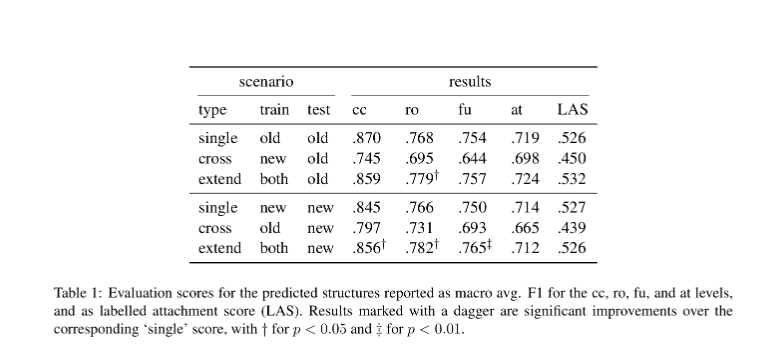